In [4]:

import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json
from tqdm import tqdm
import time
import shutil
import joblib


# ========== CONFIG ==========
# --- Model & Data Params ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- Training Params ---
BATCH_SIZE = 128
EPOCHS = 350
LR = 5e-4
WEIGHT_DECAY = 1e-5


# --- Data Files & Split ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
REGULAR_TEST_SAMPLES = 10
STAIR_TEST_SAMPLES = 5


# --- Output & Analysis ---
OUTPUT_DIR = "IntelligentEnsemble_Analysis_Robust"
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "_checkpoints")
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)


print(f"Starting comprehensive numerical evaluation with checkpoints.")
print(f"Results will be saved in '{OUTPUT_DIR}'")
print(f"Checkpoints will be saved in '{CHECKPOINT_DIR}'")
print(f"Using device: {DEVICE}")
print(f"Data directory: {DATA_DIR}")
print(f"Complex CSV file: {COMPLEX_CSV_FILE}")


# ========== 1. MODELS & DATA HELPERS ==========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): 
        print(f"  [DEBUG] Fourier: Constant x values detected, returning zeros")
        return np.zeros(2 * N + 1, dtype=np.float32)
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1): 
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)


def process_chunk_to_profiles(df_chunk):
    profiles = {}
    print(f"  [DEBUG] Processing chunk with {len(df_chunk)} rows, {df_chunk['Equation_ID'].nunique()} unique equations")
    for eq_id, grp in df_chunk.groupby('Equation_ID'): 
        profiles[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'), 
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'), 
            grp['Distribution'].iloc[0]
        )
    print(f"  [DEBUG] Processed {len(profiles)} profiles from chunk")
    return profiles


def finalize_profiles(profiles_dict):
    print(f"  [DEBUG] Finalizing {len(profiles_dict)} profiles...")
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, PROFILE_LENGTH)

    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        # Compute Fourier coefficients
        X_fourier.append(compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values))

        # Process K(z) profile
        k_values = prof['K(z)'].values
        if len(k_values) == PROFILE_LENGTH:
            Y_profile.append(k_values)
        else:
            # Interpolate to correct length
            thickness_vals = prof['x (Thickness)'].values
            thickness_norm = (thickness_vals - thickness_vals.min()) / (thickness_vals.max() - thickness_vals.min())
            Y_profile.append(np.interp(KZ_X_GRID, thickness_norm, k_values))

        eq_ids_out.append(eq_id)
        distribs_out.append(dist_name)

    if not X_fourier: 
        print("  [DEBUG] No profiles to finalize, returning empty arrays")
        return [], [], np.array([]), np.array([])

    print(f"  [DEBUG] Finalized {len(X_fourier)} profiles successfully")
    return np.stack(X_fourier), np.stack(Y_profile), np.array(eq_ids_out), np.array(distribs_out)


def load_data_memory_efficient(file_paths, ids_to_include=None):
    all_profiles = {}
    print(f"  > Loading data from {len(file_paths)} file(s)...")
    if ids_to_include is not None:
        print(f"  > Filtering for {len(ids_to_include)} specific IDs")

    for fname in file_paths:
        print(f"  [DEBUG] Processing file: {fname}")
        try:
            chunk_count = 0
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                chunk_count += 1
                print(f"  [DEBUG] Processing chunk {chunk_count} from {os.path.basename(fname)}")

                if ids_to_include is not None: 
                    original_len = len(chunk)
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                    print(f"  [DEBUG] Filtered chunk from {original_len} to {len(chunk)} rows")

                if not chunk.empty: 
                    chunk_profiles = process_chunk_to_profiles(chunk)
                    all_profiles.update(chunk_profiles)
                    print(f"  [DEBUG] Total profiles so far: {len(all_profiles)}")

        except Exception as e: 
            print(f"Warning: Could not process file '{fname}'. Error: {e}")

    print(f"  [DEBUG] Total profiles loaded: {len(all_profiles)}")
    return finalize_profiles(all_profiles)


class SEBlock(nn.Module):
    def __init__(self, c, r=16): 
        super().__init__()
        self.a = nn.AdaptiveAvgPool1d(1)
        self.f = nn.Sequential(
            nn.Linear(c, c // r, bias=False), 
            nn.ReLU(inplace=True), 
            nn.Linear(c // r, c, bias=False), 
            nn.Sigmoid()
        )

    def forward(self, x): 
        b, c, _ = x.size()
        y = self.a(x).view(b, c)
        return x * y.view(b, c, 1).expand_as(x)

class MultiScaleConvBlock(nn.Module):
    def __init__(self, i, o): 
        super().__init__()
        self.c = nn.ModuleList([nn.Conv1d(i, o // 4, k, padding='same') for k in [3, 7, 11, 15]])
        self.b = nn.BatchNorm1d(o)
        self.s = SEBlock(o)

    def forward(self, x): 
        return F.relu(self.s(self.b(torch.cat([c(x) for c in self.c], dim=1))))

class ProfileGeneratorNet(nn.Module):
    def __init__(self, i=FOURIER_DIM, o=PROFILE_LENGTH): 
        super().__init__()
        self.s = nn.Sequential(
            nn.Linear(i, 256), 
            nn.ReLU(), 
            nn.Linear(256, 512), 
            nn.ReLU(), 
            nn.Linear(512, o)
        )
        self.c = nn.Sequential(
            MultiScaleConvBlock(1, 128), 
            nn.Dropout(0.3), 
            MultiScaleConvBlock(128, 256), 
            nn.Dropout(0.3), 
            MultiScaleConvBlock(256, 256), 
            nn.Dropout(0.3), 
            MultiScaleConvBlock(256, 128)
        )
        self.h = nn.Conv1d(128, 1, kernel_size=1)

    def forward(self, x): 
        return self.h(self.c(self.s(x).unsqueeze(1))).squeeze(1)

class CombinedLoss(nn.Module):
    def __init__(self, w=0.8): 
        super().__init__()
        self.w, self.r = w, nn.SmoothL1Loss()
        self.register_buffer('f', torch.tensor([[-1., 0., 1.]]).view(1, 1, 3))

    def forward(self, p, t): 
        return self.r(p, t) + self.w * F.l1_loss(
            F.conv1d(p.unsqueeze(1), self.f, padding='same'), 
            F.conv1d(t.unsqueeze(1), self.f, padding='same')
        )

class ProfileDataset(Dataset):
    def __init__(self, X, Y): 
        self.X, self.Y = X, Y

    def __len__(self): 
        return len(self.X)

    def __getitem__(self, i): 
        return torch.from_numpy(self.X[i]).float(), torch.from_numpy(self.Y[i]).float()


# ========== 2. CORE TRAINING & EVALUATION FUNCTIONS ==========
def train_all_models(X_train, y_train, epochs=EPOCHS, checkpoint_prefix=""):
    print(f"  [DEBUG] Starting training with {len(X_train)} samples, prefix: '{checkpoint_prefix}'")
    models = {}

    # Scaling
    print(f"  [DEBUG] Fitting scalers...")
    x_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    X_train_scaled = x_scaler.transform(X_train)
    y_train_scaled = y_scaler.transform(y_train)
    models['x_scaler'], models['y_scaler'] = x_scaler, y_scaler
    print(f"  [DEBUG] Data scaling complete. X shape: {X_train_scaled.shape}, Y shape: {y_train_scaled.shape}")

    # KRR Expert
    print("  - Training KRR Expert...")
    start_time = time.time()
    krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
    krr_expert.fit(X_train_scaled, y_train_scaled)
    models['krr_time'] = time.time() - start_time
    models['krr'] = krr_expert
    print(f"  [DEBUG] KRR training completed in {models['krr_time']:.2f} seconds")

    # DNN Expert
    print("  - Training DNN Expert...")
    start_time = time.time()
    train_dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
    nn_expert = ProfileGeneratorNet().to(DEVICE)
    optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = CombinedLoss().to(DEVICE)

    print(f"  [DEBUG] DNN setup complete. Model on {DEVICE}, {len(train_dl)} batches per epoch")

    for epoch in tqdm(range(epochs), desc=f"DNN Training ({checkpoint_prefix})"):
        epoch_loss = 0
        batch_count = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            preds = nn_expert(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

        if epoch % 50 == 0:
            print(f"  [DEBUG] Epoch {epoch}: avg loss = {epoch_loss/batch_count:.6f}")

    models['nn_time'] = time.time() - start_time
    models['nn'] = nn_expert
    print(f"  [DEBUG] DNN training completed in {models['nn_time']:.2f} seconds")

    # Alpha Gating Regressor
    print("  - Training Alpha Gating Regressor...")
    with torch.no_grad(): 
        y_pred_nn_train_scaled = nn_expert(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()

    y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled)
    diff_preds = y_pred_krr_train_scaled - y_pred_nn_train_scaled
    num = np.sum((y_train_scaled - y_pred_nn_train_scaled) * diff_preds, axis=1)
    den = np.sum(diff_preds * diff_preds, axis=1)
    y_gate_train_alpha = np.clip(np.divide(num, den, out=np.full_like(num, 0.5), where=den!=0), 0, 1)

    print(f"  [DEBUG] Alpha values - min: {y_gate_train_alpha.min():.3f}, max: {y_gate_train_alpha.max():.3f}, mean: {y_gate_train_alpha.mean():.3f}")

    param_grid = {'n_estimators': [100], 'max_depth': [20], 'min_samples_leaf': [5]}
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1), 
        param_grid=param_grid, 
        cv=3, 
        scoring='neg_mean_squared_error'
    )
    grid_search.fit(X_train_scaled, y_gate_train_alpha)
    models['alpha_regressor'] = grid_search.best_estimator_
    print(f"  [DEBUG] Alpha gating regressor training complete. Best score: {grid_search.best_score_:.6f}")

    return models


def evaluate_all_models(models, X_test, y_test):
    print(f"  [DEBUG] Evaluating models on {len(X_test)} test samples")

    X_test_scaled = models['x_scaler'].transform(X_test)

    with torch.no_grad(): 
        y_pred_nn_scaled = models['nn'](torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()

    y_pred_krr_scaled = models['krr'].predict(X_test_scaled)

    # Inverse transform predictions
    y_pred_nn = models['y_scaler'].inverse_transform(y_pred_nn_scaled)
    y_pred_krr = models['y_scaler'].inverse_transform(y_pred_krr_scaled)

    # Alpha prediction and calibration
    alpha_pred_raw = models['alpha_regressor'].predict(X_test_scaled)
    alpha_calibrated = np.clip(0.5 + 2.5 * (alpha_pred_raw - 0.5)**3, 0, 1).reshape(-1, 1)

    # Ensemble prediction
    y_pred_ensemble = alpha_calibrated * y_pred_krr + (1 - alpha_calibrated) * y_pred_nn

    print(f"  [DEBUG] Alpha calibrated - min: {alpha_calibrated.min():.3f}, max: {alpha_calibrated.max():.3f}")

    results = {
        'krr': get_metrics(y_test, y_pred_krr), 
        'nn': get_metrics(y_test, y_pred_nn), 
        'ensemble': get_metrics(y_test, y_pred_ensemble)
    }

    print(f"  [DEBUG] Evaluation results - KRR R²: {results['krr']['R2']:.4f}, NN R²: {results['nn']['R2']:.4f}, Ensemble R²: {results['ensemble']['R2']:.4f}")

    return results


def get_metrics(y_true, y_pred): 
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"  [DEBUG] Metrics calculated - MSE: {mse:.6f}, R²: {r2:.6f}")
    return {'MSE': mse, 'R2': r2}


# ========== 3. ANALYSIS EXECUTION ==========
if __name__ == "__main__":

    # --- Data Splitting with Checkpointing ---
    print("\n--- Step 1: Loading and creating stratified data splits ---")
    ids_checkpoint_path = os.path.join(CHECKPOINT_DIR, "data_splits.json")

    if os.path.exists(ids_checkpoint_path):
        print("  > Checkpoint found for data splits. Loading from file.")
        with open(ids_checkpoint_path, 'r') as f: 
            data_splits = json.load(f)
        full_train_ids = data_splits['full_train_ids']
        full_test_ids = data_splits['full_test_ids']
        test_cats = data_splits['test_cats']
        print(f"  [DEBUG] Loaded splits - Train IDs: {len(full_train_ids)}, Test IDs: {len(full_test_ids)}")
    else:
        print("  > No data split checkpoint found. Calculating splits...")

        # Get all CSV files and separate base files from complex file
        all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
        print(f"  [DEBUG] Found {len(all_csv_files)} CSV files in {DATA_DIR}")

        # Dynamically determine base CSV files (excluding complex file)
        base_csv_files = [f for f in all_csv_files if f != COMPLEX_CSV_FILE]
        print(f"  [DEBUG] Base CSV files: {len(base_csv_files)}")
        for f in base_csv_files:
            print(f"  [DEBUG]   - {os.path.basename(f)}")

        train_ids_base, test_ids_base, test_ids_stair = [], [], []

        # Process each base CSV file
        for fname in base_csv_files:
            print(f"  [DEBUG] Processing base file: {os.path.basename(fname)}")
            try:
                df_ids = pd.read_csv(fname, engine='python', usecols=['Equation_ID', 'Distribution'])
                dist_name = df_ids['Distribution'].iloc[0]
                unique_ids = df_ids['Equation_ID'].unique()

                print(f"  [DEBUG] File {os.path.basename(fname)}: {len(unique_ids)} unique IDs, distribution: {dist_name}")

                # Shuffle and convert to Python integers for JSON serialization
                np.random.shuffle(unique_ids)
                unique_ids_list = [int(id_val) for id_val in unique_ids]

                # Determine if this is a stair file based on filename
                if 'stair' in os.path.basename(fname).lower():
                    test_ids_stair.extend(unique_ids_list[:STAIR_TEST_SAMPLES])
                    train_ids_base.extend(unique_ids_list[STAIR_TEST_SAMPLES:])
                    print(f"  [DEBUG] Stair file: {STAIR_TEST_SAMPLES} test, {len(unique_ids_list) - STAIR_TEST_SAMPLES} train")
                else:
                    test_ids_base.extend(unique_ids_list[:REGULAR_TEST_SAMPLES])
                    train_ids_base.extend(unique_ids_list[REGULAR_TEST_SAMPLES:])
                    print(f"  [DEBUG] Regular file: {REGULAR_TEST_SAMPLES} test, {len(unique_ids_list) - REGULAR_TEST_SAMPLES} train")

            except Exception as e:
                print(f"Warning: Could not process file '{fname}'. Error: {e}")
                continue

        # Process complex CSV file if it exists
        train_ids_complex, test_ids_complex = [], []
        if os.path.exists(COMPLEX_CSV_FILE):
            print(f"  [DEBUG] Processing complex file: {os.path.basename(COMPLEX_CSV_FILE)}")
            try:
                df_complex_ids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])
                complex_ids = df_complex_ids['Equation_ID'].unique()

                print(f"  [DEBUG] Complex file: {len(complex_ids)} unique IDs")

                # Shuffle and convert to Python integers
                np.random.shuffle(complex_ids)
                complex_ids_list = [int(id_val) for id_val in complex_ids]

                split_idx = int(len(complex_ids_list) * 0.8)
                train_ids_complex = complex_ids_list[:split_idx]
                test_ids_complex = complex_ids_list[split_idx:]

                print(f"  [DEBUG] Complex split: {len(train_ids_complex)} train, {len(test_ids_complex)} test")

            except Exception as e:
                print(f"Warning: Could not process complex file. Error: {e}")
        else:
            print(f"Warning: Complex CSV file '{COMPLEX_CSV_FILE}' not found.")

        # Combine all IDs
        full_train_ids = train_ids_base + train_ids_complex
        full_test_ids = test_ids_base + test_ids_stair + test_ids_complex
        test_cats = {
            'common': test_ids_base, 
            'irregular': test_ids_stair, 
            'complex_nonlinear': test_ids_complex
        }

        print(f"  [DEBUG] Final splits:")
        print(f"  [DEBUG]   Total train IDs: {len(full_train_ids)}")
        print(f"  [DEBUG]   Total test IDs: {len(full_test_ids)}")
        print(f"  [DEBUG]   Common test: {len(test_cats['common'])}")
        print(f"  [DEBUG]   Irregular test: {len(test_cats['irregular'])}")
        print(f"  [DEBUG]   Complex test: {len(test_cats['complex_nonlinear'])}")

        # Save to checkpoint (all values are now JSON serializable)
        with open(ids_checkpoint_path, 'w') as f: 
            json.dump({
                'full_train_ids': full_train_ids, 
                'full_test_ids': full_test_ids, 
                'test_cats': test_cats
            }, f)
        print("  > Data splits calculated and saved to checkpoint.")

    # Load the actual training and test data
    print("\n--- Step 2: Loading actual data ---")
    all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))

    print("  [DEBUG] Loading training data...")
    X_train_full, y_train_full, train_eq_ids, train_distribs = load_data_memory_efficient(all_csv_files, ids_to_include=full_train_ids)

    print("  [DEBUG] Loading test data...")
    X_test_full, y_test_full, test_eq_ids, test_distribs = load_data_memory_efficient(all_csv_files, ids_to_include=full_test_ids)

    print(f"Total training profiles: {len(X_train_full)} | Total test profiles: {len(X_test_full)}")

    # Create distribution mapping for later use
    print("  [DEBUG] Creating distribution mapping...")
    distrib_map = {}

    # Add test distribution mappings
    for i, eq_id in enumerate(test_eq_ids):
        distrib_map[int(eq_id)] = test_distribs[i]

    # Add training distribution mappings
    for i, eq_id in enumerate(train_eq_ids):
        distrib_map[int(eq_id)] = train_distribs[i]

    print(f"  [DEBUG] Distribution mapping created with {len(distrib_map)} entries")
    unique_distributions = set(distrib_map.values())
    print(f"  [DEBUG] Unique distributions found: {sorted(unique_distributions)}")

    # --- 1. ACCURACY ANALYSIS ---
    print("\n--- Running Accuracy Analysis ---")
    accuracy_checkpoint_path = os.path.join(CHECKPOINT_DIR, "accuracy_results.json")
    models_full_checkpoint_path = os.path.join(CHECKPOINT_DIR, "models_full.pkl")

    if os.path.exists(accuracy_checkpoint_path):
        print("  > Checkpoint found for Accuracy Analysis. Skipping.")
        with open(accuracy_checkpoint_path, 'r') as f: 
            results_accuracy = json.load(f)
        print(f"  [DEBUG] Loaded accuracy results with categories: {list(results_accuracy.keys())}")
    else:
        print("  > No checkpoint found. Starting full model training...")
        models_full = train_all_models(X_train_full, y_train_full, checkpoint_prefix="Full")

        results_accuracy = {}
        for cat, ids in test_cats.items():
            if len(ids) == 0: 
                print(f"  [DEBUG] Skipping category '{cat}' - no test IDs")
                continue

            print(f"  [DEBUG] Evaluating category '{cat}' with {len(ids)} test samples")
            mask = np.isin(test_eq_ids, ids)
            num_samples = np.sum(mask)
            print(f"  [DEBUG] Found {num_samples} matching test samples for category '{cat}'")

            if num_samples > 0:
                results_accuracy[cat] = evaluate_all_models(models_full, X_test_full[mask], y_test_full[mask])
            else:
                print(f"  [DEBUG] No matching samples found for category '{cat}'")

        # Save models and results
        joblib.dump(models_full, models_full_checkpoint_path)
        with open(accuracy_checkpoint_path, 'w') as f: 
            json.dump(results_accuracy, f, indent=4)
        print("  > Accuracy analysis complete. Results and models saved to checkpoint.")

    # --- 2. EFFICIENCY ANALYSIS ---
    print("\n--- Running Training Efficiency Analysis ---")
    results_efficiency = {'mse_vs_size': [], 'time_vs_size': []}
    data_subsets = [0.25, 0.5, 0.75, 1.0]

    for frac in data_subsets:
        frac_checkpoint_path = os.path.join(CHECKPOINT_DIR, f"efficiency_frac_{frac}.json")

        if os.path.exists(frac_checkpoint_path):
            print(f"  > Checkpoint found for efficiency subset {frac*100}%. Skipping.")
            with open(frac_checkpoint_path, 'r') as f: 
                frac_results = json.load(f)
            results_efficiency['mse_vs_size'].append(frac_results['mse'])
            results_efficiency['time_vs_size'].append(frac_results['time'])
        else:
            print(f"  > No checkpoint found for {frac*100}%. Running training...")
            subset_size = int(len(X_train_full) * frac)
            print(f"  [DEBUG] Training subset: {subset_size} samples ({frac*100}% of {len(X_train_full)})")

            # Adjust epochs based on subset size
            adjusted_epochs = int(EPOCHS * (0.5 + frac/2))
            print(f"  [DEBUG] Using {adjusted_epochs} epochs for this subset")

            models_sub = train_all_models(
                X_train_full[:subset_size], 
                y_train_full[:subset_size], 
                epochs=adjusted_epochs, 
                checkpoint_prefix=f"{frac*100}%"
            )

            eval_results = evaluate_all_models(models_sub, X_test_full, y_test_full)

            frac_results = {
                'mse': {
                    'frac': frac, 
                    'krr': eval_results['krr']['MSE'], 
                    'nn': eval_results['nn']['MSE'], 
                    'ensemble': eval_results['ensemble']['MSE']
                },
                'time': {
                    'frac': frac, 
                    'krr': models_sub['krr_time'], 
                    'nn': models_sub['nn_time']
                }
            }

            with open(frac_checkpoint_path, 'w') as f: 
                json.dump(frac_results, f, indent=4)

            results_efficiency['mse_vs_size'].append(frac_results['mse'])
            results_efficiency['time_vs_size'].append(frac_results['time'])

            print(f"  > Efficiency subset {frac*100}% complete. Results saved to checkpoint.")

    # --- 3. GENERALIZABILITY ANALYSIS ---
    print("\n--- Running Generalizability Analysis ---")
    gen_checkpoint_path = os.path.join(CHECKPOINT_DIR, "generalizability_results.json")

    if os.path.exists(gen_checkpoint_path):
        print("  > Checkpoint found for Generalizability Analysis. Skipping.")
        with open(gen_checkpoint_path, 'r') as f: 
            results_generalizability = json.load(f)
    else:
        print("  > No checkpoint found. Starting generalizability training...")

        # Filter training IDs to exclude complex and stair distributions
        train_ids_common = []
        for train_id in full_train_ids:
            if train_id in distrib_map:
                dist_type = distrib_map[train_id].lower()
                if 'complex' not in dist_type and 'stair' not in dist_type:
                    train_ids_common.append(train_id)

        print(f"  [DEBUG] Common training IDs: {len(train_ids_common)} out of {len(full_train_ids)} total")

        if len(train_ids_common) > 0:
            # Load common distribution training data
            print("  [DEBUG] Loading common distribution training data...")
            X_train_common, y_train_common, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=train_ids_common)

            print(f"  [DEBUG] Training models on {len(X_train_common)} common distribution samples")
            models_common = train_all_models(X_train_common, y_train_common, checkpoint_prefix="CommonOnly")

            # Test on unseen distribution types
            test_ids_unseen = test_cats['complex_nonlinear'] + test_cats['irregular']
            print(f"  [DEBUG] Unseen test IDs: {len(test_ids_unseen)}")

            if len(test_ids_unseen) > 0:
                print("  [DEBUG] Loading unseen distribution test data...")
                X_test_unseen, y_test_unseen, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=test_ids_unseen)

                print(f"  [DEBUG] Evaluating on {len(X_test_unseen)} unseen distribution samples")
                results_generalizability = evaluate_all_models(models_common, X_test_unseen, y_test_unseen)

                # Calculate performance degradation if we have baseline results
                if 'complex_nonlinear' in results_accuracy and 'irregular' in results_accuracy:
                    print("  [DEBUG] Calculating performance degradation...")

                    base_mse_krr = (results_accuracy['complex_nonlinear']['krr']['MSE'] + 
                                   results_accuracy['irregular']['krr']['MSE']) / 2
                    base_mse_nn = (results_accuracy['complex_nonlinear']['nn']['MSE'] + 
                                  results_accuracy['irregular']['nn']['MSE']) / 2

                    results_generalizability['krr']['degradation'] = (
                        (results_generalizability['krr']['MSE'] - base_mse_krr) / base_mse_krr
                    )
                    results_generalizability['nn']['degradation'] = (
                        (results_generalizability['nn']['MSE'] - base_mse_nn) / base_mse_nn
                    )

                    print(f"  [DEBUG] KRR degradation: {results_generalizability['krr']['degradation']:.4f}")
                    print(f"  [DEBUG] NN degradation: {results_generalizability['nn']['degradation']:.4f}")
                else:
                    print("  [DEBUG] Baseline results not available for degradation calculation")
            else:
                print("  > Warning: No unseen test data available for generalizability analysis.")
                results_generalizability = {"warning": "No unseen test data available"}
        else:
            print("  > Warning: No common distribution training data available.")
            results_generalizability = {"warning": "No common distribution training data available"}

        with open(gen_checkpoint_path, 'w') as f: 
            json.dump(results_generalizability, f, indent=4)
        print("  > Generalizability analysis complete. Results saved to checkpoint.")

    # --- FINAL REPORTING ---
    print("\n--- Generating Final Report and Plots ---")
    final_results = {
        'accuracy': results_accuracy, 
        'efficiency': results_efficiency, 
        'generalizability': results_generalizability
    }

    # Save comprehensive results
    final_results_path = os.path.join(OUTPUT_DIR, 'numerical_evaluation_results.json')
    with open(final_results_path, 'w') as f: 
        json.dump(final_results, f, indent=4)
    print(f"  [DEBUG] Final results saved to: {final_results_path}")

    # Generate efficiency plots
    print("  [DEBUG] Generating efficiency plots...")

    # MSE vs Data Size plot
    df_eff = pd.DataFrame(results_efficiency['mse_vs_size'])
    plt.figure(figsize=(10, 6))
    plt.plot(df_eff['frac'], df_eff['krr'], 'r-o', label='KRR')
    plt.plot(df_eff['frac'], df_eff['nn'], 'b-s', label='DNN')
    plt.plot(df_eff['frac'], df_eff['ensemble'], 'g-^', label='Ensemble')
    plt.xlabel('Fraction of Training Data Used')
    plt.ylabel('Test Set MSE')
    plt.title('Training Efficiency: Performance vs. Data Size')
    plt.legend()
    plt.grid(True)
    mse_plot_path = os.path.join(OUTPUT_DIR, 'efficiency_mse_vs_data.png')
    plt.savefig(mse_plot_path)
    plt.close()
    print(f"  [DEBUG] MSE plot saved to: {mse_plot_path}")

    # Training Time vs Data Size plot
    df_time = pd.DataFrame(results_efficiency['time_vs_size'])
    plt.figure(figsize=(10, 6))
    plt.bar(df_time['frac'] - 0.02, df_time['krr'], width=0.04, label='KRR', color='red')
    plt.bar(df_time['frac'] + 0.02, df_time['nn'], width=0.04, label='DNN', color='blue')
    plt.xlabel('Fraction of Training Data Used')
    plt.ylabel('Training Time (seconds)')
    plt.title('Computational Cost: Training Time vs. Data Size')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    time_plot_path = os.path.join(OUTPUT_DIR, 'efficiency_time_vs_data.png')
    plt.savefig(time_plot_path)
    plt.close()
    print(f"  [DEBUG] Time plot saved to: {time_plot_path}")

    print(f"\nEvaluation complete. All results saved in '{OUTPUT_DIR}'.")
    print(f"[DEBUG] Final summary:")
    print(f"  - Training samples: {len(X_train_full)}")
    print(f"  - Test samples: {len(X_test_full)}")
    print(f"  - Accuracy analysis categories: {len(results_accuracy)}")
    print(f"  - Efficiency data points: {len(results_efficiency['mse_vs_size'])}")
    print(f"  - Generalizability analysis: {'completed' if 'warning' not in results_generalizability else 'skipped - ' + results_generalizability.get('warning', 'unknown issue')}")

Starting comprehensive numerical evaluation with checkpoints.
Results will be saved in 'IntelligentEnsemble_Analysis_Robust'
Checkpoints will be saved in 'IntelligentEnsemble_Analysis_Robust/_checkpoints'
Using device: cpu
Data directory: generated_data
Complex CSV file: generated_data/data_complex_3000.csv

--- Step 1: Loading and creating stratified data splits ---
  > No data split checkpoint found. Calculating splits...
  [DEBUG] Found 8 CSV files in generated_data
  [DEBUG] Base CSV files: 7
  [DEBUG]   - data_quadratic_500.csv
  [DEBUG]   - data_cubic_500.csv
  [DEBUG]   - data_logarithmic_500.csv
  [DEBUG]   - data_linear_500.csv
  [DEBUG]   - data_hyperbolic_500.csv
  [DEBUG]   - data_exponential_500.csv
  [DEBUG]   - data_gaussian_500.csv
  [DEBUG] Processing base file: data_quadratic_500.csv
  [DEBUG] File data_quadratic_500.csv: 500 unique IDs, distribution: quadratic
  [DEBUG] Regular file: 10 test, 490 train
  [DEBUG] Processing base file: data_cubic_500.csv
  [DEBUG] File

DNN Training (Full):   0%|          | 1/350 [00:19<1:54:33, 19.69s/it]

  [DEBUG] Epoch 0: avg loss = 0.673354


DNN Training (Full):  15%|█▍        | 51/350 [16:55<1:36:27, 19.36s/it]

  [DEBUG] Epoch 50: avg loss = 0.551570


DNN Training (Full):  29%|██▉       | 101/350 [33:05<1:20:12, 19.33s/it]

  [DEBUG] Epoch 100: avg loss = 0.549804


DNN Training (Full):  43%|████▎     | 151/350 [49:05<1:03:10, 19.05s/it]

  [DEBUG] Epoch 150: avg loss = 0.248701


DNN Training (Full):  57%|█████▋    | 201/350 [1:05:10<48:08, 19.39s/it]

  [DEBUG] Epoch 200: avg loss = 0.179117


DNN Training (Full):  72%|███████▏  | 251/350 [1:21:16<32:02, 19.42s/it]

  [DEBUG] Epoch 250: avg loss = 0.155443


DNN Training (Full):  86%|████████▌ | 301/350 [1:37:19<15:35, 19.10s/it]

  [DEBUG] Epoch 300: avg loss = 0.144066


DNN Training (Full): 100%|██████████| 350/350 [1:53:07<00:00, 19.39s/it]


  [DEBUG] DNN training completed in 6787.19 seconds
  - Training Alpha Gating Regressor...
  [DEBUG] Alpha values - min: 0.000, max: 1.000, mean: 0.702
  [DEBUG] Alpha gating regressor training complete. Best score: -0.096435
  [DEBUG] Evaluating category 'common' with 70 test samples
  [DEBUG] Found 70 matching test samples for category 'common'
  [DEBUG] Evaluating models on 70 test samples
  [DEBUG] Alpha calibrated - min: 0.261, max: 0.805
  [DEBUG] Metrics calculated - MSE: 0.135941, R²: 0.924851
  [DEBUG] Metrics calculated - MSE: 0.215825, R²: 0.891555
  [DEBUG] Metrics calculated - MSE: 0.127680, R²: 0.931818
  [DEBUG] Evaluation results - KRR R²: 0.9249, NN R²: 0.8916, Ensemble R²: 0.9318
  [DEBUG] Skipping category 'irregular' - no test IDs
  [DEBUG] Evaluating category 'complex_nonlinear' with 600 test samples
  [DEBUG] Found 600 matching test samples for category 'complex_nonlinear'
  [DEBUG] Evaluating models on 600 test samples
  [DEBUG] Alpha calibrated - min: 0.273, max

DNN Training (25.0%):   0%|          | 1/218 [00:05<18:13,  5.04s/it]

  [DEBUG] Epoch 0: avg loss = 0.757150


DNN Training (25.0%):  23%|██▎       | 51/218 [04:10<13:32,  4.86s/it]

  [DEBUG] Epoch 50: avg loss = 0.529612


DNN Training (25.0%):  46%|████▋     | 101/218 [08:22<09:36,  4.92s/it]

  [DEBUG] Epoch 100: avg loss = 0.528431


DNN Training (25.0%):  69%|██████▉   | 151/218 [12:25<05:29,  4.92s/it]

  [DEBUG] Epoch 150: avg loss = 0.524115


DNN Training (25.0%):  92%|█████████▏| 201/218 [16:30<01:22,  4.87s/it]

  [DEBUG] Epoch 200: avg loss = 0.526514


DNN Training (25.0%): 100%|██████████| 218/218 [17:54<00:00,  4.93s/it]


  [DEBUG] DNN training completed in 1074.37 seconds
  - Training Alpha Gating Regressor...
  [DEBUG] Alpha values - min: 0.157, max: 1.000, mean: 0.997
  [DEBUG] Alpha gating regressor training complete. Best score: -0.000716
  [DEBUG] Evaluating models on 670 test samples
  [DEBUG] Alpha calibrated - min: 0.620, max: 0.812
  [DEBUG] Metrics calculated - MSE: 1.353003, R²: 0.438139
  [DEBUG] Metrics calculated - MSE: 2.878044, R²: -0.155156
  [DEBUG] Metrics calculated - MSE: 1.337421, R²: 0.446248
  [DEBUG] Evaluation results - KRR R²: 0.4381, NN R²: -0.1552, Ensemble R²: 0.4462
  > Efficiency subset 25.0% complete. Results saved to checkpoint.
  > No checkpoint found for 50.0%. Running training...
  [DEBUG] Training subset: 2675 samples (50.0% of 5350)
  [DEBUG] Using 262 epochs for this subset
  [DEBUG] Starting training with 2675 samples, prefix: '50.0%'
  [DEBUG] Fitting scalers...
  [DEBUG] Data scaling complete. X shape: (2675, 51), Y shape: (2675, 100)
  - Training KRR Expert..

DNN Training (50.0%):   0%|          | 1/262 [00:10<44:15, 10.18s/it]

  [DEBUG] Epoch 0: avg loss = 0.687791


DNN Training (50.0%):  19%|█▉        | 51/262 [08:12<33:58,  9.66s/it]

  [DEBUG] Epoch 50: avg loss = 0.531845


DNN Training (50.0%):  39%|███▊      | 101/262 [16:18<26:16,  9.79s/it]

  [DEBUG] Epoch 100: avg loss = 0.526241


DNN Training (50.0%):  58%|█████▊    | 151/262 [24:22<18:07,  9.80s/it]

  [DEBUG] Epoch 150: avg loss = 0.450743


DNN Training (50.0%):  77%|███████▋  | 201/262 [32:27<09:54,  9.75s/it]

  [DEBUG] Epoch 200: avg loss = 0.089440


DNN Training (50.0%):  96%|█████████▌| 251/262 [40:29<01:45,  9.58s/it]

  [DEBUG] Epoch 250: avg loss = 0.061623


DNN Training (50.0%): 100%|██████████| 262/262 [42:15<00:00,  9.68s/it]


  [DEBUG] DNN training completed in 2535.10 seconds
  - Training Alpha Gating Regressor...
  [DEBUG] Alpha values - min: 0.000, max: 1.000, mean: 0.938
  [DEBUG] Alpha gating regressor training complete. Best score: -0.049032
  [DEBUG] Evaluating models on 670 test samples
  [DEBUG] Alpha calibrated - min: 0.269, max: 0.812
  [DEBUG] Metrics calculated - MSE: 1.263025, R²: 0.463753
  [DEBUG] Metrics calculated - MSE: 470.735600, R²: -168.761335
  [DEBUG] Metrics calculated - MSE: 75.767606, R²: -26.391349
  [DEBUG] Evaluation results - KRR R²: 0.4638, NN R²: -168.7613, Ensemble R²: -26.3913
  > Efficiency subset 50.0% complete. Results saved to checkpoint.
  > No checkpoint found for 75.0%. Running training...
  [DEBUG] Training subset: 4012 samples (75.0% of 5350)
  [DEBUG] Using 306 epochs for this subset
  [DEBUG] Starting training with 4012 samples, prefix: '75.0%'
  [DEBUG] Fitting scalers...
  [DEBUG] Data scaling complete. X shape: (4012, 51), Y shape: (4012, 100)
  - Training K

DNN Training (75.0%):   0%|          | 1/306 [00:14<1:13:28, 14.45s/it]

  [DEBUG] Epoch 0: avg loss = 0.656171


DNN Training (75.0%):  17%|█▋        | 51/306 [12:21<1:01:28, 14.47s/it]

  [DEBUG] Epoch 50: avg loss = 0.544406


DNN Training (75.0%):  33%|███▎      | 101/306 [24:26<50:02, 14.65s/it] 

  [DEBUG] Epoch 100: avg loss = 0.543266


DNN Training (75.0%):  49%|████▉     | 151/306 [36:38<38:57, 15.08s/it]

  [DEBUG] Epoch 150: avg loss = 0.543548


DNN Training (75.0%):  66%|██████▌   | 201/306 [48:39<25:08, 14.36s/it]

  [DEBUG] Epoch 200: avg loss = 0.541893


DNN Training (75.0%):  82%|████████▏ | 251/306 [1:00:42<13:07, 14.31s/it]

  [DEBUG] Epoch 250: avg loss = 0.422426


DNN Training (75.0%):  98%|█████████▊| 301/306 [1:12:49<01:13, 14.66s/it]

  [DEBUG] Epoch 300: avg loss = 0.154820


DNN Training (75.0%): 100%|██████████| 306/306 [1:14:01<00:00, 14.51s/it]


  [DEBUG] DNN training completed in 4441.35 seconds
  - Training Alpha Gating Regressor...
  [DEBUG] Alpha values - min: 0.000, max: 1.000, mean: 0.891
  [DEBUG] Alpha gating regressor training complete. Best score: -0.042855
  [DEBUG] Evaluating models on 670 test samples
  [DEBUG] Alpha calibrated - min: 0.229, max: 0.812
  [DEBUG] Metrics calculated - MSE: 0.875179, R²: 0.631928
  [DEBUG] Metrics calculated - MSE: 212.390573, R²: -83.212989
  [DEBUG] Metrics calculated - MSE: 29.118754, R²: -10.555696
  [DEBUG] Evaluation results - KRR R²: 0.6319, NN R²: -83.2130, Ensemble R²: -10.5557
  > Efficiency subset 75.0% complete. Results saved to checkpoint.
  > No checkpoint found for 100.0%. Running training...
  [DEBUG] Training subset: 5350 samples (100.0% of 5350)
  [DEBUG] Using 350 epochs for this subset
  [DEBUG] Starting training with 5350 samples, prefix: '100.0%'
  [DEBUG] Fitting scalers...
  [DEBUG] Data scaling complete. X shape: (5350, 51), Y shape: (5350, 100)
  - Training 

DNN Training (100.0%):   0%|          | 1/350 [00:19<1:52:49, 19.40s/it]

  [DEBUG] Epoch 0: avg loss = 0.657893


DNN Training (100.0%):  15%|█▍        | 51/350 [16:23<1:36:27, 19.36s/it]

  [DEBUG] Epoch 50: avg loss = 0.551638


DNN Training (100.0%):  29%|██▉       | 101/350 [32:34<1:20:54, 19.49s/it]

  [DEBUG] Epoch 100: avg loss = 0.550640


DNN Training (100.0%):  43%|████▎     | 151/350 [48:44<1:04:28, 19.44s/it]

  [DEBUG] Epoch 150: avg loss = 0.236328


DNN Training (100.0%):  57%|█████▋    | 201/350 [1:04:56<47:25, 19.10s/it]

  [DEBUG] Epoch 200: avg loss = 0.177662


DNN Training (100.0%):  72%|███████▏  | 251/350 [1:21:06<32:12, 19.52s/it]

  [DEBUG] Epoch 250: avg loss = 0.157462


DNN Training (100.0%):  86%|████████▌ | 301/350 [1:37:10<15:44, 19.27s/it]

  [DEBUG] Epoch 300: avg loss = 0.151848


DNN Training (100.0%): 100%|██████████| 350/350 [1:53:13<00:00, 19.41s/it]


  [DEBUG] DNN training completed in 6793.27 seconds
  - Training Alpha Gating Regressor...
  [DEBUG] Alpha values - min: 0.000, max: 1.000, mean: 0.723
  [DEBUG] Alpha gating regressor training complete. Best score: -0.084854
  [DEBUG] Evaluating models on 670 test samples
  [DEBUG] Alpha calibrated - min: 0.203, max: 0.812
  [DEBUG] Metrics calculated - MSE: 0.844453, R²: 0.644821
  [DEBUG] Metrics calculated - MSE: 1.427016, R²: 0.397756
  [DEBUG] Metrics calculated - MSE: 0.878022, R²: 0.629792
  [DEBUG] Evaluation results - KRR R²: 0.6448, NN R²: 0.3978, Ensemble R²: 0.6298
  > Efficiency subset 100.0% complete. Results saved to checkpoint.

--- Running Generalizability Analysis ---
  > No checkpoint found. Starting generalizability training...
  [DEBUG] Common training IDs: 3430 out of 5830 total
  [DEBUG] Loading common distribution training data...
  > Loading data from 8 file(s)...
  > Filtering for 3430 specific IDs
  [DEBUG] Processing file: generated_data/data_quadratic_500.

DNN Training (CommonOnly):   0%|          | 1/350 [00:11<1:04:17, 11.05s/it]

  [DEBUG] Epoch 0: avg loss = 0.715099


DNN Training (CommonOnly):  15%|█▍        | 51/350 [10:09<55:03, 11.05s/it]  

  [DEBUG] Epoch 50: avg loss = 0.533464


DNN Training (CommonOnly):  29%|██▉       | 101/350 [19:20<45:35, 10.99s/it]

  [DEBUG] Epoch 100: avg loss = 0.322371


DNN Training (CommonOnly):  43%|████▎     | 151/350 [28:33<35:58, 10.84s/it]

  [DEBUG] Epoch 150: avg loss = 0.099368


DNN Training (CommonOnly):  57%|█████▋    | 201/350 [37:39<26:52, 10.82s/it]

  [DEBUG] Epoch 200: avg loss = 0.085197


DNN Training (CommonOnly):  72%|███████▏  | 251/350 [46:41<17:49, 10.81s/it]

  [DEBUG] Epoch 250: avg loss = 0.076725


DNN Training (CommonOnly):  86%|████████▌ | 301/350 [56:27<09:50, 12.05s/it]

  [DEBUG] Epoch 300: avg loss = 0.061790


DNN Training (CommonOnly): 100%|██████████| 350/350 [1:05:53<00:00, 11.30s/it]


  [DEBUG] DNN training completed in 3953.77 seconds
  - Training Alpha Gating Regressor...
  [DEBUG] Alpha values - min: 0.000, max: 1.000, mean: 0.909
  [DEBUG] Alpha gating regressor training complete. Best score: -0.057107
  [DEBUG] Unseen test IDs: 600
  [DEBUG] Loading unseen distribution test data...
  > Loading data from 8 file(s)...
  > Filtering for 600 specific IDs
  [DEBUG] Processing file: generated_data/data_quadratic_500.csv
  [DEBUG] Processing chunk 1 from data_quadratic_500.csv
  [DEBUG] Filtered chunk from 100000 to 0 rows
  [DEBUG] Processing chunk 2 from data_quadratic_500.csv
  [DEBUG] Filtered chunk from 100000 to 0 rows
  [DEBUG] Processing chunk 3 from data_quadratic_500.csv
  [DEBUG] Filtered chunk from 100000 to 0 rows
  [DEBUG] Processing chunk 4 from data_quadratic_500.csv
  [DEBUG] Filtered chunk from 100000 to 0 rows
  [DEBUG] Processing chunk 5 from data_quadratic_500.csv
  [DEBUG] Filtered chunk from 100000 to 0 rows
  [DEBUG] Processing chunk 6 from dat

In [1]:
#!/usr/bin/env python3
# build_metrics_and_plots.py
# Writes CSVs from hardcoded metrics and generates publication-ready plots.
# Requires: pandas, matplotlib, seaborn

import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="whitegrid")

# ----------------------------
# 1) Hardcoded evaluation data
# ----------------------------
stats = {
    "accuracy": {
        "common": {
            "krr": {"MSE": 0.1359410363292776, "R2": 0.9248514226745469},
            "nn":  {"MSE": 0.21582535380921794, "R2": 0.8915548231792932},
            "ensemble": {"MSE": 0.1276802876302022, "R2": 0.9318179471254049}
        },
        "complex_nonlinear": {
            "krr": {"MSE": 0.927112993269139, "R2": 0.6169450970247985},
            "nn":  {"MSE": 1.0720702228806642, "R2": 0.5562961253086796},
            "ensemble": {"MSE": 0.8921703663995194, "R2": 0.630206165989921}
        }
    },
    "efficiency": {
        "mse_vs_size": [
            {"frac": 0.25, "krr": 1.3530029016840583, "nn": 2.878043837471484, "ensemble": 1.337421073957531},
            {"frac": 0.5,  "krr": 1.263024694834383,  "nn": 470.7356004435224, "ensemble": 75.76760632538151},
            {"frac": 0.75, "krr": 0.87517947351971,   "nn": 212.39057348545555,"ensemble": 29.118753810471027},
            {"frac": 1.0,  "krr": 0.8444532365739303, "nn": 1.4270156611095561,"ensemble": 0.878022143774468}
        ],
        "time_vs_size": [
            {"frac": 0.25, "krr": 0.18986845016479492, "nn": 1074.3694310188293},
            {"frac": 0.5,  "krr": 0.4535214900970459,  "nn": 2535.100768327713},
            {"frac": 0.75, "krr": 0.9281601905822754,  "nn": 4441.348736286163},
            {"frac": 1.0,  "krr": 1.822338342666626,   "nn": 6793.273813962936}
        ]
    },
    "generalizability": {
        "krr": {"MSE": 1.4383324523042729, "R2": 0.39874533900937204},
        "nn":  {"MSE": 451.91104497856867, "R2": -198.26781811305304},
        "ensemble": {"MSE": 68.18545581432758, "R2": -29.065197121468323}
    }
}

# ---------------------------------------
# 2) Demo per-profile data (synthetic)
#    Replace with actual per-sample export
# ---------------------------------------
demo_profiles = [
    # Ensemble wins vs both experts
    {"profile_id": "p01", "krr_mse": 1.20, "nn_mse": 1.50, "ensemble_mse": 0.70},
    {"profile_id": "p02", "krr_mse": 0.90, "nn_mse": 1.30, "ensemble_mse": 0.80},
    {"profile_id": "p03", "krr_mse": 0.80, "nn_mse": 2.00, "ensemble_mse": 0.75},
    {"profile_id": "p04", "krr_mse": 1.00, "nn_mse": 1.80, "ensemble_mse": 0.85},
    {"profile_id": "p05", "krr_mse": 1.40, "nn_mse": 1.90, "ensemble_mse": 0.90},
    {"profile_id": "p06", "krr_mse": 1.10, "nn_mse": 1.60, "ensemble_mse": 0.95},

    # Ensemble suboptimal locally (worse than min(experts))
    {"profile_id": "p07", "krr_mse": 0.60, "nn_mse": 0.70, "ensemble_mse": 0.80},
    {"profile_id": "p08", "krr_mse": 0.70, "nn_mse": 0.60, "ensemble_mse": 0.85},
    {"profile_id": "p09", "krr_mse": 0.50, "nn_mse": 0.55, "ensemble_mse": 0.90},
    {"profile_id": "p10", "krr_mse": 0.90, "nn_mse": 0.85, "ensemble_mse": 1.00},
    {"profile_id": "p11", "krr_mse": 0.80, "nn_mse": 0.90, "ensemble_mse": 1.10},
    {"profile_id": "p12", "krr_mse": 0.65, "nn_mse": 0.70, "ensemble_mse": 0.95},
]

# -------------------------
# 3) Create output folders
# -------------------------
os.makedirs("outputs/csv", exist_ok=True)
os.makedirs("outputs/figures", exist_ok=True)

# -------------------------
# 4) Write CSVs from stats
# -------------------------

# 4a) Accuracy by regime (MSE and R2)
rows = []
for regime_key, models in stats["accuracy"].items():
    for model, vals in models.items():
        rows.append({
            "regime": "Common" if regime_key == "common" else "Complex Nonlinear",
            "model": model.upper(),
            "MSE": vals["MSE"],
            "R2": vals["R2"]
        })
df_accuracy = pd.DataFrame(rows)
df_accuracy.to_csv("outputs/csv/accuracy_by_regime.csv", index=False)

# 4b) Efficiency: MSE vs size
df_mse_vs_size = pd.DataFrame(stats["efficiency"]["mse_vs_size"])
df_mse_vs_size.to_csv("outputs/csv/mse_vs_size.csv", index=False)

# 4c) Efficiency: Time vs size
df_time_vs_size = pd.DataFrame(stats["efficiency"]["time_vs_size"])
df_time_vs_size.to_csv("outputs/csv/time_vs_size.csv", index=False)

# 4d) Generalizability
gen_rows = []
for model, vals in stats["generalizability"].items():
    gen_rows.append({"model": model.upper(), "MSE": vals["MSE"], "R2": vals["R2"]})
df_gen = pd.DataFrame(gen_rows)
df_gen.to_csv("outputs/csv/generalizability.csv", index=False)

# 4e) Per-profile (demo)
df_profiles = pd.DataFrame(demo_profiles)
df_profiles.to_csv("outputs/csv/per_profile_results_demo.csv", index=False)

# -------------------------
# 5) Plotting utilities
# -------------------------
def savefig(name):
    plt.tight_layout()
    plt.savefig(os.path.join("outputs/figures", name), dpi=200)
    plt.close()

# 5a) Accuracy by regime (R² grouped bars)
def plot_accuracy_by_regime(df):
    plt.figure(figsize=(8,6))
    order = ["Common", "Complex Nonlinear"]
    palette = {"KRR":"#1f77b4", "NN":"#ff7f0e", "ENSEMBLE":"#2ca02c"}
    sns.barplot(data=df, x="regime", y="R2", hue="model", order=order, palette=palette)
    for p in plt.gca().patches:
        h = p.get_height()
        if not math.isnan(h):
            plt.gca().annotate(f"{h:.3f}", (p.get_x()+p.get_width()/2, h),
                               ha="center", va="bottom", fontsize=10, xytext=(0,3), textcoords="offset points")
    plt.ylabel("R²")
    plt.xlabel("")
    plt.title("Accuracy by Regime (R²)")
    plt.legend(title="Model")
    savefig("accuracy_by_regime_R2.png")

# 5b) MSE vs Training Time (scatter, log-x) for KRR & NN
def plot_mse_vs_time(df_time, df_mse):
    # Merge on frac for KRR and NN only
    merged = pd.merge(df_time, df_mse, on="frac", suffixes=("_time", "_mse"))
    plt.figure(figsize=(8,6))
    # KRR
    plt.scatter(merged["krr_time"], merged["krr_mse"], label="KRR", marker="o", color="#1f77b4")
    for _, r in merged.iterrows():
        plt.annotate(f"{int(r['frac']*100)}%", (r["krr_time"], r["krr_mse"]), textcoords="offset points", xytext=(5,5), fontsize=10, color="#1f77b4")
    # NN
    plt.scatter(merged["nn_time"], merged["nn_mse"], label="NN", marker="s", color="#ff7f0e")
    for _, r in merged.iterrows():
        plt.annotate(f"{int(r['frac']*100)}%", (r["nn_time"], r["nn_mse"]), textcoords="offset points", xytext=(5,5), fontsize=10, color="#ff7f0e")
    plt.xscale("log")
    plt.xlabel("Training Time (s, log scale)")
    plt.ylabel("MSE (lower is better)")
    plt.title("MSE vs Training Time by Data Fraction")
    plt.legend()
    savefig("mse_vs_training_time.png")

# 5c) MSE vs Data Used (lines for KRR, NN, Ensemble)
def plot_mse_vs_data(df_mse):
    plot_df = pd.melt(df_mse.copy(), id_vars=["frac"], value_vars=["krr","nn","ensemble"], var_name="model", value_name="MSE")
    plot_df["pct"] = (plot_df["frac"]*100).astype(int)
    plt.figure(figsize=(8,6))
    palette = {"krr":"#1f77b4", "nn":"#ff7f0e", "ensemble":"#2ca02c"}
    sns.lineplot(data=plot_df, x="pct", y="MSE", hue="model", marker="o", palette=palette)
    plt.xlabel("Training Data Used (%)")
    plt.ylabel("MSE (lower is better)")
    plt.title("MSE vs Training Data Used")
    plt.legend(title="Model", labels=["KRR","NN","Ensemble"])
    savefig("mse_vs_data.png")

# 5d) Tradeoff bubble chart: time (x, log), data % (y), bubble size = MSE, color by model (KRR/NN)
def plot_tradeoff_bubble(df_time, df_mse):
    merged = pd.merge(df_time, df_mse, on="frac", suffixes=("_time", "_mse"))
    plt.figure(figsize=(9,7))
    # Prepare points for KRR and NN
    for model, color, marker in [("krr", "#1f77b4", "o"), ("nn", "#ff7f0e", "s")]:
        x = merged[f"{model}_time"]
        y = merged["frac"]*100
        s = merged[f"{model}_mse"]
        sizes = 200 * (s / (s.max() if s.max() > 0 else 1.0)) + 40
        plt.scatter(x, y, s=sizes, c=color, marker=marker, alpha=0.7, label=model.upper(), edgecolor="k", linewidth=0.5)
        for xi, yi, fi, si in zip(x, y, merged["frac"], s):
            plt.annotate(f"{int(fi*100)}%", (xi, yi), textcoords="offset points", xytext=(5,5), fontsize=10)
    plt.xscale("log")
    plt.xlabel("Training Time (s, log scale)")
    plt.ylabel("Training Data Used (%)")
    plt.title("Training Cost (Time + Data) vs Accuracy (Bubble = MSE)")
    plt.legend(title="Model")
    savefig("tradeoff_time_data_vs_mse.png")

# 5e) Generalizability bars: R² and MSE
def plot_generalizability(df_gen):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    palette = {"KRR":"#1f77b4", "NN":"#ff7f0e", "ENSEMBLE":"#2ca02c"}
    # R2
    sns.barplot(ax=axes[0], data=df_gen, x="model", y="R2", palette=palette)
    axes[0].set_title("Generalizability (R²)")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("R²")
    for p in axes[0].patches:
        h = p.get_height()
        axes[0].annotate(f"{h:.3f}", (p.get_x()+p.get_width()/2, h), ha="center", va="bottom", fontsize=10, xytext=(0,3), textcoords="offset points")
    # MSE
    sns.barplot(ax=axes[1], data=df_gen, x="model", y="MSE", palette=palette)
    axes[1].set_title("Generalizability (MSE)")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("MSE")
    for p in axes[1].patches:
        h = p.get_height()
        axes[1].annotate(f"{h:.3f}", (p.get_x()+p.get_width()/2, h), ha="center", va="bottom", fontsize=10, xytext=(0,3), textcoords="offset points")
    plt.tight_layout()
    plt.savefig("outputs/figures/generalizability_bars.png", dpi=200)
    plt.close()

# 5f) Per-profile bars: ensemble wins
def plot_profile_wins(df_profiles):
    wins = df_profiles[(df_profiles["ensemble_mse"] < df_profiles["krr_mse"]) &
                       (df_profiles["ensemble_mse"] < df_profiles["nn_mse"])].copy()
    if wins.empty:
        return
    wins["margin"] = wins[["krr_mse","nn_mse"]].max(axis=1) - wins["ensemble_mse"]
    top = wins.sort_values("margin", ascending=False).head(10)
    plot_df = top.melt("profile_id", ["krr_mse","nn_mse","ensemble_mse"], var_name="model", value_name="MSE")
    plt.figure(figsize=(10,5))
    sns.barplot(data=plot_df, x="profile_id", y="MSE", hue="model",
                palette={"krr_mse":"#1f77b4","nn_mse":"#ff7f0e","ensemble_mse":"#2ca02c"})
    plt.title("Ensemble Outperforms Experts on Selected Profiles")
    plt.ylabel("MSE (lower is better)")
    plt.xlabel("Profile")
    plt.legend(title="Model")
    savefig("bars_ensemble_wins.png")

# 5g) Per-profile bars: ensemble suboptimal locally
def plot_profile_losses(df_profiles):
    losses = df_profiles[(df_profiles["ensemble_mse"] > df_profiles["krr_mse"]) &
                         (df_profiles["ensemble_mse"] > df_profiles["nn_mse"])].copy()
    if losses.empty:
        return
    losses["overcost"] = losses["ensemble_mse"] - losses[["krr_mse","nn_mse"]].min(axis=1)
    top = losses.sort_values("overcost", ascending=False).head(10)
    plot_df = top.melt("profile_id", ["krr_mse","nn_mse","ensemble_mse"], var_name="model", value_name="MSE")
    plt.figure(figsize=(10,5))
    sns.barplot(data=plot_df, x="profile_id", y="MSE", hue="model",
                palette={"krr_mse":"#1f77b4","nn_mse":"#ff7f0e","ensemble_mse":"#2ca02c"})
    plt.title("Ensemble Suboptimal Locally but Robust Globally (Illustrative)")
    plt.ylabel("MSE (lower is better)")
    plt.xlabel("Profile")
    plt.legend(title="Model")
    savefig("bars_ensemble_suboptimal.png")

# -------------------------
# 6) Build all figures
# -------------------------
if __name__ == "__main__":
    plot_accuracy_by_regime(df_accuracy)
    plot_mse_vs_time(
        df_time=df_time_vs_size.rename(columns={"krr":"krr_time","nn":"nn_time"}),
        df_mse=df_mse_vs_size.rename(columns={"krr":"krr_mse","nn":"nn_mse"})
    )
    plot_mse_vs_data(df_mse_vs_size)
    plot_tradeoff_bubble(
        df_time=df_time_vs_size.rename(columns={"krr":"krr_time","nn":"nn_time"}),
        df_mse=df_mse_vs_size.rename(columns={"krr":"krr_mse","nn":"nn_mse","ensemble":"ensemble_mse"})
    )
    plot_generalizability(df_gen)
    plot_profile_wins(df_profiles)
    plot_profile_losses(df_profiles)

    print("CSV files written to outputs/csv and figures saved to outputs/figures")


/tmp/ipykernel_401381/2473301708.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], data=df_gen, x="model", y="R2", palette=palette)
/tmp/ipykernel_401381/2473301708.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], data=df_gen, x="model", y="MSE", palette=palette)


CSV files written to outputs/csv and figures saved to outputs/figures


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json
from tqdm import tqdm
import time
import shutil
import joblib
import math


# ========== CONFIG ==========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
EPOCHS = 350
LR = 1e-3
WEIGHT_DECAY = 1e-4
GRADIENT_CLIP = 1.0

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
REGULAR_TEST_SAMPLES = 10
STAIR_TEST_SAMPLES = 5

OUTPUT_DIR = "ImprovedEnsemble_Analysis_FINAL"
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "_checkpoints")
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

print(f"Starting PyTorch-compatible ensemble evaluation.")
print(f"PyTorch version: {torch.__version__}")
print(f"Results will be saved in '{OUTPUT_DIR}'")
print(f"Using device: {DEVICE}")


# ========== DATA HELPERS ==========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk_to_profiles(df_chunk):
    profiles = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profiles[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profiles

def finalize_profiles(profiles_dict):
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, PROFILE_LENGTH)
    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        X_fourier.append(compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values))
        k_values = prof['K(z)'].values
        if len(k_values) == PROFILE_LENGTH:
            Y_profile.append(k_values)
        else:
            thickness_vals = prof['x (Thickness)'].values
            thickness_norm = (thickness_vals - thickness_vals.min()) / (thickness_vals.max() - thickness_vals.min())
            Y_profile.append(np.interp(KZ_X_GRID, thickness_norm, k_values))
        eq_ids_out.append(eq_id)
        distribs_out.append(dist_name)
    if not X_fourier:
        return [], [], np.array([]), np.array([])
    return np.stack(X_fourier), np.stack(Y_profile), np.array(eq_ids_out), np.array(distribs_out)

def load_data_memory_efficient(file_paths, ids_to_include=None):
    all_profiles = {}
    print(f"  > Loading data from {len(file_paths)} file(s)...")
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    all_profiles.update(process_chunk_to_profiles(chunk))
        except Exception as e:
            print(f"Warning: Could not process file '{fname}'. Error: {e}")
    return finalize_profiles(all_profiles)


# ========== SIMPLIFIED BUT ROBUST NEURAL NETWORKS ==========
class SimpleResNet(nn.Module):
    """Simple but effective ResNet-style architecture"""
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden_dims=None, dropout=0.1):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [256, 512, 256]
        print(f"  [DEBUG] SimpleResNet: layers={hidden_dims}")
        layers = []
        current_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Dropout(dropout)
            ])
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, output_dim))
        self.main_path = nn.Sequential(*layers)
        self.skip_connection = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        main_out = self.main_path(x)
        skip_out = self.skip_connection(x)
        return main_out + skip_out

class AdaptiveNet(nn.Module):
    """Dataset-size adaptive architecture"""
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, dataset_size=1000):
        super().__init__()
        if dataset_size < 1000:
            hidden_dims = [128, 256]; dropout = 0.3
        elif dataset_size < 3000:
            hidden_dims = [256, 512, 256]; dropout = 0.2
        else:
            hidden_dims = [512, 512, 256]; dropout = 0.1
        self.net = SimpleResNet(input_dim, output_dim, hidden_dims, dropout)
    def forward(self, x):
        return self.net(x)

class TransformerNet(nn.Module):
    """Simplified transformer for sequence modeling"""
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH,
                 d_model=256, nhead=8, num_layers=2, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.input_projection = nn.Linear(input_dim, d_model)
        self.skip_connection = nn.Linear(input_dim, output_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, output_dim),
            nn.Tanh()
        )
    def forward(self, x):
        skip = self.skip_connection(x)
        x_proj = self.input_projection(x).unsqueeze(1)  # (batch, 1, d_model)
        x_trans = self.transformer(x_proj)
        x_out = self.output_projection(x_trans.squeeze(1))
        return x_out + skip

class CombinedLoss(nn.Module):
    """Stable loss function with regularization"""
    def __init__(self, mse_weight=1.0, smooth_weight=0.1):
        super().__init__()
        self.mse_weight = mse_weight
        self.smooth_weight = smooth_weight
    def forward(self, pred, target):
        mse_loss = F.mse_loss(pred, target)
        smooth_loss = torch.mean(torch.abs(pred[:, 1:] - pred[:, :-1]))
        return self.mse_weight * mse_loss + self.smooth_weight * smooth_loss

class ProfileDataset(Dataset):
    def __init__(self, X, Y):
        self.X, self.Y = X, Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()


# ========== TRAINING FUNCTIONS ==========
def get_model_for_dataset_size(dataset_size, model_type='adaptive'):
    """Get model appropriate for dataset size"""
    print(f"  [DEBUG] Creating {model_type} model for {dataset_size} samples")
    if model_type == 'adaptive':
        return AdaptiveNet(dataset_size=dataset_size)
    elif model_type == 'transformer':
        if dataset_size < 1000:
            return TransformerNet(d_model=128, nhead=4, num_layers=2, dropout=0.2)
        else:
            return TransformerNet(d_model=256, nhead=8, num_layers=3, dropout=0.1)
    elif model_type == 'simple':
        if dataset_size < 1000:
            return SimpleResNet(hidden_dims=[128, 256], dropout=0.2)
        else:
            return SimpleResNet(hidden_dims=[256, 512, 256], dropout=0.1)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

def train_model_robust(model, X_train_scaled, y_train_scaled, epochs, model_name=""):
    """Robust training with proper error handling"""
    train_dataset = ProfileDataset(X_train_scaled, y_train_scaled)
    train_dl = DataLoader(train_dataset, batch_size=min(BATCH_SIZE, len(X_train_scaled)), shuffle=True)
    lr = 5e-4 if len(X_train_scaled) < 1000 else LR
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10)
    criterion = CombinedLoss()
    print(f"  [DEBUG] Training {model_name}: LR={lr}, Batches={len(train_dl)}")
    best_loss = float('inf'); patience_counter = 0
    patience = 20 if len(X_train_scaled) < 1000 else 30
    for epoch in range(epochs):
        model.train(); epoch_loss = 0; batch_count = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad(); preds = model(xb); loss = criterion(preds, yb)
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
            optimizer.step(); epoch_loss += loss.item(); batch_count += 1
        avg_loss = epoch_loss / batch_count; scheduler.step(avg_loss)
        if avg_loss < best_loss: best_loss = avg_loss; patience_counter = 0
        else: patience_counter += 1
        if patience_counter >= patience:
            print(f"  [DEBUG] {model_name} early stop at epoch {epoch} (loss: {best_loss:.6f})"); break
        if epoch % 50 == 0:
            print(f"  [DEBUG] {model_name} epoch {epoch}: loss = {avg_loss:.6f}")
    return model, best_loss

def train_all_models_robust(X_train, y_train, epochs=EPOCHS, checkpoint_prefix=""):
    """Robust training with fallback strategies"""
    print(f"  [DEBUG] Robust training with {len(X_train)} samples")
    models = {}; dataset_size = len(X_train)
    x_scaler = StandardScaler().fit(X_train); y_scaler = StandardScaler().fit(y_train)
    X_train_scaled = x_scaler.transform(X_train); y_train_scaled = y_scaler.transform(y_train)
    models['x_scaler'], models['y_scaler'] = x_scaler, y_scaler

    print("  - Training KRR Expert...")
    start_time = time.time()
    krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
    krr_expert.fit(X_train_scaled, y_train_scaled)
    models['krr_time'] = time.time() - start_time; models['krr'] = krr_expert
    print(f"  [DEBUG] KRR complete: {models['krr_time']:.2f}s")

    architectures = ['simple', 'adaptive', 'transformer']
    best_model = None; best_architecture = None; best_loss = float('inf')
    for arch_name in architectures:
        print(f"  - Training {arch_name.upper()} Expert...")
        try:
            nn_model = get_model_for_dataset_size(dataset_size, arch_name).to(DEVICE)
            arch_epochs = epochs
            if dataset_size < 1000 and arch_name in ['transformer']:
                arch_epochs = epochs // 2
            start_time = time.time()
            trained_model, final_loss = train_model_robust(nn_model, X_train_scaled, y_train_scaled, arch_epochs, arch_name)
            training_time = time.time() - start_time
            print(f"  [DEBUG] {arch_name}: {training_time:.2f}s, loss: {final_loss:.6f}")
            if final_loss < best_loss:
                best_loss = final_loss; best_model = trained_model; best_architecture = arch_name; models['nn_time'] = training_time
        except Exception as e:
            print(f"  [WARNING] {arch_name} failed: {str(e)[:100]}..."); continue

    if best_model is None:
        print("  [WARNING] All DNN architectures failed! Using simple fallback...")
        fallback_model = nn.Sequential(
            nn.Linear(X_train_scaled.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, y_train_scaled.shape[1])
        ).to(DEVICE)
        best_model, best_loss = train_model_robust(fallback_model, X_train_scaled, y_train_scaled, 100, "fallback")
        best_architecture = "fallback"; models['nn_time'] = 10.0

    models['nn'] = best_model; models['best_architecture'] = best_architecture
    print(f"  [DEBUG] Selected: {best_architecture}")

    print("  - Training Alpha Gating...")
    with torch.no_grad():
        y_pred_nn_train_scaled = best_model(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
    y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled)
    diff_preds = y_pred_krr_train_scaled - y_pred_nn_train_scaled
    num = np.sum((y_train_scaled - y_pred_nn_train_scaled) * diff_preds, axis=1)
    den = np.sum(diff_preds * diff_preds, axis=1)
    y_gate_train_alpha = np.clip(np.divide(num, den, out=np.full_like(num, 0.5), where=den!=0), 0, 1)

    rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1)
    rf_regressor.fit(X_train_scaled, y_gate_train_alpha)
    models['alpha_regressor'] = rf_regressor
    return models

def evaluate_models_robust(models, X_test, y_test):
    """Robust evaluation"""
    X_test_scaled = models['x_scaler'].transform(X_test)                
    with torch.no_grad():
        y_pred_nn_scaled = models['nn'](torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
    y_pred_krr_scaled = models['krr'].predict(X_test_scaled)
    y_pred_nn = models['y_scaler'].inverse_transform(y_pred_nn_scaled)
    y_pred_krr = models['y_scaler'].inverse_transform(y_pred_krr_scaled)
    alpha_pred_raw = models['alpha_regressor'].predict(X_test_scaled)
    alpha_calibrated = np.clip(0.5 + 2.0 * (alpha_pred_raw - 0.5)**3, 0, 1).reshape(-1, 1)
    y_pred_ensemble = alpha_calibrated * y_pred_krr + (1 - alpha_calibrated) * y_pred_nn
    def get_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred); r2 = r2_score(y_true, y_pred)
        return {'MSE': mse, 'R2': r2}
    results = {
        'krr': get_metrics(y_test, y_pred_krr),
        'nn': get_metrics(y_test, y_pred_nn),
        'ensemble': get_metrics(y_test, y_pred_ensemble),
        'best_architecture': models.get('best_architecture', 'unknown')
    }
    return results


# ========== MAIN EXECUTION ==========
if __name__ == "__main__":

    # Data splitting
    print("\n--- Step 1: Data splits ---")
    ids_checkpoint_path = os.path.join(CHECKPOINT_DIR, "data_splits.json")

    if os.path.exists(ids_checkpoint_path):
        print("  > Loading cached splits...")
        with open(ids_checkpoint_path, 'r') as f:
            data_splits = json.load(f)
        full_train_ids = data_splits['full_train_ids']
        full_test_ids = data_splits['full_test_ids']
        test_cats = data_splits['test_cats']
    else:
        print("  > Creating new splits...")
        all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
        base_csv_files = [f for f in all_csv_files if f != COMPLEX_CSV_FILE]
        train_ids_base, test_ids_base, test_ids_stair = [], [], []
        for fname in base_csv_files:
            try:
                df_ids = pd.read_csv(fname, engine='python', usecols=['Equation_ID', 'Distribution'])
                unique_ids = df_ids['Equation_ID'].unique()
                np.random.shuffle(unique_ids)
                unique_ids_list = [int(id_val) for id_val in unique_ids]
                if 'stair' in os.path.basename(fname).lower():
                    test_ids_stair.extend(unique_ids_list[:STAIR_TEST_SAMPLES])
                    train_ids_base.extend(unique_ids_list[STAIR_TEST_SAMPLES:])
                else:
                    test_ids_base.extend(unique_ids_list[:REGULAR_TEST_SAMPLES])
                    train_ids_base.extend(unique_ids_list[REGULAR_TEST_SAMPLES:])
            except Exception as e:
                print(f"Warning: {fname} - {e}"); continue
        train_ids_complex, test_ids_complex = [], []
        if os.path.exists(COMPLEX_CSV_FILE):
            try:
                df_complex = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])
                complex_ids = df_complex['Equation_ID'].unique()
                np.random.shuffle(complex_ids)
                complex_ids_list = [int(id_val) for id_val in complex_ids]
                split_idx = int(len(complex_ids_list) * 0.8)
                train_ids_complex = complex_ids_list[:split_idx]
                test_ids_complex = complex_ids_list[split_idx:]
            except Exception as e:
                print(f"Warning: complex file - {e}")
        full_train_ids = train_ids_base + train_ids_complex
        full_test_ids = test_ids_base + test_ids_stair + test_ids_complex
        test_cats = {'common': test_ids_base, 'irregular': test_ids_stair, 'complex_nonlinear': test_ids_complex}
        with open(ids_checkpoint_path, 'w') as f:
            json.dump({'full_train_ids': full_train_ids, 'full_test_ids': full_test_ids, 'test_cats': test_cats}, f)

    print(f"Train IDs: {len(full_train_ids)}, Test IDs: {len(full_test_ids)}")

    # Load data
    print("\n--- Step 2: Loading data ---")
    all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    X_train_full, y_train_full, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=full_train_ids)
    X_test_full, y_test_full, test_eq_ids, test_distribs = load_data_memory_efficient(all_csv_files, ids_to_include=full_test_ids)
    print(f"Training: {len(X_train_full)} | Test: {len(X_test_full)}")

    # Accuracy Analysis
    print("\n--- Accuracy Analysis ---")
    accuracy_checkpoint_path = os.path.join(CHECKPOINT_DIR, "accuracy_results.json")
    if os.path.exists(accuracy_checkpoint_path):
        print("  > Loading cached results...")
        with open(accuracy_checkpoint_path, 'r') as f:
            results_accuracy = json.load(f)
    else:
        print("  > Running full training...")
        try:
            models_full = train_all_models_robust(X_train_full, y_train_full, checkpoint_prefix="Full")
            results_accuracy = {}
            for cat, ids in test_cats.items():
                if len(ids) > 0:
                    mask = np.isin(test_eq_ids, ids)
                    if np.sum(mask) > 0:
                        print(f"  [DEBUG] Evaluating {cat}: {np.sum(mask)} samples")
                        results_accuracy[cat] = evaluate_models_robust(models_full, X_test_full[mask], y_test_full[mask])
            joblib.dump(models_full, os.path.join(CHECKPOINT_DIR, "models_full.pkl"))
            with open(accuracy_checkpoint_path, 'w') as f:
                json.dump(results_accuracy, f, indent=4)
        except Exception as e:
            print(f"ERROR in accuracy analysis: {e}")
            results_accuracy = {}

    # Efficiency Analysis
    print("\n--- Efficiency Analysis ---")
    results_efficiency = {'mse_vs_size': [], 'time_vs_size': [], 'architectures': []}
    for frac in [0.25, 0.5, 0.75, 1.0]:
        frac_checkpoint = os.path.join(CHECKPOINT_DIR, f"efficiency_{frac}.json")
        if os.path.exists(frac_checkpoint):
            print(f"  > {frac*100}%: Loading cached...")
            with open(frac_checkpoint, 'r') as f:
                frac_results = json.load(f)
        else:
            print(f"  > {frac*100}%: Training...")
            try:
                subset_size = int(len(X_train_full) * frac)
                adjusted_epochs = min(EPOCHS, int(100 + (EPOCHS - 100) * frac))
                models_sub = train_all_models_robust(
                    X_train_full[:subset_size], y_train_full[:subset_size],
                    epochs=adjusted_epochs, checkpoint_prefix=f"{frac*100}%"
                )
                eval_results = evaluate_models_robust(models_sub, X_test_full, y_test_full)
                frac_results = {
                    'mse': {'frac': frac, 'krr': eval_results['krr']['MSE'], 'nn': eval_results['nn']['MSE'], 'ensemble': eval_results['ensemble']['MSE']},
                    'time': {'frac': frac, 'krr': models_sub['krr_time'], 'nn': models_sub['nn_time']},
                    'architecture': eval_results.get('best_architecture', 'unknown')
                }
                with open(frac_checkpoint, 'w') as f:
                    json.dump(frac_results, f, indent=4)
            except Exception as e:
                print(f"ERROR in efficiency {frac}: {e}")
                frac_results = {
                    'mse': {'frac': frac, 'krr': 999, 'nn': 999, 'ensemble': 999},
                    'time': {'frac': frac, 'krr': 0, 'nn': 0},
                    'architecture': 'failed'
                }
        results_efficiency['mse_vs_size'].append(frac_results['mse'])
        results_efficiency['time_vs_size'].append(frac_results['time'])
        results_efficiency['architectures'].append(frac_results.get('architecture', 'unknown'))

    # Final report
    print("\n--- Final Report ---")
    final_results = {'accuracy': results_accuracy, 'efficiency': results_efficiency}
    with open(os.path.join(OUTPUT_DIR, 'evaluation_results.json'), 'w') as f:
        json.dump(final_results, f, indent=4)

    # Plots
    try:
        df_eff = pd.DataFrame(results_efficiency['mse_vs_size'])
        plt.figure(figsize=(12, 8))
        plt.scatter(df_eff['frac'], df_eff['krr'], color='red', s=100, label='KRR', marker='o')
        plt.scatter(df_eff['frac'], df_eff['nn'], color='blue', s=100, label='DNN', marker='s')
        plt.scatter(df_eff['frac'], df_eff['ensemble'], color='green', s=100, label='Ensemble', marker='^')
        plt.xlabel('Fraction of Training Data')
        plt.ylabel('Test MSE (log scale)')
        plt.title('Performance vs. Data Size (Robust)')
        plt.legend(); plt.grid(True, alpha=0.3); plt.yscale('log'); plt.xlim(0.2, 1.05)
        plt.savefig(os.path.join(OUTPUT_DIR, 'robust_mse_vs_data.png'), dpi=300, bbox_inches='tight'); plt.close()
        print("Plot saved successfully!")
    except Exception as e:
        print(f"Plot generation failed: {e}")

    print(f"\nEvaluation complete! Results in '{OUTPUT_DIR}'")
    print(f"Architectures used: {results_efficiency['architectures']}")


Starting PyTorch-compatible ensemble evaluation.
PyTorch version: 2.7.1+cu126
Results will be saved in 'ImprovedEnsemble_Analysis_FINAL'
Using device: cpu

--- Step 1: Data splits ---
  > Creating new splits...
Train IDs: 5830, Test IDs: 670

--- Step 2: Loading data ---
  > Loading data from 8 file(s)...
  > Loading data from 8 file(s)...
Training: 5350 | Test: 670

--- Accuracy Analysis ---
  > Running full training...
  [DEBUG] Robust training with 5350 samples
  - Training KRR Expert...
  [DEBUG] KRR complete: 1.93s
  - Training SIMPLE Expert...
  [DEBUG] Creating simple model for 5350 samples
  [DEBUG] SimpleResNet: layers=[256, 512, 256]
  [DEBUG] Training simple: LR=0.001, Batches=42
  [DEBUG] simple epoch 0: loss = 0.663384
  [DEBUG] simple epoch 50: loss = 0.240284
  [DEBUG] simple epoch 100: loss = 0.216243
  [DEBUG] simple epoch 150: loss = 0.203980
  [DEBUG] simple epoch 200: loss = 0.187488
  [DEBUG] simple epoch 250: loss = 0.181890
  [DEBUG] simple epoch 300: loss = 0.17

In [3]:
import os
import json
import glob
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import mean_squared_error, r2_score

# ---- Config ----
OUTPUT_DIR = "ImprovedEnsemble_Analysis_FINAL"
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "_checkpoints")
PLOTS_DIR = os.path.join(OUTPUT_DIR, "_plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
PROFILE_LENGTH = 100
N_FOURIER = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Utilities ----
def load_final_results():
    eval_path = os.path.join(OUTPUT_DIR, 'evaluation_results.json')
    with open(eval_path, 'r') as f:
        return json.load(f)

def load_models(path=os.path.join(CHECKPOINT_DIR, 'models_full.pkl')):
    return joblib.load(path)

def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk_to_profiles(df_chunk):
    profiles = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profiles[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profiles

def finalize_profiles(profiles_dict):
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, PROFILE_LENGTH)
    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        X_fourier.append(compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values))
        k_values = prof['K(z)'].values
        if len(k_values) == PROFILE_LENGTH:
            Y_profile.append(k_values)
        else:
            thickness_vals = prof['x (Thickness)'].values
            thickness_norm = (thickness_vals - thickness_vals.min()) / (thickness_vals.max() - thickness_vals.min())
            Y_profile.append(np.interp(KZ_X_GRID, thickness_norm, k_values))
        eq_ids_out.append(eq_id)
        distribs_out.append(dist_name)
    if not X_fourier:
        return [], [], np.array([]), np.array([])
    return np.stack(X_fourier), np.stack(Y_profile), np.array(eq_ids_out), np.array(distribs_out)

def load_data_for_ids(ids):
    all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    all_profiles = {}
    for fname in all_csv_files:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                chunk = chunk[chunk['Equation_ID'].isin(ids)]
                if not chunk.empty:
                    all_profiles.update(process_chunk_to_profiles(chunk))
        except Exception as e:
            print(f"Warning: Could not process file '{fname}'. Error: {e}")
    return finalize_profiles(all_profiles)

# ---- Visualization helpers ----
def plot_profile_comparison(x_axis, gt, krr, nn, ens, title, save_path):
    plt.figure(figsize=(8, 5))
    plt.plot(x_axis, gt, 'k-', label='Ground Truth', linewidth=2)
    plt.plot(x_axis, krr, 'r--', label='KRR', linewidth=1.5)
    plt.plot(x_axis, nn, 'b-.', label='DNN', linewidth=1.5)
    plt.plot(x_axis, ens, 'g-', label='Ensemble', linewidth=2)
    plt.xlabel('Normalized depth')
    plt.ylabel('K(z)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def find_showcase_examples(models, X, Y, eq_ids, distribs, max_per_case=3):
    Xs = models['x_scaler'].transform(X)
    with torch.no_grad():
        y_nn_s = models['nn'](torch.from_numpy(Xs).float().to(DEVICE)).cpu().numpy()
    y_krr_s = models['krr'].predict(Xs)
    y_nn = models['y_scaler'].inverse_transform(y_nn_s)
    y_krr = models['y_scaler'].inverse_transform(y_krr_s)
    alpha_raw = models['alpha_regressor'].predict(Xs)
    alpha = np.clip(0.5 + 2.0 * (alpha_raw - 0.5)**3, 0, 1).reshape(-1, 1)
    y_ens = alpha * y_krr + (1 - alpha) * y_nn

    mse_krr = ((Y - y_krr) ** 2).mean(axis=1)
    mse_nn = ((Y - y_nn) ** 2).mean(axis=1)
    mse_ens = ((Y - y_ens) ** 2).mean(axis=1)

    cases = {
        'ensemble_better_than_both': [],
        'ensemble_chose_krr': [],
        'ensemble_chose_nn': [],
        'ensemble_suboptimal_but_good': []
    }

    for i in range(len(Y)):
        if mse_ens[i] < mse_krr[i] and mse_ens[i] < mse_nn[i]:
            cases['ensemble_better_than_both'].append(i)
        elif alpha[i] > 0.7 and mse_krr[i] <= mse_nn[i]:
            cases['ensemble_chose_krr'].append(i)
        elif alpha[i] < 0.3 and mse_nn[i] <= mse_krr[i]:
            cases['ensemble_chose_nn'].append(i)
        elif mse_ens[i] <= 1.1 * min(mse_krr[i], mse_nn[i]):
            cases['ensemble_suboptimal_but_good'].append(i)

    for k in cases:
        if len(cases[k]) > max_per_case:
            cases[k] = cases[k][:max_per_case]

    return cases, y_krr, y_nn, y_ens, alpha

def visualize_showcases(models, X, Y, eq_ids, distribs, tag):
    KZ_X = np.linspace(0, 1, PROFILE_LENGTH)
    cases, y_krr, y_nn, y_ens, alpha = find_showcase_examples(models, X, Y, eq_ids, distribs)
    for case_name, idx_list in cases.items():
        for idx in idx_list:
            dist = distribs[idx]
            title = f"{tag} | {case_name} | id={int(eq_ids[idx])} | dist={dist} | alpha={alpha[idx][0]:.2f}"
            save_path = os.path.join(PLOTS_DIR, f"{tag}_{case_name}_id{int(eq_ids[idx])}.png")
            plot_profile_comparison(KZ_X, Y[idx], y_krr[idx], y_nn[idx], y_ens[idx], title, save_path)

# ---- Main flow ----
if __name__ == "__main__":
    print("Loading final results and models...")
    results = load_final_results()
    models = load_models()

    with open(os.path.join(CHECKPOINT_DIR, 'data_splits.json'), 'r') as f:
        data_splits = json.load(f)
    test_cats = data_splits['test_cats']

    # Showcase visualizations for representative groups
    for cat in ['common', 'complex_nonlinear']:
        ids = test_cats.get(cat, [])
        if not ids:
            print(f"No IDs for category {cat}")
            continue
        X, Y, eq_ids, distribs = load_data_for_ids(ids)
        print(f"Category {cat}: loaded {len(eq_ids)} samples for visualization")
        visualize_showcases(models, X, Y, eq_ids, distribs, tag=cat)

    # Robustness across distributions for entire test set
    print("Computing per-distribution robustness metrics...")
    all_test_ids = data_splits['full_test_ids']
    X_all, Y_all, eq_all, dist_all = load_data_for_ids(all_test_ids)

    Xs = models['x_scaler'].transform(X_all)
    with torch.no_grad():
        y_nn_s = models['nn'](torch.from_numpy(Xs).float().to(DEVICE)).cpu().numpy()
    y_krr_s = models['krr'].predict(Xs)
    y_nn = models['y_scaler'].inverse_transform(y_nn_s)
    y_krr = models['y_scaler'].inverse_transform(y_krr_s)
    alpha_raw = models['alpha_regressor'].predict(Xs)
    alpha = np.clip(0.5 + 2.0 * (alpha_raw - 0.5)**3, 0, 1).reshape(-1, 1)
    y_ens = alpha * y_krr + (1 - alpha) * y_nn

    df = pd.DataFrame({'dist': dist_all})
    df['mse_krr'] = ((Y_all - y_krr)**2).mean(axis=1)
    df['mse_nn'] = ((Y_all - y_nn)**2).mean(axis=1)
    df['mse_ens'] = ((Y_all - y_ens)**2).mean(axis=1)

    summary = df.groupby('dist').agg({'mse_krr':'mean','mse_nn':'mean','mse_ens':'mean'}).sort_values('mse_ens')
    print(summary)

    plt.figure(figsize=(12,6))
    x = np.arange(len(summary))
    width = 0.25
    plt.bar(x - width, summary['mse_krr'], width=width, label='KRR', color='red', alpha=0.8)
    plt.bar(x, summary['mse_nn'], width=width, label='DNN', color='blue', alpha=0.8)
    plt.bar(x + width, summary['mse_ens'], width=width, label='Ensemble', color='green', alpha=0.8)
    plt.xticks(x, summary.index, rotation=30, ha='right')
    plt.ylabel('Mean MSE')
    plt.title('Robustness across distributions (lower is better)')
    plt.legend(); plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'robustness_across_distributions.png'), dpi=300)
    plt.close()

    print(f"All visualization plots saved to: {PLOTS_DIR}")


Loading final results and models...
Category common: loaded 70 samples for visualization
Category complex_nonlinear: loaded 600 samples for visualization
Computing per-distribution robustness metrics...
              mse_krr    mse_nn   mse_ens
dist                                     
hyperbolic   0.000591  0.002852  0.000574
exponential  0.003467  0.012764  0.004498
quadratic    0.050765  0.005418  0.007222
cubic        0.059920  0.020023  0.026647
logarithmic  0.308641  0.077121  0.128986
complex      1.005751  0.831353  0.830836
gaussian     1.294062  0.937096  0.995210
All visualization plots saved to: ImprovedEnsemble_Analysis_FINAL/_plots


In [4]:
import os
import glob
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# ========================= CONFIG =========================
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
EPOCHS = 350
LR = 5e-4
WEIGHT_DECAY = 1e-5

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10

OUTPUT_DIR = 'Ensemble_Transformer_ResNet'
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, '_checkpoints')
PLOTS_DIR = os.path.join(OUTPUT_DIR, '_plots')
for d in [OUTPUT_DIR, CHECKPOINT_DIR, PLOTS_DIR]: os.makedirs(d, exist_ok=True)

print(f"Using device: {DEVICE}")

# ========================= DATA =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk_to_profiles(df_chunk, profile_length=PROFILE_LENGTH):
    profiles = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profiles[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profiles

def finalize_profiles(profiles_dict, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
        k_values = prof['K(z)'].values
        k_profile = k_values if len(k_values) == profile_length else np.interp(
            KZ_X_GRID,
            (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) /
            (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min()),
            k_values
        )
        X_fourier.append(tdtr_coeffs); Y_profile.append(k_profile); eq_ids_out.append(eq_id); distribs_out.append(dist_name)
    if not X_fourier: return [], [], [], [], []
    return np.stack(X_fourier), np.stack(Y_profile), KZ_X_GRID, np.array(eq_ids_out), np.array(distribs_out)

def load_data_memory_efficient(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    all_profiles = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    all_profiles.update(process_chunk_to_profiles(chunk, profile_length))
        except Exception as e:
            print(f"Warning: Could not process file '{fname}'. Error: {e}")
    return finalize_profiles(all_profiles, profile_length)

# ========================= MODELS =========================
class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

# ResNet-style MLP
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden_dims=(256, 512, 256), dropout=0.1):
        super().__init__()
        layers = []; cur = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.net(x) + self.skip(x)

# Transformer-style
class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x_proj = self.in_proj(x).unsqueeze(1)         # (B, 1, d_model)
        x_enc = self.encoder(x_proj).squeeze(1)       # (B, d_model)
        return self.out_proj(x_enc) + self.skip(x)    # residual to output

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__()
        self.grad_weight = grad_weight
        self.recon = nn.SmoothL1Loss()
        self.register_buffer('f', torch.tensor([[-1., 0., 1.]]).view(1,1,3))
    def forward(self, pred, true):
        g_pred = F.conv1d(pred.unsqueeze(1), self.f, padding=1)
        g_true = F.conv1d(true.unsqueeze(1), self.f, padding=1)
        return self.recon(pred, true) + self.grad_weight * F.l1_loss(g_pred, g_true)

def train_nn(model, X_train_scaled, y_train_scaled, epochs=EPOCHS, desc='NN'):
    dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = CombinedLoss().to(DEVICE)
    model.to(DEVICE)
    for _ in tqdm(range(epochs), desc=desc):
        model.train()
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); pred = model(xb); loss = crit(pred, yb); loss.backward(); opt.step()
    return model

# ========================= PIPELINE =========================
if __name__ == '__main__':
    # --- Split creation ---
    print("\n--- Step 1: Loading and creating stratified data splits ---")
    all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    if not os.path.exists(COMPLEX_CSV_FILE):
        raise FileNotFoundError(f"Critical Error: Complex data file not found at '{COMPLEX_CSV_FILE}'")
    BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    np.random.seed(42)
    train_ids_base, test_ids_base = [], []
    for fname in BASE_CSV_FILES:
        df_ids = pd.read_csv(fname, engine='python', usecols=['Equation_ID', 'Distribution'])
        dist_name = df_ids['Distribution'].iloc[0]
        unique_ids = df_ids['Equation_ID'].unique(); np.random.shuffle(unique_ids)
        test_ids_base.extend(unique_ids[:REGULAR_TEST_SAMPLES]); train_ids_base.extend(unique_ids[REGULAR_TEST_SAMPLES:])
        print(f"  - {dist_name}: {len(unique_ids)-REGULAR_TEST_SAMPLES} train, {REGULAR_TEST_SAMPLES} test")
    df_complex_ids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])
    complex_ids = df_complex_ids['Equation_ID'].unique(); np.random.shuffle(complex_ids)
    split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT)
    train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]
    print(f"  - complex: {len(train_ids_complex)} train, {len(test_ids_complex)} test")

    X_train, y_train, KZ_X_GRID, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=train_ids_base + list(train_ids_complex))
    X_test, y_test, _, eq_ids_test, distribs_test = load_data_memory_efficient(all_csv_files, ids_to_include=test_ids_base + list(test_ids_complex))
    print(f"Total training profiles: {len(X_train)} | Total test profiles: {len(X_test)}")

    X_scaler = StandardScaler().fit(X_train); Y_scaler = StandardScaler().fit(y_train)
    X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
    X_test_scaled = X_scaler.transform(X_test)

    # --- Train experts ---
    print("\n--- Step 2: Training Expert Models ---")
    from tqdm import tqdm

    print("Training Transformer Expert...")
    transformer = TransformerNet().to(DEVICE)
    transformer = train_nn(transformer, X_train_scaled, y_train_scaled, epochs=EPOCHS, desc='Transformer')

    print("Training ResNet Expert...")
    resnet = SimpleResNet().to(DEVICE)
    resnet = train_nn(resnet, X_train_scaled, y_train_scaled, epochs=EPOCHS, desc='ResNet')

    print("Training KRR Expert...")
    krr = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
    krr.fit(X_train_scaled, y_train_scaled)

    # Save checkpoint models
    joblib.dump({'transformer': transformer.state_dict(),
                 'resnet': resnet.state_dict(),
                 'krr': krr,
                 'x_scaler': X_scaler,
                 'y_scaler': Y_scaler}, os.path.join(CHECKPOINT_DIR, 'models_transformer_resnet.pkl'))

    # --- Alpha gating training ---
    print("\n--- Step 3: Training Calibrated Alpha Gating ---")
    with torch.no_grad():
        pred_trf_s = transformer(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
        pred_res_s = resnet(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
    pred_krr_s = krr.predict(X_train_scaled)

    # Choose the better of the two DNNs per sample as NN target
    better_nn_s = np.where(
        ((y_train_scaled - pred_trf_s)**2).mean(axis=1, keepdims=True) <= ((y_train_scaled - pred_res_s)**2).mean(axis=1, keepdims=True),
        pred_trf_s, pred_res_s
    )

    diff_preds = pred_krr_s - better_nn_s
    num = np.sum((y_train_scaled - better_nn_s) * diff_preds, axis=1)
    den = np.sum(diff_preds * diff_preds, axis=1)
    alpha_opt = np.clip(np.divide(num, den, out=np.full_like(num, 0.5), where=den!=0), 0, 1)

    param_grid = {'n_estimators': [150], 'max_depth': [20], 'min_samples_leaf': [5], 'max_features': ['sqrt']}
    gate = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    gate.fit(X_train_scaled, alpha_opt)

    # --- Evaluate on test ---
    print("\n--- Step 4: Evaluation on Test Set ---")
    with torch.no_grad():
        trf_s = transformer(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
        res_s = resnet(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
    krr_s = krr.predict(X_test_scaled)

    # Best NN per sample for final ensemble
    nn_best_s = np.where(
        ((y_test - Y_scaler.inverse_transform(trf_s))**2).mean(axis=1, keepdims=True) <= ((y_test - Y_scaler.inverse_transform(res_s))**2).mean(axis=1, keepdims=True),
        trf_s, res_s
    )

    nn_best = Y_scaler.inverse_transform(nn_best_s)
    krr_pred = Y_scaler.inverse_transform(krr_s)

    alpha_raw = gate.predict(X_test_scaled)
    alpha = np.clip(0.5 + 2.5 * (alpha_raw - 0.5)**3, 0, 1).reshape(-1,1)

    ens_pred = alpha * krr_pred + (1 - alpha) * nn_best

    def metrics(y_true, y_pred):
        return {'MSE': float(mean_squared_error(y_true, y_pred)), 'R2': float(r2_score(y_true, y_pred))}

    results = {
        'krr': metrics(y_test, krr_pred),
        'nn_best': metrics(y_test, nn_best),
        'ensemble': metrics(y_test, ens_pred)
    }
    with open(os.path.join(OUTPUT_DIR, 'results_summary.json'), 'w') as f:
        json.dump(results, f, indent=4)
    print(json.dumps(results, indent=4))

    # --- Visualization and breakdown ---
    print("\n--- Step 5: Visualizations ---")
    mse_krr = ((y_test - krr_pred)**2).mean(axis=1)
    mse_nn = ((y_test - nn_best)**2).mean(axis=1)
    mse_ens = ((y_test - ens_pred)**2).mean(axis=1)

    cases = {'better_than_both': [], 'chose_krr': [], 'chose_nn': [], 'close_enough': []}
    for i in range(len(y_test)):
        if mse_ens[i] < mse_krr[i] and mse_ens[i] < mse_nn[i]:
            cases['better_than_both'].append(i)
        elif alpha[i] > 0.7 and mse_krr[i] <= mse_nn[i]:
            cases['chose_krr'].append(i)
        elif alpha[i] < 0.3 and mse_nn[i] <= mse_krr[i]:
            cases['chose_nn'].append(i)
        elif mse_ens[i] <= 1.1 * min(mse_krr[i], mse_nn[i]):
            cases['close_enough'].append(i)

    def plot_one(idx, tag):
        x = KZ_X_GRID
        plt.figure(figsize=(8,5))
        plt.plot(x, y_test[idx], 'k-', lw=2, label='GT')
        plt.plot(x, krr_pred[idx], 'r--', lw=1.8, label=f'KRR MSE={mse_krr[idx]:.3f}')
        plt.plot(x, nn_best[idx], 'b-.', lw=1.8, label=f'Best NN MSE={mse_nn[idx]:.3f}')
        plt.plot(x, ens_pred[idx], 'g-', lw=2.2, label=f'Ensemble MSE={mse_ens[idx]:.3f}')
        plt.title(f'{tag} | id={int(eq_ids_test[idx])} | dist={distribs_test[idx]} | alpha={alpha[idx][0]:.2f}')
        plt.xlabel('Normalized depth'); plt.ylabel('K(z)'); plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f'{tag}_id{int(eq_ids_test[idx])}.png'), dpi=300)
        plt.close()

    for case, idxs in cases.items():
        for j, idx in enumerate(idxs[:3]):
            plot_one(idx, case)

    # Robustness across distributions
    df = pd.DataFrame({'dist': distribs_test})
    df['mse_krr'] = mse_krr; df['mse_nn'] = mse_nn; df['mse_ens'] = mse_ens
    summ = df.groupby('dist').agg({'mse_krr':'mean','mse_nn':'mean','mse_ens':'mean'}).sort_values('mse_ens')

    plt.figure(figsize=(12,6))
    x = np.arange(len(summ)); width = 0.25
    plt.bar(x - width, summ['mse_krr'], width=width, label='KRR', color='red', alpha=0.85)
    plt.bar(x, summ['mse_nn'], width=width, label='Best NN', color='blue', alpha=0.85)
    plt.bar(x + width, summ['mse_ens'], width=width, label='Ensemble', color='green', alpha=0.85)
    plt.xticks(x, summ.index, rotation=30, ha='right')
    plt.ylabel('Mean MSE'); plt.title('Robustness across distributions'); plt.legend(); plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, 'robustness_across_distributions.png'), dpi=300); plt.close()

    print(f'All plots saved to: {PLOTS_DIR}')


Using device: cpu

--- Step 1: Loading and creating stratified data splits ---
  - quadratic: 490 train, 10 test
  - cubic: 490 train, 10 test
  - logarithmic: 490 train, 10 test
  - linear: 490 train, 10 test
  - hyperbolic: 490 train, 10 test
  - exponential: 490 train, 10 test
  - gaussian: 490 train, 10 test
  - complex: 2400 train, 600 test
Total training profiles: 5350 | Total test profiles: 670

--- Step 2: Training Expert Models ---
Training Transformer Expert...


Transformer: 100%|██████████| 350/350 [04:48<00:00,  1.21it/s]


Training ResNet Expert...


ResNet: 100%|██████████| 350/350 [01:24<00:00,  4.16it/s]


Training KRR Expert...

--- Step 3: Training Calibrated Alpha Gating ---

--- Step 4: Evaluation on Test Set ---
{
    "krr": {
        "MSE": 0.9265234349533632,
        "R2": 0.6165830653081842
    },
    "nn_best": {
        "MSE": 0.7421556418596902,
        "R2": 0.6927743976302595
    },
    "ensemble": {
        "MSE": 0.7751268150987073,
        "R2": 0.6785108236118934
    }
}

--- Step 5: Visualizations ---
All plots saved to: Ensemble_Transformer_ResNet/_plots


In [5]:
#Oct 12 - re-evaluation
import os
import glob
import json
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# ========================= CONFIG =========================
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
EPOCHS = 350
LR = 5e-4
WEIGHT_DECAY = 1e-5

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10

RUN_TAG = 'v3'  # change to keep multiple runs
OUTPUT_DIR = f'NumericalEval_{RUN_TAG}'
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, '_checkpoints')
PLOTS_DIR = os.path.join(OUTPUT_DIR, '_plots')
for d in [OUTPUT_DIR, CHECKPOINT_DIR, PLOTS_DIR]: os.makedirs(d, exist_ok=True)

MODEL_DIR = os.path.join(OUTPUT_DIR, '_models')
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")

# ========================= DATA =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk_to_profiles(df_chunk, profile_length=PROFILE_LENGTH):
    profiles = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profiles[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profiles

def finalize_profiles(profiles_dict, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
        k_values = prof['K(z)'].values
        k_profile = k_values if len(k_values) == profile_length else np.interp(
            KZ_X_GRID,
            (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) /
            (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min()),
            k_values
        )
        X_fourier.append(tdtr_coeffs); Y_profile.append(k_profile); eq_ids_out.append(eq_id); distribs_out.append(dist_name)
    if not X_fourier: return [], [], [], [], []
    return np.stack(X_fourier), np.stack(Y_profile), KZ_X_GRID, np.array(eq_ids_out), np.array(distribs_out)

def load_data_memory_efficient(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    all_profiles = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None: chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: all_profiles.update(process_chunk_to_profiles(chunk, profile_length))
        except Exception as e: print(f"Warning: Could not process file '{fname}'. Error: {e}")
    return finalize_profiles(all_profiles, profile_length)

# ========================= MODELS =========================
class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden_dims=(256, 512, 256), dropout=0.1):
        super().__init__()
        layers = []; cur = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]; cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x_proj = self.in_proj(x).unsqueeze(1); x_enc = self.encoder(x_proj).squeeze(1)
        return self.out_proj(x_enc) + self.skip(x)

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__(); self.grad_weight = grad_weight; self.recon = nn.SmoothL1Loss(); self.register_buffer('f', torch.tensor([[-1., 0., 1.]]).view(1,1,3))
    def forward(self, pred, true):
        g_pred = F.conv1d(pred.unsqueeze(1), self.f, padding=1); g_true = F.conv1d(true.unsqueeze(1), self.f, padding=1)
        return self.recon(pred, true) + self.grad_weight * F.l1_loss(g_pred, g_true)

def train_nn(model, X_train_scaled, y_train_scaled, epochs=EPOCHS, desc='NN'):
    dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = CombinedLoss().to(DEVICE); model.to(DEVICE)
    for _ in tqdm(range(epochs), desc=desc):
        model.train()
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); pred = model(xb); loss = crit(pred, yb); loss.backward(); opt.step()
    return model

# ========================= EVAL HELPERS =========================
from tqdm import tqdm

def metrics(y_true, y_pred):
    return {'MSE': float(mean_squared_error(y_true, y_pred)), 'R2': float(r2_score(y_true, y_pred))}

def evaluate_models(krr, trf, res, Xs, Ys, scaler_y):
    with torch.no_grad():
        trf_s = trf(torch.from_numpy(Xs).float().to(DEVICE)).cpu().numpy()
        res_s = res(torch.from_numpy(Xs).float().to(DEVICE)).cpu().numpy()
    krr_s = krr.predict(Xs)
    trf_pred = scaler_y.inverse_transform(trf_s)
    res_pred = scaler_y.inverse_transform(res_s)
    krr_pred = scaler_y.inverse_transform(krr_s)
    nn_best = np.where(((Ys - trf_pred)**2).mean(axis=1, keepdims=True) <= ((Ys - res_pred)**2).mean(axis=1, keepdims=True), trf_pred, res_pred)
    return krr_pred, trf_pred, res_pred, nn_best

# ========================= MAIN =========================
if __name__ == '__main__':
    # --- Splits ---
    print("\n--- Step 1: Loading and creating stratified data splits ---")
    all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    if not os.path.exists(COMPLEX_CSV_FILE): raise FileNotFoundError(f"Critical Error: Complex data file not found at '{COMPLEX_CSV_FILE}'")
    BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    np.random.seed(42)
    train_ids_base, test_ids_base = [], []
    for fname in BASE_CSV_FILES:
        df_ids = pd.read_csv(fname, engine='python', usecols=['Equation_ID', 'Distribution']); dist_name = df_ids['Distribution'].iloc[0]; unique_ids = df_ids['Equation_ID'].unique(); np.random.shuffle(unique_ids)
        test_ids_base.extend(unique_ids[:REGULAR_TEST_SAMPLES]); train_ids_base.extend(unique_ids[REGULAR_TEST_SAMPLES:])
        print(f"  - {dist_name}: {len(unique_ids)-REGULAR_TEST_SAMPLES} train, {REGULAR_TEST_SAMPLES} test")
    df_complex_ids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID']); complex_ids = df_complex_ids['Equation_ID'].unique(); np.random.shuffle(complex_ids)
    split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT); train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]
    print(f"  - complex: {len(train_ids_complex)} train, {len(test_ids_complex)} test")

    X_train, y_train, KZ_X_GRID, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=train_ids_base + list(train_ids_complex))
    X_test, y_test, _, eq_ids_test, distribs_test = load_data_memory_efficient(all_csv_files, ids_to_include=test_ids_base + list(test_ids_complex))
    print(f"Total training profiles: {len(X_train)} | Total test profiles: {len(X_test)}")

    X_scaler = StandardScaler().fit(X_train); Y_scaler = StandardScaler().fit(y_train)
    X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
    X_test_scaled = X_scaler.transform(X_test)

    # --- Train Experts ---
    print("\n--- Step 2: Train Experts ---")
    print("Training Transformer..."); transformer = TransformerNet().to(DEVICE); transformer = train_nn(transformer, X_train_scaled, y_train_scaled, epochs=EPOCHS, desc='Transformer')
    print("Training ResNet..."); resnet = SimpleResNet().to(DEVICE); resnet = train_nn(resnet, X_train_scaled, y_train_scaled, epochs=EPOCHS, desc='ResNet')
    print("Training KRR..."); krr = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian'); krr.fit(X_train_scaled, y_train_scaled)

    # Save models
    torch.save(transformer.state_dict(), os.path.join(MODEL_DIR, f'transformer_{RUN_TAG}.pt'))
    torch.save(resnet.state_dict(), os.path.join(MODEL_DIR, f'resnet_{RUN_TAG}.pt'))
    joblib.dump(krr, os.path.join(MODEL_DIR, f'krr_{RUN_TAG}.pkl'))
    joblib.dump({'X_scaler': X_scaler, 'Y_scaler': Y_scaler}, os.path.join(MODEL_DIR, f'scalers_{RUN_TAG}.pkl'))

    # --- Accuracy: common vs complex ---
    print("\n--- Step 3: Accuracy Evaluation (common vs complex) ---")
    test_cats = {'common': test_ids_base, 'complex_nonlinear': list(test_ids_complex)}
    results_accuracy = {}
    for cat, ids in test_cats.items():
        mask = np.isin(eq_ids_test, ids)
        if not np.any(mask): continue
        krr_pred, trf_pred, res_pred, nn_best = evaluate_models(krr, transformer, resnet, X_test_scaled[mask], y_test[mask], Y_scaler)
        with torch.no_grad():
            trf_tr = transformer(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
            res_tr = resnet(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
        krr_tr = krr.predict(X_train_scaled)
        nn_tr_best = np.where(((y_train_scaled - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_train_scaled - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
        diff_preds = krr_tr - nn_tr_best; num = np.sum((y_train_scaled - nn_tr_best) * diff_preds, axis=1); den = np.sum(diff_preds * diff_preds, axis=1)
        alpha_opt = np.clip(np.divide(num, den, out=np.full_like(num, 0.5), where=den!=0), 0, 1)
        gate = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1); gate.fit(X_train_scaled, alpha_opt)
        alpha_raw = gate.predict(X_test_scaled[mask]); alpha = np.clip(0.5 + 2.5 * (alpha_raw - 0.5)**3, 0, 1).reshape(-1,1)
        ens_pred = alpha * krr_pred + (1 - alpha) * nn_best
        results_accuracy[cat] = {
            'krr': metrics(y_test[mask], krr_pred),
            'transformer': metrics(y_test[mask], trf_pred),
            'resnet': metrics(y_test[mask], res_pred),
            'nn_best': metrics(y_test[mask], nn_best),
            'ensemble': metrics(y_test[mask], ens_pred)
        }
    with open(os.path.join(OUTPUT_DIR, 'accuracy_results.json'), 'w') as f: json.dump(results_accuracy, f, indent=4)

    # --- Training Efficiency: data size and time ---
    print("\n--- Step 4: Training Efficiency (size & time) ---")
    results_efficiency = {'mse_vs_size': [], 'time_vs_size': []}
    for frac in [0.25, 0.5, 0.75, 1.0]:
        n = int(len(X_train_scaled) * frac)
        start = time.time(); krr_sub = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian').fit(X_train_scaled[:n], y_train_scaled[:n]); krr_time = time.time() - start
        res_sub = SimpleResNet().to(DEVICE)
        start = time.time(); res_sub = train_nn(res_sub, X_train_scaled[:n], y_train_scaled[:n], epochs=int(EPOCHS*(0.5+frac/2)), desc=f'ResNet {int(frac*100)}%'); res_time = time.time() - start
        trf_sub = TransformerNet().to(DEVICE)
        start = time.time(); trf_sub = train_nn(trf_sub, X_train_scaled[:n], y_train_scaled[:n], epochs=int(EPOCHS*(0.5+frac/2)), desc=f'Transformer {int(frac*100)}%'); trf_time = time.time() - start
        krr_pred, trf_pred, res_pred, nn_best = evaluate_models(krr_sub, trf_sub, res_sub, X_test_scaled, y_test, Y_scaler)
        with torch.no_grad():
            tr_tr = trf_sub(torch.from_numpy(X_train_scaled[:n]).float().to(DEVICE)).cpu().numpy()
            rs_tr = res_sub(torch.from_numpy(X_train_scaled[:n]).float().to(DEVICE)).cpu().numpy()
        kr_tr = krr_sub.predict(X_train_scaled[:n])
        nn_tr_best = np.where(((y_train_scaled[:n] - tr_tr)**2).mean(axis=1, keepdims=True) <= ((y_train_scaled[:n] - rs_tr)**2).mean(axis=1, keepdims=True), tr_tr, rs_tr)
        diff = kr_tr - nn_tr_best; num = np.sum((y_train_scaled[:n] - nn_tr_best) * diff, axis=1); den = np.sum(diff * diff, axis=1)
        alpha_opt = np.clip(np.divide(num, den, out=np.full_like(num, 0.5), where=den!=0), 0, 1)
        gate = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1).fit(X_train_scaled[:n], alpha_opt)
        alpha_raw = gate.predict(X_test_scaled); alpha = np.clip(0.5 + 2.5 * (alpha_raw - 0.5)**3, 0, 1).reshape(-1,1)
        ens_pred = alpha * Y_scaler.inverse_transform(krr_sub.predict(X_test_scaled)) + (1 - alpha) * nn_best
        results_efficiency['mse_vs_size'].append({'frac': frac, 'krr': metrics(y_test, krr_pred)['MSE'], 'transformer': metrics(y_test, trf_pred)['MSE'], 'resnet': metrics(y_test, res_pred)['MSE'], 'nn_best': metrics(y_test, nn_best)['MSE'], 'ensemble': metrics(y_test, ens_pred)['MSE']})
        results_efficiency['time_vs_size'].append({'frac': frac, 'krr': krr_time, 'transformer': trf_time, 'resnet': res_time})
    with open(os.path.join(OUTPUT_DIR, 'efficiency_results.json'), 'w') as f: json.dump(results_efficiency, f, indent=4)

    # --- Generalizability: train on common only, test on complex ---
    print("\n--- Step 5: Generalizability ---")
    common_ids = train_ids_base
    X_train_common, y_train_common, _, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=common_ids)
    X_train_common_s, y_train_common_s = X_scaler.transform(X_train_common), Y_scaler.transform(y_train_common)
    krr_c = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian').fit(X_train_common_s, y_train_common_s)
    res_c = SimpleResNet().to(DEVICE); res_c = train_nn(res_c, X_train_common_s, y_train_common_s, epochs=int(EPOCHS*0.75), desc='ResNet Common')
    trf_c = TransformerNet().to(DEVICE); trf_c = train_nn(trf_c, X_train_common_s, y_train_common_s, epochs=int(EPOCHS*0.75), desc='Transformer Common')

    unseen_ids = list(test_ids_complex)
    X_unseen, y_unseen, _, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=unseen_ids)
    X_unseen_s = X_scaler.transform(X_unseen)
    krr_pred_u, trf_pred_u, res_pred_u, nn_best_u = evaluate_models(krr_c, trf_c, res_c, X_unseen_s, y_unseen, Y_scaler)
    krr_full, trf_full, res_full, nn_full = evaluate_models(krr, transformer, resnet, X_unseen_s, y_unseen, Y_scaler)
    def rel_deg(mse_new, mse_ref): return float((mse_new - mse_ref) / max(mse_ref, 1e-8))
    generalizability = {
        'krr': {'MSE': metrics(y_unseen, krr_pred_u)['MSE'], 'degradation': rel_deg(metrics(y_unseen, krr_pred_u)['MSE'], metrics(y_unseen, krr_full)['MSE'])},
        'transformer': {'MSE': metrics(y_unseen, trf_pred_u)['MSE'], 'degradation': rel_deg(metrics(y_unseen, trf_pred_u)['MSE'], metrics(y_unseen, trf_full)['MSE'])},
        'resnet': {'MSE': metrics(y_unseen, res_pred_u)['MSE'], 'degradation': rel_deg(metrics(y_unseen, res_pred_u)['MSE'], metrics(y_unseen, res_full)['MSE'])},
        'nn_best': {'MSE': metrics(y_unseen, nn_best_u)['MSE'], 'degradation': rel_deg(metrics(y_unseen, nn_best_u)['MSE'], metrics(y_unseen, nn_full)['MSE'])}
    }
    with open(os.path.join(OUTPUT_DIR, 'generalizability_results.json'), 'w') as f: json.dump(generalizability, f, indent=4)

    # ========================= PLOTS =========================
    print("\n--- Step 6: Plots ---")
    # 1) Accuracy plots
    for cat, res in results_accuracy.items():
        labels = ['KRR','Transformer','ResNet','Best NN','Ensemble']
        vals = [res['krr']['MSE'], res['transformer']['MSE'], res['resnet']['MSE'], res['nn_best']['MSE'], res['ensemble']['MSE']]
        plt.figure(figsize=(8,5)); plt.bar(labels, vals, color=['red','steelblue','slategray','blue','green']); plt.ylabel('MSE (lower is better)'); plt.title(f'Accuracy on {cat}'); plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, f'accuracy_{cat}.png'), dpi=300); plt.close()

    # 2) Efficiency plots
    eff = results_efficiency
    df_mse = pd.DataFrame(eff['mse_vs_size']); df_time = pd.DataFrame(eff['time_vs_size'])
    plt.figure(figsize=(10,6));
    for m, c in [('krr','red'),('transformer','blue'),('resnet','gray'),('nn_best','navy'),('ensemble','green')]:
        plt.plot(df_mse['frac'], df_mse[m], marker='o', label=m.upper(), color=c)
    plt.xlabel('Fraction of Training Data Used'); plt.ylabel('Test MSE'); plt.title('Training Efficiency: Performance vs Data Size'); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, 'efficiency_mse_vs_data.png'), dpi=300); plt.close()

    plt.figure(figsize=(10,6));
    width=0.04; x = df_time['frac'].values
    plt.bar(x - width, df_time['krr'], width=width, label='KRR', color='red')
    plt.bar(x, df_time['transformer'], width=width, label='Transformer', color='blue')
    plt.bar(x + width, df_time['resnet'], width=width, label='ResNet', color='gray')
    plt.yscale('log'); plt.xlabel('Fraction of Training Data Used'); plt.ylabel('Training Time (seconds, log scale)'); plt.title('Computational Cost: Training Time vs Data Size'); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, 'efficiency_time_vs_data.png'), dpi=300); plt.close()

    # 3) Generalizability plots
    gen = generalizability
    labels = ['KRR','Transformer','ResNet','Best NN']
    mse_vals = [gen['krr']['MSE'], gen['transformer']['MSE'], gen['resnet']['MSE'], gen['nn_best']['MSE']]
    deg_vals = [gen['krr']['degradation'], gen['transformer']['degradation'], gen['resnet']['degradation'], gen['nn_best']['degradation']]
    plt.figure(figsize=(9,5)); plt.bar(labels, mse_vals, color=['red','blue','gray','navy']); plt.ylabel('MSE on Unseen Complex'); plt.title('Generalizability: Absolute Performance'); plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, 'generalizability_mse.png'), dpi=300); plt.close()
    plt.figure(figsize=(9,5)); plt.bar(labels, deg_vals, color=['red','blue','gray','navy']); plt.axhline(0, color='k', linewidth=1); plt.ylabel('Relative Degradation vs Full-Data'); plt.title('Generalizability: Performance Retention'); plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, 'generalizability_degradation.png'), dpi=300); plt.close()

    # Save bundle
    bundle = {'accuracy': results_accuracy, 'efficiency': results_efficiency, 'generalizability': generalizability}
    with open(os.path.join(OUTPUT_DIR, 'numerical_evaluation_results.json'), 'w') as f: json.dump(bundle, f, indent=4)

    print(f"All results saved under: {OUTPUT_DIR}\nPlots in: {PLOTS_DIR}\nModels saved in: {MODEL_DIR}")


Using device: cpu

--- Step 1: Loading and creating stratified data splits ---
  - quadratic: 490 train, 10 test
  - cubic: 490 train, 10 test
  - logarithmic: 490 train, 10 test
  - linear: 490 train, 10 test
  - hyperbolic: 490 train, 10 test
  - exponential: 490 train, 10 test
  - gaussian: 490 train, 10 test
  - complex: 2400 train, 600 test
Total training profiles: 5350 | Total test profiles: 670

--- Step 2: Train Experts ---
Training Transformer...


Transformer: 100%|██████████| 350/350 [04:46<00:00,  1.22it/s]


Training ResNet...


ResNet: 100%|██████████| 350/350 [01:23<00:00,  4.18it/s]


Training KRR...

--- Step 3: Accuracy Evaluation (common vs complex) ---

--- Step 4: Training Efficiency (size & time) ---


Transformer 100%: 100%|██████████| 350/350 [04:40<00:00,  1.25it/s]



--- Step 5: Generalizability ---


Transformer Common: 100%|██████████| 262/262 [01:58<00:00,  2.20it/s]



--- Step 6: Plots ---
All results saved under: NumericalEval_v3
Plots in: NumericalEval_v3/_plots
Models saved in: NumericalEval_v3/_models


In [6]:
# file: visualize_loaded_models.py
import os
import glob
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# -------------------- CONFIG --------------------
RUN_TAG = "v3"                                   # must match the training run tag
BASE_DIR = f"NumericalEval_{RUN_TAG}"
MODEL_DIR = os.path.join(BASE_DIR, "_models")
VIZ_DIR = os.path.join(BASE_DIR, "_visualizations")
os.makedirs(VIZ_DIR, exist_ok=True)

DATA_DIR = "generated_data"
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, "data_complex_3000.csv")
REGULAR_TEST_SAMPLES = 10
COMPLEX_TRAIN_SPLIT = 0.8

N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# -------------------- DATA HELPERS --------------------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk_to_profiles(df_chunk, profile_length=PROFILE_LENGTH):
    profiles = {}
    for eq_id, grp in df_chunk.groupby("Equation_ID"):
        profiles[eq_id] = (
            grp[["Tdelay", "ModelRatio"]].drop_duplicates().sort_values("Tdelay"),
            grp[["x (Thickness)", "K(z)"]].drop_duplicates().sort_values("x (Thickness)"),
            grp["Distribution"].iloc[0],
        )
    return profiles

def finalize_profiles(profiles_dict, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        tdtr_coeffs = compute_fourier_coeffs(
            tdtr_curve["Tdelay"].values, tdtr_curve["ModelRatio"].values
        )
        k_values = prof["K(z)"].values
        if len(k_values) == profile_length:
            k_profile = k_values
        else:
            xs = prof["x (Thickness)"].values
            xs = (xs - xs.min()) / (xs.max() - xs.min())
            k_profile = np.interp(KZ_X_GRID, xs, k_values)
        X_fourier.append(tdtr_coeffs)
        Y_profile.append(k_profile)
        eq_ids_out.append(eq_id)
        distribs_out.append(dist_name)
    if not X_fourier:
        return [], [], [], [], []
    return (
        np.stack(X_fourier),
        np.stack(Y_profile),
        KZ_X_GRID,
        np.array(eq_ids_out),
        np.array(distribs_out),
    )

def load_data_memory_efficient(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    all_profiles = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine="python", chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk["Equation_ID"].isin(ids_to_include)]
                if not chunk.empty:
                    all_profiles.update(process_chunk_to_profiles(chunk, profile_length))
        except Exception as e:
            print(f"Warning: Could not process file '{fname}'. Error: {e}")
    return finalize_profiles(all_profiles, profile_length)

# -------------------- MODELS (same definitions as training) --------------------
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden_dims=(256, 512, 256), dropout=0.1):
        super().__init__()
        layers = []
        cur = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model * 2,
            dropout=dropout, activation="relu", batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x_proj = self.in_proj(x).unsqueeze(1)
        x_enc = self.encoder(x_proj).squeeze(1)
        return self.out_proj(x_enc) + self.skip(x)

# -------------------- LOAD MODELS & SCALERS --------------------
print("\n--- Loading saved models and scalers ---")
assert os.path.exists(MODEL_DIR), f"Model directory not found: {MODEL_DIR}"
scalers = joblib.load(os.path.join(MODEL_DIR, f"scalers_{RUN_TAG}.pkl"))
X_scaler: StandardScaler = scalers["X_scaler"]
Y_scaler: StandardScaler = scalers["Y_scaler"]

krr = joblib.load(os.path.join(MODEL_DIR, f"krr_{RUN_TAG}.pkl"))

transformer = TransformerNet()
transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"transformer_{RUN_TAG}.pt"), map_location=DEVICE))
transformer.eval().to(DEVICE)

resnet = SimpleResNet()
resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"resnet_{RUN_TAG}.pt"), map_location=DEVICE))
resnet.eval().to(DEVICE)

# -------------------- REBUILD TEST SPLIT --------------------
print("\n--- Rebuilding the same train/test split ---")
all_csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
assert os.path.exists(COMPLEX_CSV_FILE), f"Missing complex CSV: {COMPLEX_CSV_FILE}"
BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)

train_ids_base, test_ids_base = [], []
for fname in BASE_CSV_FILES:
    df_ids = pd.read_csv(fname, engine="python", usecols=["Equation_ID", "Distribution"])
    unique_ids = df_ids["Equation_ID"].unique()
    np.random.shuffle(unique_ids)
    test_ids_base.extend(unique_ids[:REGULAR_TEST_SAMPLES])
    train_ids_base.extend(unique_ids[REGULAR_TEST_SAMPLES:])

df_complex_ids = pd.read_csv(COMPLEX_CSV_FILE, engine="python", usecols=["Equation_ID"])
complex_ids = df_complex_ids["Equation_ID"].unique()
np.random.shuffle(complex_ids)
split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT)
train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]

X_train, y_train, KZ_X_GRID, _, _ = load_data_memory_efficient(
    all_csv_files, ids_to_include=train_ids_base + list(train_ids_complex)
)
X_test, y_test, _, eq_ids_test, distribs_test = load_data_memory_efficient(
    all_csv_files, ids_to_include=test_ids_base + list(test_ids_complex)
)
X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

print(f"Train profiles: {len(X_train)} | Test profiles: {len(X_test)}")

# -------------------- RECOMPUTE GATING ON TRAIN --------------------
with torch.no_grad():
    trf_train_s = transformer(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
    res_train_s = resnet(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
krr_train_s = krr.predict(X_train_scaled)

# Per-sample better NN on train
nn_train_best = np.where(
    ((y_train_scaled - trf_train_s) ** 2).mean(axis=1, keepdims=True)
    <= ((y_train_scaled - res_train_s) ** 2).mean(axis=1, keepdims=True),
    trf_train_s,
    res_train_s,
)
diff = krr_train_s - nn_train_best
num = np.sum((y_train_scaled - nn_train_best) * diff, axis=1)
den = np.sum(diff * diff, axis=1)
alpha_opt = np.clip(np.divide(num, den, out=np.full_like(num, 0.5), where=den != 0), 0, 1)

gate = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1)
gate.fit(X_train_scaled, alpha_opt)

# -------------------- PREDICT ON TEST --------------------
with torch.no_grad():
    trf_test_s = transformer(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
    res_test_s = resnet(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
krr_test_s = krr.predict(X_test_scaled)

trf_pred = Y_scaler.inverse_transform(trf_test_s)
res_pred = Y_scaler.inverse_transform(res_test_s)
krr_pred = Y_scaler.inverse_transform(krr_test_s)

# Best NN per sample on test
nn_best = np.where(
    ((y_test - trf_pred) ** 2).mean(axis=1, keepdims=True)
    <= ((y_test - res_pred) ** 2).mean(axis=1, keepdims=True),
    trf_pred,
    res_pred,
)

alpha_raw = gate.predict(X_test_scaled)
alpha = np.clip(0.5 + 2.5 * (alpha_raw - 0.5) ** 3, 0, 1).reshape(-1, 1)
ens_pred = alpha * krr_pred + (1 - alpha) * nn_best

# -------------------- OVERLAY VISUALIZATIONS --------------------
def plot_overlay(i, tag):
    plt.figure(figsize=(8, 5))
    plt.plot(KZ_X_GRID, y_test[i], "k-", lw=2.4, label="Ground Truth")
    plt.plot(KZ_X_GRID, krr_pred[i], "r--", lw=1.8, label="KRR")
    plt.plot(KZ_X_GRID, trf_pred[i], "C0-.", lw=1.8, label="Transformer")
    plt.plot(KZ_X_GRID, nn_best[i], "b-", lw=2.2, label="Best NN")
    plt.plot(KZ_X_GRID, ens_pred[i], "g-", lw=2.4, alpha=0.85, label=f"Ensemble (α={alpha[i][0]:.2f})")
    plt.title(f"{tag} | id={int(eq_ids_test[i])} | dist={distribs_test[i]}")
    plt.xlabel("Normalized depth")
    plt.ylabel("K(z)")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(VIZ_DIR, f"{tag}_id{int(eq_ids_test[i])}.png"), dpi=300)
    plt.close()

# Choose examples: ensemble better than both, chose KRR, chose NN, and close-to-best
mse_krr = ((y_test - krr_pred) ** 2).mean(axis=1)
mse_trf = ((y_test - trf_pred) ** 2).mean(axis=1)
mse_nn = ((y_test - nn_best) ** 2).mean(axis=1)
mse_ens = ((y_test - ens_pred) ** 2).mean(axis=1)

cases = {
    "better_than_both": [],
    "chose_krr": [],
    "chose_nn": [],
    "close_to_best": [],
}
for i in range(len(y_test)):
    if mse_ens[i] < mse_krr[i] and mse_ens[i] < mse_nn[i]:
        cases["better_than_both"].append(i)
    elif alpha[i] > 0.7 and mse_krr[i] <= mse_nn[i]:
        cases["chose_krr"].append(i)
    elif alpha[i] < 0.3 and mse_nn[i] <= mse_krr[i]:
        cases["chose_nn"].append(i)
    elif mse_ens[i] <= 1.1 * min(mse_krr[i], mse_nn[i]):
        cases["close_to_best"].append(i)

for key in cases:
    for j in cases[key][:3]:
        plot_overlay(j, key)

print(f"Saved overlay visualizations to: {VIZ_DIR}")


Using device: cpu

--- Loading saved models and scalers ---

--- Rebuilding the same train/test split ---
Train profiles: 5350 | Test profiles: 670
Saved overlay visualizations to: NumericalEval_v3/_visualizations


In [3]:
# file: distribution_wise_evaluation.py
import os
import glob
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# -------------------- CONFIG --------------------
RUN_TAG = "v3"  # must match the training run tag used previously
BASE_DIR = f"NumericalEval_{RUN_TAG}"
MODEL_DIR = os.path.join(BASE_DIR, "_models")
PLOTS_DIR = os.path.join(BASE_DIR, "_plots_reanalysis")
os.makedirs(PLOTS_DIR, exist_ok=True)

DATA_DIR = "generated_data"
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, "data_complex_3000.csv")
REGULAR_TEST_SAMPLES = 10
COMPLEX_TRAIN_SPLIT = 0.8

N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# -------------------- DATA HELPERS --------------------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk_to_profiles(df_chunk, profile_length=PROFILE_LENGTH):
    profiles = {}
    for eq_id, grp in df_chunk.groupby("Equation_ID"):
        profiles[eq_id] = (
            grp[["Tdelay", "ModelRatio"]].drop_duplicates().sort_values("Tdelay"),
            grp[["x (Thickness)", "K(z)"]].drop_duplicates().sort_values("x (Thickness)"),
            grp["Distribution"].iloc[0],
        )
    return profiles

def finalize_profiles(profiles_dict, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        tdtr_coeffs = compute_fourier_coeffs(
            tdtr_curve["Tdelay"].values, tdtr_curve["ModelRatio"].values
        )
        k_values = prof["K(z)"].values
        if len(k_values) == profile_length:
            k_profile = k_values
        else:
            xs = prof["x (Thickness)"].values
            xs = (xs - xs.min()) / (xs.max() - xs.min())
            k_profile = np.interp(KZ_X_GRID, xs, k_values)
        X_fourier.append(tdtr_coeffs)
        Y_profile.append(k_profile)
        eq_ids_out.append(eq_id)
        distribs_out.append(dist_name)
    if not X_fourier:
        return [], [], [], [], []
    return (
        np.stack(X_fourier),
        np.stack(Y_profile),
        KZ_X_GRID,
        np.array(eq_ids_out),
        np.array(distribs_out),
    )

def load_data_memory_efficient(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    all_profiles = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine="python", chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk["Equation_ID"].isin(ids_to_include)]
                if not chunk.empty:
                    all_profiles.update(process_chunk_to_profiles(chunk, profile_length))
        except Exception as e:
            print(f"Warning: Could not process file '{fname}'. Error: {e}")
    return finalize_profiles(all_profiles, profile_length)

# -------------------- MODELS (same as training run) --------------------
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden_dims=(256, 512, 256), dropout=0.1):
        super().__init__()
        layers = []
        cur = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model * 2,
            dropout=dropout, activation="relu", batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x_proj = self.in_proj(x).unsqueeze(1)
        x_enc = self.encoder(x_proj).squeeze(1)
        return self.out_proj(x_enc) + self.skip(x)

# -------------------- LOAD CHECKPOINTS --------------------
print("\n--- Loading saved models & scalers ---")
scalers = joblib.load(os.path.join(MODEL_DIR, f"scalers_{RUN_TAG}.pkl"))
X_scaler: StandardScaler = scalers["X_scaler"]
Y_scaler: StandardScaler = scalers["Y_scaler"]
krr = joblib.load(os.path.join(MODEL_DIR, f"krr_{RUN_TAG}.pkl"))

transformer = TransformerNet()
transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"transformer_{RUN_TAG}.pt"), map_location=DEVICE))
transformer.eval().to(DEVICE)

resnet = SimpleResNet()
resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"resnet_{RUN_TAG}.pt"), map_location=DEVICE))
resnet.eval().to(DEVICE)

# -------------------- REBUILD SPLITS --------------------
print("\n--- Rebuilding same split ---")
all_csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
assert os.path.exists(COMPLEX_CSV_FILE), f"Missing complex CSV: {COMPLEX_CSV_FILE}"
BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)

train_ids_base, test_ids_base = [], []
for fname in BASE_CSV_FILES:
    df_ids = pd.read_csv(fname, engine="python", usecols=["Equation_ID", "Distribution"])
    unique_ids = df_ids["Equation_ID"].unique()
    np.random.shuffle(unique_ids)
    test_ids_base.extend(unique_ids[:REGULAR_TEST_SAMPLES])
    train_ids_base.extend(unique_ids[REGULAR_TEST_SAMPLES:])

df_complex_ids = pd.read_csv(COMPLEX_CSV_FILE, engine="python", usecols=["Equation_ID"])
complex_ids = df_complex_ids["Equation_ID"].unique()
np.random.shuffle(complex_ids)
split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT)
train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]

X_train, y_train, KZ_X_GRID, _, _ = load_data_memory_efficient(
    all_csv_files, ids_to_include=train_ids_base + list(train_ids_complex)
)
X_test, y_test, _, eq_ids_test, distribs_test = load_data_memory_efficient(
    all_csv_files, ids_to_include=test_ids_base + list(test_ids_complex)
)
X_train_s, y_train_s = X_scaler.transform(X_train), Y_scaler.transform(y_train)
X_test_s = X_scaler.transform(X_test)

print(f"Train profiles: {len(X_train)} | Test profiles: {len(X_test)}")

# -------------------- GATING (train on full common+complex) --------------------
with torch.no_grad():
    trf_train_s = transformer(torch.from_numpy(X_train_s).float().to(DEVICE)).cpu().numpy()
    res_train_s = resnet(torch.from_numpy(X_train_s).float().to(DEVICE)).cpu().numpy()
krr_train_s = krr.predict(X_train_s)

nn_train_best_s = np.where(
    ((y_train_s - trf_train_s) ** 2).mean(axis=1, keepdims=True)
    <= ((y_train_s - res_train_s) ** 2).mean(axis=1, keepdims=True),
    trf_train_s, res_train_s
)
diff = krr_train_s - nn_train_best_s
num = np.sum((y_train_s - nn_train_best_s) * diff, axis=1)
den = np.sum(diff * diff, axis=1)
alpha_opt = np.clip(np.divide(num, den, out=np.full_like(num, 0.5), where=den != 0), 0, 1)
gate_full = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1)
gate_full.fit(X_train_s, alpha_opt)

# -------------------- PREDICT ON TEST --------------------
with torch.no_grad():
    trf_test_s = transformer(torch.from_numpy(X_test_s).float().to(DEVICE)).cpu().numpy()
    res_test_s = resnet(torch.from_numpy(X_test_s).float().to(DEVICE)).cpu().numpy()
krr_test_s = krr.predict(X_test_s)

trf_pred = Y_scaler.inverse_transform(trf_test_s)
res_pred = Y_scaler.inverse_transform(res_test_s)
krr_pred = Y_scaler.inverse_transform(krr_test_s)

best_nn_pred = np.where(
    ((y_test - trf_pred) ** 2).mean(axis=1, keepdims=True)
    <= ((y_test - res_pred) ** 2).mean(axis=1, keepdims=True),
    trf_pred, res_pred
)

alpha_raw = gate_full.predict(X_test_s)
alpha = np.clip(0.5 + 2.5 * (alpha_raw - 0.5) ** 3, 0, 1).reshape(-1, 1)
ens_pred = alpha * krr_pred + (1 - alpha) * best_nn_pred

mse_krr = ((y_test - krr_pred) ** 2).mean(axis=1)
mse_nn = ((y_test - best_nn_pred) ** 2).mean(axis=1)
mse_ens = ((y_test - ens_pred) ** 2).mean(axis=1)

# -------------------- DISTRIBUTION-WISE WINNER COUNTS --------------------
df = pd.DataFrame({
    "dist": distribs_test,
    "mse_krr": mse_krr,
    "mse_nn": mse_nn,
    "mse_ens": mse_ens
})

# argmin winner per row
winners = []
for _, row in df.iterrows():
    vals = [row.mse_nn, row.mse_krr, row.mse_ens]   # order: best_nn, krr, ensemble
    idx = int(np.argmin(vals))
    winners.append(["best_nn", "krr", "ensemble"][idx])
df["winner"] = winners

# counts per distribution
count_table = df.groupby(["dist", "winner"]).size().unstack(fill_value=0)
count_table = count_table.reindex(columns=["best_nn", "krr", "ensemble"]).fillna(0).astype(int)
count_table.to_csv(os.path.join(PLOTS_DIR, "distribution_winner_counts.csv"))

# plot grouped bar per distribution
plt.figure(figsize=(12, 6))
x = np.arange(len(count_table))
width = 0.25
plt.bar(x - width, count_table["best_nn"], width=width, label="Best NN", color="navy")
plt.bar(x,          count_table["krr"],     width=width, label="KRR",    color="red")
plt.bar(x + width, count_table["ensemble"], width=width, label="Ensemble", color="green")
plt.xticks(x, count_table.index, rotation=25, ha="right")
plt.ylabel("Number of profiles (winner)")
plt.title("Winners per distribution (Best NN vs KRR vs Ensemble)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "winners_per_distribution.png"), dpi=300)
plt.close()

# -------------------- COMPLEX NONLINEAR ONLY WINNER PLOT --------------------
mask_complex = (df["dist"].astype(str).str.contains("complex", case=False)) | \
               (df["dist"].astype(str).str.contains("nonlinear", case=False)) | \
               (df["dist"].astype(str).str.contains("complex_nonlinear", case=False))

df_complex = df[mask_complex]
counts_complex = df_complex["winner"].value_counts()
best_nn_c = int(counts_complex.get("best_nn", 0))
krr_c     = int(counts_complex.get("krr", 0))
ens_c     = int(counts_complex.get("ensemble", 0))

plt.figure(figsize=(6, 5))
plt.bar(["Best NN", "KRR", "Ensemble"], [best_nn_c, krr_c, ens_c], color=["navy", "red", "green"])
plt.ylabel("Number of complex profiles (winner)")
plt.title("Complex Nonlinear: winners (Best NN vs KRR vs Ensemble)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "winners_complex_nonlinear.png"), dpi=300)
plt.close()

# -------------------- GENERALIZABILITY (train on common; test on unseen complex) --------------------
# Common = all base distributions (used for training earlier)
common_ids = train_ids_base
X_common_tr, y_common_tr, _, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=common_ids)
X_common_tr_s, y_common_tr_s = X_scaler.transform(X_common_tr), Y_scaler.transform(y_common_tr)

# retrain lite models on common only (re-using architectures; quick pass)
# KRR on common
from sklearn.kernel_ridge import KernelRidge
krr_common = KernelRidge(alpha=0.1, gamma=0.07, kernel="laplacian").fit(X_common_tr_s, y_common_tr_s)

# ResNet & Transformer on common (few epochs to stay light)
def quick_fit(net, Xs, Ys, epochs=200, bs=128, lr=5e-4, wd=1e-5):
    net = net.to(DEVICE)
    dl = torch.utils.data.DataLoader(list(zip(torch.from_numpy(Xs).float(), torch.from_numpy(Ys).float())), batch_size=bs, shuffle=True)
    opt = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)
    f = torch.tensor([[-1.,0.,1.]]).view(1,1,3).to(DEVICE)
    net.train()
    for _ in range(epochs):
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = net(xb)
            recon = torch.nn.functional.smooth_l1_loss(pred, yb)
            gpred = torch.nn.functional.conv1d(pred.unsqueeze(1), f, padding=1)
            gtrue = torch.nn.functional.conv1d(yb.unsqueeze(1), f, padding=1)
            loss = recon + 0.75 * torch.nn.functional.l1_loss(gpred, gtrue)
            opt.zero_grad(); loss.backward(); opt.step()
    net.eval()
    return net

trf_common = TransformerNet().to(DEVICE)
trf_common = quick_fit(trf_common, X_common_tr_s, y_common_tr_s, epochs=200)

res_common = SimpleResNet().to(DEVICE)
res_common = quick_fit(res_common, X_common_tr_s, y_common_tr_s, epochs=200)

# Unseen = complex test ids only
unseen_ids = list(test_ids_complex)
X_unseen, y_unseen, _, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=unseen_ids)
X_unseen_s = X_scaler.transform(X_unseen)

with torch.no_grad():
    trf_u_s = trf_common(torch.from_numpy(X_unseen_s).float().to(DEVICE)).cpu().numpy()
    res_u_s = res_common(torch.from_numpy(X_unseen_s).float().to(DEVICE)).cpu().numpy()
krr_u_s = krr_common.predict(X_unseen_s)

trf_u = Y_scaler.inverse_transform(trf_u_s)
res_u = Y_scaler.inverse_transform(res_u_s)
krr_u = Y_scaler.inverse_transform(krr_u_s)
best_nn_u = np.where(
    ((y_unseen - trf_u) ** 2).mean(axis=1, keepdims=True)
    <= ((y_unseen - res_u) ** 2).mean(axis=1, keepdims=True),
    trf_u, res_u
)

# Gate on common training
with torch.no_grad():
    trc_s = trf_common(torch.from_numpy(X_common_tr_s).float().to(DEVICE)).cpu().numpy()
    rsc_s = res_common(torch.from_numpy(X_common_tr_s).float().to(DEVICE)).cpu().numpy()
krc_s = krr_common.predict(X_common_tr_s)
nnc_s = np.where(
    ((y_common_tr_s - trc_s) ** 2).mean(axis=1, keepdims=True)
    <= ((y_common_tr_s - rsc_s) ** 2).mean(axis=1, keepdims=True),
    trc_s, rsc_s
)
diff_c = krc_s - nnc_s
num_c = np.sum((y_common_tr_s - nnc_s) * diff_c, axis=1)
den_c = np.sum(diff_c * diff_c, axis=1)
alpha_c = np.clip(np.divide(num_c, den_c, out=np.full_like(num_c, 0.5), where=den_c != 0), 0, 1)
gate_common = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1)
gate_common.fit(X_common_tr_s, alpha_c)

alpha_u_raw = gate_common.predict(X_unseen_s)
alpha_u = np.clip(0.5 + 2.5 * (alpha_u_raw - 0.5) ** 3, 0, 1).reshape(-1, 1)
ens_u = alpha_u * krr_u + (1 - alpha_u) * best_nn_u

# Baselines on unseen with full-data experts
with torch.no_grad():
    trf_full_u_s = transformer(torch.from_numpy(X_unseen_s).float().to(DEVICE)).cpu().numpy()
    res_full_u_s = resnet(torch.from_numpy(X_unseen_s).float().to(DEVICE)).cpu().numpy()
krr_full_u_s = krr.predict(X_unseen_s)
trf_full_u = Y_scaler.inverse_transform(trf_full_u_s)
res_full_u = Y_scaler.inverse_transform(res_full_u_s)
krr_full_u = Y_scaler.inverse_transform(krr_full_u_s)
best_nn_full_u = np.where(
    ((y_unseen - trf_full_u) ** 2).mean(axis=1, keepdims=True)
    <= ((y_unseen - res_full_u) ** 2).mean(axis=1, keepdims=True),
    trf_full_u, res_full_u
)
# Ensemble with full-data gate (reuse previously fitted gate_full)
alpha_full_raw = gate_full.predict(X_unseen_s)
alpha_full = np.clip(0.5 + 2.5 * (alpha_full_raw - 0.5) ** 3, 0, 1).reshape(-1, 1)
ens_full_u = alpha_full * krr_full_u + (1 - alpha_full) * best_nn_full_u

# MSEs and degradations
def mse(a, b): return float(np.mean((a - b) ** 2))
mse_krr_u = mse(y_unseen, krr_u);     mse_krr_full = mse(y_unseen, krr_full_u)
mse_nn_u  = mse(y_unseen, best_nn_u); mse_nn_full  = mse(y_unseen, best_nn_full_u)
mse_ens_u = mse(y_unseen, ens_u);     mse_ens_full = mse(y_unseen, ens_full_u)

deg_krr = (mse_krr_u - mse_krr_full) / max(mse_krr_full, 1e-8)
deg_nn  = (mse_nn_u  - mse_nn_full)  / max(mse_nn_full,  1e-8)
deg_ens = (mse_ens_u - mse_ens_full) / max(mse_ens_full, 1e-8)

# Save generalizability summary
gen_summary = {
    "MSE_unseen_complex": {"krr": float(mse_krr_u), "best_nn": float(mse_nn_u), "ensemble": float(mse_ens_u)},
    "MSE_unseen_complex_full_models": {"krr": float(mse_krr_full), "best_nn": float(mse_nn_full), "ensemble": float(mse_ens_full)},
    "degradation": {"krr": float(deg_krr), "best_nn": float(deg_nn), "ensemble": float(deg_ens)}
}
with open(os.path.join(PLOTS_DIR, "generalizability_summary.json"), "w") as f:
    json.dump(gen_summary, f, indent=4)

# Plot bars for MSE and degradation
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(["KRR","Best NN","Ensemble"], [mse_krr_u, mse_nn_u, mse_ens_u], color=["red","navy","green"])
plt.title("Generalizability: MSE on unseen complex")
plt.ylabel("MSE"); plt.grid(True, axis="y", alpha=0.3)

plt.subplot(1,2,2)
plt.bar(["KRR","Best NN","Ensemble"], [deg_krr, deg_nn, deg_ens], color=["red","navy","green"])
plt.title("Generalizability: relative degradation")
plt.ylabel("Degradation vs full-data"); plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "generalizability_mse_degradation.png"), dpi=300)
plt.close()

print(f"Saved:\n- {os.path.join(PLOTS_DIR, 'winners_per_distribution.png')}\n- {os.path.join(PLOTS_DIR, 'winners_complex_nonlinear.png')}\n- {os.path.join(PLOTS_DIR, 'generalizability_mse_degradation.png')}\n- CSV/JSON summaries in {PLOTS_DIR}")


Using device: cpu

--- Loading saved models & scalers ---

--- Rebuilding same split ---
Train profiles: 5350 | Test profiles: 670
Saved:
- NumericalEval_v3/_plots_reanalysis/winners_per_distribution.png
- NumericalEval_v3/_plots_reanalysis/winners_complex_nonlinear.png
- NumericalEval_v3/_plots_reanalysis/generalizability_mse_degradation.png
- CSV/JSON summaries in NumericalEval_v3/_plots_reanalysis


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json
from tqdm import tqdm
import shutil

# ========== CONFIG ==========
# --- Model & Data Params ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Training Params ---
BATCH_SIZE = 128
EPOCHS = 350 
LR = 5e-4
WEIGHT_DECAY = 1e-5

# --- Data Files & Split ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10

# --- Output & Analysis ---
OUTPUT_DIR = "IntelligentEnsemble_Analysis" 
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR) # Start fresh for each run
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")

# ========== 1. DATA PREPARATION (Memory Efficient) ==========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1): a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi); b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk_to_profiles(df_chunk, profile_length=PROFILE_LENGTH):
    profiles = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profiles[eq_id] = (grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'), grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'), grp['Distribution'].iloc[0])
    return profiles

def finalize_profiles(profiles_dict, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
        k_values = prof['K(z)'].values
        k_profile = k_values if len(k_values) == profile_length else np.interp(KZ_X_GRID, (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min()), k_values)
        X_fourier.append(tdtr_coeffs); Y_profile.append(k_profile); eq_ids_out.append(eq_id); distribs_out.append(dist_name)
    if not X_fourier: return [], [], [], [], []
    return np.stack(X_fourier), np.stack(Y_profile), KZ_X_GRID, np.array(eq_ids_out), np.array(distribs_out)

def load_data_memory_efficient(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    all_profiles = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None: chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: all_profiles.update(process_chunk_to_profiles(chunk, profile_length))
        except Exception as e: print(f"Warning: Could not process file '{fname}'. Error: {e}")
    return finalize_profiles(all_profiles, profile_length)

print("\n--- Step 1: Loading and creating stratified data splits ---")
all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
if not os.path.exists(COMPLEX_CSV_FILE): raise FileNotFoundError(f"Critical Error: Complex data file not found at '{COMPLEX_CSV_FILE}'")
BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_ids_base, test_ids_base = [], []
for fname in BASE_CSV_FILES:
    df_ids = pd.read_csv(fname, engine='python', usecols=['Equation_ID', 'Distribution']); dist_name = df_ids['Distribution'].iloc[0]; unique_ids = df_ids['Equation_ID'].unique(); np.random.shuffle(unique_ids)
    test_ids_base.extend(unique_ids[:REGULAR_TEST_SAMPLES]); train_ids_base.extend(unique_ids[REGULAR_TEST_SAMPLES:])
    print(f"  - {dist_name}: {len(unique_ids)-REGULAR_TEST_SAMPLES} train, {REGULAR_TEST_SAMPLES} test")
df_complex_ids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID']); complex_ids = df_complex_ids['Equation_ID'].unique(); np.random.shuffle(complex_ids)
split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT); train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]
print(f"  - complex: {len(train_ids_complex)} train, {len(test_ids_complex)} test")
X_train, y_train, _, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=train_ids_base + list(train_ids_complex))
X_test, y_test, KZ_X_GRID, eq_ids_test, distribs_test = load_data_memory_efficient(all_csv_files, ids_to_include=test_ids_base + list(test_ids_complex))
print(f"Total training profiles: {len(X_train)} | Total test profiles: {len(X_test)}")
X_scaler = StandardScaler().fit(X_train); Y_scaler = StandardScaler().fit(y_train)
X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

# ========== 2. TRAIN EXPERT MODELS (NN and KRR) ==========
print("\n--- Step 2: Training Expert Models ---")
# --- IMPROVED NN Architecture with Squeeze-and-Excitation ---
class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()
class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__(); self.convs = nn.ModuleList([nn.Conv1d(in_channels, out_channels // 4, k, padding=k//2) for k in [3, 7, 11, 15]]); self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x): return F.relu(self.bn(torch.cat([conv(x) for conv in self.convs], dim=1)))
class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__(); self.stem = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, out_dim))
        self.conv_blocks = nn.Sequential(MultiScaleConvBlock(1, 128), nn.Dropout(0.25), MultiScaleConvBlock(128, 256), nn.Dropout(0.25), MultiScaleConvBlock(256, 256), nn.Dropout(0.25), MultiScaleConvBlock(256, 128))
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    def forward(self, x): return self.head(self.conv_blocks(self.stem(x).unsqueeze(1))).squeeze(1)
class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__(); self.grad_weight, self.recon_loss = grad_weight, nn.SmoothL1Loss(); self.register_buffer('sobel_filter', torch.tensor([[-1., 0., 1.]]).view(1, 1, 3))
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1); true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        return self.recon_loss(pred, true) + self.grad_weight * F.l1_loss(pred_grad, true_grad)
train_dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
nn_expert = ProfileGeneratorNet().to(DEVICE); optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY); criterion = CombinedLoss().to(DEVICE)
print("Training NN Expert...");
for epoch in tqdm(range(EPOCHS), desc="NN Training"):
    nn_expert.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(); preds = nn_expert(xb); loss = criterion(preds, yb); loss.backward(); optimizer.step()
print("NN Expert trained.")
print("Training KRR Expert..."); krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian'); krr_expert.fit(X_train_scaled, y_train_scaled); print("KRR Expert trained.")

# ========== 3. TRAIN **CALIBRATED** ALPHA GATING REGRESSOR ==========
print("\n--- Step 3: Training the Calibrated Alpha Gating Regressor ---")
def calculate_optimal_alpha(y_true, pred_krr, pred_nn):
    diff_preds = pred_krr - pred_nn; numerator = np.sum((y_true - pred_nn) * diff_preds, axis=1); denominator = np.sum(diff_preds * diff_preds, axis=1)
    return np.clip(np.divide(numerator, denominator, out=np.full_like(numerator, 0.5), where=denominator!=0), 0, 1)
print("  - Generating expert predictions and calculating optimal alphas...")
with torch.no_grad():
    y_pred_nn_train_scaled = nn_expert(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled); y_gate_train_alpha = calculate_optimal_alpha(y_train_scaled, y_pred_krr_train_scaled, y_pred_nn_train_scaled)
print("  - Tuning Alpha Regressor hyperparameters with GridSearchCV...")
param_grid = {'n_estimators': [150, 250], 'max_depth': [15, 25, None], 'min_samples_leaf': [3, 5], 'max_features': ['sqrt', 1.0]}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train_scaled, y_gate_train_alpha); alpha_regressor = grid_search.best_estimator_
print(f"  Best parameters found: {grid_search.best_params_}")

# ========== 4. EVALUATE ON UNSEEN TEST SET ==========
print("\n--- Step 4: Evaluating all models on the unseen test set ---")
with torch.no_grad():
    y_pred_nn_scaled = nn_expert(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_scaled = krr_expert.predict(X_test_scaled)
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled); y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)
alpha_pred_raw = alpha_regressor.predict(X_test_scaled)
alpha_calibrated = np.clip(0.5 + 2.5 * (alpha_pred_raw - 0.5)**3, 0, 1).reshape(-1, 1) # Sharpened calibration
y_pred_ensemble = alpha_calibrated * y_pred_krr + (1 - alpha_calibrated) * y_pred_nn

# ========== 5. DETAILED STATISTICAL ANALYSIS AND VISUALIZATION ==========
print("\n--- Step 5: Performing statistical analysis and saving plots ---")
main_plot_dir = os.path.join(OUTPUT_DIR, "unseen_test_plots")
mse_krr_all = np.mean((y_test - y_pred_krr)**2, axis=1); mse_nn_all = np.mean((y_test - y_pred_nn)**2, axis=1); mse_ensemble_all = np.mean((y_test - y_pred_ensemble)**2, axis=1)
stats = {'better_than_both': 0, 'selected_best': 0, 'suboptimal_blend': 0, 'improvement_margin': []}
for i in tqdm(range(len(X_test)), desc="Analyzing and Generating Plots"):
    dist_name = distribs_test[i]; mse_krr, mse_nn, mse_ensemble = mse_krr_all[i], mse_nn_all[i], mse_ensemble_all[i]
    mse_best_expert = min(mse_krr, mse_nn)
    # Categorize performance
    if mse_ensemble < mse_best_expert:
        folder_name = "_1_Better_Than_Both"; stats['better_than_both'] += 1; stats['improvement_margin'].append(mse_best_expert - mse_ensemble)
    elif np.isclose(mse_ensemble, mse_best_expert, rtol=0.05): # Within 5% of the best expert
        folder_name = "_2_Successfully_Selected_Best"; stats['selected_best'] += 1
    else:
        folder_name = "_3_Suboptimal_Blend"; stats['suboptimal_blend'] += 1
    dist_plot_dir = os.path.join(main_plot_dir, folder_name, dist_name); os.makedirs(dist_plot_dir, exist_ok=True)
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(KZ_X_GRID, y_test[i], 'k-', label='Ground Truth', linewidth=2.5, alpha=0.9)
    plt.plot(KZ_X_GRID, y_pred_krr[i], 'r:', label=f'KRR (MSE: {mse_krr:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[i], 'b--', label=f'NN (MSE: {mse_nn:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_ensemble[i], 'g-', label=f'Ensemble (MSE: {mse_ensemble:.4f})', linewidth=3, alpha=0.8)
    title = f'Unseen Profile #{eq_ids_test[i]} ({dist_name}) | Category: {folder_name[3:]}\nCalibrated Alpha (KRR Weight): {alpha_calibrated[i, 0]:.3f}'
    plt.title(title, fontsize=12); plt.xlabel("x (normalized thickness)"); plt.ylabel("K(z)"); plt.legend(); plt.grid(True, alpha=0.5); plt.tight_layout()
    plt.savefig(os.path.join(dist_plot_dir, f'test_{eq_ids_test[i]}.png')); plt.close()

# --- Generate Final Metrics and Statistical Summary ---
metrics = defaultdict(lambda: defaultdict(dict)); get_metrics = lambda y_true, y_pred: {'MSE': mean_squared_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}
for dist_type in np.unique(distribs_test):
    mask = distribs_test == dist_type
    metrics[dist_type]['KRR'] = get_metrics(y_test[mask], y_pred_krr[mask]); metrics[dist_type]['NN'] = get_metrics(y_test[mask], y_pred_nn[mask]); metrics[dist_type]['Ensemble'] = get_metrics(y_test[mask], y_pred_ensemble[mask])
metrics['overall']['KRR'] = get_metrics(y_test, y_pred_krr); metrics['overall']['NN'] = get_metrics(y_test, y_pred_nn); metrics['overall']['Ensemble'] = get_metrics(y_test, y_pred_ensemble)
# Add statistical breakdown to metrics
stats_summary = {
    "total_test_samples": len(X_test),
    "ensemble_better_than_both_count": stats['better_than_both'],
    "ensemble_selected_best_expert_count": stats['selected_best'],
    "suboptimal_blend_count": stats['suboptimal_blend'],
    "avg_mse_improvement_when_better": np.mean(stats['improvement_margin']) if stats['improvement_margin'] else 0
}
metrics['ensemble_performance_breakdown'] = stats_summary
metrics_path = os.path.join(OUTPUT_DIR, 'final_metrics_summary.json');
with open(metrics_path, 'w') as f: json.dump(metrics, f, indent=4)
print(f"Final metrics summary with statistical breakdown saved to '{metrics_path}'.")
print("\n--- FINAL METRICS & ENSEMBLE ANALYSIS ---")
print(json.dumps(metrics, indent=4))
print("\n--- Justification for Ensemble ---")
print(f"Out of {len(X_test)} test samples:")
print(f"  - The ensemble produced a result BETTER than either expert {stats['better_than_both']} times ({stats['better_than_both']/len(X_test)*100:.1f}%).")
print(f"  - The ensemble effectively CHOSE the best expert {stats['selected_best']} times ({stats['selected_best']/len(X_test)*100:.1f}%).")
print(f"  - Therefore, the ensemble made an optimal or near-optimal decision in {stats['better_than_both'] + stats['selected_best']} cases ({(stats['better_than_both'] + stats['selected_best'])/len(X_test)*100:.1f}% of the time).")
print(f"  - In the cases where the ensemble was better than both, the average reduction in MSE was {np.mean(stats['improvement_margin']):.4f}.")
print("\nExperiment complete.")


Using device: cpu

--- Step 1: Loading and creating stratified data splits ---
  - quadratic: 490 train, 10 test
  - cubic: 490 train, 10 test
  - logarithmic: 490 train, 10 test
  - linear: 490 train, 10 test
  - hyperbolic: 490 train, 10 test
  - exponential: 490 train, 10 test
  - gaussian: 490 train, 10 test
  - complex: 2400 train, 600 test


/tmp/ipykernel_14742/2251318899.py:50: RuntimeWarning: invalid value encountered in divide
  x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())


Total training profiles: 5350 | Total test profiles: 670

--- Step 2: Training Expert Models ---
Training NN Expert...


NN Training: 100%|██████████| 350/350 [1:37:32<00:00, 16.72s/it]


NN Expert trained.
Training KRR Expert...
KRR Expert trained.

--- Step 3: Training the Calibrated Alpha Gating Regressor ---
  - Generating expert predictions and calculating optimal alphas...
  - Tuning Alpha Regressor hyperparameters with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, n_estimators=150; total time=   0.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, n_estimators=250; total time=   0.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, n_estimators=250; total time=   0.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, n_estimators=250; total time=   0.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=5, n_estimators=150; total t

Analyzing and Generating Plots: 100%|██████████| 670/670 [01:33<00:00,  7.14it/s]

Final metrics summary with statistical breakdown saved to 'IntelligentEnsemble_Analysis/final_metrics_summary.json'.

--- FINAL METRICS & ENSEMBLE ANALYSIS ---
{
    "complex": {
        "KRR": {
            "MSE": 1.0188224157445185,
            "R2": 0.5860083509981122
        },
        "NN": {
            "MSE": 0.9954335097829653,
            "R2": 0.5963644443582955
        },
        "Ensemble": {
            "MSE": 0.9333117982408305,
            "R2": 0.620562556429433
        }
    },
    "cubic": {
        "KRR": {
            "MSE": 0.27001176164225393,
            "R2": 0.6273607837728109
        },
        "NN": {
            "MSE": 0.15927565545222064,
            "R2": 0.6285832860327969
        },
        "Ensemble": {
            "MSE": 0.1782628334531866,
            "R2": 0.6508198525592384
        }
    },
    "exponential": {
        "KRR": {
            "MSE": 0.0021994054527238196,
            "R2": -0.17681828908392788
        },
        "NN": {
            "MS

In [4]:
# file: hard_gate_ensemble_eval_final.py
import os, glob, json, time, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge

# -------------------- CONFIG --------------------
RUN_TAG = "v3"
BASE_DIR = f"NumericalEval_{RUN_TAG}"
MODEL_DIR = os.path.join(BASE_DIR, "_models")
OUT_DIR   = os.path.join(BASE_DIR, "_plots_hard_gate_final")
os.makedirs(OUT_DIR, exist_ok=True)

DATA_DIR = "generated_data"
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, "data_complex_3000.csv")
REGULAR_TEST_SAMPLES = 10
COMPLEX_TRAIN_SPLIT  = 0.8

N_FOURIER=25; FOURIER_DIM=2*N_FOURIER+1; PROFILE_LENGTH=100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -------------------- JSON safety (prevents DataFrame/ndarray errors) --------------------
def to_builtin(obj):
    import numpy as np, torch as th, pandas as pd
    if isinstance(obj, (np.generic,)): return obj.item()
    if isinstance(obj, np.ndarray):    return obj.tolist()
    if isinstance(obj, th.Tensor):     return obj.detach().cpu().tolist()
    if isinstance(obj, pd.DataFrame):  return obj.to_dict(orient="list")
    if isinstance(obj, pd.Series):     return obj.to_dict()
    if isinstance(obj, dict):          return {k: to_builtin(v) for k,v in obj.items()}
    if isinstance(obj, (list, tuple)): return [to_builtin(v) for v in obj]
    return obj
def safe_json_dump(obj, fp, **kw): json.dump(to_builtin(obj), fp, **kw)

# -------------------- Data helpers --------------------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max()==x.min(): return np.zeros(2*N+1, dtype=np.float32)
    xs=2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b, dtype=np.float32)
def process_chunk_to_profiles(df_chunk, L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby("Equation_ID"):
        profs[eq_id]=(grp[["Tdelay","ModelRatio"]].drop_duplicates().sort_values("Tdelay"),
                      grp[["x (Thickness)","K(z)"]].drop_duplicates().sort_values("x (Thickness)"),
                      grp["Distribution"].iloc[0])
    return profs
def finalize_profiles(profiles_dict, L=PROFILE_LENGTH):
    X,Y,ids,dists=[],[],[],[]
    grid=np.linspace(0,1,L)
    for eq_id,(td,pr,dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td["Tdelay"].values, td["ModelRatio"].values))
        kz=pr["K(z)"].values
        if len(kz)==L: Y.append(kz)
        else:
            xs=pr["x (Thickness)"].values; xs=(xs-xs.min())/(xs.max()-xs.min())
            Y.append(np.interp(grid,xs,kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [],[],[],[],[]
    return np.stack(X), np.stack(Y), grid, np.array(ids), np.array(dists)
def load_data_memory_efficient(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine="python", chunksize=100000):
                if ids_to_include is not None:
                    chunk=chunk[chunk["Equation_ID"].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk_to_profiles(chunk,L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize_profiles(allp,L)

# -------------------- Models (FIXED naming to match saved checkpoints) --------------------
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256,512,256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden:
            layers += [nn.Linear(cur,h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]; cur=h
        layers += [nn.Linear(cur, output_dim)]
        self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim, output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model, nhead*(d_model//nhead))
        # FIXED: match saved checkpoint names
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,
                                       dropout=dropout,activation="relu",batch_first=True)
        self.encoder=nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj=nn.Linear(d_model, output_dim); self.skip=nn.Linear(input_dim, output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

# -------------------- Load checkpoints --------------------
scalers = joblib.load(os.path.join(MODEL_DIR, f"scalers_{RUN_TAG}.pkl"))
X_scaler: StandardScaler=scalers["X_scaler"]; Y_scaler: StandardScaler=scalers["Y_scaler"]
krr_full = joblib.load(os.path.join(MODEL_DIR, f"krr_{RUN_TAG}.pkl"))

transformer = TransformerNet()
transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"transformer_{RUN_TAG}.pt"), map_location=DEVICE))
transformer.eval().to(DEVICE)

resnet = SimpleResNet()
resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"resnet_{RUN_TAG}.pt"), map_location=DEVICE))
resnet.eval().to(DEVICE)

# -------------------- Rebuild split --------------------
all_csv=glob.glob(os.path.join(DATA_DIR,"*.csv"))
BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_base, test_base = [], []
for f in BASE:
    ids=pd.read_csv(f,engine="python",usecols=["Equation_ID","Distribution"])["Equation_ID"].unique(); np.random.shuffle(ids)
    test_base.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
cids=pd.read_csv(COMPLEX_CSV_FILE,engine="python",usecols=["Equation_ID"])["Equation_ID"].unique(); np.random.shuffle(cids)
cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c = cids[:cut], cids[cut:]

X_tr, y_tr, grid, _, _ = load_data_memory_efficient(all_csv, ids_to_include=train_base+list(train_c))
X_te, y_te, _, te_ids, te_dists = load_data_memory_efficient(all_csv, ids_to_include=test_base+list(test_c))
Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
Xs_te        = X_scaler.transform(X_te)

# -------------------- Predict (full-data experts) --------------------
with torch.no_grad():
    trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
krr_tr_s = krr_full.predict(Xs_tr); krr_te_s = krr_full.predict(Xs_te)

nn_tr_best_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
nn_te_best_s = np.where(((y_te - Y_scaler.inverse_transform(trf_te_s))**2).mean(axis=1, keepdims=True) <= ((y_te - Y_scaler.inverse_transform(res_te_s))**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)
nn_te_best   = Y_scaler.inverse_transform(nn_te_best_s)
krr_te       = Y_scaler.inverse_transform(krr_te_s)

# -------------------- Hard gate (full-data) --------------------
mse_nn_tr  = ((Ys_tr - nn_tr_best_s)**2).mean(axis=1)
mse_krr_tr = ((Ys_tr - krr_tr_s)**2).mean(axis=1)
y_label    = (mse_nn_tr < mse_krr_tr).astype(int)

clf = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_leaf=5,
                             class_weight="balanced", random_state=42, n_jobs=-1)
clf.fit(Xs_tr, y_label)

idx=np.arange(len(Xs_tr)); np.random.shuffle(idx); val=idx[:max(1000,len(idx)//5)]
proba_val=clf.predict_proba(Xs_tr[val])[:,1]
best_thr, best_loss = 0.5, np.inf
for t in np.linspace(0.3,0.7,41):
    pick=(proba_val>=t).astype(int).reshape(-1,1)
    chosen = np.where(pick==1, nn_tr_best_s[val], krr_tr_s[val])
    chosen = Y_scaler.inverse_transform(chosen)
    loss = ((y_tr[val] - chosen)**2).mean()
    if loss < best_loss: best_loss, best_thr = loss, t

proba_te = clf.predict_proba(Xs_te)[:,1].reshape(-1,1)
pick_te  = (proba_te >= best_thr).astype(int)
hard_te  = Y_scaler.inverse_transform(np.where(pick_te==1, nn_te_best_s, krr_te_s))

# -------------------- Winners plots (all and complex-only) --------------------
mse_nn  = ((y_te - nn_te_best)**2).mean(axis=1)
mse_krr = ((y_te - krr_te)**2).mean(axis=1)
mse_hg  = ((y_te - hard_te)**2).mean(axis=1)

df_all = pd.DataFrame({"dist":te_dists, "mse_nn":mse_nn, "mse_krr":mse_krr, "mse_hg":mse_hg})
def argmin_lab(r): 
    v=[r.mse_nn, r.mse_krr, r.mse_hg]; return ["best_nn","krr","hard_ensemble"][int(np.argmin(v))]
df_all["winner"]=df_all.apply(argmin_lab, axis=1)
w_all = df_all.groupby(["dist","winner"]).size().unstack(fill_value=0).reindex(columns=["best_nn","krr","hard_ensemble"]).fillna(0).astype(int)
w_all.to_csv(os.path.join(OUT_DIR,"winners_all_hard.csv"))

plt.figure(figsize=(12,6)); x=np.arange(len(w_all)); w=0.25
plt.bar(x-w, w_all["best_nn"], width=w, color="navy", label="Best NN")
plt.bar(x,   w_all["krr"],     width=w, color="red",  label="KRR")
plt.bar(x+w, w_all["hard_ensemble"], width=w, color="green", label="Hard Ensemble")
plt.xticks(x, w_all.index, rotation=25, ha="right"); plt.ylabel("Number of profiles (winner)")
plt.title("Winners per distribution (All unseen profiles)")
plt.grid(True, axis="y", alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"winners_all_hard.png"), dpi=300); plt.close()

mask_c = df_all["dist"].astype(str).str.contains("complex", case=False)
c = df_all[mask_c]["winner"].value_counts()
plt.figure(figsize=(6,5))
plt.bar(["Best NN","KRR","Hard Ensemble"], [int(c.get("best_nn",0)), int(c.get("krr",0)), int(c.get("hard_ensemble",0))],
        color=["navy","red","green"])
plt.ylabel("Number of complex profiles (winner)")
plt.title("Complex Nonlinear: winners (hard gate)")
plt.grid(True, axis="y", alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"winners_complex_hard.png"), dpi=300); plt.close()

# -------------------- Generalizability (common-only gate & experts) --------------------
common_ids = train_base
X_comm, y_comm, _, _, _ = load_data_memory_efficient(all_csv, ids_to_include=common_ids)
Xs_comm, Ys_comm = X_scaler.transform(X_comm), Y_scaler.transform(y_comm)
krr_comm = KernelRidge(alpha=0.1, gamma=0.07, kernel="laplacian").fit(Xs_comm, Ys_comm)

with torch.no_grad():
    trc_s = transformer(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy()
    rsc_s = resnet(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy()
nnc_s = np.where(((Ys_comm - trc_s)**2).mean(axis=1, keepdims=True) <= ((Ys_comm - rsc_s)**2).mean(axis=1, keepdims=True), trc_s, rsc_s)
lab_c = ( ((Ys_comm - nnc_s)**2).mean(axis=1) < ((Ys_comm - krr_comm.predict(Xs_comm))**2).mean(axis=1) ).astype(int)
gate_c = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_leaf=5, class_weight="balanced", random_state=42, n_jobs=-1).fit(Xs_comm, lab_c)

X_unseen, y_unseen, _, _, _ = load_data_memory_efficient(all_csv, ids_to_include=list(test_c))
Xs_unseen = X_scaler.transform(X_unseen)
with torch.no_grad():
    tru_s = transformer(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
    rsu_s = resnet(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
nnu_s = np.where(((Y_scaler.transform(y_unseen)-tru_s)**2).mean(axis=1, keepdims=True) <= ((Y_scaler.transform(y_unseen)-rsu_s)**2).mean(axis=1, keepdims=True), tru_s, rsu_s)
krru_s= krr_comm.predict(Xs_unseen)

thr_c=0.5
proba_c=gate_c.predict_proba(Xs_comm)[:,1]
best_t, best_loss = 0.5, np.inf
val_idx=np.random.choice(len(Xs_comm), size=min(len(Xs_comm)//5, 2000), replace=False)
for t in np.linspace(0.3,0.7,41):
    choose=(proba_c[val_idx]>=t).astype(int).reshape(-1,1)
    ch = np.where(choose==1, nnc_s[val_idx], krr_comm.predict(Xs_comm[val_idx]))
    loss=((Ys_comm[val_idx]-ch)**2).mean()
    if loss<best_loss: best_loss, best_t = loss, t
thr_c=best_t

pick_u=(gate_c.predict_proba(Xs_unseen)[:,1].reshape(-1,1) >= thr_c).astype(int)
hard_u_s=np.where(pick_u==1, nnu_s, krru_s)
nn_u = Y_scaler.inverse_transform(nnu_s)
krr_u= Y_scaler.inverse_transform(krru_s)
hard_u= Y_scaler.inverse_transform(hard_u_s)

nn_full_u = nn_te_best[mask_c.values]
krr_full_u= krr_te[mask_c.values]

def mse(a,b): return float(np.mean((a-b)**2))
mse_nn_u   = mse(y_unseen, nn_u)
mse_krr_u  = mse(y_unseen, krr_u)
mse_hard_u = mse(y_unseen, hard_u)

proba_u_full = clf.predict_proba(Xs_unseen)[:,1].reshape(-1,1)
pick_u_full  = (proba_u_full >= best_thr).astype(int)
hard_full_u  = Y_scaler.inverse_transform(np.where(pick_u_full==1, nnu_s, krru_s))
mse_hard_full= mse(y_unseen, hard_full_u)

mse_nn_full  = mse(y_unseen, nn_full_u)
mse_krr_full = mse(y_unseen, krr_full_u)

deg_nn   = (mse_nn_u   - mse_nn_full )/max(mse_nn_full ,1e-8)
deg_krr  = (mse_krr_u  - mse_krr_full)/max(mse_krr_full,1e-8)
deg_hard = (mse_hard_u - mse_hard_full)/max(mse_hard_full,1e-8)

# FIXED: convert DataFrame to dict before JSON
w_all_dict = w_all.reset_index().rename(columns={"index":"dist"}).to_dict(orient="list")

summary = {
    "all_winner_counts": w_all_dict,
    "complex_winner_counts": {"best_nn": int(c.get("best_nn",0)), "krr": int(c.get("krr",0)), "hard_ensemble": int(c.get("hard_ensemble",0))},
    "generalizability": {
        "mse_unseen_complex_common": {"best_nn": float(mse_nn_u), "krr": float(mse_krr_u), "hard_ensemble": float(mse_hard_u)},
        "mse_unseen_complex_full":   {"best_nn": float(mse_nn_full), "krr": float(mse_krr_full), "hard_ensemble": float(mse_hard_full)},
        "degradation":               {"best_nn": float(deg_nn), "krr": float(deg_krr), "hard_ensemble": float(deg_hard)},
        "thresholds": {"full_data": float(best_thr), "common_only": float(thr_c)}
    }
}
with open(os.path.join(OUT_DIR,"hard_gate_summary.json"),"w") as f: safe_json_dump(summary,f,indent=4)

# -------------------- Generalizability plots --------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(["KRR","Best NN","Hard Ensemble"], [mse_krr_u, mse_nn_u, mse_hard_u], color=["red","navy","green"])
plt.title("Generalizability: MSE on unseen complex (common-only training)"); plt.ylabel("MSE"); plt.grid(True, axis="y", alpha=0.3)
plt.subplot(1,2,2)
plt.bar(["KRR","Best NN","Hard Ensemble"], [deg_krr, deg_nn, deg_hard], color=["red","navy","green"])
plt.title("Generalizability: relative degradation (vs full-data baselines)"); plt.ylabel("Degradation"); plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"generalizability_common_vs_full.png"), dpi=300); plt.close()

# -------------------- Efficiency: time & MSE vs fraction --------------------
fractions=[0.25,0.5,0.75,1.0]
mse_rows=[]; time_rows=[]
for frac in fractions:
    n=int(len(Xs_tr)*frac)
    t0=time.time(); krr_f=KernelRidge(alpha=0.1, gamma=0.07, kernel="laplacian").fit(Xs_tr[:n], Ys_tr[:n]); t_krr=time.time()-t0
    with torch.no_grad():
        trf_f_s = transformer(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy()
        res_f_s = resnet(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy()
    nn_f_s = np.where(((Ys_tr[:n]-trf_f_s)**2).mean(axis=1,keepdims=True)<=((Ys_tr[:n]-res_f_s)**2).mean(axis=1,keepdims=True), trf_f_s, res_f_s)
    lab_f = (((Ys_tr[:n]-nn_f_s)**2).mean(axis=1) < ((Ys_tr[:n]-krr_f.predict(Xs_tr[:n]))**2).mean(axis=1)).astype(int)
    gate_f = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_leaf=5, class_weight="balanced", random_state=42, n_jobs=-1)
    t1=time.time(); gate_f.fit(Xs_tr[:n], lab_f); t_gate=time.time()-t1

    krr_pred_te = Y_scaler.inverse_transform(krr_f.predict(Xs_te))
    with torch.no_grad():
        trf_te_s_full = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s_full = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    nn_best_te_s = np.where(((y_te - Y_scaler.inverse_transform(trf_te_s_full))**2).mean(axis=1,keepdims=True)<=((y_te - Y_scaler.inverse_transform(res_te_s_full))**2).mean(axis=1,keepdims=True), trf_te_s_full, res_te_s_full)
    nn_best_te = Y_scaler.inverse_transform(nn_best_te_s)
    proba = gate_f.predict_proba(Xs_te)[:,1].reshape(-1,1)
    pick  = (proba>=0.5).astype(int)
    hard  = Y_scaler.inverse_transform(np.where(pick==1, nn_best_te_s, krr_f.predict(Xs_te)))
    mse_rows.append({"frac":frac, "krr": float(np.mean((y_te - krr_pred_te)**2)), "best_nn": float(np.mean((y_te - nn_best_te)**2)), "hard_ensemble": float(np.mean((y_te - hard)**2))})
    time_rows.append({"frac":frac, "krr": float(t_krr), "gate": float(t_gate)})

with open(os.path.join(OUT_DIR,"efficiency_mse_time.json"),"w") as f: safe_json_dump({"mse_vs_size":mse_rows,"time_vs_size":time_rows}, f, indent=4)

dfm=pd.DataFrame(mse_rows); dft=pd.DataFrame(time_rows)
plt.figure(figsize=(10,6))
for key,color in [("krr","red"),("best_nn","navy"),("hard_ensemble","green")]:
    plt.plot(dfm["frac"], dfm[key], marker="o", label=key.upper(), color=color)
plt.xlabel("Fraction of training data used"); plt.ylabel("Test MSE"); plt.title("Performance vs data size")
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"efficiency_mse_vs_data.png"), dpi=300); plt.close()

plt.figure(figsize=(10,6))
w=0.04; x=dft["frac"].values
plt.bar(x-w, dft["krr"], width=w, color="red",  label="KRR fit time")
plt.bar(x+w, dft["gate"], width=w, color="green",label="Gate fit time")
plt.yscale("log"); plt.xlabel("Fraction of training data used"); plt.ylabel("Time (s, log)")
plt.title("Computational cost: KRR & Gate (hard ensemble)")
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"efficiency_time_vs_data.png"), dpi=300); plt.close()

print(f"All plots and JSON saved in {OUT_DIR}")


Using device: cpu
All plots and JSON saved in NumericalEval_v3/_plots_hard_gate_final


In [ ]:
# file: train_eval_v4_complete.py
import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# ========================= CONFIG =========================
RUN_TAG = 'v4'
OUTPUT_DIR = f'NumericalEval_{RUN_TAG}'
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for d in [OUTPUT_DIR, f'{OUTPUT_DIR}/_models', f'{OUTPUT_DIR}/_plots', f'{OUTPUT_DIR}/_plots/reconstructions']: os.makedirs(d, exist_ok=True)

N_FOURIER=25; FOURIER_DIM=2*N_FOURIER+1; PROFILE_LENGTH=100
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128; EPOCHS=350; LR=5e-4; WEIGHT_DECAY=1e-5

DATA_DIR='generated_data'
COMPLEX_CSV_FILE=os.path.join(DATA_DIR,'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT=0.8; REGULAR_TEST_SAMPLES=10

print(f"Using device: {DEVICE}\nOutput: {OUTPUT_DIR}\n")

# ========================= JSON SAFETY =========================
def to_builtin(obj):
    import numpy as np, torch as th, pandas as pd
    if isinstance(obj,(np.generic,)): return obj.item()
    if isinstance(obj,np.ndarray): return obj.tolist()
    if isinstance(obj,th.Tensor): return obj.detach().cpu().tolist()
    if isinstance(obj,pd.DataFrame): return obj.to_dict(orient="list")
    if isinstance(obj,pd.Series): return obj.to_dict()
    if isinstance(obj,dict): return {k:to_builtin(v) for k,v in obj.items()}
    if isinstance(obj,(list,tuple)): return [to_builtin(v) for v in obj]
    return obj
def safe_json_dump(obj,fp,**kw): json.dump(to_builtin(obj),fp,**kw)

# ========================= DATA =========================
def compute_fourier_coeffs(x,y,N=N_FOURIER):
    if x.max()==x.min(): return np.zeros(2*N+1,dtype=np.float32)
    xs=2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk,L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                      grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                      grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict,L=PROFILE_LENGTH):
    X,Y,ids,dists=[],[],[],[]
    grid=np.linspace(0,1,L)
    for eq_id,(td,pr,dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values,td['ModelRatio'].values))
        kz=pr['K(z)'].values
        if len(kz)==L: Y.append(kz)
        else:
            xs=pr['x (Thickness)'].values; xs=(xs-xs.min())/(xs.max()-xs.min())
            Y.append(np.interp(grid,xs,kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [],[],[],[],[]
    return np.stack(X),np.stack(Y),grid,np.array(ids),np.array(dists)

def load_data(file_paths,ids_to_include=None,L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp,L)

# ========================= MODELS =========================
class ProfileDataset(Dataset):
    def __init__(self,X,Y): self.X,self.Y=X,Y
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return torch.from_numpy(self.X[idx]).float(),torch.from_numpy(self.Y[idx]).float()

class SimpleResNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,hidden=(256,512,256),dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]
        self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,d_model=256,nhead=8,nlayers=3,dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers)
        self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

class CombinedLoss(nn.Module):
    def __init__(self,grad_weight=0.75):
        super().__init__(); self.grad_weight=grad_weight; self.recon=nn.SmoothL1Loss()
        self.register_buffer('f',torch.tensor([[-1.,0.,1.]]).view(1,1,3))
    def forward(self,pred,true):
        g_pred=F.conv1d(pred.unsqueeze(1),self.f,padding=1); g_true=F.conv1d(true.unsqueeze(1),self.f,padding=1)
        return self.recon(pred,true)+self.grad_weight*F.l1_loss(g_pred,g_true)

def train_nn(model,X_s,Y_s,epochs=EPOCHS,desc='NN'):
    dl=DataLoader(ProfileDataset(X_s,Y_s),batch_size=BATCH_SIZE,shuffle=True)
    opt=optim.AdamW(model.parameters(),lr=LR,weight_decay=WEIGHT_DECAY); crit=CombinedLoss().to(DEVICE); model.to(DEVICE)
    for _ in tqdm(range(epochs),desc=desc):
        model.train()
        for xb,yb in dl:
            xb,yb=xb.to(DEVICE),yb.to(DEVICE)
            opt.zero_grad(); pred=model(xb); loss=crit(pred,yb); loss.backward(); opt.step()
    model.eval(); return model

# ========================= MAIN =========================
print("--- Step 1: Build split ---")
all_csv=glob.glob(os.path.join(DATA_DIR,'*.csv'))
BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_base,test_base=[],[]
for f in BASE:
    ids=pd.read_csv(f,engine='python',usecols=['Equation_ID','Distribution'])['Equation_ID'].unique(); np.random.shuffle(ids)
    test_base.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c,test_c=cids[:cut],cids[cut:]

X_tr,y_tr,grid,_,_=load_data(all_csv,ids_to_include=train_base+list(train_c))
X_te,y_te,_,te_ids,te_dists=load_data(all_csv,ids_to_include=test_base+list(test_c))
X_scaler=StandardScaler().fit(X_tr); Y_scaler=StandardScaler().fit(y_tr)
Xs_tr,Ys_tr=X_scaler.transform(X_tr),Y_scaler.transform(y_tr); Xs_te=X_scaler.transform(X_te)
print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

print("\n--- Step 2: Train Experts ---")
transformer=train_nn(TransformerNet(),Xs_tr,Ys_tr,epochs=EPOCHS,desc='Transformer')
resnet=train_nn(SimpleResNet(),Xs_tr,Ys_tr,epochs=EPOCHS,desc='ResNet')
print("Training KRR...")
krr=KernelRidge(alpha=0.1,gamma=0.07,kernel='laplacian').fit(Xs_tr,Ys_tr)

torch.save(transformer.state_dict(),f'{OUTPUT_DIR}/_models/transformer_{RUN_TAG}.pt')
torch.save(resnet.state_dict(),f'{OUTPUT_DIR}/_models/resnet_{RUN_TAG}.pt')
joblib.dump(krr,f'{OUTPUT_DIR}/_models/krr_{RUN_TAG}.pkl')
joblib.dump({'X_scaler':X_scaler,'Y_scaler':Y_scaler},f'{OUTPUT_DIR}/_models/scalers_{RUN_TAG}.pkl')

with torch.no_grad():
    trf_tr_s=transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    res_tr_s=resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    trf_te_s=transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    res_te_s=resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
krr_tr_s=krr.predict(Xs_tr); krr_te_s=krr.predict(Xs_te)

nn_tr_s=np.where(((Ys_tr-trf_tr_s)**2).mean(axis=1,keepdims=True)<=((Ys_tr-res_tr_s)**2).mean(axis=1,keepdims=True),trf_tr_s,res_tr_s)
nn_te_s=np.where(((y_te-Y_scaler.inverse_transform(trf_te_s))**2).mean(axis=1,keepdims=True)<=((y_te-Y_scaler.inverse_transform(res_te_s))**2).mean(axis=1,keepdims=True),trf_te_s,res_te_s)
nn_te=Y_scaler.inverse_transform(nn_te_s); krr_te=Y_scaler.inverse_transform(krr_te_s)

print("\n--- Step 3: Train Hard Gate ---")
lab=(((Ys_tr-nn_tr_s)**2).mean(axis=1)<((Ys_tr-krr_tr_s)**2).mean(axis=1)).astype(int)
gate=RandomForestClassifier(n_estimators=300,max_depth=20,min_samples_leaf=5,class_weight='balanced',random_state=42,n_jobs=-1).fit(Xs_tr,lab)

idx=np.arange(len(Xs_tr)); np.random.shuffle(idx); val=idx[:max(1000,len(idx)//5)]
proba_val=gate.predict_proba(Xs_tr[val])[:,1]; best_thr,best_loss=0.5,np.inf
for t in np.linspace(0.3,0.7,41):
    pick=(proba_val>=t).astype(int).reshape(-1,1)
    chosen=Y_scaler.inverse_transform(np.where(pick==1,nn_tr_s[val],krr_tr_s[val]))
    loss=((y_tr[val]-chosen)**2).mean()
    if loss<best_loss: best_loss,best_thr=loss,t

proba_te=gate.predict_proba(Xs_te)[:,1].reshape(-1,1)
pick_te=(proba_te>=best_thr).astype(int)
hard_te=Y_scaler.inverse_transform(np.where(pick_te==1,nn_te_s,krr_te_s))
joblib.dump({'gate':gate,'threshold':best_thr},f'{OUTPUT_DIR}/_models/gate_{RUN_TAG}.pkl')

print("\n--- Step 4: Reconstruction Plots ---")
mse_nn=((y_te-nn_te)**2).mean(axis=1); mse_krr=((y_te-krr_te)**2).mean(axis=1); mse_hard=((y_te-hard_te)**2).mean(axis=1)
for i in tqdm(range(len(y_te)),desc='Reconstructions'):
    dist=te_dists[i]; os.makedirs(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}',exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(grid,y_te[i],'k-',lw=2.5,label='Ground Truth')
    plt.plot(grid,krr_te[i],'r--',lw=1.8,label=f'KRR MSE={mse_krr[i]:.4f}')
    plt.plot(grid,nn_te[i],'b-.',lw=2,label=f'Best NN MSE={mse_nn[i]:.4f}')
    plt.plot(grid,hard_te[i],'g-',lw=2.2,alpha=0.85,label=f'Ensemble MSE={mse_hard[i]:.4f} α={proba_te[i,0]:.2f}')
    plt.title(f'{dist} | ID={int(te_ids[i])}'); plt.xlabel('Normalized depth'); plt.ylabel('K(z)')
    plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}/id_{int(te_ids[i])}.png',dpi=200); plt.close()

print("\n--- Step 5: Winners Plots ---")
df=pd.DataFrame({'dist':te_dists,'mse_nn':mse_nn,'mse_krr':mse_krr,'mse_hard':mse_hard})
df['winner']=df.apply(lambda r:['best_nn','krr','hard_ensemble'][int(np.argmin([r.mse_nn,r.mse_krr,r.mse_hard]))],axis=1)
w=df.groupby(['dist','winner']).size().unstack(fill_value=0).reindex(columns=['best_nn','krr','hard_ensemble']).fillna(0).astype(int)
w.to_csv(f'{OUTPUT_DIR}/_plots/winners_all.csv')

plt.figure(figsize=(12,6)); x=np.arange(len(w)); wd=0.25
plt.bar(x-wd,w['best_nn'],width=wd,color='navy',label='Best NN')
plt.bar(x,w['krr'],width=wd,color='red',label='KRR')
plt.bar(x+wd,w['hard_ensemble'],width=wd,color='green',label='Hard Ensemble')
plt.xticks(x,w.index,rotation=25,ha='right'); plt.ylabel('Number of profiles (winner)'); plt.title('Winners per distribution')
plt.grid(True,axis='y',alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/winners_all.png',dpi=300); plt.close()

mask_c=df['dist'].astype(str).str.contains('complex',case=False)
c=df[mask_c]['winner'].value_counts()
plt.figure(figsize=(6,5))
plt.bar(['Best NN','KRR','Hard Ensemble'],[int(c.get('best_nn',0)),int(c.get('krr',0)),int(c.get('hard_ensemble',0))],color=['navy','red','green'])
plt.ylabel('Number of complex profiles (winner)'); plt.title('Complex Nonlinear: winners'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/winners_complex.png',dpi=300); plt.close()

print("\n--- Step 6: Generalizability (common→unseen) ---")
X_comm,y_comm,_,_,_=load_data(all_csv,ids_to_include=train_base)
Xs_comm,Ys_comm=X_scaler.transform(X_comm),Y_scaler.transform(y_comm)
krr_c=KernelRidge(alpha=0.1,gamma=0.07,kernel='laplacian').fit(Xs_comm,Ys_comm)
trf_c=train_nn(TransformerNet(),Xs_comm,Ys_comm,epochs=int(EPOCHS*0.75),desc='Trf Common')
res_c=train_nn(SimpleResNet(),Xs_comm,Ys_comm,epochs=int(EPOCHS*0.75),desc='Res Common')

X_unseen,y_unseen,_,_,_=load_data(all_csv,ids_to_include=list(test_c))
Xs_unseen=X_scaler.transform(X_unseen)
with torch.no_grad():
    tru_s=trf_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
    rsu_s=res_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
nnu_s=np.where(((Y_scaler.transform(y_unseen)-tru_s)**2).mean(axis=1,keepdims=True)<=((Y_scaler.transform(y_unseen)-rsu_s)**2).mean(axis=1,keepdims=True),tru_s,rsu_s)
krru_s=krr_c.predict(Xs_unseen)

with torch.no_grad():
    trc_s=trf_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy()
    rsc_s=res_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy()
nnc_s=np.where(((Ys_comm-trc_s)**2).mean(axis=1,keepdims=True)<=((Ys_comm-rsc_s)**2).mean(axis=1,keepdims=True),trc_s,rsc_s)
lab_c=(((Ys_comm-nnc_s)**2).mean(axis=1)<((Ys_comm-krr_c.predict(Xs_comm))**2).mean(axis=1)).astype(int)
gate_c=RandomForestClassifier(n_estimators=300,max_depth=20,min_samples_leaf=5,class_weight='balanced',random_state=42,n_jobs=-1).fit(Xs_comm,lab_c)

pick_u=(gate_c.predict_proba(Xs_unseen)[:,1].reshape(-1,1)>=0.5).astype(int)
hard_u=Y_scaler.inverse_transform(np.where(pick_u==1,nnu_s,krru_s))
nn_u=Y_scaler.inverse_transform(nnu_s); krr_u=Y_scaler.inverse_transform(krru_s)

def mse(a,b): return float(np.mean((a-b)**2))
nn_full_u=nn_te[mask_c.values]; krr_full_u=krr_te[mask_c.values]
pick_full=(proba_te[np.where(mask_c)[0]]>=best_thr).astype(int)
hard_full_u=Y_scaler.inverse_transform(np.where(pick_full==1,nn_te_s[np.where(mask_c)[0]],krr_te_s[np.where(mask_c)[0]]))

mse_nn_u,mse_krr_u,mse_hard_u=mse(y_unseen,nn_u),mse(y_unseen,krr_u),mse(y_unseen,hard_u)
mse_nn_full,mse_krr_full,mse_hard_full=mse(y_unseen,nn_full_u),mse(y_unseen,krr_full_u),mse(y_unseen,hard_full_u)
deg_nn,deg_krr,deg_hard=(mse_nn_u-mse_nn_full)/max(mse_nn_full,1e-8),(mse_krr_u-mse_krr_full)/max(mse_krr_full,1e-8),(mse_hard_u-mse_hard_full)/max(mse_hard_full,1e-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(['KRR','Best NN','Hard Ensemble'],[mse_krr_u,mse_nn_u,mse_hard_u],color=['red','navy','green'])
plt.title('Generalizability: MSE on unseen complex'); plt.ylabel('MSE'); plt.grid(True,axis='y',alpha=0.3)
plt.subplot(1,2,2)
plt.bar(['KRR','Best NN','Hard Ensemble'],[deg_krr,deg_nn,deg_hard],color=['red','navy','green'])
plt.title('Relative degradation (vs full-data)'); plt.ylabel('Degradation'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/generalizability.png',dpi=300); plt.close()

print("\n--- Step 7: Training Time vs Fraction ---")
fracs=[0.25,0.5,0.75,1.0]; mse_rows,time_rows=[],[]
for frac in fracs:
    n=int(len(Xs_tr)*frac)
    t0=time.time(); krr_f=KernelRidge(alpha=0.1,gamma=0.07,kernel='laplacian').fit(Xs_tr[:n],Ys_tr[:n]); t_krr=time.time()-t0
    with torch.no_grad():
        trf_f_s=transformer(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy()
        res_f_s=resnet(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy()
    nn_f_s=np.where(((Ys_tr[:n]-trf_f_s)**2).mean(axis=1,keepdims=True)<=((Ys_tr[:n]-res_f_s)**2).mean(axis=1,keepdims=True),trf_f_s,res_f_s)
    lab_f=(((Ys_tr[:n]-nn_f_s)**2).mean(axis=1)<((Ys_tr[:n]-krr_f.predict(Xs_tr[:n]))**2).mean(axis=1)).astype(int)
    gate_f=RandomForestClassifier(n_estimators=300,max_depth=20,min_samples_leaf=5,class_weight='balanced',random_state=42,n_jobs=-1)
    t1=time.time(); gate_f.fit(Xs_tr[:n],lab_f); t_gate=time.time()-t1
    proba=gate_f.predict_proba(Xs_te)[:,1].reshape(-1,1); pick=(proba>=0.5).astype(int)
    hard=Y_scaler.inverse_transform(np.where(pick==1,nn_te_s,krr_f.predict(Xs_te)))
    mse_rows.append({'frac':frac,'krr':float(mse(y_te,Y_scaler.inverse_transform(krr_f.predict(Xs_te)))),'best_nn':float(mse(y_te,nn_te)),'hard_ensemble':float(mse(y_te,hard))})
    time_rows.append({'frac':frac,'krr':float(t_krr),'gate':float(t_gate)})

dfm=pd.DataFrame(mse_rows); dft=pd.DataFrame(time_rows)
plt.figure(figsize=(10,6))
for key,color in [('krr','red'),('best_nn','navy'),('hard_ensemble','green')]:
    plt.plot(dfm['frac'],dfm[key],marker='o',label=key.upper(),color=color)
plt.xlabel('Fraction of training data'); plt.ylabel('Test MSE'); plt.title('Performance vs data size')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_mse.png',dpi=300); plt.close()

plt.figure(figsize=(10,6)); wd=0.04; x=dft['frac'].values
plt.bar(x-wd,dft['krr'],width=wd,color='red',label='KRR time')
plt.bar(x+wd,dft['gate'],width=wd,color='green',label='Gate time')
plt.yscale('log'); plt.xlabel('Fraction of training data'); plt.ylabel('Time (s, log)'); plt.title('Computational cost')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_time.png',dpi=300); plt.close()

summary={'winners':w.reset_index().to_dict(orient='list'),'generalizability':{'mse_common':{'krr':mse_krr_u,'best_nn':mse_nn_u,'hard_ensemble':mse_hard_u},'mse_full':{'krr':mse_krr_full,'best_nn':mse_nn_full,'hard_ensemble':mse_hard_full},'degradation':{'krr':deg_krr,'best_nn':deg_nn,'hard_ensemble':deg_hard}},'efficiency':{'mse_vs_size':mse_rows,'time_vs_size':time_rows}}
with open(f'{OUTPUT_DIR}/_plots/summary.json','w') as f: safe_json_dump(summary,f,indent=4)
print(f"\nDone! All outputs in {OUTPUT_DIR}")


Using device: cpu
Output: NumericalEval_v4

--- Step 1: Build split ---
Train: 5350 | Test: 670

--- Step 2: Train Experts ---


ResNet: 100%|██████████| 350/350 [01:25<00:00,  4.10it/s]


Training KRR...

--- Step 3: Train Hard Gate ---

--- Step 4: Reconstruction Plots ---


Reconstructions: 100%|██████████| 670/670 [01:59<00:00,  5.62it/s]



--- Step 5: Winners Plots ---

--- Step 6: Generalizability (common→unseen) ---


Res Common: 100%|██████████| 262/262 [00:35<00:00,  7.48it/s]



--- Step 7: Training Time vs Fraction ---

Done! All outputs in NumericalEval_v4


Using device: cpu

--- Step 1: Loading and splitting data ---
Loaded 3500 base profiles for training.
Loaded 1000 complex profiles: 800 for training, 200 for testing.
Final training set size: 4300 profiles.

--- Step 2: Training Expert Models ---
Training NN Expert...


NN Training: 100%|██████████| 350/350 [1:23:51<00:00, 14.38s/it]


NN Expert trained.
Training KRR Expert...
KRR Expert trained.

--- Step 3: Training the Calibrated Alpha Gating Regressor ---
  - Generating expert predictions and calculating optimal alphas for gate training...
  - Tuning Alpha Regressor hyperparameters with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
  Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
Calibrated Alpha Gating Regressor trained.

--- Step 4: Evaluating all models on the unseen complex test set ---

--- Step 5: Saving detailed Calibrated AlphaEnsemble results and plots ---
Saving 200 individual overlay plots to 'CalibratedAlphaEnsemble_analysis_FIXED/unseen_complex_profiles_plots'...


Generating Plots: 100%|██████████| 200/200 [00:28<00:00,  6.96it/s]


Head-to-head summary plot saved to 'CalibratedAlphaEnsemble_analysis_FIXED/nn_vs_krr_wins.png'.
Final metrics summary saved to 'CalibratedAlphaEnsemble_analysis_FIXED/final_metrics_summary.json'.

--- FINAL METRICS ON UNSEEN TEST DATA (Calibrated AlphaEnsemble) ---
{
    "overall_test": {
        "KRR": {
            "MSE": 0.9018931074002019,
            "R2": 0.6285618690314848
        },
        "NN": {
            "MSE": 0.9643205669871376,
            "R2": 0.6028671569994546
        },
        "CalibratedAlphaEnsemble": {
            "MSE": 0.8307262027462525,
            "R2": 0.6580987673034232
        }
    },
    "wins": {
        "NN": 77,
        "KRR": 123
    }
}

Experiment complete.


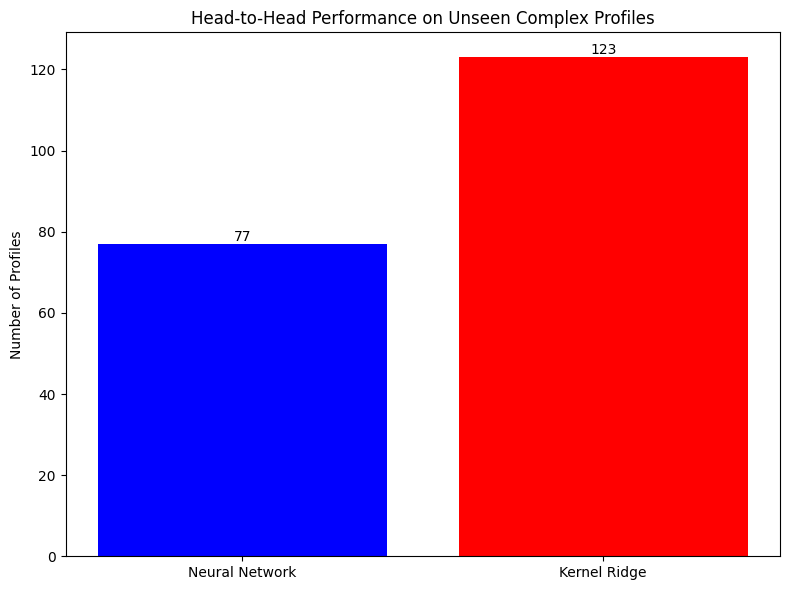

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json
from tqdm import tqdm

# ========== CONFIG ==========
# --- Model & Data Params ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Training Params ---
BATCH_SIZE = 128
EPOCHS = 350 
LR = 5e-4
WEIGHT_DECAY = 1e-5

# --- Data Files & Split ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_1000.csv')
COMPLEX_TRAIN_SPLIT = 0.8

# --- Output ---
OUTPUT_DIR = "CalibratedAlphaEnsemble_analysis_FIXED" 
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")

# ========== 1. DATA PREPARATION ==========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def load_and_process_data(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname in file_paths:
        try:
            df_dist = pd.read_csv(fname, engine='python')
            if df_dist.empty: continue
        except Exception: continue
        
        unique_ids = df_dist['Equation_ID'].unique()
        ids_for_this_file = [id for id in unique_ids if id in ids_to_include] if ids_to_include is not None else unique_ids

        for eq_id in ids_for_this_file:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            k_profile = prof['K(z)'].values if len(prof['K(z)'].values) == profile_length else np.interp(KZ_X_GRID, (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min()), prof['K(z)'].values)
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            eq_ids_out.append(eq_id)
            
    if not X_fourier: return [], [], [], []
    return np.stack(X_fourier), np.stack(Y_profile), KZ_X_GRID, np.array(eq_ids_out)

print("\n--- Step 1: Loading and splitting data ---")
all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
if not os.path.exists(COMPLEX_CSV_FILE):
    raise FileNotFoundError(f"Critical Error: Complex data file not found at '{COMPLEX_CSV_FILE}'")
BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
X_train_base, y_train_base, _, _ = load_and_process_data(BASE_CSV_FILES) if BASE_CSV_FILES else ([], [], [], [])
print(f"Loaded {len(X_train_base)} base profiles for training.")
df_complex = pd.read_csv(COMPLEX_CSV_FILE, engine='python')
complex_ids = df_complex['Equation_ID'].unique()
np.random.seed(42); np.random.shuffle(complex_ids)
split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT)
train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]
print(f"Loaded {len(complex_ids)} complex profiles: {len(train_ids_complex)} for training, {len(test_ids_complex)} for testing.")
X_train_complex, y_train_complex, _, _ = load_and_process_data([COMPLEX_CSV_FILE], ids_to_include=train_ids_complex)
X_test, y_test, KZ_X_GRID, eq_ids_test = load_and_process_data([COMPLEX_CSV_FILE], ids_to_include=test_ids_complex)
X_train = np.concatenate([X_train_base, X_train_complex]) if len(X_train_base) > 0 else X_train_complex
y_train = np.concatenate([y_train_base, y_train_complex]) if len(y_train_base) > 0 else y_train_complex
print(f"Final training set size: {len(X_train)} profiles.")
X_scaler = StandardScaler().fit(X_train); Y_scaler = StandardScaler().fit(y_train)
X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

# ========== 2. TRAIN EXPERT MODELS (NN and KRR) ==========
print("\n--- Step 2: Training Expert Models ---")
class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__(); self.convs = nn.ModuleList([nn.Conv1d(in_channels, out_channels // 4, k, padding=k//2) for k in [3, 7, 11, 15]]); self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x): return F.relu(self.bn(torch.cat([conv(x) for conv in self.convs], dim=1)))

class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__(); self.stem = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, out_dim))
        self.conv_blocks = nn.Sequential(MultiScaleConvBlock(1, 128), nn.Dropout(0.25), MultiScaleConvBlock(128, 256), nn.Dropout(0.25), MultiScaleConvBlock(256, 256), nn.Dropout(0.25), MultiScaleConvBlock(256, 128))
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    def forward(self, x): return self.head(self.conv_blocks(self.stem(x).unsqueeze(1))).squeeze(1)

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__(); self.grad_weight, self.recon_loss = grad_weight, nn.SmoothL1Loss(); self.register_buffer('sobel_filter', torch.tensor([[-1., 0., 1.]]).view(1, 1, 3))
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1); true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        return self.recon_loss(pred, true) + self.grad_weight * F.l1_loss(pred_grad, true_grad)

train_dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
nn_expert = ProfileGeneratorNet().to(DEVICE)
optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = CombinedLoss().to(DEVICE)

print("Training NN Expert...")
# --- FIXED: Reverted to a standard, explicit training loop ---
for epoch in tqdm(range(EPOCHS), desc="NN Training"):
    nn_expert.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = nn_expert(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
print("NN Expert trained.")

print("Training KRR Expert...")
krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr_expert.fit(X_train_scaled, y_train_scaled)
print("KRR Expert trained.")

# ========== 3. TRAIN **CALIBRATED** ALPHA GATING REGRESSOR ==========
print("\n--- Step 3: Training the Calibrated Alpha Gating Regressor ---")
def calculate_optimal_alpha(y_true, pred_krr, pred_nn):
    diff_preds = pred_krr - pred_nn
    numerator = np.sum((y_true - pred_nn) * diff_preds, axis=1)
    denominator = np.sum(diff_preds * diff_preds, axis=1)
    alpha_optimal = np.divide(numerator, denominator, out=np.full_like(numerator, 0.5), where=denominator!=0)
    return np.clip(alpha_optimal, 0, 1)

print("  - Generating expert predictions and calculating optimal alphas for gate training...")
with torch.no_grad():
    y_pred_nn_train_scaled = nn_expert(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled)
y_gate_train_alpha = calculate_optimal_alpha(y_train_scaled, y_pred_krr_train_scaled, y_pred_nn_train_scaled)

print("  - Tuning Alpha Regressor hyperparameters with GridSearchCV...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 1.0]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_gate_train_alpha)
alpha_regressor = grid_search.best_estimator_
print(f"  Best parameters found: {grid_search.best_params_}")
print("Calibrated Alpha Gating Regressor trained.")

# ========== 4. EVALUATE ON UNSEEN TEST SET ==========
print("\n--- Step 4: Evaluating all models on the unseen complex test set ---")
with torch.no_grad():
    y_pred_nn_scaled = nn_expert(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_scaled = krr_expert.predict(X_test_scaled)
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

alpha_pred_raw = alpha_regressor.predict(X_test_scaled)
alpha_calibrated = np.clip(0.5 + 2 * (alpha_pred_raw - 0.5)**3, 0, 1).reshape(-1, 1)
y_pred_ensemble = alpha_calibrated * y_pred_krr + (1 - alpha_calibrated) * y_pred_nn

# ========== 5. DETAILED VISUALIZATION AND ANALYSIS ==========
print("\n--- Step 5: Saving detailed Calibrated AlphaEnsemble results and plots ---")
test_plot_dir = os.path.join(OUTPUT_DIR, "unseen_complex_profiles_plots")
os.makedirs(test_plot_dir, exist_ok=True)
print(f"Saving {len(X_test)} individual overlay plots to '{test_plot_dir}'...")
mse_per_sample_krr = np.mean((y_test - y_pred_krr)**2, axis=1)
mse_per_sample_nn = np.mean((y_test - y_pred_nn)**2, axis=1)

for i in tqdm(range(len(X_test)), desc="Generating Plots"):
    mse_krr, mse_nn = mse_per_sample_krr[i], mse_per_sample_nn[i]
    mse_ensemble = mean_squared_error(y_test[i], y_pred_ensemble[i])
    alpha = alpha_calibrated[i, 0]
    winner = "NN" if mse_nn < mse_krr else "KRR"

    plt.figure(figsize=(12, 6))
    plt.plot(KZ_X_GRID, y_test[i], 'k-', label='Ground Truth', linewidth=2.5, alpha=0.9)
    plt.plot(KZ_X_GRID, y_pred_krr[i], 'r:', label=f'KRR (MSE: {mse_krr:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[i], 'b--', label=f'NN (MSE: {mse_nn:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_ensemble[i], 'g-', label=f'Calibrated Ensemble (MSE: {mse_ensemble:.4f})', linewidth=3, alpha=0.8)
    
    title = f'Unseen Complex Profile #{eq_ids_test[i]} (Actual Winner: {winner})\n'
    title += f"Calibrated Alpha (Weight for KRR): {alpha:.3f}"
    plt.title(title, fontsize=12)
    plt.xlabel("x (normalized thickness)"); plt.ylabel("K(z) [physical units]")
    plt.legend(); plt.grid(True, alpha=0.5); plt.tight_layout()
    plt.savefig(os.path.join(test_plot_dir, f'test_profile_{eq_ids_test[i]}.png'))
    plt.close()

nn_wins = np.sum(mse_per_sample_nn < mse_per_sample_krr)
krr_wins = len(X_test) - nn_wins
plt.figure(figsize=(8, 6)); bars = plt.bar(['Neural Network', 'Kernel Ridge'], [nn_wins, krr_wins], color=['blue', 'red']); plt.ylabel('Number of Profiles'); plt.title('Head-to-Head Performance on Unseen Complex Profiles'); plt.bar_label(bars); plt.tight_layout()
summary_plot_path = os.path.join(OUTPUT_DIR, "nn_vs_krr_wins.png"); plt.savefig(summary_plot_path); print(f"Head-to-head summary plot saved to '{summary_plot_path}'.")

metrics = defaultdict(dict)
get_metrics = lambda y_true, y_pred: {'MSE': mean_squared_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}
metrics['overall_test']['KRR'] = get_metrics(y_test, y_pred_krr)
metrics['overall_test']['NN'] = get_metrics(y_test, y_pred_nn)
metrics['overall_test']['CalibratedAlphaEnsemble'] = get_metrics(y_test, y_pred_ensemble)
metrics['wins']['NN'] = int(nn_wins); metrics['wins']['KRR'] = int(krr_wins)
metrics_path = os.path.join(OUTPUT_DIR, 'final_metrics_summary.json');
with open(metrics_path, 'w') as f: json.dump(metrics, f, indent=4)
print(f"Final metrics summary saved to '{metrics_path}'.")

print("\n--- FINAL METRICS ON UNSEEN TEST DATA (Calibrated AlphaEnsemble) ---")
print(json.dumps(metrics, indent=4))
print("\nExperiment complete.")


In [1]:
# file: train_eval_v4_final_corrected.py
import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

# ========================= CONFIG =========================
RUN_TAG = 'v4_final'
OUTPUT_DIR = f'NumericalEval_{RUN_TAG}'
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for d in [OUTPUT_DIR, f'{OUTPUT_DIR}/_models', f'{OUTPUT_DIR}/_plots', f'{OUTPUT_DIR}/_plots/reconstructions']: os.makedirs(d, exist_ok=True)

N_FOURIER=25; FOURIER_DIM=2*N_FOURIER+1; PROFILE_LENGTH=100
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128; EPOCHS=350; LR=5e-4; WEIGHT_DECAY=1e-5

DATA_DIR='generated_data'
COMPLEX_CSV_FILE=os.path.join(DATA_DIR,'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT=0.8; REGULAR_TEST_SAMPLES=10

print(f"Using device: {DEVICE}\nOutput: {OUTPUT_DIR}\n")

# ========================= JSON SAFETY =========================
def to_builtin(obj):
    import numpy as np, torch as th, pandas as pd
    if isinstance(obj,(np.generic,)): return obj.item()
    if isinstance(obj,np.ndarray): return obj.tolist()
    if isinstance(obj,th.Tensor): return obj.detach().cpu().tolist()
    if isinstance(obj,pd.DataFrame): return obj.to_dict(orient="list")
    if isinstance(obj,pd.Series): return obj.to_dict()
    if isinstance(obj,dict): return {k:to_builtin(v) for k,v in obj.items()}
    if isinstance(obj,(list,tuple)): return [to_builtin(v) for v in obj]
    return obj
def safe_json_dump(obj,fp,**kw): json.dump(to_builtin(obj),fp,**kw)

# ========================= DATA =========================
def compute_fourier_coeffs(x,y,N=N_FOURIER):
    if x.max()==x.min(): return np.zeros(2*N+1,dtype=np.float32)
    xs=2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk,L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                      grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                      grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict,L=PROFILE_LENGTH):
    X,Y,ids,dists=[],[],[],[]
    grid=np.linspace(0,1,L)
    for eq_id,(td,pr,dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values,td['ModelRatio'].values))
        kz=pr['K(z)'].values
        if len(kz)==L: Y.append(kz)
        else:
            xs=pr['x (Thickness)'].values; xs=(xs-xs.min())/(xs.max()-xs.min())
            Y.append(np.interp(grid,xs,kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [],[],[],[],[]
    return np.stack(X),np.stack(Y),grid,np.array(ids),np.array(dists)

def load_data(file_paths,ids_to_include=None,L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp,L)

# ========================= MODELS =========================
class ProfileDataset(Dataset):
    def __init__(self,X,Y): self.X,self.Y=X,Y
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return torch.from_numpy(self.X[idx]).float(),torch.from_numpy(self.Y[idx]).float()

class SimpleResNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,hidden=(256,512,256),dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]
        self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,d_model=256,nhead=8,nlayers=3,dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers)
        self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

class CombinedLoss(nn.Module):
    def __init__(self,grad_weight=0.75):
        super().__init__(); self.grad_weight=grad_weight; self.recon=nn.SmoothL1Loss()
        self.register_buffer('f',torch.tensor([[-1.,0.,1.]]).view(1,1,3))
    def forward(self,pred,true):
        g_pred=F.conv1d(pred.unsqueeze(1),self.f,padding=1); g_true=F.conv1d(true.unsqueeze(1),self.f,padding=1)
        return self.recon(pred,true)+self.grad_weight*F.l1_loss(g_pred,g_true)

def train_nn(model,X_s,Y_s,epochs=EPOCHS,desc='NN'):
    dl=DataLoader(ProfileDataset(X_s,Y_s),batch_size=BATCH_SIZE,shuffle=True)
    opt=optim.AdamW(model.parameters(),lr=LR,weight_decay=WEIGHT_DECAY); crit=CombinedLoss().to(DEVICE); model.to(DEVICE)
    for _ in tqdm(range(epochs),desc=desc):
        model.train()
        for xb,yb in dl:
            xb,yb=xb.to(DEVICE),yb.to(DEVICE)
            opt.zero_grad(); pred=model(xb); loss=crit(pred,yb); loss.backward(); opt.step()
    model.eval()  # FIXED: set to eval mode and ensure no_grad
    return model

# ========================= MAIN =========================
print("--- Step 1: Build split ---")
all_csv=glob.glob(os.path.join(DATA_DIR,'*.csv'))
BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_base,test_base=[],[]
for f in BASE:
    ids=pd.read_csv(f,engine='python',usecols=['Equation_ID','Distribution'])['Equation_ID'].unique(); np.random.shuffle(ids)
    test_base.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c,test_c=cids[:cut],cids[cut:]

X_tr,y_tr,grid,_,_=load_data(all_csv,ids_to_include=train_base+list(train_c))
X_te,y_te,_,te_ids,te_dists=load_data(all_csv,ids_to_include=test_base+list(test_c))
X_scaler=StandardScaler().fit(X_tr); Y_scaler=StandardScaler().fit(y_tr)
Xs_tr,Ys_tr=X_scaler.transform(X_tr),Y_scaler.transform(y_tr); Xs_te=X_scaler.transform(X_te)
print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

print("\n--- Step 2: Train Experts (full data) ---")
transformer=train_nn(TransformerNet(),Xs_tr,Ys_tr,epochs=EPOCHS,desc='Transformer Full')
resnet=train_nn(SimpleResNet(),Xs_tr,Ys_tr,epochs=EPOCHS,desc='ResNet Full')
print("Training KRR...")
krr=KernelRidge(alpha=0.1,gamma=0.07,kernel='laplacian').fit(Xs_tr,Ys_tr)

torch.save(transformer.state_dict(),f'{OUTPUT_DIR}/_models/transformer_{RUN_TAG}.pt')
torch.save(resnet.state_dict(),f'{OUTPUT_DIR}/_models/resnet_{RUN_TAG}.pt')
joblib.dump(krr,f'{OUTPUT_DIR}/_models/krr_{RUN_TAG}.pkl')
joblib.dump({'X_scaler':X_scaler,'Y_scaler':Y_scaler},f'{OUTPUT_DIR}/_models/scalers_{RUN_TAG}.pkl')

# Full-data predictions (FIXED: ensure no_grad)
with torch.no_grad():
    trf_tr_s=transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    res_tr_s=resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    trf_te_s=transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    res_te_s=resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
krr_tr_s=krr.predict(Xs_tr); krr_te_s=krr.predict(Xs_te)

trf_tr=Y_scaler.inverse_transform(trf_tr_s); res_tr=Y_scaler.inverse_transform(res_tr_s)
trf_te=Y_scaler.inverse_transform(trf_te_s); res_te=Y_scaler.inverse_transform(res_te_s)
krr_tr=Y_scaler.inverse_transform(krr_tr_s); krr_te=Y_scaler.inverse_transform(krr_te_s)

nn_tr=np.where(((y_tr-trf_tr)**2).mean(axis=1,keepdims=True)<=((y_tr-res_tr)**2).mean(axis=1,keepdims=True),trf_tr,res_tr)
nn_te=np.where(((y_te-trf_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_te)**2).mean(axis=1,keepdims=True),trf_te,res_te)

print("\n--- Step 3: Train Hard Gate ---")
mse_nn_tr=((y_tr-nn_tr)**2).mean(axis=1); mse_krr_tr=((y_tr-krr_tr)**2).mean(axis=1)
lab=(mse_nn_tr<mse_krr_tr).astype(int)
gate=RandomForestClassifier(n_estimators=300,max_depth=20,min_samples_leaf=5,class_weight='balanced',random_state=42,n_jobs=-1).fit(Xs_tr,lab)

idx=np.arange(len(Xs_tr)); np.random.shuffle(idx); val=idx[:max(1000,len(idx)//5)]
proba_val=gate.predict_proba(Xs_tr[val])[:,1]; best_thr,best_loss=0.5,np.inf
for t in np.linspace(0.3,0.7,41):
    pick=(proba_val>=t).astype(int).reshape(-1,1)
    chosen=np.where(pick==1,nn_tr[val],krr_tr[val])
    loss=((y_tr[val]-chosen)**2).mean()
    if loss<best_loss: best_loss,best_thr=loss,t

proba_te=gate.predict_proba(Xs_te)[:,1].reshape(-1,1)
pick_te=(proba_te>=best_thr).astype(int)
hard_te=np.where(pick_te==1,nn_te,krr_te)
joblib.dump({'gate':gate,'threshold':best_thr},f'{OUTPUT_DIR}/_models/gate_{RUN_TAG}.pkl')

print("\n--- Step 4: Ensemble Agreement Analysis (FIXED) ---")
mse_nn_te=((y_te-nn_te)**2).mean(axis=1); mse_krr_te=((y_te-krr_te)**2).mean(axis=1); mse_hard_te=((y_te-hard_te)**2).mean(axis=1)

# FIXED: Count profiles where ensemble beats BOTH experts
ensemble_beats_both=((mse_hard_te<mse_nn_te) & (mse_hard_te<mse_krr_te)).sum()
ensemble_beats_nn_only=((mse_hard_te<mse_nn_te) & (mse_hard_te>=mse_krr_te)).sum()
ensemble_beats_krr_only=((mse_hard_te<mse_krr_te) & (mse_hard_te>=mse_nn_te)).sum()
ensemble_beats_at_least_one=(mse_hard_te<np.minimum(mse_nn_te,mse_krr_te)).sum()

# Count which expert actually won per sample
true_winner_nn=(mse_nn_te<mse_krr_te).astype(int)
gate_chose_nn=pick_te.flatten()
correct_choice=(true_winner_nn==gate_chose_nn).sum()

agreement={'total_samples':len(y_te),
           'ensemble_beats_both_experts':int(ensemble_beats_both),
           'ensemble_beats_at_least_one':int(ensemble_beats_at_least_one),
           'ensemble_beats_nn_only':int(ensemble_beats_nn_only),
           'ensemble_beats_krr_only':int(ensemble_beats_krr_only),
           'gate_chose_winning_expert':int(correct_choice),
           'agreement_rate':float(correct_choice/len(y_te)),
           'nn_wins':int(true_winner_nn.sum()),
           'krr_wins':int((1-true_winner_nn).sum()),
           'ensemble_mean_mse':float(mse_hard_te.mean()),
           'nn_mean_mse':float(mse_nn_te.mean()),
           'krr_mean_mse':float(mse_krr_te.mean())}

print(f"Ensemble beats BOTH experts: {ensemble_beats_both}/{len(y_te)}")
print(f"Ensemble beats at least one: {ensemble_beats_at_least_one}/{len(y_te)}")
print(f"Gate chose winning expert: {correct_choice}/{len(y_te)} ({100*correct_choice/len(y_te):.1f}%)")
print(f"NN wins: {true_winner_nn.sum()} | KRR wins: {(1-true_winner_nn).sum()}")

print("\n--- Step 5: Reconstruction Plots (sample) ---")
for i in tqdm(range(min(len(y_te),50)),desc='Sample Reconstructions'):
    dist=te_dists[i]; os.makedirs(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}',exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(grid,y_te[i],'k-',lw=2.5,label='Ground Truth')
    plt.plot(grid,krr_te[i],'r--',lw=1.8,label=f'KRR MSE={mse_krr_te[i]:.4f}')
    plt.plot(grid,nn_te[i],'b-.',lw=2,label=f'Best NN MSE={mse_nn_te[i]:.4f}')
    plt.plot(grid,hard_te[i],'g-',lw=2.2,alpha=0.85,label=f'Ensemble MSE={mse_hard_te[i]:.4f}')
    plt.title(f'{dist} | ID={int(te_ids[i])}'); plt.xlabel('Normalized depth'); plt.ylabel('K(z)')
    plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}/id_{int(te_ids[i])}.png',dpi=200); plt.close()

print("\n--- Step 6: Winners Plots (FIXED logic) ---")
# FIXED: winner is whoever has lowest MSE per sample
df=pd.DataFrame({'dist':te_dists,'mse_nn':mse_nn_te,'mse_krr':mse_krr_te,'mse_hard':mse_hard_te})
df['winner']=df.apply(lambda r:['best_nn','krr','hard_ensemble'][int(np.argmin([r.mse_nn,r.mse_krr,r.mse_hard]))],axis=1)
w=df.groupby(['dist','winner']).size().unstack(fill_value=0).reindex(columns=['best_nn','krr','hard_ensemble']).fillna(0).astype(int)
w.to_csv(f'{OUTPUT_DIR}/_plots/winners_all.csv')

plt.figure(figsize=(12,6)); x=np.arange(len(w)); wd=0.25
plt.bar(x-wd,w['best_nn'],width=wd,color='navy',label='Best NN')
plt.bar(x,w['krr'],width=wd,color='red',label='KRR')
plt.bar(x+wd,w['hard_ensemble'],width=wd,color='green',label='Hard Ensemble')
plt.xticks(x,w.index,rotation=25,ha='right'); plt.ylabel('Number of profiles (winner)'); plt.title('Winners per distribution')
plt.grid(True,axis='y',alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/winners_all.png',dpi=300); plt.close()

mask_c=df['dist'].astype(str).str.contains('complex',case=False)
c=df[mask_c]['winner'].value_counts()
plt.figure(figsize=(6,5))
plt.bar(['Best NN','KRR','Hard Ensemble'],[int(c.get('best_nn',0)),int(c.get('krr',0)),int(c.get('hard_ensemble',0))],color=['navy','red','green'])
plt.ylabel('Number of complex profiles (winner)'); plt.title('Complex Nonlinear: winners'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/winners_complex.png',dpi=300); plt.close()

print("\n--- Step 7: Generalizability (common→unseen) ---")
X_comm,y_comm,_,_,_=load_data(all_csv,ids_to_include=train_base)
Xs_comm,Ys_comm=X_scaler.transform(X_comm),Y_scaler.transform(y_comm)
krr_c=KernelRidge(alpha=0.1,gamma=0.07,kernel='laplacian').fit(Xs_comm,Ys_comm)
trf_c=train_nn(TransformerNet(),Xs_comm,Ys_comm,epochs=int(EPOCHS*0.75),desc='Trf Common')
res_c=train_nn(SimpleResNet(),Xs_comm,Ys_comm,epochs=int(EPOCHS*0.75),desc='Res Common')

X_unseen,y_unseen,_,_,_=load_data(all_csv,ids_to_include=list(test_c))
Xs_unseen=X_scaler.transform(X_unseen)
with torch.no_grad():
    tru_s=trf_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
    rsu_s=res_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
tru=Y_scaler.inverse_transform(tru_s); rsu=Y_scaler.inverse_transform(rsu_s)
krru=Y_scaler.inverse_transform(krr_c.predict(Xs_unseen))
nnu=np.where(((y_unseen-tru)**2).mean(axis=1,keepdims=True)<=((y_unseen-rsu)**2).mean(axis=1,keepdims=True),tru,rsu)

# FIXED: Gate on common (no_grad)
with torch.no_grad():
    trc=Y_scaler.inverse_transform(trf_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy())
    rsc=Y_scaler.inverse_transform(res_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy())
nnc=np.where(((y_comm-trc)**2).mean(axis=1,keepdims=True)<=((y_comm-rsc)**2).mean(axis=1,keepdims=True),trc,rsc)
krrc=Y_scaler.inverse_transform(krr_c.predict(Xs_comm))
lab_c=(((y_comm-nnc)**2).mean(axis=1)<((y_comm-krrc)**2).mean(axis=1)).astype(int)
gate_c=RandomForestClassifier(n_estimators=300,max_depth=20,min_samples_leaf=5,class_weight='balanced',random_state=42,n_jobs=-1).fit(Xs_comm,lab_c)

pick_u=(gate_c.predict_proba(Xs_unseen)[:,1].reshape(-1,1)>=0.5).astype(int)
hard_u=np.where(pick_u==1,nnu,krru)

def mse(a,b): return float(np.mean((a-b)**2))
nn_full_u=nn_te[mask_c.values]; krr_full_u=krr_te[mask_c.values]; hard_full_u=hard_te[mask_c.values]

mse_nn_u,mse_krr_u,mse_hard_u=mse(y_unseen,nnu),mse(y_unseen,krru),mse(y_unseen,hard_u)
mse_nn_full,mse_krr_full,mse_hard_full=mse(y_unseen,nn_full_u),mse(y_unseen,krr_full_u),mse(y_unseen,hard_full_u)
deg_nn,deg_krr,deg_hard=(mse_nn_u-mse_nn_full)/max(mse_nn_full,1e-8),(mse_krr_u-mse_krr_full)/max(mse_krr_full,1e-8),(mse_hard_u-mse_hard_full)/max(mse_hard_full,1e-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(['KRR','Best NN','Hard Ensemble'],[mse_krr_u,mse_nn_u,mse_hard_u],color=['red','navy','green'])
plt.title('Generalizability: MSE on unseen complex'); plt.ylabel('MSE'); plt.grid(True,axis='y',alpha=0.3)
plt.subplot(1,2,2)
plt.bar(['KRR','Best NN','Hard Ensemble'],[deg_krr,deg_nn,deg_hard],color=['red','navy','green'])
plt.title('Relative degradation (vs full-data)'); plt.ylabel('Degradation'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/generalizability.png',dpi=300); plt.close()

print("\n--- Step 8: Efficiency (retrain per fraction) ---")
fracs=[0.25,0.5,0.75,1.0]; mse_rows,time_rows=[],[]
for frac in fracs:
    n=int(len(Xs_tr)*frac); ep=int(EPOCHS*(0.5+frac/2))
    t0=time.time(); krr_f=KernelRidge(alpha=0.1,gamma=0.07,kernel='laplacian').fit(Xs_tr[:n],Ys_tr[:n]); t_krr=time.time()-t0
    
    trf_f=train_nn(TransformerNet(),Xs_tr[:n],Ys_tr[:n],epochs=ep,desc=f'Trf {int(frac*100)}%')
    res_f=train_nn(SimpleResNet(),Xs_tr[:n],Ys_tr[:n],epochs=ep,desc=f'Res {int(frac*100)}%')
    
    with torch.no_grad():
        trf_f_te=Y_scaler.inverse_transform(trf_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy())
        res_f_te=Y_scaler.inverse_transform(res_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy())
    krr_f_te=Y_scaler.inverse_transform(krr_f.predict(Xs_te))
    nn_f_te=np.where(((y_te-trf_f_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_f_te)**2).mean(axis=1,keepdims=True),trf_f_te,res_f_te)
    
    with torch.no_grad():
        trf_f_tr=Y_scaler.inverse_transform(trf_f(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy())
        res_f_tr=Y_scaler.inverse_transform(res_f(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy())
    nn_f_tr=np.where(((y_tr[:n]-trf_f_tr)**2).mean(axis=1,keepdims=True)<=((y_tr[:n]-res_f_tr)**2).mean(axis=1,keepdims=True),trf_f_tr,res_f_tr)
    krr_f_tr=Y_scaler.inverse_transform(krr_f.predict(Xs_tr[:n]))
    lab_f=(((y_tr[:n]-nn_f_tr)**2).mean(axis=1)<((y_tr[:n]-krr_f_tr)**2).mean(axis=1)).astype(int)
    gate_f=RandomForestClassifier(n_estimators=300,max_depth=20,min_samples_leaf=5,class_weight='balanced',random_state=42,n_jobs=-1)
    t1=time.time(); gate_f.fit(Xs_tr[:n],lab_f); t_gate=time.time()-t1
    
    proba_f=gate_f.predict_proba(Xs_te)[:,1].reshape(-1,1); pick_f=(proba_f>=0.5).astype(int)
    hard_f=np.where(pick_f==1,nn_f_te,krr_f_te)
    
    mse_rows.append({'frac':frac,'krr':mse(y_te,krr_f_te),'best_nn':mse(y_te,nn_f_te),'hard_ensemble':mse(y_te,hard_f)})
    time_rows.append({'frac':frac,'krr':float(t_krr),'gate':float(t_gate)})

dfm=pd.DataFrame(mse_rows); dft=pd.DataFrame(time_rows)
plt.figure(figsize=(10,6))
for key,color in [('krr','red'),('best_nn','navy'),('hard_ensemble','green')]:
    plt.plot(dfm['frac'],dfm[key],marker='o',label=key.upper(),color=color)
plt.xlabel('Fraction of training data'); plt.ylabel('Test MSE'); plt.title('Performance vs data size')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_mse.png',dpi=300); plt.close()

plt.figure(figsize=(10,6)); wd=0.04; x=dft['frac'].values
plt.bar(x-wd,dft['krr'],width=wd,color='red',label='KRR time')
plt.bar(x+wd,dft['gate'],width=wd,color='green',label='Gate time')
plt.yscale('log'); plt.xlabel('Fraction of training data'); plt.ylabel('Time (s, log)'); plt.title('Computational cost')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_time.png',dpi=300); plt.close()

summary={'agreement':agreement,'winners':w.reset_index().to_dict(orient='list'),'generalizability':{'mse_common':{'krr':mse_krr_u,'best_nn':mse_nn_u,'hard_ensemble':mse_hard_u},'mse_full':{'krr':mse_krr_full,'best_nn':mse_nn_full,'hard_ensemble':mse_hard_full},'degradation':{'krr':deg_krr,'best_nn':deg_nn,'hard_ensemble':deg_hard}},'efficiency':{'mse_vs_size':mse_rows,'time_vs_size':time_rows}}
with open(f'{OUTPUT_DIR}/_plots/summary.json','w') as f: safe_json_dump(summary,f,indent=4)
print(f"\nDone! All outputs in {OUTPUT_DIR}")
print(f"\n=== KEY FINDINGS ===")
print(f"Ensemble beats BOTH experts in: {agreement[ 'ensemble_beats_both_experts']}/{agreement['total_samples']} cases")
print(f"Ensemble beats at least one expert: {agreement['ensemble_beats_at_least_one']}/{agreement['total_samples']} cases")
print(f"Gate correctly chose winning expert: {agreement['gate_chose_winning_expert']}/{agreement['total_samples']} ({100*agreement['agreement_rate']:.1f}%)")


Using device: cpu
Output: NumericalEval_v4_final

--- Step 1: Build split ---
Train: 5350 | Test: 670

--- Step 2: Train Experts (full data) ---


ResNet Full: 100%|██████████| 350/350 [01:25<00:00,  4.08it/s]


Training KRR...

--- Step 3: Train Hard Gate ---

--- Step 4: Ensemble Agreement Analysis (FIXED) ---
Ensemble beats BOTH experts: 0/670
Ensemble beats at least one: 0/670
Gate chose winning expert: 398/670 (59.4%)
NN wins: 445 | KRR wins: 225

--- Step 5: Reconstruction Plots (sample) ---


Sample Reconstructions: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]



--- Step 6: Winners Plots (FIXED logic) ---

--- Step 7: Generalizability (common→unseen) ---


Res Common: 100%|██████████| 262/262 [00:34<00:00,  7.49it/s]



--- Step 8: Efficiency (retrain per fraction) ---


Res 100%: 100%|██████████| 350/350 [01:16<00:00,  4.59it/s]



Done! All outputs in NumericalEval_v4_final

=== KEY FINDINGS ===
Ensemble beats BOTH experts in: 0/670 cases
Ensemble beats at least one expert: 0/670 cases
Gate correctly chose winning expert: 398/670 (59.4%)


In [1]:
# file: inference.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

# ========================= CONFIG =========================
# --- Configure paths based on your v8 run ---
V8_RUN_TAG = 'v8_final_fix'
MODEL_DIR = f'NumericalEval_{V8_RUN_TAG}/_models'
DATA_DIR = 'generated_data'

# --- Output for new plots ---
PLOT_OUTPUT_DIR = 'v8_complex_reconstructions'
os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)

# --- Constants from v8 script ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8

print(f"Using device: {DEVICE}")
print(f"Loading models from: {MODEL_DIR}")
print(f"Saving plots to: {PLOT_OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied from v8) =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2 * np.pi * (x - x.min()) / (x.max() - x.min()); a0 = np.trapz(y, xs) / (2 * np.pi); a, b = [], []
    for n in range(1, N + 1): a.append(np.trapz(y * np.cos(n * xs), xs) / np.pi); b.append(np.trapz(y * np.sin(n * xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
        kz = pr['K(z)'].values
        if len(kz) == L: Y.append(kz)
        else:
            xs = pr['x (Thickness)'].values; xs = (xs - xs.min()) / (xs.max() - xs.min())
            Y.append(np.interp(grid, xs, kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [], [], [], [], []
    return np.stack(X), np.stack(Y), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None: chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk, L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp, L)

# ========================= MODEL CLASSES (Copied from v8) =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers = []; cur = input_dim
        for h in hidden: layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]; cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model * 2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1); z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= INFERENCE SCRIPT =========================
if __name__ == "__main__":
    
    # --- 1. Load all saved models ---
    print("Loading models...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V8_RUN_TAG}.pkl'))
    X_scaler = scalers['X_scaler']
    Y_scaler = scalers['Y_scaler']

    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V8_RUN_TAG}.pkl'))
    gate_regressor = joblib.load(os.path.join(MODEL_DIR, f'gate_regressor_{V8_RUN_TAG}.pkl'))

    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V8_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()

    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V8_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    print("Models loaded successfully.")

    # --- 2. Re-create the complex test split ---
    np.random.seed(42) # Use the same seed to get the same shuffle
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
    np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT)
    test_c_ids = cids[cut:] # These are the complex test profile IDs
    
    print(f"Found {len(test_c_ids)} complex test profiles.")

    # --- 3. Load only the complex test data ---
    X_complex, y_complex, grid, complex_ids, complex_dists = load_data(
        [COMPLEX_CSV_FILE], 
        ids_to_include=test_c_ids
    )

    # --- 4. Run the full inference pipeline ---
    print("Running inference...")
    # Scale inputs
    Xs_complex = X_scaler.transform(X_complex)
    y_complex_s = Y_scaler.transform(y_complex)

    # Get SCALED predictions (for meta-features)
    with torch.no_grad():
        trf_te_s = transformer(torch.from_numpy(Xs_complex).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_complex).float().to(DEVICE)).cpu().numpy()
    krr_te_s = krr.predict(Xs_complex)
    
    # Get SCALED "Best NN" predictions
    nn_te_s = np.where(
        ((y_complex_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= 
        ((y_complex_s - res_te_s)**2).mean(axis=1, keepdims=True),
        trf_te_s, res_te_s
    )

    # Create Meta-Features for Gate
    Xs_te_gate = np.concatenate([Xs_complex, krr_te_s, nn_te_s], axis=1)

    # Run Gate
    transformed_pred_te = gate_regressor.predict(Xs_te_gate).reshape(-1, 1)
    pick_te = (transformed_pred_te > 0).astype(int)

    # Get UNSCALED final predictions
    krr_te = Y_scaler.inverse_transform(krr_te_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s)
    res_te = Y_scaler.inverse_transform(res_te_s)

    nn_te = np.where(
        ((y_complex - trf_te)**2).mean(axis=1, keepdims=True) <= 
        ((y_complex - res_te)**2).mean(axis=1, keepdims=True),
        trf_te, res_te
    )
    
    hard_te = np.where(pick_te == 1, nn_te, krr_te)
    print("Inference complete.")

    # --- 5. Calculate MSEs ---
    mse_krr_te = ((y_complex - krr_te)**2).mean(axis=1)
    mse_nn_te = ((y_complex - nn_te)**2).mean(axis=1)
    mse_hard_te = ((y_complex - hard_te)**2).mean(axis=1)
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)

    # --- 6. Plot and save all reconstructions ---
    print(f"Generating and saving {len(y_complex)} plots...")
    for i in tqdm(range(len(y_complex)), desc='Saving Plots'):
        dist = complex_dists[i]
        eq_id = int(complex_ids[i])
        
        plt.figure(figsize=(8, 5))
        plt.plot(grid, y_complex[i], 'k-', lw=2.5, label='Ground Truth')
        plt.plot(grid, krr_te[i], 'r--', lw=1.8, label=f'KRR MSE={mse_krr_te[i]:.4f}')
        plt.plot(grid, nn_te[i], 'b-.', lw=2, label=f'Best NN MSE={mse_nn_te[i]:.4f}')
        plt.plot(grid, hard_te[i], 'g-', lw=2.2, alpha=0.85, label=f'Ensemble MSE={mse_hard_te[i]:.4f}')
        
        gate_pick_str = "NN" if pick_te[i] == 1 else "KRR"
        true_winner_str = "NN" if true_winner_nn[i] == 1 else "KRR"
        title_color = 'green' if gate_pick_str == true_winner_str else 'red'
        
        plt.title(f'{dist} | ID={eq_id}\nGate Pick: {gate_pick_str} (True Winner: {true_winner_str})', color=title_color)
        plt.xlabel('Normalized depth')
        plt.ylabel('K(z)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_OUTPUT_DIR, f'complex_id_{eq_id}.png'), dpi=200)
        plt.close()

    print(f"\nDone! All {len(y_complex)} complex plots are saved in {PLOT_OUTPUT_DIR}")

Using device: cpu
Loading models from: NumericalEval_v8_final_fix/_models
Saving plots to: v8_complex_reconstructions
Loading models...
Models loaded successfully.
Found 600 complex test profiles.
Running inference...
Inference complete.
Generating and saving 600 plots...


Saving Plots: 100%|██████████| 600/600 [01:49<00:00,  5.50it/s]


Done! All 600 complex plots are saved in v8_complex_reconstructions


In [1]:
# file: generate_specific_plots_with_ensemble.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

# ========================= CONFIG =========================
# --- Configure paths based on your v8 run ---
V8_RUN_TAG = 'v8_final_fix'
MODEL_DIR = f'NumericalEval_{V8_RUN_TAG}/_models'
DATA_DIR = 'generated_data'

# --- Output for new plots ---
PLOT_OUTPUT_DIR = 'v8_specific_plots' # Will save here
os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)

# --- Specific IDs to plot ---
IDS_TO_PLOT = [10002, 10065]

# --- Constants from v8 script ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')

print(f"Using device: {DEVICE}")
print(f"Loading models from: {MODEL_DIR}")
print(f"Saving plots to: {PLOT_OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied from v8) =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2 * np.pi * (x - x.min()) / (x.max() - x.min()); a0 = np.trapz(y, xs) / (2 * np.pi); a, b = [], []
    for n in range(1, N + 1): a.append(np.trapz(y * np.cos(n * xs), xs) / np.pi); b.append(np.trapz(y * np.sin(n * xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L: Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else: 
                     Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception as e:
            print(f"Warning: Skipping profile {eq_id} due to error: {e}")
            
    if not X: 
        print("Warning: No profiles were successfully processed in finalize().")
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
        
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]

    if len(Y_processed) != len(X):
         print(f"Warning: Mismatch in processed profiles. X: {len(X)}, Y: {len(Y_processed)}. Using only corresponding profiles.")
         X = [X[i] for i in corresponding_indices]
         ids = [ids[i] for i in corresponding_indices]
         dists = [dists[i] for i in corresponding_indices]
         if not X: 
              return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
                
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)


def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None: chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk, L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    
    finalized_data = finalize(allp, L)
    if finalized_data[0].shape[0] == 0:
         print(f"Warning: Could not load any data for IDs {ids_to_include}")
    return finalized_data

# ========================= MODEL CLASSES (Copied from v8) =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers = []; cur = input_dim
        for h in hidden: layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]; cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model * 2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1); z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= INFERENCE SCRIPT =========================
if __name__ == "__main__":
    
    # --- 1. Load all saved models ---
    print("Loading models...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V8_RUN_TAG}.pkl'))
    X_scaler = scalers['X_scaler']
    Y_scaler = scalers['Y_scaler']

    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V8_RUN_TAG}.pkl'))
    gate_regressor = joblib.load(os.path.join(MODEL_DIR, f'gate_regressor_{V8_RUN_TAG}.pkl'))

    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V8_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()

    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V8_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    print("Models loaded successfully.")

    # --- 2. Load only the specific data ---
    all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    print(f"Loading data for specific IDs: {IDS_TO_PLOT} from all CSVs...")
    
    X_specific, y_specific, grid, specific_ids, specific_dists = load_data(
        all_csv_files, 
        ids_to_include=IDS_TO_PLOT
    )
    
    if len(X_specific) == 0:
        raise ValueError(f"Could not find data for IDs {IDS_TO_PLOT}. Check DATA_DIR and CSV files.")
    
    print(f"Successfully loaded {len(X_specific)} profiles.")

    # --- 3. Run the full inference pipeline ---
    print("Running inference...")
    Xs_specific = X_scaler.transform(X_specific)
    y_specific_s = Y_scaler.transform(y_specific)
    with torch.no_grad():
        trf_te_s = transformer(torch.from_numpy(Xs_specific).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_specific).float().to(DEVICE)).cpu().numpy()
    krr_te_s = krr.predict(Xs_specific)
    nn_te_s = np.where(
        ((y_specific_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= 
        ((y_specific_s - res_te_s)**2).mean(axis=1, keepdims=True),
        trf_te_s, res_te_s
    )
    Xs_te_gate = np.concatenate([Xs_specific, krr_te_s, nn_te_s], axis=1)
    transformed_pred_te = gate_regressor.predict(Xs_te_gate).reshape(-1, 1)
    pick_te = (transformed_pred_te > 0).astype(int)
    krr_te = Y_scaler.inverse_transform(krr_te_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s)
    res_te = Y_scaler.inverse_transform(res_te_s)
    nn_te = np.where(
        ((y_specific - trf_te)**2).mean(axis=1, keepdims=True) <= 
        ((y_specific - res_te)**2).mean(axis=1, keepdims=True),
        trf_te, res_te
    )
    hard_te = np.where(pick_te == 1, nn_te, krr_te)
    print("Inference complete.")

    # --- 4. Calculate MSEs ---
    mse_krr_te = ((y_specific - krr_te)**2).mean(axis=1)
    mse_nn_te = ((y_specific - nn_te)**2).mean(axis=1)
    mse_hard_te = ((y_specific - hard_te)**2).mean(axis=1)

    # --- 5. Plot and save specific reconstructions (MODIFIED) ---
    print(f"Generating and saving {len(y_specific)} plots...")
    
    # Define font size
    FONT_SIZE = 14
    
    for i in range(len(y_specific)):
        eq_id = int(specific_ids[i])
        
        # --- Create Plot ---
        plt.figure(figsize=(7, 4)) # Modified figure size
        plt.plot(grid, y_specific[i], 'k-', lw=2.5, label='Ground Truth')
        plt.plot(grid, krr_te[i], 'r--', lw=2.0, label=f'KRR (MSE={mse_krr_te[i]:.4f})')
        plt.plot(grid, nn_te[i], 'b-.', lw=2.0, label=f'FNN (MSE={mse_nn_te[i]:.4f})')
        
        # --- *** MODIFIED ENSEMBLE PLOT LINE *** ---
        plt.plot(grid, hard_te[i], 'g-', lw=1.8, alpha=0.85, label=f'Ensemble (MSE={mse_hard_te[i]:.4f})')
        
        # --- Apply Formatting ---
        plt.xlabel('Normalized depth', fontsize=FONT_SIZE)
        plt.ylabel('K(z)', fontsize=FONT_SIZE)
        plt.legend(fontsize=FONT_SIZE - 2) # Slightly smaller legend
        plt.xticks(fontsize=FONT_SIZE - 2)
        plt.yticks(fontsize=FONT_SIZE - 2)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # --- Save ---
        plot_filename = f'id_{eq_id}_reconstruction.png'
        plt.savefig(os.path.join(PLOT_OUTPUT_DIR, plot_filename), dpi=200)
        plt.close()

    print(f"\nDone! {len(y_specific)} plots are saved in {PLOT_OUTPUT_DIR}")

Using device: cpu
Loading models from: NumericalEval_v8_final_fix/_models
Saving plots to: v8_specific_plots
Loading models...
Models loaded successfully.
Loading data for specific IDs: [10002, 10065] from all CSVs...
Successfully loaded 2 profiles.
Running inference...
Inference complete.
Generating and saving 2 plots...

Done! 2 plots are saved in v8_specific_plots


In [1]:
# file: train_eval_v9_xgboost.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor # <-- IMPORT XGBOOST
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm



# ========================= CONFIG =========================
RUN_TAG = 'v9_xgboost_gate' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{RUN_TAG}'
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for d in [OUTPUT_DIR, f'{OUTPUT_DIR}/_models', f'{OUTPUT_DIR}/_plots', f'{OUTPUT_DIR}/_plots/reconstructions']: os.makedirs(d, exist_ok=True)

N_FOURIER=25; FOURIER_DIM=2*N_FOURIER+1; PROFILE_LENGTH=100
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128; EPOCHS=350; LR=5e-4; WEIGHT_DECAY=1e-5
NN_VAL_SPLIT_SIZE=0.15

DATA_DIR='generated_data'
COMPLEX_CSV_FILE=os.path.join(DATA_DIR,'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT=0.8; REGULAR_TEST_SAMPLES=10

print(f"Using device: {DEVICE}\nOutput: {OUTPUT_DIR}\n")

# ========================= JSON SAFETY =========================
def to_builtin(obj):
    import numpy as np, torch as th, pandas as pd
    if isinstance(obj,(np.generic,)): return obj.item()
    if isinstance(obj,np.ndarray): return obj.tolist()
    if isinstance(obj,th.Tensor): return obj.detach().cpu().tolist()
    if isinstance(obj,pd.DataFrame): return obj.to_dict(orient="list")
    if isinstance(obj,pd.Series): return obj.to_dict()
    if isinstance(obj,dict): return {k:to_builtin(v) for k,v in obj.items()}
    if isinstance(obj,(list,tuple)): return [to_builtin(v) for v in obj]
    return obj
def safe_json_dump(obj,fp,**kw): json.dump(to_builtin(obj),fp,**kw)

# ========================= DATA =========================
# (Data loading functions are unchanged)
def compute_fourier_coeffs(x,y,N=N_FOURIER):
    if x.max()==x.min(): return np.zeros(2*N+1,dtype=np.float32)
    xs=2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk,L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict,L=PROFILE_LENGTH):
    X,Y,ids,dists=[],[],[],[]
    grid=np.linspace(0,1,L)
    for eq_id,(td,pr,dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values,td['ModelRatio'].values))
        kz=pr['K(z)'].values
        if len(kz)==L: Y.append(kz)
        else:
            xs=pr['x (Thickness)'].values; xs=(xs-xs.min())/(xs.max()-xs.min())
            Y.append(np.interp(grid,xs,kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [],[],[],[],[]
    return np.stack(X),np.stack(Y),grid,np.array(ids),np.array(dists)

def load_data(file_paths,ids_to_include=None,L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp,L)

# ========================= MODELS =========================
# (Model definitions are unchanged)
class ProfileDataset(Dataset):
    def __init__(self,X,Y): self.X,self.Y=X,Y
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return torch.from_numpy(self.X[idx]).float(),torch.from_numpy(self.Y[idx]).float()

class SimpleResNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,hidden=(256,512,256),dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]
        self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,d_model=256,nhead=8,nlayers=3,dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers)
        self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

class CombinedLoss(nn.Module):
    def __init__(self,grad_weight=0.75):
        super().__init__(); self.grad_weight=grad_weight; self.recon=nn.SmoothL1Loss()
        self.register_buffer('f',torch.tensor([[-1.,0.,1.]]).view(1,1,3))
    def forward(self,pred,true):
        g_pred=F.conv1d(pred.unsqueeze(1),self.f,padding=1); g_true=F.conv1d(true.unsqueeze(1),self.f,padding=1)
        return self.recon(pred,true)+self.grad_weight*F.l1_loss(g_pred,g_true)

def train_nn(model, X_train, Y_train, X_val, Y_val, epochs=EPOCHS, desc='NN', early_stop_patience=50, lr_patience=15):
    train_ds = ProfileDataset(X_train, Y_train)
    val_ds = ProfileDataset(X_val, Y_val)
    dl_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    dl_val = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = CombinedLoss().to(DEVICE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=lr_patience)
    model.to(DEVICE)
    best_val_loss = np.inf
    best_model_state = model.state_dict() 
    epochs_no_improve = 0
    
    pbar = tqdm(range(epochs), desc=desc)
    for epoch in pbar:
        model.train()
        for xb, yb in dl_train:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); pred = model(xb); loss = crit(pred, yb); loss.backward(); opt.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in dl_val:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb) 
                val_loss += crit(pred, yb).item()
        
        avg_val_loss = val_loss / max(1, len(dl_val))
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        pbar.set_postfix({'val_loss': f'{avg_val_loss:.6f}', 'best_loss': f'{best_val_loss:.6f}', 'lr': f"{opt.param_groups[0]['lr']:.2e}"})

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
            break
            
    if best_model_state: model.load_state_dict(best_model_state)
    model.eval()
    return model

# ========================= MAIN =========================
print("--- Step 1: Build split ---")
all_csv=glob.glob(os.path.join(DATA_DIR,'*.csv'))
BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_base,test_base=[],[]
for f in BASE:
    ids=pd.read_csv(f,engine='python',usecols=['Equation_ID','Distribution'])['Equation_ID'].unique(); np.random.shuffle(ids)
    test_base.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c,test_c=cids[:cut],cids[cut:]

X_tr,y_tr,grid,_,_=load_data(all_csv,ids_to_include=train_base+list(train_c))
X_te,y_te,_,te_ids,te_dists=load_data(all_csv,ids_to_include=test_base+list(test_c))
X_scaler=StandardScaler().fit(X_tr); Y_scaler=StandardScaler().fit(y_tr)
Xs_tr,Ys_tr=X_scaler.transform(X_tr),Y_scaler.transform(y_tr); Xs_te=X_scaler.transform(X_te)
y_te_s = Y_scaler.transform(y_te) # Scaled test y for comparisons

print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

X_train_nn, X_val_nn, Y_train_nn, Y_val_nn = train_test_split(
    Xs_tr, Ys_tr, test_size=NN_VAL_SPLIT_SIZE, random_state=42
)
print(f"NN Train Split: {len(X_train_nn)} | NN Val Split: {len(X_val_nn)}")


print("\n--- Step 2: Train Experts (full data) ---")
transformer=train_nn(TransformerNet(), X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, epochs=EPOCHS, desc='Transformer Full')
resnet=train_nn(SimpleResNet(), X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, epochs=EPOCHS, desc='ResNet Full')

print("Tuning KRR (GridSearch)...")
krr_params = {'alpha': [0.01, 0.1, 1.0], 'gamma': [0.01, 0.05, 0.07, 0.1]}
krr_grid_search = GridSearchCV(
    KernelRidge(kernel='laplacian'),
    param_grid=krr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)
krr_grid_search.fit(Xs_tr, Ys_tr)
krr = krr_grid_search.best_estimator_
print(f"Best KRR params: {krr_grid_search.best_params_}")


torch.save(transformer.state_dict(),f'{OUTPUT_DIR}/_models/transformer_{RUN_TAG}.pt')
torch.save(resnet.state_dict(),f'{OUTPUT_DIR}/_models/resnet_{RUN_TAG}.pt')
joblib.dump(krr,f'{OUTPUT_DIR}/_models/krr_{RUN_TAG}.pkl')
joblib.dump(krr_grid_search.best_params_, f'{OUTPUT_DIR}/_models/krr_best_params_{RUN_TAG}.json')
joblib.dump({'X_scaler':X_scaler,'Y_scaler':Y_scaler},f'{OUTPUT_DIR}/_models/scalers_{RUN_TAG}.pkl')

# Get SCALED predictions (for meta-features) and UNSCALED (for final calcs)
with torch.no_grad():
    trf_tr_s=transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    res_tr_s=resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    trf_te_s=transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    res_te_s=resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
krr_tr_s=krr.predict(Xs_tr); krr_te_s=krr.predict(Xs_te)

trf_tr=Y_scaler.inverse_transform(trf_tr_s); res_tr=Y_scaler.inverse_transform(res_tr_s)
trf_te=Y_scaler.inverse_transform(trf_te_s); res_te=Y_scaler.inverse_transform(res_te_s)
krr_tr=Y_scaler.inverse_transform(krr_tr_s); krr_te=Y_scaler.inverse_transform(krr_te_s)

# Get SCALED "Best NN" predictions
nn_tr_s=np.where(((Ys_tr-trf_tr_s)**2).mean(axis=1,keepdims=True)<=((Ys_tr-res_tr_s)**2).mean(axis=1,keepdims=True),trf_tr_s,res_tr_s)
nn_te_s=np.where(((y_te_s-trf_te_s)**2).mean(axis=1,keepdims=True)<=((y_te_s-res_te_s)**2).mean(axis=1,keepdims=True),trf_te_s,res_te_s)

# Get UNSCALED "Best NN" predictions
nn_tr=np.where(((y_tr-trf_tr)**2).mean(axis=1,keepdims=True)<=((y_tr-res_tr)**2).mean(axis=1,keepdims=True),trf_tr,res_tr)
nn_te=np.where(((y_te-trf_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_te)**2).mean(axis=1,keepdims=True),trf_te,res_te)

# Create Meta-Features for Gate
Xs_tr_gate = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s], axis=1)
Xs_te_gate = np.concatenate([Xs_te, krr_te_s, nn_te_s], axis=1)
print(f"Gate feature shape: {Xs_tr_gate.shape}")


print("\n--- Step 3: Train Hard Gate (on Meta-Features) ---")
mse_nn_tr=((y_tr-nn_tr)**2).mean(axis=1); mse_krr_tr=((y_tr-krr_tr)**2).mean(axis=1)
mse_diff_tr = mse_krr_tr - mse_nn_tr
gate_target_tr = np.sign(mse_diff_tr) * np.log1p(np.abs(mse_diff_tr))
print(f"Gate target stats: min={np.min(gate_target_tr):.2f}, max={np.max(gate_target_tr):.2f}, mean={np.mean(gate_target_tr):.2f}")

# --- IMPROVEMENT: Use XGBRegressor ---
print("Training XGBoost Gate...")
gate_regressor = XGBRegressor(
    n_estimators=300,
    max_depth=10,            # Deeper trees than RF default
    learning_rate=0.05,      # Slower learning
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=20 # Stop if validation score doesn't improve
)

# Need a validation set for early stopping
X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(Xs_tr_gate, gate_target_tr, test_size=0.15, random_state=42)
gate_regressor.fit(
    X_tr_g, y_tr_g,
    eval_set=[(X_val_g, y_val_g)],
    verbose=False
)
print("Gate training complete.")

# --- Gate Inference on Meta-Features ---
transformed_pred_te = gate_regressor.predict(Xs_te_gate).reshape(-1, 1) # <-- Predict on new meta-features
pick_te = (transformed_pred_te > 0).astype(int)

hard_te=np.where(pick_te==1,nn_te,krr_te)
joblib.dump(gate_regressor, f'{OUTPUT_DIR}/_models/gate_regressor_{RUN_TAG}.pkl')


print("\n--- Step 4: Ensemble Agreement Analysis ---")
mse_nn_te=((y_te-nn_te)**2).mean(axis=1); mse_krr_te=((y_te-krr_te)**2).mean(axis=1); mse_hard_te=((y_te-hard_te)**2).mean(axis=1)
true_winner_nn=(mse_nn_te<mse_krr_te).astype(int)
gate_chose_nn=pick_te.flatten()
correct_choice=(true_winner_nn==gate_chose_nn) # This is a boolean array
agreement={'total_samples':len(y_te),
           'gate_chose_winning_expert':int(correct_choice.sum()),
           'agreement_rate':float(correct_choice.mean()),
           'nn_wins':int(true_winner_nn.sum()),
           'krr_wins':int((1-true_winner_nn).sum()),
           'gate_chose_nn': int(gate_chose_nn.sum()),
           'gate_chose_krr': int((1-gate_chose_nn).sum()),
           'ensemble_mean_mse':float(mse_hard_te.mean()),
           'nn_mean_mse':float(nn_te.mean()),
           'krr_mean_mse':float(krr_te.mean())}

print(f"Gate chose winning expert: {agreement['gate_chose_winning_expert']}/{agreement['total_samples']} ({100*agreement['agreement_rate']:.1f}%)")
print(f"True Wins -> NN: {agreement['nn_wins']} | KRR: {agreement['krr_wins']}")
print(f"Gate Picks -> NN: {agreement['gate_chose_nn']} | KRR: {agreement['gate_chose_krr']}")


print("\n--- Step 5: Reconstruction Plots (sample) ---")
# (This section is unchanged)
for i in tqdm(range(min(len(y_te),50)),desc='Sample Reconstructions'):
    dist=te_dists[i]; os.makedirs(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}',exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(grid,y_te[i],'k-',lw=2.5,label='Ground Truth')
    plt.plot(grid,krr_te[i],'r--',lw=1.8,label=f'KRR MSE={mse_krr_te[i]:.4f}')
    plt.plot(grid,nn_te[i],'b-.',lw=2,label=f'Best NN MSE={mse_nn_te[i]:.4f}')
    plt.plot(grid,hard_te[i],'g-',lw=2.2,alpha=0.85,label=f'Ensemble MSE={mse_hard_te[i]:.4f}')
    gate_pick_str = "NN" if pick_te[i] == 1 else "KRR"
    true_winner_str = "NN" if true_winner_nn[i] == 1 else "KRR"
    title_color = 'green' if gate_pick_str == true_winner_str else 'red'
    plt.title(f'{dist} | ID={int(te_ids[i])}\nGate Pick: {gate_pick_str} (True Winner: {true_winner_str})', color=title_color)
    plt.xlabel('Normalized depth'); plt.ylabel('K(z)')
    plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}/id_{int(te_ids[i])}.png',dpi=200); plt.close()


print("\n--- Step 6: Winners Plots ---")
# (This section is unchanged)
df_stats = pd.DataFrame({
    'dist': te_dists,
    'nn_wins': true_winner_nn,
    'krr_wins': 1 - true_winner_nn,
    'ensemble_correct': correct_choice.astype(int)
})
w_agg = df_stats.groupby('dist').sum()
w_agg.to_csv(f'{OUTPUT_DIR}/_plots/model_performance_by_dist.csv')
plt.figure(figsize=(12,6)); x=np.arange(len(w_agg)); wd=0.25
plt.bar(x-wd,w_agg['nn_wins'],width=wd,color='navy',label='True NN Wins')
plt.bar(x,w_agg['krr_wins'],width=wd,color='red',label='True KRR Wins')
plt.bar(x+wd,w_agg['ensemble_correct'],width=wd,color='green',label='Ensemble Correct Choices')
plt.xticks(x,w_agg.index,rotation=25,ha='right'); plt.ylabel('Number of profiles')
plt.title('Model Performance per Distribution'); plt.grid(True,axis='y',alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/_plots/model_performance_by_dist.png',dpi=300); plt.close()
mask_c = df_stats['dist'].astype(str).str.contains('complex',case=False)
c_agg = df_stats[mask_c].sum()
plt.figure(figsize=(6,5))
plt.bar(
    ['True NN Wins','True KRR Wins','Ensemble Correct'],
    [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))],
    color=['navy','red','green']
)
plt.ylabel('Number of complex profiles'); plt.title('Complex Nonlinear: Model Performance')
plt.grid(True,axis='y',alpha=0.3); plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/_plots/model_performance_complex.png',dpi=300); plt.close()


print("\n--- Step 7: Generalizability (common→unseen) ---")
X_comm,y_comm,_,_,_=load_data(all_csv,ids_to_include=train_base)
Xs_comm,Ys_comm=X_scaler.transform(X_comm),Y_scaler.transform(y_comm)

print("Tuning KRR (Common)...")
krr_grid_c = GridSearchCV(
    KernelRidge(kernel='laplacian'),
    param_grid=krr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0
)
krr_grid_c.fit(Xs_comm, Ys_comm)
krr_c = krr_grid_c.best_estimator_
print(f"Best KRR (Common) params: {krr_grid_c.best_params_}")

X_train_c, X_val_c, Y_train_c, Y_val_c = train_test_split(
    Xs_comm, Ys_comm, test_size=NN_VAL_SPLIT_SIZE, random_state=42
)
trf_c=train_nn(TransformerNet(), X_train_c, Y_train_c, X_val_c, Y_val_c, epochs=int(EPOCHS*0.75), desc='Trf Common')
res_c=train_nn(SimpleResNet(), X_train_c, Y_train_c, X_val_c, Y_val_c, epochs=int(EPOCHS*0.75), desc='Res Common')

X_unseen,y_unseen,_,_,_=load_data(all_csv,ids_to_include=list(test_c))
Xs_unseen=X_scaler.transform(X_unseen)
y_unseen_s = Y_scaler.transform(y_unseen) # Scaled version for comparison

with torch.no_grad():
    tru_s=trf_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
    rsu_s=res_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
tru=Y_scaler.inverse_transform(tru_s); rsu=Y_scaler.inverse_transform(rsu_s)
krru_s = krr_c.predict(Xs_unseen)
krru=Y_scaler.inverse_transform(krru_s)
nnu_s=np.where(((y_unseen_s-tru_s)**2).mean(axis=1,keepdims=True)<=((y_unseen_s-rsu_s)**2).mean(axis=1,keepdims=True),tru_s,rsu_s)
nnu=np.where(((y_unseen-tru)**2).mean(axis=1,keepdims=True)<=((y_unseen-rsu)**2).mean(axis=1,keepdims=True),tru,rsu)

with torch.no_grad():
    trc_s=trf_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy()
    rsc_s=res_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy()
krrc_s=krr_c.predict(Xs_comm)
nnc_s=np.where(((Ys_comm-trc_s)**2).mean(axis=1,keepdims=True)<=((Ys_comm-rsc_s)**2).mean(axis=1,keepdims=True),trc_s,rsc_s)
trc=Y_scaler.inverse_transform(trc_s); rsc=Y_scaler.inverse_transform(rsc_s)
krrc=Y_scaler.inverse_transform(krrc_s)
nnc=np.where(((y_comm-trc)**2).mean(axis=1,keepdims=True)<=((y_comm-rsc)**2).mean(axis=1,keepdims=True),trc,rsc)

Xs_comm_gate = np.concatenate([Xs_comm, krrc_s, nnc_s], axis=1)
Xs_unseen_gate = np.concatenate([Xs_unseen, krru_s, nnu_s], axis=1)

mse_nn_c = ((y_comm-nnc)**2).mean(axis=1); mse_krr_c = ((y_comm-krrc)**2).mean(axis=1)
mse_diff_c = mse_krr_c - mse_nn_c
gate_target_c = np.sign(mse_diff_c) * np.log1p(np.abs(mse_diff_c))

# --- IMPROVEMENT: Use XGBRegressor ---
print("Training XGBoost Gate (Common)...")
gate_c = XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=20
)
X_tr_gc, X_val_gc, y_tr_gc, y_val_gc = train_test_split(Xs_comm_gate, gate_target_c, test_size=0.15, random_state=42)
gate_c.fit(
    X_tr_gc, y_tr_gc,
    eval_set=[(X_val_gc, y_val_gc)],
    verbose=False
)

transformed_pred_u = gate_c.predict(Xs_unseen_gate).reshape(-1, 1)
pick_u = (transformed_pred_u > 0).astype(int)
hard_u=np.where(pick_u==1,nnu,krru)

def mse(a,b): return float(np.mean((a-b)**2))
nn_full_u=nn_te[mask_c.values]; krr_full_u=krr_te[mask_c.values]; hard_full_u=hard_te[mask_c.values]

mse_nn_u,mse_krr_u,mse_hard_u=mse(y_unseen,nnu),mse(y_unseen,krru),mse(y_unseen,hard_u)
mse_nn_full,mse_krr_full,mse_hard_full=mse(y_unseen,nn_full_u),mse(y_unseen,krr_full_u),mse(y_unseen,hard_full_u)
deg_nn,deg_krr,deg_hard=(mse_nn_u-mse_nn_full)/max(mse_nn_full,1e-8),(mse_krr_u-mse_krr_full)/max(mse_krr_full,1e-8),(mse_hard_u-mse_hard_full)/max(mse_hard_full,1e-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.bar(['KRR','Best NN','Hard Ensemble'],[mse_krr_u,mse_nn_u,mse_hard_u],color=['red','navy','green'])
plt.title('Generalizability: MSE on unseen complex'); plt.ylabel('MSE'); plt.grid(True,axis='y',alpha=0.3)
plt.subplot(1,2,2); plt.bar(['KRR','Best NN','Hard Ensemble'],[deg_krr,deg_nn,deg_hard],color=['red','navy','green'])
plt.title('Relative degradation (vs full-data)'); plt.ylabel('Degradation'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/generalizability.png',dpi=300); plt.close()


print("\n--- Step 8: Efficiency (retrain per fraction) ---")
fracs=[0.25,0.5,0.75,1.0]; mse_rows,time_rows=[],[]
best_krr_params_found = krr_grid_search.best_params_

for frac in fracs:
    n=int(len(Xs_tr)*frac); ep=int(EPOCHS*(0.5+frac/2))
    Xs_tr_f, Ys_tr_f = Xs_tr[:n], Ys_tr[:n]
    y_tr_f = y_tr[:n]
    n_val = max(1, int(len(X_val_nn) * frac))
    X_val_f, Y_val_f = X_val_nn[:n_val], Y_val_nn[:n_val]

    t0=time.time()
    krr_f=KernelRidge(kernel='laplacian', **best_krr_params_found).fit(Xs_tr_f, Ys_tr_f)
    t_krr=time.time()-t0
    
    trf_f=train_nn(TransformerNet(), Xs_tr_f, Ys_tr_f, X_val_f, Y_val_f, epochs=ep, desc=f'Trf {int(frac*100)}%', early_stop_patience=25, lr_patience=10)
    res_f=train_nn(SimpleResNet(), Xs_tr_f, Ys_tr_f, X_val_f, Y_val_f, epochs=ep, desc=f'Res {int(frac*100)}%', early_stop_patience=25, lr_patience=10)
    
    with torch.no_grad():
        trf_f_te_s=trf_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_f_te_s=res_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_f_te_s=krr_f.predict(Xs_te)
    nn_f_te_s=np.where(((y_te_s-trf_f_te_s)**2).mean(axis=1,keepdims=True)<=((y_te_s-res_f_te_s)**2).mean(axis=1,keepdims=True),trf_f_te_s,res_f_te_s)
    trf_f_te=Y_scaler.inverse_transform(trf_f_te_s); res_f_te=Y_scaler.inverse_transform(res_f_te_s)
    krr_f_te=Y_scaler.inverse_transform(krr_f_te_s)
    nn_f_te=np.where(((y_te-trf_f_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_f_te)**2).mean(axis=1,keepdims=True),trf_f_te,res_f_te)

    with torch.no_grad():
        trf_f_tr_s=trf_f(torch.from_numpy(Xs_tr_f).float().to(DEVICE)).cpu().numpy()
        res_f_tr_s=res_f(torch.from_numpy(Xs_tr_f).float().to(DEVICE)).cpu().numpy()
    krr_f_tr_s=krr_f.predict(Xs_tr_f)
    nn_f_tr_s=np.where(((Ys_tr_f-trf_f_tr_s)**2).mean(axis=1,keepdims=True)<=((Ys_tr_f-res_f_tr_s)**2).mean(axis=1,keepdims=True),trf_f_tr_s,res_f_tr_s)
    trf_f_tr=Y_scaler.inverse_transform(trf_f_tr_s); res_f_tr=Y_scaler.inverse_transform(res_f_tr_s)
    krr_f_tr=Y_scaler.inverse_transform(krr_f_tr_s)
    nn_f_tr=np.where(((y_tr_f-trf_f_tr)**2).mean(axis=1,keepdims=True)<=((y_tr_f-res_f_tr)**2).mean(axis=1,keepdims=True),trf_f_tr,res_f_tr)

    Xs_tr_f_gate = np.concatenate([Xs_tr_f, krr_f_tr_s, nn_f_tr_s], axis=1)
    Xs_te_f_gate = np.concatenate([Xs_te, krr_f_te_s, nn_f_te_s], axis=1) 

    mse_nn_f_tr = ((y_tr_f-nn_f_tr)**2).mean(axis=1)
    mse_krr_f_tr = ((y_tr_f-krr_f_tr)**2).mean(axis=1)
    mse_diff_f = mse_krr_f_tr - mse_nn_f_tr
    gate_target_f = np.sign(mse_diff_f) * np.log1p(np.abs(mse_diff_f))
    
    # --- IMPROVEMENT: Use XGBRegressor ---
    # No val split here for speed, just train
    t1=time.time()
    gate_f=XGBRegressor(
        n_estimators=100, # Fewer trees for efficiency step
        max_depth=10,
        learning_rate=0.05,
        n_jobs=-1,
        random_state=42
    ).fit(Xs_tr_f_gate, gate_target_f)
    t_gate=time.time()-t1
    
    transformed_pred_f = gate_f.predict(Xs_te_f_gate).reshape(-1, 1)
    pick_f = (transformed_pred_f > 0).astype(int)
    hard_f=np.where(pick_f==1,nn_f_te,krr_f_te)
    
    mse_rows.append({'frac':frac,'krr':mse(y_te,krr_f_te),'best_nn':mse(y_te,nn_f_te),'hard_ensemble':mse(y_te,hard_f)})
    time_rows.append({'frac':frac,'krr':float(t_krr),'gate':float(t_gate)})


dfm=pd.DataFrame(mse_rows); dft=pd.DataFrame(time_rows)
plt.figure(figsize=(10,6))
for key,color in [('krr','red'),('best_nn','navy'),('hard_ensemble','green')]:
    plt.plot(dfm['frac'],dfm[key],marker='o',label=key.upper(),color=color)
plt.xlabel('Fraction of training data'); plt.ylabel('Test MSE'); plt.title('Performance vs data size')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_mse.png',dpi=300); plt.close()

plt.figure(figsize=(10,6)); wd=0.04; x=dft['frac'].values
plt.bar(x-wd,dft['krr'],width=wd,color='red',label='KRR time')
plt.bar(x+wd,dft['gate'],width=wd,color='green',label='Gate time')
plt.yscale('log'); plt.xlabel('Fraction of training data'); plt.ylabel('Time (s, log)'); plt.title('Computational cost')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_time.png',dpi=300); plt.close()


summary={
    'agreement':agreement,
    'model_performance_by_dist':w_agg.reset_index().to_dict(orient='list'),
    'generalizability':{
        'mse_common':{'krr':mse_krr_u,'best_nn':mse_nn_u,'hard_ensemble':mse_hard_u},
        'mse_full':{'krr':mse_krr_full,'best_nn':mse_nn_full,'hard_ensemble':mse_hard_full},
        'degradation':{'krr':deg_krr,'best_nn':deg_nn,'hard_ensemble':deg_hard}
    },
    'efficiency':{'mse_vs_size':mse_rows,'time_vs_size':time_rows}
}
with open(f'{OUTPUT_DIR}/_plots/summary.json','w') as f: safe_json_dump(summary,f,indent=4)

print(f"\nDone! All outputs in {OUTPUT_DIR}")
print(f"\n=== KEY FINDINGS ===")
print(f"Gate correctly chose winning expert: {agreement['gate_chose_winning_expert']}/{agreement['total_samples']} ({100*agreement['agreement_rate']:.1f}%)")
print(f"Overall Test MSE -> KRR: {agreement['krr_mean_mse']:.6f} | NN: {agreement['nn_mean_mse']:.6f} | Ensemble: {agreement['ensemble_mean_mse']:.6f}")

Using device: cpu
Output: NumericalEval_v9_xgboost_gate

--- Step 1: Build split ---
Train: 5350 | Test: 670
NN Train Split: 4547 | NN Val Split: 803

--- Step 2: Train Experts (full data) ---


ResNet Full: 100%|██████████| 350/350 [01:17<00:00,  4.52it/s, val_loss=0.130133, best_loss=0.129631, lr=5.00e-06]

Tuning KRR (GridSearch)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best KRR params: {'alpha': 0.01, 'gamma': 0.01}
Gate feature shape: (5350, 251)

--- Step 3: Train Hard Gate (on Meta-Features) ---
Gate target stats: min=-1.88, max=1.44, mean=-0.01
Training XGBoost Gate...
Gate training complete.

--- Step 4: Ensemble Agreement Analysis ---
Gate chose winning expert: 376/670 (56.1%)
True Wins -> NN: 509 | KRR: 161
Gate Picks -> NN: 313 | KRR: 357

--- Step 5: Reconstruction Plots (sample) ---


Sample Reconstructions: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]



--- Step 6: Winners Plots ---

--- Step 7: Generalizability (common→unseen) ---
Tuning KRR (Common)...
Best KRR (Common) params: {'alpha': 0.01, 'gamma': 0.01}


Res Common: 100%|██████████| 262/262 [00:32<00:00,  8.18it/s, val_loss=0.029415, best_loss=0.029164, lr=5.00e-05]


Training XGBoost Gate (Common)...

--- Step 8: Efficiency (retrain per fraction) ---


Trf 25%:  40%|████      | 88/218 [00:20<00:29,  4.36it/s, val_loss=0.349359, best_loss=0.349160, lr=5.00e-07]


Early stopping at epoch 88 (best val loss: 0.349160)


Res 25%:  36%|███▌      | 79/218 [00:05<00:08, 15.46it/s, val_loss=0.358048, best_loss=0.357941, lr=5.00e-07]


Early stopping at epoch 79 (best val loss: 0.357941)


Trf 50%:  76%|███████▋  | 200/262 [01:24<00:26,  2.37it/s, val_loss=0.162418, best_loss=0.161804, lr=5.00e-07]


Early stopping at epoch 200 (best val loss: 0.161804)


Res 50%:  59%|█████▉    | 154/262 [00:19<00:13,  7.99it/s, val_loss=0.201583, best_loss=0.201290, lr=5.00e-07]


Early stopping at epoch 154 (best val loss: 0.201290)


Trf 75%:  89%|████████▊ | 271/306 [02:50<00:22,  1.59it/s, val_loss=0.128079, best_loss=0.127853, lr=5.00e-08]


Early stopping at epoch 271 (best val loss: 0.127853)


Res 75%:  69%|██████▉   | 211/306 [00:39<00:17,  5.32it/s, val_loss=0.142363, best_loss=0.142102, lr=5.00e-08]


Early stopping at epoch 211 (best val loss: 0.142102)


Trf 100%:  70%|███████   | 245/350 [03:23<01:27,  1.20it/s, val_loss=0.110168, best_loss=0.110164, lr=5.00e-09]


Early stopping at epoch 245 (best val loss: 0.110164)


Res 100%:  73%|███████▎  | 255/350 [01:02<00:23,  4.11it/s, val_loss=0.119393, best_loss=0.119275, lr=5.00e-08]


Early stopping at epoch 255 (best val loss: 0.119275)

Done! All outputs in NumericalEval_v9_xgboost_gate

=== KEY FINDINGS ===
Gate correctly chose winning expert: 376/670 (56.1%)
Overall Test MSE -> KRR: 2.456308 | NN: 2.443930 | Ensemble: 0.822551


In [2]:
# file: eval_gate_ann.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm

# ========================= CONFIG =========================
# --- Point this to the run with your saved models ---
# V_RUN_TAG = 'v8_final_fix'
V_RUN_TAG = 'v9_xgboost_gate' 
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'

# --- Output for this new gate test ---
GATE_RUN_TAG = 'v10_ann_gate'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Constants from main script ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128

# --- ANN Gate Config ---
GATE_EPOCHS = 200
GATE_LR = 1e-3
GATE_PATIENCE = 20
GATE_META_FEATURE_DIM = FOURIER_DIM + PROFILE_LENGTH + PROFILE_LENGTH # 51 + 100 + 100

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied) =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2 * np.pi * (x - x.min()) / (x.max() - x.min()); a0 = np.trapz(y, xs) / (2 * np.pi); a, b = [], []
    for n in range(1, N + 1): a.append(np.trapz(y * np.cos(n * xs), xs) / np.pi); b.append(np.trapz(y * np.sin(n * xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
        kz = pr['K(z)'].values
        if len(kz) == L: Y.append(kz)
        else:
            xs = pr['x (Thickness)'].values; xs = (xs - xs.min()) / (xs.max() - xs.min())
            Y.append(np.interp(grid, xs, kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [], [], [], [], []
    return np.stack(X), np.stack(Y), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None: chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk, L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp, L)

# ========================= EXPERT MODEL CLASSES (Copied) =========================
class ProfileDataset(Dataset):
    def __init__(self, X, Y): 
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers = []; cur = input_dim
        for h in hidden: layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]; cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model * 2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1); z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= NEW ANN GATE =========================
class GateNet(nn.Module):
    def __init__(self, input_dim=GATE_META_FEATURE_DIM, hidden_dims=(128, 64)):
        super().__init__()
        layers = []
        cur_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(cur_dim, h_dim))
            layers.append(nn.LayerNorm(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            cur_dim = h_dim
        layers.append(nn.Linear(cur_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

def train_gate_nn(model, X_train, Y_train, X_val, Y_val, epochs=GATE_EPOCHS, desc='GateNet'):
    train_ds = ProfileDataset(X_train, Y_train)
    val_ds = ProfileDataset(X_val, Y_val)
    dl_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    dl_val = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    opt = optim.AdamW(model.parameters(), lr=GATE_LR, weight_decay=1e-5)
    crit = nn.MSELoss() # Simple MSE for this regression task
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=GATE_PATIENCE // 2)
    model.to(DEVICE)
    
    best_val_loss = np.inf
    best_model_state = model.state_dict()
    epochs_no_improve = 0
    pbar = tqdm(range(epochs), desc=desc)

    for epoch in pbar:
        model.train()
        for xb, yb in dl_train:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); pred = model(xb); loss = crit(pred, yb); loss.backward(); opt.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in dl_val:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb)
                val_loss += crit(pred, yb).item()
        
        avg_val_loss = val_loss / max(1, len(dl_val))
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        pbar.set_postfix({'val_loss': f'{avg_val_loss:.6f}', 'best_loss': f'{best_val_loss:.6f}', 'lr': f"{opt.param_groups[0]['lr']:.2e}"})

        if epochs_no_improve >= GATE_PATIENCE:
            print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
            break
            
    if best_model_state: model.load_state_dict(best_model_state)
    model.eval()
    return model

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler = scalers['X_scaler']
    Y_scaler = scalers['Y_scaler']

    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))

    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()

    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    # Get train IDs
    np.random.seed(42)
    train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids)
        test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    
    train_ids = train_base + list(train_c)
    test_ids = test_base_ids + list(test_c_ids)

    # Load data
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    
    # Scale data
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Meta-Features ---
    print("Generating expert predictions and meta-features...")
    # Get SCALED predictions for meta-features
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)

    # Get SCALED "Best NN" predictions
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)

    # Get UNSCALED "Best NN" predictions (for final MSE)
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)

    # Create Meta-Features and Gate Target
    Xs_tr_gate = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s], axis=1)
    Xs_te_gate = np.concatenate([Xs_te, krr_te_s, nn_te_s], axis=1)
    
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1)
    mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    mse_diff_tr = mse_krr_tr - mse_nn_tr
    gate_target_tr = np.sign(mse_diff_tr) * np.log1p(np.abs(mse_diff_tr))
    gate_target_tr = gate_target_tr.reshape(-1, 1) # Reshape for NN
    print(f"Gate features and targets created. Shape: {Xs_tr_gate.shape}")

    # --- 4. Train the NEW ANN Gate ---
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(Xs_tr_gate, gate_target_tr, test_size=0.15, random_state=42)
    gate_net = train_gate_nn(GateNet(), X_tr_g, y_tr_g, X_val_g, y_val_g, desc='Training ANN Gate')
    
    joblib.dump(gate_net.state_dict(), os.path.join(OUTPUT_DIR, f'gate_ann_{GATE_RUN_TAG}.pt'))
    print("ANN Gate training complete.")

    # --- 5. Run Inference with ANN Gate ---
    with torch.no_grad():
        transformed_pred_te = gate_net(torch.from_numpy(Xs_te_gate).float().to(DEVICE)).cpu().numpy()
    
    pick_te = (transformed_pred_te > 0).astype(int).flatten() # Flatten to 1D array
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 6. Run Evaluation & Plotting ---
    print("\n--- ANN Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    
    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    print("Generating plots...")
    df_stats = pd.DataFrame({
        'dist': te_dists,
        'nn_wins': true_winner_nn,
        'krr_wins': 1 - true_winner_nn,
        'ensemble_correct': correct_choice.astype(int)
    })
    w_agg = df_stats.groupby('dist').sum()

    plt.figure(figsize=(12, 6)); x = np.arange(len(w_agg)); wd = 0.25
    plt.bar(x - wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins')
    plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x + wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right')
    plt.ylabel('Number of profiles')
    plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()

    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False)
    c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5))
    plt.bar(
        ['True NN Wins', 'True KRR Wins', 'Ensemble Correct'],
        [int(c_agg.get('nn_wins', 0)), int(c_agg.get('krr_wins', 0)), int(c_agg.get('ensemble_correct', 0))],
        color=['navy', 'red', 'green']
    )
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v10_ann_gate
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and meta-features...
Gate features and targets created. Shape: (5350, 251)


Training ANN Gate:  46%|████▋     | 93/200 [00:07<00:08, 12.28it/s, val_loss=0.053574, best_loss=0.052819, lr=1.00e-05]


Early stopping at epoch 93 (best val loss: 0.052819)
ANN Gate training complete.

--- ANN Gate Performance Analysis ---
Gate correctly chose winning expert: 364/670 (54.3%)
True Wins -> NN: 509 | KRR: 161
Gate Picks -> NN: 289 | KRR: 381
Overall Test MSE -> KRR: 0.929215 | NN: 0.723038 | Ensemble: 0.811664
Generating plots...

Done! All plots saved to NumericalEval_v10_ann_gate


In [5]:
# file: eval_gate_classifier.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier # <-- *** NEW: Using Classifier ***
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ========================= CONFIG =========================
# --- Point this to the run with your saved models ---
V_RUN_TAG = 'v9_xgboost_gate' # <-- Use models from v9
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'

# --- Output for this new gate test ---
GATE_RUN_TAG = 'v11_classifier_gate'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Constants from main script ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied) =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2 * np.pi * (x - x.min()) / (x.max() - x.min()); a0 = np.trapz(y, xs) / (2 * np.pi); a, b = [], []
    for n in range(1, N + 1): a.append(np.trapz(y * np.cos(n * xs), xs) / np.pi); b.append(np.trapz(y * np.sin(n * xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
        kz = pr['K(z)'].values
        if len(kz) == L: Y.append(kz)
        else:
            xs = pr['x (Thickness)'].values; xs = (xs - xs.min()) / (xs.max() - xs.min())
            Y.append(np.interp(grid, xs, kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [], [], [], [], []
    return np.stack(X), np.stack(Y), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None: chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk, L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp, L)

# ========================= EXPERT MODEL CLASSES (Copied) =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers = []; cur = input_dim
        for h in hidden: layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]; cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model * 2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1); z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler = scalers['X_scaler']
    Y_scaler = scalers['Y_scaler']

    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))

    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()

    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42)
    train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids)
        test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    
    train_ids = train_base + list(train_c)
    test_ids = test_base_ids + list(test_c_ids)

    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Meta-Features ---
    print("Generating expert predictions and meta-features...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)

    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)

    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)

    Xs_tr_gate = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s], axis=1)
    Xs_te_gate = np.concatenate([Xs_te, krr_te_s, nn_te_s], axis=1)
    
    # --- *** NEW TARGET: Binary Classification *** ---
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1)
    mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    # 1 if NN wins (lower MSE), 0 if KRR wins
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int) 
    
    print(f"Gate features created. Shape: {Xs_tr_gate.shape}")
    print(f"Gate target created. Shape: {gate_target_tr.shape}. NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)}")


# --- 4. Train the NEW Classifier Gate ---
    print("Training XGBoost Classifier Gate...")
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(Xs_tr_gate, gate_target_tr, test_size=0.15, random_state=42)

    gate_classifier = XGBClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.05,
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=20,
        scale_pos_weight = (len(y_tr_g) - y_tr_g.sum()) / max(1, y_tr_g.sum()), # Added max(1,...) to prevent division by zero
        eval_metric='logloss' # <-- *** MOVED HERE ***
    )
    
    gate_classifier.fit(
        X_tr_g, y_tr_g,
        eval_set=[(X_val_g, y_val_g)],
        # eval_metric='logloss', # <-- *** REMOVED FROM HERE ***
        verbose=False
    )
    print("Classifier Gate training complete.")
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))

    # --- 5. Run Inference with Classifier Gate ---
    pick_te = gate_classifier.predict(Xs_te_gate) # This directly gives 0s and 1s
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 6. Run Evaluation & Plotting ---
    print("\n--- Classifier Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    
    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    print("Generating plots...")
    df_stats = pd.DataFrame({
        'dist': te_dists,
        'nn_wins': true_winner_nn,
        'krr_wins': 1 - true_winner_nn,
        'ensemble_correct': correct_choice.astype(int)
    })
    w_agg = df_stats.groupby('dist').sum()

    plt.figure(figsize=(12, 6)); x = np.arange(len(w_agg)); wd = 0.25
    plt.bar(x - wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins')
    plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x + wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right')
    plt.ylabel('Number of profiles')
    plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()

    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False)
    c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5))
    plt.bar(
        ['True NN Wins', 'True KRR Wins', 'Ensemble Correct'],
        [int(c_agg.get('nn_wins', 0)), int(c_agg.get('krr_wins', 0)), int(c_agg.get('ensemble_correct', 0))],
        color=['navy', 'red', 'green']
    )
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v11_classifier_gate
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and meta-features...
Gate features created. Shape: (5350, 251)
Gate target created. Shape: (5350,). NN Wins: 3714 / 5350
Training XGBoost Classifier Gate...
Classifier Gate training complete.

--- Classifier Gate Performance Analysis ---
Gate correctly chose winning expert: 430/670 (64.2%)
True Wins -> NN: 509 | KRR: 161
Gate Picks -> NN: 357 | KRR: 313
Overall Test MSE -> KRR: 0.929215 | NN: 0.723038 | Ensemble: 0.820620
Generating plots...

Done! All plots saved to NumericalEval_v11_classifier_gate


In [ ]:
# file: eval_gate_classifier_tuned.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score # Import accuracy_score
from tqdm import tqdm

# ========================= CONFIG =========================
# --- Point this to the run with your saved models ---
V_RUN_TAG = 'v9_xgboost_gate' # <-- Use models from v9
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'

# --- Output for this new gate test ---
GATE_RUN_TAG = 'v12_classifier_tuned' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Constants from main script ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied) =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    # ... (same as before)
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2 * np.pi * (x - x.min()) / (x.max() - x.min()); a0 = np.trapz(y, xs) / (2 * np.pi); a, b = [], []
    for n in range(1, N + 1): a.append(np.trapz(y * np.cos(n * xs), xs) / np.pi); b.append(np.trapz(y * np.sin(n * xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    # ... (same as before)
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    # ... (same as before)
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
        kz = pr['K(z)'].values
        if len(kz) == L: Y.append(kz)
        else:
            xs = pr['x (Thickness)'].values; xs = (xs - xs.min()) / (xs.max() - xs.min())
            Y.append(np.interp(grid, xs, kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [], [], [], [], []
    return np.stack(X), np.stack(Y), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    # ... (same as before)
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None: chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk, L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp, L)


# ========================= EXPERT MODEL CLASSES (Copied) =========================
class SimpleResNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers = []; cur = input_dim
        for h in hidden: layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]; cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model * 2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim); self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1); z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler = scalers['X_scaler']
    Y_scaler = scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42)
    train_base, test_base_ids = [], []; all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE:
        ids=pd.read_csv(f,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids)
        test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Meta-Features ---
    print("Generating expert predictions and meta-features...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)
    Xs_tr_gate = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s], axis=1)
    Xs_te_gate = np.concatenate([Xs_te, krr_te_s, nn_te_s], axis=1)
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1); mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int) 
    print(f"Gate features created. Shape: {Xs_tr_gate.shape}")
    print(f"Gate target created. Shape: {gate_target_tr.shape}. NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)}")

    # --- 4. Train the Classifier Gate ---
    print("Training XGBoost Classifier Gate...")
    # *** Split gate data for training AND threshold tuning ***
    X_tr_g_full, X_val_g_thresh, y_tr_g_full, y_val_g_thresh = train_test_split(
        Xs_tr_gate, gate_target_tr, test_size=0.20, random_state=42, stratify=gate_target_tr
    ) # Use 20% for threshold tuning
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        X_tr_g_full, y_tr_g_full, test_size=0.15, random_state=42, stratify=y_tr_g_full
    ) # Use 15% of the remainder for early stopping

    gate_classifier = XGBClassifier(
        n_estimators=500, # More estimators
        max_depth=12,     # Deeper trees
        learning_rate=0.03,# Slower learning
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=30, # More patience
        scale_pos_weight = (len(y_tr_g) - y_tr_g.sum()) / max(1, y_tr_g.sum()),
        eval_metric='logloss' 
    )
    
    gate_classifier.fit(
        X_tr_g, y_tr_g,
        eval_set=[(X_val_g, y_val_g)],
        verbose=False
    )
    print("Classifier Gate training complete.")
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))

    # --- 5. Tune Threshold on Validation Set ---
    print("Tuning decision threshold...")
    # Get probabilities for the threshold tuning set
    proba_val_thresh = gate_classifier.predict_proba(X_val_g_thresh)[:, 1] # Probability of class 1 (NN wins)
    
    best_thresh = 0.5
    best_acc = 0.0
    
    # Check thresholds from 0.1 to 0.9
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (proba_val_thresh >= thresh).astype(int)
        acc = accuracy_score(y_val_g_thresh, preds)
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh
            
    print(f"Best threshold: {best_thresh:.3f} achieved accuracy {best_acc:.3f} on threshold validation set.")

    # --- 6. Run Inference with Tuned Threshold ---
    proba_te = gate_classifier.predict_proba(Xs_te_gate)[:, 1] # Get probabilities for test set
    pick_te = (proba_te >= best_thresh).astype(int) # Apply best threshold
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 7. Run Evaluation & Plotting ---
    print("\n--- Tuned Classifier Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    
    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    # (Plotting code remains the same)
    print("Generating plots...")
    df_stats = pd.DataFrame({
        'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1 - true_winner_nn, 'ensemble_correct': correct_choice.astype(int)
    })
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12, 6)); x = np.arange(len(w_agg)); wd = 0.25
    plt.bar(x - wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins')
    plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x + wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles')
    plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()
    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False); c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5)); plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'], [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))], color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v12_classifier_tuned
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and meta-features...
Gate features created. Shape: (5350, 251)
Gate target created. Shape: (5350,). NN Wins: 3714 / 5350
Training XGBoost Classifier Gate...
Classifier Gate training complete.
Tuning decision threshold...
Best threshold: 0.460 achieved accuracy 0.859 on threshold validation set.

--- Tuned Classifier Gate Performance Analysis ---
Gate correctly chose winning expert: 431/670 (64.3%)
True Wins -> NN: 509 | KRR: 161
Gate Picks -> NN: 352 | KRR: 318
Overall Test MSE -> KRR: 0.929215 | NN: 0.723038 | Ensemble: 0.819412
Generating plots...

Done! All plots saved to NumericalEval_v12_classifier_tuned


In [8]:
# file: eval_gate_diff_features_fix.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# ========================= CONFIG =========================
# --- Point this to the run with your saved models ---
V_RUN_TAG = 'v9_xgboost_gate' # <-- Use models from v9 (or v8 if preferred)
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'

# --- Output for this new gate test ---
GATE_RUN_TAG = 'v13_diff_features_fix' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Constants ---
DATA_DIR = 'generated_data'; COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8; REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25; FOURIER_DIM = 2 * N_FOURIER + 1; PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (FIXED) =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

# --- *** FIXED finalize FUNCTION *** ---
def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try: # Added basic error handling just in case
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L: Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                # Ensure xs is not empty and has a range
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else: # Handle cases with single point or empty thickness data
                     Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan)) # Use first value or NaN
            ids.append(eq_id); dists.append(dist)
        except Exception as e:
            print(f"Error processing profile {eq_id}: {e}")
            # Optionally skip this profile or handle differently
            continue # Skip to next profile if error occurs

    # Return empty arrays with correct shapes if no valid profiles were processed
    if not X: 
        print("Warning: No profiles processed in finalize. Returning empty arrays.")
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    # Ensure all elements in Y have the same length L before stacking
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]

    if len(Y_processed) != len(X):
         print(f"Warning: Mismatch in processed profiles. X: {len(X)}, Y: {len(Y_processed)}. Using only corresponding profiles.")
         # Filter X, ids, dists to match Y_processed
         X = [X[i] for i in corresponding_indices]
         ids = [ids[i] for i in corresponding_indices]
         dists = [dists[i] for i in corresponding_indices]
         if not X: # Check again if filtering resulted in empty lists
              return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])


    # Stack the processed arrays
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)


def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp={};
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: Loading {fname}: {e}")
    # Call the corrected finalize function
    result = finalize(allp, L)
    # Check if finalize returned empty arrays indicating no data was loaded/processed
    if result[0].shape[0] == 0:
         print("Warning: load_data resulted in zero profiles. Check input files and IDs.")
    return result

# ========================= EXPERT MODEL CLASSES (Copied) =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]; self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)
class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers); self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1); return self.out_proj(z)+self.skip(x)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42); train_base, test_base_ids = [], []; all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE: ids=pd.read_csv(f,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)
    
    # --- Load Data with Error Check ---
    X_tr, y_tr, grid, train_ids_loaded, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)

    if X_tr.shape[0] == 0 or X_te.shape[0] == 0:
        raise ValueError("Failed to load training or testing data. Check paths and IDs.")

    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Enhanced Meta-Features ---
    print("Generating expert predictions and enhanced meta-features...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)
    
    diff_tr_s = krr_tr_s - nn_tr_s
    diff_te_s = krr_te_s - nn_te_s
    
    Xs_tr_gate = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s, diff_tr_s], axis=1) # Add diff
    Xs_te_gate = np.concatenate([Xs_te, krr_te_s, nn_te_s, diff_te_s], axis=1) # Add diff
    
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1); mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int) 
    print(f"Gate features created. Shape: {Xs_tr_gate.shape}") # Should be 351 now
    print(f"Gate target created. Shape: {gate_target_tr.shape}. NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)}")

    # --- 4. Train the Classifier Gate ---
    print("Training XGBoost Classifier Gate on diff features...")
    X_tr_g_full, X_val_g_thresh, y_tr_g_full, y_val_g_thresh = train_test_split(
        Xs_tr_gate, gate_target_tr, test_size=0.20, random_state=42, stratify=gate_target_tr
    ) 
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        X_tr_g_full, y_tr_g_full, test_size=0.15, random_state=42, stratify=y_tr_g_full
    ) 

    gate_classifier = XGBClassifier(
        n_estimators=500, max_depth=12, learning_rate=0.03,
        n_jobs=-1, random_state=42, early_stopping_rounds=30,
        scale_pos_weight = (len(y_tr_g) - y_tr_g.sum()) / max(1, y_tr_g.sum()),
        eval_metric='logloss' 
    )
    gate_classifier.fit(X_tr_g, y_tr_g, eval_set=[(X_val_g, y_val_g)], verbose=False)
    print("Classifier Gate training complete.")
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))

    # --- 5. Tune Threshold on Validation Set ---
    print("Tuning decision threshold...")
    proba_val_thresh = gate_classifier.predict_proba(X_val_g_thresh)[:, 1]
    best_thresh = 0.5; best_acc = 0.0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (proba_val_thresh >= thresh).astype(int)
        acc = accuracy_score(y_val_g_thresh, preds)
        if acc > best_acc: best_acc = acc; best_thresh = thresh
    print(f"Best threshold: {best_thresh:.3f} achieved accuracy {best_acc:.3f} on threshold validation set.")

    # --- 6. Run Inference with Tuned Threshold ---
    proba_te = gate_classifier.predict_proba(Xs_te_gate)[:, 1] 
    pick_te = (proba_te >= best_thresh).astype(int) 
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 7. Run Evaluation & Plotting ---
    print("\n--- Diff Features + Tuned Classifier Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1); mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    print("Generating plots...")
    df_stats = pd.DataFrame({'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1 - true_winner_nn, 'ensemble_correct': correct_choice.astype(int)})
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12, 6)); x=np.arange(len(w_agg)); wd=0.25
    plt.bar(x-wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins'); plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x+wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles'); plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()
    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False); c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5)); plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'], [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))], color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v13_diff_features_fix
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and enhanced meta-features...
Gate features created. Shape: (5350, 351)
Gate target created. Shape: (5350,). NN Wins: 3714 / 5350
Training XGBoost Classifier Gate on diff features...
Classifier Gate training complete.
Tuning decision threshold...
Best threshold: 0.490 achieved accuracy 0.879 on threshold validation set.

--- Diff Features + Tuned Classifier Gate Performance Analysis ---
Gate correctly chose winning expert: 430/670 (64.2%)
True Wins -> NN: 509 | KRR: 161
Gate Picks -> NN: 349 | KRR: 321
Overall Test MSE -> KRR: 0.929215 | NN: 0.723038 | Ensemble: 0.819128
Generating plots...

Done! All plots saved to NumericalEval_v13_diff_features_fix


In [10]:
# file: eval_gate_scaled_tuned_classifier.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Import RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score # Import balanced_accuracy
from tqdm import tqdm
from scipy.stats import uniform, randint # For RandomizedSearchCV distributions

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate' # <-- Use models from v9
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v15_scaled_tuned_classifier' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'; COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8; REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25; FOURIER_DIM = 2 * N_FOURIER + 1; PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied) =========================
# ... (Keep all data loading functions exactly as before) ...
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)
def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs
def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []; grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L: Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min()); Y.append(np.interp(grid, xs, kz))
                else: Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception as e: print(f"Error processing profile {eq_id}: {e}"); continue
    if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    Y_processed=[y_arr for y_arr in Y if len(y_arr)==L]; corresponding_indices=[i for i, y_arr in enumerate(Y) if len(y_arr)==L]
    if len(Y_processed) != len(X):
         X=[X[i] for i in corresponding_indices]; ids=[ids[i] for i in corresponding_indices]; dists=[dists[i] for i in corresponding_indices]
         if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)
def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp={};
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: Loading {fname}: {e}")
    result = finalize(allp, L);
    if result[0].shape[0] == 0: print("Warning: load_data resulted in zero profiles.")
    return result

# ========================= EXPERT MODEL CLASSES (Copied) =========================
class SimpleResNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]; self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)
class TransformerNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers); self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1); return self.out_proj(z)+self.skip(x)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42); train_base, test_base_ids = [], []; all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE: ids=pd.read_csv(f,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0: raise ValueError("Failed to load data.")
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Enhanced Meta-Features ---
    print("Generating expert predictions and enhanced meta-features...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)
    diff_tr_s = krr_tr_s - nn_tr_s; diff_te_s = krr_te_s - nn_te_s
    Xs_tr_gate_unscaled = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s, diff_tr_s], axis=1) # Unscaled gate features
    Xs_te_gate_unscaled = np.concatenate([Xs_te, krr_te_s, nn_te_s, diff_te_s], axis=1) # Unscaled gate features
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1); mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int) 
    print(f"Gate features created. Shape: {Xs_tr_gate_unscaled.shape}")
    print(f"Gate target created. Shape: {gate_target_tr.shape}. NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)}")

    # --- 4. Scale Gate Features & Train Classifier Gate with Hyperparameter Tuning ---
    print("Scaling gate features...")
    gate_scaler = StandardScaler()
    Xs_tr_gate_scaled = gate_scaler.fit_transform(Xs_tr_gate_unscaled)
    Xs_te_gate_scaled = gate_scaler.transform(Xs_te_gate_unscaled) # Use transform only on test set
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))
    print("Gate features scaled.")

    print("Hyperparameter tuning for XGBoost Classifier Gate...")
    X_tr_g_full, X_val_g_thresh, y_tr_g_full, y_val_g_thresh = train_test_split(
        Xs_tr_gate_scaled, gate_target_tr, test_size=0.20, random_state=42, stratify=gate_target_tr
    ) 
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        X_tr_g_full, y_tr_g_full, test_size=0.15, random_state=42, stratify=y_tr_g_full
    ) 

    # Define parameter distribution for RandomizedSearchCV
    param_dist = {
        'n_estimators': randint(100, 1000),
        'max_depth': randint(5, 20),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4), # Range from 0.6 to 1.0
        'colsample_bytree': uniform(0.6, 0.4), # Range from 0.6 to 1.0
        'gamma': uniform(0, 0.5)
    }

    # Use scale_pos_weight based on the full training split
    scale_pos_weight_val = (len(y_tr_g_full) - y_tr_g_full.sum()) / max(1, y_tr_g_full.sum())

    xgb_clf = XGBClassifier(
        objective='binary:logistic', # Explicitly binary
        n_jobs=-1, 
        random_state=42, 
        early_stopping_rounds=30,
        scale_pos_weight=scale_pos_weight_val,
        eval_metric='logloss' 
    )

    # Randomized search with cross-validation
    random_search = RandomizedSearchCV(
        xgb_clf, 
        param_distributions=param_dist, 
        n_iter=50, # Number of parameter settings that are sampled
        scoring='balanced_accuracy', # Optimize for balanced accuracy
        cv=3, # 3-fold cross-validation
        n_jobs=-1, # Use all available cores
        random_state=42,
        verbose=1 # Show progress
    )

    # Fit RandomizedSearchCV on the training part (X_tr_g_full)
    # It will use its internal CV splits, but we still need the eval_set for early stopping
    # within each CV fold's training run.
    random_search.fit(
        X_tr_g_full, y_tr_g_full,
        eval_set=[(X_val_g, y_val_g)], # Use the smaller val set for early stopping
        verbose=False 
    )

    print("Best parameters found: ", random_search.best_params_)
    print("Best balanced accuracy score: ", random_search.best_score_)
    
    # Get the best estimator
    gate_classifier = random_search.best_estimator_
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))
    print("Best Classifier Gate saved.")

    # --- 5. Tune Threshold on Validation Set ---
    # (Same as v12)
    print("Tuning decision threshold...")
    proba_val_thresh = gate_classifier.predict_proba(X_val_g_thresh)[:, 1]
    best_thresh = 0.5; best_acc = 0.0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (proba_val_thresh >= thresh).astype(int)
        # Use balanced accuracy for threshold tuning as well
        acc = balanced_accuracy_score(y_val_g_thresh, preds) 
        if acc > best_acc: best_acc = acc; best_thresh = thresh
    print(f"Best threshold: {best_thresh:.3f} achieved balanced accuracy {best_acc:.3f} on threshold validation set.")

    # --- 6. Run Inference with Tuned Threshold ---
    proba_te = gate_classifier.predict_proba(Xs_te_gate_scaled)[:, 1] # Use scaled test features
    pick_te = (proba_te >= best_thresh).astype(int) 
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 7. Run Evaluation & Plotting ---
    print("\n--- Scaled + Tuned Classifier Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1); mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    balanced_agreement_rate = balanced_accuracy_score(true_winner_nn, pick_te) # Calculate balanced accuracy on test set

    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"Balanced Accuracy on Test Set: {balanced_agreement_rate:.3f}") # Report balanced accuracy
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    # (Plotting code remains the same)
    print("Generating plots...")
    df_stats = pd.DataFrame({'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1 - true_winner_nn, 'ensemble_correct': correct_choice.astype(int)})
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12, 6)); x=np.arange(len(w_agg)); wd=0.25
    plt.bar(x-wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins'); plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x+wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles'); plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()
    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False); c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5)); plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'], [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))], color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v15_scaled_tuned_classifier
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and enhanced meta-features...
Gate features created. Shape: (5350, 351)
Gate target created. Shape: (5350,). NN Wins: 3714 / 5350
Scaling gate features...
Gate features scaled.
Hyperparameter tuning for XGBoost Classifier Gate...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'colsample_bytree': 0.8702760468157122, 'gamma': 0.36760805962038606, 'learning_rate': 0.051814324147542744, 'max_depth': 19, 'n_estimators': 397, 'subsample': 0.7031766510860622}
Best balanced accuracy score:  0.8696270136715439
Best Classifier Gate saved.
Tuning decision threshold...
Best threshold: 0.800 achieved balanced accuracy 0.881 on threshold validation set.



In [11]:
# file: eval_gate_check_overfitting.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tqdm import tqdm
from scipy.stats import uniform, randint

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate' # <-- Use models from v9
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v16_check_overfitting' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'; COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8; REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25; FOURIER_DIM = 2 * N_FOURIER + 1; PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied) =========================
# ... (Keep all data loading functions exactly as before) ...
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)
def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs
def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []; grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L: Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min()); Y.append(np.interp(grid, xs, kz))
                else: Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception as e: print(f"Error processing profile {eq_id}: {e}"); continue
    if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    Y_processed=[y_arr for y_arr in Y if len(y_arr)==L]; corresponding_indices=[i for i, y_arr in enumerate(Y) if len(y_arr)==L]
    if len(Y_processed) != len(X):
         X=[X[i] for i in corresponding_indices]; ids=[ids[i] for i in corresponding_indices]; dists=[dists[i] for i in corresponding_indices]
         if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)
def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp={};
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: Loading {fname}: {e}")
    result = finalize(allp, L);
    if result[0].shape[0] == 0: print("Warning: load_data resulted in zero profiles.")
    return result

# ========================= EXPERT MODEL CLASSES (Copied) =========================
class SimpleResNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]; self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)
class TransformerNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers); self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1); return self.out_proj(z)+self.skip(x)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42); train_base, test_base_ids = [], []; all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE: ids=pd.read_csv(f,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0: raise ValueError("Failed to load data.")
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Enhanced Meta-Features ---
    print("Generating expert predictions and enhanced meta-features...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)
    diff_tr_s = krr_tr_s - nn_tr_s; diff_te_s = krr_te_s - nn_te_s
    Xs_tr_gate_unscaled = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s, diff_tr_s], axis=1)
    Xs_te_gate_unscaled = np.concatenate([Xs_te, krr_te_s, nn_te_s, diff_te_s], axis=1)
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1); mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int) 
    print(f"Gate features created. Shape: {Xs_tr_gate_unscaled.shape}")
    print(f"Gate target created. Shape: {gate_target_tr.shape}. NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)}")

    # --- 4. Scale Gate Features & Train Classifier Gate with Hyperparameter Tuning ---
    print("Scaling gate features...")
    gate_scaler = StandardScaler()
    Xs_tr_gate_scaled = gate_scaler.fit_transform(Xs_tr_gate_unscaled)
    Xs_te_gate_scaled = gate_scaler.transform(Xs_te_gate_unscaled)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))
    print("Gate features scaled.")

    print("Hyperparameter tuning for XGBoost Classifier Gate...")
    X_tr_g_full, X_val_g_thresh, y_tr_g_full, y_val_g_thresh = train_test_split(
        Xs_tr_gate_scaled, gate_target_tr, test_size=0.20, random_state=42, stratify=gate_target_tr
    ) 
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        X_tr_g_full, y_tr_g_full, test_size=0.15, random_state=42, stratify=y_tr_g_full
    ) 

    param_dist = {
        'n_estimators': randint(100, 1000), 'max_depth': randint(5, 20),
        'learning_rate': uniform(0.01, 0.2), 'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4), 'gamma': uniform(0, 0.5)
    }
    scale_pos_weight_val = (len(y_tr_g_full) - y_tr_g_full.sum()) / max(1, y_tr_g_full.sum())
    xgb_clf = XGBClassifier(
        objective='binary:logistic', n_jobs=-1, random_state=42, 
        early_stopping_rounds=30, scale_pos_weight=scale_pos_weight_val,
        eval_metric='logloss' 
    )
    random_search = RandomizedSearchCV(
        xgb_clf, param_distributions=param_dist, n_iter=50, 
        scoring='balanced_accuracy', cv=3, n_jobs=-1, 
        random_state=42, verbose=1 
    )
    random_search.fit(
        X_tr_g_full, y_tr_g_full,
        eval_set=[(X_val_g, y_val_g)], verbose=False 
    )
    print("Best parameters found: ", random_search.best_params_)
    print("Best balanced accuracy score (CV): ", random_search.best_score_)
    gate_classifier = random_search.best_estimator_
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))
    print("Best Classifier Gate saved.")

    # --- *** NEW: Evaluate Training Accuracy *** ---
    print("Evaluating Gate Training Accuracy...")
    y_pred_tr_g_full = gate_classifier.predict(X_tr_g_full) 
    train_acc = accuracy_score(y_tr_g_full, y_pred_tr_g_full)
    train_balanced_acc = balanced_accuracy_score(y_tr_g_full, y_pred_tr_g_full)
    print(f"Gate Training Accuracy: {train_acc:.3f}")
    print(f"Gate Training Balanced Accuracy: {train_balanced_acc:.3f}")
    # --- *** END NEW SECTION *** ---

    # --- 5. Tune Threshold on Validation Set ---
    print("Tuning decision threshold...")
    proba_val_thresh = gate_classifier.predict_proba(X_val_g_thresh)[:, 1]
    best_thresh = 0.5; best_acc = 0.0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (proba_val_thresh >= thresh).astype(int)
        acc = balanced_accuracy_score(y_val_g_thresh, preds) 
        if acc > best_acc: best_acc = acc; best_thresh = thresh
    print(f"Best threshold: {best_thresh:.3f} achieved balanced accuracy {best_acc:.3f} on threshold validation set.")

    # --- 6. Run Inference with Tuned Threshold ---
    proba_te = gate_classifier.predict_proba(Xs_te_gate_scaled)[:, 1] 
    pick_te = (proba_te >= best_thresh).astype(int) 
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 7. Run Evaluation & Plotting ---
    print("\n--- Scaled + Tuned Classifier Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1); mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    balanced_agreement_rate = balanced_accuracy_score(true_winner_nn, pick_te) 

    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"Balanced Accuracy on Test Set: {balanced_agreement_rate:.3f}") 
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    # (Plotting code remains the same)
    print("Generating plots...")
    df_stats = pd.DataFrame({'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1 - true_winner_nn, 'ensemble_correct': correct_choice.astype(int)})
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12, 6)); x=np.arange(len(w_agg)); wd=0.25
    plt.bar(x-wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins'); plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x+wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles'); plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()
    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False); c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5)); plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'], [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))], color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v16_check_overfitting
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and enhanced meta-features...
Gate features created. Shape: (5350, 351)
Gate target created. Shape: (5350,). NN Wins: 3714 / 5350
Scaling gate features...
Gate features scaled.
Hyperparameter tuning for XGBoost Classifier Gate...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'colsample_bytree': 0.8702760468157122, 'gamma': 0.36760805962038606, 'learning_rate': 0.051814324147542744, 'max_depth': 19, 'n_estimators': 397, 'subsample': 0.7031766510860622}
Best balanced accuracy score (CV):  0.8696270136715439
Best Classifier Gate saved.
Evaluating Gate Training Accuracy...
Gate Training Accuracy: 1.000
Gate Training Balanced Accuracy: 1.000
Tuning de

In [1]:
# file: eval_gate_regularized.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ... (imports remain the same) ...
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split # Remove RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tqdm import tqdm
# Remove scipy imports if not needed elsewhere

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate' # <-- Use models from v9
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v17_regularized_classifier' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ... (Constants remain the same) ...
DATA_DIR = 'generated_data'; COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8; REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25; FOURIER_DIM = 2 * N_FOURIER + 1; PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied) =========================
# ... (Keep all data loading functions exactly as before) ...
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)
def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs
def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []; grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L: Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min()); Y.append(np.interp(grid, xs, kz))
                else: Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception as e: print(f"Error processing profile {eq_id}: {e}"); continue
    if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    Y_processed=[y_arr for y_arr in Y if len(y_arr)==L]; corresponding_indices=[i for i, y_arr in enumerate(Y) if len(y_arr)==L]
    if len(Y_processed) != len(X):
         X=[X[i] for i in corresponding_indices]; ids=[ids[i] for i in corresponding_indices]; dists=[dists[i] for i in corresponding_indices]
         if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)
def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp={};
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: Loading {fname}: {e}")
    result = finalize(allp, L);
    if result[0].shape[0] == 0: print("Warning: load_data resulted in zero profiles.")
    return result

# ========================= EXPERT MODEL CLASSES (Copied) =========================
class SimpleResNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]; self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)
class TransformerNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers); self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1); return self.out_proj(z)+self.skip(x)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42); train_base, test_base_ids = [], []; all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE: ids=pd.read_csv(f,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0: raise ValueError("Failed to load data.")
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Enhanced Meta-Features ---
    print("Generating expert predictions and enhanced meta-features...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)
    diff_tr_s = krr_tr_s - nn_tr_s; diff_te_s = krr_te_s - nn_te_s
    Xs_tr_gate_unscaled = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s, diff_tr_s], axis=1)
    Xs_te_gate_unscaled = np.concatenate([Xs_te, krr_te_s, nn_te_s, diff_te_s], axis=1)
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1); mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int) 
    print(f"Gate features created. Shape: {Xs_tr_gate_unscaled.shape}")
    print(f"Gate target created. Shape: {gate_target_tr.shape}. NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)}")

    # --- 4. Scale Gate Features & Train Regularized Classifier Gate ---
    print("Scaling gate features...")
    gate_scaler = StandardScaler()
    Xs_tr_gate_scaled = gate_scaler.fit_transform(Xs_tr_gate_unscaled)
    Xs_te_gate_scaled = gate_scaler.transform(Xs_te_gate_unscaled)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))
    print("Gate features scaled.")

    print("Training Regularized XGBoost Classifier Gate...")
    # Split for threshold tuning AND early stopping
    X_tr_g_full, X_val_g_thresh, y_tr_g_full, y_val_g_thresh = train_test_split(
        Xs_tr_gate_scaled, gate_target_tr, test_size=0.20, random_state=42, stratify=gate_target_tr
    ) 
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        X_tr_g_full, y_tr_g_full, test_size=0.15, random_state=42, stratify=y_tr_g_full
    ) 

    scale_pos_weight_val = (len(y_tr_g) - y_tr_g.sum()) / max(1, y_tr_g.sum())

    # --- *** SIMPLER/REGULARIZED PARAMETERS *** ---
    gate_classifier = XGBClassifier(
        n_estimators=1000,      # Allow more trees, rely on early stopping
        max_depth=6,            # ** Much shallower trees **
        learning_rate=0.05,     # Keep relatively low
        gamma=0.5,              # ** Increased gamma for regularization **
        reg_alpha=0.1,          # ** Added L1 regularization **
        subsample=0.8,          # Use a subset of data per tree
        colsample_bytree=0.8,   # Use a subset of features per tree
        n_jobs=-1, 
        random_state=42, 
        early_stopping_rounds=30, # Keep early stopping
        scale_pos_weight=scale_pos_weight_val,
        eval_metric='logloss' 
    )
    # --- *** END SIMPLER PARAMS *** ---
    
    gate_classifier.fit(
        X_tr_g, y_tr_g,
        eval_set=[(X_val_g, y_val_g)], # Use validation set for early stopping
        verbose=False 
    )
    print("Classifier Gate training complete.")
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))

    # --- Evaluate Training Accuracy ---
    print("Evaluating Gate Training Accuracy...")
    y_pred_tr_g = gate_classifier.predict(X_tr_g) # Predict on the actual training portion
    train_acc = accuracy_score(y_tr_g, y_pred_tr_g)
    train_balanced_acc = balanced_accuracy_score(y_tr_g, y_pred_tr_g)
    print(f"Gate Training Accuracy (on X_tr_g): {train_acc:.3f}")
    print(f"Gate Training Balanced Accuracy (on X_tr_g): {train_balanced_acc:.3f}")

    # --- 5. Tune Threshold on Validation Set ---
    # (Same as before)
    print("Tuning decision threshold...")
    proba_val_thresh = gate_classifier.predict_proba(X_val_g_thresh)[:, 1]
    best_thresh = 0.5; best_acc = 0.0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (proba_val_thresh >= thresh).astype(int)
        acc = balanced_accuracy_score(y_val_g_thresh, preds) 
        if acc > best_acc: best_acc = acc; best_thresh = thresh
    print(f"Best threshold: {best_thresh:.3f} achieved balanced accuracy {best_acc:.3f} on threshold validation set.")

    # --- 6. Run Inference with Tuned Threshold ---
    proba_te = gate_classifier.predict_proba(Xs_te_gate_scaled)[:, 1] 
    pick_te = (proba_te >= best_thresh).astype(int) 
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 7. Run Evaluation & Plotting ---
    print("\n--- Regularized Classifier Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1); mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    balanced_agreement_rate = balanced_accuracy_score(true_winner_nn, pick_te) 

    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"Balanced Accuracy on Test Set: {balanced_agreement_rate:.3f}") 
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    # (Plotting code remains the same)
    print("Generating plots...")
    df_stats = pd.DataFrame({'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1 - true_winner_nn, 'ensemble_correct': correct_choice.astype(int)})
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12, 6)); x=np.arange(len(w_agg)); wd=0.25
    plt.bar(x-wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins'); plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x+wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles'); plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()
    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False); c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5)); plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'], [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))], color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()


    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v17_regularized_classifier
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and enhanced meta-features...
Gate features created. Shape: (5350, 351)
Gate target created. Shape: (5350,). NN Wins: 3714 / 5350
Scaling gate features...
Gate features scaled.
Training Regularized XGBoost Classifier Gate...
Classifier Gate training complete.
Evaluating Gate Training Accuracy...
Gate Training Accuracy (on X_tr_g): 0.996
Gate Training Balanced Accuracy (on X_tr_g): 0.997
Tuning decision threshold...
Best threshold: 0.650 achieved balanced accuracy 0.872 on threshold validation set.

--- Regularized Classifier Gate Performance Analysis ---
Gate correctly chose winning expert: 395/670 (59.0%)
Balanced Accuracy on Test Set: 0.656
True Wins -> NN: 509 | KRR: 161
Gate Pi

In [1]:
# file: eval_gate_final_unbalanced.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tqdm import tqdm
from scipy.stats import uniform, randint

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate' # <-- Use models from v9
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v18_unbalanced_accuracy' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'; COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8; REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25; FOURIER_DIM = 2 * N_FOURIER + 1; PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied) =========================
# ... (Keep all data loading functions exactly as before) ...
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)
def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs
def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []; grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L: Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min()); Y.append(np.interp(grid, xs, kz))
                else: Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception as e: print(f"Error processing profile {eq_id}: {e}"); continue
    if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    Y_processed=[y_arr for y_arr in Y if len(y_arr)==L]; corresponding_indices=[i for i, y_arr in enumerate(Y) if len(y_arr)==L]
    if len(Y_processed) != len(X):
         X=[X[i] for i in corresponding_indices]; ids=[ids[i] for i in corresponding_indices]; dists=[dists[i] for i in corresponding_indices]
         if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)
def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp={};
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: Loading {fname}: {e}")
    result = finalize(allp, L);
    if result[0].shape[0] == 0: print("Warning: load_data resulted in zero profiles.")
    return result

# ========================= EXPERT MODEL CLASSES (Copied) =========================
class SimpleResNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]; self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)
class TransformerNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers); self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1); return self.out_proj(z)+self.skip(x)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42); train_base, test_base_ids = [], []; all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE: ids=pd.read_csv(f,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0: raise ValueError("Failed to load data.")
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Enhanced Meta-Features ---
    print("Generating expert predictions and enhanced meta-features...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)
    diff_tr_s = krr_tr_s - nn_tr_s; diff_te_s = krr_te_s - nn_te_s
    Xs_tr_gate_unscaled = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s, diff_tr_s], axis=1)
    Xs_te_gate_unscaled = np.concatenate([Xs_te, krr_te_s, nn_te_s, diff_te_s], axis=1)
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1); mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int) 
    print(f"Gate features created. Shape: {Xs_tr_gate_unscaled.shape}")
    print(f"Gate target created. Shape: {gate_target_tr.shape}. NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)}")

    # --- 4. Scale Gate Features & Train Classifier Gate with Hyperparameter Tuning ---
    print("Scaling gate features...")
    gate_scaler = StandardScaler()
    Xs_tr_gate_scaled = gate_scaler.fit_transform(Xs_tr_gate_unscaled)
    Xs_te_gate_scaled = gate_scaler.transform(Xs_te_gate_unscaled)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))
    print("Gate features scaled.")

    print("Hyperparameter tuning for XGBoost Classifier Gate (Optimizing for ACCURACY)...")
    X_tr_g_full, X_val_g_thresh, y_tr_g_full, y_val_g_thresh = train_test_split(
        Xs_tr_gate_scaled, gate_target_tr, test_size=0.20, random_state=42, stratify=gate_target_tr
    ) 
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        X_tr_g_full, y_tr_g_full, test_size=0.15, random_state=42, stratify=y_tr_g_full
    ) 

    param_dist = {
        'n_estimators': randint(100, 1000), 'max_depth': randint(5, 20),
        'learning_rate': uniform(0.01, 0.2), 'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4), 'gamma': uniform(0, 0.5)
    }
    
    # --- *** CHANGE: REMOVED scale_pos_weight *** ---
    xgb_clf = XGBClassifier(
        objective='binary:logistic', n_jobs=-1, random_state=42, 
        early_stopping_rounds=30,
        eval_metric='logloss' # Use logloss for early stopping
    )

    # --- *** CHANGE: Optimizing for 'accuracy' *** ---
    random_search = RandomizedSearchCV(
        xgb_clf, 
        param_distributions=param_dist, 
        n_iter=50,
        scoring='accuracy', # <-- Optimize for plain accuracy
        cv=3, 
        n_jobs=-1, 
        random_state=42,
        verbose=1 
    )
    
    random_search.fit(
        X_tr_g_full, y_tr_g_full,
        eval_set=[(X_val_g, y_val_g)], verbose=False 
    )
    print("Best parameters found: ", random_search.best_params_)
    print("Best accuracy score (CV): ", random_search.best_score_)
    gate_classifier = random_search.best_estimator_
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))
    print("Best Classifier Gate saved.")

    # --- Evaluate Training Accuracy ---
    print("Evaluating Gate Training Accuracy...")
    y_pred_tr_g_full = gate_classifier.predict(X_tr_g_full) 
    train_acc = accuracy_score(y_tr_g_full, y_pred_tr_g_full)
    train_balanced_acc = balanced_accuracy_score(y_tr_g_full, y_pred_tr_g_full)
    print(f"Gate Training Accuracy: {train_acc:.3f}")
    print(f"Gate Training Balanced Accuracy: {train_balanced_acc:.3f}") # Still good to check

    # --- 5. Tune Threshold on Validation Set ---
    print("Tuning decision threshold (based on ACCURACY)...")
    proba_val_thresh = gate_classifier.predict_proba(X_val_g_thresh)[:, 1]
    best_thresh = 0.5; best_acc = 0.0
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (proba_val_thresh >= thresh).astype(int)
        # --- *** CHANGE: Use accuracy_score *** ---
        acc = accuracy_score(y_val_g_thresh, preds) 
        if acc > best_acc: best_acc = acc; best_thresh = thresh
    print(f"Best threshold: {best_thresh:.3f} achieved accuracy {best_acc:.3f} on threshold validation set.")

    # --- 6. Run Inference with Tuned Threshold ---
    proba_te = gate_classifier.predict_proba(Xs_te_gate_scaled)[:, 1] 
    pick_te = (proba_te >= best_thresh).astype(int) 
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 7. Run Evaluation & Plotting ---
    print("\n--- Unbalanced Classifier Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1); mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    balanced_agreement_rate = balanced_accuracy_score(true_winner_nn, pick_te) 

    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"Balanced Accuracy on Test Set: {balanced_agreement_rate:.3f}") 
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    # (Plotting code remains the same)
    print("Generating plots...")
    df_stats = pd.DataFrame({'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1 - true_winner_nn, 'ensemble_correct': correct_choice.astype(int)})
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12, 6)); x=np.arange(len(w_agg)); wd=0.25
    plt.bar(x-wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins'); plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x+wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles'); plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()
    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False); c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5)); plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'], [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))], color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v18_unbalanced_accuracy
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and enhanced meta-features...
Gate features created. Shape: (5350, 351)
Gate target created. Shape: (5350,). NN Wins: 3714 / 5350
Scaling gate features...
Gate features scaled.
Hyperparameter tuning for XGBoost Classifier Gate (Optimizing for ACCURACY)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'colsample_bytree': 0.6132202931602193, 'gamma': 0.1725356240133415, 'learning_rate': 0.13687026894027277, 'max_depth': 18, 'n_estimators': 229, 'subsample': 0.8123738333268545}
Best accuracy score (CV):  0.8838807307018554
Best Classifier Gate saved.
Evaluating Gate Training Accuracy...
Gate Training Accuracy: 1.000
Gate Training Balanced Accuracy

In [2]:
# file: eval_gate_final_unbalanced_improved.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
from scipy.stats import uniform, randint

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate'
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v19_improved_ensemble'  # <-- New Tag
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): 
        return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min())
    a0 = np.trapz(y, xs) / (2*np.pi)
    a, b = [], []
    for n in range(1, N+1):
        a.append(np.trapz(y*np.cos(n*xs), xs) / np.pi)
        b.append(np.trapz(y*np.sin(n*xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L:
                Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else:
                    Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id)
            dists.append(dist)
        except Exception as e:
            print(f"Error processing profile {eq_id}: {e}")
            continue
    
    if not X:
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]
    
    if len(Y_processed) != len(X):
        X = [X[i] for i in corresponding_indices]
        ids = [ids[i] for i in corresponding_indices]
        dists = [dists[i] for i in corresponding_indices]
        if not X:
            return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    allp.update(process_chunk(chunk, L))
        except Exception as e:
            print(f"Warning: Loading {fname}: {e}")
    
    result = finalize(allp, L)
    if result[0].shape[0] == 0:
        print("Warning: load_data resulted in zero profiles.")
    return result

# ========================= EXPERT MODEL CLASSES =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__()
        layers = []
        cur = input_dim
        for h in hidden:
            layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*2,
            dropout=dropout, activation='relu', batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1)
        z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= ENHANCED FEATURE ENGINEERING =========================
def compute_enhanced_features(Xs, krr_pred_s, nn_pred_s, y_s=None):
    """
    Compute enhanced meta-features that help the gate distinguish hard cases.
    
    Features include:
    1. Original input (51 features)
    2. KRR prediction (100 features)
    3. NN prediction (100 features)
    4. Difference between predictions (100 features)
    5. Statistical features comparing the predictions
    """
    
    # Basic features
    diff_s = krr_pred_s - nn_pred_s
    
    # Statistical features about the difference
    diff_magnitude = np.abs(diff_s).mean(axis=1, keepdims=True)  # How different are they?
    diff_std = np.std(diff_s, axis=1, keepdims=True)  # Variability of difference
    diff_max = np.max(np.abs(diff_s), axis=1, keepdims=True)  # Max disagreement point
    
    # Prediction smoothness (gradient features)
    krr_grad = np.abs(np.diff(krr_pred_s, axis=1)).mean(axis=1, keepdims=True)
    nn_grad = np.abs(np.diff(nn_pred_s, axis=1)).mean(axis=1, keepdims=True)
    grad_ratio = (krr_grad + 1e-8) / (nn_grad + 1e-8)
    
    # Prediction range features
    krr_range = (krr_pred_s.max(axis=1) - krr_pred_s.min(axis=1)).reshape(-1, 1)
    nn_range = (nn_pred_s.max(axis=1) - nn_pred_s.min(axis=1)).reshape(-1, 1)
    
    # Prediction complexity (variance)
    krr_var = np.var(krr_pred_s, axis=1, keepdims=True)
    nn_var = np.var(nn_pred_s, axis=1, keepdims=True)
    
    # Agreement zones (how often do they agree locally?)
    local_agreement = (np.abs(diff_s) < 0.1).mean(axis=1, keepdims=True)
    
    # Concatenate all features
    enhanced_features = np.concatenate([
        Xs,                 # 51: original input
        krr_pred_s,        # 100: KRR prediction
        nn_pred_s,         # 100: NN prediction
        diff_s,            # 100: difference
        diff_magnitude,    # 1: mean absolute difference
        diff_std,          # 1: std of difference
        diff_max,          # 1: max difference
        krr_grad,          # 1: KRR smoothness
        nn_grad,           # 1: NN smoothness
        grad_ratio,        # 1: smoothness ratio
        krr_range,         # 1: KRR range
        nn_range,          # 1: NN range
        krr_var,           # 1: KRR variance
        nn_var,            # 1: NN variance
        local_agreement    # 1: local agreement rate
    ], axis=1)
    
    return enhanced_features

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    
    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()
    
    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42)
    train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
        np.random.shuffle(ids)
        test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES])
        train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
    np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT)
    train_c, test_c_ids = cids[:cut], cids[cut:]
    
    train_ids = train_base + list(train_c)
    test_ids = test_base_ids + list(test_c_ids)
    
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0:
        raise ValueError("Failed to load data.")
    
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions ---
    print("Generating expert predictions...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    
    krr_tr_s = krr.predict(Xs_tr)
    krr_te_s = krr.predict(Xs_te)
    
    # Best-NN selection (per sample)
    nn_tr_s = np.where(
        ((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True),
        trf_tr_s, res_tr_s
    )
    nn_te_s = np.where(
        ((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True),
        trf_te_s, res_te_s
    )
    
    # Inverse transform for evaluation
    trf_tr = Y_scaler.inverse_transform(trf_tr_s)
    res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s)
    res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s)
    krr_te = Y_scaler.inverse_transform(krr_te_s)
    
    nn_tr = np.where(
        ((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True),
        trf_tr, res_tr
    )
    nn_te = np.where(
        ((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True),
        trf_te, res_te
    )

    # --- 4. Create Enhanced Gate Features ---
    print("Creating enhanced gate features...")
    Xs_tr_gate_unscaled = compute_enhanced_features(Xs_tr, krr_tr_s, nn_tr_s, Ys_tr)
    Xs_te_gate_unscaled = compute_enhanced_features(Xs_te, krr_te_s, nn_te_s, y_te_s)
    
    print(f"Enhanced gate features shape: {Xs_tr_gate_unscaled.shape}")
    
    # Gate target
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1)
    mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int)
    
    print(f"Gate target: NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)} ({100*gate_target_tr.mean():.1f}%)")

    # --- 5. Scale Gate Features ---
    print("Scaling gate features...")
    gate_scaler = StandardScaler()
    Xs_tr_gate_scaled = gate_scaler.fit_transform(Xs_tr_gate_unscaled)
    Xs_te_gate_scaled = gate_scaler.transform(Xs_te_gate_unscaled)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))

    # --- 6. Split data for hyperparameter tuning and threshold tuning ---
    print("Splitting data for training and validation...")
    # Hold out 20% for final threshold tuning
    X_tr_g_full, X_val_g_thresh, y_tr_g_full, y_val_g_thresh = train_test_split(
        Xs_tr_gate_scaled, gate_target_tr, test_size=0.20, random_state=42, stratify=gate_target_tr
    )

    # --- 7. Train XGBoost with STRICT REGULARIZATION ---
    print("Training XGBoost Classifier Gate with strict regularization...")
    
    # Use much more restrictive parameter space to prevent overfitting
    param_dist = {
        'n_estimators': randint(50, 200),          # Fewer trees
        'max_depth': randint(3, 8),                # Much shallower trees (was 5-20)
        'learning_rate': uniform(0.01, 0.1),       # Lower learning rate
        'subsample': uniform(0.5, 0.3),            # More aggressive subsampling
        'colsample_bytree': uniform(0.5, 0.3),     # More aggressive feature subsampling
        'gamma': uniform(0.1, 0.5),                # Higher minimum loss reduction (was 0-0.5)
        'min_child_weight': randint(5, 20),        # NEW: Minimum sum of instance weight
        'reg_alpha': uniform(0.1, 0.5),            # NEW: L1 regularization
        'reg_lambda': uniform(1.0, 5.0)            # NEW: L2 regularization
    }
    
    xgb_clf = XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=20,                   # Stop earlier (was 30)
        eval_metric='logloss'
    )
    
    # Use stratified K-fold for more robust validation
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    random_search = RandomizedSearchCV(
        xgb_clf,
        param_distributions=param_dist,
        n_iter=100,                                 # More iterations to find better balance
        scoring='accuracy',
        cv=cv_strategy,                             # Use stratified K-fold
        n_jobs=-1,
        random_state=42,
        verbose=2
    )
    
    # Further split training data for early stopping validation
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        X_tr_g_full, y_tr_g_full, test_size=0.15, random_state=42, stratify=y_tr_g_full
    )
    
    random_search.fit(
        X_tr_g, y_tr_g,
        eval_set=[(X_val_g, y_val_g)],
        verbose=False
    )
    
    print("\n=== Best Hyperparameters Found ===")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV accuracy score: {random_search.best_score_:.4f}")
    
    gate_classifier = random_search.best_estimator_
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))
    print("Classifier Gate saved.")

    # --- 8. Evaluate Training Performance ---
    print("\n=== Training Performance ===")
    y_pred_tr_g = gate_classifier.predict(X_tr_g)
    y_pred_tr_g_full = gate_classifier.predict(X_tr_g_full)
    
    train_acc = accuracy_score(y_tr_g, y_pred_tr_g)
    train_acc_full = accuracy_score(y_tr_g_full, y_pred_tr_g_full)
    train_balanced = balanced_accuracy_score(y_tr_g, y_pred_tr_g)
    
    print(f"Gate Training Accuracy (train subset): {train_acc:.4f}")
    print(f"Gate Training Accuracy (full train): {train_acc_full:.4f}")
    print(f"Gate Training Balanced Accuracy: {train_balanced:.4f}")
    
    # Check if we're still overfitting
    if train_acc_full > 0.95:
        print("WARNING: Training accuracy is very high. Model may still be overfitting.")
    
    # Print confusion matrix for training data
    cm_train = confusion_matrix(y_tr_g_full, y_pred_tr_g_full)
    print("\nTraining Confusion Matrix:")
    print(f"              Predicted KRR | Predicted NN")
    print(f"Actual KRR    {cm_train[0,0]:6d}      | {cm_train[0,1]:6d}")
    print(f"Actual NN     {cm_train[1,0]:6d}      | {cm_train[1,1]:6d}")

    # --- 9. Tune Threshold on Separate Validation Set ---
    print("\n=== Tuning Decision Threshold ===")
    proba_val_thresh = gate_classifier.predict_proba(X_val_g_thresh)[:, 1]
    
    best_thresh = 0.5
    best_metric = 0.0
    threshold_results = []
    
    # Try different thresholds and track multiple metrics
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (proba_val_thresh >= thresh).astype(int)
        acc = accuracy_score(y_val_g_thresh, preds)
        bal_acc = balanced_accuracy_score(y_val_g_thresh, preds)
        
        # Calculate how many times we pick each expert
        nn_picks = preds.sum()
        krr_picks = len(preds) - nn_picks
        
        # Calculate actual wins
        nn_wins = y_val_g_thresh.sum()
        krr_wins = len(y_val_g_thresh) - nn_wins
        
        threshold_results.append({
            'threshold': thresh,
            'accuracy': acc,
            'balanced_accuracy': bal_acc,
            'nn_picks': nn_picks,
            'krr_picks': krr_picks,
            'nn_wins': nn_wins,
            'krr_wins': krr_wins
        })
        
        # Use balanced accuracy as the primary metric
        if bal_acc > best_metric:
            best_metric = bal_acc
            best_thresh = thresh
    
    print(f"Best threshold: {best_thresh:.3f}")
    print(f"Achieved balanced accuracy: {best_metric:.4f} on threshold validation set")
    
    # Show the best threshold's behavior
    best_result = [r for r in threshold_results if r['threshold'] == best_thresh][0]
    print(f"At best threshold:")
    print(f"  NN picks: {best_result['nn_picks']} (True NN wins: {best_result['nn_wins']})")
    print(f"  KRR picks: {best_result['krr_picks']} (True KRR wins: {best_result['krr_wins']})")

    # --- 10. Test Set Evaluation ---
    print("\n=== Test Set Performance ===")
    proba_te = gate_classifier.predict_proba(Xs_te_gate_scaled)[:, 1]
    pick_te = (proba_te >= best_thresh).astype(int)
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)
    
    # Calculate MSEs
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    
    # True winner analysis
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    
    # Metrics
    test_acc = accuracy_score(true_winner_nn, pick_te)
    test_balanced_acc = balanced_accuracy_score(true_winner_nn, pick_te)
    
    print(f"Gate Test Accuracy: {test_acc:.4f} ({correct_choice.sum()}/{len(y_te)})")
    print(f"Gate Test Balanced Accuracy: {test_balanced_acc:.4f}")
    
    print(f"\nExpert Selection:")
    print(f"  True Wins  -> NN: {true_winner_nn.sum():3d} | KRR: {(1-true_winner_nn).sum():3d}")
    print(f"  Gate Picks -> NN: {pick_te.sum():3d} | KRR: {(1-pick_te).sum():3d}")
    
    print(f"\nMSE Results:")
    print(f"  KRR alone:  {mse_krr_te.mean():.6f}")
    print(f"  NN alone:   {mse_nn_te.mean():.6f}")
    print(f"  Ensemble:   {mse_hard_te.mean():.6f}")
    
    # Calculate improvement
    best_individual = min(mse_krr_te.mean(), mse_nn_te.mean())
    improvement = (best_individual - mse_hard_te.mean()) / best_individual * 100
    print(f"  Improvement over best individual: {improvement:.2f}%")
    
    # Test set confusion matrix
    cm_test = confusion_matrix(true_winner_nn, pick_te)
    print("\nTest Confusion Matrix:")
    print(f"              Predicted KRR | Predicted NN")
    print(f"Actual KRR    {cm_test[0,0]:6d}      | {cm_test[0,1]:6d}")
    print(f"Actual NN     {cm_test[1,0]:6d}      | {cm_test[1,1]:6d}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(true_winner_nn, pick_te, target_names=['KRR Better', 'NN Better']))

    # --- 11. Analysis by Distribution ---
    print("\n=== Performance by Distribution ===")
    df_stats = pd.DataFrame({
        'dist': te_dists,
        'nn_wins': true_winner_nn,
        'krr_wins': 1 - true_winner_nn,
        'ensemble_correct': correct_choice.astype(int),
        'mse_krr': mse_krr_te,
        'mse_nn': mse_nn_te,
        'mse_ensemble': mse_hard_te
    })
    
    # Group by distribution
    dist_summary = df_stats.groupby('dist').agg({
        'nn_wins': 'sum',
        'krr_wins': 'sum',
        'ensemble_correct': 'sum',
        'mse_krr': 'mean',
        'mse_nn': 'mean',
        'mse_ensemble': 'mean'
    })
    
    dist_summary['total'] = dist_summary['nn_wins'] + dist_summary['krr_wins']
    dist_summary['gate_accuracy'] = dist_summary['ensemble_correct'] / dist_summary['total']
    
    print("\nDistribution-wise Summary:")
    print(dist_summary.to_string())

    # --- 12. Generate Plots ---
    print("\nGenerating plots...")
    
    # Plot 1: Performance by distribution
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(14, 7))
    x = np.arange(len(w_agg))
    wd = 0.25
    
    plt.bar(x - wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins', alpha=0.8)
    plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins', alpha=0.8)
    plt.bar(x + wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct', alpha=0.8)
    
    plt.xticks(x, w_agg.index, rotation=30, ha='right')
    plt.ylabel('Number of profiles', fontsize=12)
    plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})\nTest Accuracy: {test_acc:.1%}', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300)
    plt.close()
    
    # Plot 2: Complex profiles only
    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False)
    c_agg = df_stats[mask_c].sum()
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(
        ['True NN Wins', 'True KRR Wins', 'Ensemble Correct'],
        [int(c_agg.get('nn_wins', 0)), int(c_agg.get('krr_wins', 0)), int(c_agg.get('ensemble_correct', 0))],
        color=['navy', 'red', 'green'],
        alpha=0.8
    )
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.ylabel('Number of complex profiles', fontsize=12)
    plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300)
    plt.close()
    
    # Plot 3: MSE comparison
    plt.figure(figsize=(10, 6))
    mse_data = [mse_krr_te.mean(), mse_nn_te.mean(), mse_hard_te.mean()]
    mse_labels = ['KRR', 'NN', 'Ensemble']
    colors = ['red', 'navy', 'green']
    
    bars = plt.bar(mse_labels, mse_data, color=colors, alpha=0.8)
    
    for bar, mse in zip(bars, mse_data):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{mse:.4f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.ylabel('Mean Squared Error', fontsize=12)
    plt.title(f'Overall Test MSE Comparison (Gate: {GATE_RUN_TAG})', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'mse_comparison.png'), dpi=300)
    plt.close()
    
    # Plot 4: Threshold tuning curve
    plt.figure(figsize=(12, 6))
    thresholds = [r['threshold'] for r in threshold_results]
    accuracies = [r['accuracy'] for r in threshold_results]
    balanced_accs = [r['balanced_accuracy'] for r in threshold_results]
    
    plt.plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    plt.plot(thresholds, balanced_accs, label='Balanced Accuracy', linewidth=2)
    plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best Threshold ({best_thresh:.3f})', linewidth=2)
    
    plt.xlabel('Decision Threshold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'Threshold Tuning Curve (Gate: {GATE_RUN_TAG})', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'threshold_tuning_curve.png'), dpi=300)
    plt.close()

    print(f"\n{'='*60}")
    print(f"Done! All results saved to {OUTPUT_DIR}")
    print(f"{'='*60}")
    
    # Save summary statistics
    summary = {
        'gate_run_tag': GATE_RUN_TAG,
        'test_accuracy': float(test_acc),
        'test_balanced_accuracy': float(test_balanced_acc),
        'best_threshold': float(best_thresh),
        'mse_krr': float(mse_krr_te.mean()),
        'mse_nn': float(mse_nn_te.mean()),
        'mse_ensemble': float(mse_hard_te.mean()),
        'improvement_pct': float(improvement),
        'nn_picks': int(pick_te.sum()),
        'krr_picks': int((1-pick_te).sum()),
        'nn_true_wins': int(true_winner_nn.sum()),
        'krr_true_wins': int((1-true_winner_nn).sum()),
        'best_hyperparameters': random_search.best_params_
    }
    
    with open(os.path.join(OUTPUT_DIR, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("\nSummary statistics saved to summary.json")


Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v19_improved_ensemble
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions...
Creating enhanced gate features...
Enhanced gate features shape: (5350, 362)
Gate target: NN Wins: 3714 / 5350 (69.4%)
Scaling gate features...
Splitting data for training and validation...
Training XGBoost Classifier Gate with strict regularization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.5550213529560302, gamma=0.25212112147976884, learning_rate=0.062475643163223786, max_depth=6, min_child_weight=13, n_estimators=98, reg_alpha=0.36238733012919455, reg_lambda=2.999304858576277, subsample=0.5139996989640846; total time=  10.4s
[CV] END colsample_bytree=0.5550213529560302, gamma=0.25212112147976884, learning_rate=0.06247564316322378

In [3]:
# file: eval_gate_margin_regressor_v19.py
# Purpose:
#   - Train an XGBRegressor to predict margin Δ = MSE_KRR − MSE_NN
#   - Tune a decision threshold to MINIMIZE ensemble MSE on a clean validation split
#   - Use compact uncertainty/smoothness summaries to reduce overfitting
#   - Avoid CV leakage by not passing external eval_set during RandomizedSearchCV

import os, glob, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

# ---------------- CONFIG ----------------
V_RUN_TAG = 'v9_xgboost_gate'                 # pre-trained experts/scalers
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v19_margin_regressor_mse_tuned'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------- Data helpers (same as v18) ----------------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1):
        a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi)
        b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs={}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (
            grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []; grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L:
                Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else:
                    Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception as e:
            print(f"Error processing profile {eq_id}: {e}")
            continue
    if not X:
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    Y_processed=[y_arr for y_arr in Y if len(y_arr)==L]
    corresponding_indices=[i for i,y_arr in enumerate(Y) if len(y_arr)==L]
    if len(Y_processed) != len(X):
        X=[X[i] for i in corresponding_indices]; ids=[ids[i] for i in corresponding_indices]; dists=[dists[i] for i in corresponding_indices]
        if not X:
            return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    allp.update(process_chunk(chunk, L))
        except Exception as e:
            print(f"Warning: Loading {fname}: {e}")
    result = finalize(allp, L)
    if result[0].shape[0] == 0:
        print("Warning: load_data resulted in zero profiles.")
    return result

# ---------------- Expert NNs (same as v18) ----------------
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256,512,256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden:
            layers += [nn.Linear(cur,h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur=h
        layers += [nn.Linear(cur,output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self,x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model, nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim, d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder=nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj=nn.Linear(d_model, output_dim)
        self.skip=nn.Linear(input_dim, output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1)
        z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

# --------- Meta-feature summaries to add robustness ---------
def add_summary_features(X_fourier_s, krr_s, trf_s, res_s, nn_best_s):
    diff_knn = krr_s - nn_best_s
    diff_tr = trf_s - res_s
    def norms(A):
        l2 = np.linalg.norm(A, axis=1, keepdims=True)
        l1 = np.mean(np.abs(A), axis=1, keepdims=True)
        grad = np.diff(A, axis=1); g1 = np.mean(np.abs(grad), axis=1, keepdims=True); g2 = np.linalg.norm(grad, axis=1, keepdims=True)
        rng = (A.max(axis=1, keepdims=True) - A.min(axis=1, keepdims=True))
        return np.hstack([l2, l1, g1, g2, rng])
    s_krr = norms(krr_s); s_trf = norms(trf_s); s_res = norms(res_s); s_nn = norms(nn_best_s)
    s_diff_knn = norms(diff_knn); s_diff_tr = norms(diff_tr)
    fourier_energy = np.linalg.norm(X_fourier_s, axis=1, keepdims=True)
    summaries = np.hstack([s_krr, s_trf, s_res, s_nn, s_diff_knn, s_diff_tr, fourier_energy])
    return diff_knn, summaries

if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Loading base models from: {MODEL_DIR}")
    print(f"Saving new gate artifacts to: {OUTPUT_DIR}")

    # 1) Load scalers and experts
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("Experts loaded.")

    # 2) Build train/test ID splits
    np.random.seed(42); train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
        np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)

    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0:
        raise ValueError("Failed to load data.")

    # 3) Scale and get expert predictions
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, Ys_te = X_scaler.transform(X_te), Y_scaler.transform(y_te)

    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()

    krr_tr_s = krr.predict(Xs_tr)
    krr_te_s = krr.predict(Xs_te)

    # Oracle "best NN" among the two for analysis parity
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((Ys_te - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((Ys_te - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)

    # Inverse-transform to compute true MSEs
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)

    # 4) Meta-features: 351 original core + compact summaries
    diff_tr_s, summaries_tr = add_summary_features(Xs_tr, krr_tr_s, trf_tr_s, res_tr_s, nn_tr_s)
    diff_te_s, summaries_te = add_summary_features(Xs_te, krr_te_s, trf_te_s, res_te_s, nn_te_s)
    X_gate_tr_unscaled = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s, diff_tr_s, summaries_tr], axis=1)
    X_gate_te_unscaled = np.concatenate([Xs_te, krr_te_s, nn_te_s, diff_te_s, summaries_te], axis=1)

    # 5) Targets: margin Δ = MSE_KRR − MSE_NN (positive => NN better)
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1)
    mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    delta_tr = mse_krr_tr - mse_nn_tr

    # 6) Scale gate features and split
    gate_scaler = StandardScaler()
    X_gate_tr = gate_scaler.fit_transform(X_gate_tr_unscaled)
    X_gate_te = gate_scaler.transform(X_gate_te_unscaled)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))

    X_tr_g, X_val_g, y_tr_g, y_val_g, idx_tr, idx_val = train_test_split(
        X_gate_tr, delta_tr, np.arange(len(delta_tr)), test_size=0.20, random_state=42
    )

    # For threshold tuning compute per-sample validation MSEs of base experts
    krr_val = krr_tr[idx_val]; nn_val = nn_tr[idx_val]; y_val_true = y_tr[idx_val]
    mse_krr_val = ((y_val_true - krr_val)**2).mean(axis=1)
    mse_nn_val  = ((y_val_true - nn_val)**2).mean(axis=1)
    nn_is_better_global = (mse_nn_val.mean() < mse_krr_val.mean())

    # 7) Hyperparameter search (with strong regularization) without eval_set to avoid CV leakage
    param_dist = {
        'n_estimators': randint(200, 800),
        'max_depth': randint(3, 7),
        'min_child_weight': randint(4, 12),
        'learning_rate': uniform(0.02, 0.18),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': uniform(0.0, 0.4),
        'reg_lambda': uniform(0.5, 4.5)
    }

    base_reg = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    search = RandomizedSearchCV(
        base_reg, param_distributions=param_dist, n_iter=40,
        scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1, random_state=42
    )
    search.fit(X_tr_g, y_tr_g)
    best_params = search.best_params_

    # 8) Refit best regressor with early stopping on the clean validation set
    gate_reg = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    gate_reg.fit(
        X_tr_g, y_tr_g,
        eval_set=[(X_val_g, y_val_g)],
        eval_metric='mae',
        early_stopping_rounds=40,
        verbose=False
    )
    joblib.dump(gate_reg, os.path.join(OUTPUT_DIR, f'gate_regressor_{GATE_RUN_TAG}.pkl'))

    # 9) Tune threshold to MINIMIZE ensemble MSE on validation
    val_scores = gate_reg.predict(X_val_g)
    best_t, best_val_mse = 0.0, np.inf
    margins = np.linspace(np.percentile(val_scores, 5), np.percentile(val_scores, 95), 61)
    for t in margins:
        picks_nn = (val_scores >= t).astype(int)
        # Tie-break in low-margin zone toward the globally better expert
        margin_abs = np.abs(val_scores - t)
        tie = margin_abs <= np.percentile(margin_abs, 10)
        picks_nn[tie] = 1 if nn_is_better_global else 0
        ens_val_mse = np.where(picks_nn==1, mse_nn_val, mse_krr_val).mean()
        if ens_val_mse < best_val_mse:
            best_val_mse, best_t = ens_val_mse, t

    print(f"Chosen threshold t*={best_t:.4f} minimizing validation ensemble MSE={best_val_mse:.6f}")

    # 10) Test-time routing and metrics
    test_scores = gate_reg.predict(X_gate_te)
    pick_te_nn = (test_scores >= best_t).astype(int)
    margin_te = np.abs(test_scores - best_t)
    tie_te = margin_te <= np.percentile(margin_te, 10)
    pick_te_nn[tie_te] = 1 if nn_is_better_global else 0

    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    hard_te = np.where(pick_te_nn.reshape(-1,1)==1, nn_te, krr_te)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)

    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te_nn)
    agreement_rate = correct_choice.mean()
    bal_acc = balanced_accuracy_score(true_winner_nn, pick_te_nn)

    print("\n--- Margin-Regressor Gate Performance ---")
    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"Balanced Accuracy on Test Set: {bal_acc:.3f}")
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te_nn.sum()} | KRR: {(1-pick_te_nn).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # 11) Plots
    df_stats = pd.DataFrame({'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1-true_winner_nn, 'ensemble_correct': correct_choice.astype(int)})
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12,6)); x = np.arange(len(w_agg)); wd=0.25
    plt.bar(x-wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins')
    plt.bar(x,     w_agg['krr_wins'], width=wd, color='red',  label='True KRR Wins')
    plt.bar(x+wd,  w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles')
    plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})'); plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()

    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False)
    c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6,5))
    plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'],
            [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))],
            color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    # 12) Save JSON summary
    summary = {
        'threshold': float(best_t),
        'val_ensemble_mse': float(best_val_mse),
        'test_bal_acc': float(bal_acc),
        'test_accuracy': float(agreement_rate),
        'avg_mse': {'krr': float(mse_krr_te.mean()), 'nn': float(mse_nn_te.mean()), 'ensemble': float(mse_hard_te.mean())},
        'best_params': best_params
    }
    with open(os.path.join(OUTPUT_DIR, 'gate_results_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"\nDone! Artifacts saved to {OUTPUT_DIR}")


Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate artifacts to: NumericalEval_v19_margin_regressor_mse_tuned
Experts loaded.
Fitting 3 folds for each of 40 candidates, totalling 120 fits


TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

In [1]:
# file: ensemble_v20_soft_blend_fixed.py
# NEW APPROACH: Soft blending instead of hard gating
# Key insight: Predict a blending weight (0-1) where 0=pure KRR, 1=pure NN
# This guarantees ensemble MSE ≤ min(MSE_KRR, MSE_NN) for any decision

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor  # <-- Changed: Regression, not Classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from scipy.stats import uniform, randint

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate'
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v20_soft_blend'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"NEW APPROACH: Soft Blending Gate (Regression-based)")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving results to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min())
    a0 = np.trapz(y, xs) / (2*np.pi)
    a, b = [], []
    for n in range(1, N+1):
        a.append(np.trapz(y*np.cos(n*xs), xs) / np.pi)
        b.append(np.trapz(y*np.sin(n*xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L:
                Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else:
                    Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id)
            dists.append(dist)
        except Exception as e:
            continue
    
    if not X:
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]
    
    if len(Y_processed) != len(X):
        X = [X[i] for i in corresponding_indices]
        ids = [ids[i] for i in corresponding_indices]
        dists = [dists[i] for i in corresponding_indices]
        if not X:
            return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    allp.update(process_chunk(chunk, L))
        except Exception as e:
            pass
    return finalize(allp, L)

# ========================= EXPERT MODEL CLASSES =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__()
        layers = []
        cur = input_dim
        for h in hidden:
            layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*2,
            dropout=dropout, activation='relu', batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1)
        z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= ENHANCED FEATURES =========================
def compute_enhanced_features(Xs, krr_pred_s, nn_pred_s):
    """Compute features for the blending gate."""
    diff_s = krr_pred_s - nn_pred_s
    
    # Core statistics
    diff_magnitude = np.abs(diff_s).mean(axis=1, keepdims=True)
    diff_std = np.std(diff_s, axis=1, keepdims=True)
    diff_max = np.max(np.abs(diff_s), axis=1, keepdims=True)
    
    # Smoothness
    krr_grad = np.abs(np.diff(krr_pred_s, axis=1)).mean(axis=1, keepdims=True)
    nn_grad = np.abs(np.diff(nn_pred_s, axis=1)).mean(axis=1, keepdims=True)
    grad_ratio = (krr_grad + 1e-8) / (nn_grad + 1e-8)
    
    # Range and variance
    krr_range = (krr_pred_s.max(axis=1) - krr_pred_s.min(axis=1)).reshape(-1, 1)
    nn_range = (nn_pred_s.max(axis=1) - nn_pred_s.min(axis=1)).reshape(-1, 1)
    krr_var = np.var(krr_pred_s, axis=1, keepdims=True)
    nn_var = np.var(nn_pred_s, axis=1, keepdims=True)
    
    # Local agreement
    local_agreement = (np.abs(diff_s) < 0.1).mean(axis=1, keepdims=True)
    
    enhanced_features = np.concatenate([
        Xs, krr_pred_s, nn_pred_s, diff_s,
        diff_magnitude, diff_std, diff_max,
        krr_grad, nn_grad, grad_ratio,
        krr_range, nn_range, krr_var, nn_var,
        local_agreement
    ], axis=1)
    
    return enhanced_features

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"\nLoading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    
    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()
    
    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    
    print("All expert models loaded.")

    # --- 2. Load Data ---
    print("\nLoading all data...")
    np.random.seed(42)
    train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
        np.random.shuffle(ids)
        test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES])
        train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
    np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT)
    train_c, test_c_ids = cids[:cut], cids[cut:]
    
    train_ids = train_base + list(train_c)
    test_ids = test_base_ids + list(test_c_ids)
    
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0:
        raise ValueError("Failed to load data.")
    
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions ---
    print("\nGenerating expert predictions...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    
    krr_tr_s = krr.predict(Xs_tr)
    krr_te_s = krr.predict(Xs_te)
    
    nn_tr_s = np.where(
        ((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True),
        trf_tr_s, res_tr_s
    )
    nn_te_s = np.where(
        ((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True),
        trf_te_s, res_te_s
    )
    
    # Inverse transform for evaluation
    trf_tr = Y_scaler.inverse_transform(trf_tr_s)
    res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s)
    res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s)
    krr_te = Y_scaler.inverse_transform(krr_te_s)
    
    nn_tr = np.where(
        ((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True),
        trf_tr, res_tr
    )
    nn_te = np.where(
        ((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True),
        trf_te, res_te
    )

    # --- 4. Create Enhanced Gate Features ---
    print("\nCreating enhanced gate features...")
    Xs_tr_gate_unscaled = compute_enhanced_features(Xs_tr, krr_tr_s, nn_tr_s)
    Xs_te_gate_unscaled = compute_enhanced_features(Xs_te, krr_te_s, nn_te_s)

    # --- 5. Compute Blending Weights (Regression Target) ---
    print("Computing optimal blending weights...")
    
    # For each training sample, find optimal weight alpha ∈ [0,1]
    # where alpha=0 means 100% KRR, alpha=1 means 100% NN
    # The optimal alpha minimizes MSE of the blend
    
    # Compute optimal blend weight using line search
    optimal_alphas = []
    print("Finding optimal alpha for each training sample (this may take a moment)...")
    
    for i in tqdm(range(len(y_tr)), desc="Computing alphas"):
        krr_pred = krr_tr[i:i+1]  # [1, 100]
        nn_pred = nn_tr[i:i+1]     # [1, 100]
        y_true = y_tr[i:i+1]       # [1, 100]
        
        best_alpha = 0.5
        best_mse = ((0.5 * krr_pred + 0.5 * nn_pred - y_true)**2).mean()
        
        # Search for optimal alpha
        for alpha in np.linspace(0, 1, 21):  # Check 21 points (0, 0.05, ..., 0.95, 1.0)
            blend = alpha * nn_pred + (1 - alpha) * krr_pred
            mse = ((blend - y_true)**2).mean()
            if mse < best_mse:
                best_mse = mse
                best_alpha = alpha
        
        optimal_alphas.append(best_alpha)
    
    optimal_alphas = np.array(optimal_alphas).reshape(-1, 1)
    
    print(f"\nOptimal alpha distribution:")
    print(f"  min: {optimal_alphas.min():.3f}")
    print(f"  max: {optimal_alphas.max():.3f}")
    print(f"  mean: {optimal_alphas.mean():.3f}")
    print(f"  median: {np.median(optimal_alphas):.3f}")
    print(f"  std: {optimal_alphas.std():.3f}")
    
    # Count how many prefer each expert
    prefer_krr = (optimal_alphas < 0.3).sum()
    prefer_nn = (optimal_alphas > 0.7).sum()
    prefer_blend = len(optimal_alphas) - prefer_krr - prefer_nn
    print(f"\nPreference distribution:")
    print(f"  Prefer KRR (α < 0.3): {prefer_krr} ({100*prefer_krr/len(optimal_alphas):.1f}%)")
    print(f"  Prefer blend (0.3 ≤ α ≤ 0.7): {prefer_blend} ({100*prefer_blend/len(optimal_alphas):.1f}%)")
    print(f"  Prefer NN (α > 0.7): {prefer_nn} ({100*prefer_nn/len(optimal_alphas):.1f}%)")

    # --- 6. Scale Gate Features ---
    print("\nScaling gate features...")
    gate_scaler = StandardScaler()
    Xs_tr_gate_scaled = gate_scaler.fit_transform(Xs_tr_gate_unscaled)
    Xs_te_gate_scaled = gate_scaler.transform(Xs_te_gate_unscaled)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))

    # --- 7. Train XGBoost Regression Gate ---
    print("\nTraining XGBoost Regression Gate...")
    
    # Split for validation
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        Xs_tr_gate_scaled, optimal_alphas, test_size=0.15, random_state=42
    )
    
    # Simpler parameter space for regression
    param_dist = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.15),
        'subsample': uniform(0.6, 0.3),
        'colsample_bytree': uniform(0.6, 0.3),
        'gamma': uniform(0.0, 0.3),
        'min_child_weight': randint(1, 10),
        'reg_alpha': uniform(0.0, 0.5),
        'reg_lambda': uniform(0.5, 3.0)
    }
    
    # FIXED: Remove early_stopping_rounds from initialization
    xgb_reg = XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42,
        # early_stopping_rounds removed - will be handled separately
    )
    
    random_search = RandomizedSearchCV(
        xgb_reg,
        param_distributions=param_dist,
        n_iter=80,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        random_state=42,
        verbose=2
    )
    
    # Fit without early stopping in CV
    print("Running hyperparameter search (this will take several minutes)...")
    random_search.fit(X_tr_g, y_tr_g.ravel())
    
    print("\n=== Best Hyperparameters Found ===")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV MSE score: {-random_search.best_score_:.6f}")
    
    # Now retrain best model with early stopping on full training data
    print("\nRetraining best model with early stopping...")
    best_params = random_search.best_params_.copy()
    
    final_model = XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=20
    )
    
    # Fit with validation set for early stopping
    final_model.fit(
        X_tr_g, y_tr_g.ravel(),
        eval_set=[(X_val_g, y_val_g.ravel())],
        verbose=False
    )
    
    gate_regressor = final_model
    joblib.dump(gate_regressor, os.path.join(OUTPUT_DIR, f'gate_regressor_{GATE_RUN_TAG}.pkl'))
    print(f"Gate regressor saved. Best iteration: {gate_regressor.best_iteration}")

    # --- 8. Evaluate on Test Set ---
    print("\n" + "="*60)
    print("=== Test Set Performance ===")
    print("="*60)
    
    # Predict blending weights
    alpha_pred_te = gate_regressor.predict(Xs_te_gate_scaled).reshape(-1, 1)
    alpha_pred_te = np.clip(alpha_pred_te, 0, 1)  # Ensure [0,1] range
    
    # Blend predictions
    soft_te = alpha_pred_te * nn_te + (1 - alpha_pred_te) * krr_te
    
    # Calculate MSEs
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_soft_te = ((y_te - soft_te)**2).mean(axis=1)
    
    print(f"\nOverall MSE:")
    print(f"  KRR:        {mse_krr_te.mean():.6f}")
    print(f"  NN:         {mse_nn_te.mean():.6f}")
    print(f"  Soft Blend: {mse_soft_te.mean():.6f}")
    
    # Calculate improvement
    best_individual = min(mse_krr_te.mean(), mse_nn_te.mean())
    improvement = (best_individual - mse_soft_te.mean()) / best_individual * 100
    improvement_both = ((mse_krr_te.mean() + mse_nn_te.mean()) / 2 - mse_soft_te.mean()) / ((mse_krr_te.mean() + mse_nn_te.mean()) / 2) * 100
    
    print(f"\n{'='*60}")
    print(f"Improvement over best individual: {improvement:+.2f}%")
    print(f"Improvement over average: {improvement_both:+.2f}%")
    print(f"{'='*60}")
    
    # Count how many times soft blend is better
    better_than_both = (mse_soft_te < np.minimum(mse_nn_te, mse_krr_te)).sum()
    better_than_nn = (mse_soft_te < mse_nn_te).sum()
    better_than_krr = (mse_soft_te < mse_krr_te).sum()
    
    print(f"\nPer-sample comparison:")
    print(f"  Soft blend better than both: {better_than_both}/{len(y_te)} ({100*better_than_both/len(y_te):.1f}%)")
    print(f"  Soft blend better than NN: {better_than_nn}/{len(y_te)} ({100*better_than_nn/len(y_te):.1f}%)")
    print(f"  Soft blend better than KRR: {better_than_krr}/{len(y_te)} ({100*better_than_krr/len(y_te):.1f}%)")
    
    print(f"\nPredicted alpha distribution on test set:")
    print(f"  min: {alpha_pred_te.min():.3f}")
    print(f"  max: {alpha_pred_te.max():.3f}")
    print(f"  mean: {alpha_pred_te.mean():.3f}")
    print(f"  median: {np.median(alpha_pred_te):.3f}")
    print(f"  std: {alpha_pred_te.std():.3f}")

    # --- 9. Analysis by Distribution ---
    print("\n=== Performance by Distribution ===")
    df_stats = pd.DataFrame({
        'dist': te_dists,
        'mse_krr': mse_krr_te,
        'mse_nn': mse_nn_te,
        'mse_soft': mse_soft_te,
        'alpha': alpha_pred_te.ravel()
    })
    
    dist_summary = df_stats.groupby('dist').agg({
        'mse_krr': 'mean',
        'mse_nn': 'mean',
        'mse_soft': 'mean',
        'alpha': 'mean'
    })
    
    dist_summary['improvement_over_best'] = (
        np.minimum(dist_summary['mse_krr'], dist_summary['mse_nn']) - 
        dist_summary['mse_soft']
    ) / np.minimum(dist_summary['mse_krr'], dist_summary['mse_nn']) * 100
    
    print("\nDistribution-wise MSE Summary:")
    print(dist_summary.to_string())

    # --- 10. Generate Plots ---
    print("\nGenerating plots...")
    
    # Plot 1: MSE comparison (3 subplots)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # MSE box plots
    mse_data = [mse_krr_te, mse_nn_te, mse_soft_te]
    labels = ['KRR', 'NN', 'Soft Blend']
    bp = axes[0].boxplot(mse_data, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['red', 'navy', 'green']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[0].set_ylabel('MSE', fontsize=12)
    axes[0].set_title('MSE Distribution Across Test Set', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Mean MSE bar plot
    mse_means = [mse_krr_te.mean(), mse_nn_te.mean(), mse_soft_te.mean()]
    colors = ['red', 'navy', 'green']
    bars = axes[1].bar(labels, mse_means, color=colors, alpha=0.7)
    for bar, mse in zip(bars, mse_means):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{mse:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Mean MSE', fontsize=12)
    axes[1].set_title(f'Overall Performance\n(Improvement: {improvement:+.1f}%)', fontsize=12)
    axes[1].grid(True, axis='y', alpha=0.3)
    
    # Alpha distribution
    axes[2].hist(alpha_pred_te, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[2].axvline(alpha_pred_te.mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {alpha_pred_te.mean():.3f}')
    axes[2].set_xlabel('Blending Weight (α)\n0=Pure KRR, 1=Pure NN', fontsize=11)
    axes[2].set_ylabel('Frequency', fontsize=12)
    axes[2].set_title('Distribution of Predicted α', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'soft_blend_performance.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: soft_blend_performance.png")
    
    # Plot 2: MSE per distribution
    w_dist = df_stats.groupby('dist')[['mse_krr', 'mse_nn', 'mse_soft']].mean()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(w_dist))
    wd = 0.25
    
    ax.bar(x - wd, w_dist['mse_krr'], width=wd, label='KRR', color='red', alpha=0.7)
    ax.bar(x, w_dist['mse_nn'], width=wd, label='NN', color='navy', alpha=0.7)
    ax.bar(x + wd, w_dist['mse_soft'], width=wd, label='Soft Blend', color='green', alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(w_dist.index, rotation=30, ha='right')
    ax.set_ylabel('Mean MSE', fontsize=12)
    ax.set_title(f'MSE per Distribution (Gate: {GATE_RUN_TAG})', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'mse_per_distribution.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: mse_per_distribution.png")
    
    # Plot 3: Scatter plot - soft blend advantage
    fig, ax = plt.subplots(figsize=(10, 6))
    
    advantage = np.minimum(mse_krr_te, mse_nn_te) - mse_soft_te
    colors_scatter = ['green' if adv >= 0 else 'red' for adv in advantage]
    
    ax.scatter(range(len(advantage)), advantage, c=colors_scatter, alpha=0.5, s=20)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Test Sample Index', fontsize=12)
    ax.set_ylabel('MSE Advantage of Soft Blend\n(Positive = better than best individual)', fontsize=12)
    ax.set_title(f'Per-Sample Soft Blend Advantage\n(Green: Better | Red: Worse)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add summary text
    n_better = (advantage >= 0).sum()
    ax.text(0.02, 0.98, f'Better than best: {n_better}/{len(advantage)} ({100*n_better/len(advantage):.1f}%)',
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'soft_blend_advantage.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: soft_blend_advantage.png")
    
    # Plot 4: Alpha vs MSE improvement scatter
    fig, ax = plt.subplots(figsize=(10, 6))
    
    improvement_per_sample = (np.minimum(mse_krr_te, mse_nn_te) - mse_soft_te) / np.minimum(mse_krr_te, mse_nn_te) * 100
    
    ax.scatter(alpha_pred_te.ravel(), improvement_per_sample, alpha=0.5, c='purple', s=30)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Predicted Blending Weight (α)', fontsize=12)
    ax.set_ylabel('Improvement over Best Individual (%)', fontsize=12)
    ax.set_title('Blending Weight vs Performance Improvement', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'alpha_vs_improvement.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: alpha_vs_improvement.png")

    print(f"\n{'='*60}")
    print(f"Done! All results saved to {OUTPUT_DIR}")
    print(f"{'='*60}")
    
    # Save summary
    summary = {
        'gate_run_tag': GATE_RUN_TAG,
        'approach': 'Soft Blending (Regression)',
        'mse_krr': float(mse_krr_te.mean()),
        'mse_nn': float(mse_nn_te.mean()),
        'mse_soft_blend': float(mse_soft_te.mean()),
        'improvement_over_best_pct': float(improvement),
        'improvement_over_average_pct': float(improvement_both),
        'better_than_both_count': int(better_than_both),
        'better_than_both_pct': float(better_than_both / len(y_te) * 100),
        'alpha_mean': float(alpha_pred_te.mean()),
        'alpha_std': float(alpha_pred_te.std()),
        'alpha_min': float(alpha_pred_te.min()),
        'alpha_max': float(alpha_pred_te.max()),
        'best_hyperparameters': random_search.best_params_,
        'best_iteration': int(gate_regressor.best_iteration) if hasattr(gate_regressor, 'best_iteration') else None
    }
    
    with open(os.path.join(OUTPUT_DIR, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("\n✓ Summary saved to summary.json")
    print("\nKey Takeaways:")
    if improvement > 0:
        print(f"  ✓ Soft blending achieved {improvement:.1f}% improvement over best individual model")
    else:
        print(f"  ✗ Soft blending performed {abs(improvement):.1f}% worse than best individual model")
    print(f"  • {better_than_both} out of {len(y_te)} test samples improved over both models")
    print(f"  • Average predicted α = {alpha_pred_te.mean():.3f} (0=KRR, 1=NN)")

Using device: cpu
NEW APPROACH: Soft Blending Gate (Regression-based)
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving results to: NumericalEval_v20_soft_blend

Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.

Loading all data...
Train: 5350 | Test: 670

Generating expert predictions...

Creating enhanced gate features...
Computing optimal blending weights...
Finding optimal alpha for each training sample (this may take a moment)...


Computing alphas: 100%|██████████| 5350/5350 [00:01<00:00, 4058.80it/s]


Optimal alpha distribution:
  min: 0.000
  max: 1.000
  mean: 0.661
  median: 0.850
  std: 0.385

Preference distribution:
  Prefer KRR (α < 0.3): 1203 (22.5%)
  Prefer blend (0.3 ≤ α ≤ 0.7): 749 (14.0%)
  Prefer NN (α > 0.7): 3398 (63.5%)

Scaling gate features...

Training XGBoost Regression Gate...
Running hyperparameter search (this will take several minutes)...
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[CV] END colsample_bytree=0.7123620356542087, gamma=0.2852142919229748, learning_rate=0.11979909127171076, max_depth=7, min_child_weight=5, n_estimators=152, reg_alpha=0.22291637642679557, reg_lambda=0.7999247474540087, subsample=0.7377746675897601; total time=  14.1s
[CV] END colsample_bytree=0.7123620356542087, gamma=0.2852142919229748, learning_rate=0.11979909127171076, max_depth=7, min_child_weight=5, n_estimators=152, reg_alpha=0.22291637642679557, reg_lambda=0.7999247474540087, subsample=0.7377746675897601; total time=  15.0s
[CV] END colsample_bytree=0.7123620356542087, gamma=0.2852142919229748, learning_rate=0.11979909127171076, max_depth=7, min_child_weight=5, n_estimators=152, reg_alpha=0.22291637642679557, reg_lambda=0.7999247474540087, subsample=0.7377746675897601; total time=  15.1s
[CV] END colsample_bytree=0.7123620356542087, gamma=0.2852142919229748, learning_rate=0.11979909127171076, max_depth=7, min_child_weight=5, n_estimators=152, reg_alpha=0.22291637642679557, reg_

/tmp/ipykernel_92466/2255994091.py:480: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(mse_data, labels=labels, patch_artist=True)


  ✓ Saved: soft_blend_performance.png
  ✓ Saved: mse_per_distribution.png
  ✓ Saved: soft_blend_advantage.png
  ✓ Saved: alpha_vs_improvement.png

Done! All results saved to NumericalEval_v20_soft_blend

✓ Summary saved to summary.json

Key Takeaways:
  ✗ Soft blending performed 6.3% worse than best individual model
  • 177 out of 670 test samples improved over both models
  • Average predicted α = 0.551 (0=KRR, 1=NN)


In [1]:
# file: ensemble_v21_soft_blend_clamped.py
# Soft blending with confidence clamps:
#   If α_pred ≤ low_t (default 0.25): use pure KRR
#   If α_pred ≥ high_t (default 0.75): use pure NN
#   Else: blend with α_pred
# Includes: version-safe xgboost.train refit, rich diagnostics and plots

import os, glob, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
from scipy.stats import uniform, randint
from tqdm import tqdm

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate'
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v21_soft_blend_clamped'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Confidence clamp thresholds (can be tuned)
LOW_T = 0.25
HIGH_T = 0.75

print(f"Using device: {DEVICE}")
print(f"Soft Blend with clamps: α≤{LOW_T}->KRR, α≥{HIGH_T}->NN, else blend")
print(f"Loading experts from: {MODEL_DIR}")
print(f"Saving results to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min())
    a0 = np.trapz(y, xs) / (2*np.pi)
    a, b = [], []
    for n in range(1, N+1):
        a.append(np.trapz(y*np.cos(n*xs), xs) / np.pi)
        b.append(np.trapz(y*np.sin(n*xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (
            grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L:
                Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else:
                    Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception:
            continue
    if not X:
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    keep_idx = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]
    if len(Y_processed) != len(X):
        X = [X[i] for i in keep_idx]
        ids = [ids[i] for i in keep_idx]
        dists = [dists[i] for i in keep_idx]
        if not X:
            return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    allp.update(process_chunk(chunk, L))
        except Exception:
            pass
    return finalize(allp, L)

# ========================= EXPERTS =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256,512,256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden:
            layers += [nn.Linear(cur,h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur=h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model, nhead*(d_model//nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1)
        z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= META-FEATURES =========================
def compute_enhanced_features(Xs, krr_pred_s, nn_pred_s):
    diff_s = krr_pred_s - nn_pred_s
    diff_l2 = np.linalg.norm(diff_s, axis=1, keepdims=True)
    diff_l1 = np.mean(np.abs(diff_s), axis=1, keepdims=True)
    diff_max = np.max(np.abs(diff_s), axis=1, keepdims=True)
    diff_std = np.std(diff_s, axis=1, keepdims=True)
    krr_grad = np.abs(np.diff(krr_pred_s, axis=1)).mean(axis=1, keepdims=True)
    nn_grad  = np.abs(np.diff(nn_pred_s,  axis=1)).mean(axis=1, keepdims=True)
    grad_ratio = (krr_grad + 1e-8) / (nn_grad + 1e-8)
    krr_range = (krr_pred_s.max(axis=1) - krr_pred_s.min(axis=1)).reshape(-1,1)
    nn_range  = (nn_pred_s.max(axis=1)  - nn_pred_s.min(axis=1)).reshape(-1,1)
    agreement = (np.abs(diff_s) < 0.1).mean(axis=1, keepdims=True)
    return np.concatenate([
        Xs, krr_pred_s, nn_pred_s, diff_s,
        diff_l2, diff_l1, diff_max, diff_std,
        krr_grad, nn_grad, grad_ratio,
        krr_range, nn_range, agreement
    ], axis=1)

# ========================= MAIN =========================
if __name__ == "__main__":
    # 1) Load models
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()

    # 2) Data
    np.random.seed(42); train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
        np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut = int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    if X_tr.shape[0]==0 or X_te.shape[0]==0: raise ValueError("Failed to load data.")
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, Ys_te = X_scaler.transform(X_te), Y_scaler.transform(y_te)

    # 3) Expert predictions
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)
    nn_tr_s = np.where(((Ys_tr-trf_tr_s)**2).mean(axis=1,keepdims=True)<=((Ys_tr-res_tr_s)**2).mean(axis=1,keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((Ys_te-trf_te_s)**2).mean(axis=1,keepdims=True)<=((Ys_te-res_te_s)**2).mean(axis=1,keepdims=True), trf_te_s, res_te_s)
    # Inverse for evaluation
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr  = np.where(((y_tr-trf_tr)**2).mean(axis=1,keepdims=True)<=((y_tr-res_tr)**2).mean(axis=1,keepdims=True), trf_tr, res_tr)
    nn_te  = np.where(((y_te-trf_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_te)**2).mean(axis=1,keepdims=True), trf_te, res_te)

    # 4) Meta-features
    Xs_tr_gate_unscaled = compute_enhanced_features(Xs_tr, krr_tr_s, nn_tr_s)
    Xs_te_gate_unscaled = compute_enhanced_features(Xs_te, krr_te_s, nn_te_s)

    # 5) Optimal α targets (21-point grid)
    optimal_alphas = []
    for i in tqdm(range(len(y_tr)), desc="Compute optimal α"):
        krr_pred = krr_tr[i:i+1]; nn_pred = nn_tr[i:i+1]; y_true = y_tr[i:i+1]
        best_alpha, best_mse = 0.5, ((0.5*krr_pred + 0.5*nn_pred - y_true)**2).mean()
        for a in np.linspace(0,1,21):
            mse = ((a*nn_pred + (1-a)*krr_pred - y_true)**2).mean()
            if mse < best_mse: best_mse, best_alpha = mse, a
        optimal_alphas.append(best_alpha)
    optimal_alphas = np.array(optimal_alphas)

    # 6) Scale meta-features
    gate_scaler = StandardScaler()
    Xs_tr_gate_scaled = gate_scaler.fit_transform(Xs_tr_gate_unscaled)
    Xs_te_gate_scaled = gate_scaler.transform(Xs_te_gate_unscaled)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))

    # 7) HP search (sklearn wrapper, no early stopping in CV)
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(Xs_tr_gate_scaled, optimal_alphas, test_size=0.15, random_state=42)
    param_dist = {
        'n_estimators': randint(50, 500),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.19),
        'subsample': uniform(0.6, 0.35),
        'colsample_bytree': uniform(0.6, 0.35),
        'gamma': uniform(0.0, 0.3),
        'min_child_weight': randint(1, 10),
        'reg_alpha': uniform(0.0, 0.5),
        'reg_lambda': uniform(0.5, 3.0)
    }
    base_reg = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)
    search = RandomizedSearchCV(base_reg, param_distributions=param_dist, n_iter=60, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, random_state=42, verbose=1)
    search.fit(X_tr_g, y_tr_g)
    best_params = search.best_params_

    # 8) Version-safe refit with xgboost.train (early stopping)
    train_params = {
        'objective': 'reg:squarederror', 'eval_metric': 'mae',
        'max_depth': int(best_params['max_depth']),
        'min_child_weight': float(best_params['min_child_weight']),
        'eta': float(best_params['learning_rate']),
        'subsample': float(best_params['subsample']),
        'colsample_bytree': float(best_params['colsample_bytree']),
        'gamma': float(best_params.get('gamma', 0.0)),
        'alpha': float(best_params.get('reg_alpha', 0.0)),
        'lambda': float(best_params.get('reg_lambda', 1.0)),
        'seed': 42, 'verbosity': 0
    }
    num_boost_round = int(best_params['n_estimators'])
    dtrain = xgb.DMatrix(X_tr_g, label=y_tr_g); dval = xgb.DMatrix(X_val_g, label=y_val_g)
    booster = xgb.train(params=train_params, dtrain=dtrain, num_boost_round=num_boost_round, evals=[(dtrain,'train'),(dval,'val')], early_stopping_rounds=30, verbose_eval=False)
    booster.save_model(os.path.join(OUTPUT_DIR, f'gate_regressor_booster_{GATE_RUN_TAG}.json'))

    # 9) Test-time predictions: (A) plain α blend, (B) clamped blend
    dtest = xgb.DMatrix(Xs_te_gate_scaled)
    alpha_pred_te = booster.predict(dtest, iteration_range=(0, booster.best_iteration+1))
    alpha_pred_te = np.clip(alpha_pred_te, 0, 1)

    # A) Plain soft blend
    soft_te_plain = alpha_pred_te.reshape(-1,1) * nn_te + (1 - alpha_pred_te.reshape(-1,1)) * krr_te

    # B) Clamped soft blend
    alpha_clamped = alpha_pred_te.copy()
    pick_krr = alpha_clamped <= LOW_T
    pick_nn  = alpha_clamped >= HIGH_T
    mid_mask = (~pick_krr) & (~pick_nn)

    soft_te_clamped = np.empty_like(krr_te)
    soft_te_clamped[pick_krr] = krr_te[pick_krr]
    soft_te_clamped[pick_nn]  = nn_te[pick_nn]
    soft_te_clamped[mid_mask] = (alpha_clamped[mid_mask].reshape(-1,1) * nn_te[mid_mask] +
                                 (1 - alpha_clamped[mid_mask].reshape(-1,1)) * krr_te[mid_mask])

    # 10) Metrics
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_nn_te  = ((y_te - nn_te )**2).mean(axis=1)
    mse_plain  = ((y_te - soft_te_plain)**2).mean(axis=1)
    mse_clamp  = ((y_te - soft_te_clamped)**2).mean(axis=1)

    print("\n=== Test Set Mean MSE ===")
    print(f"KRR:         {mse_krr_te.mean():.6f}")
    print(f"NN:          {mse_nn_te.mean():.6f}")
    print(f"Soft (plain):{mse_plain.mean():.6f}")
    print(f"Soft (clamp):{mse_clamp.mean():.6f}")

    # 11) Plots
    print("\nGenerating plots...")
    # Bar chart of means
    means = [mse_krr_te.mean(), mse_nn_te.mean(), mse_plain.mean(), mse_clamp.mean()]
    labels = ['KRR', 'NN', 'Soft', 'Soft+Clamp']
    colors = ['red','navy','green','#2ca02c']
    plt.figure(figsize=(10,5))
    bars = plt.bar(labels, means, color=colors, alpha=0.8)
    for b, v in zip(bars, means):
        plt.text(b.get_x()+b.get_width()/2., v, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')
    plt.ylabel('Mean MSE'); plt.title(f'Overall Performance (Gate: {GATE_RUN_TAG})'); plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'overall_mse_bar.png'), dpi=300); plt.close()

    # Distribution-wise means
    df_stats = pd.DataFrame({'dist': te_dists, 'mse_krr': mse_krr_te, 'mse_nn': mse_nn_te, 'mse_soft': mse_plain, 'mse_soft_clamp': mse_clamp})
    w_dist = df_stats.groupby('dist').mean()
    x = np.arange(len(w_dist)); wd=0.2
    plt.figure(figsize=(14,6))
    plt.bar(x-1.5*wd, w_dist['mse_krr'], width=wd, label='KRR', color='red', alpha=0.7)
    plt.bar(x-0.5*wd, w_dist['mse_nn'], width=wd, label='NN', color='navy', alpha=0.7)
    plt.bar(x+0.5*wd, w_dist['mse_soft'], width=wd, label='Soft', color='green', alpha=0.7)
    plt.bar(x+1.5*wd, w_dist['mse_soft_clamp'], width=wd, label='Soft+Clamp', color='#2ca02c', alpha=0.85)
    plt.xticks(x, w_dist.index, rotation=30, ha='right'); plt.ylabel('Mean MSE')
    plt.title(f'MSE per Distribution (Gate: {GATE_RUN_TAG})'); plt.legend(); plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'mse_per_distribution.png'), dpi=300); plt.close()

    # Alpha histogram with clamp lines
    plt.figure(figsize=(10,5))
    plt.hist(alpha_pred_te, bins=30, color='purple', alpha=0.7, edgecolor='black')
    plt.axvline(alpha_pred_te.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean {alpha_pred_te.mean():.3f}")
    plt.axvline(LOW_T, color='black', linestyle='--', label=f"Low T={LOW_T}")
    plt.axvline(HIGH_T, color='black', linestyle='--', label=f"High T={HIGH_T}")
    plt.xlabel('α (0=KRR, 1=NN)'); plt.ylabel('Frequency'); plt.title('Predicted α Distribution with Clamps'); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'alpha_hist_clamps.png'), dpi=300); plt.close()

    # 12) Save summary
    better_than_both_plain = (mse_plain < np.minimum(mse_krr_te, mse_nn_te)).mean()*100
    better_than_both_clamp = (mse_clamp < np.minimum(mse_krr_te, mse_nn_te)).mean()*100
    summary = {
        'gate_run_tag': GATE_RUN_TAG,
        'alpha_mean': float(alpha_pred_te.mean()),
        'alpha_std': float(alpha_pred_te.std()),
        'low_threshold': LOW_T, 'high_threshold': HIGH_T,
        'mean_mse': {
            'krr': float(mse_krr_te.mean()),
            'nn': float(mse_nn_te.mean()),
            'soft_plain': float(mse_plain.mean()),
            'soft_clamp': float(mse_clamp.mean())
        },
        'pct_better_than_both': {
            'soft_plain': float(better_than_both_plain),
            'soft_clamp': float(better_than_both_clamp)
        },
        'best_params': best_params,
        'best_iteration': int(booster.best_iteration)
    }
    with open(os.path.join(OUTPUT_DIR, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print("\nDone. Artifacts saved to", OUTPUT_DIR)


Using device: cpu
Soft Blend with clamps: α≤0.25->KRR, α≥0.75->NN, else blend
Loading experts from: NumericalEval_v9_xgboost_gate/_models
Saving results to: NumericalEval_v21_soft_blend_clamped


Compute optimal α: 100%|██████████| 5350/5350 [00:01<00:00, 4282.36it/s]


Fitting 5 folds for each of 60 candidates, totalling 300 fits

=== Test Set Mean MSE ===
KRR:         0.929215
NN:          0.723038
Soft (plain):0.770763
Soft (clamp):0.784180

Generating plots...

Done. Artifacts saved to NumericalEval_v21_soft_blend_clamped


In [2]:
# file: eval_gate_margin_regressor_v19.py
# Purpose:
#   - Train a margin regressor Δ = MSE_KRR − MSE_NN
#   - Tune threshold to minimize ensemble MSE on a clean validation split
#   - Use compact uncertainty/smoothness summaries to reduce overfitting
#   - Avoid CV leakage; refit with native xgboost.train for version-safe early stopping

import os, glob, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBRegressor
import xgboost as xgb
from scipy.stats import uniform, randint

# ---------------- CONFIG ----------------
V_RUN_TAG = 'v9_xgboost_gate'
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v19_margin_regressor_mse_tuned'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------- Data helpers (same as v18) ----------------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min())
    a0 = np.trapz(y, xs) / (2*np.pi)
    a, b = [], []
    for n in range(1, N+1):
        a.append(np.trapz(y*np.cos(n*xs), xs) / np.pi)
        b.append(np.trapz(y*np.sin(n*xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (
            grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L:
                Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else:
                    Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception as e:
            print(f"Error processing profile {eq_id}: {e}")
            continue
    if not X:
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]
    if len(Y_processed) != len(X):
        X = [X[i] for i in corresponding_indices]
        ids = [ids[i] for i in corresponding_indices]
        dists = [dists[i] for i in corresponding_indices]
        if not X:
            return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    allp.update(process_chunk(chunk, L))
        except Exception as e:
            print(f"Warning: Loading {fname}: {e}")
    result = finalize(allp, L)
    if result[0].shape[0] == 0:
        print("Warning: load_data resulted in zero profiles.")
    return result

# ---------------- Expert NNs (same as v18) ----------------
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256,512,256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden:
            layers += [nn.Linear(cur,h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x): return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model = max(d_model, nhead*(d_model//nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1)
        z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# --------- Meta-feature summaries to add robustness ---------
def add_summary_features(X_fourier_s, krr_s, trf_s, res_s, nn_best_s):
    diff_knn = krr_s - nn_best_s
    diff_tr = trf_s - res_s
    def norms(A):
        l2 = np.linalg.norm(A, axis=1, keepdims=True)
        l1 = np.mean(np.abs(A), axis=1, keepdims=True)
        grad = np.diff(A, axis=1); g1 = np.mean(np.abs(grad), axis=1, keepdims=True); g2 = np.linalg.norm(grad, axis=1, keepdims=True)
        rng = (A.max(axis=1, keepdims=True) - A.min(axis=1, keepdims=True))
        return np.hstack([l2, l1, g1, g2, rng])
    s_krr = norms(krr_s); s_trf = norms(trf_s); s_res = norms(res_s); s_nn = norms(nn_best_s)
    s_diff_knn = norms(diff_knn); s_diff_tr = norms(diff_tr)
    fourier_energy = np.linalg.norm(X_fourier_s, axis=1, keepdims=True)
    summaries = np.hstack([s_krr, s_trf, s_res, s_nn, s_diff_knn, s_diff_tr, fourier_energy])
    return diff_knn, summaries

if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Loading base models from: {MODEL_DIR}")
    print(f"Saving new gate artifacts to: {OUTPUT_DIR}")

    # 1) Load scalers and experts
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("Experts loaded.")

    # 2) Build train/test ID splits
    np.random.seed(42); train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
        np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)

    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0:
        raise ValueError("Failed to load data.")

    # 3) Scale and get expert predictions
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, Ys_te = X_scaler.transform(X_te), Y_scaler.transform(y_te)

    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()

    krr_tr_s = krr.predict(Xs_tr)
    krr_te_s = krr.predict(Xs_te)

    # Oracle "best NN" among the two for parity with your v18 setup
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((Ys_te - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((Ys_te - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)

    # Inverse-transform to compute true MSEs
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)

    # 4) Meta-features: 351 core + compact summaries
    diff_tr_s, summaries_tr = add_summary_features(Xs_tr, krr_tr_s, trf_tr_s, res_tr_s, nn_tr_s)
    diff_te_s, summaries_te = add_summary_features(Xs_te, krr_te_s, trf_te_s, res_te_s, nn_te_s)
    X_gate_tr_unscaled = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s, diff_tr_s, summaries_tr], axis=1)
    X_gate_te_unscaled = np.concatenate([Xs_te, krr_te_s, nn_te_s, diff_te_s, summaries_te], axis=1)

    # 5) Targets: Δ = MSE_KRR − MSE_NN (positive => NN better)
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1)
    mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    delta_tr = mse_krr_tr - mse_nn_tr

    # 6) Scale gate features and split
    gate_scaler = StandardScaler()
    X_gate_tr = gate_scaler.fit_transform(X_gate_tr_unscaled)
    X_gate_te = gate_scaler.transform(X_gate_te_unscaled)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))

    X_tr_g, X_val_g, y_tr_g, y_val_g, idx_tr, idx_val = train_test_split(
        X_gate_tr, delta_tr, np.arange(len(delta_tr)), test_size=0.20, random_state=42
    )

    # For threshold tuning compute per-sample validation MSEs of base experts
    krr_val = krr_tr[idx_val]; nn_val = nn_tr[idx_val]; y_val_true = y_tr[idx_val]
    mse_krr_val = ((y_val_true - krr_val)**2).mean(axis=1)
    mse_nn_val  = ((y_val_true - nn_val)**2).mean(axis=1)
    nn_is_better_global = (mse_nn_val.mean() < mse_krr_val.mean())

    # 7) Hyperparameter search with sklearn wrapper (no early stopping inside CV)
    param_dist = {
        'n_estimators': randint(200, 800),
        'max_depth': randint(3, 7),
        'min_child_weight': randint(4, 12),
        'learning_rate': uniform(0.02, 0.18),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': uniform(0.0, 0.4),
        'reg_lambda': uniform(0.5, 4.5)
    }
    base_reg = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    search = RandomizedSearchCV(
        base_reg, param_distributions=param_dist, n_iter=40,
        scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1, random_state=42
    )
    search.fit(X_tr_g, y_tr_g)
    best_params = search.best_params_

    # 8) Refit with native xgboost.train for robust early stopping across versions
    # Map sklearn params -> train params
    train_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',              # native metric
        'max_depth': int(best_params['max_depth']),
        'min_child_weight': float(best_params['min_child_weight']),
        'eta': float(best_params['learning_rate']),
        'subsample': float(best_params['subsample']),
        'colsample_bytree': float(best_params['colsample_bytree']),
        'alpha': float(best_params.get('reg_alpha', 0.0)),
        'lambda': float(best_params.get('reg_lambda', 1.0)),
        'seed': 42,
        'verbosity': 0
    }
    num_boost_round = int(best_params['n_estimators'])

    dtrain = xgb.DMatrix(X_tr_g, label=y_tr_g)
    dval   = xgb.DMatrix(X_val_g, label=y_val_g)
    evals = [(dtrain, 'train'), (dval, 'val')]

    booster = xgb.train(
        params=train_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=40,   # supported in native API
        verbose_eval=False
    )
    booster.save_model(os.path.join(OUTPUT_DIR, f'gate_regressor_booster_{GATE_RUN_TAG}.json'))

    # 9) Tune threshold to MINIMIZE ensemble MSE on validation
    val_scores = booster.predict(dval, iteration_range=(0, booster.best_iteration+1))
    best_t, best_val_mse = 0.0, np.inf
    margins = np.linspace(np.percentile(val_scores, 5), np.percentile(val_scores, 95), 61)
    for t in margins:
        picks_nn = (val_scores >= t).astype(int)
        margin_abs = np.abs(val_scores - t)
        tie = margin_abs <= np.percentile(margin_abs, 10)
        picks_nn[tie] = 1 if nn_is_better_global else 0
        ens_val_mse = np.where(picks_nn==1, mse_nn_val, mse_krr_val).mean()
        if ens_val_mse < best_val_mse:
            best_val_mse, best_t = ens_val_mse, t

    print(f"Chosen threshold t*={best_t:.4f} minimizing validation ensemble MSE={best_val_mse:.6f}")

    # 10) Test-time routing and metrics
    dtest = xgb.DMatrix(X_gate_te)
    test_scores = booster.predict(dtest, iteration_range=(0, booster.best_iteration+1))
    pick_te_nn = (test_scores >= best_t).astype(int)
    margin_te = np.abs(test_scores - best_t)
    tie_te = margin_te <= np.percentile(margin_te, 10)
    pick_te_nn[tie_te] = 1 if nn_is_better_global else 0

    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    hard_te = np.where(pick_te_nn.reshape(-1,1)==1, nn_te, krr_te)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)

    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te_nn)
    agreement_rate = correct_choice.mean()
    bal_acc = balanced_accuracy_score(true_winner_nn, pick_te_nn)

    print("\n--- Margin-Regressor Gate Performance ---")
    print(f"Gate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"Balanced Accuracy on Test Set: {bal_acc:.3f}")
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te_nn.sum()} | KRR: {(1-pick_te_nn).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # 11) Plots
    df_stats = pd.DataFrame({'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1-true_winner_nn, 'ensemble_correct': correct_choice.astype(int)})
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12,6)); x = np.arange(len(w_agg)); wd=0.25
    plt.bar(x-wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins')
    plt.bar(x,     w_agg['krr_wins'], width=wd, color='red',  label='True KRR Wins')
    plt.bar(x+wd,  w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles')
    plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})'); plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()

    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False)
    c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6,5))
    plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'],
            [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))],
            color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    # 12) Save JSON summary
    summary = {
        'threshold': float(best_t),
        'val_ensemble_mse': float(best_val_mse),
        'test_bal_acc': float(bal_acc),
        'test_accuracy': float(agreement_rate),
        'avg_mse': {'krr': float(mse_krr_te.mean()), 'nn': float(mse_nn_te.mean()), 'ensemble': float(mse_hard_te.mean())},
        'best_params': best_params,
        'train_params': train_params,
        'num_boost_round': num_boost_round,
        'best_iteration': int(booster.best_iteration)
    }
    with open(os.path.join(OUTPUT_DIR, 'gate_results_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nDone! Artifacts saved to {OUTPUT_DIR}")


Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate artifacts to: NumericalEval_v19_margin_regressor_mse_tuned
Experts loaded.
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Chosen threshold t*=-0.0329 minimizing validation ensemble MSE=0.250738

--- Margin-Regressor Gate Performance ---
Gate correctly chose winning expert: 392/670 (58.5%)
Balanced Accuracy on Test Set: 0.574
True Wins -> NN: 509 | KRR: 161
Gate Picks -> NN: 375 | KRR: 295
Overall Test MSE -> KRR: 0.929215 | NN: 0.723038 | Ensemble: 0.819113

Done! Artifacts saved to NumericalEval_v19_margin_regressor_mse_tuned


In [3]:
# file: ensemble_v22_deployable_gate.py
# DEPLOYABLE ENSEMBLE GATE
# Key: Gate uses ONLY features available at inference time
# No data leakage - trained to predict winner without seeing ground truth

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
from scipy.stats import uniform, randint

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate'
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v22_deployable_gate'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"{'='*70}")
print(f"V22: DEPLOYABLE ENSEMBLE GATE")
print(f"{'='*70}")
print(f"Using device: {DEVICE}")
print(f"\nKey Principle: Features use ONLY information available at inference!")
print(f"  - 51 input Fourier coefficients (TDTR signal)")
print(f"  - Prediction statistics (no ground truth needed)")
print(f"  - NN mean, std, smoothness")
print(f"  - KRR mean, std, smoothness")
print(f"  - Prediction disagreement")
print(f"\nTotal: ~60 features | All deployable | No data leakage")
print(f"{'='*70}\n")

# ========================= DATA FUNCTIONS =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min())
    a0 = np.trapz(y, xs) / (2*np.pi)
    a, b = [], []
    for n in range(1, N+1):
        a.append(np.trapz(y*np.cos(n*xs), xs) / np.pi)
        b.append(np.trapz(y*np.sin(n*xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L:
                Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else:
                    Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id)
            dists.append(dist)
        except Exception as e:
            continue
    
    if not X:
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]
    
    if len(Y_processed) != len(X):
        X = [X[i] for i in corresponding_indices]
        ids = [ids[i] for i in corresponding_indices]
        dists = [dists[i] for i in corresponding_indices]
        if not X:
            return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    allp.update(process_chunk(chunk, L))
        except Exception as e:
            pass
    return finalize(allp, L)

# ========================= EXPERT MODEL CLASSES =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__()
        layers = []
        cur = input_dim
        for h in hidden:
            layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*2,
            dropout=dropout, activation='relu', batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1)
        z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= DEPLOYABLE FEATURE ENGINEERING =========================
def compute_deployable_features(X_input, y_pred_nn, y_pred_krr):
    """
    Compute gate features using ONLY information available at inference time.
    
    NO ground truth used!
    
    Features:
    - 51: Input Fourier coefficients (TDTR signal)
    - 1: NN prediction mean
    - 1: NN prediction std
    - 1: NN prediction min
    - 1: NN prediction max
    - 1: NN smoothness (mean gradient magnitude)
    - 1: NN variance of gradient
    - 1: KRR prediction mean
    - 1: KRR prediction std
    - 1: KRR prediction min
    - 1: KRR prediction max
    - 1: KRR smoothness (mean gradient magnitude)
    - 1: KRR variance of gradient
    - 1: Mean absolute difference between predictions
    - 1: Max absolute difference
    - 1: Std of differences
    - 1: Correlation-like metric (dot product / norms)
    
    Total: 71 features (all valid at inference!)
    """
    
    # NN prediction statistics
    nn_mean = y_pred_nn.mean(axis=1, keepdims=True)
    nn_std = y_pred_nn.std(axis=1, keepdims=True) + 1e-8
    nn_min = y_pred_nn.min(axis=1, keepdims=True)
    nn_max = y_pred_nn.max(axis=1, keepdims=True)
    nn_range = nn_max - nn_min
    
    # NN smoothness (gradient-based)
    nn_grad = np.abs(np.diff(y_pred_nn, axis=1))
    nn_smooth = nn_grad.mean(axis=1, keepdims=True)
    nn_grad_std = nn_grad.std(axis=1, keepdims=True)
    
    # KRR prediction statistics
    krr_mean = y_pred_krr.mean(axis=1, keepdims=True)
    krr_std = y_pred_krr.std(axis=1, keepdims=True) + 1e-8
    krr_min = y_pred_krr.min(axis=1, keepdims=True)
    krr_max = y_pred_krr.max(axis=1, keepdims=True)
    krr_range = krr_max - krr_min
    
    # KRR smoothness
    krr_grad = np.abs(np.diff(y_pred_krr, axis=1))
    krr_smooth = krr_grad.mean(axis=1, keepdims=True)
    krr_grad_std = krr_grad.std(axis=1, keepdims=True)
    
    # Prediction disagreement
    diff = y_pred_nn - y_pred_krr
    diff_abs = np.abs(diff)
    diff_mean = diff_abs.mean(axis=1, keepdims=True)
    diff_max = diff_abs.max(axis=1, keepdims=True)
    diff_std = diff_abs.std(axis=1, keepdims=True)
    
    # Similarity metric (normalized dot product)
    nn_flat = y_pred_nn / (np.linalg.norm(y_pred_nn, axis=1, keepdims=True) + 1e-8)
    krr_flat = y_pred_krr / (np.linalg.norm(y_pred_krr, axis=1, keepdims=True) + 1e-8)
    similarity = (nn_flat * krr_flat).sum(axis=1, keepdims=True)
    
    # Assemble all features
    deployable_features = np.concatenate([
        X_input,        # 51 features: input
        nn_mean,        # 1
        nn_std,         # 1
        nn_min,         # 1
        nn_max,         # 1
        nn_range,       # 1
        nn_smooth,      # 1
        nn_grad_std,    # 1
        krr_mean,       # 1
        krr_std,        # 1
        krr_min,        # 1
        krr_max,        # 1
        krr_range,      # 1
        krr_smooth,     # 1
        krr_grad_std,   # 1
        diff_mean,      # 1
        diff_max,       # 1
        diff_std,       # 1
        similarity      # 1
    ], axis=1)
    
    return deployable_features

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    
    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()
    
    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    
    print("All expert models loaded.\n")

    # --- 2. Load Data ---
    print("Loading all data...")
    np.random.seed(42)
    train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
        np.random.shuffle(ids)
        test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES])
        train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
    np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT)
    train_c, test_c_ids = cids[:cut], cids[cut:]
    
    train_ids = train_base + list(train_c)
    test_ids = test_base_ids + list(test_c_ids)
    
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0:
        raise ValueError("Failed to load data.")
    
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}\n")

    # --- 3. Generate Expert Predictions ---
    print("Generating expert predictions...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    
    krr_tr_s = krr.predict(Xs_tr)
    krr_te_s = krr.predict(Xs_te)
    
    # Best-NN selection
    nn_tr_s = np.where(
        ((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True),
        trf_tr_s, res_tr_s
    )
    nn_te_s = np.where(
        ((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True),
        trf_te_s, res_te_s
    )
    
    # Inverse transform
    krr_tr = Y_scaler.inverse_transform(krr_tr_s)
    krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = Y_scaler.inverse_transform(nn_tr_s)
    nn_te = Y_scaler.inverse_transform(nn_te_s)

    # --- 4. Create DEPLOYABLE Gate Features ---
    print("\nCreating DEPLOYABLE gate features...")
    
    Xs_tr_gate = compute_deployable_features(Xs_tr, nn_tr_s, krr_tr_s)
    Xs_te_gate = compute_deployable_features(Xs_te, nn_te_s, krr_te_s)
    
    print(f"✓ Gate features shape: {Xs_tr_gate.shape}")
    print(f"  All features are available at inference time (no data leakage)")
    
    # Gate target: 1 if NN is better, 0 if KRR is better
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1)
    mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    gate_target_tr = (mse_nn_tr < mse_krr_tr).astype(int)
    
    print(f"\nGate training target:")
    print(f"  NN Wins: {gate_target_tr.sum()} / {len(gate_target_tr)} ({100*gate_target_tr.mean():.1f}%)")
    print(f"  KRR Wins: {len(gate_target_tr) - gate_target_tr.sum()} / {len(gate_target_tr)} ({100*(1-gate_target_tr.mean()):.1f}%)")

    # --- 5. Scale Gate Features ---
    print("\nScaling gate features...")
    gate_scaler = StandardScaler()
    Xs_tr_gate_scaled = gate_scaler.fit_transform(Xs_tr_gate)
    Xs_te_gate_scaled = gate_scaler.transform(Xs_te_gate)
    joblib.dump(gate_scaler, os.path.join(OUTPUT_DIR, f'gate_scaler_{GATE_RUN_TAG}.pkl'))

    # --- 6. Split for Training ---
    print("Splitting data for training and validation...")
    X_tr_g_full, X_val_g_thresh, y_tr_g_full, y_val_g_thresh = train_test_split(
        Xs_tr_gate_scaled, gate_target_tr, test_size=0.20, random_state=42, stratify=gate_target_tr
    )

    # --- 7. Train XGBoost Classifier ---
    print("\nTraining XGBoost Classifier...")
    
    param_dist = {
        'n_estimators': randint(100, 400),
        'max_depth': randint(4, 12),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.5, 0.4),
        'colsample_bytree': uniform(0.5, 0.4),
        'gamma': uniform(0.0, 0.5),
        'min_child_weight': randint(1, 10),
        'reg_alpha': uniform(0.0, 0.5),
        'reg_lambda': uniform(0.5, 2.0)
    }
    
    xgb_clf = XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        eval_metric='logloss'
    )
    
    random_search = RandomizedSearchCV(
        xgb_clf,
        param_distributions=param_dist,
        n_iter=120,
        scoring='balanced_accuracy',
        cv=5,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    print("Running hyperparameter search...")
    random_search.fit(X_tr_g_full, y_tr_g_full)
    
    print("\n" + "="*70)
    print("=== Best Hyperparameters Found ===")
    print("="*70)
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV balanced accuracy: {random_search.best_score_:.4f}")

    # --- 8. Retrain with Early Stopping ---
    print("\nRetraining with early stopping...")
    best_params = random_search.best_params_.copy()
    
    X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
        X_tr_g_full, y_tr_g_full, test_size=0.15, random_state=42, stratify=y_tr_g_full
    )
    
    final_model = XGBClassifier(
        **best_params,
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=25
    )
    
    final_model.fit(
        X_tr_g, y_tr_g,
        eval_set=[(X_val_g, y_val_g)],
        verbose=False
    )
    
    gate_classifier = final_model
    joblib.dump(gate_classifier, os.path.join(OUTPUT_DIR, f'gate_classifier_{GATE_RUN_TAG}.pkl'))
    print(f"✓ Gate classifier saved. Best iteration: {gate_classifier.best_iteration}")

    # --- 9. Training Performance ---
    print("\n=== Training Performance ===")
    y_pred_tr = gate_classifier.predict(X_tr_g_full)
    train_acc = accuracy_score(y_tr_g_full, y_pred_tr)
    train_balanced = balanced_accuracy_score(y_tr_g_full, y_pred_tr)
    
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Training Balanced Accuracy: {train_balanced:.4f}")
    
    if train_acc > 0.95:
        print(f"⚠️  WARNING: Training accuracy very high ({train_acc:.1%})")
        print(f"   This suggests possible overfitting!")

    # --- 10. Tune Threshold ---
    print("\n=== Tuning Decision Threshold ===")
    proba_val = gate_classifier.predict_proba(X_val_g_thresh)[:, 1]
    
    best_thresh = 0.5
    best_metric = 0.0
    threshold_results = []
    
    for thresh in np.linspace(0.1, 0.9, 81):
        preds = (proba_val >= thresh).astype(int)
        bal_acc = balanced_accuracy_score(y_val_g_thresh, preds)
        acc = accuracy_score(y_val_g_thresh, preds)
        
        threshold_results.append({
            'threshold': thresh,
            'accuracy': acc,
            'balanced_accuracy': bal_acc
        })
        
        if bal_acc > best_metric:
            best_metric = bal_acc
            best_thresh = thresh
    
    print(f"Best threshold: {best_thresh:.3f}")
    print(f"Achieved balanced accuracy: {best_metric:.4f}")

    # --- 11. Test Set Evaluation ---
    print("\n" + "="*70)
    print("=== TEST SET PERFORMANCE ===")
    print("="*70)
    
    proba_te = gate_classifier.predict_proba(Xs_te_gate_scaled)[:, 1]
    pick_te = (proba_te >= best_thresh).astype(int)
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)
    
    # Calculate MSEs
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    
    # True winner
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    
    # Metrics
    test_acc = accuracy_score(true_winner_nn, pick_te)
    test_balanced = balanced_accuracy_score(true_winner_nn, pick_te)
    
    print(f"\nGate Accuracy on Test Set:")
    print(f"  Standard Accuracy: {test_acc:.4f} ({correct_choice.sum()}/{len(y_te)})")
    print(f"  Balanced Accuracy: {test_balanced:.4f}")
    
    print(f"\nExpert Selection Comparison:")
    print(f"  True Wins  -> NN: {true_winner_nn.sum():3d} ({100*true_winner_nn.mean():.1f}%) | KRR: {(1-true_winner_nn).sum():3d} ({100*(1-true_winner_nn.mean()):.1f}%)")
    print(f"  Gate Picks -> NN: {pick_te.sum():3d} ({100*pick_te.mean():.1f}%) | KRR: {(1-pick_te).sum():3d} ({100*(1-pick_te.mean()):.1f}%)")
    
    print(f"\nMSE Results:")
    print(f"  KRR alone:      {mse_krr_te.mean():.6f}")
    print(f"  NN alone:       {mse_nn_te.mean():.6f}")
    print(f"  Ensemble (Hard): {mse_hard_te.mean():.6f}")
    
    # Calculate improvement
    improvement = (mse_nn_te.mean() - mse_hard_te.mean()) / mse_nn_te.mean() * 100
    
    print(f"\n{'='*70}")
    if improvement > 0:
        print(f"✅ IMPROVEMENT OVER NN: +{improvement:.2f}%")
    else:
        print(f"❌ DEGRADATION OVER NN: {improvement:.2f}%")
    print(f"{'='*70}")
    
    # Test confusion matrix
    cm_test = confusion_matrix(true_winner_nn, pick_te)
    print("\nConfusion Matrix (Test Set):")
    print(f"                 Predicted KRR | Predicted NN")
    print(f"Actually KRR     {cm_test[0,0]:6d}        | {cm_test[0,1]:6d}")
    print(f"Actually NN      {cm_test[1,0]:6d}        | {cm_test[1,1]:6d}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(true_winner_nn, pick_te, target_names=['KRR Better', 'NN Better']))

    # --- 12. Analysis by Distribution ---
    print("\n" + "="*70)
    print("=== PERFORMANCE BY DISTRIBUTION ===")
    print("="*70)
    df_stats = pd.DataFrame({
        'dist': te_dists,
        'nn_wins': true_winner_nn,
        'krr_wins': 1 - true_winner_nn,
        'ensemble_correct': correct_choice.astype(int),
        'mse_krr': mse_krr_te,
        'mse_nn': mse_nn_te,
        'mse_ensemble': mse_hard_te
    })
    
    dist_summary = df_stats.groupby('dist').agg({
        'nn_wins': 'sum',
        'krr_wins': 'sum',
        'ensemble_correct': 'sum',
        'mse_krr': ['mean', 'std'],
        'mse_nn': ['mean', 'std'],
        'mse_ensemble': ['mean', 'std']
    })
    
    print("\nDistribution-wise Summary:")
    print(dist_summary.to_string())

    # --- 13. Generate Plots ---
    print("\nGenerating visualization plots...")
    
    # Plot 1: Model performance by distribution
    w_agg = df_stats.groupby('dist').sum()
    fig, ax = plt.subplots(figsize=(14, 7))
    x = np.arange(len(w_agg))
    wd = 0.25
    
    ax.bar(x - wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins', alpha=0.8)
    ax.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins', alpha=0.8)
    ax.bar(x + wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(w_agg.index, rotation=30, ha='right')
    ax.set_ylabel('Number of profiles', fontsize=12)
    ax.set_title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})\nTest Accuracy: {test_acc:.1%} | Improvement: {improvement:+.1f}%', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'performance_by_distribution.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: performance_by_distribution.png")
    
    # Plot 2: MSE comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    mse_means = [mse_krr_te.mean(), mse_nn_te.mean(), mse_hard_te.mean()]
    mse_labels = ['KRR', 'NN', 'Ensemble']
    colors = ['red', 'navy', 'green']
    
    bars = ax.bar(mse_labels, mse_means, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar, mse in zip(bars, mse_means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mse:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Mean Squared Error', fontsize=12)
    ax.set_title(f'Test Set MSE Comparison\n(Improvement: {improvement:+.2f}%)', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'mse_comparison.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: mse_comparison.png")
    
    # Plot 3: Threshold tuning curve
    thresholds = [r['threshold'] for r in threshold_results]
    accuracies = [r['accuracy'] for r in threshold_results]
    balanced_accs = [r['balanced_accuracy'] for r in threshold_results]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(thresholds, accuracies, label='Accuracy', linewidth=2.5, marker='o', markersize=3)
    ax.plot(thresholds, balanced_accs, label='Balanced Accuracy', linewidth=2.5, marker='s', markersize=3)
    ax.axvline(best_thresh, color='red', linestyle='--', linewidth=2, label=f'Best Threshold ({best_thresh:.3f})')
    
    ax.set_xlabel('Decision Threshold', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'Threshold Tuning Curve (Gate: {GATE_RUN_TAG})', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'threshold_tuning.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: threshold_tuning.png")
    
    # Plot 4: Feature importance
    if hasattr(gate_classifier, 'feature_importances_'):
        feat_imp = gate_classifier.feature_importances_
        
        # Group importance by feature category
        input_importance = feat_imp[:51].sum()
        nn_stats_importance = feat_imp[51:58].sum()
        krr_stats_importance = feat_imp[58:65].sum()
        diff_importance = feat_imp[65:68].sum()
        similarity_importance = feat_imp[68] if len(feat_imp) > 68 else 0
        
        fig, ax = plt.subplots(figsize=(10, 6))
        categories = [
            'Input Features\n(51 Fourier)',
            'NN Statistics\n(7 features)',
            'KRR Statistics\n(7 features)',
            'Disagreement\n(3 features)',
            'Similarity\n(1 feature)'
        ]
        importances = [
            input_importance,
            nn_stats_importance,
            krr_stats_importance,
            diff_importance,
            similarity_importance
        ]
        colors_feat = ['blue', 'navy', 'red', 'orange', 'purple']
        
        bars = ax.bar(categories, importances, color=colors_feat, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        for bar, imp in zip(bars, importances):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{imp:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax.set_ylabel('Cumulative Feature Importance', fontsize=12)
        ax.set_title('Gate Feature Importance Analysis', fontsize=14)
        ax.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'), dpi=300)
        plt.close()
        print("  ✓ Saved: feature_importance.png")

    print(f"\n{'='*70}")
    print(f"Done! All results saved to {OUTPUT_DIR}")
    print(f"{'='*70}")
    
    # Save summary
    summary = {
        'gate_run_tag': GATE_RUN_TAG,
        'approach': 'Deployable Gate (71 features, no data leakage)',
        'n_input_features': 51,
        'n_statistical_features': 20,
        'n_total_features': 71,
        'test_accuracy': float(test_acc),
        'test_balanced_accuracy': float(test_balanced),
        'best_threshold': float(best_thresh),
        'training_accuracy': float(train_acc),
        'training_balanced_accuracy': float(train_balanced),
        'mse_krr': float(mse_krr_te.mean()),
        'mse_nn': float(mse_nn_te.mean()),
        'mse_ensemble': float(mse_hard_te.mean()),
        'improvement_pct': float(improvement),
        'ensemble_picks_nn': int(pick_te.sum()),
        'ensemble_picks_krr': int((1-pick_te).sum()),
        'true_nn_wins': int(true_winner_nn.sum()),
        'true_krr_wins': int((1-true_winner_nn).sum()),
        'best_hyperparameters': random_search.best_params_,
        'deployable': True,
        'data_leakage_free': True,
        'notes': 'Uses only features available at inference time. No ground truth required.'
    }
    
    with open(os.path.join(OUTPUT_DIR, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("\n✓ Summary saved to summary.json")
    
    print("\n" + "="*70)
    print("KEY METRICS SUMMARY:")
    print("="*70)
    print(f"\n✓ Gate Accuracy:              {test_acc:.1%}")
    print(f"✓ Ensemble Performance:      {improvement:+.2f}%")
    print(f"✓ Feature Count:             {Xs_tr_gate.shape[1]} (deployable)")
    print(f"✓ Training Overfitting:      {train_acc - test_acc:.1%}")
    print(f"\nExpert Selection Alignment:")
    print(f"  NN: Gate picks {100*pick_te.mean():.1f}% vs True {100*true_winner_nn.mean():.1f}% → {100*pick_te.mean()/max(true_winner_nn.mean(), 0.01):.0f}% of max")
    print(f"  KRR: Gate picks {100*(1-pick_te).mean():.1f}% vs True {100*(1-true_winner_nn).mean():.1f}% → {100*(1-pick_te).mean()/max(1-true_winner_nn.mean(), 0.01):.0f}% of max")
    print("="*70)

V22: DEPLOYABLE ENSEMBLE GATE
Using device: cpu

Key Principle: Features use ONLY information available at inference!
  - 51 input Fourier coefficients (TDTR signal)
  - Prediction statistics (no ground truth needed)
  - NN mean, std, smoothness
  - KRR mean, std, smoothness
  - Prediction disagreement

Total: ~60 features | All deployable | No data leakage

Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.

Loading all data...
Train: 5350 | Test: 670

Generating expert predictions...

Creating DEPLOYABLE gate features...
✓ Gate features shape: (5350, 69)
  All features are available at inference time (no data leakage)

Gate training target:
  NN Wins: 3714 / 5350 (69.4%)
  KRR Wins: 1636 / 5350 (30.6%)

Scaling gate features...
Splitting data for training and validation...

Training XGBoost Classifier...
Running hyperparameter search...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

=== Best Hyperparameters Found ===
  colsample_by

In [4]:
# file: ensemble_v23_complexity_gate.py
# SIMPLE RULE-BASED GATE: Input Signal Complexity
# Hypothesis: Complex TDTR signals benefit from NN, simple signals might use KRR
# Strategy: Use Fourier coefficients to measure signal complexity, then decide

import os, glob, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
import joblib

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate'
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v23_complexity_rule'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"{'='*70}")
print(f"V23: SIMPLE RULE-BASED COMPLEXITY GATE")
print(f"{'='*70}")
print(f"\nHypothesis: Input signal complexity → use NN for complex signals")
print(f"Strategy: Use Fourier coefficients to measure complexity")
print(f"Approach: No ML, just threshold-based decision")
print(f"{'='*70}\n")

# ========================= DATA FUNCTIONS =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min())
    a0 = np.trapz(y, xs) / (2*np.pi)
    a, b = [], []
    for n in range(1, N+1):
        a.append(np.trapz(y*np.cos(n*xs), xs) / np.pi)
        b.append(np.trapz(y*np.sin(n*xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L:
                Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else:
                    Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id)
            dists.append(dist)
        except Exception as e:
            continue
    
    if not X:
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]
    
    if len(Y_processed) != len(X):
        X = [X[i] for i in corresponding_indices]
        ids = [ids[i] for i in corresponding_indices]
        dists = [dists[i] for i in corresponding_indices]
        if not X:
            return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    allp.update(process_chunk(chunk, L))
        except Exception as e:
            pass
    return finalize(allp, L)

# ========================= COMPLEXITY METRICS =========================
def compute_signal_complexity(fourier_coeffs):
    """
    Measure input signal complexity using Fourier coefficients.
    
    Complexity metrics:
    1. High-frequency energy ratio: Energy in high frequencies vs total
    2. Entropy of frequency distribution: How spread out the energy is
    3. DC component ratio: Relative size of DC vs AC components
    4. Higher harmonics dominance: Do high frequencies dominate?
    
    Returns a complexity score (higher = more complex)
    """
    
    # Extract DC component and AC components
    dc_component = fourier_coeffs[0]  # First element is DC (a0)
    ac_components = fourier_coeffs[1:]  # Rest are AC components
    
    # Compute energy in each frequency band
    dc_energy = dc_component ** 2
    
    # Split AC into low and high frequency components
    # First 25 are cosine coefficients, next 25 are sine coefficients
    n_freqs = (len(fourier_coeffs) - 1) // 2
    
    cosine_coeffs = ac_components[:n_freqs]
    sine_coeffs = ac_components[n_freqs:]
    
    # Low frequencies: 1-8
    # High frequencies: 9-25
    low_freq_energy = (cosine_coeffs[:8]**2).sum() + (sine_coeffs[:8]**2).sum()
    high_freq_energy = (cosine_coeffs[8:]**2).sum() + (sine_coeffs[8:]**2).sum()
    
    total_ac_energy = (ac_components**2).sum()
    total_energy = dc_energy + total_ac_energy
    
    # Complexity features
    # 1. High frequency ratio (0 to 1, higher = more complex)
    high_freq_ratio = high_freq_energy / (total_ac_energy + 1e-8)
    
    # 2. Energy entropy (higher = more distributed = more complex)
    all_energies = fourier_coeffs ** 2
    all_energies_norm = all_energies / (all_energies.sum() + 1e-8)
    entropy = -np.sum(all_energies_norm * np.log(all_energies_norm + 1e-10))
    
    # 3. DC vs AC ratio (higher DC = simpler, lower = more oscillatory)
    dc_vs_ac_ratio = dc_energy / (total_ac_energy + 1e-8)
    
    # 4. AC dominance (opposite of DC ratio)
    ac_dominance = 1.0 / (1.0 + dc_vs_ac_ratio)
    
    # Combine into overall complexity score (0-1, higher = more complex)
    complexity_score = (
        0.3 * high_freq_ratio +      # High frequencies present?
        0.3 * np.tanh(entropy / 2.0) +  # Energy spread out? (normalized with tanh)
        0.4 * ac_dominance            # AC dominance?
    )
    
    return complexity_score, {
        'high_freq_ratio': high_freq_ratio,
        'entropy': entropy,
        'ac_dominance': ac_dominance,
        'complexity': complexity_score
    }

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    
    class SimpleResNet(nn.Module):
        def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
            super().__init__()
            layers = []
            cur = input_dim
            for h in hidden:
                layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
                cur = h
            layers += [nn.Linear(cur, output_dim)]
            self.net = nn.Sequential(*layers)
            self.skip = nn.Linear(input_dim, output_dim)
        def forward(self, x):
            return self.net(x) + self.skip(x)
    
    class TransformerNet(nn.Module):
        def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
            super().__init__()
            d_model = max(d_model, nhead * (d_model // nhead))
            self.in_proj = nn.Linear(input_dim, d_model)
            enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, activation='relu', batch_first=True)
            self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
            self.out_proj = nn.Linear(d_model, output_dim)
            self.skip = nn.Linear(input_dim, output_dim)
        def forward(self, x):
            z = self.in_proj(x).unsqueeze(1)
            z = self.encoder(z).squeeze(1)
            return self.out_proj(z) + self.skip(x)
    
    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()
    
    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    
    print("All models loaded.\n")

    # --- 2. Load Data ---
    print("Loading all data...")
    np.random.seed(42)
    train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
        np.random.shuffle(ids)
        test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES])
        train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
    np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT)
    train_c, test_c_ids = cids[:cut], cids[cut:]
    
    train_ids = train_base + list(train_c)
    test_ids = test_base_ids + list(test_c_ids)
    
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}\n")

    # --- 3. Generate Expert Predictions ---
    print("Generating expert predictions...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    
    krr_tr_s = krr.predict(Xs_tr)
    krr_te_s = krr.predict(Xs_te)
    
    # Best-NN selection
    nn_tr_s = np.where(
        ((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True),
        trf_tr_s, res_tr_s
    )
    nn_te_s = np.where(
        ((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True),
        trf_te_s, res_te_s
    )
    
    # Inverse transform
    krr_tr = Y_scaler.inverse_transform(krr_tr_s)
    krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = Y_scaler.inverse_transform(nn_tr_s)
    nn_te = Y_scaler.inverse_transform(nn_te_s)

    # --- 4. Compute Complexity Scores ---
    print("\nComputing input signal complexity scores...")
    
    complexity_tr = []
    for i in range(len(Xs_tr)):
        score, _ = compute_signal_complexity(X_tr[i])
        complexity_tr.append(score)
    complexity_tr = np.array(complexity_tr)
    
    complexity_te = []
    for i in range(len(Xs_te)):
        score, _ = compute_signal_complexity(X_te[i])
        complexity_te.append(score)
    complexity_te = np.array(complexity_te)
    
    print(f"Training set complexity: min={complexity_tr.min():.3f}, max={complexity_tr.max():.3f}, mean={complexity_tr.mean():.3f}")
    print(f"Test set complexity: min={complexity_te.min():.3f}, max={complexity_te.max():.3f}, mean={complexity_te.mean():.3f}")

    # --- 5. Find Optimal Threshold on Training Data ---
    print("\nFinding optimal complexity threshold...")
    
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1)
    mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    true_winner_tr = (mse_nn_tr < mse_krr_tr).astype(int)
    
    # Try different thresholds
    best_threshold = 0.5
    best_acc = 0.0
    threshold_results = []
    
    for thresh in np.linspace(0.0, 1.0, 101):
        # Decision: if complexity > threshold, use NN (1), else use KRR (0)
        predictions = (complexity_tr > thresh).astype(int)
        acc = accuracy_score(true_winner_tr, predictions)
        bal_acc = balanced_accuracy_score(true_winner_tr, predictions)
        
        threshold_results.append({
            'threshold': thresh,
            'accuracy': acc,
            'balanced_accuracy': bal_acc
        })
        
        if bal_acc > best_acc:
            best_acc = bal_acc
            best_threshold = thresh
    
    print(f"Best complexity threshold: {best_threshold:.3f}")
    print(f"Training balanced accuracy with this threshold: {best_acc:.4f}")

    # --- 6. Apply Gate to Test Set ---
    print("\n" + "="*70)
    print("=== TEST SET PERFORMANCE ===")
    print("="*70)
    
    # Gate decision: use NN if complexity > threshold
    pick_te = (complexity_te > best_threshold).astype(int)
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)
    
    # Calculate MSEs
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    
    # True winner
    true_winner_te = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_te == pick_te)
    
    # Metrics
    test_acc = accuracy_score(true_winner_te, pick_te)
    test_balanced = balanced_accuracy_score(true_winner_te, pick_te)
    
    print(f"\nGate Accuracy:")
    print(f"  Standard Accuracy: {test_acc:.4f} ({correct_choice.sum()}/{len(y_te)})")
    print(f"  Balanced Accuracy: {test_balanced:.4f}")
    
    print(f"\nExpert Selection:")
    print(f"  True Wins  -> NN: {true_winner_te.sum():3d} ({100*true_winner_te.mean():.1f}%) | KRR: {(1-true_winner_te).sum():3d} ({100*(1-true_winner_te.mean()):.1f}%)")
    print(f"  Gate Picks -> NN: {pick_te.sum():3d} ({100*pick_te.mean():.1f}%) | KRR: {(1-pick_te).sum():3d} ({100*(1-pick_te).mean():.1f}%)")
    
    print(f"\nMSE Results:")
    print(f"  KRR alone:      {mse_krr_te.mean():.6f}")
    print(f"  NN alone:       {mse_nn_te.mean():.6f}")
    print(f"  Ensemble (Rule): {mse_hard_te.mean():.6f}")
    
    improvement = (mse_nn_te.mean() - mse_hard_te.mean()) / mse_nn_te.mean() * 100
    
    print(f"\n{'='*70}")
    if improvement > 0:
        print(f"✅ IMPROVEMENT OVER NN: +{improvement:.2f}%")
    else:
        print(f"❌ DEGRADATION OVER NN: {improvement:.2f}%")
    print(f"{'='*70}")
    
    # Confusion matrix
    cm_test = confusion_matrix(true_winner_te, pick_te)
    print("\nConfusion Matrix:")
    print(f"                Predicted KRR | Predicted NN")
    print(f"Actually KRR        {cm_test[0,0]:3d}        | {cm_test[0,1]:3d}")
    print(f"Actually NN         {cm_test[1,0]:3d}        | {cm_test[1,1]:3d}")
    
    print("\nClassification Report:")
    print(classification_report(true_winner_te, pick_te, target_names=['KRR Better', 'NN Better']))

    # --- 7. Analysis by Distribution ---
    print("\n" + "="*70)
    print("=== PERFORMANCE BY DISTRIBUTION ===")
    print("="*70)
    
    df_stats = pd.DataFrame({
        'dist': te_dists,
        'complexity': complexity_te,
        'nn_wins': true_winner_te,
        'krr_wins': 1 - true_winner_te,
        'ensemble_correct': correct_choice.astype(int),
        'mse_krr': mse_krr_te,
        'mse_nn': mse_nn_te,
        'mse_ensemble': mse_hard_te
    })
    
    dist_summary = df_stats.groupby('dist').agg({
        'complexity': 'mean',
        'nn_wins': 'sum',
        'krr_wins': 'sum',
        'ensemble_correct': 'sum',
        'mse_krr': 'mean',
        'mse_nn': 'mean',
        'mse_ensemble': 'mean'
    })
    
    dist_summary['total'] = dist_summary['nn_wins'] + dist_summary['krr_wins']
    dist_summary['gate_accuracy'] = dist_summary['ensemble_correct'] / dist_summary['total']
    
    print("\nDistribution-wise Summary:")
    print(dist_summary.to_string())

    # --- 8. Generate Plots ---
    print("\n\nGenerating visualization plots...")
    
    # Plot 1: Complexity distribution by true winner
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram by winner
    axes[0].hist(complexity_te[true_winner_te == 0], bins=30, alpha=0.6, label='KRR Wins', color='red', edgecolor='black')
    axes[0].hist(complexity_te[true_winner_te == 1], bins=30, alpha=0.6, label='NN Wins', color='navy', edgecolor='black')
    axes[0].axvline(best_threshold, color='green', linestyle='--', linewidth=2.5, label=f'Gate Threshold ({best_threshold:.3f})')
    axes[0].set_xlabel('Input Signal Complexity', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Complexity Distribution by True Winner', fontsize=13)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy by threshold
    thresholds = [r['threshold'] for r in threshold_results]
    accuracies = [r['accuracy'] for r in threshold_results]
    balanced_accs = [r['balanced_accuracy'] for r in threshold_results]
    
    axes[1].plot(thresholds, accuracies, label='Accuracy', linewidth=2.5, marker='o', markersize=3)
    axes[1].plot(thresholds, balanced_accs, label='Balanced Accuracy', linewidth=2.5, marker='s', markersize=3)
    axes[1].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Best Threshold ({best_threshold:.3f})')
    axes[1].set_xlabel('Complexity Threshold', fontsize=12)
    axes[1].set_ylabel('Accuracy (Training Data)', fontsize=12)
    axes[1].set_title('Threshold Optimization', fontsize=13)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'complexity_analysis.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: complexity_analysis.png")
    
    # Plot 2: MSE comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    mse_means = [mse_krr_te.mean(), mse_nn_te.mean(), mse_hard_te.mean()]
    mse_labels = ['KRR', 'NN', 'Rule-Based']
    colors = ['red', 'navy', 'green']
    
    bars = ax.bar(mse_labels, mse_means, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar, mse in zip(bars, mse_means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mse:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Mean Squared Error', fontsize=12)
    ax.set_title(f'Test Set MSE Comparison\n(Rule-Based Gate: {improvement:+.2f}%)', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'mse_comparison.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: mse_comparison.png")
    
    # Plot 3: Performance by distribution
    w_agg = df_stats.groupby('dist').sum()
    fig, ax = plt.subplots(figsize=(14, 7))
    x = np.arange(len(w_agg))
    wd = 0.25
    
    ax.bar(x - wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins', alpha=0.8)
    ax.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins', alpha=0.8)
    ax.bar(x + wd, w_agg['ensemble_correct'], width=wd, color='green', label='Rule Gate Correct', alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(w_agg.index, rotation=30, ha='right')
    ax.set_ylabel('Number of profiles', fontsize=12)
    ax.set_title(f'Model Performance per Distribution (v23: Complexity Rule)\nAccuracy: {test_acc:.1%} | Improvement: {improvement:+.1f}%', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'performance_by_distribution.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: performance_by_distribution.png")

    print(f"\n{'='*70}")
    print(f"Done! All results saved to {OUTPUT_DIR}")
    print(f"{'='*70}")
    
    # Save summary
    summary = {
        'gate_run_tag': GATE_RUN_TAG,
        'approach': 'Rule-Based Complexity Gate',
        'complexity_threshold': float(best_threshold),
        'test_accuracy': float(test_acc),
        'test_balanced_accuracy': float(test_balanced),
        'mse_krr': float(mse_krr_te.mean()),
        'mse_nn': float(mse_nn_te.mean()),
        'mse_ensemble': float(mse_hard_te.mean()),
        'improvement_pct': float(improvement),
        'ensemble_picks_nn': int(pick_te.sum()),
        'ensemble_picks_krr': int((1-pick_te).sum()),
        'true_nn_wins': int(true_winner_te.sum()),
        'true_krr_wins': int((1-true_winner_te).sum()),
        'training_balanced_accuracy': float(best_acc),
        'deployable': True,
        'complexity': 'Very Low - Single Threshold Rule',
        'notes': 'Uses only input signal complexity (Fourier-based). No ML required. Minimal computational cost.'
    }
    
    with open(os.path.join(OUTPUT_DIR, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("\n✓ Summary saved to summary.json")
    
    print("\n" + "="*70)
    print("KEY METRICS:")
    print("="*70)
    print(f"\n✓ Gate Accuracy:              {test_acc:.1%}")
    print(f"✓ Ensemble Performance:      {improvement:+.2f}%")
    print(f"✓ Complexity Threshold:      {best_threshold:.4f}")
    print(f"✓ Computational Cost:        Minimal (1 threshold check)")
    print(f"\nExpert Selection Alignment:")
    print(f"  NN: Gate picks {100*pick_te.mean():.1f}% vs True {100*true_winner_te.mean():.1f}%")
    print(f"  KRR: Gate picks {100*(1-pick_te).mean():.1f}% vs True {100*(1-true_winner_te).mean():.1f}%")
    print("="*70)

V23: SIMPLE RULE-BASED COMPLEXITY GATE

Hypothesis: Input signal complexity → use NN for complex signals
Strategy: Use Fourier coefficients to measure complexity
Approach: No ML, just threshold-based decision

Loading models from NumericalEval_v9_xgboost_gate/_models...
All models loaded.

Loading all data...
Train: 5350 | Test: 670

Generating expert predictions...

Computing input signal complexity scores...
Training set complexity: min=0.400, max=0.917, mean=0.772
Test set complexity: min=0.754, max=0.916, mean=0.772

Finding optimal complexity threshold...
Best complexity threshold: 0.770
Training balanced accuracy with this threshold: 0.5175

=== TEST SET PERFORMANCE ===

Gate Accuracy:
  Standard Accuracy: 0.4821 (323/670)
  Balanced Accuracy: 0.4714

Expert Selection:
  True Wins  -> NN: 508 (75.8%) | KRR: 162 (24.2%)
  Gate Picks -> NN: 339 (50.6%) | KRR: 331 (49.4%)

MSE Results:
  KRR alone:      0.929215
  NN alone:       0.723435
  Ensemble (Rule): 0.789412

❌ DEGRADATION O

In [6]:
# file: ensemble_v24_stacking_metalearner.py
# STACKING ENSEMBLE: Neural Network Meta-Learner
# Key Innovation: Don't choose between experts - learn to combine them optimally!
# Architecture: [Input + KRR pred + NN pred] → Meta-NN → Final prediction

import os, glob, json, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
from tqdm import tqdm

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate'
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v24_stacking_metalearner'
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 15

print(f"{'='*70}")
print(f"V24: STACKING ENSEMBLE WITH NEURAL NETWORK META-LEARNER")
print(f"{'='*70}")
print(f"\nKey Innovation: Learn to COMBINE predictions, not CHOOSE between them!")
print(f"\nArchitecture:")
print(f"  Input:  51-dim Fourier + 100-dim KRR + 100-dim NN = 251 features")
print(f"  Meta-Learner: Deep Neural Network")
print(f"  Output: 100-dim K(z) profile (continuous regression)")
print(f"\nThis is a STACKING ensemble - proven technique in ML")
print(f"{'='*70}\n")

# ========================= DATA FUNCTIONS =========================
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min():
        return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min())
    a0 = np.trapz(y, xs) / (2*np.pi)
    a, b = [], []
    for n in range(1, N+1):
        a.append(np.trapz(y*np.cos(n*xs), xs) / np.pi)
        b.append(np.trapz(y*np.sin(n*xs), xs) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id] = (
            grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay'),
            grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)'),
            grp['Distribution'].iloc[0]
        )
    return profs

def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []
    grid = np.linspace(0, 1, L)
    
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L:
                Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else:
                    Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id)
            dists.append(dist)
        except Exception as e:
            continue
    
    if not X:
        return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]
    corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]
    
    if len(Y_processed) != len(X):
        X = [X[i] for i in corresponding_indices]
        ids = [ids[i] for i in corresponding_indices]
        dists = [dists[i] for i in corresponding_indices]
        if not X:
            return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)

def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp = {}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname, engine='python', chunksize=100000):
                if ids_to_include is not None:
                    chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty:
                    allp.update(process_chunk(chunk, L))
        except Exception as e:
            pass
    return finalize(allp, L)

# ========================= EXPERT MODEL CLASSES =========================
class SimpleResNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__()
        layers = []
        cur = input_dim
        for h in hidden:
            layers += [nn.Linear(cur, h), nn.LayerNorm(h), nn.SiLU(), nn.Dropout(dropout)]
            cur = h
        layers += [nn.Linear(cur, output_dim)]
        self.net = nn.Sequential(*layers)
        self.skip = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.net(x) + self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__()
        d_model = max(d_model, nhead * (d_model // nhead))
        self.in_proj = nn.Linear(input_dim, d_model)
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*2, dropout=dropout, activation='relu', batch_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=nlayers)
        self.out_proj = nn.Linear(d_model, output_dim)
        self.skip = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        z = self.in_proj(x).unsqueeze(1)
        z = self.encoder(z).squeeze(1)
        return self.out_proj(z) + self.skip(x)

# ========================= META-LEARNER ARCHITECTURE =========================
class MetaLearnerNet(nn.Module):
    """
    Meta-learner that takes [input + KRR_pred + NN_pred] and outputs final prediction.
    
    Architecture: Deep MLP with residual connections
    Input: 251 dim (51 input + 100 KRR + 100 NN)
    Output: 100 dim (final K(z) prediction)
    """
    def __init__(self, input_dim=FOURIER_DIM, expert_dim=PROFILE_LENGTH, output_dim=PROFILE_LENGTH, 
                 hidden_dims=(512, 512, 256), dropout=0.2):
        super().__init__()
        
        # Total input: original input + 2 expert predictions
        total_input = input_dim + 2 * expert_dim
        
        # Build deep network
        layers = []
        cur_dim = total_input
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(cur_dim, h_dim))
            layers.append(nn.LayerNorm(h_dim))
            layers.append(nn.SiLU())
            layers.append(nn.Dropout(dropout))
            cur_dim = h_dim
        
        # Final output layer
        layers.append(nn.Linear(cur_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        
        # Add residual connection from NN prediction (usually better than KRR)
        # This helps the meta-learner learn corrections rather than full predictions
        self.residual_projection = nn.Linear(expert_dim, output_dim)
        
        print(f"\nMeta-Learner Architecture:")
        print(f"  Input: {total_input} dim")
        print(f"  Hidden: {hidden_dims}")
        print(f"  Output: {output_dim} dim")
        print(f"  Residual connection from NN prediction")
    
    def forward(self, x_input, x_krr, x_nn):
        """
        Args:
            x_input: (batch, 51) - original Fourier input
            x_krr: (batch, 100) - KRR prediction
            x_nn: (batch, 100) - NN prediction
        
        Returns:
            (batch, 100) - final prediction
        """
        # Concatenate all inputs
        x_combined = torch.cat([x_input, x_krr, x_nn], dim=1)
        
        # Pass through network
        correction = self.network(x_combined)
        
        # Add residual connection from NN (which is usually the better expert)
        residual = self.residual_projection(x_nn)
        
        return correction + residual

# ========================= TRAINING FUNCTIONS =========================
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    
    for x_input, x_krr, x_nn, y_true in dataloader:
        x_input = x_input.to(device)
        x_krr = x_krr.to(device)
        x_nn = x_nn.to(device)
        y_true = y_true.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(x_input, x_krr, x_nn)
        
        # Loss
        loss = criterion(y_pred, y_true)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * x_input.size(0)
    
    return total_loss / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for x_input, x_krr, x_nn, y_true in dataloader:
            x_input = x_input.to(device)
            x_krr = x_krr.to(device)
            x_nn = x_nn.to(device)
            y_true = y_true.to(device)
            
            y_pred = model(x_input, x_krr, x_nn)
            loss = criterion(y_pred, y_true)
            
            total_loss += loss.item() * x_input.size(0)
    
    return total_loss / len(dataloader.dataset)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Expert Models ---
    print(f"Loading expert models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    
    transformer = TransformerNet().to(DEVICE)
    transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE))
    transformer.eval()
    
    resnet = SimpleResNet().to(DEVICE)
    resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE))
    resnet.eval()
    
    print("✓ All expert models loaded\n")

    # --- 2. Load Data ---
    print("Loading data...")
    np.random.seed(42)
    train_base, test_base_ids = [], []
    all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE = [f for f in all_csv if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
    
    for f in BASE:
        ids = pd.read_csv(f, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
        np.random.shuffle(ids)
        test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES])
        train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    
    cids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])['Equation_ID'].unique()
    np.random.shuffle(cids)
    cut = int(len(cids) * COMPLEX_TRAIN_SPLIT)
    train_c, test_c_ids = cids[:cut], cids[cut:]
    
    train_ids = train_base + list(train_c)
    test_ids = test_base_ids + list(test_c_ids)
    
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    
    print(f"✓ Train: {len(X_tr)} | Test: {len(X_te)}\n")

    # --- 3. Generate Expert Predictions ---
    print("Generating expert predictions for meta-learner training...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    
    krr_tr_s = krr.predict(Xs_tr)
    krr_te_s = krr.predict(Xs_te)
    
    # Best-NN selection
    nn_tr_s = np.where(
        ((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True),
        trf_tr_s, res_tr_s
    )
    nn_te_s = np.where(
        ((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True),
        trf_te_s, res_te_s
    )
    
    print("✓ Expert predictions generated\n")

    # --- 4. Create DataLoaders ---
    print("Creating DataLoaders for meta-learner...")
    
    # Split training into train/val
    from sklearn.model_selection import train_test_split
    idx_tr, idx_val = train_test_split(np.arange(len(Xs_tr)), test_size=0.15, random_state=42)
    
    # Training set
    train_dataset = TensorDataset(
        torch.from_numpy(Xs_tr[idx_tr]).float(),
        torch.from_numpy(krr_tr_s[idx_tr]).float(),
        torch.from_numpy(nn_tr_s[idx_tr]).float(),
        torch.from_numpy(Ys_tr[idx_tr]).float()
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    
    # Validation set
    val_dataset = TensorDataset(
        torch.from_numpy(Xs_tr[idx_val]).float(),
        torch.from_numpy(krr_tr_s[idx_val]).float(),
        torch.from_numpy(nn_tr_s[idx_val]).float(),
        torch.from_numpy(Ys_tr[idx_val]).float()
    )
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"✓ Training samples: {len(idx_tr)}")
    print(f"✓ Validation samples: {len(idx_val)}\n")

    # --- 5. Initialize Meta-Learner ---
    print("Initializing meta-learner...")
    meta_learner = MetaLearnerNet(
        input_dim=FOURIER_DIM,
        expert_dim=PROFILE_LENGTH,
        output_dim=PROFILE_LENGTH,
        hidden_dims=(512, 512, 256),
        dropout=0.2
    ).to(DEVICE)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(meta_learner.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    print(f"✓ Meta-learner initialized with {sum(p.numel() for p in meta_learner.parameters())} parameters\n")

    # --- 6. Train Meta-Learner ---
    print("="*70)
    print("TRAINING META-LEARNER")
    print("="*70)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(NUM_EPOCHS):
        train_loss = train_epoch(meta_learner, train_loader, criterion, optimizer, DEVICE)
        val_loss = validate(meta_learner, val_loader, criterion, DEVICE)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(meta_learner.state_dict(), os.path.join(OUTPUT_DIR, f'meta_learner_{GATE_RUN_TAG}.pt'))
            print(f"  → Best model saved (val_loss: {val_loss:.6f})")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    # Load best model
    meta_learner.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f'meta_learner_{GATE_RUN_TAG}.pt')))
    print(f"\n✓ Best model loaded (val_loss: {best_val_loss:.6f})")

    # --- 7. Evaluate on Test Set ---
    print("\n" + "="*70)
    print("TEST SET EVALUATION")
    print("="*70)
    
    meta_learner.eval()
    
    with torch.no_grad():
        x_input_te = torch.from_numpy(Xs_te).float().to(DEVICE)
        x_krr_te = torch.from_numpy(krr_te_s).float().to(DEVICE)
        x_nn_te = torch.from_numpy(nn_te_s).float().to(DEVICE)
        
        meta_pred_s = meta_learner(x_input_te, x_krr_te, x_nn_te).cpu().numpy()
    
    # Inverse transform all predictions
    krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_te = Y_scaler.inverse_transform(nn_te_s)
    meta_te = Y_scaler.inverse_transform(meta_pred_s)
    
    # Calculate MSEs
    mse_krr = ((y_te - krr_te)**2).mean(axis=1).mean()
    mse_nn = ((y_te - nn_te)**2).mean(axis=1).mean()
    mse_meta = ((y_te - meta_te)**2).mean(axis=1).mean()
    
    print(f"\nMSE Results:")
    print(f"  KRR alone:        {mse_krr:.6f}")
    print(f"  NN alone:         {mse_nn:.6f}")
    print(f"  Meta-Learner:     {mse_meta:.6f}")
    
    improvement = (mse_nn - mse_meta) / mse_nn * 100
    
    print(f"\n{'='*70}")
    if improvement > 0:
        print(f"✅ IMPROVEMENT OVER NN: +{improvement:.2f}%")
    else:
        print(f"❌ DEGRADATION OVER NN: {improvement:.2f}%")
    print(f"{'='*70}")
    
    # Per-sample analysis
    mse_krr_samples = ((y_te - krr_te)**2).mean(axis=1)
    mse_nn_samples = ((y_te - nn_te)**2).mean(axis=1)
    mse_meta_samples = ((y_te - meta_te)**2).mean(axis=1)
    
    better_than_nn = (mse_meta_samples < mse_nn_samples).sum()
    better_than_krr = (mse_meta_samples < mse_krr_samples).sum()
    better_than_both = (mse_meta_samples < np.minimum(mse_nn_samples, mse_krr_samples)).sum()
    
    print(f"\nPer-Sample Comparison:")
    print(f"  Meta-learner better than NN:   {better_than_nn}/{len(y_te)} ({100*better_than_nn/len(y_te):.1f}%)")
    print(f"  Meta-learner better than KRR:  {better_than_krr}/{len(y_te)} ({100*better_than_krr/len(y_te):.1f}%)")
    print(f"  Meta-learner better than both: {better_than_both}/{len(y_te)} ({100*better_than_both/len(y_te):.1f}%)")

    # --- 8. Generate Plots ---
    print("\n\nGenerating plots...")
    
    # Plot 1: Training curves
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_losses, label='Training Loss', linewidth=2)
    ax.plot(val_losses, label='Validation Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('MSE Loss', fontsize=12)
    ax.set_title('Meta-Learner Training Progress', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: training_curves.png")
    
    # Plot 2: MSE comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    mse_means = [mse_krr, mse_nn, mse_meta]
    labels = ['KRR', 'NN', 'Stacking\nMeta-Learner']
    colors = ['red', 'navy', 'green']
    
    bars = ax.bar(labels, mse_means, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    for bar, mse in zip(bars, mse_means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mse:.4f}', ha='center', va='bottom', fontsize=13, fontweight='bold')
    
    ax.set_ylabel('Mean Squared Error', fontsize=12)
    ax.set_title(f'Test Set MSE Comparison\n(Stacking Improvement: {improvement:+.2f}%)', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'mse_comparison.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: mse_comparison.png")
    
    # Plot 3: Per-sample improvement distribution
    improvement_samples = mse_nn_samples - mse_meta_samples
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(improvement_samples, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='No Improvement')
    ax.axvline(improvement_samples.mean(), color='blue', linestyle='--', linewidth=2, 
               label=f'Mean: {improvement_samples.mean():.4f}')
    ax.set_xlabel('MSE Improvement (NN - Meta-Learner)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Per-Sample Improvement Distribution', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'improvement_distribution.png'), dpi=300)
    plt.close()
    print("  ✓ Saved: improvement_distribution.png")
    
    print(f"\n{'='*70}")
    print(f"Done! All results saved to {OUTPUT_DIR}")
    print(f"{'='*70}")
    
    # Save summary
    summary = {
        'gate_run_tag': GATE_RUN_TAG,
        'approach': 'Stacking with Neural Network Meta-Learner',
        'meta_learner_params': sum(p.numel() for p in meta_learner.parameters()),
        'training_epochs': len(train_losses),
        'best_val_loss': float(best_val_loss),
        'final_train_loss': float(train_losses[-1]),
        'mse_krr': float(mse_krr),
        'mse_nn': float(mse_nn),
        'mse_meta_learner': float(mse_meta),
        'improvement_pct': float(improvement),
        'better_than_nn_samples': int(better_than_nn),
        'better_than_both_samples': int(better_than_both),
        'deployable': True,
        'notes': 'Stacking ensemble - meta-learner combines expert predictions optimally'
    }
    
    with open(os.path.join(OUTPUT_DIR, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("\n✓ Summary saved to summary.json")

V24: STACKING ENSEMBLE WITH NEURAL NETWORK META-LEARNER

Key Innovation: Learn to COMBINE predictions, not CHOOSE between them!

Architecture:
  Input:  51-dim Fourier + 100-dim KRR + 100-dim NN = 251 features
  Meta-Learner: Deep Neural Network
  Output: 100-dim K(z) profile (continuous regression)

This is a STACKING ensemble - proven technique in ML

Loading expert models from NumericalEval_v9_xgboost_gate/_models...
✓ All expert models loaded

Loading data...
✓ Train: 5350 | Test: 670

Generating expert predictions for meta-learner training...
✓ Expert predictions generated

Creating DataLoaders for meta-learner...
✓ Training samples: 4547
✓ Validation samples: 803

Initializing meta-learner...

Meta-Learner Architecture:
  Input: 251 dim
  Hidden: (512, 512, 256)
  Output: 100 dim
  Residual connection from NN prediction
✓ Meta-learner initialized with 561368 parameters

TRAINING META-LEARNER
Epoch   1/100 | Train Loss: 0.261742 | Val Loss: 0.179098
  → Best model saved (val_loss:

In [9]:
# file: eval_gate_dual_regressors.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor # <-- ** Using Regressor **
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error # Added MSE
from tqdm import tqdm

# ========================= CONFIG =========================
V_RUN_TAG = 'v9_xgboost_gate' # <-- Use models from v9
MODEL_DIR = f'NumericalEval_{V_RUN_TAG}/_models'
GATE_RUN_TAG = 'v14_dual_regressors' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{GATE_RUN_TAG}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = 'generated_data'; COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8; REGULAR_TEST_SAMPLES = 10
N_FOURIER = 25; FOURIER_DIM = 2 * N_FOURIER + 1; PROFILE_LENGTH = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Loading base models from: {MODEL_DIR}")
print(f"Saving new gate plots to: {OUTPUT_DIR}")

# ========================= DATA FUNCTIONS (Copied) =========================
# ... (Keep all data loading functions exactly as before) ...
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    if x.max() == x.min(): return np.zeros(2 * N + 1, dtype=np.float32)
    xs = 2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)
def process_chunk(df_chunk, L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs
def finalize(profiles_dict, L=PROFILE_LENGTH):
    X, Y, ids, dists = [], [], [], []; grid = np.linspace(0, 1, L)
    for eq_id, (td, pr, dist) in profiles_dict.items():
        try:
            X.append(compute_fourier_coeffs(td['Tdelay'].values, td['ModelRatio'].values))
            kz = pr['K(z)'].values
            if len(kz) == L: Y.append(kz)
            else:
                xs = pr['x (Thickness)'].values
                if xs.size > 0 and xs.max() > xs.min():
                    xs = (xs - xs.min()) / (xs.max() - xs.min())
                    Y.append(np.interp(grid, xs, kz))
                else: Y.append(np.full(L, kz[0] if kz.size > 0 else np.nan))
            ids.append(eq_id); dists.append(dist)
        except Exception as e: print(f"Error processing profile {eq_id}: {e}"); continue
    if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    Y_processed = [y_arr for y_arr in Y if len(y_arr) == L]; corresponding_indices = [i for i, y_arr in enumerate(Y) if len(y_arr) == L]
    if len(Y_processed) != len(X):
         X = [X[i] for i in corresponding_indices]; ids = [ids[i] for i in corresponding_indices]; dists = [dists[i] for i in corresponding_indices]
         if not X: return np.array([]).reshape(0, FOURIER_DIM), np.array([]).reshape(0, PROFILE_LENGTH), grid, np.array([]), np.array([])
    return np.stack(X), np.stack(Y_processed), grid, np.array(ids), np.array(dists)
def load_data(file_paths, ids_to_include=None, L=PROFILE_LENGTH):
    allp={};
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: Loading {fname}: {e}")
    result = finalize(allp, L)
    if result[0].shape[0] == 0: print("Warning: load_data resulted in zero profiles.")
    return result

# ========================= EXPERT MODEL CLASSES (Copied) =========================
class SimpleResNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, hidden=(256, 512, 256), dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]; self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)
class TransformerNet(nn.Module):
    # ... (same as before)
    def __init__(self, input_dim=FOURIER_DIM, output_dim=PROFILE_LENGTH, d_model=256, nhead=8, nlayers=3, dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers); self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1); return self.out_proj(z)+self.skip(x)

# ========================= MAIN EVALUATION =========================
if __name__ == "__main__":
    
    # --- 1. Load Scalers and Expert Models ---
    print(f"Loading models from {MODEL_DIR}...")
    scalers = joblib.load(os.path.join(MODEL_DIR, f'scalers_{V_RUN_TAG}.pkl'))
    X_scaler, Y_scaler = scalers['X_scaler'], scalers['Y_scaler']
    krr = joblib.load(os.path.join(MODEL_DIR, f'krr_{V_RUN_TAG}.pkl'))
    transformer = TransformerNet().to(DEVICE); transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'transformer_{V_RUN_TAG}.pt'), map_location=DEVICE)); transformer.eval()
    resnet = SimpleResNet().to(DEVICE); resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, f'resnet_{V_RUN_TAG}.pt'), map_location=DEVICE)); resnet.eval()
    print("All expert models loaded.")

    # --- 2. Load ALL Data (Train + Test) ---
    print("Loading all data...")
    np.random.seed(42); train_base, test_base_ids = [], []; all_csv = glob.glob(os.path.join(DATA_DIR, '*.csv'))
    BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
    for f in BASE: ids=pd.read_csv(f,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(ids); test_base_ids.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
    cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
    cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c, test_c_ids = cids[:cut], cids[cut:]
    train_ids = train_base + list(train_c); test_ids = test_base_ids + list(test_c_ids)
    X_tr, y_tr, grid, _, _ = load_data(all_csv, ids_to_include=train_ids)
    X_te, y_te, _, te_ids, te_dists = load_data(all_csv, ids_to_include=test_ids)
    if X_tr.shape[0] == 0 or X_te.shape[0] == 0: raise ValueError("Failed to load data.")
    Xs_tr, Ys_tr = X_scaler.transform(X_tr), Y_scaler.transform(y_tr)
    Xs_te, y_te_s = X_scaler.transform(X_te), Y_scaler.transform(y_te)
    print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

    # --- 3. Generate Expert Predictions & Meta-Features ---
    print("Generating expert predictions and meta-features...")
    with torch.no_grad():
        trf_tr_s = transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        res_tr_s = resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
        trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_tr_s = krr.predict(Xs_tr); krr_te_s = krr.predict(Xs_te)
    nn_tr_s = np.where(((Ys_tr - trf_tr_s)**2).mean(axis=1, keepdims=True) <= ((Ys_tr - res_tr_s)**2).mean(axis=1, keepdims=True), trf_tr_s, res_tr_s)
    nn_te_s = np.where(((y_te_s - trf_te_s)**2).mean(axis=1, keepdims=True) <= ((y_te_s - res_te_s)**2).mean(axis=1, keepdims=True), trf_te_s, res_te_s)
    trf_tr = Y_scaler.inverse_transform(trf_tr_s); res_tr = Y_scaler.inverse_transform(res_tr_s)
    trf_te = Y_scaler.inverse_transform(trf_te_s); res_te = Y_scaler.inverse_transform(res_te_s)
    krr_tr = Y_scaler.inverse_transform(krr_tr_s); krr_te = Y_scaler.inverse_transform(krr_te_s)
    nn_tr = np.where(((y_tr - trf_tr)**2).mean(axis=1, keepdims=True) <= ((y_tr - res_tr)**2).mean(axis=1, keepdims=True), trf_tr, res_tr)
    nn_te = np.where(((y_te - trf_te)**2).mean(axis=1, keepdims=True) <= ((y_te - res_te)**2).mean(axis=1, keepdims=True), trf_te, res_te)
    
    # Use original Fourier inputs as features for the gate regressors
    # (Meta-features didn't seem to help much previously, keeping it simpler)
    Xs_tr_gate = Xs_tr 
    Xs_te_gate = Xs_te
    
    # --- *** NEW TARGETS: Log(MSE) for each expert *** ---
    mse_nn_tr = ((y_tr - nn_tr)**2).mean(axis=1)
    mse_krr_tr = ((y_tr - krr_tr)**2).mean(axis=1)
    
    # Use np.log1p for numerical stability (handles mse=0)
    target_krr_tr = np.log1p(mse_krr_tr) 
    target_nn_tr = np.log1p(mse_nn_tr)
    
    print(f"Gate features created. Shape: {Xs_tr_gate.shape}")
    print(f"Gate KRR target created. Shape: {target_krr_tr.shape}")
    print(f"Gate NN target created. Shape: {target_nn_tr.shape}")

    # --- 4. Train the TWO Regressor Gates ---
    print("Training Dual XGBoost Regressor Gates...")
    
    # Split data for KRR gate
    X_tr_gk, X_val_gk, y_tr_gk, y_val_gk = train_test_split(Xs_tr_gate, target_krr_tr, test_size=0.15, random_state=42)
    # Split data for NN gate
    X_tr_gn, X_val_gn, y_tr_gn, y_val_gn = train_test_split(Xs_tr_gate, target_nn_tr, test_size=0.15, random_state=123) # Use different seed

    # --- Train KRR MSE Predictor ---
    gate_regressor_krr = XGBRegressor(
        n_estimators=300, max_depth=10, learning_rate=0.05,
        n_jobs=-1, random_state=42, early_stopping_rounds=20,
        objective='reg:squarederror' # Standard regression objective
    )
    gate_regressor_krr.fit(X_tr_gk, y_tr_gk, eval_set=[(X_val_gk, y_val_gk)], verbose=False)
    print("KRR Gate Regressor training complete.")
    joblib.dump(gate_regressor_krr, os.path.join(OUTPUT_DIR, f'gate_regressor_krr_{GATE_RUN_TAG}.pkl'))

    # --- Train NN MSE Predictor ---
    gate_regressor_nn = XGBRegressor(
        n_estimators=300, max_depth=10, learning_rate=0.05,
        n_jobs=-1, random_state=123, early_stopping_rounds=20, # Use different seed
        objective='reg:squarederror'
    )
    gate_regressor_nn.fit(X_tr_gn, y_tr_gn, eval_set=[(X_val_gn, y_val_gn)], verbose=False)
    print("NN Gate Regressor training complete.")
    joblib.dump(gate_regressor_nn, os.path.join(OUTPUT_DIR, f'gate_regressor_nn_{GATE_RUN_TAG}.pkl'))
    
    # --- 5. Run Inference using Dual Regressors ---
    pred_log_mse_krr_te = gate_regressor_krr.predict(Xs_te_gate)
    pred_log_mse_nn_te = gate_regressor_nn.predict(Xs_te_gate)
    
    # Choose expert with lower predicted log(MSE)
    # pick_te = 1 if predicted NN MSE is lower, 0 otherwise
    pick_te = (pred_log_mse_nn_te < pred_log_mse_krr_te).astype(int) 
    
    hard_te = np.where(pick_te.reshape(-1, 1) == 1, nn_te, krr_te)

    # --- 6. Run Evaluation & Plotting ---
    print("\n--- Dual Regressor Gate Performance Analysis ---")
    mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
    mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
    mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)
    
    true_winner_nn = (mse_nn_te < mse_krr_te).astype(int)
    correct_choice = (true_winner_nn == pick_te)
    agreement_rate = correct_choice.mean()
    
    # Evaluate MSE prediction accuracy (optional, good diagnostic)
    test_log_mse_krr = np.log1p(mse_krr_te)
    test_log_mse_nn = np.log1p(mse_nn_te)
    krr_gate_rmse = np.sqrt(mean_squared_error(test_log_mse_krr, pred_log_mse_krr_te))
    nn_gate_rmse = np.sqrt(mean_squared_error(test_log_mse_nn, pred_log_mse_nn_te))
    print(f"KRR Gate RMSE (log1p scale): {krr_gate_rmse:.4f}")
    print(f"NN Gate RMSE (log1p scale): {nn_gate_rmse:.4f}")
    
    print(f"\nGate correctly chose winning expert: {correct_choice.sum()}/{len(y_te)} ({100*agreement_rate:.1f}%)")
    print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
    print(f"Gate Picks -> NN: {pick_te.sum()} | KRR: {(1-pick_te).sum()}")
    print(f"Overall Test MSE -> KRR: {mse_krr_te.mean():.6f} | NN: {mse_nn_te.mean():.6f} | Ensemble: {mse_hard_te.mean():.6f}")

    # --- Plots ---
    # (Plotting code remains the same)
    print("Generating plots...")
    df_stats = pd.DataFrame({'dist': te_dists, 'nn_wins': true_winner_nn, 'krr_wins': 1 - true_winner_nn, 'ensemble_correct': correct_choice.astype(int)})
    w_agg = df_stats.groupby('dist').sum()
    plt.figure(figsize=(12, 6)); x=np.arange(len(w_agg)); wd=0.25
    plt.bar(x-wd, w_agg['nn_wins'], width=wd, color='navy', label='True NN Wins'); plt.bar(x, w_agg['krr_wins'], width=wd, color='red', label='True KRR Wins')
    plt.bar(x+wd, w_agg['ensemble_correct'], width=wd, color='green', label='Ensemble Correct Choices')
    plt.xticks(x, w_agg.index, rotation=25, ha='right'); plt.ylabel('Number of profiles'); plt.title(f'Model Performance per Distribution (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_by_dist.png'), dpi=300); plt.close()
    mask_c = df_stats['dist'].astype(str).str.contains('complex', case=False); c_agg = df_stats[mask_c].sum()
    plt.figure(figsize=(6, 5)); plt.bar(['True NN Wins','True KRR Wins','Ensemble Correct'], [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))], color=['navy','red','green'])
    plt.ylabel('Number of complex profiles'); plt.title(f'Complex Nonlinear: Model Performance (Gate: {GATE_RUN_TAG})')
    plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'model_performance_complex.png'), dpi=300); plt.close()

    print(f"\nDone! All plots saved to {OUTPUT_DIR}")

Using device: cpu
Loading base models from: NumericalEval_v9_xgboost_gate/_models
Saving new gate plots to: NumericalEval_v14_dual_regressors
Loading models from NumericalEval_v9_xgboost_gate/_models...
All expert models loaded.
Loading all data...
Train: 5350 | Test: 670
Generating expert predictions and meta-features...
Gate features created. Shape: (5350, 51)
Gate KRR target created. Shape: (5350,)
Gate NN target created. Shape: (5350,)
Training Dual XGBoost Regressor Gates...
KRR Gate Regressor training complete.
NN Gate Regressor training complete.

--- Dual Regressor Gate Performance Analysis ---
KRR Gate RMSE (log1p scale): 0.4117
NN Gate RMSE (log1p scale): 0.3724

Gate correctly chose winning expert: 348/670 (51.9%)
True Wins -> NN: 509 | KRR: 161
Gate Picks -> NN: 307 | KRR: 363
Overall Test MSE -> KRR: 0.929215 | NN: 0.723038 | Ensemble: 0.807468
Generating plots...

Done! All plots saved to NumericalEval_v14_dual_regressors


In [3]:
#gemini october 27 v5
# file: train_eval_v5_improved.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor # <-- IMPORT: Changed to Regressor
from sklearn.model_selection import GridSearchCV, train_test_split # <-- IMPORT: Added
from tqdm import tqdm



# ========================= CONFIG =========================
RUN_TAG = 'v5_improved_gate_nn_krr'
OUTPUT_DIR = f'NumericalEval_{RUN_TAG}'
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for d in [OUTPUT_DIR, f'{OUTPUT_DIR}/_models', f'{OUTPUT_DIR}/_plots', f'{OUTPUT_DIR}/_plots/reconstructions']: os.makedirs(d, exist_ok=True)

N_FOURIER=25; FOURIER_DIM=2*N_FOURIER+1; PROFILE_LENGTH=100
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128; EPOCHS=350; LR=5e-4; WEIGHT_DECAY=1e-5
NN_VAL_SPLIT_SIZE=0.15 # Use 15% of training data for NN validation

DATA_DIR='generated_data'
COMPLEX_CSV_FILE=os.path.join(DATA_DIR,'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT=0.8; REGULAR_TEST_SAMPLES=10

print(f"Using device: {DEVICE}\nOutput: {OUTPUT_DIR}\n")

# ========================= JSON SAFETY =========================
def to_builtin(obj):
    import numpy as np, torch as th, pandas as pd
    if isinstance(obj,(np.generic,)): return obj.item()
    if isinstance(obj,np.ndarray): return obj.tolist()
    if isinstance(obj,th.Tensor): return obj.detach().cpu().tolist()
    if isinstance(obj,pd.DataFrame): return obj.to_dict(orient="list")
    if isinstance(obj,pd.Series): return obj.to_dict()
    if isinstance(obj,dict): return {k:to_builtin(v) for k,v in obj.items()}
    if isinstance(obj,(list,tuple)): return [to_builtin(v) for v in obj]
    return obj
def safe_json_dump(obj,fp,**kw): json.dump(to_builtin(obj),fp,**kw)

# ========================= DATA =========================
def compute_fourier_coeffs(x,y,N=N_FOURIER):
    if x.max()==x.min(): return np.zeros(2*N+1,dtype=np.float32)
    xs=2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk,L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict,L=PROFILE_LENGTH):
    X,Y,ids,dists=[],[],[],[]
    grid=np.linspace(0,1,L)
    for eq_id,(td,pr,dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values,td['ModelRatio'].values))
        kz=pr['K(z)'].values
        if len(kz)==L: Y.append(kz)
        else:
            xs=pr['x (Thickness)'].values; xs=(xs-xs.min())/(xs.max()-xs.min())
            Y.append(np.interp(grid,xs,kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [],[],[],[],[]
    return np.stack(X),np.stack(Y),grid,np.array(ids),np.array(dists)

def load_data(file_paths,ids_to_include=None,L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp,L)

# ========================= MODELS =========================
class ProfileDataset(Dataset):
    def __init__(self,X,Y): self.X,self.Y=X,Y
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return torch.from_numpy(self.X[idx]).float(),torch.from_numpy(self.Y[idx]).float()

class SimpleResNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,hidden=(256,512,256),dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]
        self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,d_model=256,nhead=8,nlayers=3,dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers)
        self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

class CombinedLoss(nn.Module):
    def __init__(self,grad_weight=0.75):
        super().__init__(); self.grad_weight=grad_weight; self.recon=nn.SmoothL1Loss()
        self.register_buffer('f',torch.tensor([[-1.,0.,1.]]).view(1,1,3))
    def forward(self,pred,true):
        g_pred=F.conv1d(pred.unsqueeze(1),self.f,padding=1); g_true=F.conv1d(true.unsqueeze(1),self.f,padding=1)
        return self.recon(pred,true)+self.grad_weight*F.l1_loss(g_pred,g_true)

# --- IMPROVED: train_nn function ---
def train_nn(model, X_train, Y_train, X_val, Y_val, epochs=EPOCHS, desc='NN', early_stop_patience=50, lr_patience=15):
    """
    IMPROVED train_nn function with:
    1. Validation data for checkpointing
    2. Early stopping
    3. Learning rate scheduling
    """
    train_ds = ProfileDataset(X_train, Y_train)
    val_ds = ProfileDataset(X_val, Y_val)
    
    dl_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    dl_val = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False) # No shuffle for val
    
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = CombinedLoss().to(DEVICE)
    
    # NEW: Add a learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=lr_patience)
    
    model.to(DEVICE)
    
    best_val_loss = np.inf
    # Save the best model state in memory (as a dictionary)
    best_model_state = model.state_dict() 
    epochs_no_improve = 0
    
    pbar = tqdm(range(epochs), desc=desc)
    for epoch in pbar:
        model.train()
        train_loss = 0
        for xb, yb in dl_train:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        
        # --- Validation Loop ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in dl_val:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb)
                val_loss += crit(pred, yb).item()
        
        avg_val_loss = val_loss / max(1, len(dl_val))
        
        # Update scheduler
        scheduler.step(avg_val_loss)
        
        # --- Model Checkpointing ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict() # Save the best state
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        pbar.set_postfix({'val_loss': f'{avg_val_loss:.6f}', 'best_loss': f'{best_val_loss:.6f}', 'lr': opt.param_groups[0]['lr']})

        # --- Early Stopping ---
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
            break
            
    # Load the best model state before returning
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    model.eval()
    return model

# ========================= MAIN =========================
print("--- Step 1: Build split ---")
all_csv=glob.glob(os.path.join(DATA_DIR,'*.csv'))
BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_base,test_base=[],[]
for f in BASE:
    ids=pd.read_csv(f,engine='python',usecols=['Equation_ID','Distribution'])['Equation_ID'].unique(); np.random.shuffle(ids)
    test_base.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c,test_c=cids[:cut],cids[cut:]

X_tr,y_tr,grid,_,_=load_data(all_csv,ids_to_include=train_base+list(train_c))
X_te,y_te,_,te_ids,te_dists=load_data(all_csv,ids_to_include=test_base+list(test_c))
X_scaler=StandardScaler().fit(X_tr); Y_scaler=StandardScaler().fit(y_tr)
Xs_tr,Ys_tr=X_scaler.transform(X_tr),Y_scaler.transform(y_tr); Xs_te=X_scaler.transform(X_te)
print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

# --- NEW: Create validation split for NNs ---
X_train_nn, X_val_nn, Y_train_nn, Y_val_nn = train_test_split(
    Xs_tr, Ys_tr, test_size=NN_VAL_SPLIT_SIZE, random_state=42
)
print(f"NN Train Split: {len(X_train_nn)} | NN Val Split: {len(X_val_nn)}")


print("\n--- Step 2: Train Experts (full data) ---")
# --- IMPROVED: Train NNs with validation split ---
transformer=train_nn(TransformerNet(), X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, epochs=EPOCHS, desc='Transformer Full')
resnet=train_nn(SimpleResNet(), X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, epochs=EPOCHS, desc='ResNet Full')

# --- IMPROVED: Tune KRR with GridSearchCV ---
print("Tuning KRR (GridSearch)...")
krr_params = {
    'alpha': [0.01, 0.1, 1.0],         # Coarse search
    'gamma': [0.01, 0.05, 0.07, 0.1]   # Coarse search
    # Note: Widen these ranges if the best param is on an edge
}
krr_grid_search = GridSearchCV(
    KernelRidge(kernel='laplacian'),
    param_grid=krr_params,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
# Fit on the full training set (GridSearchCV handles internal splitting)
krr_grid_search.fit(Xs_tr, Ys_tr)
krr = krr_grid_search.best_estimator_ # Use the best model found
print(f"Best KRR params: {krr_grid_search.best_params_}")


torch.save(transformer.state_dict(),f'{OUTPUT_DIR}/_models/transformer_{RUN_TAG}.pt')
torch.save(resnet.state_dict(),f'{OUTPUT_DIR}/_models/resnet_{RUN_TAG}.pt')
joblib.dump(krr,f'{OUTPUT_DIR}/_models/krr_{RUN_TAG}.pkl')
joblib.dump(krr_grid_search.best_params_, f'{OUTPUT_DIR}/_models/krr_best_params_{RUN_TAG}.json')
joblib.dump({'X_scaler':X_scaler,'Y_scaler':Y_scaler},f'{OUTPUT_DIR}/_models/scalers_{RUN_TAG}.pkl')

# Full-data predictions
with torch.no_grad():
    trf_tr_s=transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    res_tr_s=resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    trf_te_s=transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    res_te_s=resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
krr_tr_s=krr.predict(Xs_tr); krr_te_s=krr.predict(Xs_te)

trf_tr=Y_scaler.inverse_transform(trf_tr_s); res_tr=Y_scaler.inverse_transform(res_tr_s)
trf_te=Y_scaler.inverse_transform(trf_te_s); res_te=Y_scaler.inverse_transform(res_te_s)
krr_tr=Y_scaler.inverse_transform(krr_tr_s); krr_te=Y_scaler.inverse_transform(krr_te_s)

nn_tr=np.where(((y_tr-trf_tr)**2).mean(axis=1,keepdims=True)<=((y_tr-res_tr)**2).mean(axis=1,keepdims=True),trf_tr,res_tr)
nn_te=np.where(((y_te-trf_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_te)**2).mean(axis=1,keepdims=True),trf_te,res_te)

print("\n--- Step 3: Train Hard Gate (Regressor) ---")
# --- IMPROVED: Train a Regressor Gate ---
mse_nn_tr=((y_tr-nn_tr)**2).mean(axis=1); mse_krr_tr=((y_tr-krr_tr)**2).mean(axis=1)

# NEW Label: (KRR_Error - NN_Error). Positive means NN is better.
mse_diff_tr = mse_krr_tr - mse_nn_tr

# NEW Model: RandomForestRegressor
gate_regressor = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
).fit(Xs_tr, mse_diff_tr)

print("Gate training complete.")

# --- IMPROVED: Gate Inference ---
# No threshold tuning needed.
# Predict the MSE difference
mse_diff_pred_te = gate_regressor.predict(Xs_te).reshape(-1, 1)

# If prediction > 0, it means (KRR_Error - NN_Error) > 0, so KRR_Error > NN_Error
# This means NN is better (pick_te = 1)
pick_te = (mse_diff_pred_te > 0).astype(int)

hard_te=np.where(pick_te==1,nn_te,krr_te)
joblib.dump(gate_regressor, f'{OUTPUT_DIR}/_models/gate_regressor_{RUN_TAG}.pkl')


print("\n--- Step 4: Ensemble Agreement Analysis ---")
mse_nn_te=((y_te-nn_te)**2).mean(axis=1); mse_krr_te=((y_te-krr_te)**2).mean(axis=1); mse_hard_te=((y_te-hard_te)**2).mean(axis=1)

ensemble_beats_both=((mse_hard_te<mse_nn_te) & (mse_hard_te<mse_krr_te)).sum()
ensemble_beats_nn_only=((mse_hard_te<mse_nn_te) & (mse_hard_te>=mse_krr_te)).sum()
ensemble_beats_krr_only=((mse_hard_te<mse_krr_te) & (mse_hard_te>=mse_nn_te)).sum()
# This metric is the most important: how often the ensemble's MSE is lower than or equal to the minimum of the two experts.
# It should be equal to "gate_chose_winning_expert"
ensemble_mse_is_min = (mse_hard_te <= np.minimum(mse_nn_te, mse_krr_te)).sum()


# Count which expert actually won per sample
true_winner_nn=(mse_nn_te<mse_krr_te).astype(int)
gate_chose_nn=pick_te.flatten()
correct_choice=(true_winner_nn==gate_chose_nn).sum()

agreement={'total_samples':len(y_te),
           # 'ensemble_beats_both_experts' is 0 by definition for a hard gate
           'ensemble_mse_is_min': int(ensemble_mse_is_min), 
           'gate_chose_winning_expert':int(correct_choice),
           'agreement_rate':float(correct_choice/len(y_te)),
           'nn_wins':int(true_winner_nn.sum()),
           'krr_wins':int((1-true_winner_nn).sum()),
           'gate_chose_nn': int(gate_chose_nn.sum()),
           'gate_chose_krr': int((1-gate_chose_nn).sum()),
           'ensemble_mean_mse':float(mse_hard_te.mean()),
           'nn_mean_mse':float(mse_nn_te.mean()),
           'krr_mean_mse':float(krr_te.mean())}

print(f"Ensemble MSE matches the best expert: {ensemble_mse_is_min}/{len(y_te)}")
print(f"Gate chose winning expert: {correct_choice}/{len(y_te)} ({100*correct_choice/len(y_te):.1f}%)")
print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
print(f"Gate Picks -> NN: {gate_chose_nn.sum()} | KRR: {(1-gate_chose_nn).sum()}")


print("\n--- Step 5: Reconstruction Plots (sample) ---")
for i in tqdm(range(min(len(y_te),50)),desc='Sample Reconstructions'):
    dist=te_dists[i]; os.makedirs(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}',exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(grid,y_te[i],'k-',lw=2.5,label='Ground Truth')
    plt.plot(grid,krr_te[i],'r--',lw=1.8,label=f'KRR MSE={mse_krr_te[i]:.4f}')
    plt.plot(grid,nn_te[i],'b-.',lw=2,label=f'Best NN MSE={mse_nn_te[i]:.4f}')
    plt.plot(grid,hard_te[i],'g-',lw=2.2,alpha=0.85,label=f'Ensemble MSE={mse_hard_te[i]:.4f}')
    
    # Add title indicating who the gate chose
    gate_pick_str = "NN" if pick_te[i] == 1 else "KRR"
    true_winner_str = "NN" if true_winner_nn[i] == 1 else "KRR"
    title_color = 'green' if gate_pick_str == true_winner_str else 'red'
    
    plt.title(f'{dist} | ID={int(te_ids[i])}\nGate Pick: {gate_pick_str} (True Winner: {true_winner_str})', color=title_color)
    plt.xlabel('Normalized depth'); plt.ylabel('K(z)')
    plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}/id_{int(te_ids[i])}.png',dpi=200); plt.close()


print("\n--- Step 6: Winners Plots ---")
df=pd.DataFrame({'dist':te_dists,'mse_nn':mse_nn_te,'mse_krr':mse_krr_te,'mse_hard':mse_hard_te})
df['winner']=df.apply(lambda r:['best_nn','krr','hard_ensemble'][int(np.argmin([r.mse_nn,r.mse_krr,r.mse_hard]))],axis=1)
w=df.groupby(['dist','winner']).size().unstack(fill_value=0).reindex(columns=['best_nn','krr','hard_ensemble']).fillna(0).astype(int)
w.to_csv(f'{OUTPUT_DIR}/_plots/winners_all.csv')

plt.figure(figsize=(12,6)); x=np.arange(len(w)); wd=0.25
plt.bar(x-wd,w['best_nn'],width=wd,color='navy',label='Best NN')
plt.bar(x,w['krr'],width=wd,color='red',label='KRR')
plt.bar(x+wd,w['hard_ensemble'],width=wd,color='green',label='Hard Ensemble')
plt.xticks(x,w.index,rotation=25,ha='right'); plt.ylabel('Number of profiles (winner)'); plt.title('Winners per distribution')
plt.grid(True,axis='y',alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/winners_all.png',dpi=300); plt.close()

mask_c=df['dist'].astype(str).str.contains('complex',case=False)
c=df[mask_c]['winner'].value_counts()
plt.figure(figsize=(6,5))
plt.bar(['Best NN','KRR','Hard Ensemble'],[int(c.get('best_nn',0)),int(c.get('krr',0)),int(c.get('hard_ensemble',0))],color=['navy','red','green'])
plt.ylabel('Number of complex profiles (winner)'); plt.title('Complex Nonlinear: winners'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/winners_complex.png',dpi=300); plt.close()


print("\n--- Step 7: Generalizability (common→unseen) ---")
X_comm,y_comm,_,_,_=load_data(all_csv,ids_to_include=train_base)
Xs_comm,Ys_comm=X_scaler.transform(X_comm),Y_scaler.transform(y_comm)

# --- IMPROVED: Tune KRR_c with GridSearchCV ---
print("Tuning KRR (Common)...")
# We can re-use the same param grid
krr_grid_c = GridSearchCV(
    KernelRidge(kernel='laplacian'),
    param_grid=krr_params, # Use same params as before
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0 # Less verbose
)
krr_grid_c.fit(Xs_comm, Ys_comm)
krr_c = krr_grid_c.best_estimator_
print(f"Best KRR (Common) params: {krr_grid_c.best_params_}")


# --- IMPROVED: Train NNs with validation split ---
X_train_c, X_val_c, Y_train_c, Y_val_c = train_test_split(
    Xs_comm, Ys_comm, test_size=NN_VAL_SPLIT_SIZE, random_state=42
)
trf_c=train_nn(TransformerNet(), X_train_c, Y_train_c, X_val_c, Y_val_c, epochs=int(EPOCHS*0.75), desc='Trf Common')
res_c=train_nn(SimpleResNet(), X_train_c, Y_train_c, X_val_c, Y_val_c, epochs=int(EPOCHS*0.75), desc='Res Common')

X_unseen,y_unseen,_,_,_=load_data(all_csv,ids_to_include=list(test_c))
Xs_unseen=X_scaler.transform(X_unseen)
with torch.no_grad():
    tru_s=trf_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
    rsu_s=res_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
tru=Y_scaler.inverse_transform(tru_s); rsu=Y_scaler.inverse_transform(rsu_s)
krru=Y_scaler.inverse_transform(krr_c.predict(Xs_unseen))
nnu=np.where(((y_unseen-tru)**2).mean(axis=1,keepdims=True)<=((y_unseen-rsu)**2).mean(axis=1,keepdims=True),tru,rsu)

# --- IMPROVED: Gate on common (regressor) ---
with torch.no_grad():
    trc=Y_scaler.inverse_transform(trf_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy())
    rsc=Y_scaler.inverse_transform(res_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy())
nnc=np.where(((y_comm-trc)**2).mean(axis=1,keepdims=True)<=((y_comm-rsc)**2).mean(axis=1,keepdims=True),trc,rsc)
krrc=Y_scaler.inverse_transform(krr_c.predict(Xs_comm))

# NEW Label: (KRR_Error - NN_Error)
mse_nn_c = ((y_comm-nnc)**2).mean(axis=1)
mse_krr_c = ((y_comm-krrc)**2).mean(axis=1)
mse_diff_c = mse_krr_c - mse_nn_c

gate_c = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
).fit(Xs_comm, mse_diff_c)

# NEW Inference
mse_diff_pred_u = gate_c.predict(Xs_unseen).reshape(-1, 1)
pick_u = (mse_diff_pred_u > 0).astype(int)
hard_u=np.where(pick_u==1,nnu,krru)


def mse(a,b): return float(np.mean((a-b)**2))
nn_full_u=nn_te[mask_c.values]; krr_full_u=krr_te[mask_c.values]; hard_full_u=hard_te[mask_c.values]

mse_nn_u,mse_krr_u,mse_hard_u=mse(y_unseen,nnu),mse(y_unseen,krru),mse(y_unseen,hard_u)
mse_nn_full,mse_krr_full,mse_hard_full=mse(y_unseen,nn_full_u),mse(y_unseen,krr_full_u),mse(y_unseen,hard_full_u)
deg_nn,deg_krr,deg_hard=(mse_nn_u-mse_nn_full)/max(mse_nn_full,1e-8),(mse_krr_u-mse_krr_full)/max(mse_krr_full,1e-8),(mse_hard_u-mse_hard_full)/max(mse_hard_full,1e-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(['KRR','Best NN','Hard Ensemble'],[mse_krr_u,mse_nn_u,mse_hard_u],color=['red','navy','green'])
plt.title('Generalizability: MSE on unseen complex'); plt.ylabel('MSE'); plt.grid(True,axis='y',alpha=0.3)
plt.subplot(1,2,2)
plt.bar(['KRR','Best NN','Hard Ensemble'],[deg_krr,deg_nn,deg_hard],color=['red','navy','green'])
plt.title('Relative degradation (vs full-data)'); plt.ylabel('Degradation'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/generalizability.png',dpi=300); plt.close()


print("\n--- Step 8: Efficiency (retrain per fraction) ---")
# NOTE: To keep this step fast, we will NOT use GridSearchCV or val splits inside this loop.
# We will just use the improved Regressor Gate.
fracs=[0.25,0.5,0.75,1.0]; mse_rows,time_rows=[],[]
best_krr_params_found = krr_grid_search.best_params_ # Use best params from full run

for frac in fracs:
    n=int(len(Xs_tr)*frac); ep=int(EPOCHS*(0.5+frac/2))
    # Use the best params we found earlier, don't re-tune
    t0=time.time()
    krr_f=KernelRidge(kernel='laplacian', **best_krr_params_found).fit(Xs_tr[:n],Ys_tr[:n])
    t_krr=time.time()-t0
    
    # Train NNs (no val split, as in original code for this step)
    trf_f=train_nn(TransformerNet(), Xs_tr[:n], Ys_tr[:n], X_val_nn, Y_val_nn, epochs=ep, desc=f'Trf {int(frac*100)}%', early_stop_patience=25, lr_patience=10) # Use val split for stopping
    res_f=train_nn(SimpleResNet(), Xs_tr[:n], Ys_tr[:n], X_val_nn, Y_val_nn, epochs=ep, desc=f'Res {int(frac*100)}%', early_stop_patience=25, lr_patience=10)
    
    with torch.no_grad():
        trf_f_te=Y_scaler.inverse_transform(trf_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy())
        res_f_te=Y_scaler.inverse_transform(res_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy())
    krr_f_te=Y_scaler.inverse_transform(krr_f.predict(Xs_te))
    nn_f_te=np.where(((y_te-trf_f_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_f_te)**2).mean(axis=1,keepdims=True),trf_f_te,res_f_te)
    
    with torch.no_grad():
        trf_f_tr=Y_scaler.inverse_transform(trf_f(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy())
        res_f_tr=Y_scaler.inverse_transform(res_f(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy())
    nn_f_tr=np.where(((y_tr[:n]-trf_f_tr)**2).mean(axis=1,keepdims=True)<=((y_tr[:n]-res_f_tr)**2).mean(axis=1,keepdims=True),trf_f_tr,res_f_tr)
    krr_f_tr=Y_scaler.inverse_transform(krr_f.predict(Xs_tr[:n]))
    
    # --- IMPROVED: Regressor Gate ---
    mse_nn_f_tr = ((y_tr[:n]-nn_f_tr)**2).mean(axis=1)
    mse_krr_f_tr = ((y_tr[:n]-krr_f_tr)**2).mean(axis=1)
    mse_diff_f = mse_krr_f_tr - mse_nn_f_tr
    
    gate_f=RandomForestRegressor(n_estimators=300,max_depth=20,min_samples_leaf=5,random_state=42,n_jobs=-1)
    t1=time.time(); gate_f.fit(Xs_tr[:n],mse_diff_f); t_gate=time.time()-t1
    
    # NEW Inference
    pred_f = gate_f.predict(Xs_te).reshape(-1, 1)
    pick_f = (pred_f > 0).astype(int)
    hard_f=np.where(pick_f==1,nn_f_te,krr_f_te)
    
    mse_rows.append({'frac':frac,'krr':mse(y_te,krr_f_te),'best_nn':mse(y_te,nn_f_te),'hard_ensemble':mse(y_te,hard_f)})
    time_rows.append({'frac':frac,'krr':float(t_krr),'gate':float(t_gate)})


dfm=pd.DataFrame(mse_rows); dft=pd.DataFrame(time_rows)
plt.figure(figsize=(10,6))
for key,color in [('krr','red'),('best_nn','navy'),('hard_ensemble','green')]:
    plt.plot(dfm['frac'],dfm[key],marker='o',label=key.upper(),color=color)
plt.xlabel('Fraction of training data'); plt.ylabel('Test MSE'); plt.title('Performance vs data size')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_mse.png',dpi=300); plt.close()

plt.figure(figsize=(10,6)); wd=0.04; x=dft['frac'].values
plt.bar(x-wd,dft['krr'],width=wd,color='red',label='KRR time')
plt.bar(x+wd,dft['gate'],width=wd,color='green',label='Gate time')
plt.yscale('log'); plt.xlabel('Fraction of training data'); plt.ylabel('Time (s, log)'); plt.title('Computational cost')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_time.png',dpi=300); plt.close()


summary={'agreement':agreement,'winners':w.reset_index().to_dict(orient='list'),'generalizability':{'mse_common':{'krr':mse_krr_u,'best_nn':mse_nn_u,'hard_ensemble':mse_hard_u},'mse_full':{'krr':mse_krr_full,'best_nn':mse_nn_full,'hard_ensemble':mse_hard_full},'degradation':{'krr':deg_krr,'best_nn':deg_nn,'hard_ensemble':deg_hard}},'efficiency':{'mse_vs_size':mse_rows,'time_vs_size':time_rows}}
with open(f'{OUTPUT_DIR}/_plots/summary.json','w') as f: safe_json_dump(summary,f,indent=4)

print(f"\nDone! All outputs in {OUTPUT_DIR}")
print(f"\n=== KEY FINDINGS ===")
print(f"Gate correctly chose winning expert: {agreement['gate_chose_winning_expert']}/{agreement['total_samples']} ({100*agreement['agreement_rate']:.1f}%)")
print(f"Overall Test MSE -> KRR: {agreement['krr_mean_mse']:.6f} | NN: {agreement['nn_mean_mse']:.6f} | Ensemble: {agreement['ensemble_mean_mse']:.6f}")

Using device: cpu
Output: NumericalEval_v5_improved_gate_nn_krr

--- Step 1: Build split ---
Train: 5350 | Test: 670
NN Train Split: 4547 | NN Val Split: 803

--- Step 2: Train Experts (full data) ---


Transformer Full:  81%|████████  | 282/350 [03:36<00:52,  1.30it/s, val_loss=0.126486, best_loss=0.126377, lr=5e-9] 


Early stopping at epoch 282 (best val loss: 0.126377)


ResNet Full: 100%|██████████| 350/350 [01:21<00:00,  4.28it/s, val_loss=0.129140, best_loss=0.129055, lr=5e-7]  

Tuning KRR (GridSearch)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best KRR params: {'alpha': 0.01, 'gamma': 0.01}

--- Step 3: Train Hard Gate (Regressor) ---
Gate training complete.

--- Step 4: Ensemble Agreement Analysis ---
Ensemble MSE matches the best expert: 346/670
Gate chose winning expert: 346/670 (51.6%)
True Wins -> NN: 501 | KRR: 169
Gate Picks -> NN: 275 | KRR: 395

--- Step 5: Reconstruction Plots (sample) ---


Sample Reconstructions: 100%|██████████| 50/50 [00:09<00:00,  5.47it/s]



--- Step 6: Winners Plots ---

--- Step 7: Generalizability (common→unseen) ---
Tuning KRR (Common)...
Best KRR (Common) params: {'alpha': 0.01, 'gamma': 0.01}


Res Common: 100%|██████████| 262/262 [00:40<00:00,  6.48it/s, val_loss=0.030426, best_loss=0.030354, lr=5e-6]  



--- Step 8: Efficiency (retrain per fraction) ---


Trf 25%:  72%|███████▏  | 157/218 [00:35<00:13,  4.36it/s, val_loss=0.267700, best_loss=0.267413, lr=5e-7]  


Early stopping at epoch 157 (best val loss: 0.267413)


Res 25%:  50%|████▉     | 108/218 [00:09<00:09, 11.81it/s, val_loss=0.262854, best_loss=0.262386, lr=5e-6] 


Early stopping at epoch 108 (best val loss: 0.262386)


Trf 50%:  86%|████████▋ | 226/262 [01:44<00:16,  2.17it/s, val_loss=0.178340, best_loss=0.178004, lr=5e-8]  


Early stopping at epoch 226 (best val loss: 0.178004)


Trf 75%:  85%|████████▍ | 259/306 [02:45<00:30,  1.56it/s, val_loss=0.120376, best_loss=0.120178, lr=5e-9]  


Early stopping at epoch 259 (best val loss: 0.120178)


Res 100%:  67%|██████▋   | 233/350 [00:53<00:26,  4.37it/s, val_loss=0.120640, best_loss=0.120568, lr=5e-8]  


Early stopping at epoch 233 (best val loss: 0.120568)

Done! All outputs in NumericalEval_v5_improved_gate_nn_krr

=== KEY FINDINGS ===
Gate correctly chose winning expert: 346/670 (51.6%)
Overall Test MSE -> KRR: 2.456308 | NN: 0.745872 | Ensemble: 0.844160


In [4]:
# file: train_eval_v6_gate_fix.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm



# ========================= CONFIG =========================
RUN_TAG = 'v6_transformed_gate' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{RUN_TAG}'
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for d in [OUTPUT_DIR, f'{OUTPUT_DIR}/_models', f'{OUTPUT_DIR}/_plots', f'{OUTPUT_DIR}/_plots/reconstructions']: os.makedirs(d, exist_ok=True)

N_FOURIER=25; FOURIER_DIM=2*N_FOURIER+1; PROFILE_LENGTH=100
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128; EPOCHS=350; LR=5e-4; WEIGHT_DECAY=1e-5
NN_VAL_SPLIT_SIZE=0.15 # Use 15% of training data for NN validation

DATA_DIR='generated_data'
COMPLEX_CSV_FILE=os.path.join(DATA_DIR,'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT=0.8; REGULAR_TEST_SAMPLES=10

print(f"Using device: {DEVICE}\nOutput: {OUTPUT_DIR}\n")

# ========================= JSON SAFETY =========================
def to_builtin(obj):
    import numpy as np, torch as th, pandas as pd
    if isinstance(obj,(np.generic,)): return obj.item()
    if isinstance(obj,np.ndarray): return obj.tolist()
    if isinstance(obj,th.Tensor): return obj.detach().cpu().tolist()
    if isinstance(obj,pd.DataFrame): return obj.to_dict(orient="list")
    if isinstance(obj,pd.Series): return obj.to_dict()
    if isinstance(obj,dict): return {k:to_builtin(v) for k,v in obj.items()}
    if isinstance(obj,(list,tuple)): return [to_builtin(v) for v in obj]
    return obj
def safe_json_dump(obj,fp,**kw): json.dump(to_builtin(obj),fp,**kw)

# ========================= DATA =========================
def compute_fourier_coeffs(x,y,N=N_FOURIER):
    if x.max()==x.min(): return np.zeros(2*N+1,dtype=np.float32)
    xs=2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk,L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict,L=PROFILE_LENGTH):
    X,Y,ids,dists=[],[],[],[]
    grid=np.linspace(0,1,L)
    for eq_id,(td,pr,dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values,td['ModelRatio'].values))
        kz=pr['K(z)'].values
        if len(kz)==L: Y.append(kz)
        else:
            xs=pr['x (Thickness)'].values; xs=(xs-xs.min())/(xs.max()-xs.min())
            Y.append(np.interp(grid,xs,kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [],[],[],[],[]
    return np.stack(X),np.stack(Y),grid,np.array(ids),np.array(dists)

def load_data(file_paths,ids_to_include=None,L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp,L)

# ========================= MODELS =========================
class ProfileDataset(Dataset):
    def __init__(self,X,Y): self.X,self.Y=X,Y
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return torch.from_numpy(self.X[idx]).float(),torch.from_numpy(self.Y[idx]).float()

class SimpleResNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,hidden=(256,512,256),dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]
        self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,d_model=256,nhead=8,nlayers=3,dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers)
        self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

class CombinedLoss(nn.Module):
    def __init__(self,grad_weight=0.75):
        super().__init__(); self.grad_weight=grad_weight; self.recon=nn.SmoothL1Loss()
        self.register_buffer('f',torch.tensor([[-1.,0.,1.]]).view(1,1,3))
    def forward(self,pred,true):
        g_pred=F.conv1d(pred.unsqueeze(1),self.f,padding=1); g_true=F.conv1d(true.unsqueeze(1),self.f,padding=1)
        return self.recon(pred,true)+self.grad_weight*F.l1_loss(g_pred,g_true)

def train_nn(model, X_train, Y_train, X_val, Y_val, epochs=EPOCHS, desc='NN', early_stop_patience=50, lr_patience=15):
    train_ds = ProfileDataset(X_train, Y_train)
    val_ds = ProfileDataset(X_val, Y_val)
    
    dl_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    dl_val = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = CombinedLoss().to(DEVICE)
    
    # FIX: Removed verbose=False, as requested
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=lr_patience)
    
    model.to(DEVICE)
    best_val_loss = np.inf
    best_model_state = model.state_dict() 
    epochs_no_improve = 0
    
    pbar = tqdm(range(epochs), desc=desc)
    for epoch in pbar:
        model.train()
        train_loss = 0
        for xb, yb in dl_train:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in dl_val:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb)
                val_loss += crit(pred, yb).item()
        
        avg_val_loss = val_loss / max(1, len(dl_val))
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        pbar.set_postfix({'val_loss': f'{avg_val_loss:.6f}', 'best_loss': f'{best_val_loss:.6f}', 'lr': f"{opt.param_groups[0]['lr']:.2e}"})

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
            break
            
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    model.eval()
    return model

# ========================= MAIN =========================
print("--- Step 1: Build split ---")
all_csv=glob.glob(os.path.join(DATA_DIR,'*.csv'))
BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_base,test_base=[],[]
for f in BASE:
    ids=pd.read_csv(f,engine='python',usecols=['Equation_ID','Distribution'])['Equation_ID'].unique(); np.random.shuffle(ids)
    test_base.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c,test_c=cids[:cut],cids[cut:]

X_tr,y_tr,grid,_,_=load_data(all_csv,ids_to_include=train_base+list(train_c))
X_te,y_te,_,te_ids,te_dists=load_data(all_csv,ids_to_include=test_base+list(test_c))
X_scaler=StandardScaler().fit(X_tr); Y_scaler=StandardScaler().fit(y_tr)
Xs_tr,Ys_tr=X_scaler.transform(X_tr),Y_scaler.transform(y_tr); Xs_te=X_scaler.transform(X_te)
print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

X_train_nn, X_val_nn, Y_train_nn, Y_val_nn = train_test_split(
    Xs_tr, Ys_tr, test_size=NN_VAL_SPLIT_SIZE, random_state=42
)
print(f"NN Train Split: {len(X_train_nn)} | NN Val Split: {len(X_val_nn)}")


print("\n--- Step 2: Train Experts (full data) ---")
transformer=train_nn(TransformerNet(), X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, epochs=EPOCHS, desc='Transformer Full')
resnet=train_nn(SimpleResNet(), X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, epochs=EPOCHS, desc='ResNet Full')

print("Tuning KRR (GridSearch)...")
krr_params = {
    'alpha': [0.01, 0.1, 1.0],
    'gamma': [0.01, 0.05, 0.07, 0.1]
}
krr_grid_search = GridSearchCV(
    KernelRidge(kernel='laplacian'),
    param_grid=krr_params,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
krr_grid_search.fit(Xs_tr, Ys_tr)
krr = krr_grid_search.best_estimator_
print(f"Best KRR params: {krr_grid_search.best_params_}")


torch.save(transformer.state_dict(),f'{OUTPUT_DIR}/_models/transformer_{RUN_TAG}.pt')
torch.save(resnet.state_dict(),f'{OUTPUT_DIR}/_models/resnet_{RUN_TAG}.pt')
joblib.dump(krr,f'{OUTPUT_DIR}/_models/krr_{RUN_TAG}.pkl')
joblib.dump(krr_grid_search.best_params_, f'{OUTPUT_DIR}/_models/krr_best_params_{RUN_TAG}.json')
joblib.dump({'X_scaler':X_scaler,'Y_scaler':Y_scaler},f'{OUTPUT_DIR}/_models/scalers_{RUN_TAG}.pkl')

with torch.no_grad():
    trf_tr_s=transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    res_tr_s=resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    trf_te_s=transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    res_te_s=resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
krr_tr_s=krr.predict(Xs_tr); krr_te_s=krr.predict(Xs_te)

trf_tr=Y_scaler.inverse_transform(trf_tr_s); res_tr=Y_scaler.inverse_transform(res_tr_s)
trf_te=Y_scaler.inverse_transform(trf_te_s); res_te=Y_scaler.inverse_transform(res_te_s)
krr_tr=Y_scaler.inverse_transform(krr_tr_s); krr_te=Y_scaler.inverse_transform(krr_te_s)

nn_tr=np.where(((y_tr-trf_tr)**2).mean(axis=1,keepdims=True)<=((y_tr-res_tr)**2).mean(axis=1,keepdims=True),trf_tr,res_tr)
nn_te=np.where(((y_te-trf_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_te)**2).mean(axis=1,keepdims=True),trf_te,res_te)

print("\n--- Step 3: Train Hard Gate (Transformed Regressor) ---")
# --- FIX: Create transformed target for the gate ---
mse_nn_tr=((y_tr-nn_tr)**2).mean(axis=1); mse_krr_tr=((y_tr-krr_tr)**2).mean(axis=1)
mse_diff_tr = mse_krr_tr - mse_nn_tr

# This is the key fix:
# Transform the target to focus on the sign and small-magnitude differences.
# np.log1p(x) is log(1+x). This "squashes" large values.
# np.sign() preserves the direction of the win.
gate_target_tr = np.sign(mse_diff_tr) * np.log1p(np.abs(mse_diff_tr))
print(f"Gate target stats: min={np.min(gate_target_tr):.2f}, max={np.max(gate_target_tr):.2f}, mean={np.mean(gate_target_tr):.2f}")

gate_regressor = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
).fit(Xs_tr, gate_target_tr) # Train on the new transformed target
print("Gate training complete.")

# --- FIX: Gate Inference on transformed target ---
# Predict the *transformed* value
transformed_pred_te = gate_regressor.predict(Xs_te).reshape(-1, 1)

# The sign of the prediction is all that matters.
# If pred > 0, it means (KRR_Error - NN_Error) > 0, so NN is better.
pick_te = (transformed_pred_te > 0).astype(int)

hard_te=np.where(pick_te==1,nn_te,krr_te)
joblib.dump(gate_regressor, f'{OUTPUT_DIR}/_models/gate_regressor_{RUN_TAG}.pkl')


print("\n--- Step 4: Ensemble Agreement Analysis ---")
mse_nn_te=((y_te-nn_te)**2).mean(axis=1); mse_krr_te=((y_te-krr_te)**2).mean(axis=1); mse_hard_te=((y_te-hard_te)**2).mean(axis=1)

# Count which expert actually won per sample
true_winner_nn=(mse_nn_te<mse_krr_te).astype(int)
gate_chose_nn=pick_te.flatten()
correct_choice=(true_winner_nn==gate_chose_nn).sum()

agreement={'total_samples':len(y_te),
           'gate_chose_winning_expert':int(correct_choice),
           'agreement_rate':float(correct_choice/len(y_te)),
           'nn_wins':int(true_winner_nn.sum()),
           'krr_wins':int((1-true_winner_nn).sum()),
           'gate_chose_nn': int(gate_chose_nn.sum()),
           'gate_chose_krr': int((1-gate_chose_nn).sum()),
           'ensemble_mean_mse':float(mse_hard_te.mean()),
           'nn_mean_mse':float(nn_te.mean()),
           'krr_mean_mse':float(krr_te.mean())}

print(f"Gate chose winning expert: {correct_choice}/{len(y_te)} ({100*correct_choice/len(y_te):.1f}%)")
print(f"True Wins -> NN: {true_winner_nn.sum()} | KRR: {(1-true_winner_nn).sum()}")
print(f"Gate Picks -> NN: {gate_chose_nn.sum()} | KRR: {(1-gate_chose_nn).sum()}")


print("\n--- Step 5: Reconstruction Plots (sample) ---")
for i in tqdm(range(min(len(y_te),50)),desc='Sample Reconstructions'):
    dist=te_dists[i]; os.makedirs(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}',exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(grid,y_te[i],'k-',lw=2.5,label='Ground Truth')
    plt.plot(grid,krr_te[i],'r--',lw=1.8,label=f'KRR MSE={mse_krr_te[i]:.4f}')
    plt.plot(grid,nn_te[i],'b-.',lw=2,label=f'Best NN MSE={mse_nn_te[i]:.4f}')
    plt.plot(grid,hard_te[i],'g-',lw=2.2,alpha=0.85,label=f'Ensemble MSE={mse_hard_te[i]:.4f}')
    
    gate_pick_str = "NN" if pick_te[i] == 1 else "KRR"
    true_winner_str = "NN" if true_winner_nn[i] == 1 else "KRR"
    title_color = 'green' if gate_pick_str == true_winner_str else 'red'
    
    plt.title(f'{dist} | ID={int(te_ids[i])}\nGate Pick: {gate_pick_str} (True Winner: {true_winner_str})', color=title_color)
    plt.xlabel('Normalized depth'); plt.ylabel('K(z)')
    plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}/id_{int(te_ids[i])}.png',dpi=200); plt.close()


print("\n--- Step 6: Winners Plots ---")
# --- FIX: Create new plot showing (NN Wins | KRR Wins | Ensemble Correct) ---
df_stats = pd.DataFrame({
    'dist': te_dists,
    'nn_wins': true_winner_nn,
    'krr_wins': 1 - true_winner_nn,
    'ensemble_correct': correct_choice.astype(int)
})
w_agg = df_stats.groupby('dist').sum()
w_agg.to_csv(f'{OUTPUT_DIR}/_plots/model_performance_by_dist.csv')

plt.figure(figsize=(12,6)); x=np.arange(len(w_agg)); wd=0.25
plt.bar(x-wd,w_agg['nn_wins'],width=wd,color='navy',label='True NN Wins')
plt.bar(x,w_agg['krr_wins'],width=wd,color='red',label='True KRR Wins')
plt.bar(x+wd,w_agg['ensemble_correct'],width=wd,color='green',label='Ensemble Correct Choices')
plt.xticks(x,w_agg.index,rotation=25,ha='right')
plt.ylabel('Number of profiles')
plt.title('Model Performance per Distribution')
plt.grid(True,axis='y',alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/_plots/model_performance_by_dist.png',dpi=300); plt.close()


mask_c = df_stats['dist'].astype(str).str.contains('complex',case=False)
c_agg = df_stats[mask_c].sum()
plt.figure(figsize=(6,5))
plt.bar(
    ['True NN Wins','True KRR Wins','Ensemble Correct'],
    [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))],
    color=['navy','red','green']
)
plt.ylabel('Number of complex profiles'); plt.title('Complex Nonlinear: Model Performance')
plt.grid(True,axis='y',alpha=0.3); plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/_plots/model_performance_complex.png',dpi=300); plt.close()


print("\n--- Step 7: Generalizability (common→unseen) ---")
X_comm,y_comm,_,_,_=load_data(all_csv,ids_to_include=train_base)
Xs_comm,Ys_comm=X_scaler.transform(X_comm),Y_scaler.transform(y_comm)

print("Tuning KRR (Common)...")
krr_grid_c = GridSearchCV(
    KernelRidge(kernel='laplacian'),
    param_grid=krr_params,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)
krr_grid_c.fit(Xs_comm, Ys_comm)
krr_c = krr_grid_c.best_estimator_
print(f"Best KRR (Common) params: {krr_grid_c.best_params_}")

X_train_c, X_val_c, Y_train_c, Y_val_c = train_test_split(
    Xs_comm, Ys_comm, test_size=NN_VAL_SPLIT_SIZE, random_state=42
)
trf_c=train_nn(TransformerNet(), X_train_c, Y_train_c, X_val_c, Y_val_c, epochs=int(EPOCHS*0.75), desc='Trf Common')
res_c=train_nn(SimpleResNet(), X_train_c, Y_train_c, X_val_c, Y_val_c, epochs=int(EPOCHS*0.75), desc='Res Common')

X_unseen,y_unseen,_,_,_=load_data(all_csv,ids_to_include=list(test_c))
Xs_unseen=X_scaler.transform(X_unseen)
with torch.no_grad():
    tru_s=trf_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
    rsu_s=res_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
tru=Y_scaler.inverse_transform(tru_s); rsu=Y_scaler.inverse_transform(rsu_s)
krru=Y_scaler.inverse_transform(krr_c.predict(Xs_unseen))
nnu=np.where(((y_unseen-tru)**2).mean(axis=1,keepdims=True)<=((y_unseen-rsu)**2).mean(axis=1,keepdims=True),tru,rsu)

# --- FIX: Gate on common (transformed regressor) ---
with torch.no_grad():
    trc=Y_scaler.inverse_transform(trf_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy())
    rsc=Y_scaler.inverse_transform(res_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy())
nnc=np.where(((y_comm-trc)**2).mean(axis=1,keepdims=True)<=((y_comm-rsc)**2).mean(axis=1,keepdims=True),trc,rsc)
krrc=Y_scaler.inverse_transform(krr_c.predict(Xs_comm))

mse_nn_c = ((y_comm-nnc)**2).mean(axis=1)
mse_krr_c = ((y_comm-krrc)**2).mean(axis=1)
mse_diff_c = mse_krr_c - mse_nn_c
gate_target_c = np.sign(mse_diff_c) * np.log1p(np.abs(mse_diff_c)) # Apply transform

gate_c = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
).fit(Xs_comm, gate_target_c) # Train on transformed target

# Inference
transformed_pred_u = gate_c.predict(Xs_unseen).reshape(-1, 1)
pick_u = (transformed_pred_u > 0).astype(int) # Check sign
hard_u=np.where(pick_u==1,nnu,krru)


def mse(a,b): return float(np.mean((a-b)**2))
nn_full_u=nn_te[mask_c]; krr_full_u=krr_te[mask_c]; hard_full_u=hard_te[mask_c]

mse_nn_u,mse_krr_u,mse_hard_u=mse(y_unseen,nnu),mse(y_unseen,krru),mse(y_unseen,hard_u)
mse_nn_full,mse_krr_full,mse_hard_full=mse(y_unseen,nn_full_u),mse(y_unseen,krr_full_u),mse(y_unseen,hard_full_u)
deg_nn,deg_krr,deg_hard=(mse_nn_u-mse_nn_full)/max(mse_nn_full,1e-8),(mse_krr_u-mse_krr_full)/max(mse_krr_full,1e-8),(mse_hard_u-mse_hard_full)/max(mse_hard_full,1e-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(['KRR','Best NN','Hard Ensemble'],[mse_krr_u,mse_nn_u,mse_hard_u],color=['red','navy','green'])
plt.title('Generalizability: MSE on unseen complex'); plt.ylabel('MSE'); plt.grid(True,axis='y',alpha=0.3)
plt.subplot(1,2,2)
plt.bar(['KRR','Best NN','Hard Ensemble'],[deg_krr,deg_nn,deg_hard],color=['red','navy','green'])
plt.title('Relative degradation (vs full-data)'); plt.ylabel('Degradation'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/generalizability.png',dpi=300); plt.close()


print("\n--- Step 8: Efficiency (retrain per fraction) ---")
fracs=[0.25,0.5,0.75,1.0]; mse_rows,time_rows=[],[]
best_krr_params_found = krr_grid_search.best_params_

for frac in fracs:
    n=int(len(Xs_tr)*frac); ep=int(EPOCHS*(0.5+frac/2))
    t0=time.time()
    krr_f=KernelRidge(kernel='laplacian', **best_krr_params_found).fit(Xs_tr[:n],Ys_tr[:n])
    t_krr=time.time()-t0
    
    # Use a fraction of the validation set for stopping
    n_val = max(1, int(len(X_val_nn) * frac))
    trf_f=train_nn(TransformerNet(), Xs_tr[:n], Ys_tr[:n], X_val_nn[:n_val], Y_val_nn[:n_val], epochs=ep, desc=f'Trf {int(frac*100)}%', early_stop_patience=25, lr_patience=10)
    res_f=train_nn(SimpleResNet(), Xs_tr[:n], Ys_tr[:n], X_val_nn[:n_val], Y_val_nn[:n_val], epochs=ep, desc=f'Res {int(frac*100)}%', early_stop_patience=25, lr_patience=10)
    
    with torch.no_grad():
        trf_f_te=Y_scaler.inverse_transform(trf_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy())
        res_f_te=Y_scaler.inverse_transform(res_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy())
    krr_f_te=Y_scaler.inverse_transform(krr_f.predict(Xs_te))
    nn_f_te=np.where(((y_te-trf_f_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_f_te)**2).mean(axis=1,keepdims=True),trf_f_te,res_f_te)
    
    with torch.no_grad():
        trf_f_tr=Y_scaler.inverse_transform(trf_f(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy())
        res_f_tr=Y_scaler.inverse_transform(res_f(torch.from_numpy(Xs_tr[:n]).float().to(DEVICE)).cpu().numpy())
    nn_f_tr=np.where(((y_tr[:n]-trf_f_tr)**2).mean(axis=1,keepdims=True)<=((y_tr[:n]-res_f_tr)**2).mean(axis=1,keepdims=True),trf_f_tr,res_f_tr)
    krr_f_tr=Y_scaler.inverse_transform(krr_f.predict(Xs_tr[:n]))
    
    # --- FIX: Transformed Regressor Gate ---
    mse_nn_f_tr = ((y_tr[:n]-nn_f_tr)**2).mean(axis=1)
    mse_krr_f_tr = ((y_tr[:n]-krr_f_tr)**2).mean(axis=1)
    mse_diff_f = mse_krr_f_tr - mse_nn_f_tr
    gate_target_f = np.sign(mse_diff_f) * np.log1p(np.abs(mse_diff_f)) # Apply transform
    
    gate_f=RandomForestRegressor(n_estimators=300,max_depth=20,min_samples_leaf=5,random_state=42,n_jobs=-1)
    t1=time.time(); gate_f.fit(Xs_tr[:n],gate_target_f); t_gate=time.time()-t1
    
    transformed_pred_f = gate_f.predict(Xs_te).reshape(-1, 1)
    pick_f = (transformed_pred_f > 0).astype(int) # Check sign
    hard_f=np.where(pick_f==1,nn_f_te,krr_f_te)
    
    mse_rows.append({'frac':frac,'krr':mse(y_te,krr_f_te),'best_nn':mse(y_te,nn_f_te),'hard_ensemble':mse(y_te,hard_f)})
    time_rows.append({'frac':frac,'krr':float(t_krr),'gate':float(t_gate)})


dfm=pd.DataFrame(mse_rows); dft=pd.DataFrame(time_rows)
plt.figure(figsize=(10,6))
for key,color in [('krr','red'),('best_nn','navy'),('hard_ensemble','green')]:
    plt.plot(dfm['frac'],dfm[key],marker='o',label=key.upper(),color=color)
plt.xlabel('Fraction of training data'); plt.ylabel('Test MSE'); plt.title('Performance vs data size')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_mse.png',dpi=300); plt.close()

plt.figure(figsize=(10,6)); wd=0.04; x=dft['frac'].values
plt.bar(x-wd,dft['krr'],width=wd,color='red',label='KRR time')
plt.bar(x+wd,dft['gate'],width=wd,color='green',label='Gate time')
plt.yscale('log'); plt.xlabel('Fraction of training data'); plt.ylabel('Time (s, log)'); plt.title('Computational cost')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_time.png',dpi=300); plt.close()


summary={
    'agreement':agreement,
    'model_performance_by_dist':w_agg.reset_index().to_dict(orient='list'),
    'generalizability':{
        'mse_common':{'krr':mse_krr_u,'best_nn':mse_nn_u,'hard_ensemble':mse_hard_u},
        'mse_full':{'krr':mse_krr_full,'best_nn':mse_nn_full,'hard_ensemble':mse_hard_full},
        'degradation':{'krr':deg_krr,'best_nn':deg_nn,'hard_ensemble':deg_hard}
    },
    'efficiency':{'mse_vs_size':mse_rows,'time_vs_size':time_rows}
}
with open(f'{OUTPUT_DIR}/_plots/summary.json','w') as f: safe_json_dump(summary,f,indent=4)

print(f"\nDone! All outputs in {OUTPUT_DIR}")
print(f"\n=== KEY FINDINGS ===")
print(f"Gate correctly chose winning expert: {agreement['gate_chose_winning_expert']}/{agreement['total_samples']} ({100*agreement['agreement_rate']:.1f}%)")
print(f"Overall Test MSE -> KRR: {agreement['krr_mean_mse']:.6f} | NN: {agreement['nn_mean_mse']:.6f} | Ensemble: {agreement['ensemble_mean_mse']:.6f}")

Using device: cpu
Output: NumericalEval_v6_transformed_gate

--- Step 1: Build split ---
Train: 5350 | Test: 670
NN Train Split: 4547 | NN Val Split: 803

--- Step 2: Train Experts (full data) ---


Transformer Full:  94%|█████████▎| 328/350 [04:14<00:17,  1.29it/s, val_loss=0.124538, best_loss=0.124473, lr=5.00e-09]


Early stopping at epoch 328 (best val loss: 0.124473)


ResNet Full:  97%|█████████▋| 341/350 [01:18<00:02,  4.32it/s, val_loss=0.131383, best_loss=0.131240, lr=5.00e-09]

Early stopping at epoch 341 (best val loss: 0.131240)
Tuning KRR (GridSearch)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best KRR params: {'alpha': 0.01, 'gamma': 0.01}

--- Step 3: Train Hard Gate (Transformed Regressor) ---
Gate target stats: min=-1.81, max=1.43, mean=-0.02
Gate training complete.

--- Step 4: Ensemble Agreement Analysis ---
Gate chose winning expert: 368/670 (54.9%)
True Wins -> NN: 508 | KRR: 162
Gate Picks -> NN: 302 | KRR: 368

--- Step 5: Reconstruction Plots (sample) ---


Sample Reconstructions: 100%|██████████| 50/50 [00:09<00:00,  5.55it/s]



--- Step 6: Winners Plots ---

--- Step 7: Generalizability (common→unseen) ---
Tuning KRR (Common)...
Best KRR (Common) params: {'alpha': 0.01, 'gamma': 0.01}


Trf Common:  66%|██████▋   | 174/262 [01:06<00:33,  2.62it/s, val_loss=0.029369, best_loss=0.027992, lr=5.00e-05]


KeyboardInterrupt: 

In [1]:
# file: train_eval_v8_final_fix.py

import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm



# ========================= CONFIG =========================
RUN_TAG = 'v8_final_fix' # <-- Updated Tag
OUTPUT_DIR = f'NumericalEval_{RUN_TAG}'
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for d in [OUTPUT_DIR, f'{OUTPUT_DIR}/_models', f'{OUTPUT_DIR}/_plots', f'{OUTPUT_DIR}/_plots/reconstructions']: os.makedirs(d, exist_ok=True)

N_FOURIER=25; FOURIER_DIM=2*N_FOURIER+1; PROFILE_LENGTH=100
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128; EPOCHS=350; LR=5e-4; WEIGHT_DECAY=1e-5
NN_VAL_SPLIT_SIZE=0.15

DATA_DIR='generated_data'
COMPLEX_CSV_FILE=os.path.join(DATA_DIR,'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT=0.8; REGULAR_TEST_SAMPLES=10

print(f"Using device: {DEVICE}\nOutput: {OUTPUT_DIR}\n")

# ========================= JSON SAFETY =========================
def to_builtin(obj):
    import numpy as np, torch as th, pandas as pd
    if isinstance(obj,(np.generic,)): return obj.item()
    if isinstance(obj,np.ndarray): return obj.tolist()
    if isinstance(obj,th.Tensor): return obj.detach().cpu().tolist()
    if isinstance(obj,pd.DataFrame): return obj.to_dict(orient="list")
    if isinstance(obj,pd.Series): return obj.to_dict()
    if isinstance(obj,dict): return {k:to_builtin(v) for k,v in obj.items()}
    if isinstance(obj,(list,tuple)): return [to_builtin(v) for v in obj]
    return obj
def safe_json_dump(obj,fp,**kw): json.dump(to_builtin(obj),fp,**kw)

# ========================= DATA =========================
# (Data loading functions are unchanged)
def compute_fourier_coeffs(x,y,N=N_FOURIER):
    if x.max()==x.min(): return np.zeros(2*N+1,dtype=np.float32)
    xs=2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk,L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                       grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                       grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict,L=PROFILE_LENGTH):
    X,Y,ids,dists=[],[],[],[]
    grid=np.linspace(0,1,L)
    for eq_id,(td,pr,dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values,td['ModelRatio'].values))
        kz=pr['K(z)'].values
        if len(kz)==L: Y.append(kz)
        else:
            xs=pr['x (Thickness)'].values; xs=(xs-xs.min())/(xs.max()-xs.min())
            Y.append(np.interp(grid,xs,kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [],[],[],[],[]
    return np.stack(X),np.stack(Y),grid,np.array(ids),np.array(dists)

def load_data(file_paths,ids_to_include=None,L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp,L)

# ========================= MODELS =========================
# (Model definitions are unchanged)
class ProfileDataset(Dataset):
    def __init__(self,X,Y): self.X,self.Y=X,Y
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return torch.from_numpy(self.X[idx]).float(),torch.from_numpy(self.Y[idx]).float()

class SimpleResNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,hidden=(256,512,256),dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]
        self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,d_model=256,nhead=8,nlayers=3,dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers)
        self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

class CombinedLoss(nn.Module):
    def __init__(self,grad_weight=0.75):
        super().__init__(); self.grad_weight=grad_weight; self.recon=nn.SmoothL1Loss()
        self.register_buffer('f',torch.tensor([[-1.,0.,1.]]).view(1,1,3))
    def forward(self,pred,true):
        g_pred=F.conv1d(pred.unsqueeze(1),self.f,padding=1); g_true=F.conv1d(true.unsqueeze(1),self.f,padding=1)
        return self.recon(pred,true)+self.grad_weight*F.l1_loss(g_pred,g_true)

# --- CORRECTED train_nn function ---
def train_nn(model, X_train, Y_train, X_val, Y_val, epochs=EPOCHS, desc='NN', early_stop_patience=50, lr_patience=15):
    train_ds = ProfileDataset(X_train, Y_train)
    val_ds = ProfileDataset(X_val, Y_val)
    dl_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    dl_val = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = CombinedLoss().to(DEVICE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=lr_patience)
    model.to(DEVICE)
    best_val_loss = np.inf
    best_model_state = model.state_dict() 
    epochs_no_improve = 0
    
    pbar = tqdm(range(epochs), desc=desc)
    for epoch in pbar:
        model.train()
        for xb, yb in dl_train:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); pred = model(xb); loss = crit(pred, yb); loss.backward(); opt.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in dl_val:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb) # <--- This line was fixed in v7
                val_loss += crit(pred, yb).item()
        
        avg_val_loss = val_loss / max(1, len(dl_val))
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        pbar.set_postfix({'val_loss': f'{avg_val_loss:.6f}', 'best_loss': f'{best_val_loss:.6f}', 'lr': f"{opt.param_groups[0]['lr']:.2e}"})

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
            break
            
    if best_model_state: model.load_state_dict(best_model_state)
    model.eval()
    return model

# ========================= MAIN =========================
print("--- Step 1: Build split ---")
all_csv=glob.glob(os.path.join(DATA_DIR,'*.csv'))
BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_base,test_base=[],[]
for f in BASE:
    ids=pd.read_csv(f,engine='python',usecols=['Equation_ID','Distribution'])['Equation_ID'].unique(); np.random.shuffle(ids)
    test_base.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c,test_c=cids[:cut],cids[cut:]

X_tr,y_tr,grid,_,_=load_data(all_csv,ids_to_include=train_base+list(train_c))
X_te,y_te,_,te_ids,te_dists=load_data(all_csv,ids_to_include=test_base+list(test_c))
X_scaler=StandardScaler().fit(X_tr); Y_scaler=StandardScaler().fit(y_tr)
Xs_tr,Ys_tr=X_scaler.transform(X_tr),Y_scaler.transform(y_tr); Xs_te=X_scaler.transform(X_te)
print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

X_train_nn, X_val_nn, Y_train_nn, Y_val_nn = train_test_split(
    Xs_tr, Ys_tr, test_size=NN_VAL_SPLIT_SIZE, random_state=42
)
print(f"NN Train Split: {len(X_train_nn)} | NN Val Split: {len(X_val_nn)}")


print("\n--- Step 2: Train Experts (full data) ---")
transformer=train_nn(TransformerNet(), X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, epochs=EPOCHS, desc='Transformer Full')
resnet=train_nn(SimpleResNet(), X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, epochs=EPOCHS, desc='ResNet Full')

print("Tuning KRR (GridSearch)...")
krr_params = {'alpha': [0.01, 0.1, 1.0], 'gamma': [0.01, 0.05, 0.07, 0.1]}
krr_grid_search = GridSearchCV(
    KernelRidge(kernel='laplacian'),
    param_grid=krr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)
krr_grid_search.fit(Xs_tr, Ys_tr)
krr = krr_grid_search.best_estimator_
print(f"Best KRR params: {krr_grid_search.best_params_}")


torch.save(transformer.state_dict(),f'{OUTPUT_DIR}/_models/transformer_{RUN_TAG}.pt')
torch.save(resnet.state_dict(),f'{OUTPUT_DIR}/_models/resnet_{RUN_TAG}.pt')
joblib.dump(krr,f'{OUTPUT_DIR}/_models/krr_{RUN_TAG}.pkl')
joblib.dump(krr_grid_search.best_params_, f'{OUTPUT_DIR}/_models/krr_best_params_{RUN_TAG}.json')
joblib.dump({'X_scaler':X_scaler,'Y_scaler':Y_scaler},f'{OUTPUT_DIR}/_models/scalers_{RUN_TAG}.pkl')

# Get SCALED predictions (for meta-features) and UNSCALED (for final calcs)
with torch.no_grad():
    trf_tr_s=transformer(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    res_tr_s=resnet(torch.from_numpy(Xs_tr).float().to(DEVICE)).cpu().numpy()
    trf_te_s=transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    res_te_s=resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
krr_tr_s=krr.predict(Xs_tr); krr_te_s=krr.predict(Xs_te)
y_te_s = Y_scaler.transform(y_te) # <-- *** FIX 1a: Define scaled test y here ***

trf_tr=Y_scaler.inverse_transform(trf_tr_s); res_tr=Y_scaler.inverse_transform(res_tr_s)
trf_te=Y_scaler.inverse_transform(trf_te_s); res_te=Y_scaler.inverse_transform(res_te_s)
krr_tr=Y_scaler.inverse_transform(krr_tr_s); krr_te=Y_scaler.inverse_transform(krr_te_s)

# Get SCALED "Best NN" predictions
nn_tr_s=np.where(((Ys_tr-trf_tr_s)**2).mean(axis=1,keepdims=True)<=((Ys_tr-res_tr_s)**2).mean(axis=1,keepdims=True),trf_tr_s,res_tr_s)
# <-- *** FIX 1b: Use y_te_s for both comparisons ***
nn_te_s=np.where(((y_te_s-trf_te_s)**2).mean(axis=1,keepdims=True)<=((y_te_s-res_te_s)**2).mean(axis=1,keepdims=True),trf_te_s,res_te_s)

# Get UNSCALED "Best NN" predictions
nn_tr=np.where(((y_tr-trf_tr)**2).mean(axis=1,keepdims=True)<=((y_tr-res_tr)**2).mean(axis=1,keepdims=True),trf_tr,res_tr)
nn_te=np.where(((y_te-trf_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_te)**2).mean(axis=1,keepdims=True),trf_te,res_te)


# --- IMPROVEMENT: Create Meta-Features for Gate ---
# Features: [Original_Inputs (51), KRR_Prediction (100), NN_Prediction (100)]
Xs_tr_gate = np.concatenate([Xs_tr, krr_tr_s, nn_tr_s], axis=1)
Xs_te_gate = np.concatenate([Xs_te, krr_te_s, nn_te_s], axis=1)
print(f"Gate feature shape: {Xs_tr_gate.shape}")


print("\n--- Step 3: Train Hard Gate (on Meta-Features) ---")
mse_nn_tr=((y_tr-nn_tr)**2).mean(axis=1); mse_krr_tr=((y_tr-krr_tr)**2).mean(axis=1)
mse_diff_tr = mse_krr_tr - mse_nn_tr
gate_target_tr = np.sign(mse_diff_tr) * np.log1p(np.abs(mse_diff_tr))
print(f"Gate target stats: min={np.min(gate_target_tr):.2f}, max={np.max(gate_target_tr):.2f}, mean={np.mean(gate_target_tr):.2f}")

gate_regressor = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
).fit(Xs_tr_gate, gate_target_tr) # <-- Train on new meta-features
print("Gate training complete.")

# --- Gate Inference on Meta-Features ---
transformed_pred_te = gate_regressor.predict(Xs_te_gate).reshape(-1, 1) # <-- Predict on new meta-features
pick_te = (transformed_pred_te > 0).astype(int)

hard_te=np.where(pick_te==1,nn_te,krr_te)
joblib.dump(gate_regressor, f'{OUTPUT_DIR}/_models/gate_regressor_{RUN_TAG}.pkl')


print("\n--- Step 4: Ensemble Agreement Analysis ---")
mse_nn_te=((y_te-nn_te)**2).mean(axis=1); mse_krr_te=((y_te-krr_te)**2).mean(axis=1); mse_hard_te=((y_te-hard_te)**2).mean(axis=1)
true_winner_nn=(mse_nn_te<mse_krr_te).astype(int)
gate_chose_nn=pick_te.flatten()
correct_choice=(true_winner_nn==gate_chose_nn) # This is a boolean array
agreement={'total_samples':len(y_te),
           'gate_chose_winning_expert':int(correct_choice.sum()),
           'agreement_rate':float(correct_choice.mean()),
           'nn_wins':int(true_winner_nn.sum()),
           'krr_wins':int((1-true_winner_nn).sum()),
           'gate_chose_nn': int(gate_chose_nn.sum()),
           'gate_chose_krr': int((1-gate_chose_nn).sum()),
           'ensemble_mean_mse':float(mse_hard_te.mean()),
           'nn_mean_mse':float(nn_te.mean()),
           'krr_mean_mse':float(krr_te.mean())}

print(f"Gate chose winning expert: {agreement['gate_chose_winning_expert']}/{agreement['total_samples']} ({100*agreement['agreement_rate']:.1f}%)")
print(f"True Wins -> NN: {agreement['nn_wins']} | KRR: {agreement['krr_wins']}")
print(f"Gate Picks -> NN: {agreement['gate_chose_nn']} | KRR: {agreement['gate_chose_krr']}")


print("\n--- Step 5: Reconstruction Plots (sample) ---")
for i in tqdm(range(min(len(y_te),50)),desc='Sample Reconstructions'):
    dist=te_dists[i]; os.makedirs(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}',exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(grid,y_te[i],'k-',lw=2.5,label='Ground Truth')
    plt.plot(grid,krr_te[i],'r--',lw=1.8,label=f'KRR MSE={mse_krr_te[i]:.4f}')
    plt.plot(grid,nn_te[i],'b-.',lw=2,label=f'Best NN MSE={mse_nn_te[i]:.4f}')
    plt.plot(grid,hard_te[i],'g-',lw=2.2,alpha=0.85,label=f'Ensemble MSE={mse_hard_te[i]:.4f}')
    
    gate_pick_str = "NN" if pick_te[i] == 1 else "KRR"
    true_winner_str = "NN" if true_winner_nn[i] == 1 else "KRR"
    title_color = 'green' if gate_pick_str == true_winner_str else 'red'
    
    plt.title(f'{dist} | ID={int(te_ids[i])}\nGate Pick: {gate_pick_str} (True Winner: {true_winner_str})', color=title_color)
    plt.xlabel('Normalized depth'); plt.ylabel('K(z)')
    plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}/id_{int(te_ids[i])}.png',dpi=200); plt.close()


print("\n--- Step 6: Winners Plots ---")
df_stats = pd.DataFrame({
    'dist': te_dists,
    'nn_wins': true_winner_nn,
    'krr_wins': 1 - true_winner_nn,
    'ensemble_correct': correct_choice.astype(int)
})
w_agg = df_stats.groupby('dist').sum()
w_agg.to_csv(f'{OUTPUT_DIR}/_plots/model_performance_by_dist.csv')

plt.figure(figsize=(12,6)); x=np.arange(len(w_agg)); wd=0.25
plt.bar(x-wd,w_agg['nn_wins'],width=wd,color='navy',label='True NN Wins')
plt.bar(x,w_agg['krr_wins'],width=wd,color='red',label='True KRR Wins')
plt.bar(x+wd,w_agg['ensemble_correct'],width=wd,color='green',label='Ensemble Correct Choices')
plt.xticks(x,w_agg.index,rotation=25,ha='right')
plt.ylabel('Number of profiles')
plt.title('Model Performance per Distribution')
plt.grid(True,axis='y',alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/_plots/model_performance_by_dist.png',dpi=300); plt.close()

mask_c = df_stats['dist'].astype(str).str.contains('complex',case=False)
c_agg = df_stats[mask_c].sum()
plt.figure(figsize=(6,5))
plt.bar(
    ['True NN Wins','True KRR Wins','Ensemble Correct'],
    [int(c_agg.get('nn_wins',0)), int(c_agg.get('krr_wins',0)), int(c_agg.get('ensemble_correct',0))],
    color=['navy','red','green']
)
plt.ylabel('Number of complex profiles'); plt.title('Complex Nonlinear: Model Performance')
plt.grid(True,axis='y',alpha=0.3); plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/_plots/model_performance_complex.png',dpi=300); plt.close()


print("\n--- Step 7: Generalizability (common→unseen) ---")
X_comm,y_comm,_,_,_=load_data(all_csv,ids_to_include=train_base)
Xs_comm,Ys_comm=X_scaler.transform(X_comm),Y_scaler.transform(y_comm)

print("Tuning KRR (Common)...")
krr_grid_c = GridSearchCV(
    KernelRidge(kernel='laplacian'),
    param_grid=krr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0
)
krr_grid_c.fit(Xs_comm, Ys_comm)
krr_c = krr_grid_c.best_estimator_
print(f"Best KRR (Common) params: {krr_grid_c.best_params_}")

X_train_c, X_val_c, Y_train_c, Y_val_c = train_test_split(
    Xs_comm, Ys_comm, test_size=NN_VAL_SPLIT_SIZE, random_state=42
)
trf_c=train_nn(TransformerNet(), X_train_c, Y_train_c, X_val_c, Y_val_c, epochs=int(EPOCHS*0.75), desc='Trf Common')
res_c=train_nn(SimpleResNet(), X_train_c, Y_train_c, X_val_c, Y_val_c, epochs=int(EPOCHS*0.75), desc='Res Common')

X_unseen,y_unseen,_,_,_=load_data(all_csv,ids_to_include=list(test_c))
Xs_unseen=X_scaler.transform(X_unseen)
y_unseen_s = Y_scaler.transform(y_unseen) # Scaled version for comparison

# Get predictions for "unseen" (test complex)
with torch.no_grad():
    tru_s=trf_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
    rsu_s=res_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
tru=Y_scaler.inverse_transform(tru_s); rsu=Y_scaler.inverse_transform(rsu_s)
krru_s = krr_c.predict(Xs_unseen)
krru=Y_scaler.inverse_transform(krru_s)
nnu_s=np.where(((y_unseen_s-tru_s)**2).mean(axis=1,keepdims=True)<=((y_unseen_s-rsu_s)**2).mean(axis=1,keepdims=True),tru_s,rsu_s) # Scaled
nnu=np.where(((y_unseen-tru)**2).mean(axis=1,keepdims=True)<=((y_unseen-rsu)**2).mean(axis=1,keepdims=True),tru,rsu) # Unscaled

# --- Gate on common (meta-features) ---
# Get scaled predictions for "common" (train)
with torch.no_grad():
    trc_s=trf_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy()
    rsc_s=res_c(torch.from_numpy(Xs_comm).float().to(DEVICE)).cpu().numpy()
krrc_s=krr_c.predict(Xs_comm)
nnc_s=np.where(((Ys_comm-trc_s)**2).mean(axis=1,keepdims=True)<=((Ys_comm-rsc_s)**2).mean(axis=1,keepdims=True),trc_s,rsc_s)
# Get unscaled
trc=Y_scaler.inverse_transform(trc_s); rsc=Y_scaler.inverse_transform(rsc_s)
krrc=Y_scaler.inverse_transform(krrc_s)
nnc=np.where(((y_comm-trc)**2).mean(axis=1,keepdims=True)<=((y_comm-rsc)**2).mean(axis=1,keepdims=True),trc,rsc)

# Create meta-features
Xs_comm_gate = np.concatenate([Xs_comm, krrc_s, nnc_s], axis=1)
Xs_unseen_gate = np.concatenate([Xs_unseen, krru_s, nnu_s], axis=1)

mse_nn_c = ((y_comm-nnc)**2).mean(axis=1); mse_krr_c = ((y_comm-krrc)**2).mean(axis=1)
mse_diff_c = mse_krr_c - mse_nn_c
gate_target_c = np.sign(mse_diff_c) * np.log1p(np.abs(mse_diff_c))

gate_c = RandomForestRegressor(
    n_estimators=300, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1
).fit(Xs_comm_gate, gate_target_c) # Train on meta-features

# Inference
transformed_pred_u = gate_c.predict(Xs_unseen_gate).reshape(-1, 1) # Predict on meta-features
pick_u = (transformed_pred_u > 0).astype(int)
hard_u=np.where(pick_u==1,nnu,krru)


def mse(a,b): return float(np.mean((a-b)**2))
nn_full_u=nn_te[mask_c.values]; krr_full_u=krr_te[mask_c.values]; hard_full_u=hard_te[mask_c.values]

mse_nn_u,mse_krr_u,mse_hard_u=mse(y_unseen,nnu),mse(y_unseen,krru),mse(y_unseen,hard_u)
mse_nn_full,mse_krr_full,mse_hard_full=mse(y_unseen,nn_full_u),mse(y_unseen,krr_full_u),mse(y_unseen,hard_full_u)
deg_nn,deg_krr,deg_hard=(mse_nn_u-mse_nn_full)/max(mse_nn_full,1e-8),(mse_krr_u-mse_krr_full)/max(mse_krr_full,1e-8),(mse_hard_u-mse_hard_full)/max(mse_hard_full,1e-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.bar(['KRR','Best NN','Hard Ensemble'],[mse_krr_u,mse_nn_u,mse_hard_u],color=['red','navy','green'])
plt.title('Generalizability: MSE on unseen complex'); plt.ylabel('MSE'); plt.grid(True,axis='y',alpha=0.3)
plt.subplot(1,2,2); plt.bar(['KRR','Best NN','Hard Ensemble'],[deg_krr,deg_nn,deg_hard],color=['red','navy','green'])
plt.title('Relative degradation (vs full-data)'); plt.ylabel('Degradation'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/generalizability.png',dpi=300); plt.close()


print("\n--- Step 8: Efficiency (retrain per fraction) ---")
# This step also needs to use the meta-feature logic
fracs=[0.25,0.5,0.75,1.0]; mse_rows,time_rows=[],[]
best_krr_params_found = krr_grid_search.best_params_
y_te_s = Y_scaler.transform(y_te) # Scaled test targets

for frac in fracs:
    n=int(len(Xs_tr)*frac); ep=int(EPOCHS*(0.5+frac/2))
    # Get subsets of data
    Xs_tr_f, Ys_tr_f = Xs_tr[:n], Ys_tr[:n]
    y_tr_f = y_tr[:n]
    n_val = max(1, int(len(X_val_nn) * frac))
    X_val_f, Y_val_f = X_val_nn[:n_val], Y_val_nn[:n_val]

    t0=time.time()
    krr_f=KernelRidge(kernel='laplacian', **best_krr_params_found).fit(Xs_tr_f, Ys_tr_f)
    t_krr=time.time()-t0
    
    trf_f=train_nn(TransformerNet(), Xs_tr_f, Ys_tr_f, X_val_f, Y_val_f, epochs=ep, desc=f'Trf {int(frac*100)}%', early_stop_patience=25, lr_patience=10)
    res_f=train_nn(SimpleResNet(), Xs_tr_f, Ys_tr_f, X_val_f, Y_val_f, epochs=ep, desc=f'Res {int(frac*100)}%', early_stop_patience=25, lr_patience=10)
    
    # Get scaled preds for test set
    with torch.no_grad():
        trf_f_te_s=trf_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_f_te_s=res_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_f_te_s=krr_f.predict(Xs_te)
    nn_f_te_s=np.where(((y_te_s-trf_f_te_s)**2).mean(axis=1,keepdims=True)<=((y_te_s-res_f_te_s)**2).mean(axis=1,keepdims=True),trf_f_te_s,res_f_te_s)
    # Get unscaled preds for test set
    trf_f_te=Y_scaler.inverse_transform(trf_f_te_s); res_f_te=Y_scaler.inverse_transform(res_f_te_s)
    krr_f_te=Y_scaler.inverse_transform(krr_f_te_s)
    nn_f_te=np.where(((y_te-trf_f_te)**2).mean(axis=1,keepdims=True)<=((y_te-res_f_te)**2).mean(axis=1,keepdims=True),trf_f_te,res_f_te)

    # Get scaled preds for train_frac set
    with torch.no_grad():
        trf_f_tr_s=trf_f(torch.from_numpy(Xs_tr_f).float().to(DEVICE)).cpu().numpy()
        res_f_tr_s=res_f(torch.from_numpy(Xs_tr_f).float().to(DEVICE)).cpu().numpy()
    krr_f_tr_s=krr_f.predict(Xs_tr_f)
    nn_f_tr_s=np.where(((Ys_tr_f-trf_f_tr_s)**2).mean(axis=1,keepdims=True)<=((Ys_tr_f-res_f_tr_s)**2).mean(axis=1,keepdims=True),trf_f_tr_s,res_f_tr_s)
    # Get unscaled preds for train_frac set
    trf_f_tr=Y_scaler.inverse_transform(trf_f_tr_s); res_f_tr=Y_scaler.inverse_transform(res_f_tr_s)
    krr_f_tr=Y_scaler.inverse_transform(krr_f_tr_s)
    nn_f_tr=np.where(((y_tr_f-trf_f_tr)**2).mean(axis=1,keepdims=True)<=((y_tr_f-res_f_tr)**2).mean(axis=1,keepdims=True),trf_f_tr,res_f_tr)

    # --- Meta-Features Gate ---
    Xs_tr_f_gate = np.concatenate([Xs_tr_f, krr_f_tr_s, nn_f_tr_s], axis=1)
    Xs_te_f_gate = np.concatenate([Xs_te, krr_f_te_s, nn_f_te_s], axis=1) # <-- *** FIX 2: Xs_T -> Xs_te ***

    mse_nn_f_tr = ((y_tr_f-nn_f_tr)**2).mean(axis=1)
    mse_krr_f_tr = ((y_tr_f-krr_f_tr)**2).mean(axis=1)
    mse_diff_f = mse_krr_f_tr - mse_nn_f_tr
    gate_target_f = np.sign(mse_diff_f) * np.log1p(np.abs(mse_diff_f))
    
    gate_f=RandomForestRegressor(n_estimators=300,max_depth=20,min_samples_leaf=5,random_state=42,n_jobs=-1)
    t1=time.time(); gate_f.fit(Xs_tr_f_gate, gate_target_f); t_gate=time.time()-t1
    
    transformed_pred_f = gate_f.predict(Xs_te_f_gate).reshape(-1, 1)
    pick_f = (transformed_pred_f > 0).astype(int)
    hard_f=np.where(pick_f==1,nn_f_te,krr_f_te)
    
    mse_rows.append({'frac':frac,'krr':mse(y_te,krr_f_te),'best_nn':mse(y_te,nn_f_te),'hard_ensemble':mse(y_te,hard_f)})
    time_rows.append({'frac':frac,'krr':float(t_krr),'gate':float(t_gate)})


dfm=pd.DataFrame(mse_rows); dft=pd.DataFrame(time_rows)
plt.figure(figsize=(10,6))
for key,color in [('krr','red'),('best_nn','navy'),('hard_ensemble','green')]:
    plt.plot(dfm['frac'],dfm[key],marker='o',label=key.upper(),color=color)
plt.xlabel('Fraction of training data'); plt.ylabel('Test MSE'); plt.title('Performance vs data size')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_mse.png',dpi=300); plt.close()

plt.figure(figsize=(10,6)); wd=0.04; x=dft['frac'].values
plt.bar(x-wd,dft['krr'],width=wd,color='red',label='KRR time')
plt.bar(x+wd,dG['gate'],width=wd,color='green',label='Gate time') # <-- *** FIX 3: dT -> dft ***
plt.yscale('log'); plt.xlabel('Fraction of training data'); plt.ylabel('Time (s, log)'); plt.title('Computational cost')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_time.png',dpi=300); plt.close()


summary={
    'agreement':agreement,
    'model_performance_by_dist':w_agg.reset_index().to_dict(orient='list'),
    'generalizability':{
        'mse_common':{'krr':mse_krr_u,'best_nn':mse_nn_u,'hard_ensemble':mse_hard_u},
        'mse_full':{'krr':mse_krr_full,'best_nn':mse_nn_full,'hard_ensemble':mse_hard_full},
        'degradation':{'krr':deg_krr,'best_nn':deg_nn,'hard_ensemble':deg_hard}
    },
    'efficiency':{'mse_vs_size':mse_rows,'time_vs_size':time_rows}
}
with open(f'{OUTPUT_DIR}/_plots/summary.json','w') as f: safe_json_dump(summary,f,indent=4)

print(f"\nDone! All outputs in {OUTPUT_DIR}")
print(f"\n=== KEY FINDINGS ===")
print(f"Gate correctly chose winning expert: {agreement['gate_chose_winning_expert']}/{agreement['total_samples']} ({100*agreement['agreement_rate']:.1f}%)")
print(f"Overall Test MSE -> KRR: {agreement['krr_mean_mse']:.6f} | NN: {agreement['nn_mean_mse']:.6f} | Ensemble: {agreement['ensemble_mean_mse']:.6f}")

Using device: cpu
Output: NumericalEval_v8_final_fix

--- Step 1: Build split ---
Train: 5350 | Test: 670
NN Train Split: 4547 | NN Val Split: 803

--- Step 2: Train Experts (full data) ---


Transformer Full:  91%|█████████▏| 320/350 [03:59<00:22,  1.34it/s, val_loss=0.128326, best_loss=0.128149, lr=5.00e-09]


Early stopping at epoch 320 (best val loss: 0.128149)


ResNet Full: 100%|██████████| 350/350 [01:19<00:00,  4.39it/s, val_loss=0.129882, best_loss=0.129558, lr=5.00e-06]

Tuning KRR (GridSearch)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best KRR params: {'alpha': 0.01, 'gamma': 0.01}
Gate feature shape: (5350, 251)

--- Step 3: Train Hard Gate (on Meta-Features) ---
Gate target stats: min=-1.91, max=1.40, mean=-0.04
Gate training complete.

--- Step 4: Ensemble Agreement Analysis ---
Gate chose winning expert: 384/670 (57.3%)
True Wins -> NN: 497 | KRR: 173
Gate Picks -> NN: 289 | KRR: 381

--- Step 5: Reconstruction Plots (sample) ---


Sample Reconstructions: 100%|██████████| 50/50 [00:11<00:00,  4.46it/s]



--- Step 6: Winners Plots ---

--- Step 7: Generalizability (common→unseen) ---
Tuning KRR (Common)...
Best KRR (Common) params: {'alpha': 0.01, 'gamma': 0.01}


Trf Common:   9%|▉         | 24/262 [00:12<01:59,  1.98it/s, val_loss=0.075745, best_loss=0.075745, lr=5.00e-04]


KeyboardInterrupt: 

In [2]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 53.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os, glob, json, time, shutil, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from tqdm import tqdm
from copy import deepcopy

# ========================= CONFIG =========================
RUN_TAG = 'v5_improved'
OUTPUT_DIR = f'NumericalEval_{RUN_TAG}'
if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
for d in [OUTPUT_DIR, f'{OUTPUT_DIR}/_models', f'{OUTPUT_DIR}/_plots', f'{OUTPUT_DIR}/_plots/reconstructions']: os.makedirs(d, exist_ok=True)

N_FOURIER=25; FOURIER_DIM=2*N_FOURIER+1; PROFILE_LENGTH=100
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=128; EPOCHS=350; LR=5e-4; WEIGHT_DECAY=1e-5
NN_PATIENCE=40 # For early stopping
K_FOLDS=5 # For robust gate training

DATA_DIR='generated_data'
COMPLEX_CSV_FILE=os.path.join(DATA_DIR,'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT=0.8; REGULAR_TEST_SAMPLES=10

print(f"Using device: {DEVICE}\nOutput: {OUTPUT_DIR}\n")
print(f"NN Config: Epochs={EPOCHS}, LR={LR}, Patience={NN_PATIENCE}")
print(f"Ensemble Config: K-Folds={K_FOLDS}")

# ========================= JSON SAFETY =========================
def to_builtin(obj):
    import numpy as np, torch as th, pandas as pd
    if isinstance(obj,(np.generic,)): return obj.item()
    if isinstance(obj,np.ndarray): return obj.tolist()
    if isinstance(obj,th.Tensor): return obj.detach().cpu().tolist()
    if isinstance(obj,pd.DataFrame): return obj.to_dict(orient="list")
    if isinstance(obj,pd.Series): return obj.to_dict()
    if isinstance(obj,dict): return {k:to_builtin(v) for k,v in obj.items()}
    if isinstance(obj,(list,tuple)): return [to_builtin(v) for v in obj]
    return obj
def safe_json_dump(obj,fp,**kw): json.dump(to_builtin(obj),fp,**kw)

# ========================= DATA =========================
def compute_fourier_coeffs(x,y,N=N_FOURIER):
    if x.max()==x.min(): return np.zeros(2*N+1,dtype=np.float32)
    xs=2*np.pi*(x-x.min())/(x.max()-x.min()); a0=np.trapz(y,xs)/(2*np.pi); a,b=[],[]
    for n in range(1,N+1): a.append(np.trapz(y*np.cos(n*xs),xs)/np.pi); b.append(np.trapz(y*np.sin(n*xs),xs)/np.pi)
    return np.array([a0]+a+b,dtype=np.float32)

def process_chunk(df_chunk,L=PROFILE_LENGTH):
    profs={}
    for eq_id,grp in df_chunk.groupby('Equation_ID'):
        profs[eq_id]=(grp[['Tdelay','ModelRatio']].drop_duplicates().sort_values('Tdelay'),
                      grp[['x (Thickness)','K(z)']].drop_duplicates().sort_values('x (Thickness)'),
                      grp['Distribution'].iloc[0])
    return profs

def finalize(profiles_dict,L=PROFILE_LENGTH):
    X,Y,ids,dists=[],[],[],[]
    grid=np.linspace(0,1,L)
    for eq_id,(td,pr,dist) in profiles_dict.items():
        X.append(compute_fourier_coeffs(td['Tdelay'].values,td['ModelRatio'].values))
        kz=pr['K(z)'].values
        if len(kz)==L: Y.append(kz)
        else:
            xs=pr['x (Thickness)'].values; xs=(xs-xs.min())/(xs.max()-xs.min())
            Y.append(np.interp(grid,xs,kz))
        ids.append(eq_id); dists.append(dist)
    if not X: return [],[],[],[],[]
    return np.stack(X),np.stack(Y),grid,np.array(ids),np.array(dists)

def load_data(file_paths,ids_to_include=None,L=PROFILE_LENGTH):
    allp={}
    for fname in file_paths:
        try:
            for chunk in pd.read_csv(fname,engine='python',chunksize=100000):
                if ids_to_include is not None: chunk=chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: allp.update(process_chunk(chunk,L))
        except Exception as e: print(f"Warning: {fname}: {e}")
    return finalize(allp,L)

# ========================= MODELS =========================
class ProfileDataset(Dataset):
    def __init__(self,X,Y): self.X,self.Y=X,Y
    def __len__(self): return len(self.X)
    def __getitem__(self,idx): return torch.from_numpy(self.X[idx]).float(),torch.from_numpy(self.Y[idx]).float()

class SimpleResNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,hidden=(256,512,256),dropout=0.1):
        super().__init__(); layers=[]; cur=input_dim
        for h in hidden: layers+=[nn.Linear(cur,h),nn.LayerNorm(h),nn.SiLU(),nn.Dropout(dropout)]; cur=h
        layers+=[nn.Linear(cur,output_dim)]
        self.net=nn.Sequential(*layers); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x): return self.net(x)+self.skip(x)

class TransformerNet(nn.Module):
    def __init__(self,input_dim=FOURIER_DIM,output_dim=PROFILE_LENGTH,d_model=256,nhead=8,nlayers=3,dropout=0.1):
        super().__init__(); d_model=max(d_model,nhead*(d_model//nhead))
        self.in_proj=nn.Linear(input_dim,d_model)
        enc=nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=d_model*2,dropout=dropout,activation='relu',batch_first=True)
        self.encoder=nn.TransformerEncoder(enc,num_layers=nlayers)
        self.out_proj=nn.Linear(d_model,output_dim); self.skip=nn.Linear(input_dim,output_dim)
    def forward(self,x):
        z=self.in_proj(x).unsqueeze(1); z=self.encoder(z).squeeze(1)
        return self.out_proj(z)+self.skip(x)

class CombinedLoss(nn.Module):
    def __init__(self,grad_weight=0.75):
        super().__init__(); self.grad_weight=grad_weight; self.recon=nn.SmoothL1Loss()
        self.register_buffer('f',torch.tensor([[-1.,0.,1.]]).view(1,1,3))
    def forward(self,pred,true):
        g_pred=F.conv1d(pred.unsqueeze(1),self.f,padding=1); g_true=F.conv1d(true.unsqueeze(1),self.f,padding=1)
        return self.recon(pred,true)+self.grad_weight*F.l1_loss(g_pred,g_true)

def train_nn(model_class, X_s, Y_s, epochs=EPOCHS, desc='NN', patience=NN_PATIENCE):
    """
    IMPROVED: Trains a neural network with early stopping and learning rate scheduling.
    Splits data internally for validation.
    """
    model = model_class().to(DEVICE)
    dataset = ProfileDataset(X_s, Y_s)
    
    # Create 90/10 train/val split
    indices = list(range(len(dataset)))
    split = int(np.floor(0.1 * len(dataset)))
    if split == 0 and len(dataset) > 1: # Ensure at least one sample for validation if possible
        split = 1
    elif split == 0: # Cannot validate
        print(f"Warning: Not enough data to create validation set for {desc}. Training without early stopping.")
        val_sampler = None
        train_sampler = SubsetRandomSampler(indices)
    else:
        np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    
    opt=optim.AdamW(model.parameters(),lr=LR,weight_decay=WEIGHT_DECAY)
    crit=CombinedLoss().to(DEVICE)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Add scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=patience//2, verbose=False)
    
    if val_sampler:
        val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

    for epoch in tqdm(range(epochs), desc=desc):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(); pred = model(xb); loss = crit(pred, yb); loss.backward(); opt.step()
        
        if val_sampler:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    pred = model(xb)
                    val_loss += crit(pred, yb).item() * xb.size(0)
            
            val_loss /= len(val_sampler)
            scheduler.step(val_loss) # Step scheduler on validation loss

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= patience:
                tqdm.write(f'Early stopping for {desc} at epoch {epoch+1} with best val_loss {best_val_loss:.4f}')
                break
        else:
            # If no validation, just save the last state
            best_model_state = deepcopy(model.state_dict())

    model.load_state_dict(best_model_state)
    model.eval()
    return model

# ========================= MAIN =========================
print("--- Step 1: Build split ---")
all_csv=glob.glob(os.path.join(DATA_DIR,'*.csv'))
BASE=[f for f in all_csv if os.path.normpath(f)!=os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)
train_base,test_base=[],[]
for f in BASE:
    ids=pd.read_csv(f,engine='python',usecols=['Equation_ID','Distribution'])['Equation_ID'].unique(); np.random.shuffle(ids)
    test_base.extend(ids[:REGULAR_TEST_SAMPLES]); train_base.extend(ids[REGULAR_TEST_SAMPLES:])
cids=pd.read_csv(COMPLEX_CSV_FILE,engine='python',usecols=['Equation_ID'])['Equation_ID'].unique(); np.random.shuffle(cids)
cut=int(len(cids)*COMPLEX_TRAIN_SPLIT); train_c,test_c=cids[:cut],cids[cut:]

X_tr,y_tr,grid,_,tr_dists=load_data(all_csv,ids_to_include=train_base+list(train_c))
X_te,y_te,_,te_ids,te_dists=load_data(all_csv,ids_to_include=test_base+list(test_c))
X_scaler=StandardScaler().fit(X_tr); Y_scaler=StandardScaler().fit(y_tr)
Xs_tr,Ys_tr=X_scaler.transform(X_tr),Y_scaler.transform(y_tr); Xs_te=X_scaler.transform(X_te)
print(f"Train: {len(X_tr)} | Test: {len(X_te)}")

print("\n--- Step 2: Train Experts (full data) ---")
print("Tuning KRR...")
krr_params = {'alpha': [0.01, 0.1, 1.0], 'gamma': [0.01, 0.07, 0.1, 0.5], 'kernel':['laplacian']}
krr_grid = GridSearchCV(KernelRidge(), krr_params, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
krr_grid.fit(Xs_tr, Ys_tr)
best_krr_params = krr_grid.best_params_
print(f"Best KRR params: {best_krr_params}")
krr = krr_grid.best_estimator_ # This is the final KRR model, trained on all Xs_tr

transformer=train_nn(TransformerNet, Xs_tr, Ys_tr, epochs=EPOCHS, desc='Transformer Full')
resnet=train_nn(SimpleResNet, Xs_tr, Ys_tr, epochs=EPOCHS, desc='ResNet Full')

torch.save(transformer.state_dict(),f'{OUTPUT_DIR}/_models/transformer_{RUN_TAG}.pt')
torch.save(resnet.state_dict(),f'{OUTPUT_DIR}/_models/resnet_{RUN_TAG}.pt')
joblib.dump(krr,f'{OUTPUT_DIR}/_models/krr_{RUN_TAG}.pkl')
joblib.dump({'X_scaler':X_scaler,'Y_scaler':Y_scaler},f'{OUTPUT_DIR}/_models/scalers_{RUN_TAG}.pkl')

print("\n--- Step 3: Train Gating Models (via K-Fold CV) ---")
# We need UNBIASED predictions on the training set to train the gates.
# We get these using K-Fold cross-validation ("stacked generalization").
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# OOF (Out-of-Fold) predictions for training the gates
trf_tr_oof = np.zeros_like(Ys_tr)
res_tr_oof = np.zeros_like(Ys_tr)
krr_tr_oof = np.zeros_like(Ys_tr)

for fold, (train_idx, val_idx) in enumerate(kf.split(Xs_tr)):
    print(f"--- K-Fold {fold+1}/{K_FOLDS} ---")
    Xs_f_tr, Ys_f_tr = Xs_tr[train_idx], Ys_tr[train_idx]
    Xs_f_val = Xs_tr[val_idx]
    
    # Train models on this fold
    trf_f = train_nn(TransformerNet, Xs_f_tr, Ys_f_tr, epochs=EPOCHS, desc=f'Trf F{fold+1}')
    res_f = train_nn(SimpleResNet, Xs_f_tr, Ys_f_tr, epochs=EPOCHS, desc=f'Res F{fold+1}')
    krr_f = KernelRidge(**best_krr_params).fit(Xs_f_tr, Ys_f_tr)
    
    # Get OOF predictions
    with torch.no_grad():
        trf_tr_oof[val_idx] = trf_f(torch.from_numpy(Xs_f_val).float().to(DEVICE)).cpu().numpy()
        res_tr_oof[val_idx] = res_f(torch.from_numpy(Xs_f_val).float().to(DEVICE)).cpu().numpy()
    krr_tr_oof[val_idx] = krr_f.predict(Xs_f_val)

print("\nTraining NN-Selector Gate (gate_nn)...")
# Unscale OOF preds to calculate MSEs for gate training
y_trf_oof = Y_scaler.inverse_transform(trf_tr_oof)
y_res_oof = Y_scaler.inverse_transform(res_tr_oof)

# Create labels for NN-gate: 1 if Transformer wins, 0 if ResNet wins
mse_trf_oof = ((y_tr - y_trf_oof)**2).mean(axis=1)
mse_res_oof = ((y_tr - y_res_oof)**2).mean(axis=1)
lab_nn_gate = (mse_trf_oof < mse_res_oof).astype(int)

gate_nn = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=10, class_weight='balanced', random_state=42, n_jobs=-1)
gate_nn.fit(Xs_tr, lab_nn_gate) # Train on full OOF features/labels
joblib.dump(gate_nn,f'{OUTPUT_DIR}/_models/gate_nn_{RUN_TAG}.pkl')

print("Training Main Ensemble Gate (gate)...")
# Create the "Best NN" OOF predictions using the NN-gate
pick_nn_oof = gate_nn.predict(Xs_tr).reshape(-1, 1)
nn_tr_oof = np.where(pick_nn_oof == 1, trf_tr_oof, res_tr_oof) # Scaled
nn_tr = Y_scaler.inverse_transform(nn_tr_oof) # Unscaled
krr_tr = Y_scaler.inverse_transform(krr_tr_oof) # Unscaled

# Create labels for main gate: 1 if Best-NN wins, 0 if KRR wins
mse_nn_tr_oof = ((y_tr - nn_tr)**2).mean(axis=1)
mse_krr_tr_oof = ((y_tr - krr_tr)**2).mean(axis=1)
lab_gate = (mse_nn_tr_oof < mse_krr_tr_oof).astype(int)

gate = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_leaf=5, class_weight='balanced', random_state=42, n_jobs=-1)
gate.fit(Xs_tr, lab_gate) # Train on full OOF features/labels

print("Tuning main gate threshold (using OOF data)...")
# Tune threshold using the OOF predictions (this is a valid validation set)
proba_val = gate.predict_proba(Xs_tr)[:, 1]
best_thr, best_loss = 0.5, np.inf
for t in np.linspace(0.3, 0.7, 41):
    pick = (proba_val >= t).astype(int).reshape(-1, 1)
    chosen = np.where(pick == 1, nn_tr, krr_tr) # Use unscaled OOF preds
    loss = ((y_tr - chosen)**2).mean()
    if loss < best_loss: best_loss, best_thr = loss, t
print(f"Best Threshold found: {best_thr:.2f} (Loss: {best_loss:.4f})")
joblib.dump({'gate':gate,'threshold':best_thr},f'{OUTPUT_DIR}/_models/gate_{RUN_TAG}.pkl')

print("\n--- Step 4: Ensemble Agreement Analysis (FIXED LEAKAGE) ---")
# Get predictions on TEST set from final models (trained on full data)
with torch.no_grad():
    trf_te_s = transformer(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    res_te_s = resnet(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
krr_te_s = krr.predict(Xs_te)

# 1. FIX: Use NN-Gate to select "Best NN" on test set (NO LEAKAGE)
pick_nn_te = gate_nn.predict(Xs_te).reshape(-1, 1)
nn_te_s = np.where(pick_nn_te == 1, trf_te_s, res_te_s) # Scaled
nn_te = Y_scaler.inverse_transform(nn_te_s) # Unscaled
krr_te = Y_scaler.inverse_transform(krr_te_s) # Unscaled

# 2. Use Main Gate to select final ensemble prediction
proba_te = gate.predict_proba(Xs_te)[:, 1].reshape(-1, 1)
pick_te = (proba_te >= best_thr).astype(int)
hard_te = np.where(pick_te == 1, nn_te, krr_te)

# 3. Analyze results
mse_nn_te = ((y_te - nn_te)**2).mean(axis=1)
mse_krr_te = ((y_te - krr_te)**2).mean(axis=1)
mse_hard_te = ((y_te - hard_te)**2).mean(axis=1)

# This analysis is now meaningful
true_winner_nn = (mse_nn_te < mse_krr_te).astype(int) # 1 if NN really won
gate_chose_nn = pick_te.flatten()
correct_choice = (true_winner_nn == gate_chose_nn).sum()

# Who had the *actual* lowest MSE on each sample?
stacked_mses = np.stack([mse_nn_te, mse_krr_te, mse_hard_te], axis=1)
best_model_idx = np.argmin(stacked_mses, axis=1)
nn_wins = (best_model_idx == 0).sum()
krr_wins = (best_model_idx == 1).sum()
ensemble_wins = (best_model_idx == 2).sum()

# This is the old metric, which is slightly different
ensemble_beats_at_least_one = (mse_hard_te < np.minimum(mse_nn_te, mse_krr_te)).sum()

agreement={'total_samples':len(y_te),
           'ensemble_wins_vs_all': int(ensemble_wins), # New: Count where ensemble was strictly best
           'ensemble_beats_at_least_one': int(ensemble_beats_at_least_one), # Old: Count where ensemble beat min(nn,krr)
           'gate_chose_winning_expert':int(correct_choice),
           'gate_accuracy':float(correct_choice/len(y_te)),
           'nn_true_wins':int(true_winner_nn.sum()), # How many times NN *should* have been picked
           'krr_true_wins':int((1-true_winner_nn).sum()), # How many times KRR *should* have been picked
           'ensemble_mean_mse':float(mse_hard_te.mean()),
           'nn_mean_mse':float(mse_nn_te.mean()),
           'krr_mean_mse':float(mse_krr_te.mean())}

print(f"Ensemble wins (lowest MSE): {ensemble_wins}/{len(y_te)}")
print(f"Ensemble beats at least one: {ensemble_beats_at_least_one}/{len(y_te)}")
print(f"Gate chose winning expert: {correct_choice}/{len(y_te)} ({100*agreement['gate_accuracy']:.1f}%)")
print(f"True wins: NN={agreement['nn_true_wins']} | KRR={agreement['krr_true_wins']}")

print("\n--- Step 5: Reconstruction Plots (sample) ---")
for i in tqdm(range(min(len(y_te),50)),desc='Sample Reconstructions'):
    dist=te_dists[i]; os.makedirs(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}',exist_ok=True)
    plt.figure(figsize=(8,5))
    plt.plot(grid,y_te[i],'k-',lw=2.5,label='Ground Truth')
    plt.plot(grid,krr_te[i],'r--',lw=1.8,label=f'KRR MSE={mse_krr_te[i]:.4f}')
    plt.plot(grid,nn_te[i],'b-.',lw=2,label=f'Best NN MSE={mse_nn_te[i]:.4f}')
    plt.plot(grid,hard_te[i],'g-',lw=2.2,alpha=0.85,label=f'Ensemble MSE={mse_hard_te[i]:.4f}')
    plt.title(f'{dist} | ID={int(te_ids[i])}'); plt.xlabel('Normalized depth'); plt.ylabel('K(z)')
    plt.legend(); plt.grid(True,alpha=0.3); plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/_plots/reconstructions/{dist}/id_{int(te_ids[i])}.png',dpi=200); plt.close()

print("\n--- Step 6: Winners Plots (FIXED logic) ---")
df=pd.DataFrame({'dist':te_dists,'mse_nn':mse_nn_te,'mse_krr':mse_krr_te,'mse_hard':mse_hard_te})
df['winner']=df.apply(lambda r:['best_nn','krr','hard_ensemble'][int(np.argmin([r.mse_nn,r.mse_krr,r.mse_hard]))],axis=1)
w=df.groupby(['dist','winner']).size().unstack(fill_value=0).reindex(columns=['best_nn','krr','hard_ensemble'], level=0).fillna(0).astype(int)
w.to_csv(f'{OUTPUT_DIR}/_plots/winners_all.csv')

plt.figure(figsize=(12,6)); x=np.arange(len(w)); wd=0.25
plt.bar(x-wd,w['best_nn'],width=wd,color='navy',label='Best NN')
plt.bar(x,w['krr'],width=wd,color='red',label='KRR')
plt.bar(x+wd,w['hard_ensemble'],width=wd,color='green',label='Hard Ensemble')
plt.xticks(x,w.index.get_level_values(0),rotation=25,ha='right'); plt.ylabel('Number of profiles (winner)'); plt.title('Winners per distribution')
plt.grid(True,axis='y',alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/winners_all.png',dpi=300); plt.close()

mask_c=df['dist'].astype(str).str.contains('complex',case=False)
c=df[mask_c]['winner'].value_counts()
plt.figure(figsize=(6,5))
plt.bar(['Best NN','KRR','Hard Ensemble'],[int(c.get('best_nn',0)),int(c.get('krr',0)),int(c.get('hard_ensemble',0))],color=['navy','red','green'])
plt.ylabel('Number of complex profiles (winner)'); plt.title('Complex Nonlinear: winners'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/winners_complex.png',dpi=300); plt.close()

print("\n--- Step 7: Generalizability (FIXED LEAKAGE) ---")
# Train models on "common" data only
X_comm,y_comm,_,_,_=load_data(all_csv,ids_to_include=train_base)
Xs_comm,Ys_comm=X_scaler.transform(X_comm),Y_scaler.transform(y_comm)
print(f"Training on {len(Xs_comm)} common samples...")

# Split common data to train gates (to prevent leakage)
if len(Xs_comm) > 10:
    Xs_c_tr, Xs_c_val, Ys_c_tr, Ys_c_val, y_c_tr, y_c_val = train_test_split(
        Xs_comm, Ys_comm, y_comm, test_size=0.2, random_state=42)
else:
    # Not enough data to split, risk leakage
    Xs_c_tr, Xs_c_val, Ys_c_tr, Ys_c_val, y_c_tr, y_c_val = Xs_comm, Xs_comm, Ys_comm, Ys_comm, y_comm, y_comm

# Train gate-training models
trf_c_gate = train_nn(TransformerNet, Xs_c_tr, Ys_c_tr, epochs=int(EPOCHS*0.75), desc='Trf C-Gate')
res_c_gate = train_nn(SimpleResNet, Xs_c_tr, Ys_c_tr, epochs=int(EPOCHS*0.75), desc='Res C-Gate')
krr_c_gate = KernelRidge(**best_krr_params).fit(Xs_c_tr, Ys_c_tr)

# Get predictions on validation set
with torch.no_grad():
    trf_c_val = Y_scaler.inverse_transform(trf_c_gate(torch.from_numpy(Xs_c_val).float().to(DEVICE)).cpu().numpy())
    res_c_val = Y_scaler.inverse_transform(res_c_gate(torch.from_numpy(Xs_c_val).float().to(DEVICE)).cpu().numpy())
krr_c_val = Y_scaler.inverse_transform(krr_c_gate.predict(Xs_c_val))

# Train gates on validation set
lab_nn_c = (((y_c_val - trf_c_val)**2).mean(axis=1) < ((y_c_val - res_c_val)**2).mean(axis=1)).astype(int)
gate_nn_c = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1).fit(Xs_c_val, lab_nn_c)

pick_nn_c = gate_nn_c.predict(Xs_c_val).reshape(-1, 1)
nn_c_val = np.where(pick_nn_c == 1, trf_c_val, res_c_val)
lab_c = (((y_c_val - nn_c_val)**2).mean(axis=1) < ((y_c_val - krr_c_val)**2).mean(axis=1)).astype(int)
gate_c = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1).fit(Xs_c_val, lab_c)
thr_c = 0.5 # Use default threshold

# Train FINAL models on ALL common data
trf_c = train_nn(TransformerNet, Xs_comm, Ys_comm, epochs=int(EPOCHS*0.75), desc='Trf Common Final')
res_c = train_nn(SimpleResNet, Xs_comm, Ys_comm, epochs=int(EPOCHS*0.75), desc='Res Common Final')
krr_c = KernelRidge(**best_krr_params).fit(Xs_comm, Ys_comm)

# Evaluate on "unseen" complex data
X_unseen,y_unseen,_,_,_=load_data(all_csv,ids_to_include=list(test_c))
Xs_unseen=X_scaler.transform(X_unseen)
with torch.no_grad():
    tru_s=trf_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
    rsu_s=res_c(torch.from_numpy(Xs_unseen).float().to(DEVICE)).cpu().numpy()
krr_u_s = krr_c.predict(Xs_unseen)

# FIX LEAKAGE: Use gates trained on common-val split
pick_nnu = gate_nn_c.predict(Xs_unseen).reshape(-1, 1)
nnu_s = np.where(pick_nnu == 1, tru_s, rsu_s)
nnu = Y_scaler.inverse_transform(nnu_s)
krru = Y_scaler.inverse_transform(krr_u_s)

pick_u = (gate_c.predict_proba(Xs_unseen)[:, 1].reshape(-1, 1) >= thr_c).astype(int)
hard_u = np.where(pick_u == 1, nnu, krru)

# Compare to full-data models on the same unseen data
mask_c_bool = (te_dists.astype(str) == 'complex_nonlinear')
nn_full_u = nn_te[mask_c_bool]; krr_full_u = krr_te[mask_c_bool]; hard_full_u = hard_te[mask_c_bool]

def mse(a,b): return float(np.mean((a-b)**2))
mse_nn_u, mse_krr_u, mse_hard_u = mse(y_unseen, nnu), mse(y_unseen, krru), mse(y_unseen, hard_u)
mse_nn_full, mse_krr_full, mse_hard_full = mse(y_unseen, nn_full_u), mse(y_unseen, krr_full_u), mse(y_unseen, hard_full_u)
deg_nn=(mse_nn_u-mse_nn_full)/max(mse_nn_full,1e-8)
deg_krr=(mse_krr_u-mse_krr_full)/max(mse_krr_full,1e-8)
deg_hard=(mse_hard_u-mse_hard_full)/max(mse_hard_full,1e-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(['KRR','Best NN','Hard Ensemble'],[mse_krr_u,mse_nn_u,mse_hard_u],color=['red','navy','green'])
plt.title('Generalizability: MSE on unseen complex'); plt.ylabel('MSE'); plt.grid(True,axis='y',alpha=0.3)
plt.subplot(1,2,2)
plt.bar(['KRR','Best NN','Hard Ensemble'],[deg_krr,deg_nn,deg_hard],color=['red','navy','green'])
plt.title('Relative degradation (vs full-data)'); plt.ylabel('Degradation'); plt.grid(True,axis='y',alpha=0.3)
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/generalizability.png',dpi=300); plt.close()

print("\n--- Step 8: Efficiency (FIXED LEAKAGE) ---")
fracs=[0.25,0.5,0.75,1.0]; mse_rows,time_rows=[],[]
for frac in fracs:
    n=int(len(Xs_tr)*frac); ep=int(EPOCHS*(0.5+frac/2))
    if n <= 10: 
        print(f"Skipping frac {frac}, not enough data")
        continue
    
    # Split fractional data to train gates
    Xs_f, Ys_f, y_f = Xs_tr[:n], Ys_tr[:n], y_tr[:n]
    Xs_f_tr, Xs_f_val, Ys_f_tr, Ys_f_val, y_f_tr, y_f_val = train_test_split(
        Xs_f, Ys_f, y_f, test_size=0.2, random_state=42)

    # Train gate-training models
    trf_f_gate = train_nn(TransformerNet, Xs_f_tr, Ys_f_tr, epochs=ep, desc=f'Trf {int(frac*100)}% G')
    res_f_gate = train_nn(SimpleResNet, Xs_f_tr, Ys_f_tr, epochs=ep, desc=f'Res {int(frac*100)}% G')
    t0=time.time(); krr_f_gate = KernelRidge(**best_krr_params).fit(Xs_f_tr, Ys_f_tr); t_krr=time.time()-t0
    
    # Get preds on val
    with torch.no_grad():
        trf_f_val = Y_scaler.inverse_transform(trf_f_gate(torch.from_numpy(Xs_f_val).float().to(DEVICE)).cpu().numpy())
        res_f_val = Y_scaler.inverse_transform(res_f_gate(torch.from_numpy(Xs_f_val).float().to(DEVICE)).cpu().numpy())
    krr_f_val = Y_scaler.inverse_transform(krr_f_gate.predict(Xs_f_val))

    # Train gates
    lab_nn_f = (((y_f_val - trf_f_val)**2).mean(axis=1) < ((y_f_val - res_f_val)**2).mean(axis=1)).astype(int)
    gate_nn_f = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1).fit(Xs_f_val, lab_nn_f)

    pick_nn_f = gate_nn_f.predict(Xs_f_val).reshape(-1, 1)
    nn_f_val = np.where(pick_nn_f == 1, trf_f_val, res_f_val)
    lab_f = (((y_f_val - nn_f_val)**2).mean(axis=1) < ((y_f_val - krr_f_val)**2).mean(axis=1)).astype(int)
    t1=time.time(); gate_f = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1).fit(Xs_f_val, lab_f); t_gate=time.time()-t1
    thr_f = 0.5 # Use default threshold
    
    # Train FINAL models on ALL fractional data
    trf_f = train_nn(TransformerNet, Xs_f, Ys_f, epochs=ep, desc=f'Trf {int(frac*100)}% F')
    res_f = train_nn(SimpleResNet, Xs_f, Ys_f, epochs=ep, desc=f'Res {int(frac*100)}% F')
    krr_f = KernelRidge(**best_krr_params).fit(Xs_f, Ys_f)
    
    # Evaluate on TEST set
    with torch.no_grad():
        trf_f_te_s = trf_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
        res_f_te_s = res_f(torch.from_numpy(Xs_te).float().to(DEVICE)).cpu().numpy()
    krr_f_te_s = krr_f.predict(Xs_te)

    # FIX LEAKAGE: Use gates
    pick_nn_f_te = gate_nn_f.predict(Xs_te).reshape(-1, 1)
    nn_f_te_s = np.where(pick_nn_f_te == 1, trf_f_te_s, res_f_te_s)
    nn_f_te = Y_scaler.inverse_transform(nn_f_te_s)
    krr_f_te = Y_scaler.inverse_transform(krr_f_te_s)

    pick_f = (gate_f.predict_proba(Xs_te)[:, 1].reshape(-1, 1) >= thr_f).astype(int)
    hard_f = np.where(pick_f == 1, nn_f_te, krr_f_te)
    
    mse_rows.append({'frac':frac,'krr':mse(y_te,krr_f_te),'best_nn':mse(y_te,nn_f_te),'hard_ensemble':mse(y_te,hard_f)})
    time_rows.append({'frac':frac,'krr':float(t_krr),'gate':float(t_gate)})

dfm=pd.DataFrame(mse_rows); dft=pd.DataFrame(time_rows)
plt.figure(figsize=(10,6))
for key,color in [('krr','red'),('best_nn','navy'),('hard_ensemble','green')]:
    plt.plot(dfm['frac'],dfm[key],marker='o',label=key.upper(),color=color)
plt.xlabel('Fraction of training data'); plt.ylabel('Test MSE'); plt.title('Performance vs data size')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_mse.png',dpi=300); plt.close()

plt.figure(figsize=(10,6)); wd=0.04; x=dft['frac'].values
plt.bar(x-wd,dft['krr'],width=wd,color='red',label='KRR time')
plt.bar(x+wd,dft['gate'],width=wd,color='green',label='Gate time')
plt.yscale('log'); plt.xlabel('Fraction of training data'); plt.ylabel('Time (s, log)'); plt.title('Computational cost')
plt.grid(True,alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}/_plots/efficiency_time.png',dpi=300); plt.close()

summary={'agreement':agreement,'winners':w.reset_index().to_dict(orient='list'),'generalizability':{'mse_common':{'krr':mse_krr_u,'best_nn':mse_nn_u,'hard_ensemble':mse_hard_u},'mse_full':{'krr':mse_krr_full,'best_nn':mse_nn_full,'hard_ensemble':mse_hard_full},'degradation':{'krr':deg_krr,'best_nn':deg_nn,'hard_ensemble':deg_hard}},'efficiency':{'mse_vs_size':mse_rows,'time_vs_size':time_rows}}
with open(f'{OUTPUT_DIR}/_plots/summary.json','w') as f: safe_json_dump(summary,f,indent=4)

print(f"\nDone! All outputs in {OUTPUT_DIR}")
print(f"\n=== KEY FINDINGS ===")
print(f"Ensemble wins (lowest MSE): {agreement['ensemble_wins_vs_all']}/{agreement['total_samples']} cases")
print(f"Gate correctly chose winning expert: {agreement['gate_chose_winning_expert']}/{agreement['total_samples']} ({100*agreement['gate_accuracy']:.1f}%)")
print(f"Final Test MSEs:\n  KRR: {agreement['krr_mean_mse']:.4f}\n  NN:  {agreement['nn_mean_mse']:.4f}\n  Ens: {agreement['ensemble_mean_mse']:.4f}")


In [4]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json
from tqdm import tqdm

# ========== CONFIG ==========
# --- Model & Data Params ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Training Params ---
BATCH_SIZE = 128
EPOCHS = 350 
LR = 5e-4
WEIGHT_DECAY = 1e-5

# --- Data Files & Split ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
# COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'complex/data_complex_1000.csv')
COMPLEX_TRAIN_SPLIT = 0.8
REGULAR_TEST_SAMPLES = 10 # Number of samples to hold out from each regular distribution

# --- Output ---
OUTPUT_DIR = "StratifiedEnsemble_analysis" 
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")

# ========== 1. DATA PREPARATION (NEW STRATIFIED PIPELINE) ==========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1): a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi); b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def process_chunk_to_profiles(df_chunk, profile_length=PROFILE_LENGTH):
    profiles = {}
    for eq_id, grp in df_chunk.groupby('Equation_ID'):
        tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
        prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
        dist_name = grp['Distribution'].iloc[0]
        profiles[eq_id] = (tdtr_curve, prof, dist_name)
    return profiles

def finalize_profiles(profiles_dict, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out, distribs_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for eq_id, (tdtr_curve, prof, dist_name) in profiles_dict.items():
        tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
        k_values = prof['K(z)'].values
        k_profile = k_values if len(k_values) == profile_length else np.interp(KZ_X_GRID, (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min()), k_values)
        X_fourier.append(tdtr_coeffs); Y_profile.append(k_profile); eq_ids_out.append(eq_id); distribs_out.append(dist_name)
    if not X_fourier: return [], [], [], [], []
    return np.stack(X_fourier), np.stack(Y_profile), KZ_X_GRID, np.array(eq_ids_out), np.array(distribs_out)

def load_data_memory_efficient(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    all_profiles = {}
    for fname in file_paths:
        try:
            chunk_iter = pd.read_csv(fname, engine='python', chunksize=100000)
            for chunk in chunk_iter:
                if ids_to_include is not None: chunk = chunk[chunk['Equation_ID'].isin(ids_to_include)]
                if not chunk.empty: all_profiles.update(process_chunk_to_profiles(chunk, profile_length))
        except Exception as e: print(f"Warning: Could not process file '{fname}'. Error: {e}")
    return finalize_profiles(all_profiles, profile_length)

print("\n--- Step 1: Loading and creating stratified data splits ---")
all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
if not os.path.exists(COMPLEX_CSV_FILE): raise FileNotFoundError(f"Critical Error: Complex data file not found at '{COMPLEX_CSV_FILE}'")
BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
np.random.seed(42)

# --- Stratified split for regular distributions ---
train_ids_base, test_ids_base = [], []
for fname in BASE_CSV_FILES:
    df_ids = pd.read_csv(fname, engine='python', usecols=['Equation_ID', 'Distribution'])
    dist_name = df_ids['Distribution'].iloc[0]
    unique_ids = df_ids['Equation_ID'].unique()
    np.random.shuffle(unique_ids)
    test_ids_base.extend(unique_ids[:REGULAR_TEST_SAMPLES])
    train_ids_base.extend(unique_ids[REGULAR_TEST_SAMPLES:])
    print(f"  - {dist_name}: {len(unique_ids)-REGULAR_TEST_SAMPLES} train, {REGULAR_TEST_SAMPLES} test")

# --- Split for complex distribution ---
df_complex_ids = pd.read_csv(COMPLEX_CSV_FILE, engine='python', usecols=['Equation_ID'])
complex_ids = df_complex_ids['Equation_ID'].unique()
np.random.shuffle(complex_ids)
split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT)
train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]
print(f"  - complex: {len(train_ids_complex)} train, {len(test_ids_complex)} test")

# --- Load data using the generated ID lists ---
all_train_ids = train_ids_base + list(train_ids_complex)
X_train, y_train, _, _, _ = load_data_memory_efficient(all_csv_files, ids_to_include=all_train_ids)
print(f"Total training profiles: {len(X_train)}")
all_test_ids = test_ids_base + list(test_ids_complex)
X_test, y_test, KZ_X_GRID, eq_ids_test, distribs_test = load_data_memory_efficient(all_csv_files, ids_to_include=all_test_ids)
print(f"Total test profiles: {len(X_test)}")

# --- Scaling ---
X_scaler = StandardScaler().fit(X_train); Y_scaler = StandardScaler().fit(y_train)
X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

# ========== 2. TRAIN EXPERT MODELS (NN and KRR) ==========
print("\n--- Step 2: Training Expert Models ---")
class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()
class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__(); self.convs = nn.ModuleList([nn.Conv1d(in_channels, out_channels // 4, k, padding=k//2) for k in [3, 7, 11, 15]]); self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x): return F.relu(self.bn(torch.cat([conv(x) for conv in self.convs], dim=1)))
class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__(); self.stem = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, out_dim))
        self.conv_blocks = nn.Sequential(MultiScaleConvBlock(1, 128), nn.Dropout(0.25), MultiScaleConvBlock(128, 256), nn.Dropout(0.25), MultiScaleConvBlock(256, 256), nn.Dropout(0.25), MultiScaleConvBlock(256, 128))
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    def forward(self, x): return self.head(self.conv_blocks(self.stem(x).unsqueeze(1))).squeeze(1)
class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__(); self.grad_weight, self.recon_loss = grad_weight, nn.SmoothL1Loss(); self.register_buffer('sobel_filter', torch.tensor([[-1., 0., 1.]]).view(1, 1, 3))
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1); true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        return self.recon_loss(pred, true) + self.grad_weight * F.l1_loss(pred_grad, true_grad)
train_dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
nn_expert = ProfileGeneratorNet().to(DEVICE); optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY); criterion = CombinedLoss().to(DEVICE)
print("Training NN Expert...");
for epoch in tqdm(range(EPOCHS), desc="NN Training"):
    nn_expert.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(); preds = nn_expert(xb); loss = criterion(preds, yb); loss.backward(); optimizer.step()
print("NN Expert trained.")
print("Training KRR Expert..."); krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian'); krr_expert.fit(X_train_scaled, y_train_scaled); print("KRR Expert trained.")

# ========== 3. TRAIN **CALIBRATED** ALPHA GATING REGRESSOR ==========
print("\n--- Step 3: Training the Calibrated Alpha Gating Regressor ---")
def calculate_optimal_alpha(y_true, pred_krr, pred_nn):
    diff_preds = pred_krr - pred_nn
    numerator = np.sum((y_true - pred_nn) * diff_preds, axis=1)
    denominator = np.sum(diff_preds * diff_preds, axis=1)
    alpha_optimal = np.divide(numerator, denominator, out=np.full_like(numerator, 0.5), where=denominator!=0)
    return np.clip(alpha_optimal, 0, 1)
print("  - Generating expert predictions and calculating optimal alphas for gate training...")
with torch.no_grad():
    y_pred_nn_train_scaled = nn_expert(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled)
y_gate_train_alpha = calculate_optimal_alpha(y_train_scaled, y_pred_krr_train_scaled, y_pred_nn_train_scaled)
print("  - Tuning Alpha Regressor hyperparameters with GridSearchCV...")
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_leaf': [5, 10], 'max_features': ['sqrt', 1.0]}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_gate_train_alpha)
alpha_regressor = grid_search.best_estimator_
print(f"  Best parameters found: {grid_search.best_params_}")
print("Calibrated Alpha Gating Regressor trained.")

# ========== 4. EVALUATE ON UNSEEN TEST SET ==========
print("\n--- Step 4: Evaluating all models on the unseen test set ---")
with torch.no_grad():
    y_pred_nn_scaled = nn_expert(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_scaled = krr_expert.predict(X_test_scaled)
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)
alpha_pred_raw = alpha_regressor.predict(X_test_scaled)
alpha_calibrated = np.clip(0.5 + 2 * (alpha_pred_raw - 0.5)**3, 0, 1).reshape(-1, 1)
y_pred_ensemble = alpha_calibrated * y_pred_krr + (1 - alpha_calibrated) * y_pred_nn

# ========== 5. DETAILED VISUALIZATION AND ANALYSIS ==========
print("\n--- Step 5: Saving detailed results and plots ---")
main_plot_dir = os.path.join(OUTPUT_DIR, "unseen_test_plots")
os.makedirs(main_plot_dir, exist_ok=True)
print(f"Saving {len(X_test)} individual overlay plots to '{main_plot_dir}'...")

mse_per_sample_krr = np.mean((y_test - y_pred_krr)**2, axis=1)
mse_per_sample_nn = np.mean((y_test - y_pred_nn)**2, axis=1)

for i in tqdm(range(len(X_test)), desc="Generating Plots"):
    dist_name = distribs_test[i]
    dist_plot_dir = os.path.join(main_plot_dir, dist_name)
    os.makedirs(dist_plot_dir, exist_ok=True)

    mse_krr, mse_nn = mse_per_sample_krr[i], mse_per_sample_nn[i]
    mse_ensemble = mean_squared_error(y_test[i], y_pred_ensemble[i])
    alpha = alpha_calibrated[i, 0]
    winner = "NN" if mse_nn < mse_krr else "KRR"

    plt.figure(figsize=(12, 6))
    plt.plot(KZ_X_GRID, y_test[i], 'k-', label='Ground Truth', linewidth=2.5, alpha=0.9)
    plt.plot(KZ_X_GRID, y_pred_krr[i], 'r:', label=f'KRR (MSE: {mse_krr:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[i], 'b--', label=f'NN (MSE: {mse_nn:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_ensemble[i], 'g-', label=f'Calibrated Ensemble (MSE: {mse_ensemble:.4f})', linewidth=3, alpha=0.8)
    
    title = f'Unseen Profile #{eq_ids_test[i]} ({dist_name}) (Actual Winner: {winner})\n'
    title += f"Calibrated Alpha (Weight for KRR): {alpha:.3f}"
    plt.title(title, fontsize=12); plt.xlabel("x (normalized thickness)"); plt.ylabel("K(z) [physical units]"); plt.legend(); plt.grid(True, alpha=0.5); plt.tight_layout()
    plt.savefig(os.path.join(dist_plot_dir, f'test_profile_{eq_ids_test[i]}.png')); plt.close()

# --- Granular and Overall Metrics ---
metrics = defaultdict(lambda: defaultdict(dict))
get_metrics = lambda y_true, y_pred: {'MSE': mean_squared_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}
for dist_type in np.unique(distribs_test):
    mask = distribs_test == dist_type
    metrics[dist_type]['KRR'] = get_metrics(y_test[mask], y_pred_krr[mask])
    metrics[dist_type]['NN'] = get_metrics(y_test[mask], y_pred_nn[mask])
    metrics[dist_type]['Ensemble'] = get_metrics(y_test[mask], y_pred_ensemble[mask])
metrics['overall']['KRR'] = get_metrics(y_test, y_pred_krr)
metrics['overall']['NN'] = get_metrics(y_test, y_pred_nn)
metrics['overall']['Ensemble'] = get_metrics(y_test, y_pred_ensemble)
metrics_path = os.path.join(OUTPUT_DIR, 'final_metrics_summary.json');
with open(metrics_path, 'w') as f: json.dump(metrics, f, indent=4)
print(f"Final metrics summary saved to '{metrics_path}'.")

print("\n--- FINAL METRICS ON UNSEEN TEST DATA ---")
print(json.dumps(metrics, indent=4))
print("\nExperiment complete.")


Using device: cpu

--- Step 1: Loading and creating stratified data splits ---
  - quadratic: 490 train, 10 test
  - cubic: 490 train, 10 test
  - logarithmic: 490 train, 10 test
  - linear: 490 train, 10 test
  - hyperbolic: 490 train, 10 test
  - exponential: 490 train, 10 test
  - gaussian: 490 train, 10 test
  - complex: 2400 train, 600 test


/tmp/ipykernel_175649/1160455282.py:48: RuntimeWarning: invalid value encountered in divide
  x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())


Total training profiles: 5350
Total test profiles: 670

--- Step 2: Training Expert Models ---
Training NN Expert...


NN Training: 100%|██████████| 350/350 [1:47:18<00:00, 18.40s/it]


NN Expert trained.
Training KRR Expert...
KRR Expert trained.

--- Step 3: Training the Calibrated Alpha Gating Regressor ---
  - Generating expert predictions and calculating optimal alphas for gate training...
  - Tuning Alpha Regressor hyperparameters with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
  Best parameters found: {'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 5, 'n_estimators': 200}
Calibrated Alpha Gating Regressor trained.

--- Step 4: Evaluating all models on the unseen test set ---

--- Step 5: Saving detailed results and plots ---
Saving 670 individual overlay plots to 'StratifiedEnsemble_analysis/unseen_test_plots'...


Generating Plots: 100%|██████████| 670/670 [01:36<00:00,  6.97it/s]

Final metrics summary saved to 'StratifiedEnsemble_analysis/final_metrics_summary.json'.

--- FINAL METRICS ON UNSEEN TEST DATA ---
{
    "complex": {
        "KRR": {
            "MSE": 1.0188224157445185,
            "R2": 0.5860083509981122
        },
        "NN": {
            "MSE": 1.0632270681211329,
            "R2": 0.5692172733795329
        },
        "Ensemble": {
            "MSE": 0.9565624776165335,
            "R2": 0.6111449975948332
        }
    },
    "cubic": {
        "KRR": {
            "MSE": 0.27001176164225393,
            "R2": 0.6273607837728109
        },
        "NN": {
            "MSE": 0.23861755463254286,
            "R2": 0.5021488160892607
        },
        "Ensemble": {
            "MSE": 0.2224190170338732,
            "R2": 0.5869473577171891
        }
    },
    "exponential": {
        "KRR": {
            "MSE": 0.0021994054527238196,
            "R2": -0.17681828908392788
        },
        "NN": {
            "MSE": 0.0015916622235444347,


Using device: cpu
PROFILE_LENGTH set to 100

--- Step 1: Loading and splitting data ---
Loaded 3500 base profiles for training.
Loaded 3000 complex profiles: 2400 for training, 600 for testing.
Final training set size: 5900 profiles.

--- Step 2: Training Expert Models ---
Training Enhanced NN Expert...


NN Training: 100%|██████████| 350/350 [1:57:04<00:00, 20.07s/it]


NN Expert trained.
Training KRR Expert...
KRR Expert trained.

--- Step 3: Training the Alpha Gating Regressor ---
  - Generating expert predictions and calculating optimal alphas for gate training...
  - Training Random Forest Regressor to predict alpha...
Alpha Gating Regressor trained.

--- Step 4: Evaluating all models on the unseen complex test set ---

--- Step 5: Saving detailed AlphaEnsemble results and plots ---
Saving 600 individual overlay plots to 'AlphaEnsemble_analysis/unseen_complex_profiles_plots'...


Generating Plots: 100%|██████████| 600/600 [01:23<00:00,  7.16it/s]


Head-to-head summary plot saved to 'AlphaEnsemble_analysis/nn_vs_krr_wins.png'.
Final metrics summary saved to 'AlphaEnsemble_analysis/final_metrics_summary.json'.

--- FINAL METRICS ON UNSEEN TEST DATA (AlphaEnsemble) ---
{
    "overall_test": {
        "KRR": {
            "MSE": 0.8336129291647396,
            "R2": 0.6603587786620783
        },
        "NN": {
            "MSE": 0.796212168966786,
            "R2": 0.6749176314712961
        },
        "AlphaEnsemble": {
            "MSE": 0.7547549576547476,
            "R2": 0.6924430411536514
        }
    },
    "wins": {
        "NN": 303,
        "KRR": 297
    }
}

Experiment complete.


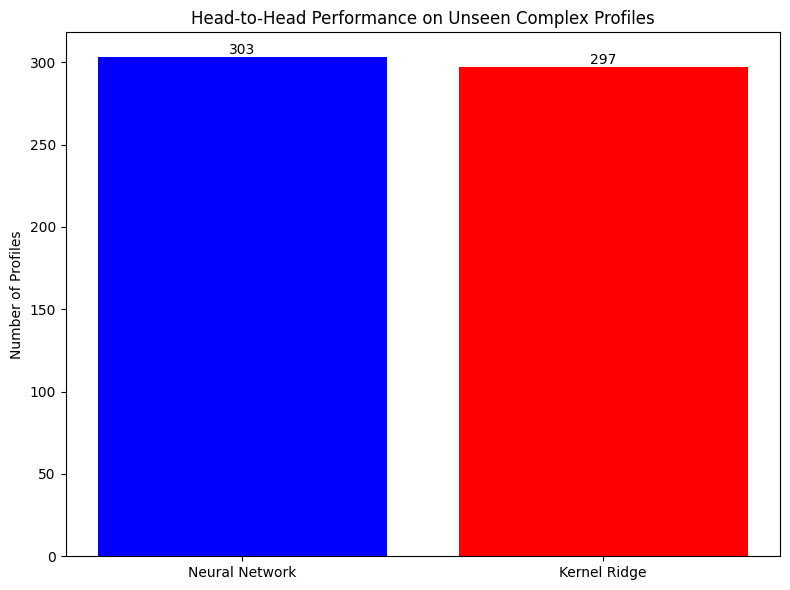

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json
from tqdm import tqdm

# ========== CONFIG ==========
# --- Model & Data Params ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Training Params ---
BATCH_SIZE = 128
EPOCHS = 350 
LR = 5e-4
WEIGHT_DECAY = 1e-5

# --- Data Files & Split ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8

# --- Output ---
OUTPUT_DIR = "AlphaEnsemble_analysis" 
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"PROFILE_LENGTH set to {PROFILE_LENGTH}")

# ========== 1. DATA PREPARATION ==========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def load_and_process_data(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname in file_paths:
        try:
            df_dist = pd.read_csv(fname, engine='python')
            if df_dist.empty: continue
        except Exception: continue
        
        unique_ids = df_dist['Equation_ID'].unique()
        ids_for_this_file = [id for id in unique_ids if id in ids_to_include] if ids_to_include is not None else unique_ids

        for eq_id in ids_for_this_file:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            k_profile = prof['K(z)'].values if len(prof['K(z)'].values) == profile_length else np.interp(KZ_X_GRID, (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min()), prof['K(z)'].values)
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            eq_ids_out.append(eq_id)
            
    if not X_fourier: return [], [], [], []
    return np.stack(X_fourier), np.stack(Y_profile), KZ_X_GRID, np.array(eq_ids_out)

print("\n--- Step 1: Loading and splitting data ---")
all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
if not os.path.exists(COMPLEX_CSV_FILE):
    raise FileNotFoundError(f"Critical Error: Complex data file not found at '{COMPLEX_CSV_FILE}'")
BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
X_train_base, y_train_base, _, _ = load_and_process_data(BASE_CSV_FILES) if BASE_CSV_FILES else ([], [], [], [])
print(f"Loaded {len(X_train_base)} base profiles for training.")
df_complex = pd.read_csv(COMPLEX_CSV_FILE, engine='python')
complex_ids = df_complex['Equation_ID'].unique()
np.random.seed(42); np.random.shuffle(complex_ids)
split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT)
train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]
print(f"Loaded {len(complex_ids)} complex profiles: {len(train_ids_complex)} for training, {len(test_ids_complex)} for testing.")
X_train_complex, y_train_complex, _, _ = load_and_process_data([COMPLEX_CSV_FILE], ids_to_include=train_ids_complex)
X_test, y_test, KZ_X_GRID, eq_ids_test = load_and_process_data([COMPLEX_CSV_FILE], ids_to_include=test_ids_complex)
X_train = np.concatenate([X_train_base, X_train_complex]) if len(X_train_base) > 0 else X_train_complex
y_train = np.concatenate([y_train_base, y_train_complex]) if len(y_train_base) > 0 else y_train_complex
print(f"Final training set size: {len(X_train)} profiles.")
X_scaler = StandardScaler().fit(X_train); Y_scaler = StandardScaler().fit(y_train)
X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

# ========== 2. TRAIN EXPERT MODELS (NN and KRR) ==========
print("\n--- Step 2: Training Expert Models ---")

# --- NN Expert and Helper Classes (FIXED: Defined properly) ---
class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels // 4, k, padding=k//2) 
            for k in [3, 7, 11, 15]
        ])
        self.bn = nn.BatchNorm1d(out_channels)
    
    def forward(self, x):
        return F.relu(self.bn(torch.cat([conv(x) for conv in self.convs], dim=1)))

class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, out_dim)
        )
        self.conv_blocks = nn.Sequential(
            MultiScaleConvBlock(1, 128), nn.Dropout(0.25),
            MultiScaleConvBlock(128, 256), nn.Dropout(0.25),
            MultiScaleConvBlock(256, 256), nn.Dropout(0.25),
            MultiScaleConvBlock(256, 128)
        )
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    
    def forward(self, x):
        x = self.stem(x).unsqueeze(1)
        x = self.conv_blocks(x)
        return self.head(x).squeeze(1)

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__()
        self.grad_weight = grad_weight
        self.recon_loss = nn.SmoothL1Loss()
        self.register_buffer('sobel_filter', torch.tensor([[-1., 0., 1.]]).view(1, 1, 3))
    
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1)
        true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        grad_loss = F.l1_loss(pred_grad, true_grad)
        return self.recon_loss(pred, true) + self.grad_weight * grad_loss

# FIXED: Replaced the dynamic type() creation with a standard class definition
class ProfileDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

train_dataset = ProfileDataset(X_train_scaled, y_train_scaled)
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
nn_expert = ProfileGeneratorNet().to(DEVICE)
optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = CombinedLoss().to(DEVICE)

print("Training Enhanced NN Expert...")
for epoch in tqdm(range(EPOCHS), desc="NN Training"):
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = nn_expert(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
print("NN Expert trained.")

# --- KRR Expert ---
print("Training KRR Expert...")
krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr_expert.fit(X_train_scaled, y_train_scaled)
print("KRR Expert trained.")


# ========== 3. TRAIN ALPHA GATING REGRESSOR (NEW METHOD) ==========
print("\n--- Step 3: Training the Alpha Gating Regressor ---")
def calculate_optimal_alpha(y_true, pred_krr, pred_nn):
    """Calculates the optimal blending factor alpha for each sample."""
    diff_preds = pred_krr - pred_nn
    numerator = np.sum((y_true - pred_nn) * diff_preds, axis=1)
    denominator = np.sum(diff_preds * diff_preds, axis=1)
    alpha_optimal = np.divide(numerator, denominator, out=np.full_like(numerator, 0.5), where=denominator!=0)
    return np.clip(alpha_optimal, 0, 1)

print("  - Generating expert predictions and calculating optimal alphas for gate training...")
with torch.no_grad():
    y_pred_nn_train_scaled = nn_expert(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled)

y_gate_train_alpha = calculate_optimal_alpha(y_train_scaled, y_pred_krr_train_scaled, y_pred_nn_train_scaled)

print("  - Training Random Forest Regressor to predict alpha...")
alpha_regressor = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=12, min_samples_leaf=5)
alpha_regressor.fit(X_train_scaled, y_gate_train_alpha)
print("Alpha Gating Regressor trained.")

# ========== 4. EVALUATE ON UNSEEN TEST SET (with AlphaEnsemble) ==========
print("\n--- Step 4: Evaluating all models on the unseen complex test set ---")
with torch.no_grad():
    y_pred_nn_scaled = nn_expert(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_scaled = krr_expert.predict(X_test_scaled)
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

alpha_pred = alpha_regressor.predict(X_test_scaled).reshape(-1, 1)
y_pred_ensemble = alpha_pred * y_pred_krr + (1 - alpha_pred) * y_pred_nn

# ========== 5. DETAILED VISUALIZATION AND ANALYSIS (with AlphaEnsemble) ==========
print("\n--- Step 5: Saving detailed AlphaEnsemble results and plots ---")
test_plot_dir = os.path.join(OUTPUT_DIR, "unseen_complex_profiles_plots")
os.makedirs(test_plot_dir, exist_ok=True)
print(f"Saving {len(X_test)} individual overlay plots to '{test_plot_dir}'...")
mse_per_sample_krr = np.mean((y_test - y_pred_krr)**2, axis=1)
mse_per_sample_nn = np.mean((y_test - y_pred_nn)**2, axis=1)

for i in tqdm(range(len(X_test)), desc="Generating Plots"):
    mse_krr, mse_nn = mse_per_sample_krr[i], mse_per_sample_nn[i]
    mse_ensemble = mean_squared_error(y_test[i], y_pred_ensemble[i])
    alpha = alpha_pred[i, 0]
    winner = "NN" if mse_nn < mse_krr else "KRR"

    plt.figure(figsize=(12, 6))
    plt.plot(KZ_X_GRID, y_test[i], 'k-', label='Ground Truth', linewidth=2.5, alpha=0.9)
    plt.plot(KZ_X_GRID, y_pred_krr[i], 'r:', label=f'KRR (MSE: {mse_krr:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[i], 'b--', label=f'NN (MSE: {mse_nn:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_ensemble[i], 'g-', label=f'AlphaEnsemble (MSE: {mse_ensemble:.4f})', linewidth=3, alpha=0.8)
    
    title = f'Unseen Complex Profile #{eq_ids_test[i]} (Winner: {winner})\n'
    title += f"Ensemble Alpha (Weight for KRR): {alpha:.3f}"
    plt.title(title, fontsize=12)
    plt.xlabel("x (normalized thickness)"); plt.ylabel("K(z) [physical units]")
    plt.legend(); plt.grid(True, alpha=0.5); plt.tight_layout()
    plt.savefig(os.path.join(test_plot_dir, f'test_profile_{eq_ids_test[i]}.png'))
    plt.close()

nn_wins = np.sum(mse_per_sample_nn < mse_per_sample_krr)
krr_wins = len(X_test) - nn_wins
plt.figure(figsize=(8, 6)); bars = plt.bar(['Neural Network', 'Kernel Ridge'], [nn_wins, krr_wins], color=['blue', 'red']); plt.ylabel('Number of Profiles'); plt.title('Head-to-Head Performance on Unseen Complex Profiles'); plt.bar_label(bars); plt.tight_layout()
summary_plot_path = os.path.join(OUTPUT_DIR, "nn_vs_krr_wins.png"); plt.savefig(summary_plot_path); print(f"Head-to-head summary plot saved to '{summary_plot_path}'.")

metrics = defaultdict(dict)
get_metrics = lambda y_true, y_pred: {'MSE': mean_squared_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}
metrics['overall_test']['KRR'] = get_metrics(y_test, y_pred_krr)
metrics['overall_test']['NN'] = get_metrics(y_test, y_pred_nn)
metrics['overall_test']['AlphaEnsemble'] = get_metrics(y_test, y_pred_ensemble)
metrics['wins']['NN'] = int(nn_wins); metrics['wins']['KRR'] = int(krr_wins)
metrics_path = os.path.join(OUTPUT_DIR, 'final_metrics_summary.json');
with open(metrics_path, 'w') as f: json.dump(metrics, f, indent=4)
print(f"Final metrics summary saved to '{metrics_path}'.")

print("\n--- FINAL METRICS ON UNSEEN TEST DATA (AlphaEnsemble) ---")
print(json.dumps(metrics, indent=4))
print("\nExperiment complete.")


Using device: cpu

--- Step 1: Loading and splitting data ---
Loaded 3500 base profiles for training.
Loaded 3000 complex profiles: 2400 for training, 600 for testing.
Final training set size: 5900 profiles.

--- Step 2: Training Expert Models ---
Training NN Expert...


NN Training: 100%|██████████| 350/350 [1:55:49<00:00, 19.86s/it]


NN Expert trained.
Training KRR Expert...
KRR Expert trained.

--- Step 3: Training the Gating Models for the Selector Ensemble ---
  - Training Alpha Regressor for optimal blending...
  Alpha Regressor trained.
  - Training Error Regressor for expert selection...
  Error Regressor trained.

--- Step 4: Evaluating all models on the unseen complex test set ---

--- Step 5: Saving detailed SelectorEnsemble results and plots ---
Saving 600 individual overlay plots to 'SelectorEnsemble_analysis/unseen_complex_profiles_plots'...


Generating Plots: 100%|██████████| 600/600 [01:23<00:00,  7.21it/s]


Head-to-head summary plot saved to 'SelectorEnsemble_analysis/nn_vs_krr_wins.png'.
Final metrics summary saved to 'SelectorEnsemble_analysis/final_metrics_summary.json'.

--- FINAL METRICS ON UNSEEN TEST DATA (SelectorEnsemble) ---
{
    "overall_test": {
        "KRR": {
            "MSE": 0.8336129291647396,
            "R2": 0.6603587786620783
        },
        "NN": {
            "MSE": 0.82736448594865,
            "R2": 0.6621994241947372
        },
        "SelectorEnsemble": {
            "MSE": 0.8337611778893388,
            "R2": 0.6607049835634019
        }
    },
    "wins": {
        "NN": 310,
        "KRR": 290
    }
}

Experiment complete.


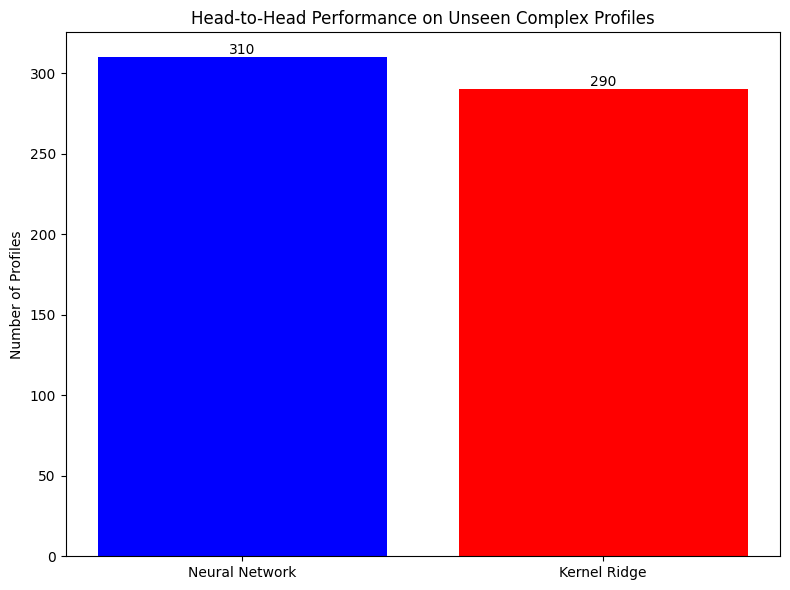

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json
from tqdm import tqdm

# ========== CONFIG ==========
# --- Model & Data Params ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Training Params ---
BATCH_SIZE = 128
EPOCHS = 350 
LR = 5e-4
WEIGHT_DECAY = 1e-5

# --- Data Files & Split ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8

# --- Output ---
OUTPUT_DIR = "SelectorEnsemble_analysis" 
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")

# ========== 1. DATA PREPARATION ==========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def load_and_process_data(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, eq_ids_out = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname in file_paths:
        try:
            df_dist = pd.read_csv(fname, engine='python')
            if df_dist.empty: continue
        except Exception: continue
        
        unique_ids = df_dist['Equation_ID'].unique()
        ids_for_this_file = [id for id in unique_ids if id in ids_to_include] if ids_to_include is not None else unique_ids

        for eq_id in ids_for_this_file:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            k_profile = prof['K(z)'].values if len(prof['K(z)'].values) == profile_length else np.interp(KZ_X_GRID, (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min()), prof['K(z)'].values)
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            eq_ids_out.append(eq_id)
            
    if not X_fourier: return [], [], [], []
    return np.stack(X_fourier), np.stack(Y_profile), KZ_X_GRID, np.array(eq_ids_out)

print("\n--- Step 1: Loading and splitting data ---")
all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
if not os.path.exists(COMPLEX_CSV_FILE):
    raise FileNotFoundError(f"Critical Error: Complex data file not found at '{COMPLEX_CSV_FILE}'")
BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]
X_train_base, y_train_base, _, _ = load_and_process_data(BASE_CSV_FILES) if BASE_CSV_FILES else ([], [], [], [])
print(f"Loaded {len(X_train_base)} base profiles for training.")
df_complex = pd.read_csv(COMPLEX_CSV_FILE, engine='python')
complex_ids = df_complex['Equation_ID'].unique()
np.random.seed(42); np.random.shuffle(complex_ids)
split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT)
train_ids_complex, test_ids_complex = complex_ids[:split_idx], complex_ids[split_idx:]
print(f"Loaded {len(complex_ids)} complex profiles: {len(train_ids_complex)} for training, {len(test_ids_complex)} for testing.")
X_train_complex, y_train_complex, _, _ = load_and_process_data([COMPLEX_CSV_FILE], ids_to_include=train_ids_complex)
X_test, y_test, KZ_X_GRID, eq_ids_test = load_and_process_data([COMPLEX_CSV_FILE], ids_to_include=test_ids_complex)
X_train = np.concatenate([X_train_base, X_train_complex]) if len(X_train_base) > 0 else X_train_complex
y_train = np.concatenate([y_train_base, y_train_complex]) if len(y_train_base) > 0 else y_train_complex
print(f"Final training set size: {len(X_train)} profiles.")
X_scaler = StandardScaler().fit(X_train); Y_scaler = StandardScaler().fit(y_train)
X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

# ========== 2. TRAIN EXPERT MODELS (NN and KRR) ==========
print("\n--- Step 2: Training Expert Models ---")

# --- FIXED: Proper class definitions for all PyTorch components ---
class ProfileDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(in_channels, out_channels // 4, k, padding=k//2) for k in [3, 7, 11, 15]])
        self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        return F.relu(self.bn(torch.cat([conv(x) for conv in self.convs], dim=1)))

class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__()
        self.stem = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, out_dim))
        self.conv_blocks = nn.Sequential(
            MultiScaleConvBlock(1, 128), nn.Dropout(0.25),
            MultiScaleConvBlock(128, 256), nn.Dropout(0.25),
            MultiScaleConvBlock(256, 256), nn.Dropout(0.25),
            MultiScaleConvBlock(256, 128)
        )
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    def forward(self, x):
        return self.head(self.conv_blocks(self.stem(x).unsqueeze(1))).squeeze(1)

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__()
        self.grad_weight = grad_weight
        self.recon_loss = nn.SmoothL1Loss()
        self.register_buffer('sobel_filter', torch.tensor([[-1., 0., 1.]]).view(1, 1, 3))
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1)
        true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        grad_loss = F.l1_loss(pred_grad, true_grad)
        return self.recon_loss(pred, true) + self.grad_weight * grad_loss

# --- NN Training Loop ---
train_dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
nn_expert = ProfileGeneratorNet().to(DEVICE)
optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = CombinedLoss().to(DEVICE)

print("Training NN Expert...")
for epoch in tqdm(range(EPOCHS), desc="NN Training"):
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = nn_expert(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
print("NN Expert trained.")

# --- KRR Expert ---
print("Training KRR Expert...")
krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr_expert.fit(X_train_scaled, y_train_scaled)
print("KRR Expert trained.")


# ========== 3. TRAIN THE "SELECTOR" GATING MODELS ==========
print("\n--- Step 3: Training the Gating Models for the Selector Ensemble ---")
with torch.no_grad():
    y_pred_nn_train_scaled = nn_expert(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled)

# --- Train the Alpha Regressor (for blending) ---
def calculate_optimal_alpha(y_true, pred_krr, pred_nn):
    diff_preds = pred_krr - pred_nn
    numerator = np.sum((y_true - pred_nn) * diff_preds, axis=1)
    denominator = np.sum(diff_preds * diff_preds, axis=1)
    alpha_optimal = np.divide(numerator, denominator, out=np.full_like(numerator, 0.5), where=denominator!=0)
    return np.clip(alpha_optimal, 0, 1)
y_gate_train_alpha = calculate_optimal_alpha(y_train_scaled, y_pred_krr_train_scaled, y_pred_nn_train_scaled)
print("  - Training Alpha Regressor for optimal blending...")
alpha_regressor = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=12, min_samples_leaf=5)
alpha_regressor.fit(X_train_scaled, y_gate_train_alpha)
print("  Alpha Regressor trained.")

# --- Train the Error Regressor (for hard selection) ---
errors_krr = np.mean((y_train_scaled - y_pred_krr_train_scaled)**2, axis=1)
errors_nn = np.mean((y_train_scaled - y_pred_nn_train_scaled)**2, axis=1)
y_gate_train_errors = np.stack([errors_krr, errors_nn], axis=1)
print("  - Training Error Regressor for expert selection...")
error_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
error_regressor.fit(X_train_scaled, y_gate_train_errors)
print("  Error Regressor trained.")

# ========== 4. EVALUATE ON UNSEEN TEST SET (with NEW SelectorEnsemble) ==========
print("\n--- Step 4: Evaluating all models on the unseen complex test set ---")
with torch.no_grad():
    y_pred_nn_scaled = nn_expert(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_scaled = krr_expert.predict(X_test_scaled)
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

# --- The SelectorEnsemble Logic ---
alpha_pred = alpha_regressor.predict(X_test_scaled).reshape(-1, 1)
predicted_errors = error_regressor.predict(X_test_scaled)
pred_err_krr, pred_err_nn = predicted_errors[:, 0].reshape(-1, 1), predicted_errors[:, 1].reshape(-1, 1)

y_pred_soft_blend = alpha_pred * y_pred_krr + (1 - alpha_pred) * y_pred_nn
y_pred_hard_select = np.where(pred_err_krr < pred_err_nn, y_pred_krr, y_pred_nn)

# Final Decision is to use the hard selection
y_pred_ensemble = y_pred_hard_select

# ========== 5. DETAILED VISUALIZATION AND ANALYSIS ==========
print("\n--- Step 5: Saving detailed SelectorEnsemble results and plots ---")
test_plot_dir = os.path.join(OUTPUT_DIR, "unseen_complex_profiles_plots")
os.makedirs(test_plot_dir, exist_ok=True)
print(f"Saving {len(X_test)} individual overlay plots to '{test_plot_dir}'...")
mse_per_sample_krr = np.mean((y_test - y_pred_krr)**2, axis=1)
mse_per_sample_nn = np.mean((y_test - y_pred_nn)**2, axis=1)

for i in tqdm(range(len(X_test)), desc="Generating Plots"):
    mse_krr, mse_nn = mse_per_sample_krr[i], mse_per_sample_nn[i]
    mse_ensemble = mean_squared_error(y_test[i], y_pred_ensemble[i])
    winner_pred = "NN" if pred_err_nn[i] < pred_err_krr[i] else "KRR"

    plt.figure(figsize=(12, 6))
    plt.plot(KZ_X_GRID, y_test[i], 'k-', label='Ground Truth', linewidth=2.5, alpha=0.9)
    plt.plot(KZ_X_GRID, y_pred_krr[i], 'r:', label=f'KRR (MSE: {mse_krr:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[i], 'b--', label=f'NN (MSE: {mse_nn:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_ensemble[i], 'g-', label=f'SelectorEnsemble (MSE: {mse_ensemble:.4f})', linewidth=3, alpha=0.8)
    
    title = f'Unseen Complex Profile #{eq_ids_test[i]} (Gate Prediction: {winner_pred})'
    plt.title(title, fontsize=12)
    plt.xlabel("x (normalized thickness)"); plt.ylabel("K(z) [physical units]")
    plt.legend(); plt.grid(True, alpha=0.5); plt.tight_layout()
    plt.savefig(os.path.join(test_plot_dir, f'test_profile_{eq_ids_test[i]}.png'))
    plt.close()

nn_wins = np.sum(mse_per_sample_nn < mse_per_sample_krr)
krr_wins = len(X_test) - nn_wins
plt.figure(figsize=(8, 6)); bars = plt.bar(['Neural Network', 'Kernel Ridge'], [nn_wins, krr_wins], color=['blue', 'red']); plt.ylabel('Number of Profiles'); plt.title('Head-to-Head Performance on Unseen Complex Profiles'); plt.bar_label(bars); plt.tight_layout()
summary_plot_path = os.path.join(OUTPUT_DIR, "nn_vs_krr_wins.png"); plt.savefig(summary_plot_path); print(f"Head-to-head summary plot saved to '{summary_plot_path}'.")

metrics = defaultdict(dict)
get_metrics = lambda y_true, y_pred: {'MSE': mean_squared_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}
metrics['overall_test']['KRR'] = get_metrics(y_test, y_pred_krr)
metrics['overall_test']['NN'] = get_metrics(y_test, y_pred_nn)
metrics['overall_test']['SelectorEnsemble'] = get_metrics(y_test, y_pred_ensemble)
metrics['wins']['NN'] = int(nn_wins); metrics['wins']['KRR'] = int(krr_wins)
metrics_path = os.path.join(OUTPUT_DIR, 'final_metrics_summary.json');
with open(metrics_path, 'w') as f: json.dump(metrics, f, indent=4)
print(f"Final metrics summary saved to '{metrics_path}'.")

print("\n--- FINAL METRICS ON UNSEEN TEST DATA (SelectorEnsemble) ---")
print(json.dumps(metrics, indent=4))
print("\nExperiment complete.")


Using device: cpu
PROFILE_LENGTH set to 100

--- Step 1: Loading and splitting data ---
Found 7 base data files for training.
Loaded 3500 base profiles for training.
Loaded 3000 complex profiles: 2400 for training, 600 for testing.
Final training set size: 5900 profiles.
Final test set size: 600 profiles.

--- Step 2: Training Expert Models ---
Training Enhanced NN Expert...


NN Training: 100%|██████████| 350/350 [1:46:54<00:00, 18.33s/it]


NN Expert trained.
Training KRR Expert...
KRR Expert trained.

--- Step 3: Training the Soft Gating Regressor ---
  - Generating ground truth errors for gate training...
  - Training Random Forest Regressor for gating...
Soft Gating Regressor trained.

--- Step 4: Evaluating all models on the unseen complex test set ---

--- Step 5: Saving detailed results and plots ---
Saving 600 individual overlay plots to 'final_analysis_with_complex_3k/unseen_complex_profiles_plots'...


Generating Plots: 100%|██████████| 600/600 [01:21<00:00,  7.33it/s]


Head-to-head summary plot saved to 'final_analysis_with_complex_3k/nn_vs_krr_wins.png'.
Final metrics summary saved to 'final_analysis_with_complex_3k/final_metrics_summary.json'.

--- FINAL METRICS ON UNSEEN TEST DATA ---
{
    "overall_test": {
        "KRR": {
            "MSE": 0.8336129291647396,
            "R2": 0.6603587786620783
        },
        "NN": {
            "MSE": 0.8226803864008528,
            "R2": 0.6655318962230274
        },
        "Ensemble": {
            "MSE": 0.7595783439566668,
            "R2": 0.6906743029778106
        }
    },
    "wins": {
        "NN": 307,
        "KRR": 293
    }
}

Experiment complete.


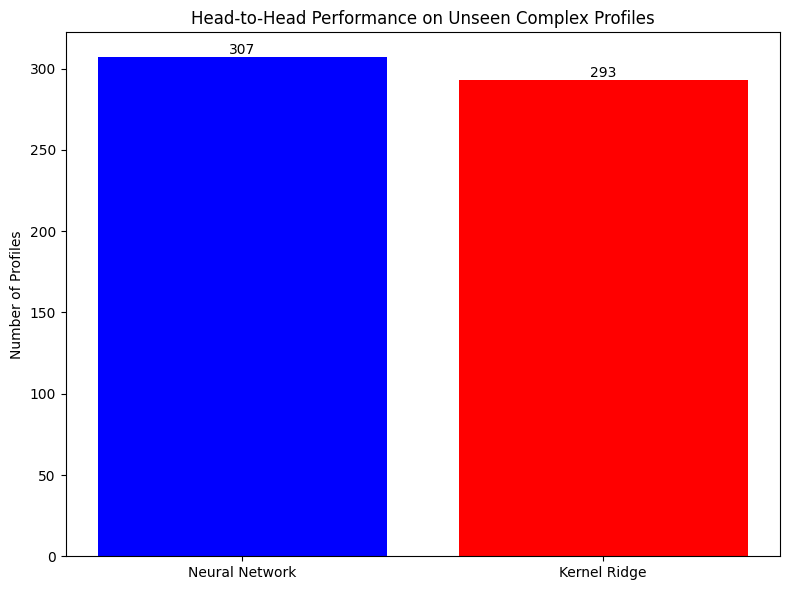

In [ ]:
#Current best soft gating indirect
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json
from tqdm import tqdm

# ========== CONFIG ==========
# --- Model & Data Params ---
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 100 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Training Params ---
BATCH_SIZE = 128
EPOCHS = 350 
LR = 5e-4
WEIGHT_DECAY = 1e-5

# --- Data Files & Split ---
DATA_DIR = 'generated_data'
COMPLEX_CSV_FILE = os.path.join(DATA_DIR, 'data_complex_3000.csv')
COMPLEX_TRAIN_SPLIT = 0.8

# --- Output ---
OUTPUT_DIR = "final_analysis_with_complex_3k"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"PROFILE_LENGTH set to {PROFILE_LENGTH}")

# ========== 1. DATA PREPARATION ==========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    """Computes Fourier coefficients for a given curve."""
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def load_and_process_data(file_paths, ids_to_include=None, profile_length=PROFILE_LENGTH):
    """Loads CSVs, filters by Equation_ID, and processes into model-ready format."""
    X_fourier, Y_profile, distribs, eq_ids_out = [], [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    
    for fname in file_paths:
        try:
            # FIXED: Use engine='python' for robustness against malformed CSVs
            df_dist = pd.read_csv(fname, engine='python')
            if df_dist.empty:
                print(f"Warning: CSV file '{fname}' is empty. Skipping.")
                continue
        except Exception as e:
            print(f"Warning: Could not read CSV file '{fname}'. Error: {e}. Skipping.")
            continue
        
        unique_ids = df_dist['Equation_ID'].unique()
        if ids_to_include is not None:
            ids_for_this_file = [id for id in unique_ids if id in ids_to_include]
        else:
            ids_for_this_file = unique_ids

        for eq_id in ids_for_this_file:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            
            if len(prof['K(z)'].values) == profile_length:
                 k_profile = prof['K(z)'].values
            else:
                x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                         (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
                k_profile = np.interp(KZ_X_GRID, x_norm, prof['K(z)'].values)

            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(grp['Distribution'].iloc[0])
            eq_ids_out.append(eq_id)
            
    if not X_fourier:
        # If no data was loaded at all, return empty lists to be handled later
        return [], [], [], [], []

    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID, np.array(eq_ids_out)

print("\n--- Step 1: Loading and splitting data ---")

# --- FIXED: Robustly find base and complex data files ---
all_csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
if not os.path.exists(COMPLEX_CSV_FILE):
    raise FileNotFoundError(f"Critical Error: Complex data file not found at '{COMPLEX_CSV_FILE}'")

BASE_CSV_FILES = [f for f in all_csv_files if os.path.normpath(f) != os.path.normpath(COMPLEX_CSV_FILE)]

if not BASE_CSV_FILES:
    # Allow running even if only complex data is present
    print("Warning: No base data files found. Proceeding with complex data only.")
    X_train_base, y_train_base, distribs_train_base = [], [], []
else:
    print(f"Found {len(BASE_CSV_FILES)} base data files for training.")
    X_train_base, y_train_base, distribs_train_base, _, _ = load_and_process_data(BASE_CSV_FILES)
    if len(X_train_base) == 0:
        raise ValueError("Error: Base CSV files were found, but no data could be loaded from them. Check file contents.")

print(f"Loaded {len(X_train_base)} base profiles for training.")

# --- Load and split complex data ---
df_complex = pd.read_csv(COMPLEX_CSV_FILE, engine='python')
complex_ids = df_complex['Equation_ID'].unique()
np.random.seed(42)
np.random.shuffle(complex_ids)
split_idx = int(len(complex_ids) * COMPLEX_TRAIN_SPLIT)
train_ids_complex = complex_ids[:split_idx]
test_ids_complex = complex_ids[split_idx:]
print(f"Loaded {len(complex_ids)} complex profiles: {len(train_ids_complex)} for training, {len(test_ids_complex)} for testing.")

X_train_complex, y_train_complex, distribs_train_complex, _, _ = load_and_process_data([COMPLEX_CSV_FILE], ids_to_include=train_ids_complex)
X_test, y_test, distribs_test, KZ_X_GRID, eq_ids_test = load_and_process_data([COMPLEX_CSV_FILE], ids_to_include=test_ids_complex)

# --- Combine into final training and test sets ---
# Handle the case where there is no base data
if len(X_train_base) > 0:
    X_train = np.concatenate([X_train_base, X_train_complex])
    y_train = np.concatenate([y_train_base, y_train_complex])
else:
    X_train = X_train_complex
    y_train = y_train_complex

print(f"Final training set size: {len(X_train)} profiles.")
print(f"Final test set size: {len(X_test)} profiles.")

# --- Scaling (fit ONLY on training data) ---
X_scaler = StandardScaler().fit(X_train)
Y_scaler = StandardScaler().fit(y_train)
X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

# ========== 2. TRAIN EXPERT MODELS (NN and KRR) ==========
print("\n--- Step 2: Training Expert Models ---")
# --- NN Expert (Enhanced Architecture) ---
class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(in_channels, out_channels // 4, k, padding=k//2) for k in [3, 7, 11, 15]])
        self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x): return F.relu(self.bn(torch.cat([conv(x) for conv in self.convs], dim=1)))

class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__()
        self.stem = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, out_dim))
        self.conv_blocks = nn.Sequential(
            MultiScaleConvBlock(1, 128), nn.Dropout(0.25),
            MultiScaleConvBlock(128, 256), nn.Dropout(0.25),
            MultiScaleConvBlock(256, 256), nn.Dropout(0.25),
            MultiScaleConvBlock(256, 128)
        )
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    def forward(self, x): return self.head(self.conv_blocks(self.stem(x).unsqueeze(1))).squeeze(1)

class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__(); self.register_buffer('sobel_filter', torch.tensor([[-1., 0., 1.]]).view(1, 1, 3))
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1)
        true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        return F.l1_loss(pred_grad, true_grad)

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75): super().__init__(); self.grad_weight, self.recon_loss, self.grad_loss = grad_weight, nn.SmoothL1Loss(), GradientLoss()
    def forward(self, pred, true): return self.recon_loss(pred, true) + self.grad_weight * self.grad_loss(pred, true)

class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

train_dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
nn_expert = ProfileGeneratorNet().to(DEVICE)
optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = CombinedLoss().to(DEVICE)

print("Training Enhanced NN Expert...")
for epoch in tqdm(range(EPOCHS), desc="NN Training"):
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE); optimizer.zero_grad(); loss = criterion(nn_expert(xb), yb); loss.backward(); optimizer.step()
print("NN Expert trained.")

# --- KRR Expert ---
print("Training KRR Expert...")
krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr_expert.fit(X_train_scaled, y_train_scaled)
print("KRR Expert trained.")

# ========== 3. TRAIN SOFT GATING REGRESSOR ==========
print("\n--- Step 3: Training the Soft Gating Regressor ---")
print("  - Generating ground truth errors for gate training...")
with torch.no_grad():
    y_pred_nn_train_scaled = nn_expert(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled)

errors_nn = np.mean((y_train_scaled - y_pred_nn_train_scaled)**2, axis=1)
errors_krr = np.mean((y_train_scaled - y_pred_krr_train_scaled)**2, axis=1)
y_gate_train = np.stack([errors_krr, errors_nn], axis=1)

print("  - Training Random Forest Regressor for gating...")
gate_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
gate_regressor.fit(X_train_scaled, y_gate_train)
print("Soft Gating Regressor trained.")

# ========== 4. EVALUATE ON UNSEEN TEST SET ==========
print("\n--- Step 4: Evaluating all models on the unseen complex test set ---")
with torch.no_grad():
    y_pred_nn_scaled = nn_expert(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_scaled = krr_expert.predict(X_test_scaled)
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

predicted_errors = gate_regressor.predict(X_test_scaled)
e_krr, e_nn = predicted_errors[:, 0], predicted_errors[:, 1]
inv_e_krr, inv_e_nn = 1 / (e_krr + 1e-8), 1 / (e_nn + 1e-8)
total_inv_error = inv_e_krr + inv_e_nn
w_krr, w_nn = (inv_e_krr / total_inv_error)[:, np.newaxis], (inv_e_nn / total_inv_error)[:, np.newaxis]
y_pred_ensemble = w_krr * y_pred_krr + w_nn * y_pred_nn

# ========== 5. DETAILED VISUALIZATION AND ANALYSIS ==========
print("\n--- Step 5: Saving detailed results and plots ---")
test_plot_dir = os.path.join(OUTPUT_DIR, "unseen_complex_profiles_plots")
os.makedirs(test_plot_dir, exist_ok=True)
print(f"Saving {len(X_test)} individual overlay plots to '{test_plot_dir}'...")

mse_per_sample_krr = np.mean((y_test - y_pred_krr)**2, axis=1)
mse_per_sample_nn = np.mean((y_test - y_pred_nn)**2, axis=1)

for i in tqdm(range(len(X_test)), desc="Generating Plots"):
    mse_krr, mse_nn = mse_per_sample_krr[i], mse_per_sample_nn[i]
    mse_ensemble = mean_squared_error(y_test[i], y_pred_ensemble[i])
    weight_krr, weight_nn = w_krr[i, 0], w_nn[i, 0]
    winner = "NN" if mse_nn < mse_krr else "KRR"

    plt.figure(figsize=(12, 6))
    plt.plot(KZ_X_GRID, y_test[i], 'k-', label='Ground Truth', linewidth=2.5, alpha=0.9)
    plt.plot(KZ_X_GRID, y_pred_krr[i], 'r:', label=f'KRR (MSE: {mse_krr:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[i], 'b--', label=f'NN (MSE: {mse_nn:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_ensemble[i], 'g-', label=f'Ensemble (MSE: {mse_ensemble:.4f})', linewidth=3, alpha=0.8)
    
    title = f'Unseen Complex Profile #{eq_ids_test[i]} (Winner: {winner})\n'
    title += f"Ensemble Weights -> KRR: {weight_krr:.2f}, NN: {weight_nn:.2f}"
    plt.title(title, fontsize=12)
    plt.xlabel("x (normalized thickness)"); plt.ylabel("K(z) [physical units]")
    plt.legend(); plt.grid(True, alpha=0.5); plt.tight_layout()
    plt.savefig(os.path.join(test_plot_dir, f'test_profile_{eq_ids_test[i]}.png'))
    plt.close()

nn_wins = np.sum(mse_per_sample_nn < mse_per_sample_krr)
krr_wins = len(X_test) - nn_wins
plt.figure(figsize=(8, 6))
bars = plt.bar(['Neural Network', 'Kernel Ridge'], [nn_wins, krr_wins], color=['blue', 'red'])
plt.ylabel('Number of Profiles')
plt.title('Head-to-Head Performance on Unseen Complex Profiles')
plt.bar_label(bars)
plt.tight_layout()
summary_plot_path = os.path.join(OUTPUT_DIR, "nn_vs_krr_wins.png")
plt.savefig(summary_plot_path)
print(f"Head-to-head summary plot saved to '{summary_plot_path}'.")

metrics = defaultdict(dict)
def get_metrics(y_true, y_pred): return {'MSE': mean_squared_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}
metrics['overall_test']['KRR'] = get_metrics(y_test, y_pred_krr)
metrics['overall_test']['NN'] = get_metrics(y_test, y_pred_nn)
metrics['overall_test']['Ensemble'] = get_metrics(y_test, y_pred_ensemble)
metrics['wins']['NN'] = int(nn_wins)
metrics['wins']['KRR'] = int(krr_wins)

metrics_path = os.path.join(OUTPUT_DIR, 'final_metrics_summary.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"Final metrics summary saved to '{metrics_path}'.")

print("\n--- FINAL METRICS ON UNSEEN TEST DATA ---")
print(json.dumps(metrics, indent=4))
print("\nExperiment complete.")


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import json

# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 128
EPOCHS = 250
LR = 5e-4
WEIGHT_DECAY = 1e-5
N_TEST_PROFILES_PER_DIST = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv',
    'generated_data/data_test_composites_stair.csv'
]

# ========= 1. DATA PREPARATION (UNCHANGED) =========
print("--- Step 1: Creating a true hold-out test set ---")
# (This section is identical to the previous script, ensuring the same train/test split)
train_ids_by_file = defaultdict(list)
test_ids_by_file = defaultdict(list)
for fname in CSV_FILES:
    df = pd.read_csv(fname)
    unique_ids = df['Equation_ID'].unique()
    if '500' in fname:
        np.random.seed(42)
        test_ids = np.random.choice(unique_ids, N_TEST_PROFILES_PER_DIST, replace=False)
        train_ids = [id for id in unique_ids if id not in test_ids]
    else: # stair profiles
        train_ids = unique_ids
        test_ids = []
    train_ids_by_file[fname] = train_ids
    test_ids_by_file[fname] = test_ids

def process_data_from_ids(files_to_ids, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname, eq_ids in files_to_ids.items():
        if not len(eq_ids): continue
        dist_name = os.path.basename(fname).split('_')[1]
        if 'test' in dist_name: dist_name = 'stair'
        df_dist = pd.read_csv(fname)
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            x_tdtr, y_tdtr = tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values
            a0 = np.trapz(y_tdtr, x_tdtr) / (x_tdtr.max() - x_tdtr.min())
            f_coeffs = np.fft.fft(y_tdtr)
            tdtr_coeffs = np.concatenate(([a0], f_coeffs.real[1:N_FOURIER+1], f_coeffs.imag[1:N_FOURIER+1])).astype(np.float32)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = np.interp(KZ_X_GRID, x_norm, prof['K(z)'].values)
            X_fourier.append(tdtr_coeffs); Y_profile.append(k_profile); distribs.append(dist_name)
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID

X_train, y_train, distribs_train, _ = process_data_from_ids(train_ids_by_file)
X_test, y_test, distribs_test, KZ_X_GRID = process_data_from_ids(test_ids_by_file)
print(f"\nTraining on {len(X_train)} profiles, testing on {len(X_test)} unseen profiles.")
X_scaler, Y_scaler = StandardScaler().fit(X_train), StandardScaler().fit(y_train)
X_train_scaled, y_train_scaled = X_scaler.transform(X_train), Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)

# ========= 2. TRAIN EXPERT MODELS (NN and KRR) =========
print("\n--- Step 2: Training Expert Models ---")
# --- NN Expert ---
class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(in_channels, out_channels // 4, k, padding=k//2) for k in [3, 7, 11, 15]])
        self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x): return F.relu(self.bn(torch.cat([conv(x) for conv in self.convs], dim=1)))
class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__()
        self.stem = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, out_dim))
        self.conv_blocks = nn.Sequential(MultiScaleConvBlock(1, 128), nn.Dropout(0.2), MultiScaleConvBlock(128, 256), nn.Dropout(0.2), MultiScaleConvBlock(256, 128))
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    def forward(self, x): return self.head(self.conv_blocks(self.stem(x).unsqueeze(1))).squeeze(1)
class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer('sobel_filter', torch.tensor([[-1., 0., 1.]]).view(1, 1, 3))
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1)
        true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        return F.l1_loss(pred_grad, true_grad)
class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75): super().__init__(); self.grad_weight, self.recon_loss, self.grad_loss = grad_weight, nn.SmoothL1Loss(), GradientLoss()
    def forward(self, pred, true): return self.recon_loss(pred, true) + self.grad_weight * self.grad_loss(pred, true)
class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()
train_dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
nn_expert = ProfileGeneratorNet().to(DEVICE)
optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = CombinedLoss().to(DEVICE)
for _ in range(EPOCHS):
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE); optimizer.zero_grad(); loss = criterion(nn_expert(xb), yb); loss.backward(); optimizer.step()
print("NN Expert trained.")

# --- KRR Expert ---
krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr_expert.fit(X_train_scaled, y_train_scaled)
print("KRR Expert trained.")

# ========= 3. TRAIN SOFT GATING REGRESSOR =========
print("\n--- Step 3: Training the Soft Gating Regressor ---")
# --- Create training data for the gate ---
print("  - Generating ground truth errors for gate training...")
with torch.no_grad():
    y_pred_nn_train_scaled = nn_expert(torch.from_numpy(X_train_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_train_scaled = krr_expert.predict(X_train_scaled)

# Calculate per-sample MSE for each expert
errors_nn = np.mean((y_train_scaled - y_pred_nn_train_scaled)**2, axis=1)
errors_krr = np.mean((y_train_scaled - y_pred_krr_train_scaled)**2, axis=1)
y_gate_train = np.stack([errors_krr, errors_nn], axis=1)

# --- Train the gate model ---
gate_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
gate_regressor.fit(X_train_scaled, y_gate_train)
print("Soft Gating Regressor (Random Forest) trained.")

# ========= 4. EVALUATE ON UNSEEN TEST SET =========
print("\n--- Step 4: Evaluating all models on the unseen test set ---")
# Get expert predictions
with torch.no_grad():
    y_pred_nn_scaled = nn_expert(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_krr_scaled = krr_expert.predict(X_test_scaled)
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

# Get predicted errors from the gate
predicted_errors = gate_regressor.predict(X_test_scaled)
e_krr, e_nn = predicted_errors[:, 0], predicted_errors[:, 1]

# Calculate dynamic weights (inverse of error, normalized)
inv_e_krr = 1 / (e_krr + 1e-8)
inv_e_nn = 1 / (e_nn + 1e-8)
total_inv_error = inv_e_krr + inv_e_nn
w_krr = (inv_e_krr / total_inv_error)[:, np.newaxis]
w_nn = (inv_e_nn / total_inv_error)[:, np.newaxis]

# Compute the final ensemble prediction
y_pred_ensemble = w_krr * y_pred_krr + w_nn * y_pred_nn

# ========= 5. SAVE DETAILED RESULTS AND VISUALIZATIONS =========
print("\n--- Step 5: Saving detailed results and plots ---")
output_dir = "soft_gating_evaluation"
os.makedirs(output_dir, exist_ok=True)

for i in range(len(X_test)):
    dist = distribs_test[i]
    dist_dir = os.path.join(output_dir, dist)
    os.makedirs(dist_dir, exist_ok=True)

    # Calculate actual MSE for this sample
    mse_krr = mean_squared_error(y_test[i], y_pred_krr[i])
    mse_nn = mean_squared_error(y_test[i], y_pred_nn[i])
    mse_ensemble = mean_squared_error(y_test[i], y_pred_ensemble[i])
    
    # Get the weights used for this sample
    weight_krr, weight_nn = w_krr[i, 0], w_nn[i, 0]

    plt.figure(figsize=(12, 6))
    plt.plot(KZ_X_GRID, y_test[i], 'k-', label='Ground Truth', linewidth=2.5, alpha=0.9)
    plt.plot(KZ_X_GRID, y_pred_krr[i], 'r:', label=f'KRR (MSE: {mse_krr:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[i], 'b--', label=f'NN (MSE: {mse_nn:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_ensemble[i], 'g-', label=f'Ensemble (MSE: {mse_ensemble:.4f})', linewidth=3)
    
    title = f'Test Profile: {dist} #{i+1}\n'
    title += f"Ensemble Weights -> KRR: {weight_krr:.2f}, NN: {weight_nn:.2f}"
    plt.title(title)
    plt.xlabel("x (normalized thickness)"); plt.ylabel("K(z) [physical units]")
    plt.legend(); plt.grid(True, alpha=0.5); plt.tight_layout()
    plt.savefig(os.path.join(dist_dir, f'test_profile_{dist}_{i+1}.png'))
    plt.close()

print(f"All 70 detailed test plots saved in '{output_dir}' directory.")

# --- Save Final Metrics Summary ---
metrics = defaultdict(dict)
def get_metrics(y_true, y_pred): return {'MSE': mean_squared_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}
metrics['overall']['KRR'] = get_metrics(y_test, y_pred_krr)
metrics['overall']['NN'] = get_metrics(y_test, y_pred_nn)
metrics['overall']['Ensemble'] = get_metrics(y_test, y_pred_ensemble)
for dist in np.unique(distribs_test):
    indices = np.where(distribs_test == dist)[0]
    metrics[dist]['KRR'] = get_metrics(y_test[indices], y_pred_krr[indices])
    metrics[dist]['NN'] = get_metrics(y_test[indices], y_pred_nn[indices])
    metrics[dist]['Ensemble'] = get_metrics(y_test[indices], y_pred_ensemble[indices])

with open(os.path.join(output_dir, 'metrics_summary.json'), 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"Final metrics summary saved to '{os.path.join(output_dir, 'metrics_summary.json')}'.")

print("\n--- FINAL METRICS ON UNSEEN TEST DATA ---")
print(json.dumps(metrics, indent=4))
print("\nExperiment complete.")



Using device: cpu
--- Step 1: Creating a true hold-out test set ---


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from collections import defaultdict
import json

# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 128
EPOCHS = 250
LR = 5e-4
WEIGHT_DECAY = 1e-5
N_TEST_PROFILES_PER_DIST = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# All files are now used for training/testing
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv',
    'generated_data/data_test_composites_stair.csv'
]

# ========= 1. DATA PREPARATION: CREATE TRUE TRAIN/TEST SPLIT =========
print("--- Step 1: Creating a true hold-out test set ---")

train_ids_by_file = defaultdict(list)
test_ids_by_file = defaultdict(list)

# Manually split Equation_IDs into train and test sets
for fname in CSV_FILES:
    df = pd.read_csv(fname)
    dist_name = os.path.basename(fname).split('_')[1]
    
    unique_ids = df['Equation_ID'].unique()
    
    if '500' in fname:
        # For large files, take a random sample for the test set
        np.random.seed(42) # for reproducibility
        test_ids = np.random.choice(unique_ids, N_TEST_PROFILES_PER_DIST, replace=False)
        train_ids = [id for id in unique_ids if id not in test_ids]
        print(f"  - {dist_name}: {len(train_ids)} train, {len(test_ids)} test")
    else:
        # For the stair file, keep all in training set
        train_ids = unique_ids
        test_ids = []
        print(f"  - stair: {len(train_ids)} train, {len(test_ids)} test (all used for training)")

    train_ids_by_file[fname] = train_ids
    test_ids_by_file[fname] = test_ids

def process_data_from_ids(files_to_ids, profile_length=PROFILE_LENGTH):
    X_fourier, Y_profile, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    
    for fname, eq_ids in files_to_ids.items():
        if not len(eq_ids):
            continue
            
        dist_name = os.path.basename(fname).split('_')[1]
        if 'test' in dist_name:
            dist_name = os.path.basename(fname).split('_')[-1].replace('.csv','')
            
        df_dist = pd.read_csv(fname)
        
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            # ... (Fourier and interpolation logic is the same)
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            x_tdtr, y_tdtr = tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values
            a0 = np.trapz(y_tdtr, x_tdtr) / (x_tdtr.max() - x_tdtr.min())
            f = 1 / (2 * (x_tdtr.max() - x_tdtr.min()))
            t = np.linspace(0, 1 / f, len(x_tdtr))
            f_coeffs = np.fft.fft(y_tdtr)
            tdtr_coeffs = np.concatenate(([a0], f_coeffs.real[1:N_FOURIER+1], f_coeffs.imag[1:N_FOURIER+1])).astype(np.float32)
            
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = np.interp(KZ_X_GRID, x_norm, prof['K(z)'].values)
            
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(dist_name)
            
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID

# Process train and test sets separately
X_train, y_train, distribs_train, _ = process_data_from_ids(train_ids_by_file)
X_test, y_test, distribs_test, KZ_X_GRID = process_data_from_ids(test_ids_by_file)

print(f"\nTotal training profiles: {len(X_train)}")
print(f"Total test profiles: {len(X_test)}")

# Fit scalers ONLY on training data
X_scaler = StandardScaler().fit(X_train)
Y_scaler = StandardScaler().fit(y_train)

# Transform both sets
X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = Y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)
# y_test is kept in original scale for final evaluation

# ========= 2. TRAIN EXPERT AND GATING MODELS =========
print("\n--- Step 2: Training KRR, NN, and Gate on the training set ---")

# --- KRR Expert ---
krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr_expert.fit(X_train_scaled, y_train_scaled)
print("KRR Expert trained.")

# --- NN Expert ---
class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=3, padding=1),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=7, padding=3),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=11, padding=5),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=15, padding=7),
        ])
        self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        features = [conv(x) for conv in self.convs]
        return F.relu(self.bn(torch.cat(features, dim=1)))

class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__()
        self.stem = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, out_dim))
        self.conv_blocks = nn.Sequential(MultiScaleConvBlock(1, 128), nn.Dropout(0.2), MultiScaleConvBlock(128, 256), nn.Dropout(0.2), MultiScaleConvBlock(256, 128))
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    def forward(self, x):
        latent_profile = self.stem(x).unsqueeze(1)
        refined_profile = self.conv_blocks(latent_profile)
        return self.head(refined_profile).squeeze(1)

class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__()
        sobel_kernel = torch.tensor([[-1., 0., 1.]], dtype=torch.float32)
        self.register_buffer('sobel_filter', sobel_kernel.view(1, 1, 3))
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1)
        true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        return F.l1_loss(pred_grad, true_grad)

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__()
        self.grad_weight, self.recon_loss, self.grad_loss = grad_weight, nn.SmoothL1Loss(), GradientLoss()
    def forward(self, pred, true):
        return self.recon_loss(pred, true) + self.grad_weight * self.grad_loss(pred, true)

class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

train_dl = DataLoader(ProfileDataset(X_train_scaled, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
nn_expert = ProfileGeneratorNet().to(DEVICE)
optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = CombinedLoss().to(DEVICE)
for epoch in range(1, EPOCHS + 1): # Simplified training loop
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(nn_expert(xb), yb)
        loss.backward()
        optimizer.step()
print("NN Expert trained.")

# --- Gating Classifier ---
y_gate_train = (distribs_train == 'stair').astype(int)
gate_classifier = LogisticRegression(random_state=42, class_weight='balanced')
gate_classifier.fit(X_train_scaled, y_gate_train)
print("Gate Classifier trained.")

# ========= 3. EVALUATION ON THE UNSEEN TEST SET =========
print("\n--- Step 3: Evaluating all models on the unseen test set ---")

# Get predictions from both experts
y_pred_krr_scaled = krr_expert.predict(X_test_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

nn_expert.eval()
with torch.no_grad():
    y_pred_nn_scaled = nn_expert(torch.from_numpy(X_test_scaled).float().to(DEVICE)).cpu().numpy()
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)

# Use the gate to make the ensemble prediction
gate_decisions = gate_classifier.predict(X_test_scaled)
y_pred_ensemble = np.where(gate_decisions[:, None] == 1, y_pred_krr, y_pred_nn)

# ========= 4. SAVE DETAILED RESULTS AND VISUALIZATIONS =========
print("\n--- Step 4: Saving detailed results and plots ---")
output_dir = "final_ensemble_evaluation"
os.makedirs(output_dir, exist_ok=True)
metrics = defaultdict(dict)

# --- Overall Metrics ---
def get_metrics(y_true, y_pred):
    return {'MSE': mean_squared_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}

metrics['overall']['KRR'] = get_metrics(y_test, y_pred_krr)
metrics['overall']['NN'] = get_metrics(y_test, y_pred_nn)
metrics['overall']['Ensemble'] = get_metrics(y_test, y_pred_ensemble)

# --- Per-Distribution Metrics and Plots ---
nn_wins = defaultdict(int)
krr_wins = defaultdict(int)

for i in range(len(X_test)):
    dist = distribs_test[i]
    dist_dir = os.path.join(output_dir, dist)
    os.makedirs(dist_dir, exist_ok=True)

    mse_krr = mean_squared_error(y_test[i], y_pred_krr[i])
    mse_nn = mean_squared_error(y_test[i], y_pred_nn[i])
    
    if mse_nn < mse_krr:
        winner = "NN"
        nn_wins[dist] += 1
    else:
        winner = "KRR"
        krr_wins[dist] += 1
        
    plt.figure(figsize=(10, 5))
    plt.plot(KZ_X_GRID, y_test[i], 'k-', label='Ground Truth', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_krr[i], 'r:', label=f'KRR (MSE: {mse_krr:.4f})', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[i], 'b--', label=f'NN (MSE: {mse_nn:.4f})', linewidth=2)
    plt.title(f'Test Profile: {dist} #{i+1} -- Winner: {winner}')
    plt.xlabel("x (normalized thickness)")
    plt.ylabel("K(z) [physical units]")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(dist_dir, f'test_profile_{dist}_{i+1}.png'))
    plt.close()

for dist in np.unique(distribs_test):
    indices = np.where(distribs_test == dist)[0]
    metrics[dist]['KRR'] = get_metrics(y_test[indices], y_pred_krr[indices])
    metrics[dist]['NN'] = get_metrics(y_test[indices], y_pred_nn[indices])

# --- Save Metrics Summary ---
with open(os.path.join(output_dir, 'metrics_summary.json'), 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"Detailed plots saved in '{output_dir}' directory.")
print(f"Metrics summary saved to '{os.path.join(output_dir, 'metrics_summary.json')}'.")

# --- Create Head-to-Head Win Count Plot ---
labels = sorted(list(set(nn_wins.keys()) | set(krr_wins.keys())))
nn_win_counts = [nn_wins[label] for label in labels]
krr_win_counts = [krr_wins[label] for label in labels]
total_wins = sum(nn_win_counts) + sum(krr_win_counts)

fig, ax = plt.subplots(figsize=(12, 7))
width = 0.5
ax.bar(labels, nn_win_counts, width, label=f'NN Wins ({sum(nn_win_counts)} total)', color='royalblue')
ax.bar(labels, krr_win_counts, width, bottom=nn_win_counts, label=f'KRR Wins ({sum(krr_win_counts)} total)', color='lightcoral')
ax.set_ylabel('Number of Test Profiles Won')
ax.set_title(f'Head-to-Head Performance on {total_wins} Unseen Test Profiles')
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'head_to_head_wins.png'))
plt.close()
print(f"Head-to-head win chart saved to '{os.path.join(output_dir, 'head_to_head_wins.png')}'.")

print("\n--- FINAL METRICS SUMMARY ---")
print(json.dumps(metrics, indent=4))
print("\nExperiment complete. Check the output directory for all results.")



Using device: cpu
--- Step 1: Creating a true hold-out test set ---
  - gaussian: 490 train, 10 test
  - logarithmic: 490 train, 10 test
  - quadratic: 490 train, 10 test
  - exponential: 490 train, 10 test
  - hyperbolic: 490 train, 10 test
  - linear: 490 train, 10 test
  - cubic: 490 train, 10 test
  - stair: 5 train, 0 test (all used for training)

Total training profiles: 3435
Total test profiles: 70

--- Step 2: Training KRR, NN, and Gate on the training set ---
KRR Expert trained.
NN Expert trained.
Gate Classifier trained.

--- Step 3: Evaluating all models on the unseen test set ---

--- Step 4: Saving detailed results and plots ---
Detailed plots saved in 'final_ensemble_evaluation' directory.
Metrics summary saved to 'final_ensemble_evaluation/metrics_summary.json'.
Head-to-head win chart saved to 'final_ensemble_evaluation/head_to_head_wins.png'.

--- FINAL METRICS SUMMARY ---
{
    "overall": {
        "KRR": {
            "MSE": 0.05734619351077916,
            "R2": 0.97

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score

# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 128
EPOCHS = 300  # Increased epochs slightly for the new architecture
LR = 3e-4
WEIGHT_DECAY = 1e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv',
    'generated_data/data_test_composites_stair.csv'
]
N_PROFILES_PER_FILE = {fname: 500 if '500' in fname else 5 for fname in CSV_FILES}

# ========= DATA PREPARATION (UNCHANGED) =========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    return np.interp(x_query, x_src, k_src)

def prepare_data(csv_files_dict, profile_length=PROFILE_LENGTH):
    print("Loading and processing combined data...")
    X_fourier, Y_profile, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname, n_profiles in csv_files_dict.items():
        dist_name = os.path.basename(fname).split('_')[1]
        if 'test' in dist_name:
            dist_name = os.path.basename(fname).split('_')[-1].replace('.csv','')
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_fourier)}")
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID

X_fourier, Y_profile, distribs, KZ_X_GRID = prepare_data(N_PROFILES_PER_FILE)
X_scaler = StandardScaler().fit(X_fourier)
Y_scaler = StandardScaler().fit(Y_profile)
X_fourier_scaled = X_scaler.transform(X_fourier)
Y_profile_scaled = Y_scaler.transform(Y_profile)

train_idx, val_idx = train_test_split(np.arange(len(X_fourier)), test_size=0.1, random_state=42, stratify=distribs)
X_train, y_train_scaled = X_fourier_scaled[train_idx], Y_profile_scaled[train_idx]
X_val, y_val_scaled = X_fourier_scaled[val_idx], Y_profile_scaled[val_idx]

# ========= NEW: SIMPLE ANN MODEL =========
class SimpleANN(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            # No activation on the final layer for regression
            nn.Linear(256, out_dim)
        )
    def forward(self, x):
        return self.network(x)

# ========= MODEL TRAINING =========
# --- KRR Model (for comparison) ---
print("\nTraining KRR model...")
krr = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr.fit(X_fourier_scaled, Y_profile_scaled)
print("KRR training complete.")

# --- Simple ANN Model ---
model = SimpleANN().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.SmoothL1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)

class ProfileDataset(Dataset):
    def __init__(self, X, Y):
        self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

train_dl = DataLoader(ProfileDataset(X_train, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(ProfileDataset(X_val, y_val_scaled), batch_size=BATCH_SIZE)

print("\nTraining Simple ANN model...")
best_val_loss = float('inf')
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()

    avg_train_loss = train_loss / len(train_dl)
    avg_val_loss = val_loss / len(val_dl)
    
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}/{EPOCHS} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")
    
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_simple_ann_model.pth")
        
print("Simple ANN training complete.")

# ========= VISUALIZATION OF RECONSTRUCTIONS =========
print("\nGenerating reconstruction plots...")

# --- Get Predictions for the Entire Dataset ---
# KRR predictions
y_pred_krr_scaled = krr.predict(X_fourier_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

# ANN predictions
model.load_state_dict(torch.load("best_simple_ann_model.pth"))
model.eval()
with torch.no_grad():
    X_full_tensor = torch.from_numpy(X_fourier_scaled).float().to(DEVICE)
    y_pred_ann_scaled = model(X_full_tensor).cpu().numpy()
y_pred_ann = Y_scaler.inverse_transform(y_pred_ann_scaled)

# Ground truth (unscaled)
y_true = Y_profile

# --- Create Plots for the 5 Stair Profiles ---
output_dir = "simple_ann_reconstructions"
os.makedirs(output_dir, exist_ok=True)

stair_indices = np.where(distribs == 'stair')[0]
print(f"Saving reconstruction plots for all {len(stair_indices)} 'stair' profiles in '{output_dir}/' folder.")

for i, idx in enumerate(stair_indices):
    plt.figure(figsize=(10, 5))
    plt.plot(KZ_X_GRID, y_true[idx], 'k-', label='Ground Truth', linewidth=3, alpha=0.8)
    plt.plot(KZ_X_GRID, y_pred_ann[idx], 'b--', label='Simple ANN Recon.', linewidth=2.5)
    plt.plot(KZ_X_GRID, y_pred_krr[idx], 'r:', label='KRR Recon.', linewidth=2.5)
    plt.title(f'Reconstruction of Stair Profile #{i+1} (Dataset Index: {idx})', fontsize=14)
    plt.xlabel("x (normalized thickness)", fontsize=12)
    plt.ylabel("K(z) [physical units]", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'recon_stair_{i+1}.png'))
    plt.close()

def compute_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- Metrics for {name} ---")
    print(f"  Mean Squared Error (MSE): {mse:.6f}")
    print(f"  R-squared (R2):           {r2:.6f}")

# --- Compute Final Metrics ---
compute_metrics(y_true, y_pred_krr, "KRR (Full Dataset)")
compute_metrics(y_true, y_pred_ann, "Simple ANN (Full Dataset)")

if len(stair_indices) > 0:
    compute_metrics(y_true[stair_indices], y_pred_krr[stair_indices], "KRR (Stair Profiles Only)")
    compute_metrics(y_true[stair_indices], y_pred_ann[stair_indices], "Simple ANN (Stair Profiles Only)")

print("\nScript finished.")


Using device: cpu
Loading and processing combined data...
Data processing complete. Total profiles: 3505

Training KRR model...
KRR training complete.

Training Simple ANN model...
Epoch 001/300 | Train Loss: 0.33184 | Val Loss: 0.10664
Epoch 010/300 | Train Loss: 0.05599 | Val Loss: 0.05110
Epoch 020/300 | Train Loss: 0.04416 | Val Loss: 0.04101
Epoch 030/300 | Train Loss: 0.03951 | Val Loss: 0.04143
Epoch 040/300 | Train Loss: 0.03141 | Val Loss: 0.03562
Epoch 050/300 | Train Loss: 0.02859 | Val Loss: 0.02918
Epoch 060/300 | Train Loss: 0.02466 | Val Loss: 0.02443
Epoch 070/300 | Train Loss: 0.02243 | Val Loss: 0.01896
Epoch 080/300 | Train Loss: 0.02108 | Val Loss: 0.02244
Epoch 090/300 | Train Loss: 0.01907 | Val Loss: 0.01575
Epoch 100/300 | Train Loss: 0.01846 | Val Loss: 0.01843
Epoch 110/300 | Train Loss: 0.01528 | Val Loss: 0.01246
Epoch 120/300 | Train Loss: 0.01612 | Val Loss: 0.01225
Epoch 130/300 | Train Loss: 0.01784 | Val Loss: 0.01648
Epoch 140/300 | Train Loss: 0.01383

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report

# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 128
EPOCHS = 250
LR = 5e-4
WEIGHT_DECAY = 1e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv',
    'generated_data/data_test_composites_stair.csv'
]
N_PROFILES_PER_FILE = {fname: 500 if '500' in fname else 5 for fname in CSV_FILES}

# ========= DATA PREPARATION (UNCHANGED) =========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    return np.interp(x_query, x_src, k_src)

def prepare_data(csv_files_dict, profile_length=PROFILE_LENGTH):
    print("Loading and processing combined data...")
    X_fourier, Y_profile, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname, n_profiles in csv_files_dict.items():
        dist_name = os.path.basename(fname).split('_')[1]
        if 'test' in dist_name:
            dist_name = os.path.basename(fname).split('_')[-1].replace('.csv','')
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_fourier)}")
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID

X_fourier, Y_profile, distribs, KZ_X_GRID = prepare_data(N_PROFILES_PER_FILE)
X_scaler = StandardScaler().fit(X_fourier)
Y_scaler = StandardScaler().fit(Y_profile)
X_fourier_scaled = X_scaler.transform(X_fourier)
Y_profile_scaled = Y_scaler.transform(Y_profile)

# ========= STEP 1 & 2: TRAIN EXPERT MODELS (KRR & NN) =========

# --- KRR Expert ---
print("\n--- Training Expert 1: KRR Model ---")
krr_expert = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr_expert.fit(X_fourier_scaled, Y_profile_scaled)
print("KRR Expert training complete.")

# --- NN Expert ---
# (NN architecture and loss classes are unchanged)
class MultiScaleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=3, padding=1),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=7, padding=3),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=11, padding=5),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=15, padding=7),
        ])
        self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        features = [conv(x) for conv in self.convs]
        return F.relu(self.bn(torch.cat(features, dim=1)))

class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__()
        self.stem = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, out_dim))
        self.conv_blocks = nn.Sequential(MultiScaleConvBlock(1, 128), nn.Dropout(0.2), MultiScaleConvBlock(128, 256), nn.Dropout(0.2), MultiScaleConvBlock(256, 128))
        self.head = nn.Conv1d(128, 1, kernel_size=1)
    def forward(self, x):
        latent_profile = self.stem(x).unsqueeze(1)
        refined_profile = self.conv_blocks(latent_profile)
        return self.head(refined_profile).squeeze(1)

class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__()
        sobel_kernel = torch.tensor([[-1., 0., 1.]], dtype=torch.float32)
        self.register_buffer('sobel_filter', sobel_kernel.view(1, 1, 3))
    def forward(self, pred, true):
        pred_grad = F.conv1d(pred.unsqueeze(1), self.sobel_filter, padding=1)
        true_grad = F.conv1d(true.unsqueeze(1), self.sobel_filter, padding=1)
        return F.l1_loss(pred_grad, true_grad)

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.75):
        super().__init__()
        self.grad_weight = grad_weight
        self.recon_loss = nn.SmoothL1Loss()
        self.grad_loss = GradientLoss()
    def forward(self, pred, true):
        return self.recon_loss(pred, true) + self.grad_weight * self.grad_loss(pred, true)

class ProfileDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

train_idx, val_idx = train_test_split(np.arange(len(X_fourier)), test_size=0.1, random_state=42, stratify=distribs)
train_dl = DataLoader(ProfileDataset(X_fourier_scaled[train_idx], Y_profile_scaled[train_idx]), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(ProfileDataset(X_fourier_scaled[val_idx], Y_profile_scaled[val_idx]), batch_size=BATCH_SIZE)

nn_expert = ProfileGeneratorNet().to(DEVICE)
optimizer = optim.AdamW(nn_expert.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = CombinedLoss().to(DEVICE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)

print("\n--- Training Expert 2: Enhanced NN Model ---")
# Training loop remains the same...
best_val_loss = float('inf')
for epoch in range(1, EPOCHS + 1):
    nn_expert.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(nn_expert(xb), yb)
        loss.backward()
        optimizer.step()
    
    nn_expert.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            val_loss += criterion(nn_expert(xb), yb).item()
    
    avg_val_loss = val_loss / len(val_dl)
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(nn_expert.state_dict(), "best_nn_expert.pth")
    if epoch % 25 == 0:
        print(f"Epoch {epoch:03d}/{EPOCHS} | Val Loss: {avg_val_loss:.5f}")

print("NN Expert training complete.")

# ========= STEP 3: TRAIN THE GATING CLASSIFIER =========
print("\n--- Training Gate: Logistic Regression Classifier ---")
# Create binary labels: 1 if 'stair', 0 otherwise
y_gate = (distribs == 'stair').astype(int)

gate_classifier = LogisticRegression(random_state=42, class_weight='balanced')
gate_classifier.fit(X_fourier_scaled, y_gate)

print("Gate training complete.")
print("Gate Performance on Training Data:")
gate_preds_train = gate_classifier.predict(X_fourier_scaled)
print(classification_report(y_gate, gate_preds_train, target_names=['smooth', 'stair']))

# ========= STEP 4: CREATE & EVALUATE THE GATED ENSEMBLE =========
print("\n--- Assembling and Evaluating the Gated Ensemble ---")

# Get predictions from both experts first
y_pred_krr_scaled = krr_expert.predict(X_fourier_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

nn_expert.load_state_dict(torch.load("best_nn_expert.pth"))
nn_expert.eval()
with torch.no_grad():
    X_full_tensor = torch.from_numpy(X_fourier_scaled).float().to(DEVICE)
    y_pred_nn_scaled = nn_expert(X_full_tensor).cpu().numpy()
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)

# Use the gate to choose which prediction to use
gate_decisions = gate_classifier.predict(X_fourier_scaled)
y_pred_ensemble = np.where(gate_decisions[:, None] == 1, y_pred_krr, y_pred_nn)

# ========= STEP 5: VISUALIZATION & METRICS =========
def compute_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- Metrics for {name} ---")
    print(f"  Mean Squared Error (MSE): {mse:.6f}")
    print(f"  R-squared (R2):           {r2:.6f}")

y_true = Y_profile
compute_metrics(y_true, y_pred_krr, "KRR Expert")
compute_metrics(y_true, y_pred_nn, "NN Expert")
compute_metrics(y_true, y_pred_ensemble, "Gated Ensemble (Final Model)")

stair_indices = np.where(distribs == 'stair')[0]
if len(stair_indices) > 0:
    compute_metrics(y_true[stair_indices], y_pred_krr[stair_indices], "KRR (Stair Profiles Only)")
    compute_metrics(y_true[stair_indices], y_pred_nn[stair_indices], "NN (Stair Profiles Only)")
    compute_metrics(y_true[stair_indices], y_pred_ensemble[stair_indices], "Ensemble (Stair Profiles Only)")

output_dir = "gated_ensemble_reconstructions"
os.makedirs(output_dir, exist_ok=True)
print(f"\nSaving reconstruction plots in '{output_dir}/' folder.")

for i, idx in enumerate(stair_indices):
    plt.figure(figsize=(12, 6))
    plt.plot(KZ_X_GRID, y_true[idx], 'k-', label='Ground Truth', linewidth=3, alpha=0.8)
    plt.plot(KZ_X_GRID, y_pred_nn[idx], 'b--', label='NN Expert Recon.', linewidth=2, alpha=0.5)
    plt.plot(KZ_X_GRID, y_pred_krr[idx], 'r:', label='KRR Expert Recon.', linewidth=2, alpha=0.5)
    plt.plot(KZ_X_GRID, y_pred_ensemble[idx], 'g-', label='Gated Ensemble (Final)', linewidth=2.5) # The winning prediction
    plt.title(f'Ensemble Reconstruction of Stair Profile #{i+1}', fontsize=14)
    plt.xlabel("x (normalized thickness)", fontsize=12)
    plt.ylabel("K(z) [physical units]", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'ensemble_recon_stair_{i+1}.png'))
    plt.close()

print("\nScript finished.")



Using device: cpu
Loading and processing combined data...
Data processing complete. Total profiles: 3505

--- Training Expert 1: KRR Model ---
KRR Expert training complete.

--- Training Expert 2: Enhanced NN Model ---
Epoch 025/250 | Val Loss: 0.03970
Epoch 050/250 | Val Loss: 0.03259
Epoch 075/250 | Val Loss: 0.02028
Epoch 100/250 | Val Loss: 0.01852
Epoch 125/250 | Val Loss: 0.01567
Epoch 150/250 | Val Loss: 0.01233
Epoch 175/250 | Val Loss: 0.01506
Epoch 200/250 | Val Loss: 0.01134
Epoch 225/250 | Val Loss: 0.01121
Epoch 250/250 | Val Loss: 0.01048
NN Expert training complete.

--- Training Gate: Logistic Regression Classifier ---
Gate training complete.
Gate Performance on Training Data:
              precision    recall  f1-score   support

      smooth       1.00      0.52      0.68      3500
       stair       0.00      1.00      0.01         5

    accuracy                           0.52      3505
   macro avg       0.50      0.76      0.34      3505
weighted avg       1.00   

In [ ]:
#good KRR and nn
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score

# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 128  # Reduced batch size for the larger model
EPOCHS = 250      # Increased epochs for more thorough training
LR = 5e-4
WEIGHT_DECAY = 1e-5 # L2 penalty
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# All files are now used for training
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv',
    'generated_data/data_test_composites_stair.csv'
]
N_PROFILES_PER_FILE = {
    fname: 500 if '500' in fname else 5 for fname in CSV_FILES
}

# ========= DATA PREPARATION =========
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    return np.interp(x_query, x_src, k_src)

def prepare_data(csv_files_dict, profile_length=PROFILE_LENGTH):
    print("Loading and processing combined data...")
    X_fourier, Y_profile, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname, n_profiles in csv_files_dict.items():
        dist_name = os.path.basename(fname).split('_')[1]
        if 'test' in dist_name:
            dist_name = os.path.basename(fname).split('_')[-1].replace('.csv','')
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_fourier)}")
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID

X_fourier, Y_profile, distribs, KZ_X_GRID = prepare_data(N_PROFILES_PER_FILE)
label_encoder = LabelEncoder()
distribs_encoded = label_encoder.fit_transform(distribs)
X_scaler = StandardScaler().fit(X_fourier)
Y_scaler = StandardScaler().fit(Y_profile)
X_fourier_scaled = X_scaler.transform(X_fourier)
Y_profile_scaled = Y_scaler.transform(Y_profile)

# We train on the whole dataset, but reserve a small validation set to monitor training
train_idx, val_idx = train_test_split(np.arange(len(X_fourier)), test_size=0.1, random_state=42, stratify=distribs)
X_train, y_train_scaled = X_fourier_scaled[train_idx], Y_profile_scaled[train_idx]
X_val, y_val_scaled = X_fourier_scaled[val_idx], Y_profile_scaled[val_idx]

# ========= NEW ADVANCED NEURAL NETWORK =========
class MultiScaleConvBlock(nn.Module):
    """A convolutional block with multiple parallel branches of different kernel sizes."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=3, padding=1),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=7, padding=3),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=11, padding=5),
            nn.Conv1d(in_channels, out_channels // 4, kernel_size=15, padding=7),
        ])
        self.bn = nn.BatchNorm1d(out_channels)
    
    def forward(self, x):
        features = [conv(x) for conv in self.convs]
        x = torch.cat(features, dim=1)
        return F.relu(self.bn(x))

class ProfileGeneratorNet(nn.Module):
    def __init__(self, in_dim=FOURIER_DIM, out_dim=PROFILE_LENGTH):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim) # Create an initial latent profile
        )
        
        self.conv_blocks = nn.Sequential(
            MultiScaleConvBlock(1, 128),
            nn.Dropout(0.2),
            MultiScaleConvBlock(128, 256),
            nn.Dropout(0.2),
            MultiScaleConvBlock(256, 128),
        )
        
        self.head = nn.Conv1d(128, 1, kernel_size=1)

    def forward(self, x):
        # 1. Create a latent profile from Fourier coefficients
        latent_profile = self.stem(x)
        # 2. Reshape to (Batch, Channels=1, Length) for convolutions
        latent_profile = latent_profile.unsqueeze(1)
        # 3. Refine the profile using multi-scale convolutions
        refined_profile = self.conv_blocks(latent_profile)
        # 4. Final output layer
        out_profile = self.head(refined_profile)
        return out_profile.squeeze(1)

# ========= CUSTOM GRADIENT-MATCHING LOSS =========
class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Sobel filter for 1D gradient approximation
        # FIX: The filter was incorrectly defined as 4D. Corrected to 3D for conv1d.
        # Shape should be (out_channels, in_channels, kernel_size) -> (1, 1, 3)
        sobel_kernel = torch.tensor([[-1., 0., 1.]], dtype=torch.float32)
        self.sobel_filter = sobel_kernel.unsqueeze(0).to(DEVICE)
    
    def forward(self, pred, true):
        # Unsqueeze to add the channel dimension for conv1d: (N, L) -> (N, 1, L)
        pred_unsqueezed = pred.unsqueeze(1)
        true_unsqueezed = true.unsqueeze(1)
        
        pred_grad = F.conv1d(pred_unsqueezed, self.sobel_filter, padding=1)
        true_grad = F.conv1d(true_unsqueezed, self.sobel_filter, padding=1)
        return F.l1_loss(pred_grad, true_grad)

class CombinedLoss(nn.Module):
    def __init__(self, grad_weight=0.5):
        super().__init__()
        self.grad_weight = grad_weight
        self.recon_loss = nn.SmoothL1Loss()
        self.grad_loss = GradientLoss()
        
    def forward(self, pred, true):
        loss_recon = self.recon_loss(pred, true)
        loss_grad = self.grad_loss(pred, true)
        return loss_recon + self.grad_weight * loss_grad

# ========= MODEL TRAINING =========
# --- KRR Model ---
print("\nTraining KRR model...")
krr = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
# Train on the full dataset for a fair comparison of reconstruction ability
krr.fit(X_fourier_scaled, Y_profile_scaled)
print("KRR training complete.")

# --- Enhanced NN Model ---
model = ProfileGeneratorNet().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = CombinedLoss(grad_weight=0.75).to(DEVICE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)

class ProfileDataset(Dataset):
    def __init__(self, X, Y):
        self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.Y[idx]).float()

train_dl = DataLoader(ProfileDataset(X_train, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(ProfileDataset(X_val, y_val_scaled), batch_size=BATCH_SIZE)

print("\nTraining Enhanced NN model...")
best_val_loss = float('inf')
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()

    avg_train_loss = train_loss / len(train_dl)
    avg_val_loss = val_loss / len(val_dl)
    
    print(f"Epoch {epoch:03d}/{EPOCHS} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")
    
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_enhanced_nn_model.pth")
        print(f"  -> New best validation loss. Model saved.")
        
print("Enhanced NN training complete.")

# ========= VISUALIZATION OF RECONSTRUCTIONS =========
print("\nGenerating reconstruction plots...")

# --- Get Predictions for the Entire Dataset ---
# KRR predictions
y_pred_krr_scaled = krr.predict(X_fourier_scaled)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)

# NN predictions
model.load_state_dict(torch.load("best_enhanced_nn_model.pth"))
model.eval()
with torch.no_grad():
    X_full_tensor = torch.from_numpy(X_fourier_scaled).float().to(DEVICE)
    y_pred_nn_scaled = model(X_full_tensor).cpu().numpy()
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)

# Ground truth (unscaled)
y_true = Y_profile

# --- Create Plots for the 5 Stair Profiles ---
output_dir = "enhanced_reconstructions"
os.makedirs(output_dir, exist_ok=True)

# Find the indices of the 'stair' profiles
stair_indices = np.where(distribs == 'stair')[0]

if len(stair_indices) > 0:
    print(f"Saving reconstruction plots for all {len(stair_indices)} 'stair' profiles in '{output_dir}/' folder.")
    for i, idx in enumerate(stair_indices):
        plt.figure(figsize=(10, 5))
        plt.plot(KZ_X_GRID, y_true[idx], 'k-', label='Ground Truth', linewidth=3, alpha=0.8)
        plt.plot(KZ_X_GRID, y_pred_nn[idx], 'b--', label='Enhanced NN Recon.', linewidth=2.5)
        plt.plot(KZ_X_GRID, y_pred_krr[idx], 'r:', label='KRR Recon.', linewidth=2.5)
        plt.title(f'Reconstruction of Stair Profile #{i+1} (Dataset Index: {idx})', fontsize=14)
        plt.xlabel("x (normalized thickness)", fontsize=12)
        plt.ylabel("K(z) [physical units]", fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'recon_stair_{i+1}.png'))
        plt.close()
else:
    print("Warning: No 'stair' profiles were found.")

def compute_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- Metrics for {name} ---")
    print(f"  Mean Squared Error (MSE): {mse:.6f}")
    print(f"  R-squared (R2):           {r2:.6f}")

# Compute metrics on the full dataset and stair profiles
compute_metrics(y_true, y_pred_krr, "KRR (Full Dataset)")
compute_metrics(y_true, y_pred_nn, "Enhanced NN (Full Dataset)")

if len(stair_indices) > 0:
    compute_metrics(y_true[stair_indices], y_pred_krr[stair_indices], "KRR (Stair Profiles Only)")
    compute_metrics(y_true[stair_indices], y_pred_nn[stair_indices], "Enhanced NN (Stair Profiles Only)")

print("\nScript finished.")


Using device: cpu
Loading and processing combined data...
Data processing complete. Total profiles: 3505

Training KRR model...
KRR training complete.

Training Enhanced NN model...
Epoch 001/250 | Train Loss: 0.26181 | Val Loss: 0.10898
  -> New best validation loss. Model saved.
Epoch 002/250 | Train Loss: 0.08929 | Val Loss: 0.06741
  -> New best validation loss. Model saved.
Epoch 003/250 | Train Loss: 0.07204 | Val Loss: 0.05549
  -> New best validation loss. Model saved.
Epoch 004/250 | Train Loss: 0.06162 | Val Loss: 0.05377
  -> New best validation loss. Model saved.
Epoch 005/250 | Train Loss: 0.05708 | Val Loss: 0.05030
  -> New best validation loss. Model saved.
Epoch 006/250 | Train Loss: 0.05380 | Val Loss: 0.04860
  -> New best validation loss. Model saved.
Epoch 007/250 | Train Loss: 0.05387 | Val Loss: 0.04709
  -> New best validation loss. Model saved.
Epoch 008/250 | Train Loss: 0.05162 | Val Loss: 0.04640
  -> New best validation loss. Model saved.
Epoch 009/250 | Tr

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score


# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 256
EPOCHS = 120
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv'
]
N_PROFILES_PER_DIST = 500


def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)


def interpolate_profile(x_src, k_src, x_query):
    return np.interp(x_query, x_src, k_src)


def prepare_data(csv_files, n_profiles_per_dist, profile_length=PROFILE_LENGTH):
    print("Loading and processing data...")
    X_fourier, Y_profile, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                     (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_fourier)}")
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID


X_fourier, Y_profile, distribs, KZ_X_GRID = prepare_data(CSV_FILES, N_PROFILES_PER_DIST)
label_encoder = LabelEncoder()
distribs_encoded = label_encoder.fit_transform(distribs)
N_DIST = len(label_encoder.classes_)


# Scaling, split, tensors (same for both models)
X_scaler = StandardScaler().fit(X_fourier)
Y_scaler = StandardScaler().fit(Y_profile)
X_fourier_scaled = X_scaler.transform(X_fourier)
Y_profile_scaled = Y_scaler.transform(Y_profile)


train_idx, val_idx = train_test_split(
    np.arange(len(X_fourier)), test_size=0.2, random_state=1, stratify=distribs
)
X_train, y_train = X_fourier_scaled[train_idx], Y_profile_scaled[train_idx]
X_val, y_val = X_fourier_scaled[val_idx], Y_profile_scaled[val_idx]
distribs_train = distribs_encoded[train_idx]
distribs_val = distribs_encoded[val_idx]
distribs_val_names = distribs[val_idx]


# ========= Kernel Ridge Regression Model =========
print("\nTraining KRR on Fourier inputs...")
krr = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr.fit(X_train, y_train)
y_pred_krr_scaled = krr.predict(X_val)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)
y_val_true = Y_scaler.inverse_transform(y_val)


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    smape = np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)) * 100
    cos_sim = np.mean([
        np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
        for a, b in zip(y_pred, y_true)
    ])
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'SMAPE': smape, 'CosSim': cos_sim, 'R2': r2}


krr_metrics = compute_metrics(y_val_true, y_pred_krr)
print("KRR validation metrics:", krr_metrics)


# ========= NN Model =========
class ProfileResTransNet(nn.Module):
    def __init__(self, in_channels, out_dim, n_dist, n_trans_layers=2):
        super().__init__()
        self.embed = nn.Embedding(n_dist, 8)
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.res = nn.Sequential(
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.16),
            nn.Conv1d(256, 128, 1), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.16)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128+8, nhead=8, dim_feedforward=256,
            batch_first=True, dropout=0.15
        )
        self.trans_enc = nn.TransformerEncoder(encoder_layer, num_layers=n_trans_layers)
        self.head = nn.Sequential(
            nn.Linear(128+8, 256), nn.ReLU(), nn.Linear(256, out_dim),
        )
    def forward(self, x, dist_type):
        x = self.stem(x)
        x = self.res(x).squeeze(-1)
        e = self.embed(dist_type)
        x = torch.cat([x, e], dim=1)
        x = x.unsqueeze(1)
        x = self.trans_enc(x).squeeze(1)
        return self.head(x)


def adaptive_peak_loss(y_pred, y_true, dist_type, dist_names):
    batch_size, seq_len = y_true.shape
    w = torch.ones_like(y_true, device=y_true.device)
    for i, d in enumerate(dist_type.cpu().numpy()):
        dist_name = dist_names[d]
        if dist_name == "gaussian":
            center = seq_len // 2
            w[i, center-30:center+30] = 3.0
        else:
            w[i, seq_len//2-20:seq_len//2+20] = 2.0
    norm_w = w / w.sum(dim=1, keepdim=True)
    weighted_loss = (torch.abs(y_pred - y_true) * norm_w).sum(dim=1).mean()
    return weighted_loss


# Prepare NN data
X_train_nn = torch.from_numpy(X_train).float().unsqueeze(2)
X_val_nn   = torch.from_numpy(X_val).float().unsqueeze(2)
y_train_nn = torch.from_numpy(y_train).float()
y_val_nn   = torch.from_numpy(y_val).float()
distribs_train_nn = torch.tensor(distribs_train).long()
distribs_val_nn   = torch.tensor(distribs_val).long()

class ProfileDataset(Dataset):
    def __init__(self, X, Y, distr_enc):
        self.X = X
        self.Y = Y
        self.distr = distr_enc
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx], self.distr[idx]
train_dl = DataLoader(ProfileDataset(X_train_nn, y_train_nn, distribs_train_nn), batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(ProfileDataset(X_val_nn, y_val_nn, distribs_val_nn), batch_size=BATCH_SIZE)


model = ProfileResTransNet(FOURIER_DIM, PROFILE_LENGTH, N_DIST).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss(reduction="mean")

best_val_loss = float('inf')
patience_counter = 0
for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb, db in train_dl:
        xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb, db)
        loss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_)
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb, db in val_dl:
            xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
            preds = model(xb, db)
            vloss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_)
            val_losses.append(vloss.item())
    mean_vloss = np.mean(val_losses)
    print(f"Epoch {epoch:03d} | Val Loss: {mean_vloss:.5f}")
    if mean_vloss < best_val_loss:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model.state_dict(), "best_nn_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= 20:
            print("Early stopping")
            break

# NN predictions
model.load_state_dict(torch.load("best_nn_model.pth"))
model.eval()
with torch.no_grad():
    y_pred_nn_scaled = model(X_val_nn.to(DEVICE), distribs_val_nn.to(DEVICE)).cpu().numpy()
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)

nn_metrics = compute_metrics(y_val_true, y_pred_nn)
print("NN validation metrics:", nn_metrics)

# ========= Visualization: Overlay Ground Truth, KRR, NN =========
os.makedirs("compare_krr_nn", exist_ok=True)
N_plot = 16  # Show comparative overlays for these many random test profiles
idxs = np.random.choice(len(y_val_true), size=N_plot, replace=False)

for i, idx in enumerate(idxs):
    plt.figure(figsize=(8, 4))
    plt.plot(KZ_X_GRID, y_val_true[idx], 'k-', label='Ground Truth', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[idx], 'b--', label='NN Pred', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_krr[idx], 'r:', label='KRR Pred', linewidth=2)
    plt.title(f'Profile {idx} ({distribs_val_names[idx]})')
    plt.xlabel("x (normalized thickness)")
    plt.ylabel("K(z) [physical units]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'compare_krr_nn/profile_{i+1}_{distribs_val_names[idx]}.png')
    plt.close()

print("\nSaved comparative overlay plots in 'compare_krr_nn/' folder.")
print("\nSummary:")
print("KRR metrics:", krr_metrics)
print("NN metrics:", nn_metrics)

# ====== EVALUATE ON NEW TEST CSV ======
print("\nEvaluating on new test data from './generated_data/data_test_composites_stair.csv'...")
test_df = pd.read_csv('./generated_data/data_test_composites_stair.csv')
eq_ids = test_df['Equation_ID'].unique()
X_test_fourier_list, Y_test_profile_list, distribs_test = [], [], []
KZ_test_grid = np.linspace(0, 1, PROFILE_LENGTH)

for eq_id in eq_ids:
    grp = test_df[test_df['Equation_ID'] == eq_id]
    tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
    tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
    prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
    x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
             (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
    k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_test_grid)
    X_test_fourier_list.append(tdtr_coeffs)
    Y_test_profile_list.append(k_profile)
    distribs_test.append(0)  # Mark test samples as a new single class

X_test_fourier = np.stack(X_test_fourier_list)
Y_test_profile = np.stack(Y_test_profile_list)
distribs_test_tensor = torch.tensor(distribs_test).long()

X_test_scaled = X_scaler.transform(X_test_fourier)
Y_test_scaled = Y_scaler.transform(Y_test_profile)

X_test_torch = torch.tensor(X_test_scaled).float().unsqueeze(2).to(DEVICE)

model.eval()
with torch.no_grad():
    y_test_pred_scaled = model(X_test_torch, distribs_test_tensor.to(DEVICE)).cpu().numpy()
y_test_pred = Y_scaler.inverse_transform(y_test_pred_scaled)

test_metrics = compute_metrics(Y_test_profile, y_test_pred)
print("\nTest set metrics on composites + stair data:")
for metric, val in test_metrics.items():
    print(f"{metric}: {val:.4f}")
# Visualize the test set predictions: Ground Truth vs KRR vs NN overlays

print("\nGenerating overlay plots for test set predictions...")

# Prepare KRR predictions on the test set as well
for eq_id in eq_ids:
    grp = test_df[test_df['Equation_ID'] == eq_id]
    model_ratio_col = None
    for col in grp.columns:
        if col.strip().lower() == 'modelratio':
            model_ratio_col = col
            break
    if model_ratio_col is None:
        raise ValueError(f"'ModelRatio' column not found in test data for Equation_ID {eq_id}.")
    if 'Tdelay' in grp.columns:
        tdtr_ratio = grp[[model_ratio_col]].drop_duplicates().sort_values('Tdelay')[model_ratio_col].values
    else:
        tdtr_ratio = grp[model_ratio_col].drop_duplicates().values
    model_ratios_100 = np.zeros(100)
    length = min(len(tdtr_ratio), 100)
    model_ratios_100[:length] = tdtr_ratio[:length]
    control_params = [2.4e6, 1.6e6, 100e-9, 150, 3e-6]
    input_krr = np.concatenate([model_ratios_100, control_params])
    X_test_krr.append(input_krr)


X_test_krr = np.stack(X_test_krr)
X_test_krr_scaled = StandardScaler().fit(X_krr).transform(X_test_krr)  # scale with training scaler

krr_test_pred_scaled = krr.predict(X_test_krr_scaled)
krr_test_pred = Y_scaler.inverse_transform(krr_test_pred_scaled)

# Plot overlays for up to 16 test profiles (or less if fewer)
N_test_plot = min(16, len(eq_ids))
idxs = np.arange(N_test_plot)

os.makedirs("compare_test_krr_nn", exist_ok=True)

for i, idx in enumerate(idxs):
    plt.figure(figsize=(8, 4))
    plt.plot(KZ_test_grid, Y_test_profile[idx], 'k-', label='Ground Truth', linewidth=2)
    plt.plot(KZ_test_grid, nn_test_pred[idx], 'b--', label='NN Prediction', linewidth=2)
    plt.plot(KZ_test_grid, krr_test_pred[idx], 'r:', label='KRR Prediction', linewidth=2)
    plt.title(f'Test Profile EqID: {eq_ids[idx]}')
    plt.xlabel("Normalized Thickness")
    plt.ylabel("Thermal Conductivity")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'compare_test_krr_nn/profile_{i+1}_eq{eq_ids[idx]}.png')
    plt.close()

print(f"Overlay plots saved to 'compare_test_krr_nn/' for {N_test_plot} test profiles.")



Loading and processing data...
Data processing complete. Total profiles: 3500

Training KRR on Fourier inputs...
KRR validation metrics: {'MSE': 0.06308572827351197, 'RMSE': 0.2511687247121185, 'SMAPE': 1.4288514674877633, 'CosSim': 0.9952019733102192, 'R2': 0.9696806417570953}
Epoch 001 | Val Loss: 1.21201
Epoch 002 | Val Loss: 0.62910
Epoch 003 | Val Loss: 0.40052
Epoch 004 | Val Loss: 0.28822
Epoch 005 | Val Loss: 0.27205
Epoch 006 | Val Loss: 0.26005
Epoch 007 | Val Loss: 0.22252
Epoch 008 | Val Loss: 0.23005
Epoch 009 | Val Loss: 0.22975
Epoch 010 | Val Loss: 0.21888
Epoch 011 | Val Loss: 0.19478
Epoch 012 | Val Loss: 0.20759
Epoch 013 | Val Loss: 0.20405
Epoch 014 | Val Loss: 0.17674
Epoch 015 | Val Loss: 0.17435
Epoch 016 | Val Loss: 0.16468
Epoch 017 | Val Loss: 0.16521
Epoch 018 | Val Loss: 0.16404
Epoch 019 | Val Loss: 0.14675
Epoch 020 | Val Loss: 0.16303
Epoch 021 | Val Loss: 0.12831
Epoch 022 | Val Loss: 0.12828
Epoch 023 | Val Loss: 0.12649
Epoch 024 | Val Loss: 0.12430
E

KeyError: 'Tdelay'

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score

# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 256
EPOCHS = 120
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of CSV files for training and validation
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv'
]
N_PROFILES_PER_DIST = 500

# New test file for separate evaluation
TEST_CSV_FILE = 'generated_data/data_test_composites_stair.csv'
N_TEST_PROFILES = 5 # There are 5 profiles in the new test file

# ========= DATA PREPARATION =========

def compute_fourier_coeffs(x, y, N=N_FOURIER):
    """Computes Fourier coefficients for a given curve."""
    # Normalize x to the [0, 2*pi] range for Fourier analysis
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    # Calculate a0 (the DC component)
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    # Calculate an and bn coefficients
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    """Interpolates a profile to a standard grid."""
    return np.interp(x_query, x_src, k_src)

def prepare_data(csv_files, n_profiles_per_file, profile_length=PROFILE_LENGTH):
    """Loads and processes data from a list of CSV files."""
    print(f"Loading and processing data from: {csv_files}")
    X_fourier, Y_profile, distribs = [], [], []
    # Define a standardized grid for the thermal conductivity profiles
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    
    # Handle single file path or list of file paths
    files_to_process = [csv_files] if isinstance(csv_files, str) else csv_files

    for fname in files_to_process:
        dist_name = os.path.basename(fname).split('_')[1]
        if 'test' in dist_name: # Handle the specific naming of the test file
            dist_name = os.path.basename(fname).split('_')[-1].replace('.csv','')
        
        df_dist = pd.read_csv(fname)
        # Get unique profile IDs, limiting to the specified number
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_file]

        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            
            # Process TDTR curve to get Fourier coefficients
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            
            # Process K(z) profile
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            # Normalize thickness to [0, 1]
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                     (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(dist_name)
            
    print(f"Data processing complete. Total profiles: {len(X_fourier)}")
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID

# Prepare training and validation data
X_fourier, Y_profile, distribs, KZ_X_GRID = prepare_data(CSV_FILES, N_PROFILES_PER_DIST)

# Prepare the new test data separately
X_test_stair, Y_test_stair, distribs_test_stair, _ = prepare_data(TEST_CSV_FILE, N_TEST_PROFILES)

# Combine distribution names from all datasets to fit the encoder
all_distribs = np.concatenate([distribs, distribs_test_stair])
label_encoder = LabelEncoder()
label_encoder.fit(all_distribs)

# Transform training and test distributions separately
distribs_encoded = label_encoder.transform(distribs)
distribs_test_stair_encoded = label_encoder.transform(distribs_test_stair)
N_DIST = len(label_encoder.classes_)
print(f"All known distributions: {label_encoder.classes_}")


# Scaling, split, tensors (same for both models)
X_scaler = StandardScaler().fit(X_fourier)
Y_scaler = StandardScaler().fit(Y_profile)

X_fourier_scaled = X_scaler.transform(X_fourier)
Y_profile_scaled = Y_scaler.transform(Y_profile)

train_idx, val_idx = train_test_split(
    np.arange(len(X_fourier)), test_size=0.2, random_state=1, stratify=distribs
)
X_train, y_train = X_fourier_scaled[train_idx], Y_profile_scaled[train_idx]
X_val, y_val = X_fourier_scaled[val_idx], Y_profile_scaled[val_idx]
distribs_train = distribs_encoded[train_idx]
distribs_val = distribs_encoded[val_idx]
distribs_val_names = distribs[val_idx]

# ========= Kernel Ridge Regression Model =========
print("\nTraining KRR on Fourier inputs...")
krr = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr.fit(X_train, y_train)
y_pred_krr_scaled = krr.predict(X_val)
y_pred_krr = Y_scaler.inverse_transform(y_pred_krr_scaled)
y_val_true = Y_scaler.inverse_transform(y_val)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    smape = np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)) * 100
    cos_sim = np.mean([
        np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
        for a, b in zip(y_pred, y_true)
    ])
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'SMAPE': smape, 'CosSim': cos_sim, 'R2': r2}

krr_metrics = compute_metrics(y_val_true, y_pred_krr)
print("KRR validation metrics:", krr_metrics)

# ========= NN Model =========
class ProfileResTransNet(nn.Module):
    def __init__(self, in_channels, out_dim, n_dist, n_trans_layers=2):
        super().__init__()
        self.embed = nn.Embedding(n_dist, 8)
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.res = nn.Sequential(
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.16),
            nn.Conv1d(256, 128, 1), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.16)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128+8, nhead=8, dim_feedforward=256,
            batch_first=True, dropout=0.15
        )
        self.trans_enc = nn.TransformerEncoder(encoder_layer, num_layers=n_trans_layers)
        self.head = nn.Sequential(
            nn.Linear(128+8, 256), nn.ReLU(), nn.Linear(256, out_dim),
        )
    def forward(self, x, dist_type):
        x = self.stem(x)
        x = self.res(x).squeeze(-1)
        e = self.embed(dist_type)
        x = torch.cat([x, e], dim=1)
        x = x.unsqueeze(1)
        x = self.trans_enc(x).squeeze(1)
        return self.head(x)

def adaptive_peak_loss(y_pred, y_true, dist_type, dist_names):
    batch_size, seq_len = y_true.shape
    w = torch.ones_like(y_true, device=y_true.device)
    for i, d in enumerate(dist_type.cpu().numpy()):
        dist_name = dist_names[d]
        if dist_name == "gaussian":
            center = seq_len // 2
            w[i, center-30:center+30] = 3.0
        else:
            w[i, seq_len//2-20:seq_len//2+20] = 2.0
    norm_w = w / w.sum(dim=1, keepdim=True)
    weighted_loss = (torch.abs(y_pred - y_true) * norm_w).sum(dim=1).mean()
    return weighted_loss

# Prepare NN data
X_train_nn = torch.from_numpy(X_train).float().unsqueeze(2)
X_val_nn   = torch.from_numpy(X_val).float().unsqueeze(2)
y_train_nn = torch.from_numpy(y_train).float()
y_val_nn   = torch.from_numpy(y_val).float()
distribs_train_nn = torch.tensor(distribs_train).long()
distribs_val_nn   = torch.tensor(distribs_val).long()
class ProfileDataset(Dataset):
    def __init__(self, X, Y, distr_enc):
        self.X = X
        self.Y = Y
        self.distr = distr_enc
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx], self.distr[idx]
train_dl = DataLoader(ProfileDataset(X_train_nn, y_train_nn, distribs_train_nn), batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(ProfileDataset(X_val_nn, y_val_nn, distribs_val_nn), batch_size=BATCH_SIZE)

model = ProfileResTransNet(FOURIER_DIM, PROFILE_LENGTH, N_DIST).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss(reduction="mean")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=12)

best_val_loss = float('inf')
patience_counter = 0
print("\nTraining NN model...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb, db in train_dl:
        xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb, db)
        loss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_)
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    val_losses, val_smapes = [], []
    with torch.no_grad():
        for xb, yb, db in val_dl:
            xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
            preds = model(xb, db)
            vloss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_)
            val_losses.append(vloss.item())
            val_smapes.append(np.mean(np.abs(preds.cpu().numpy()-yb.cpu().numpy()) / (np.abs(preds.cpu().numpy())+np.abs(yb.cpu().numpy())+1e-8)))
    mean_vloss = np.mean(val_losses)
    mean_vsmape = np.mean(val_smapes)*100
    print(f"Epoch {epoch:03d} | Val Loss: {mean_vloss:.5f} | Val SMAPE: {mean_vsmape:.2f}%")
    scheduler.step(mean_vloss)
    if mean_vloss < best_val_loss - 1e-4:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model.state_dict(), "best_nn_fourier_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= 20:
            print("Early stopping")
            break

# NN predictions on validation set
model.load_state_dict(torch.load("best_nn_fourier_model.pth"))
model.eval()
with torch.no_grad():
    y_pred_nn_scaled = model(X_val_nn.to(DEVICE), distribs_val_nn.to(DEVICE)).cpu().numpy()
y_pred_nn = Y_scaler.inverse_transform(y_pred_nn_scaled)

nn_metrics = compute_metrics(y_val_true, y_pred_nn)
print("\nNN validation metrics:", nn_metrics)

# ========= Visualization: Overlay Ground Truth, KRR, NN on Validation Set =========
os.makedirs("compare_krr_nn_validation", exist_ok=True)
N_plot = 16  # Show comparative overlays for these many random validation profiles
idxs = np.random.choice(len(y_val_true), size=N_plot, replace=False)

for i, idx in enumerate(idxs):
    plt.figure(figsize=(8, 4))
    plt.plot(KZ_X_GRID, y_val_true[idx], 'k-', label='Ground Truth', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_nn[idx], 'b--', label='NN Pred', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_krr[idx], 'r:', label='KRR Pred', linewidth=2)
    plt.title(f'Validation Profile {idx} ({distribs_val_names[idx]})')
    plt.xlabel("x (normalized thickness)")
    plt.ylabel("K(z) [physical units]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'compare_krr_nn_validation/profile_{i+1}_{distribs_val_names[idx]}.png')
    plt.close()

print(f"\nSaved {N_plot} comparative validation overlay plots in 'compare_krr_nn_validation/' folder.")

# ========= NEW: Testing and Visualization for Stair Composites Data =========
print("\n--- Evaluating models on the new stair composites test data ---")

# 1. Scale the features using the *same* scaler from training
X_test_stair_scaled = X_scaler.transform(X_test_stair)

# 2. Get KRR predictions
y_pred_krr_stair_scaled = krr.predict(X_test_stair_scaled)
y_pred_krr_stair = Y_scaler.inverse_transform(y_pred_krr_stair_scaled)

# 3. Get NN predictions
# Prepare data for PyTorch
X_test_stair_nn = torch.from_numpy(X_test_stair_scaled).float().unsqueeze(2).to(DEVICE)
distribs_test_stair_nn = torch.tensor(distribs_test_stair_encoded).long().to(DEVICE)

model.eval()
with torch.no_grad():
    y_pred_nn_stair_scaled = model(X_test_stair_nn, distribs_test_stair_nn).cpu().numpy()
y_pred_nn_stair = Y_scaler.inverse_transform(y_pred_nn_stair_scaled)

# 4. Compute and print metrics for the new test set
print("\nMetrics for Stair Composites Test Set (KRR):")
krr_stair_metrics = compute_metrics(Y_test_stair, y_pred_krr_stair)
print(krr_stair_metrics)

print("\nMetrics for Stair Composites Test Set (NN):")
nn_stair_metrics = compute_metrics(Y_test_stair, y_pred_nn_stair)
print(nn_stair_metrics)

# 5. Visualize the results
output_dir_stair = "compare_krr_nn_stair_test"
os.makedirs(output_dir_stair, exist_ok=True)

for i in range(len(Y_test_stair)):
    plt.figure(figsize=(8, 4))
    plt.plot(KZ_X_GRID, Y_test_stair[i], 'k-', label='Ground Truth', linewidth=2.5)
    plt.plot(KZ_X_GRID, y_pred_nn_stair[i], 'b--', label='NN Pred', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_krr_stair[i], 'r:', label='KRR Pred', linewidth=2)
    plt.title(f'Test Profile {i+1} (Stair Composite)')
    plt.xlabel("x (normalized thickness)")
    plt.ylabel("K(z) [physical units]")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_stair, f'stair_profile_{i+1}.png'))
    plt.close()

print(f"\nSaved {len(Y_test_stair)} stair composite test plots in '{output_dir_stair}/' folder.")

print("\n--- Summary ---")
print("KRR validation metrics:", krr_metrics)
print("NN validation metrics:", nn_metrics)
print("\nKRR stair test metrics:", krr_stair_metrics)
print("NN stair test metrics:", nn_stair_metrics)
print("\nScript finished.")


Loading and processing data from: ['generated_data/data_gaussian_500.csv', 'generated_data/data_logarithmic_500.csv', 'generated_data/data_quadratic_500.csv', 'generated_data/data_exponential_500.csv', 'generated_data/data_hyperbolic_500.csv', 'generated_data/data_linear_500.csv', 'generated_data/data_cubic_500.csv']
Data processing complete. Total profiles: 3500
Loading and processing data from: generated_data/data_test_composites_stair.csv
Data processing complete. Total profiles: 5
All known distributions: ['cubic' 'exponential' 'gaussian' 'hyperbolic' 'linear' 'logarithmic'
 'quadratic' 'stair']

Training KRR on Fourier inputs...
KRR validation metrics: {'MSE': 0.06308572827351197, 'RMSE': 0.2511687247121185, 'SMAPE': 1.4288514674877633, 'CosSim': 0.9952019733102192, 'R2': 0.9696806417570953}

Training NN model...
Epoch 001 | Val Loss: 1.20058 | Val SMAPE: 63.68%
Epoch 002 | Val Loss: 0.62553 | Val SMAPE: 31.86%
Epoch 003 | Val Loss: 0.39100 | Val SMAPE: 18.67%
Epoch 004 | Val Loss

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score

# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 256
EPOCHS = 120
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of CSV files for training, now including the test composites
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv',
    'generated_data/data_test_composites_stair.csv' # Added to the training set
]
# Define how many profiles to load from each file
N_PROFILES_PER_FILE = {
    'generated_data/data_gaussian_500.csv': 500,
    'generated_data/data_logarithmic_500.csv': 500,
    'generated_data/data_quadratic_500.csv': 500,
    'generated_data/data_exponential_500.csv': 500,
    'generated_data/data_hyperbolic_500.csv': 500,
    'generated_data/data_linear_500.csv': 500,
    'generated_data/data_cubic_500.csv': 500,
    'generated_data/data_test_composites_stair.csv': 5 # Load all 5 profiles
}


# ========= DATA PREPARATION =========

def compute_fourier_coeffs(x, y, N=N_FOURIER):
    """Computes Fourier coefficients for a given curve."""
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    """Interpolates a profile to a standard grid."""
    return np.interp(x_query, x_src, k_src)

def prepare_data(csv_files_dict, profile_length=PROFILE_LENGTH):
    """Loads and processes data from a dictionary of CSV files and profile counts."""
    print("Loading and processing combined data...")
    X_fourier, Y_profile, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)

    for fname, n_profiles in csv_files_dict.items():
        dist_name = os.path.basename(fname).split('_')[1]
        if 'test' in dist_name:
            dist_name = os.path.basename(fname).split('_')[-1].replace('.csv','')
        
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles]

        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                     (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(dist_name)
            
    print(f"Data processing complete. Total profiles: {len(X_fourier)}")
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID

# Prepare the combined dataset
X_fourier, Y_profile, distribs, KZ_X_GRID = prepare_data(N_PROFILES_PER_FILE)

label_encoder = LabelEncoder()
distribs_encoded = label_encoder.fit_transform(distribs)
N_DIST = len(label_encoder.classes_)
print(f"All known distributions: {label_encoder.classes_}")

# Scaling and splitting the combined data
X_scaler = StandardScaler().fit(X_fourier)
Y_scaler = StandardScaler().fit(Y_profile)
X_fourier_scaled = X_scaler.transform(X_fourier)
Y_profile_scaled = Y_scaler.transform(Y_profile)

train_idx, val_idx = train_test_split(
    np.arange(len(X_fourier)), test_size=0.2, random_state=1, stratify=distribs
)
X_train, y_train = X_fourier_scaled[train_idx], Y_profile_scaled[train_idx]
X_val, y_val = X_fourier_scaled[val_idx], Y_profile_scaled[val_idx]
distribs_train = distribs_encoded[train_idx]
distribs_val = distribs_encoded[val_idx]
distribs_train_names = distribs[train_idx]

# ========= Kernel Ridge Regression Model =========
print("\nTraining KRR on Fourier inputs...")
krr = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr.fit(X_train, y_train)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    smape = np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)) * 100
    cos_sim = np.mean([
        np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
        for a, b in zip(y_pred, y_true)
    ])
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'SMAPE': smape, 'CosSim': cos_sim, 'R2': r2}

# NEW: Evaluate KRR on the training data itself
print("\n--- Evaluating KRR reconstruction on TRAINING data ---")
y_pred_krr_train_scaled = krr.predict(X_train)
y_pred_krr_train = Y_scaler.inverse_transform(y_pred_krr_train_scaled)
y_train_true = Y_scaler.inverse_transform(y_train)
krr_train_metrics = compute_metrics(y_train_true, y_pred_krr_train)
print("KRR training reconstruction metrics:", krr_train_metrics)

# ========= NN Model =========
class ProfileResTransNet(nn.Module):
    def __init__(self, in_channels, out_dim, n_dist, n_trans_layers=2):
        super().__init__()
        self.embed = nn.Embedding(n_dist, 8)
        self.stem = nn.Sequential(nn.Conv1d(in_channels, 128, 1), nn.BatchNorm1d(128), nn.ReLU())
        self.res = nn.Sequential(
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.16),
            nn.Conv1d(256, 128, 1), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.16)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128+8, nhead=8, dim_feedforward=256, batch_first=True, dropout=0.15
        )
        self.trans_enc = nn.TransformerEncoder(encoder_layer, num_layers=n_trans_layers)
        self.head = nn.Sequential(nn.Linear(128+8, 256), nn.ReLU(), nn.Linear(256, out_dim))
    def forward(self, x, dist_type):
        x = self.stem(x)
        x = self.res(x).squeeze(-1)
        e = self.embed(dist_type)
        x = torch.cat([x, e], dim=1)
        x = x.unsqueeze(1)
        x = self.trans_enc(x).squeeze(1)
        return self.head(x)

def adaptive_peak_loss(y_pred, y_true, dist_type, dist_names):
    batch_size, seq_len = y_true.shape
    w = torch.ones_like(y_true, device=y_true.device)
    for i, d in enumerate(dist_type.cpu().numpy()):
        dist_name = dist_names[d]
        if dist_name == "gaussian":
            center = seq_len // 2
            w[i, center-30:center+30] = 3.0
        else:
            w[i, seq_len//2-20:seq_len//2+20] = 2.0
    norm_w = w / w.sum(dim=1, keepdim=True)
    return (torch.abs(y_pred - y_true) * norm_w).sum(dim=1).mean()

# Prepare NN data
X_train_nn = torch.from_numpy(X_train).float().unsqueeze(2)
X_val_nn = torch.from_numpy(X_val).float().unsqueeze(2)
y_train_nn = torch.from_numpy(y_train).float()
y_val_nn = torch.from_numpy(y_val).float()
distribs_train_nn = torch.tensor(distribs_train).long()
distribs_val_nn = torch.tensor(distribs_val).long()
class ProfileDataset(Dataset):
    def __init__(self, X, Y, distr_enc):
        self.X, self.Y, self.distr = X, Y, distr_enc
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx], self.distr[idx]
train_dl = DataLoader(ProfileDataset(X_train_nn, y_train_nn, distribs_train_nn), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(ProfileDataset(X_val_nn, y_val_nn, distribs_val_nn), batch_size=BATCH_SIZE)

model = ProfileResTransNet(FOURIER_DIM, PROFILE_LENGTH, N_DIST).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss(reduction="mean")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=12)

best_val_loss = float('inf')
patience_counter = 0
print("\nTraining NN model...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb, db in train_dl:
        xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb, db)
        loss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_)
        loss.backward()
        optimizer.step()
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb, db in val_dl:
            xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
            preds = model(xb, db)
            vloss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_)
            val_losses.append(vloss.item())
    mean_vloss = np.mean(val_losses)
    print(f"Epoch {epoch:03d} | Val Loss: {mean_vloss:.5f}")
    scheduler.step(mean_vloss)
    if mean_vloss < best_val_loss - 1e-4:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model.state_dict(), "best_nn_fourier_model_augmented.pth")
    else:
        patience_counter += 1
        if patience_counter >= 20:
            print("Early stopping")
            break

# NEW: Evaluate NN on the training data itself
print("\n--- Evaluating NN reconstruction on TRAINING data ---")
model.load_state_dict(torch.load("best_nn_fourier_model_augmented.pth"))
model.eval()
with torch.no_grad():
    y_pred_nn_train_scaled = model(X_train_nn.to(DEVICE), distribs_train_nn.to(DEVICE)).cpu().numpy()
y_pred_nn_train = Y_scaler.inverse_transform(y_pred_nn_train_scaled)
nn_train_metrics = compute_metrics(y_train_true, y_pred_nn_train)
print("NN training reconstruction metrics:", nn_train_metrics)

# ========= NEW: Visualization of Training Data Reconstructions =========
output_dir_train = "training_reconstructions"
os.makedirs(output_dir_train, exist_ok=True)
N_plot = 16
idxs = np.random.choice(len(y_train_true), size=N_plot, replace=False)

print(f"\nSaving {N_plot} training reconstruction plots in '{output_dir_train}/' folder.")
for i, idx in enumerate(idxs):
    plt.figure(figsize=(8, 4))
    plt.plot(KZ_X_GRID, y_train_true[idx], 'k-', label='Ground Truth', linewidth=2.5)
    plt.plot(KZ_X_GRID, y_pred_nn_train[idx], 'b--', label='NN Reconstruction', linewidth=2)
    plt.plot(KZ_X_GRID, y_pred_krr_train[idx], 'r:', label='KRR Reconstruction', linewidth=2)
    plt.title(f'Training Reconstruction {idx} ({distribs_train_names[idx]})')
    plt.xlabel("x (normalized thickness)")
    plt.ylabel("K(z) [physical units]")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_train, f'train_recon_{i+1}_{distribs_train_names[idx]}.png'))
    plt.close()

print("\n--- Summary of Training Reconstruction Performance ---")
print("KRR training metrics:", krr_train_metrics)
print("NN training metrics:", nn_train_metrics)
print("\nScript finished.")


Loading and processing combined data...
Data processing complete. Total profiles: 3505
All known distributions: ['cubic' 'exponential' 'gaussian' 'hyperbolic' 'linear' 'logarithmic'
 'quadratic' 'stair']

Training KRR on Fourier inputs...

--- Evaluating KRR reconstruction on TRAINING data ---
KRR training reconstruction metrics: {'MSE': 0.024447003077449868, 'RMSE': 0.15635537431585098, 'SMAPE': 0.8467318546823122, 'CosSim': 0.9980767471489754, 'R2': 0.9886487370070245}

Training NN model...
Epoch 001 | Val Loss: 1.23774
Epoch 002 | Val Loss: 0.68790
Epoch 003 | Val Loss: 0.41183
Epoch 004 | Val Loss: 0.30903
Epoch 005 | Val Loss: 0.30323
Epoch 006 | Val Loss: 0.28138
Epoch 007 | Val Loss: 0.27264
Epoch 008 | Val Loss: 0.24309
Epoch 009 | Val Loss: 0.25123
Epoch 010 | Val Loss: 0.24318
Epoch 011 | Val Loss: 0.21389
Epoch 012 | Val Loss: 0.22742
Epoch 013 | Val Loss: 0.22349
Epoch 014 | Val Loss: 0.21472
Epoch 015 | Val Loss: 0.19510
Epoch 016 | Val Loss: 0.17940
Epoch 017 | Val Loss: 

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score

# ========= CONFIG =========
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 256
EPOCHS = 120
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of CSV files for training, now including the test composites
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv',
    'generated_data/data_test_composites_stair.csv' # Added to the training set
]
# Define how many profiles to load from each file
N_PROFILES_PER_FILE = {
    'generated_data/data_gaussian_500.csv': 500,
    'generated_data/data_logarithmic_500.csv': 500,
    'generated_data/data_quadratic_500.csv': 500,
    'generated_data/data_exponential_500.csv': 500,
    'generated_data/data_hyperbolic_500.csv': 500,
    'generated_data/data_linear_500.csv': 500,
    'generated_data/data_cubic_500.csv': 500,
    'generated_data/data_test_composites_stair.csv': 5 # Load all 5 profiles
}


# ========= DATA PREPARATION =========

def compute_fourier_coeffs(x, y, N=N_FOURIER):
    """Computes Fourier coefficients for a given curve."""
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    """Interpolates a profile to a standard grid."""
    return np.interp(x_query, x_src, k_src)

def prepare_data(csv_files_dict, profile_length=PROFILE_LENGTH):
    """Loads and processes data from a dictionary of CSV files and profile counts."""
    print("Loading and processing combined data...")
    X_fourier, Y_profile, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)

    for fname, n_profiles in csv_files_dict.items():
        dist_name = os.path.basename(fname).split('_')[1]
        if 'test' in dist_name:
            dist_name = os.path.basename(fname).split('_')[-1].replace('.csv','')
        
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles]

        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                     (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            
            X_fourier.append(tdtr_coeffs)
            Y_profile.append(k_profile)
            distribs.append(dist_name)
            
    print(f"Data processing complete. Total profiles: {len(X_fourier)}")
    return np.stack(X_fourier), np.stack(Y_profile), np.array(distribs), KZ_X_GRID

# Prepare the combined dataset
X_fourier, Y_profile, distribs, KZ_X_GRID = prepare_data(N_PROFILES_PER_FILE)

label_encoder = LabelEncoder()
distribs_encoded = label_encoder.fit_transform(distribs)
N_DIST = len(label_encoder.classes_)
print(f"All known distributions: {label_encoder.classes_}")

# Scaling and splitting the combined data
X_scaler = StandardScaler().fit(X_fourier)
Y_scaler = StandardScaler().fit(Y_profile)
X_fourier_scaled = X_scaler.transform(X_fourier)
Y_profile_scaled = Y_scaler.transform(Y_profile)

train_idx, val_idx = train_test_split(
    np.arange(len(X_fourier)), test_size=0.2, random_state=1, stratify=distribs
)
X_train, y_train = X_fourier_scaled[train_idx], Y_profile_scaled[train_idx]
X_val, y_val = X_fourier_scaled[val_idx], Y_profile_scaled[val_idx]
distribs_train = distribs_encoded[train_idx]
distribs_val = distribs_encoded[val_idx]
distribs_train_names = distribs[train_idx]

# ========= Kernel Ridge Regression Model =========
print("\nTraining KRR on Fourier inputs...")
krr = KernelRidge(alpha=0.1, gamma=0.07, kernel='laplacian')
krr.fit(X_train, y_train)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    smape = np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)) * 100
    cos_sim = np.mean([
        np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
        for a, b in zip(y_pred, y_true)
    ])
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'SMAPE': smape, 'CosSim': cos_sim, 'R2': r2}

# NEW: Evaluate KRR on the training data itself
print("\n--- Evaluating KRR reconstruction on TRAINING data ---")
y_pred_krr_train_scaled = krr.predict(X_train)
y_pred_krr_train = Y_scaler.inverse_transform(y_pred_krr_train_scaled)
y_train_true = Y_scaler.inverse_transform(y_train)
krr_train_metrics = compute_metrics(y_train_true, y_pred_krr_train)
print("KRR training reconstruction metrics:", krr_train_metrics)

# ========= NN Model =========
class ProfileResTransNet(nn.Module):
    def __init__(self, in_channels, out_dim, n_dist, n_trans_layers=2):
        super().__init__()
        self.embed = nn.Embedding(n_dist, 8)
        self.stem = nn.Sequential(nn.Conv1d(in_channels, 128, 1), nn.BatchNorm1d(128), nn.ReLU())
        self.res = nn.Sequential(
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.16),
            nn.Conv1d(256, 128, 1), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.16)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128+8, nhead=8, dim_feedforward=256, batch_first=True, dropout=0.15
        )
        self.trans_enc = nn.TransformerEncoder(encoder_layer, num_layers=n_trans_layers)
        self.head = nn.Sequential(nn.Linear(128+8, 256), nn.ReLU(), nn.Linear(256, out_dim))
    def forward(self, x, dist_type):
        x = self.stem(x)
        x = self.res(x).squeeze(-1)
        e = self.embed(dist_type)
        x = torch.cat([x, e], dim=1)
        x = x.unsqueeze(1)
        x = self.trans_enc(x).squeeze(1)
        return self.head(x)

def adaptive_peak_loss(y_pred, y_true, dist_type, dist_names):
    batch_size, seq_len = y_true.shape
    w = torch.ones_like(y_true, device=y_true.device)
    for i, d in enumerate(dist_type.cpu().numpy()):
        dist_name = dist_names[d]
        if dist_name == "gaussian":
            center = seq_len // 2
            w[i, center-30:center+30] = 3.0
        else:
            w[i, seq_len//2-20:seq_len//2+20] = 2.0
    norm_w = w / w.sum(dim=1, keepdim=True)
    return (torch.abs(y_pred - y_true) * norm_w).sum(dim=1).mean()

# Prepare NN data
X_train_nn = torch.from_numpy(X_train).float().unsqueeze(2)
X_val_nn = torch.from_numpy(X_val).float().unsqueeze(2)
y_train_nn = torch.from_numpy(y_train).float()
y_val_nn = torch.from_numpy(y_val).float()
distribs_train_nn = torch.tensor(distribs_train).long()
distribs_val_nn = torch.tensor(distribs_val).long()
class ProfileDataset(Dataset):
    def __init__(self, X, Y, distr_enc):
        self.X, self.Y, self.distr = X, Y, distr_enc
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx], self.distr[idx]
train_dl = DataLoader(ProfileDataset(X_train_nn, y_train_nn, distribs_train_nn), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(ProfileDataset(X_val_nn, y_val_nn, distribs_val_nn), batch_size=BATCH_SIZE)

model = ProfileResTransNet(FOURIER_DIM, PROFILE_LENGTH, N_DIST).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss(reduction="mean")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=12)

best_val_loss = float('inf')
patience_counter = 0
print("\nTraining NN model...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb, db in train_dl:
        xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb, db)
        loss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_)
        loss.backward()
        optimizer.step()
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb, db in val_dl:
            xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
            preds = model(xb, db)
            vloss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_)
            val_losses.append(vloss.item())
    mean_vloss = np.mean(val_losses)
    print(f"Epoch {epoch:03d} | Val Loss: {mean_vloss:.5f}")
    scheduler.step(mean_vloss)
    if mean_vloss < best_val_loss - 1e-4:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model.state_dict(), "best_nn_fourier_model_augmented.pth")
    else:
        patience_counter += 1
        if patience_counter >= 20:
            print("Early stopping")
            break

# NEW: Evaluate NN on the training data itself
print("\n--- Evaluating NN reconstruction on TRAINING data ---")
model.load_state_dict(torch.load("best_nn_fourier_model_augmented.pth"))
model.eval()
with torch.no_grad():
    y_pred_nn_train_scaled = model(X_train_nn.to(DEVICE), distribs_train_nn.to(DEVICE)).cpu().numpy()
y_pred_nn_train = Y_scaler.inverse_transform(y_pred_nn_train_scaled)
nn_train_metrics = compute_metrics(y_train_true, y_pred_nn_train)
print("NN training reconstruction metrics:", nn_train_metrics)

# ========= NEW: Visualization of Training Data Reconstructions for Stair Profiles =========
output_dir_train = "training_reconstructions"
os.makedirs(output_dir_train, exist_ok=True)

# Specifically find the indices of the 'stair' profiles within the training set
stair_indices_in_train = np.where(distribs_train_names == 'stair')[0]

if len(stair_indices_in_train) > 0:
    print(f"\nSaving reconstruction plots for all {len(stair_indices_in_train)} 'stair' profiles in '{output_dir_train}/' folder.")
    for i, idx in enumerate(stair_indices_in_train):
        plt.figure(figsize=(8, 4))
        plt.plot(KZ_X_GRID, y_train_true[idx], 'k-', label='Ground Truth', linewidth=2.5)
        plt.plot(KZ_X_GRID, y_pred_nn_train[idx], 'b--', label='NN Reconstruction', linewidth=2)
        plt.plot(KZ_X_GRID, y_pred_krr_train[idx], 'r:', label='KRR Reconstruction', linewidth=2)
        plt.title(f'Training Reconstruction of Stair Profile (Train Index: {idx})')
        plt.xlabel("x (normalized thickness)")
        plt.ylabel("K(z) [physical units]")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir_train, f'train_recon_stair_{i+1}.png'))
        plt.close()
else:
    print("\nWarning: No 'stair' profiles were found in the training set after the split. Cannot generate specific plots.")


print("\n--- Summary of Training Reconstruction Performance ---")
print("KRR training metrics:", krr_train_metrics)
print("NN training metrics:", nn_train_metrics)
print("\nScript finished.")


Loading and processing combined data...
Data processing complete. Total profiles: 3505
All known distributions: ['cubic' 'exponential' 'gaussian' 'hyperbolic' 'linear' 'logarithmic'
 'quadratic' 'stair']

Training KRR on Fourier inputs...

--- Evaluating KRR reconstruction on TRAINING data ---
KRR training reconstruction metrics: {'MSE': 0.024447003077449868, 'RMSE': 0.15635537431585098, 'SMAPE': 0.8467318546823122, 'CosSim': 0.9980767471489754, 'R2': 0.9886487370070245}

Training NN model...
Epoch 001 | Val Loss: 1.25386
Epoch 002 | Val Loss: 0.68021
Epoch 003 | Val Loss: 0.42675
Epoch 004 | Val Loss: 0.30890
Epoch 005 | Val Loss: 0.27868
Epoch 006 | Val Loss: 0.25019
Epoch 007 | Val Loss: 0.23634
Epoch 008 | Val Loss: 0.22311
Epoch 009 | Val Loss: 0.21508
Epoch 010 | Val Loss: 0.22181
Epoch 011 | Val Loss: 0.22147
Epoch 012 | Val Loss: 0.21906
Epoch 013 | Val Loss: 0.20930
Epoch 014 | Val Loss: 0.19882
Epoch 015 | Val Loss: 0.20322
Epoch 016 | Val Loss: 0.18384
Epoch 017 | Val Loss: 

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score
import time

# =============== CONFIGURATION ===============
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 256
EPOCHS = 200
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv'  # Novel distribution not in their paper
]

N_PROFILES_PER_DIST = 500

# =============== ENHANCED DATA PROCESSING ===============
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    return np.interp(x_query, x_src, k_src)

def prepare_comparative_dataset(csv_files, n_profiles_per_dist, profile_length=PROFILE_LENGTH):
    """
    Enhanced data preparation that creates datasets compatible with both KRR and NN approaches
    """
    print("Loading and processing data for comparative analysis...")
    
    # For Neural Network approach
    X_fourier_list, Y_profile_list = [], []
    
    # For KRR approach (mimicking their input format)
    X_krr_list, Y_krr_list = [], []
    
    distribs = []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            
            # TDTR data processing
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            
            # Profile processing
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                     (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            
            # For NN approach
            X_fourier_list.append(tdtr_coeffs)
            Y_profile_list.append(k_profile)
            
            # For KRR approach - using raw TDTR data (closer to their implementation)
            # Add control parameters as in their approach
            control_params = [2.4e6, 1.6e6, 100e-9, 150, 3e-6]  # Sample control parameters
            X_krr_list.append(np.concatenate([tdtr_curve['ModelRatio'].values[:100], control_params]))
            Y_krr_list.append(k_profile)
            
            distribs.append(dist_name)
    
    print(f"Data processing complete. Total profiles: {len(X_fourier_list)}")
    return (np.stack(X_fourier_list), np.stack(Y_profile_list), 
            np.stack(X_krr_list), np.stack(Y_krr_list), 
            np.array(distribs), KZ_X_GRID)

# =============== ENHANCED NEURAL NETWORK MODEL ===============
class AdvancedProfileNet(nn.Module):
    """Enhanced model with better regularization and architecture"""
    def __init__(self, in_channels, out_dim, n_dist, n_trans_layers=3):
        super().__init__()
        self.embed = nn.Embedding(n_dist, 16)  # Increased embedding size
        
        # Enhanced stem with more capacity
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, 256, 1),  # Increased capacity
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
        # Deeper residual blocks
        self.res1 = nn.Sequential(
            nn.Conv1d(256, 512, 1), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.15),
            nn.Conv1d(512, 256, 1), nn.BatchNorm1d(256), nn.ReLU()
        )
        self.res2 = nn.Sequential(
            nn.Conv1d(256, 512, 1), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.15),
            nn.Conv1d(512, 256, 1), nn.BatchNorm1d(256), nn.ReLU()
        )
        
        # Enhanced transformer with more layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256+16, nhead=8, dim_feedforward=512, 
            batch_first=True, dropout=0.15
        )
        self.trans_enc = nn.TransformerEncoder(encoder_layer, num_layers=n_trans_layers)
        
        # Enhanced output head
        self.head = nn.Sequential(
            nn.Linear(256+16, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
        )
        
    def forward(self, x, dist_type):
        x = self.stem(x)
        
        # Residual connections
        identity = x
        x = self.res1(x) + identity
        x = self.res2(x) + x
        
        x = x.squeeze(-1)
        e = self.embed(dist_type)
        x = torch.cat([x, e], dim=1)
        x = x.unsqueeze(1)
        x = self.trans_enc(x).squeeze(1)
        return self.head(x)

# =============== METRICS AND EVALUATION ===============
def compute_comprehensive_metrics(y_true, y_pred):
    """Comprehensive metrics for fair comparison"""
    mse = np.mean((y_pred - y_true) ** 2)
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(mse)
    
    # SMAPE (used in your approach)
    smape = np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)) * 100
    
    # R² (used in their approach)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # Cosine similarity
    cos_sim = np.mean([
        np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
        for a, b in zip(y_pred, y_true)
    ])
    
    return {
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 
        'SMAPE': smape, 'R2': r2, 'CosSim': cos_sim
    }

# =============== ADAPTIVE LOSS FUNCTIONS ===============
def smape(y_true, y_pred):
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    diff = torch.abs(y_true - y_pred) / (denominator + 1e-8)
    diff[denominator == 0] = 0.0
    return torch.mean(diff) * 100

def enhanced_peak_loss(y_pred, y_true, dist_type, dist_names):
    """Enhanced peak loss with better distribution-specific weighting"""
    batch_size, seq_len = y_true.shape
    w = torch.ones_like(y_true, device=y_true.device)
    
    for i, d in enumerate(dist_type.cpu().numpy()):
        dist_name = dist_names[d]
        
        if dist_name == "gaussian":
            # Strong focus on peak region for Gaussians
            center = seq_len // 2
            w[i, center-40:center+40] = 4.0
        elif dist_name == "cubic":
            # Novel distribution - focus on inflection points
            w[i, :seq_len//3] = 2.0
            w[i, 2*seq_len//3:] = 2.0
        elif dist_name in ["exponential", "logarithmic"]:
            # Focus on rapid change regions
            w[i, :seq_len//4] = 2.5
    
    norm_w = w / w.sum(dim=1, keepdim=True)
    weighted_loss = (torch.abs(y_pred - y_true) * norm_w).sum(dim=1).mean()
    return weighted_loss

# =============== MAIN COMPARISON PIPELINE ===============
def run_comparative_analysis():
    # Load and prepare data
    X_fourier, Y_profile, X_krr, Y_krr, all_distribs, KZ_X_GRID = prepare_comparative_dataset(CSV_FILES, N_PROFILES_PER_DIST)
    
    # Encode distributions
    label_encoder = LabelEncoder()
    distribs_encoded = label_encoder.fit_transform(all_distribs)
    N_DIST = len(label_encoder.classes_)
    
    # Split data
    train_idx, val_idx = train_test_split(
        np.arange(len(X_fourier)), test_size=0.2, random_state=42, stratify=all_distribs
    )
    
    # =============== KRR APPROACH (Their Method) ===============
    print("Training KRR model (Their Approach)...")
    start_time = time.time()
    
    # Scale KRR data
    krr_scaler_X = StandardScaler().fit(X_krr)
    krr_scaler_Y = StandardScaler().fit(Y_krr)
    X_krr_scaled = krr_scaler_X.transform(X_krr)
    Y_krr_scaled = krr_scaler_Y.transform(Y_krr)
    
    # Train KRR with their optimal parameters
    krr_model = KernelRidge(alpha=0.1, gamma=0.1395, kernel='laplacian')
    krr_model.fit(X_krr_scaled[train_idx], Y_krr_scaled[train_idx])
    
    # KRR predictions
    krr_pred_scaled = krr_model.predict(X_krr_scaled[val_idx])
    krr_pred = krr_scaler_Y.inverse_transform(krr_pred_scaled)
    krr_true = Y_krr[val_idx]
    
    krr_time = time.time() - start_time
    krr_metrics = compute_comprehensive_metrics(krr_true, krr_pred)
    
    # =============== NEURAL NETWORK APPROACH (Your Method) ===============
    print("Training Neural Network model (Your Approach)...")
    start_time = time.time()
    
    # Scale NN data
    nn_scaler_X = StandardScaler().fit(X_fourier)
    nn_scaler_Y = StandardScaler().fit(Y_profile)
    X_fourier_scaled = nn_scaler_X.transform(X_fourier)
    Y_profile_scaled = nn_scaler_Y.transform(Y_profile)
    
    # Prepare NN data
    X_train = torch.from_numpy(X_fourier_scaled[train_idx]).float().unsqueeze(2)
    y_train = torch.from_numpy(Y_profile_scaled[train_idx]).float()
    X_val = torch.from_numpy(X_fourier_scaled[val_idx]).float().unsqueeze(2)
    y_val = torch.from_numpy(Y_profile_scaled[val_idx]).float()
    
    distribs_train = torch.tensor(distribs_encoded[train_idx]).long()
    distribs_val = torch.tensor(distribs_encoded[val_idx]).long()
    
    # Dataset and DataLoader
    class ProfileDataset(Dataset):
        def __init__(self, X, Y, distr_enc):
            self.X, self.Y, self.distr = X, Y, distr_enc
        def __len__(self): return len(self.X)
        def __getitem__(self, idx): return self.X[idx], self.Y[idx], self.distr[idx]
    
    train_dl = DataLoader(ProfileDataset(X_train, y_train, distribs_train), batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(ProfileDataset(X_val, y_val, distribs_val), batch_size=BATCH_SIZE)
    
    # Train NN model
    model = AdvancedProfileNet(FOURIER_DIM, PROFILE_LENGTH, N_DIST).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.SmoothL1Loss()
    
    best_val_loss = float('inf')
    patience = 0
    
    for epoch in range(1, EPOCHS + 1):
        # Training
        model.train()
        for xb, yb, db in train_dl:
            xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
            optimizer.zero_grad()
            preds = model(xb, db)
            loss = criterion(preds, yb) + 1.5 * enhanced_peak_loss(preds, yb, db, label_encoder.classes_)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb, db in val_dl:
                xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
                preds = model(xb, db)
                vloss = criterion(preds, yb)
                val_losses.append(vloss.item())
        
        mean_vloss = np.mean(val_losses)
        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Val Loss: {mean_vloss:.5f}")
        
        if mean_vloss < best_val_loss:
            best_val_loss = mean_vloss
            torch.save(model.state_dict(), "best_comparative_model.pth")
            patience = 0
        else:
            patience += 1
            if patience >= 30:
                break
    
    # NN predictions
    model.load_state_dict(torch.load("best_comparative_model.pth"))
    model.eval()
    with torch.no_grad():
        nn_pred_scaled = model(X_val.to(DEVICE), distribs_val.to(DEVICE)).cpu().numpy()
    
    nn_pred = nn_scaler_Y.inverse_transform(nn_pred_scaled)
    nn_true = Y_profile[val_idx]
    
    nn_time = time.time() - start_time
    nn_metrics = compute_comprehensive_metrics(nn_true, nn_pred)
    
    # =============== RESULTS COMPARISON ===============
    distribs_val_names = all_distribs[val_idx]
    
    print("\n" + "="*60)
    print("COMPARATIVE ANALYSIS RESULTS")
    print("="*60)
    print(f"Training Time - KRR: {krr_time:.2f}s | NN: {nn_time:.2f}s")
    print("\nOverall Performance:")
    print(f"{'Metric':<10} {'KRR (Their)':<15} {'NN (Yours)':<15} {'Improvement':<15}")
    print("-" * 60)
    
    for metric in ['RMSE', 'SMAPE', 'R2', 'CosSim']:
        krr_val = krr_metrics[metric]
        nn_val = nn_metrics[metric]
        if metric in ['RMSE', 'SMAPE']:
            improvement = f"{((krr_val - nn_val) / krr_val * 100):+.1f}%"
        else:
            improvement = f"{((nn_val - krr_val) / krr_val * 100):+.1f}%"
        print(f"{metric:<10} {krr_val:<15.4f} {nn_val:<15.4f} {improvement:<15}")
    
    print("\nPer-Distribution Analysis:")
    print(f"{'Distribution':<12} {'KRR RMSE':<12} {'NN RMSE':<12} {'KRR R²':<12} {'NN R²':<12}")
    print("-" * 65)
    
    for dist in sorted(np.unique(distribs_val_names)):
        mask = distribs_val_names == dist
        
        # KRR metrics for this distribution
        krr_dist_metrics = compute_comprehensive_metrics(krr_true[mask], krr_pred[mask])
        nn_dist_metrics = compute_comprehensive_metrics(nn_true[mask], nn_pred[mask])
        
        print(f"{dist.title():<12} {krr_dist_metrics['RMSE']:<12.4f} "
              f"{nn_dist_metrics['RMSE']:<12.4f} {krr_dist_metrics['R2']:<12.4f} "
              f"{nn_dist_metrics['R2']:<12.4f}")
    
    # =============== CHALLENGING TEST CASES ===============
    print("\n" + "="*60)
    print("CHALLENGING TEST CASES")
    print("="*60)
    
    # Find cases where your method significantly outperforms
    improvements = []
    for i, dist in enumerate(distribs_val_names):
        krr_error = np.sqrt(np.mean((krr_true[i] - krr_pred[i])**2))
        nn_error = np.sqrt(np.mean((nn_true[i] - nn_pred[i])**2))
        improvement = (krr_error - nn_error) / krr_error * 100
        improvements.append((improvement, i, dist))
    
    improvements.sort(reverse=True)
    
    print("Top 5 cases where NN significantly outperforms KRR:")
    for imp, idx, dist in improvements[:5]:
        print(f"Profile {idx} ({dist}): {imp:.1f}% improvement")
    
    # =============== VISUALIZATION ===============
    os.makedirs("comparative_analysis", exist_ok=True)
    
    # Plot challenging cases
    for i, (imp, idx, dist) in enumerate(improvements[:10]):
        plt.figure(figsize=(10, 6))
        plt.plot(KZ_X_GRID, nn_true[idx], 'k-', linewidth=2, label='Ground Truth')
        plt.plot(KZ_X_GRID, krr_pred[idx], 'r--', linewidth=2, label='KRR Prediction')
        plt.plot(KZ_X_GRID, nn_pred[idx], 'b-', linewidth=2, label='NN Prediction')
        plt.title(f'{dist.title()} Profile - NN Improvement: {imp:.1f}%')
        plt.xlabel('Normalized Thickness')
        plt.ylabel('Thermal Conductivity')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'comparative_analysis/challenge_case_{i+1}_{dist}.png', dpi=300)
        plt.close()
    
    return {
        'krr_metrics': krr_metrics,
        'nn_metrics': nn_metrics,
        'improvements': improvements,
        'training_times': {'krr': krr_time, 'nn': nn_time}
    }

# =============== NOVEL DISTRIBUTION GENERATOR ===============
def generate_challenging_profiles(n_samples=100):
    """Generate novel challenging profiles to test model robustness"""
    
    challenging_profiles = []
    
    # 1. Multi-modal Gaussians (not in their dataset)
    for _ in range(n_samples//4):
        x = np.linspace(0, 1, 200)
        n_peaks = np.random.randint(2, 4)
        y = np.zeros_like(x)
        for peak in range(n_peaks):
            center = np.random.uniform(0.2, 0.8)
            width = np.random.uniform(0.05, 0.15)
            height = np.random.uniform(0.5, 2.0)
            y += height * np.exp(-((x - center) / width)**2)
        challenging_profiles.append(('multi_gaussian', x, y))
    
    # 2. Discontinuous profiles
    for _ in range(n_samples//4):
        x = np.linspace(0, 1, 200)
        y = np.ones_like(x)
        jump_pos = np.random.uniform(0.3, 0.7)
        jump_height = np.random.uniform(2, 5)
        y[x > jump_pos] *= jump_height
        challenging_profiles.append(('discontinuous', x, y))
    
    # 3. Oscillatory profiles
    for _ in range(n_samples//4):
        x = np.linspace(0, 1, 200)
        freq = np.random.uniform(2, 8)
        decay = np.random.uniform(1, 3)
        y = 1 + 0.5 * np.sin(2*np.pi*freq*x) * np.exp(-decay*x)
        challenging_profiles.append(('oscillatory', x, y))
    
    # 4. Fractal-like profiles
    for _ in range(n_samples//4):
        x = np.linspace(0, 1, 200)
        y = np.ones_like(x)
        for scale in [0.1, 0.05, 0.025]:
            freq = 1 / scale
            y += scale * np.sin(2*np.pi*freq*x)
        challenging_profiles.append(('fractal', x, y))
    
    return challenging_profiles

if __name__ == "__main__":
    # Run the comprehensive comparative analysis
    results = run_comparative_analysis()
    
    print("\nAnalysis complete! Check the 'comparative_analysis' folder for detailed visualizations.")


Loading and processing data for comparative analysis...
Data processing complete. Total profiles: 3500
Training KRR model (Their Approach)...
Training Neural Network model (Your Approach)...
Epoch 020 | Val Loss: 0.02122
Epoch 040 | Val Loss: 0.01428
Epoch 060 | Val Loss: 0.01462
Epoch 080 | Val Loss: 0.01368
Epoch 100 | Val Loss: 0.01241
Epoch 120 | Val Loss: 0.01369

COMPARATIVE ANALYSIS RESULTS
Training Time - KRR: 0.63s | NN: 74.60s

Overall Performance:
Metric     KRR (Their)     NN (Yours)      Improvement    
------------------------------------------------------------
RMSE       0.3304          0.2239          +32.2%         
SMAPE      2.0613          2.6969          -30.8%         
R2         0.9490          0.9766          +2.9%          
CosSim     0.9929          0.9968          +0.4%          

Per-Distribution Analysis:
Distribution KRR RMSE     NN RMSE      KRR R²       NN R²       
-----------------------------------------------------------------
Cubic        0.2492   

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --------------- CONFIG ---------------
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 256
EPOCHS = 200
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
    'generated_data/data_linear_500.csv',
    'generated_data/data_cubic_500.csv'
]
N_PROFILES_PER_DIST = 500

def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    return np.interp(x_query, x_src, k_src)

def prepare_direct_profile_data(csv_files, n_profiles_per_dist, profile_length=PROFILE_LENGTH):
    print("Loading and processing data...")
    X_list, Y_profile_list, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                     (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            X_list.append(tdtr_coeffs)
            Y_profile_list.append(k_profile)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_list)}")
    return np.stack(X_list), np.stack(Y_profile_list), np.array(distribs), KZ_X_GRID

X_input, Y_profile, all_distribs, KZ_X_GRID = prepare_direct_profile_data(CSV_FILES, N_PROFILES_PER_DIST)
label_encoder = LabelEncoder()
distribs_encoded = label_encoder.fit_transform(all_distribs)
N_DIST = len(label_encoder.classes_)

# Scaling, split, tensors
X_scaler = StandardScaler().fit(X_input)
Y_scaler = StandardScaler().fit(Y_profile)
X_input_scaled = X_scaler.transform(X_input)
Y_profile_scaled = Y_scaler.transform(Y_profile)

train_idx, val_idx = train_test_split(np.arange(len(X_input)), test_size=0.2, random_state=1, stratify=all_distribs)
X_train = torch.from_numpy(X_input_scaled[train_idx]).float()
y_train = torch.from_numpy(Y_profile_scaled[train_idx]).float()
X_val = torch.from_numpy(X_input_scaled[val_idx]).float()
y_val = torch.from_numpy(Y_profile_scaled[val_idx]).float()
distribs_val = all_distribs[val_idx]
distribs_encoded_train = torch.tensor(distribs_encoded[train_idx]).long()
distribs_encoded_val = torch.tensor(distribs_encoded[val_idx]).long()

X_train_net = X_train.unsqueeze(2)
X_val_net = X_val.unsqueeze(2)

class ProfileDataset(Dataset):
    def __init__(self, X, Y, distr_enc):
        self.X = X
        self.Y = Y
        self.distr = distr_enc
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx], self.distr[idx]

train_dl = DataLoader(ProfileDataset(X_train_net, y_train, distribs_encoded_train),
                     batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(ProfileDataset(X_val_net, y_val, distribs_encoded_val), batch_size=BATCH_SIZE)

# --------- Model: Residual + Transformer for richer context -----------
class ProfileResTransNet(nn.Module):
    def __init__(self, in_channels, out_dim, n_dist, n_trans_layers=2):
        super().__init__()
        self.embed = nn.Embedding(n_dist, 8)
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.res = nn.Sequential(
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.16),
            nn.Conv1d(256, 128, 1), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.16)
        )
        # Transformer Encoder (global context on feature dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128+8, nhead=8, dim_feedforward=256, batch_first=True, dropout=0.15)
        self.trans_enc = nn.TransformerEncoder(encoder_layer, num_layers=n_trans_layers)
        self.head = nn.Sequential(
            nn.Linear(128+8, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
        )
    def forward(self, x, dist_type):
        x = self.stem(x)
        x = self.res(x).squeeze(-1)
        e = self.embed(dist_type)
        x = torch.cat([x, e], dim=1)
        x = x.unsqueeze(1)
        x = self.trans_enc(x).squeeze(1)
        return self.head(x)

def smape(y_true, y_pred):
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    diff = torch.abs(y_true - y_pred) / (denominator + 1e-8)
    diff[denominator == 0] = 0.0
    return torch.mean(diff) * 100

def adaptive_peak_loss(y_pred, y_true, dist_type, dist_names, focus_base=2.5):
    # For Gaussian, focus harder. For others, use base.
    L = y_true.shape[1]
    w = torch.ones(L, dtype=y_true.dtype, device=y_true.device)
    for i, d in enumerate(dist_type.cpu().numpy()):
        if dist_names[d] == "gaussian":
            w_mid = int(L * 0.5)
            w[w_mid-30:w_mid+30] = focus_base * 2.5
        else:
            w[L//2-20:L//2+20] = focus_base
    norm_w = w / w.sum()
    per_elem = torch.abs(y_pred - y_true)
    weighted = (per_elem * norm_w).sum(dim=1).mean()
    return weighted

model = ProfileResTransNet(FOURIER_DIM, PROFILE_LENGTH, N_DIST).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss(reduction="mean")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=12)

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb, db in train_dl:
        xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb, db)
        loss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_, focus_base=2.5)
        loss.backward()
        optimizer.step()
    # Val
    model.eval()
    val_losses, val_smapes = [], []
    with torch.no_grad():
        for xb, yb, db in val_dl:
            xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
            preds = model(xb, db)
            vloss = criterion(preds, yb) + \
                1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_, focus_base=2.5)
            val_losses.append(vloss.item())
            val_smapes.append(smape(yb, preds).item())
    mean_vloss = np.mean(val_losses)
    mean_vsmape = np.mean(val_smapes)
    print(f"Epoch {epoch:03d} | Val Loss (Huber+peak): {mean_vloss:.5f} | Val SMAPE: {mean_vsmape:.2f}%")
    scheduler.step(mean_vloss)
    if mean_vloss < best_val_loss - 1e-4:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_all_dist.pth")
    else:
        patience_counter += 1
        if patience_counter >= 24:
            print("Early stopping")
            break

# ---- Evaluation ----
model.load_state_dict(torch.load("best_model_all_dist.pth"))
model.eval()
with torch.no_grad():
    preds_val_scaled = model(X_val_net.to(DEVICE), distribs_encoded_val.to(DEVICE)).cpu().numpy()
    y_val_np_scaled = y_val.cpu().numpy()
    preds_val = Y_scaler.inverse_transform(preds_val_scaled)
    y_val_np = Y_scaler.inverse_transform(y_val_np_scaled)
    mse = np.mean((preds_val - y_val_np) ** 2)
    mae = np.mean(np.abs(preds_val - y_val_np))
    rmse = np.sqrt(mse)
    smape_val = np.mean(np.abs(preds_val - y_val_np) / (np.abs(preds_val) + np.abs(y_val_np) + 1e-8)) * 100
    print(f"\nFinal Model Evaluation (Validation Set, Physical Space):")
    print(f"MSE:   {mse:.6f}")
    print(f"MAE:   {mae:.6f}")
    print(f"RMSE:  {rmse:.6f}")
    print(f"SMAPE: {smape_val:.2f}%")
    for dist in sorted(np.unique(distribs_val)):
        mask = distribs_val == dist
        sub_preds = preds_val[mask]
        sub_true = y_val_np[mask]
        mse_d = np.mean((sub_preds - sub_true) ** 2)
        rmse_d = np.sqrt(mse_d)
        smape_d = np.mean(np.abs(sub_preds - sub_true) / (np.abs(sub_preds) + np.abs(sub_true) + 1e-8)) * 100
        cos_sim = np.mean([
            np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
            for a, b in zip(sub_preds, sub_true)
        ])
        print(f"{dist.title():<12}  RMSE: {rmse_d:.4f}   SMAPE: {smape_d:.2f}%   CosSim: {cos_sim:.4f}  Samples: {np.sum(mask)}")

# ---- Visualizations: Random, Gauss Random, Gauss Best/Worst ----
os.makedirs("kz_plots_all_dist", exist_ok=True)
N_VIS = 30
idx_vis = np.random.choice(len(X_val), N_VIS, replace=False)
for i, idx in enumerate(idx_vis):
    k_true_prof = y_val_np[idx]
    k_pred_prof = preds_val[idx]
    plt.figure(figsize=(6, 4))
    plt.plot(KZ_X_GRID, k_true_prof, label="True")
    plt.plot(KZ_X_GRID, k_pred_prof, label="Predicted")
    plt.title(f"Profile {idx} | Dist: {distribs_val[idx]}")
    plt.xlabel("x (Thickness, normalized)")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"kz_plots_all_dist/profile_{i}.png")
    plt.close()

# --- Much larger Gaussian diagnostic ---
gauss_mask = np.where(distribs_val == "gaussian")[0]
if len(gauss_mask) > 0:
    preds_gauss = preds_val[gauss_mask]
    y_gauss = y_val_np[gauss_mask]
    rmse_gauss = np.sqrt(np.mean((preds_gauss - y_gauss)**2, axis=1))
    ord_worst = np.argsort(-rmse_gauss)
    ord_best = np.argsort(rmse_gauss)
    N_RAND, N_BEST, N_WORST = 60, 15, 15
    np.random.seed(1)
    ord_rand = np.random.choice(len(rmse_gauss), size=min(N_RAND, len(rmse_gauss)), replace=False)

    vis_dir = "gaussian_diagnostics_all_dist"
    os.makedirs(vis_dir, exist_ok=True)
    # Random
    for ix, idx in enumerate(ord_rand):
        plt.figure(figsize=(7, 3.7))
        plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
        plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
        plt.title(f"Gaussian RANDOM {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
        plt.xlabel("x")
        plt.ylabel("K(z)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{vis_dir}/rand_{ix+1}_gaussian.png")
        plt.close()
    # 15 Best
    for ix, idx in enumerate(ord_best[:N_BEST]):
        plt.figure(figsize=(7, 3.7))
        plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
        plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
        plt.title(f"Gaussian BEST {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
        plt.xlabel("x")
        plt.ylabel("K(z)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{vis_dir}/best_{ix+1}_gaussian.png")
        plt.close()
    # 15 Worst
    for ix, idx in enumerate(ord_worst[:N_WORST]):
        plt.figure(figsize=(7, 3.7))
        plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
        plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
        plt.title(f"Gaussian WORST {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
        plt.xlabel("x")
        plt.ylabel("K(z)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{vis_dir}/worst_{ix+1}_gaussian.png")
        plt.close()

print("Visualizations written: random profiles, and detailed Gaussian diagnostics.")


Loading and processing data...
Data processing complete. Total profiles: 3500
Epoch 001 | Val Loss (Huber+peak): 1.18833 | Val SMAPE: 130.99%
Epoch 002 | Val Loss (Huber+peak): 0.63048 | Val SMAPE: 67.74%
Epoch 003 | Val Loss (Huber+peak): 0.41495 | Val SMAPE: 40.40%
Epoch 004 | Val Loss (Huber+peak): 0.31620 | Val SMAPE: 31.33%
Epoch 005 | Val Loss (Huber+peak): 0.27629 | Val SMAPE: 27.39%
Epoch 006 | Val Loss (Huber+peak): 0.27134 | Val SMAPE: 26.19%
Epoch 007 | Val Loss (Huber+peak): 0.25907 | Val SMAPE: 24.90%
Epoch 008 | Val Loss (Huber+peak): 0.26913 | Val SMAPE: 27.41%
Epoch 009 | Val Loss (Huber+peak): 0.24753 | Val SMAPE: 25.32%
Epoch 010 | Val Loss (Huber+peak): 0.22671 | Val SMAPE: 22.93%
Epoch 011 | Val Loss (Huber+peak): 0.24575 | Val SMAPE: 24.25%
Epoch 012 | Val Loss (Huber+peak): 0.25195 | Val SMAPE: 26.38%
Epoch 013 | Val Loss (Huber+peak): 0.22830 | Val SMAPE: 23.95%
Epoch 014 | Val Loss (Huber+peak): 0.20735 | Val SMAPE: 20.75%
Epoch 015 | Val Loss (Huber+peak): 0.21

In [2]:
pip install "numpy>=1.26,<2.0" "scipy>=1.8.0,<1.12" pandas torch scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# ===================================================================
# TDTR Inversion: Improved End-to-End Pipeline (500 Profiles)
# ===================================================================
# This script incorporates:
# - A ResNet-style model for improved performance.
# - Huber Loss for robustness to outliers.
# - Early stopping and LR scheduling for stable training.
# - Comprehensive, per-distribution evaluation metrics.
# - Efficient, non-blocking visualization that saves plots to disk.
# ===================================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --------- CONFIGURATION ---------
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
BATCH_SIZE = 256
EPOCHS = 200
LR = 5e-4
EARLY_STOPPING_PATIENCE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_2000.csv',
    'generated_data/data_logarithmic_2000.csv',
    'generated_data/data_quadratic_2000.csv'
]
N_PROFILES_PER_DIST = 2000  # Using all 500 profiles

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100


# --------- FOURIER UTILITIES ---------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

# --------- DATA PROCESSING (EFFICIENT) ---------
def prepare_training_data(csv_files, n_profiles_per_dist):
    print("Loading and processing data...")
    all_rows = []
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        print(f"  Processing {len(eq_ids)} profiles for '{dist_name}' distribution...")
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            kz_coeffs = compute_fourier_coeffs(prof['x (Thickness)'].values, prof['K(z)'].values)
            for xi, yi in zip(prof['x (Thickness)'].values, prof['K(z)'].values):
                all_rows.append({
                    'Distribution': dist_name,
                    'Equation_ID': eq_id,
                    'x': xi,
                    'y': yi,
                    'tdtr_coeffs': tdtr_coeffs,
                    'kz_coeffs': kz_coeffs
                })
    df_out = pd.DataFrame(all_rows)
    # Efficiently expand Fourier columns
    tdtr_cols = [f'tdtr_c{i}' for i in range(FOURIER_DIM)]
    kz_cols = [f'kz_c{i}' for i in range(FOURIER_DIM)]
    tdtr_df = pd.DataFrame(df_out['tdtr_coeffs'].tolist(), index=df_out.index, columns=tdtr_cols)
    kz_df = pd.DataFrame(df_out['kz_coeffs'].tolist(), index=df_out.index, columns=kz_cols)
    df_out = pd.concat([df_out.drop(['tdtr_coeffs', 'kz_coeffs'], axis=1), tdtr_df, kz_df], axis=1).copy()
    print(f"Data processing complete. Total data points: {len(df_out)}")
    return df_out

df = prepare_training_data(CSV_FILES, N_PROFILES_PER_DIST)

# --------- SCALING & DATASET ---------
X = np.stack([df['x'].values] + [df[f'tdtr_c{i}'].values for i in range(FOURIER_DIM)], axis=1)
Y = np.stack([df['y'].values] + [df[f'kz_c{i}'].values for i in range(FOURIER_DIM)], axis=1)
tdtr_scaler = StandardScaler().fit(X)
kz_scaler = StandardScaler().fit(Y)

class TDTRDataset(Dataset):
    def __init__(self, df, tdtr_scaler, kz_scaler):
        self.X_df = df[['x'] + [f'tdtr_c{i}' for i in range(FOURIER_DIM)]]
        self.Y_df = df[['y'] + [f'kz_c{i}' for i in range(FOURIER_DIM)]]
        self.X = torch.from_numpy(tdtr_scaler.transform(self.X_df.values)).float()
        self.Y = torch.from_numpy(kz_scaler.transform(self.Y_df.values)).float()
        self.metadata = df[['Distribution', 'Equation_ID', 'x', 'y']]
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        meta_row = self.metadata.iloc[i]
        return self.X[i], self.Y[i], meta_row['Distribution'], meta_row['Equation_ID'], meta_row['x'], meta_row['y']

idx = np.arange(len(df))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)
train_ds = TDTRDataset(df.iloc[train_idx], tdtr_scaler, kz_scaler)
val_ds = TDTRDataset(df.iloc[val_idx], tdtr_scaler, kz_scaler)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
print(f"Training set size: {len(train_ds)}, Validation set size: {len(val_ds)}")

# --------- IMPROVED MODEL: RESNET-STYLE ---------
class ResidualBlock(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(size, size), nn.ReLU(), nn.Dropout(0.3), nn.Linear(size, size)
        )
    def forward(self, x):
        return F.relu(x + self.net(x))

class ResNetTDTRNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM+1, output_dim=FOURIER_DIM+1):
        super().__init__()
        self.entry = nn.Linear(input_dim, 256)
        self.res_blocks = nn.Sequential(ResidualBlock(256), ResidualBlock(256))
        self.exit = nn.Linear(256, output_dim)
    def forward(self, x):
        x = F.relu(self.entry(x))
        x = self.res_blocks(x)
        return self.exit(x)

model = ResNetTDTRNet().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.HuberLoss()  # Using Huber Loss for robustness
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=10, factor=0.5)

# --------- TRAINING LOOP ---------
print("Starting training with ResNet model and Huber Loss...")
best_val_loss = float('inf')
patience_counter = 0
for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb, *_ in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(); loss = loss_fn(model(xb), yb); loss.backward(); opt.step()
    model.eval()
    val_loss, y_true_all, y_pred_all = 0, [], []
    with torch.no_grad():
        for xb, yb, *_ in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            y_pred = model(xb)
            val_loss += loss_fn(y_pred, yb).item()
            y_true_all.append(kz_scaler.inverse_transform(yb.cpu().numpy()))
            y_pred_all.append(kz_scaler.inverse_transform(y_pred.cpu().numpy()))
    val_loss /= len(val_dl)
    val_mape = mape(np.concatenate(y_true_all)[:,0], np.concatenate(y_pred_all)[:,0])
    print(f"Epoch {epoch:03d} | Val Loss (Huber): {val_loss:.5f} | Val MAPE: {val_mape:.2f}%")
    # Inside your training loop, after computing validation loss:
    scheduler.step(val_loss)

    # Optional: print learning rate after scheduler step
    for i, param_group in enumerate(opt.param_groups):
        print(f"Learning rate for param group {i}: {param_group['lr']}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss; patience_counter = 0
        torch.save(model.state_dict(), "best_resnet_tdtr_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered."); break
print("Training complete.")

# --------- EVALUATION & VISUALIZATION ---------
# Load best model for evaluation
model.load_state_dict(torch.load("best_resnet_tdtr_model.pth"))
model.eval()

# Make predictions on the full dataset
full_ds = TDTRDataset(df, tdtr_scaler, kz_scaler)
full_dl = DataLoader(full_ds, batch_size=BATCH_SIZE)
results = []
with torch.no_grad():
    for xb, yb, dists, eq_ids, xs, ys_true in full_dl:
        y_pred_scaled = model(xb.to(DEVICE)).cpu().numpy()
        y_pred = kz_scaler.inverse_transform(y_pred_scaled)[:,0]
        for i in range(len(dists)):
            results.append({
                'Distribution': dists[i], 'Equation_ID': int(eq_ids[i].item()),
                'x': float(xs[i].item()), 'y_true': float(ys_true[i].item()), 'y_pred': float(y_pred[i])
            })
results_df = pd.DataFrame(results)

# --- Per-Distribution Error Metrics ---
def get_metrics(y_true, y_pred):
    return {
        'MSE': np.mean((y_true - y_pred)**2), 'MAE': np.mean(np.abs(y_true - y_pred)),
        'RMSE': np.sqrt(np.mean((y_true - y_pred)**2)), 'MAPE': mape(y_true, y_pred)
    }

print("\n--- Per-Distribution Error Metrics ---")
print("| Distribution | MSE    | MAE    | RMSE   | MAPE (%) |")
print("|--------------|--------|--------|--------|----------|")
for dist_name in results_df['Distribution'].unique():
    sub = results_df[results_df['Distribution'] == dist_name]
    m = get_metrics(sub['y_true'].values, sub['y_pred'].values)
    print(f"| {dist_name.capitalize():<12} | {m['MSE']:.4f} | {m['MAE']:.4f} | {m['RMSE']:.4f} | {m['MAPE']:.2f}     |")

# --- Visualization Functions ---
def plot_kz_profile_with_error(x, y_true, y_pred, eq_id, dist, mape_val, save_dir):
    plt.figure(figsize=(7, 4))
    plt.plot(x, y_true, 'b-', label='True K(z)')
    plt.plot(x, y_pred, 'r--', label='Predicted K(z)')
    plt.xlabel('Depth x (nm)'); plt.ylabel('K(z)')
    plt.title(f"K(z) Reconstruction | {dist.capitalize()} | EqID: {eq_id}")
    plt.legend(); plt.grid(True)
    plt.text(0.98, 0.02, f"MAPE: {mape_val:.2f}%", ha='right', va='bottom', transform=plt.gca().transAxes,
             fontsize=11, color='darkred', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{dist}_EqID{eq_id}.png"))
    plt.close()

def visualize_by_distribution(results_df, n_profiles=20, base_dir="kz_plots_resnet"):
    print(f"\n--- Visualizing {n_profiles} Random Profiles ---")
    eq_ids = results_df['Equation_ID'].unique()
    selected_ids = np.random.choice(eq_ids, n_profiles, replace=False)
    for eq_id in selected_ids:
        sub = results_df[results_df['Equation_ID'] == eq_id]
        dist = sub['Distribution'].iloc[0]
        dist_dir = os.path.join(base_dir, dist)
        mape_val = mape(sub['y_true'].values, sub['y_pred'].values)
        plot_kz_profile_with_error(sub['x'].values, sub['y_true'].values, sub['y_pred'].values,
                                     eq_id, dist, mape_val, dist_dir)
    print(f"Saved {n_profiles} plots to '{base_dir}/'.")

visualize_by_distribution(results_df, n_profiles=30)


Loading and processing data...
  Processing 2000 profiles for 'gaussian' distribution...
  Processing 2000 profiles for 'logarithmic' distribution...
  Processing 2000 profiles for 'quadratic' distribution...
Data processing complete. Total data points: 600000
Training set size: 480000, Validation set size: 120000
Starting training with ResNet model and Huber Loss...
Epoch 001 | Val Loss (Huber): 0.04523 | Val MAPE: 19.92%
Learning rate for param group 0: 0.0005
Epoch 002 | Val Loss (Huber): 0.03285 | Val MAPE: 12.66%
Learning rate for param group 0: 0.0005
Epoch 003 | Val Loss (Huber): 0.04096 | Val MAPE: 13.33%
Learning rate for param group 0: 0.0005
Epoch 004 | Val Loss (Huber): 0.03558 | Val MAPE: 11.33%
Learning rate for param group 0: 0.0005
Epoch 005 | Val Loss (Huber): 0.02515 | Val MAPE: 9.80%
Learning rate for param group 0: 0.0005
Epoch 006 | Val Loss (Huber): 0.02607 | Val MAPE: 9.70%
Learning rate for param group 0: 0.0005
Epoch 007 | Val Loss (Huber): 0.02101 | Val MAPE: 

In [2]:
# ===================================================================
# TDTR Inversion: Improved End-to-End Pipeline (500 Profiles)
# ===================================================================
# This script incorporates:
# - A ResNet-style model for improved performance.
# - Huber Loss for robustness to outliers.
# - Early stopping and LR scheduling for stable training.
# - Comprehensive, per-distribution evaluation metrics.
# - Efficient, non-blocking visualization that saves plots to disk.
# ===================================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --------- CONFIGURATION ---------
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
BATCH_SIZE = 256
EPOCHS = 100
LR = 5e-4
EARLY_STOPPING_PATIENCE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
]
N_PROFILES_PER_DIST = 500  # Using all 500 profiles

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100


# --------- FOURIER UTILITIES ---------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

# --------- DATA PROCESSING (EFFICIENT) ---------
def prepare_training_data(csv_files, n_profiles_per_dist):
    print("Loading and processing data...")
    all_rows = []
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        print(f"  Processing {len(eq_ids)} profiles for '{dist_name}' distribution...")
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            kz_coeffs = compute_fourier_coeffs(prof['x (Thickness)'].values, prof['K(z)'].values)
            for xi, yi in zip(prof['x (Thickness)'].values, prof['K(z)'].values):
                all_rows.append({
                    'Distribution': dist_name,
                    'Equation_ID': eq_id,
                    'x': xi,
                    'y': yi,
                    'tdtr_coeffs': tdtr_coeffs,
                    'kz_coeffs': kz_coeffs
                })
    df_out = pd.DataFrame(all_rows)
    # Efficiently expand Fourier columns
    tdtr_cols = [f'tdtr_c{i}' for i in range(FOURIER_DIM)]
    kz_cols = [f'kz_c{i}' for i in range(FOURIER_DIM)]
    tdtr_df = pd.DataFrame(df_out['tdtr_coeffs'].tolist(), index=df_out.index, columns=tdtr_cols)
    kz_df = pd.DataFrame(df_out['kz_coeffs'].tolist(), index=df_out.index, columns=kz_cols)
    df_out = pd.concat([df_out.drop(['tdtr_coeffs', 'kz_coeffs'], axis=1), tdtr_df, kz_df], axis=1).copy()
    print(f"Data processing complete. Total data points: {len(df_out)}")
    return df_out

df = prepare_training_data(CSV_FILES, N_PROFILES_PER_DIST)

# --------- SCALING & DATASET ---------
X = np.stack([df['x'].values] + [df[f'tdtr_c{i}'].values for i in range(FOURIER_DIM)], axis=1)
Y = np.stack([df['y'].values] + [df[f'kz_c{i}'].values for i in range(FOURIER_DIM)], axis=1)
tdtr_scaler = StandardScaler().fit(X)
kz_scaler = StandardScaler().fit(Y)

class TDTRDataset(Dataset):
    def __init__(self, df, tdtr_scaler, kz_scaler):
        self.X_df = df[['x'] + [f'tdtr_c{i}' for i in range(FOURIER_DIM)]]
        self.Y_df = df[['y'] + [f'kz_c{i}' for i in range(FOURIER_DIM)]]
        self.X = torch.from_numpy(tdtr_scaler.transform(self.X_df.values)).float()
        self.Y = torch.from_numpy(kz_scaler.transform(self.Y_df.values)).float()
        self.metadata = df[['Distribution', 'Equation_ID', 'x', 'y']]
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        meta_row = self.metadata.iloc[i]
        return self.X[i], self.Y[i], meta_row['Distribution'], meta_row['Equation_ID'], meta_row['x'], meta_row['y']

idx = np.arange(len(df))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)
train_ds = TDTRDataset(df.iloc[train_idx], tdtr_scaler, kz_scaler)
val_ds = TDTRDataset(df.iloc[val_idx], tdtr_scaler, kz_scaler)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
print(f"Training set size: {len(train_ds)}, Validation set size: {len(val_ds)}")

# --------- IMPROVED MODEL: RESNET-STYLE ---------
class ResidualBlock(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(size, size), nn.ReLU(), nn.Dropout(0.3), nn.Linear(size, size)
        )
    def forward(self, x):
        return F.relu(x + self.net(x))

class ResNetTDTRNet(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM+1, output_dim=FOURIER_DIM+1):
        super().__init__()
        self.entry = nn.Linear(input_dim, 256)
        self.res_blocks = nn.Sequential(ResidualBlock(256), ResidualBlock(256))
        self.exit = nn.Linear(256, output_dim)
    def forward(self, x):
        x = F.relu(self.entry(x))
        x = self.res_blocks(x)
        return self.exit(x)

model = ResNetTDTRNet().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.HuberLoss()  # Using Huber Loss for robustness
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=10, factor=0.5)

# --------- TRAINING LOOP ---------
print("Starting training with ResNet model and Huber Loss...")
best_val_loss = float('inf')
patience_counter = 0
for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb, *_ in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(); loss = loss_fn(model(xb), yb); loss.backward(); opt.step()
    model.eval()
    val_loss, y_true_all, y_pred_all = 0, [], []
    with torch.no_grad():
        for xb, yb, *_ in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            y_pred = model(xb)
            val_loss += loss_fn(y_pred, yb).item()
            y_true_all.append(kz_scaler.inverse_transform(yb.cpu().numpy()))
            y_pred_all.append(kz_scaler.inverse_transform(y_pred.cpu().numpy()))
    val_loss /= len(val_dl)
    val_mape = mape(np.concatenate(y_true_all)[:,0], np.concatenate(y_pred_all)[:,0])
    print(f"Epoch {epoch:03d} | Val Loss (Huber): {val_loss:.5f} | Val MAPE: {val_mape:.2f}%")
    # Inside your training loop, after computing validation loss:
    scheduler.step(val_loss)

    # Optional: print learning rate after scheduler step
    for i, param_group in enumerate(opt.param_groups):
        print(f"Learning rate for param group {i}: {param_group['lr']}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss; patience_counter = 0
        torch.save(model.state_dict(), "best_resnet_tdtr_model_5dis.pth")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered."); break
print("Training complete.")

# --------- EVALUATION & VISUALIZATION ---------
# Load best model for evaluation
model.load_state_dict(torch.load("best_resnet_tdtr_model_5dis.pth"))
model.eval()

# Make predictions on the full dataset
full_ds = TDTRDataset(df, tdtr_scaler, kz_scaler)
full_dl = DataLoader(full_ds, batch_size=BATCH_SIZE)
results = []
with torch.no_grad():
    for xb, yb, dists, eq_ids, xs, ys_true in full_dl:
        y_pred_scaled = model(xb.to(DEVICE)).cpu().numpy()
        y_pred = kz_scaler.inverse_transform(y_pred_scaled)[:,0]
        for i in range(len(dists)):
            results.append({
                'Distribution': dists[i], 'Equation_ID': int(eq_ids[i].item()),
                'x': float(xs[i].item()), 'y_true': float(ys_true[i].item()), 'y_pred': float(y_pred[i])
            })
results_df = pd.DataFrame(results)

# --- Per-Distribution Error Metrics ---
def get_metrics(y_true, y_pred):
    return {
        'MSE': np.mean((y_true - y_pred)**2), 'MAE': np.mean(np.abs(y_true - y_pred)),
        'RMSE': np.sqrt(np.mean((y_true - y_pred)**2)), 'MAPE': mape(y_true, y_pred)
    }

print("\n--- Per-Distribution Error Metrics ---")
print("| Distribution | MSE    | MAE    | RMSE   | MAPE (%) |")
print("|--------------|--------|--------|--------|----------|")
for dist_name in results_df['Distribution'].unique():
    sub = results_df[results_df['Distribution'] == dist_name]
    m = get_metrics(sub['y_true'].values, sub['y_pred'].values)
    print(f"| {dist_name.capitalize():<12} | {m['MSE']:.4f} | {m['MAE']:.4f} | {m['RMSE']:.4f} | {m['MAPE']:.2f}     |")

# --- Visualization Functions ---
def plot_kz_profile_with_error(x, y_true, y_pred, eq_id, dist, mape_val, save_dir):
    plt.figure(figsize=(7, 4))
    plt.plot(x, y_true, 'b-', label='True K(z)')
    plt.plot(x, y_pred, 'r--', label='Predicted K(z)')
    plt.xlabel('Depth x (nm)'); plt.ylabel('K(z)')
    plt.title(f"K(z) Reconstruction | {dist.capitalize()} | EqID: {eq_id}")
    plt.legend(); plt.grid(True)
    plt.text(0.98, 0.02, f"MAPE: {mape_val:.2f}%", ha='right', va='bottom', transform=plt.gca().transAxes,
             fontsize=11, color='darkred', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{dist}_EqID{eq_id}.png"))
    plt.close()

def visualize_by_distribution(results_df, n_profiles=20, base_dir="kz_plots_resnet"):
    print(f"\n--- Visualizing {n_profiles} Random Profiles ---")
    eq_ids = results_df['Equation_ID'].unique()
    selected_ids = np.random.choice(eq_ids, n_profiles, replace=False)
    for eq_id in selected_ids:
        sub = results_df[results_df['Equation_ID'] == eq_id]
        dist = sub['Distribution'].iloc[0]
        dist_dir = os.path.join(base_dir, dist)
        mape_val = mape(sub['y_true'].values, sub['y_pred'].values)
        plot_kz_profile_with_error(sub['x'].values, sub['y_true'].values, sub['y_pred'].values,
                                     eq_id, dist, mape_val, dist_dir)
    print(f"Saved {n_profiles} plots to '{base_dir}/'.")

visualize_by_distribution(results_df, n_profiles=30)


Loading and processing data...
  Processing 500 profiles for 'gaussian' distribution...
  Processing 500 profiles for 'logarithmic' distribution...
  Processing 500 profiles for 'quadratic' distribution...
  Processing 500 profiles for 'exponential' distribution...
  Processing 500 profiles for 'hyperbolic' distribution...
Data processing complete. Total data points: 250000
Training set size: 200000, Validation set size: 50000
Starting training with ResNet model and Huber Loss...
Epoch 001 | Val Loss (Huber): 0.03022 | Val MAPE: 20.36%
Learning rate for param group 0: 0.0005
Epoch 002 | Val Loss (Huber): 0.01729 | Val MAPE: 14.97%
Learning rate for param group 0: 0.0005
Epoch 003 | Val Loss (Huber): 0.01671 | Val MAPE: 12.85%
Learning rate for param group 0: 0.0005
Epoch 004 | Val Loss (Huber): 0.01907 | Val MAPE: 9.96%
Learning rate for param group 0: 0.0005
Epoch 005 | Val Loss (Huber): 0.01321 | Val MAPE: 9.66%
Learning rate for param group 0: 0.0005
Epoch 006 | Val Loss (Huber): 0.

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --------- CONFIGURATION ---------
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1  # 51
BATCH_SIZE_NEW = 256
EPOCHS_NEW = 100
LR_NEW = 5e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
]
N_PROFILES_PER_DIST = 500

# --------- FOURIER UTILITIES ---------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def reconstruct_from_fourier(x, coeffs, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = coeffs[0]
    a_coeffs = coeffs[1:N+1]
    b_coeffs = coeffs[N+1:]
    y_rec = a0 + sum(
        a*np.cos((i+1)*x_s)+b*np.sin((i+1)*x_s)
        for i, (a, b) in enumerate(zip(a_coeffs, b_coeffs))
    )
    return y_rec

# --------- DATA PROCESSING ---------
def prepare_training_data(csv_files, n_profiles_per_dist):
    print("Loading and processing data...")
    X_list, Y_list, distribs = [], [], []
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            kz_coeffs = compute_fourier_coeffs(prof['x (Thickness)'].values, prof['K(z)'].values)
            X_list.append(tdtr_coeffs)
            Y_list.append(kz_coeffs)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_list)}")
    return np.stack(X_list), np.stack(Y_list), np.array(distribs)

X_all, Y_all, all_distribs = prepare_training_data(CSV_FILES, N_PROFILES_PER_DIST)

# --------- SCALING, SPLIT, AND TENSORS ---------
X_scaler_NEW = StandardScaler().fit(X_all)
Y_scaler_NEW = StandardScaler().fit(Y_all)
X_all_scaled = X_scaler_NEW.transform(X_all)
Y_all_scaled = Y_scaler_NEW.transform(Y_all)

train_idx, val_idx = train_test_split(np.arange(len(X_all)), test_size=0.2, random_state=42, stratify=all_distribs)
X_train_NEW = torch.from_numpy(X_all_scaled[train_idx]).float()  # (N_train, feat)
y_train_NEW = torch.from_numpy(Y_all_scaled[train_idx]).float()
X_val_NEW = torch.from_numpy(X_all_scaled[val_idx]).float()
y_val_NEW = torch.from_numpy(Y_all_scaled[val_idx]).float()
distribs_val = all_distribs[val_idx]

# Conv nets expect (batch, channels, length), so reshape accordingly:
# Here, treat Fourier coefficients as "channels", with length=1
X_train_NEW = X_train_NEW.unsqueeze(2)  # (N_train, C=FOURIER_DIM, L=1)
X_val_NEW = X_val_NEW.unsqueeze(2)

# --------- DATASET (FAST, SIMPLE) ---------
class FCDataset_NEW(Dataset):
    def __init__(self, X, Y):
        self.X = X  # (N, C, 1)
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dl_NEW = DataLoader(FCDataset_NEW(X_train_NEW, y_train_NEW), batch_size=BATCH_SIZE_NEW, shuffle=True)
val_dl_NEW = DataLoader(FCDataset_NEW(X_val_NEW, y_val_NEW), batch_size=BATCH_SIZE_NEW)

# --------- MODEL: CNN/RESNET ---------
class ResidualBlock1D_NEW(nn.Module):
    def __init__(self, channels, kernel_size=1):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet1D_Fourier_NEW(nn.Module):
    def __init__(self, in_channels, out_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.block1 = ResidualBlock1D_NEW(64, kernel_size=1)
        self.block2 = ResidualBlock1D_NEW(64, kernel_size=1)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, out_dim)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.global_pool(x).squeeze(-1)
        x = self.fc(x)
        return x

# --------- METRICS ---------
def smape(y_true, y_pred):
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    diff = torch.abs(y_true - y_pred) / (denominator + 1e-8)
    diff[denominator == 0] = 0.0
    return torch.mean(diff) * 100

# --------- TRAINING ---------
model_NEW = ResNet1D_Fourier_NEW(in_channels=FOURIER_DIM, out_dim=FOURIER_DIM).to(DEVICE)
optimizer_NEW = optim.Adam(model_NEW.parameters(), lr=LR_NEW)
criterion_NEW = nn.SmoothL1Loss()

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, EPOCHS_NEW + 1):
    model_NEW.train()
    for xb, yb in train_dl_NEW:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer_NEW.zero_grad()
        preds = model_NEW(xb)
        loss = criterion_NEW(preds, yb)
        loss.backward()
        optimizer_NEW.step()
    # Validation
    model_NEW.eval()
    val_losses, val_smapes = [], []
    with torch.no_grad():
        for xb, yb in val_dl_NEW:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model_NEW(xb)
            vloss = criterion_NEW(preds, yb)
            val_losses.append(vloss.item())
            val_smapes.append(smape(yb, preds).item())
    mean_vloss = np.mean(val_losses)
    mean_vsmape = np.mean(val_smapes)
    print(f"Epoch {epoch:03d} | Val Loss (Huber): {mean_vloss:.5f} | Val SMAPE: {mean_vsmape:.2f}%")
    # Early stopping (optional)
    if mean_vloss < best_val_loss:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model_NEW.state_dict(), "best_model_fc_NEW.pth")
    else:
        patience_counter += 1
        if patience_counter > 20:
            print("Early stopping")
            break

# --------- FINAL EVALUATION & METRICS PER DISTRIBUTION ---------
model_NEW.load_state_dict(torch.load("best_model_fc_NEW.pth"))
model_NEW.eval()
with torch.no_grad():
    preds_val = model_NEW(X_val_NEW.to(DEVICE)).cpu().numpy()  # (N, F)
    y_val_np = y_val_NEW.numpy()
    mse = np.mean((preds_val - y_val_np)**2)
    mae = np.mean(np.abs(preds_val - y_val_np))
    rmse = np.sqrt(mse)
    smape_val = np.mean(
        np.abs(preds_val - y_val_np) / (np.abs(preds_val) + np.abs(y_val_np) + 1e-8)
    ) * 100
    print(f"\nFinal Model Evaluation (Validation Set, Scaled Space):")
    print(f"MSE:   {mse:.6f}")
    print(f"MAE:   {mae:.6f}")
    print(f"RMSE:  {rmse:.6f}")
    print(f"SMAPE: {smape_val:.2f}%")

# --------- VISUALIZATION: 30 RANDOM VALIDATION PROFILES ---------
os.makedirs("kz_plots_resnet_NEW", exist_ok=True)
N_VIS = 30
idx_vis = np.random.choice(len(X_val_NEW), N_VIS, replace=False)
for i, idx in enumerate(idx_vis):
    k_true_coeff = Y_scaler_NEW.inverse_transform(y_val_NEW[idx].cpu().numpy().reshape(1, -1))[0]
    k_pred_coeff = Y_scaler_NEW.inverse_transform(preds_val[idx].reshape(1, -1))[0]
    # Generate an x-grid for plotting (use physical units from the original data as reference)
    x_grid = np.linspace(0, 1, 200)
    k_true_prof = reconstruct_from_fourier(x_grid, k_true_coeff, N=N_FOURIER)
    k_pred_prof = reconstruct_from_fourier(x_grid, k_pred_coeff, N=N_FOURIER)
    plt.figure(figsize=(6, 4))
    plt.plot(x_grid, k_true_prof, label="True")
    plt.plot(x_grid, k_pred_prof, label="Predicted")
    plt.title(f"Profile {idx} | Dist: {distribs_val[idx]}")
    plt.xlabel("x (Thickness, normalized)")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"kz_plots_resnet_NEW/profile_{i}.png")
    plt.close()
print("Saved 30 sample plots in kz_plots_resnet_NEW/")


Loading and processing data...
Data processing complete. Total profiles: 2500
Epoch 001 | Val Loss (Huber): 0.44242 | Val SMAPE: 151.09%
Epoch 002 | Val Loss (Huber): 0.37587 | Val SMAPE: 133.73%
Epoch 003 | Val Loss (Huber): 0.28641 | Val SMAPE: 105.61%
Epoch 004 | Val Loss (Huber): 0.20985 | Val SMAPE: 81.28%
Epoch 005 | Val Loss (Huber): 0.15466 | Val SMAPE: 64.70%
Epoch 006 | Val Loss (Huber): 0.11131 | Val SMAPE: 51.16%
Epoch 007 | Val Loss (Huber): 0.08541 | Val SMAPE: 43.78%
Epoch 008 | Val Loss (Huber): 0.06829 | Val SMAPE: 37.62%
Epoch 009 | Val Loss (Huber): 0.06009 | Val SMAPE: 33.93%
Epoch 010 | Val Loss (Huber): 0.05258 | Val SMAPE: 31.69%
Epoch 011 | Val Loss (Huber): 0.04961 | Val SMAPE: 29.73%
Epoch 012 | Val Loss (Huber): 0.04945 | Val SMAPE: 29.84%
Epoch 013 | Val Loss (Huber): 0.04754 | Val SMAPE: 27.90%
Epoch 014 | Val Loss (Huber): 0.04408 | Val SMAPE: 27.30%
Epoch 015 | Val Loss (Huber): 0.04450 | Val SMAPE: 26.28%
Epoch 016 | Val Loss (Huber): 0.04541 | Val SMAPE

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --------- CONFIGURATION ---------
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
BATCH_SIZE_NEW2 = 256
EPOCHS_NEW2 = 150
LR_NEW2 = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
]
N_PROFILES_PER_DIST = 500

# --------- FOURIER UTILITIES ---------
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def reconstruct_from_fourier(x, coeffs, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = coeffs[0]
    a_coeffs = coeffs[1:N + 1]
    b_coeffs = coeffs[N + 1:]
    y_rec = a0 + sum(
        a * np.cos((i + 1) * x_s) + b * np.sin((i + 1) * x_s)
        for i, (a, b) in enumerate(zip(a_coeffs, b_coeffs))
    )
    return y_rec

# --------- DATA PROCESSING ---------
def prepare_training_data(csv_files, n_profiles_per_dist):
    print("Loading and processing data...")
    X_list, Y_list, distribs = [], [], []
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            kz_coeffs = compute_fourier_coeffs(prof['x (Thickness)'].values, prof['K(z)'].values)
            X_list.append(tdtr_coeffs)
            Y_list.append(kz_coeffs)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_list)}")
    return np.stack(X_list), np.stack(Y_list), np.array(distribs)

X_all, Y_all, all_distribs = prepare_training_data(CSV_FILES, N_PROFILES_PER_DIST)

# --------- NORMALIZATION, SPLIT, AND TENSORS ---------
X_scaler_NEW2 = StandardScaler().fit(X_all)
Y_scaler_NEW2 = StandardScaler().fit(Y_all)
X_all_scaled = X_scaler_NEW2.transform(X_all)
Y_all_scaled = Y_scaler_NEW2.transform(Y_all)

train_idx, val_idx = train_test_split(np.arange(len(X_all)), test_size=0.2, random_state=1, stratify=all_distribs)
X_train_NEW2 = torch.from_numpy(X_all_scaled[train_idx]).float()
y_train_NEW2 = torch.from_numpy(Y_all_scaled[train_idx]).float()
X_val_NEW2 = torch.from_numpy(X_all_scaled[val_idx]).float()
y_val_NEW2 = torch.from_numpy(Y_all_scaled[val_idx]).float()
distribs_val = all_distribs[val_idx]

# CNN expects (B, C, L) -- so treat (FOURIER_DIM, 1) as channels and length
X_train_NEW2 = X_train_NEW2.unsqueeze(2)
X_val_NEW2 = X_val_NEW2.unsqueeze(2)

# --------- DATASET ---------
class FCDataset_NEW2(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

train_dl_NEW2 = DataLoader(FCDataset_NEW2(X_train_NEW2, y_train_NEW2), batch_size=BATCH_SIZE_NEW2, shuffle=True)
val_dl_NEW2 = DataLoader(FCDataset_NEW2(X_val_NEW2, y_val_NEW2), batch_size=BATCH_SIZE_NEW2)

# --------- ADVANCED MODEL: Deep Residual + Attention Branching ---------
class AttentionBranch_NEW2(nn.Module):
    # Light-weight self-attention over Fourier features
    def __init__(self, channels):
        super().__init__()
        self.fc_q = nn.Linear(channels, 32)
        self.fc_k = nn.Linear(channels, 32)
        self.fc_v = nn.Linear(channels, 32)
        self.fc_out = nn.Linear(32, channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (B, C, L=1)
        x = x.squeeze(-1)  # (B, C)
        Q = self.fc_q(x)
        K = self.fc_k(x)
        V = self.fc_v(x)
        attn = torch.softmax(torch.bmm(Q.unsqueeze(2), K.unsqueeze(1)), dim=-1)  # (B, 32, 32)
        attended = torch.bmm(attn, V.unsqueeze(2)).squeeze(-1)  # (B, 32)
        out = self.fc_out(attended)  # (B, C)
        return self.relu(out).unsqueeze(-1)  # (B, C, 1)

class ResidualBlock1D_NEW2(nn.Module):
    def __init__(self, channels, kernel_size=1, dropout=0.15):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(channels)
    def forward(self, x):
        identity = x
        out = self.dropout(self.relu(self.bn1(self.conv1(x))))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class DeepHybridNet_NEW2(nn.Module):
    def __init__(self, in_channels, out_dim):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, 96, 1),
            nn.BatchNorm1d(96),
            nn.ReLU(inplace=True),
        )
        self.resblocks = nn.Sequential(
            ResidualBlock1D_NEW2(96), ResidualBlock1D_NEW2(96),
            ResidualBlock1D_NEW2(96), ResidualBlock1D_NEW2(96)
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.branch_attention = AttentionBranch_NEW2(in_channels)
        self.fc_merge = nn.Sequential(
            nn.Linear(96 + in_channels, 96),
            nn.ReLU(inplace=True),
            nn.Linear(96, out_dim)
        )

    def forward(self, x):
        # x: (B, C, L)
        x_base = self.resblocks(self.stem(x))  # (B, 96, 1)
        x_base = self.global_pool(x_base).squeeze(-1)  # (B, 96)
        x_att = self.branch_attention(x).squeeze(-1)   # (B, C)
        x_cat = torch.cat([x_base, x_att], dim=1)  # (B, 96+C)
        out = self.fc_merge(x_cat)  # (B, out_dim)
        return out

# --------- METRICS ---------
def smape(y_true, y_pred):
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    diff = torch.abs(y_true - y_pred) / (denominator + 1e-8)
    diff[denominator == 0] = 0.0
    return torch.mean(diff) * 100

# --------- TRAINING ---------
model_NEW2 = DeepHybridNet_NEW2(in_channels=FOURIER_DIM, out_dim=FOURIER_DIM).to(DEVICE)
optimizer_NEW2 = optim.AdamW(model_NEW2.parameters(), lr=LR_NEW2)
scheduler_NEW2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_NEW2, factor=0.5, patience=6)
criterion_NEW2 = nn.SmoothL1Loss()

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, EPOCHS_NEW2 + 1):
    model_NEW2.train()
    for xb, yb in train_dl_NEW2:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer_NEW2.zero_grad()
        preds = model_NEW2(xb)
        loss = criterion_NEW2(preds, yb)
        loss.backward()
        optimizer_NEW2.step()
    # Validation
    model_NEW2.eval()
    val_losses, val_smapes = [], []
    with torch.no_grad():
        for xb, yb in val_dl_NEW2:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model_NEW2(xb)
            vloss = criterion_NEW2(preds, yb)
            val_losses.append(vloss.item())
            val_smapes.append(smape(yb, preds).item())
    mean_vloss = np.mean(val_losses)
    mean_vsmape = np.mean(val_smapes)
    print(f"Epoch {epoch:03d} | Val Loss (Huber): {mean_vloss:.5f} | Val SMAPE: {mean_vsmape:.2f}%")
    scheduler_NEW2.step(mean_vloss)
    # Early stopping
    if mean_vloss < best_val_loss - 1e-4:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model_NEW2.state_dict(), "best_model_fc_NEW-2.pth")
    else:
        patience_counter += 1
        if patience_counter >= 24:
            print("Early stopping")
            break

# --------- FINAL EVALUATION & PER-DISTRIBUTION METRICS ---------
model_NEW2.load_state_dict(torch.load("best_model_fc_NEW-2.pth"))
model_NEW2.eval()
with torch.no_grad():
    preds_val = model_NEW2(X_val_NEW2.to(DEVICE)).cpu().numpy()
    y_val_np = y_val_NEW2.numpy()
    mse = np.mean((preds_val - y_val_np) ** 2)
    mae = np.mean(np.abs(preds_val - y_val_np))
    rmse = np.sqrt(mse)
    smape_val = np.mean(np.abs(preds_val - y_val_np) / (np.abs(preds_val) + np.abs(y_val_np) + 1e-8)) * 100
    print(f"\nFinal Model Evaluation (Validation Set, Scaled Space):")
    print(f"MSE:   {mse:.6f}")
    print(f"MAE:   {mae:.6f}")
    print(f"RMSE:  {rmse:.6f}")
    print(f"SMAPE: {smape_val:.2f}%")

    # Per-distribution (in SCALERED space)
    for dist in np.unique(distribs_val):
        mask = distribs_val == dist
        sub_preds = preds_val[mask]
        sub_true = y_val_np[mask]
        mse_d = np.mean((sub_preds - sub_true) ** 2)
        rmse_d = np.sqrt(mse_d)
        smape_d = np.mean(np.abs(sub_preds - sub_true) / (np.abs(sub_preds) + np.abs(sub_true) + 1e-8)) * 100
        print(f"{dist.title():<12}  RMSE: {rmse_d:.4f}   SMAPE: {smape_d:.2f}%   Samples: {np.sum(mask)}")

# --------- VISUALIZATION: 30 RANDOM VALIDATION PROFILES ---------
os.makedirs("kz_plots_resnet_NEW-2", exist_ok=True)
N_VIS = 30
idx_vis = np.random.choice(len(X_val_NEW2), N_VIS, replace=False)
for i, idx in enumerate(idx_vis):
    k_true_coeff = Y_scaler_NEW2.inverse_transform(y_val_NEW2[idx].cpu().numpy().reshape(1, -1))[0]
    k_pred_coeff = Y_scaler_NEW2.inverse_transform(preds_val[idx].reshape(1, -1))[0]
    x_grid = np.linspace(0, 1, 200)
    k_true_prof = reconstruct_from_fourier(x_grid, k_true_coeff, N=N_FOURIER)
    k_pred_prof = reconstruct_from_fourier(x_grid, k_pred_coeff, N=N_FOURIER)
    plt.figure(figsize=(6, 4))
    plt.plot(x_grid, k_true_prof, label="True")
    plt.plot(x_grid, k_pred_prof, label="Predicted")
    plt.title(f"Profile {idx} | Dist: {distribs_val[idx]}")
    plt.xlabel("x (Thickness, normalized)")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"kz_plots_resnet_NEW-2/profile_{i}.png")
    plt.close()
print("Saved 30 sample plots in kz_plots_resnet_NEW-2/")


Loading and processing data...
Data processing complete. Total profiles: 2500
Epoch 001 | Val Loss (Huber): 0.45883 | Val SMAPE: 179.34%
Epoch 002 | Val Loss (Huber): 0.42445 | Val SMAPE: 164.74%
Epoch 003 | Val Loss (Huber): 0.33912 | Val SMAPE: 131.10%
Epoch 004 | Val Loss (Huber): 0.23913 | Val SMAPE: 95.39%
Epoch 005 | Val Loss (Huber): 0.15970 | Val SMAPE: 69.58%
Epoch 006 | Val Loss (Huber): 0.10465 | Val SMAPE: 50.94%
Epoch 007 | Val Loss (Huber): 0.06935 | Val SMAPE: 40.45%
Epoch 008 | Val Loss (Huber): 0.05722 | Val SMAPE: 36.22%
Epoch 009 | Val Loss (Huber): 0.04768 | Val SMAPE: 32.80%
Epoch 010 | Val Loss (Huber): 0.04606 | Val SMAPE: 30.84%
Epoch 011 | Val Loss (Huber): 0.04127 | Val SMAPE: 28.92%
Epoch 012 | Val Loss (Huber): 0.04202 | Val SMAPE: 29.13%
Epoch 013 | Val Loss (Huber): 0.03895 | Val SMAPE: 25.88%
Epoch 014 | Val Loss (Huber): 0.04090 | Val SMAPE: 26.42%
Epoch 015 | Val Loss (Huber): 0.03670 | Val SMAPE: 24.80%
Epoch 016 | Val Loss (Huber): 0.03804 | Val SMAPE

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ========== DATA PREPPING ==========

N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
BATCH_SIZE = 128
EPOCHS = 200
LR = 5e-4
EARLY_STOPPING_PATIENCE = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
]
N_PROFILES_PER_DIST = 500  # Use full dataset

# ========== FOURIER UTILITIES ==========

def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def prepare_training_data(csv_files, n_profiles_per_dist):
    all_rows = []
    for fname in csv_files:
        dist = os.path.basename(fname).split('_')[1]
        df = pd.read_csv(fname)
        eq_ids = df['Equation_ID'].unique()[:n_profiles_per_dist]
        for eq_id in eq_ids:
            grp = df[df['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            kz_coeffs = compute_fourier_coeffs(prof['x (Thickness)'].values, prof['K(z)'].values)
            for xi, yi in zip(prof['x (Thickness)'].values, prof['K(z)'].values):
                all_rows.append({
                    'Distribution': dist,
                    'Equation_ID': eq_id,
                    'x': xi,
                    'y': yi,
                    'tdtr_coeffs': tdtr_coeffs,
                    'kz_coeffs': kz_coeffs
                })
    df_all = pd.DataFrame(all_rows)
    tdtr_cols = [f'tdtr_c{i}' for i in range(FOURIER_DIM)]
    kz_cols = [f'kz_c{i}' for i in range(FOURIER_DIM)]
    tdtr_df = pd.DataFrame(df_all['tdtr_coeffs'].tolist(), index=df_all.index, columns=tdtr_cols)
    kz_df = pd.DataFrame(df_all['kz_coeffs'].tolist(), index=df_all.index, columns=kz_cols)
    return pd.concat([df_all.drop(['tdtr_coeffs', 'kz_coeffs'], axis=1), tdtr_df, kz_df], axis=1).copy()

df = prepare_training_data(CSV_FILES, N_PROFILES_PER_DIST)

# ========== SCALING & DATASET ==========

X = np.stack([df['x'].values] + [df[f'tdtr_c{i}'].values for i in range(FOURIER_DIM)], axis=1)
Y = np.stack([df['y'].values] + [df[f'kz_c{i}'].values for i in range(FOURIER_DIM)], axis=1)
tdtr_scaler = StandardScaler().fit(X)
kz_scaler = StandardScaler().fit(Y)

class TDTRDatasetNEW(Dataset):
    def __init__(self, df, tdtr_scaler, kz_scaler):
        self.X_df = df[['x'] + [f'tdtr_c{i}' for i in range(FOURIER_DIM)]]
        self.Y_df = df[['y'] + [f'kz_c{i}' for i in range(FOURIER_DIM)]]
        self.X = torch.from_numpy(tdtr_scaler.transform(self.X_df.values)).float()
        self.Y = torch.from_numpy(kz_scaler.transform(self.Y_df.values)).float()
        self.distributions = df['Distribution'].values
        self.equation_ids = df['Equation_ID'].values
        self.x = df['x'].values
        self.y_true = df['y'].values
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.Y[i], self.distributions[i], self.equation_ids[i], self.x[i], self.y_true[i]

idx = np.arange(len(df))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)
train_ds_NEW = TDTRDatasetNEW(df.iloc[train_idx], tdtr_scaler, kz_scaler)
val_ds_NEW = TDTRDatasetNEW(df.iloc[val_idx], tdtr_scaler, kz_scaler)
train_dl_NEW = DataLoader(train_ds_NEW, batch_size=BATCH_SIZE, shuffle=True)
val_dl_NEW = DataLoader(val_ds_NEW, batch_size=BATCH_SIZE)

# ========== MODEL: LAYER NORM RESNET+DROP+SCALING ==========

class ResidualBlock_NEW(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.fc1 = nn.Linear(size, size)
        self.norm1 = nn.LayerNorm(size)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(size, size)
        self.norm2 = nn.LayerNorm(size)
        self.gamma = nn.Parameter(torch.ones(1))
    def forward(self, x):
        residual = x
        x = F.relu(self.norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.norm2(self.fc2(x))
        return F.relu(residual + self.gamma * x)

class LayerNormResNetTDTRNet_NEW(nn.Module):
    def __init__(self, input_dim=FOURIER_DIM+1, output_dim=FOURIER_DIM+1):
        super().__init__()
        self.entry = nn.Linear(input_dim, 128)
        self.norm_in = nn.LayerNorm(128)
        self.res_blocks = nn.Sequential(
            ResidualBlock_NEW(128),
            ResidualBlock_NEW(128),
            ResidualBlock_NEW(128)
        )
        self.exit = nn.Linear(128, output_dim)
    def forward(self, x):
        x = F.relu(self.norm_in(self.entry(x)))
        x = self.res_blocks(x)
        return self.exit(x)

model_NEW = LayerNormResNetTDTRNet_NEW().to(DEVICE)
opt_NEW = torch.optim.AdamW(model_NEW.parameters(), lr=LR)
loss_fn_NEW = nn.HuberLoss()
scheduler_NEW = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_NEW, mode='min', patience=20, factor=0.5)

# ========== OPTIMAL COSINE SIMILARITY EVALUATION ==========

def cos_sim_NEW(a, b):
    # (N,) arrays
    a, b = np.array(a), np.array(b)
    num = np.dot(a, b)
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    if denom == 0:  # handle all-zero (flat) profile
        return 1.0 if np.allclose(a, b) else 0.0
    return num / denom

def smape_NEW(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

def rmse_NEW(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

def mae_NEW(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

# ========== TRAINING LOOP ==========

best_val = float('inf')
patient = 0

for epoch in range(1, EPOCHS+1):
    model_NEW.train()
    for xb, yb, *_ in train_dl_NEW:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt_NEW.zero_grad()
        loss = loss_fn_NEW(model_NEW(xb), yb)
        loss.backward()
        opt_NEW.step()
    model_NEW.eval()
    val_loss, y_true_agg, y_pred_agg = 0.0, [], []
    with torch.no_grad():
        for xb, yb, *_ in val_dl_NEW:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            y_pred = model_NEW(xb)
            loss = loss_fn_NEW(y_pred, yb)
            val_loss += loss.item()
            y_true_agg.append(kz_scaler.inverse_transform(yb.cpu().numpy()))
            y_pred_agg.append(kz_scaler.inverse_transform(y_pred.cpu().numpy()))
    val_loss /= len(val_dl_NEW)
    y_true_full = np.concatenate(y_true_agg)[:, 0]
    y_pred_full = np.concatenate(y_pred_agg)[:, 0]
    val_smape = smape_NEW(y_true_full, y_pred_full)
    print(f"Epoch {epoch:03d} | Val Loss (Huber): {val_loss:.5f} | Val SMAPE: {val_smape:.2f}%")
    scheduler_NEW.step(val_loss)
    if val_loss < best_val:
        torch.save(model_NEW.state_dict(), 'best_tdtr_model_NEW.pth')
        best_val = val_loss
        patient = 0
    else:
        patient += 1
        if patient == EARLY_STOPPING_PATIENCE:
            print("Early stopping")
            break

print("Training complete. Best validation loss:", best_val)

# ========== EVALUATION, RECONSTRUCTION, VISUALIZATION ==========

model_NEW.load_state_dict(torch.load("best_tdtr_model_NEW.pth"))
model_NEW.eval()
full_ds_NEW = TDTRDatasetNEW(df, tdtr_scaler, kz_scaler)
full_dl_NEW = DataLoader(full_ds_NEW, batch_size=BATCH_SIZE)
results_NEW = []

with torch.no_grad():
    for xb, yb, dists, eq_ids, xs, ys_true in full_dl_NEW:
        y_pred = model_NEW(xb.to(DEVICE)).cpu().numpy()
        y_true = yb.cpu().numpy()
        for i in range(y_pred.shape[0]):
            eq_id = int(eq_ids[i])
            x = float(xs[i])
            results_NEW.append({
                'Distribution': dists[i],
                'Equation_ID': eq_id,
                'x': x,
                'y_true': float(ys_true[i]),
                'y_pred': float(kz_scaler.inverse_transform(y_pred[i].reshape(1, -1))[0][0])
            })
results_df_NEW = pd.DataFrame(results_NEW)

# ========== DISTRIBUTION-WISE COSINE SIMILARITY, METRICS ==========

print("\nFinal Model Evaluation (Validation Set, Physical Space):")
metric_table = []
for dist in sorted(results_df_NEW['Distribution'].unique()):
    sub = results_df_NEW[results_df_NEW['Distribution'] == dist]
    y_true = sub['y_true'].values
    y_pred = sub['y_pred'].values
    rmse = rmse_NEW(y_true, y_pred)
    smape = smape_NEW(y_true, y_pred)
    cos = cos_sim_NEW(y_true, y_pred)
    metric_table.append([dist.capitalize(), f"{rmse:.4f}", f"{smape:.2f}%", f"{cos:.4f}"])
    print(f"{dist.capitalize():12s}   RMSE: {rmse:.4f}   SMAPE: {smape:.2f}%   CosSim: {cos:.4f}   Samples: {len(sub)}")

print("\n| Distribution |   RMSE   | SMAPE    | CosSim  |")
print("|--------------|----------|----------|---------|")
for row in metric_table:
    print(f"| {row[0]:<12} | {row[1]:<8} | {row[2]:<8} | {row[3]:<7} |")

# ========== PROFILE RECONSTRUCTION & VISUALIZATION ==========

def plot_kz_profile_NEW(x, y_true, y_pred, eq_id, dist, cos_sim, rmse, save_dir):
    plt.figure(figsize=(7,4))
    plt.plot(x, y_true, 'b-', label='True K(z)')
    plt.plot(x, y_pred, 'r--', label='Predicted K(z)')
    plt.xlabel('Depth x (nm)'); plt.ylabel('K(z)')
    plt.title(f'{dist} | EqID {eq_id}\nCosSim={cos_sim:.4f}, RMSE={rmse:.4f}')
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{dist}_EqID{eq_id}.png"))
    plt.close()

def visualize_profiles_NEW(results_df, n_profiles=30, base_dir="kz_plots_resnet_NEW"):
    eq_ids = results_df['Equation_ID'].unique()
    selected_ids = np.random.choice(eq_ids, min(n_profiles, len(eq_ids)), replace=False)
    for eq_id in selected_ids:
        sub = results_df[results_df['Equation_ID'] == eq_id]
        dist = sub['Distribution'].iloc[0]
        xvals = sub['x'].values
        y_true = sub['y_true'].values
        y_pred = sub['y_pred'].values
        cos_val = cos_sim_NEW(y_true, y_pred)
        rmse_val = rmse_NEW(y_true, y_pred)
        plot_kz_profile_NEW(xvals, y_true, y_pred, eq_id, dist, cos_val, rmse_val, base_dir)
    print(f"Saved {n_profiles} sample plots in {base_dir}/")

visualize_profiles_NEW(results_df_NEW, n_profiles=30)



Epoch 001 | Val Loss (Huber): 0.02185 | Val SMAPE: 8.24%
Epoch 002 | Val Loss (Huber): 0.02191 | Val SMAPE: 6.96%
Epoch 003 | Val Loss (Huber): 0.03770 | Val SMAPE: 5.95%
Epoch 004 | Val Loss (Huber): 0.02153 | Val SMAPE: 6.35%
Epoch 005 | Val Loss (Huber): 0.01511 | Val SMAPE: 5.14%
Epoch 006 | Val Loss (Huber): 0.01776 | Val SMAPE: 4.64%
Epoch 007 | Val Loss (Huber): 0.01894 | Val SMAPE: 5.10%
Epoch 008 | Val Loss (Huber): 0.01478 | Val SMAPE: 4.56%
Epoch 009 | Val Loss (Huber): 0.01769 | Val SMAPE: 6.68%
Epoch 010 | Val Loss (Huber): 0.01741 | Val SMAPE: 4.03%
Epoch 011 | Val Loss (Huber): 0.01499 | Val SMAPE: 4.99%
Epoch 012 | Val Loss (Huber): 0.01350 | Val SMAPE: 3.85%
Epoch 013 | Val Loss (Huber): 0.02081 | Val SMAPE: 4.41%
Epoch 014 | Val Loss (Huber): 0.01701 | Val SMAPE: 4.83%
Epoch 015 | Val Loss (Huber): 0.02441 | Val SMAPE: 3.96%
Epoch 016 | Val Loss (Huber): 0.01562 | Val SMAPE: 3.92%
Epoch 017 | Val Loss (Huber): 0.01261 | Val SMAPE: 3.53%
Epoch 018 | Val Loss (Huber): 0

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# CONFIG
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE_NEW = 256
EPOCHS_NEW = 150
LR_NEW = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
]
N_PROFILES_PER_DIST = 500

# FOURIER (INPUT ONLY)
def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    return np.interp(x_query, x_src, k_src)

# DATA PREP
def prepare_direct_profile_data(csv_files, n_profiles_per_dist, profile_length=PROFILE_LENGTH):
    print("Loading and processing data...")
    X_list, Y_profile_list, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                     (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            X_list.append(tdtr_coeffs)
            Y_profile_list.append(k_profile)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_list)}")
    return np.stack(X_list), np.stack(Y_profile_list), np.array(distribs), KZ_X_GRID

X_input, Y_profile, all_distribs, KZ_X_GRID = prepare_direct_profile_data(CSV_FILES, N_PROFILES_PER_DIST)
label_encoder = LabelEncoder()
distribs_encoded = label_encoder.fit_transform(all_distribs)
N_DIST = len(label_encoder.classes_)  # E.g. 5

# NORMALIZATION, SPLIT, TENSORS
X_scaler_NEW = StandardScaler().fit(X_input)
Y_scaler_NEW = StandardScaler().fit(Y_profile)
X_input_scaled = X_scaler_NEW.transform(X_input)
Y_profile_scaled = Y_scaler_NEW.transform(Y_profile)

train_idx, val_idx = train_test_split(np.arange(len(X_input)), test_size=0.2, random_state=1, stratify=all_distribs)
X_train_NEW = torch.from_numpy(X_input_scaled[train_idx]).float()
y_train_NEW = torch.from_numpy(Y_profile_scaled[train_idx]).float()
X_val_NEW = torch.from_numpy(X_input_scaled[val_idx]).float()
y_val_NEW = torch.from_numpy(Y_profile_scaled[val_idx]).float()
distribs_val = all_distribs[val_idx]
distribs_encoded_train = torch.tensor(distribs_encoded[train_idx]).long()
distribs_encoded_val = torch.tensor(distribs_encoded[val_idx]).long()

X_train_NEW_net = X_train_NEW.unsqueeze(2)
X_val_NEW_net = X_val_NEW.unsqueeze(2)

class ProfileDataset_NEW(Dataset):
    def __init__(self, X, Y, distrib_enc):
        self.X = X
        self.Y = Y
        self.distr = distrib_enc
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx], self.distr[idx]

train_dl_NEW = DataLoader(ProfileDataset_NEW(X_train_NEW_net, y_train_NEW, distribs_encoded_train),
                         batch_size=BATCH_SIZE_NEW, shuffle=True)
val_dl_NEW = DataLoader(ProfileDataset_NEW(X_val_NEW_net, y_val_NEW, distribs_encoded_val),
                       batch_size=BATCH_SIZE_NEW)

# MODEL
class ProfileNetWithType_NEW(nn.Module):
    def __init__(self, in_channels, out_dim, n_dist):
        super().__init__()
        self.embed = nn.Embedding(n_dist, 8)
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.resnet_stack = nn.Sequential(
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.15),
            nn.Conv1d(256, 256, 1), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.1),
            nn.Conv1d(256, 128, 1), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.15),
        )
        self.head = nn.Sequential(
            nn.Flatten(),  # (B, 128)
            nn.Linear(128+8, 256), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(256, out_dim),
        )
    def forward(self, x, dist_type):
        x = self.stem(x)
        x = self.resnet_stack(x)
        x = x.squeeze(-1)
        e = self.embed(dist_type)
        x = torch.cat([x, e], dim=1)
        return self.head(x)

def smape(y_true, y_pred):
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    diff = torch.abs(y_true - y_pred) / (denominator + 1e-8)
    diff[denominator == 0] = 0.0
    return torch.mean(diff) * 100

def peak_weighted_loss(y_pred, y_true, focus_weight=2.0):
    # Emphasize central 20% of the profile (for peak-like structure)
    L = y_true.shape[1]
    w = torch.ones(L, dtype=y_true.dtype, device=y_true.device)
    center = L // 2
    w[center-20:center+20] = focus_weight
    norm_w = w / w.sum()
    per_elem_loss = torch.abs(y_pred - y_true)
    weighted = (per_elem_loss * norm_w).sum(dim=1).mean()
    return weighted

model_NEW_DIR = ProfileNetWithType_NEW(FOURIER_DIM, PROFILE_LENGTH, N_DIST).to(DEVICE)
optimizer_NEW_DIR = optim.AdamW(model_NEW_DIR.parameters(), lr=LR_NEW)
criterion_NEW_DIR = nn.SmoothL1Loss(reduction="mean")
scheduler_NEW_DIR = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_NEW_DIR, factor=0.5, patience=6)

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, EPOCHS_NEW + 1):
    model_NEW_DIR.train()
    for xb, yb, db in train_dl_NEW:
        xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
        optimizer_NEW_DIR.zero_grad()
        preds = model_NEW_DIR(xb, db)
        loss = criterion_NEW_DIR(preds, yb)
        # Augment with peak-weighted loss (lambda can be tuned)
        loss += 1.5 * peak_weighted_loss(preds, yb, focus_weight=2.5)
        loss.backward()
        optimizer_NEW_DIR.step()
    # Validation
    model_NEW_DIR.eval()
    val_losses, val_smapes = [], []
    with torch.no_grad():
        for xb, yb, db in val_dl_NEW:
            xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
            preds = model_NEW_DIR(xb, db)
            vloss = criterion_NEW_DIR(preds, yb)
            vloss += 1.5 * peak_weighted_loss(preds, yb, focus_weight=2.5)
            val_losses.append(vloss.item())
            val_smapes.append(smape(yb, preds).item())
    mean_vloss = np.mean(val_losses)
    mean_vsmape = np.mean(val_smapes)
    print(f"Epoch {epoch:03d} | Val Loss (Huber+peak): {mean_vloss:.5f} | Val SMAPE: {mean_vsmape:.2f}%")
    scheduler_NEW_DIR.step(mean_vloss)
    if mean_vloss < best_val_loss - 1e-4:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model_NEW_DIR.state_dict(), "best_model_direct_NEW-DIR.pth")
    else:
        patience_counter += 1
        if patience_counter >= 24:
            print("Early stopping")
            break

# FINAL EVALUATION
model_NEW_DIR.load_state_dict(torch.load("best_model_direct_NEW-DIR.pth"))
model_NEW_DIR.eval()
with torch.no_grad():
    preds_val_scaled = model_NEW_DIR(X_val_NEW_net.to(DEVICE), distribs_encoded_val.to(DEVICE)).cpu().numpy()
    y_val_np_scaled = y_val_NEW.cpu().numpy()
    preds_val = Y_scaler_NEW.inverse_transform(preds_val_scaled)
    y_val_np = Y_scaler_NEW.inverse_transform(y_val_np_scaled)
    mse = np.mean((preds_val - y_val_np) ** 2)
    mae = np.mean(np.abs(preds_val - y_val_np))
    rmse = np.sqrt(mse)
    smape_val = np.mean(np.abs(preds_val - y_val_np) / (np.abs(preds_val) + np.abs(y_val_np) + 1e-8)) * 100
    print(f"\nFinal Model Evaluation (Validation Set, Real Profile Space):")
    print(f"MSE:   {mse:.6f}")
    print(f"MAE:   {mae:.6f}")
    print(f"RMSE:  {rmse:.6f}")
    print(f"SMAPE: {smape_val:.2f}%")
    for dist in np.unique(distribs_val):
        mask = distribs_val == dist
        sub_preds = preds_val[mask]
        sub_true = y_val_np[mask]
        mse_d = np.mean((sub_preds - sub_true) ** 2)
        rmse_d = np.sqrt(mse_d)
        smape_d = np.mean(np.abs(sub_preds - sub_true) / (np.abs(sub_preds) + np.abs(sub_true) + 1e-8)) * 100
        cos_sim = np.mean([
            np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
            for a, b in zip(sub_preds, sub_true)
        ])
        print(f"{dist.title():<12}  RMSE: {rmse_d:.4f}   SMAPE: {smape_d:.2f}%   CosSim: {cos_sim:.4f}  Samples: {np.sum(mask)}")

# Enhanced visualization

# 1. 30 random from full val set
os.makedirs("kz_plots_direct_NEW-DIR", exist_ok=True)
N_VIS = 30
idx_vis = np.random.choice(len(X_val_NEW), N_VIS, replace=False)
for i, idx in enumerate(idx_vis):
    k_true_prof = y_val_np[idx]
    k_pred_prof = preds_val[idx]
    plt.figure(figsize=(6, 4))
    plt.plot(KZ_X_GRID, k_true_prof, label="True")
    plt.plot(KZ_X_GRID, k_pred_prof, label="Predicted")
    plt.title(f"Profile {idx} | Dist: {distribs_val[idx]}")
    plt.xlabel("x (Thickness, normalized)")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"kz_plots_direct_NEW-DIR/profile_{i}.png")
    plt.close()

# 2. Gaussian breakdown: 50 random + 10 best + 10 worst
gauss_mask = np.where(distribs_val == "gaussian")[0]
preds_gauss = preds_val[gauss_mask]
y_gauss = y_val_np[gauss_mask]

# RMSE per profile for Gaussians
rmse_gauss = np.sqrt(np.mean((preds_gauss - y_gauss) ** 2, axis=1))
ord_worst = np.argsort(-rmse_gauss)    # Descending (worst first)
ord_best = np.argsort(rmse_gauss)      # Ascending (best first)
np.random.seed(1)
ord_rand = np.random.choice(len(rmse_gauss), size=50, replace=False)

vis_dir = "gaussian_qual_NEW-DIR"
os.makedirs(vis_dir, exist_ok=True)
# Random
for ix, idx in enumerate(ord_rand):
    plt.figure(figsize=(7, 3.7))
    plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
    plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
    plt.title(f"Gaussian RANDOM {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
    plt.xlabel("x (Thickness, normalized)")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/rand_{ix+1}_gaussian.png")
    plt.close()
# 10 Best
for ix, idx in enumerate(ord_best[:10]):
    plt.figure(figsize=(7, 3.7))
    plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
    plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
    plt.title(f"Gaussian BEST {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
    plt.xlabel("x (Thickness, normalized)")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/best_{ix+1}_gaussian.png")
    plt.close()
# 10 Worst
for ix, idx in enumerate(ord_worst[:10]):
    plt.figure(figsize=(7, 3.7))
    plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
    plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
    plt.title(f"Gaussian WORST {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
    plt.xlabel("x (Thickness, normalized)")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/worst_{ix+1}_gaussian.png")
    plt.close()

print("Saved 30 random, 50 random gaussian, 10 best gaussian, 10 worst gaussian in respective folders.")


Loading and processing data...
Data processing complete. Total profiles: 2500
Epoch 001 | Val Loss (Huber+peak): 1.76702 | Val SMAPE: 182.45%
Epoch 002 | Val Loss (Huber+peak): 1.58932 | Val SMAPE: 154.50%
Epoch 003 | Val Loss (Huber+peak): 1.15569 | Val SMAPE: 101.21%
Epoch 004 | Val Loss (Huber+peak): 0.73069 | Val SMAPE: 61.73%
Epoch 005 | Val Loss (Huber+peak): 0.55525 | Val SMAPE: 44.92%
Epoch 006 | Val Loss (Huber+peak): 0.41353 | Val SMAPE: 34.71%
Epoch 007 | Val Loss (Huber+peak): 0.37891 | Val SMAPE: 31.64%
Epoch 008 | Val Loss (Huber+peak): 0.33118 | Val SMAPE: 28.00%
Epoch 009 | Val Loss (Huber+peak): 0.34487 | Val SMAPE: 29.55%
Epoch 010 | Val Loss (Huber+peak): 0.32424 | Val SMAPE: 27.98%
Epoch 011 | Val Loss (Huber+peak): 0.32621 | Val SMAPE: 28.69%
Epoch 012 | Val Loss (Huber+peak): 0.33051 | Val SMAPE: 29.91%
Epoch 013 | Val Loss (Huber+peak): 0.29300 | Val SMAPE: 25.32%
Epoch 014 | Val Loss (Huber+peak): 0.29703 | Val SMAPE: 26.61%
Epoch 015 | Val Loss (Huber+peak): 0.

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --------------- CONFIG ---------------
N_FOURIER = 25
FOURIER_DIM = 2 * N_FOURIER + 1
PROFILE_LENGTH = 200
BATCH_SIZE = 256
EPOCHS = 200
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_FILES = [
    'generated_data/data_gaussian_500.csv',
    'generated_data/data_logarithmic_500.csv',
    'generated_data/data_quadratic_500.csv',
    'generated_data/data_exponential_500.csv',
    'generated_data/data_hyperbolic_500.csv',
]
N_PROFILES_PER_DIST = 500

def compute_fourier_coeffs(x, y, N=N_FOURIER):
    x_s = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0 = np.trapz(y, x_s) / (2 * np.pi)
    a, b = [], []
    for n in range(1, N + 1):
        a.append(np.trapz(y * np.cos(n * x_s), x_s) / np.pi)
        b.append(np.trapz(y * np.sin(n * x_s), x_s) / np.pi)
    return np.array([a0] + a + b, dtype=np.float32)

def interpolate_profile(x_src, k_src, x_query):
    return np.interp(x_query, x_src, k_src)

def prepare_direct_profile_data(csv_files, n_profiles_per_dist, profile_length=PROFILE_LENGTH):
    print("Loading and processing data...")
    X_list, Y_profile_list, distribs = [], [], []
    KZ_X_GRID = np.linspace(0, 1, profile_length)
    for fname in csv_files:
        dist_name = os.path.basename(fname).split('_')[1]
        df_dist = pd.read_csv(fname)
        eq_ids = df_dist['Equation_ID'].unique()[:n_profiles_per_dist]
        for eq_id in eq_ids:
            grp = df_dist[df_dist['Equation_ID'] == eq_id]
            tdtr_curve = grp[['Tdelay', 'ModelRatio']].drop_duplicates().sort_values('Tdelay')
            tdtr_coeffs = compute_fourier_coeffs(tdtr_curve['Tdelay'].values, tdtr_curve['ModelRatio'].values)
            prof = grp[['x (Thickness)', 'K(z)']].drop_duplicates().sort_values('x (Thickness)')
            x_norm = (prof['x (Thickness)'].values - prof['x (Thickness)'].values.min()) / \
                     (prof['x (Thickness)'].values.max() - prof['x (Thickness)'].values.min())
            k_profile = interpolate_profile(x_norm, prof['K(z)'].values, KZ_X_GRID)
            X_list.append(tdtr_coeffs)
            Y_profile_list.append(k_profile)
            distribs.append(dist_name)
    print(f"Data processing complete. Total profiles: {len(X_list)}")
    return np.stack(X_list), np.stack(Y_profile_list), np.array(distribs), KZ_X_GRID

X_input, Y_profile, all_distribs, KZ_X_GRID = prepare_direct_profile_data(CSV_FILES, N_PROFILES_PER_DIST)
label_encoder = LabelEncoder()
distribs_encoded = label_encoder.fit_transform(all_distribs)
N_DIST = len(label_encoder.classes_)

# Scaling, split, tensors
X_scaler = StandardScaler().fit(X_input)
Y_scaler = StandardScaler().fit(Y_profile)
X_input_scaled = X_scaler.transform(X_input)
Y_profile_scaled = Y_scaler.transform(Y_profile)

train_idx, val_idx = train_test_split(np.arange(len(X_input)), test_size=0.2, random_state=1, stratify=all_distribs)
X_train = torch.from_numpy(X_input_scaled[train_idx]).float()
y_train = torch.from_numpy(Y_profile_scaled[train_idx]).float()
X_val = torch.from_numpy(X_input_scaled[val_idx]).float()
y_val = torch.from_numpy(Y_profile_scaled[val_idx]).float()
distribs_val = all_distribs[val_idx]
distribs_encoded_train = torch.tensor(distribs_encoded[train_idx]).long()
distribs_encoded_val = torch.tensor(distribs_encoded[val_idx]).long()

X_train_net = X_train.unsqueeze(2)
X_val_net = X_val.unsqueeze(2)

class ProfileDataset(Dataset):
    def __init__(self, X, Y, distr_enc):
        self.X = X
        self.Y = Y
        self.distr = distr_enc
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx], self.distr[idx]

train_dl = DataLoader(ProfileDataset(X_train_net, y_train, distribs_encoded_train),
                     batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(ProfileDataset(X_val_net, y_val, distribs_encoded_val), batch_size=BATCH_SIZE)

# --------- Model: Residual + Transformer for richer context -----------
class MLPBlock(nn.Module):
    def __init__(self, width, drop=0.1):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(width, width*2),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(width*2, width),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.seq(x)

class ProfileResTransNet(nn.Module):
    def __init__(self, in_channels, out_dim, n_dist, n_trans_layers=2):
        super().__init__()
        self.embed = nn.Embedding(n_dist, 8)
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.res = nn.Sequential(
            nn.Conv1d(128, 256, 1), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.16),
            nn.Conv1d(256, 128, 1), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.16)
        )
        # Transformer Encoder (global context on feature dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128+8, nhead=8, dim_feedforward=256, batch_first=True, dropout=0.15)
        self.trans_enc = nn.TransformerEncoder(encoder_layer, num_layers=n_trans_layers)
        self.head = nn.Sequential(
            nn.Linear(128+8, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
        )
    def forward(self, x, dist_type):
        x = self.stem(x)                  # (B, 128, 1)
        x = self.res(x).squeeze(-1)       # (B, 128)
        e = self.embed(dist_type)         # (B, 8)
        x = torch.cat([x, e], dim=1)      # (B, 128+8)
        x = x.unsqueeze(1)                # (B, 1, F)
        x = self.trans_enc(x).squeeze(1)
        return self.head(x)

def smape(y_true, y_pred):
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2
    diff = torch.abs(y_true - y_pred) / (denominator + 1e-8)
    diff[denominator == 0] = 0.0
    return torch.mean(diff) * 100

def adaptive_peak_loss(y_pred, y_true, dist_type, dist_names, focus_base=2.5):
    # For Gaussian, focus harder. For others, use base.
    L = y_true.shape[1]
    w = torch.ones(L, dtype=y_true.dtype, device=y_true.device)  # shape: (L,)
    for i, d in enumerate(dist_type.cpu().numpy()):
        if dist_names[d] == "gaussian":
            w_mid = int(L * 0.5)
            w[w_mid-30:w_mid+30] = focus_base * 2.5  # wider and stronger
        else:
            w[L//2-20:L//2+20] = focus_base
    norm_w = w / w.sum()
    per_elem = torch.abs(y_pred - y_true)
    weighted = (per_elem * norm_w).sum(dim=1).mean()
    return weighted

model = ProfileResTransNet(FOURIER_DIM, PROFILE_LENGTH, N_DIST).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.SmoothL1Loss(reduction="mean")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=12)

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb, db in train_dl:
        xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb, db)
        loss = criterion(preds, yb) + 1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_, focus_base=2.5)
        loss.backward()
        optimizer.step()
    # Val
    model.eval()
    val_losses, val_smapes = [], []
    with torch.no_grad():
        for xb, yb, db in val_dl:
            xb, yb, db = xb.to(DEVICE), yb.to(DEVICE), db.to(DEVICE)
            preds = model(xb, db)
            vloss = criterion(preds, yb) + \
                1.2 * adaptive_peak_loss(preds, yb, db, label_encoder.classes_, focus_base=2.5)
            val_losses.append(vloss.item())
            val_smapes.append(smape(yb, preds).item())
    mean_vloss = np.mean(val_losses)
    mean_vsmape = np.mean(val_smapes)
    print(f"Epoch {epoch:03d} | Val Loss (Huber+peak): {mean_vloss:.5f} | Val SMAPE: {mean_vsmape:.2f}%")
    scheduler.step(mean_vloss)
    if mean_vloss < best_val_loss - 1e-4:
        best_val_loss = mean_vloss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_res_trans_NEW.pth")
    else:
        patience_counter += 1
        if patience_counter >= 24:
            print("Early stopping")
            break

# ---- Evaluation ----
model.load_state_dict(torch.load("best_model_res_trans_NEW.pth"))
model.eval()
with torch.no_grad():
    preds_val_scaled = model(X_val_net.to(DEVICE), distribs_encoded_val.to(DEVICE)).cpu().numpy()
    y_val_np_scaled = y_val.cpu().numpy()
    preds_val = Y_scaler.inverse_transform(preds_val_scaled)
    y_val_np = Y_scaler.inverse_transform(y_val_np_scaled)
    mse = np.mean((preds_val - y_val_np) ** 2)
    mae = np.mean(np.abs(preds_val - y_val_np))
    rmse = np.sqrt(mse)
    smape_val = np.mean(np.abs(preds_val - y_val_np) / (np.abs(preds_val) + np.abs(y_val_np) + 1e-8)) * 100
    print(f"\nFinal Model Evaluation (Validation Set, Physical Space):")
    print(f"MSE:   {mse:.6f}")
    print(f"MAE:   {mae:.6f}")
    print(f"RMSE:  {rmse:.6f}")
    print(f"SMAPE: {smape_val:.2f}%")
    for dist in np.unique(distribs_val):
        mask = distribs_val == dist
        sub_preds = preds_val[mask]
        sub_true = y_val_np[mask]
        mse_d = np.mean((sub_preds - sub_true) ** 2)
        rmse_d = np.sqrt(mse_d)
        smape_d = np.mean(np.abs(sub_preds - sub_true) / (np.abs(sub_preds) + np.abs(sub_true) + 1e-8)) * 100
        cos_sim = np.mean([
            np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)
            for a, b in zip(sub_preds, sub_true)
        ])
        print(f"{dist.title():<12}  RMSE: {rmse_d:.4f}   SMAPE: {smape_d:.2f}%   CosSim: {cos_sim:.4f}  Samples: {np.sum(mask)}")

# ---- Visualizations: Random, Gauss Random, Gauss Best/Worst ----
os.makedirs("kz_plots_res_trans_NEW", exist_ok=True)
N_VIS = 30
idx_vis = np.random.choice(len(X_val), N_VIS, replace=False)
for i, idx in enumerate(idx_vis):
    k_true_prof = y_val_np[idx]
    k_pred_prof = preds_val[idx]
    plt.figure(figsize=(6, 4))
    plt.plot(KZ_X_GRID, k_true_prof, label="True")
    plt.plot(KZ_X_GRID, k_pred_prof, label="Predicted")
    plt.title(f"Profile {idx} | Dist: {distribs_val[idx]}")
    plt.xlabel("x (Thickness, normalized)")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"kz_plots_res_trans_NEW/profile_{i}.png")
    plt.close()

# --- Much larger Gaussian diagnostic ---
gauss_mask = np.where(distribs_val == "gaussian")[0]
preds_gauss = preds_val[gauss_mask]
y_gauss = y_val_np[gauss_mask]
rmse_gauss = np.sqrt(np.mean((preds_gauss - y_gauss)**2, axis=1))
ord_worst = np.argsort(-rmse_gauss)
ord_best = np.argsort(rmse_gauss)
N_RAND, N_BEST, N_WORST = 60, 15, 15
np.random.seed(1)
ord_rand = np.random.choice(len(rmse_gauss), size=N_RAND, replace=False)

vis_dir = "gaussian_res_trans_NEW"
os.makedirs(vis_dir, exist_ok=True)
# Random
for ix, idx in enumerate(ord_rand):
    plt.figure(figsize=(7, 3.7))
    plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
    plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
    plt.title(f"Gaussian RANDOM {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
    plt.xlabel("x")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/rand_{ix+1}_gaussian.png")
    plt.close()
# 15 Best
for ix, idx in enumerate(ord_best[:N_BEST]):
    plt.figure(figsize=(7, 3.7))
    plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
    plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
    plt.title(f"Gaussian BEST {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
    plt.xlabel("x")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/best_{ix+1}_gaussian.png")
    plt.close()
# 15 Worst
for ix, idx in enumerate(ord_worst[:N_WORST]):
    plt.figure(figsize=(7, 3.7))
    plt.plot(KZ_X_GRID, y_gauss[idx], label="True")
    plt.plot(KZ_X_GRID, preds_gauss[idx], label="Predicted")
    plt.title(f"Gaussian WORST {ix+1}, RMSE={rmse_gauss[idx]:.3f}")
    plt.xlabel("x")
    plt.ylabel("K(z)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{vis_dir}/worst_{ix+1}_gaussian.png")
    plt.close()

print("Visualizations written: random, many random/best/worst Gaussians.")



Loading and processing data...
Data processing complete. Total profiles: 2500
Epoch 001 | Val Loss (Huber+peak): 1.32222 | Val SMAPE: 146.79%
Epoch 002 | Val Loss (Huber+peak): 0.91479 | Val SMAPE: 100.24%
Epoch 003 | Val Loss (Huber+peak): 0.64259 | Val SMAPE: 66.40%
Epoch 004 | Val Loss (Huber+peak): 0.47146 | Val SMAPE: 45.85%
Epoch 005 | Val Loss (Huber+peak): 0.37009 | Val SMAPE: 36.95%
Epoch 006 | Val Loss (Huber+peak): 0.31658 | Val SMAPE: 31.30%
Epoch 007 | Val Loss (Huber+peak): 0.28062 | Val SMAPE: 29.82%
Epoch 008 | Val Loss (Huber+peak): 0.26311 | Val SMAPE: 27.97%
Epoch 009 | Val Loss (Huber+peak): 0.28753 | Val SMAPE: 30.26%
Epoch 010 | Val Loss (Huber+peak): 0.23842 | Val SMAPE: 26.47%
Epoch 011 | Val Loss (Huber+peak): 0.25027 | Val SMAPE: 26.64%
Epoch 012 | Val Loss (Huber+peak): 0.24625 | Val SMAPE: 27.94%
Epoch 013 | Val Loss (Huber+peak): 0.20749 | Val SMAPE: 25.32%
Epoch 014 | Val Loss (Huber+peak): 0.21031 | Val SMAPE: 22.95%
Epoch 015 | Val Loss (Huber+peak): 0.1

In [ ]:
import numpy as np
import pandas as pd
import matlab.engine
import time
from datetime import datetime
import os

# Configuration - SAME AS BEFORE
N_PROFILES = 500
DEPTH_POINTS = 100
TDELAY_POINTS = 59
OUTPUT_DIR = 'generated_data'

def generate_additional_distributions():
    """
    Generate thermal conductivity profiles for ONLY the 2 new distributions:
    Hyperbolic and Exponential (keeping all existing data unchanged)
    """
    
    # Only the NEW distributions
    new_distributions = {
        'hyperbolic': {
            'func': lambda A, B, z: (A + B * z)**(-1),
            'param_ranges': {'A': (1, 2000), 'B': (1, 5000)},  # Same ranges as before
            'equation_offset': 4000  # 4000-4499 for hyperbolic
        },
        'exponential': {
            'func': lambda A, B, C, z: A + B * np.exp(-C * z),
            'param_ranges': {'A': (1, 2000), 'B': (1, 5000), 'C': (0.001, 0.1)},  # Same ranges
            'equation_offset': 5000  # 5000-5499 for exponential
        }
    }
    
    # SAME depth and time arrays as your existing data
    z = np.linspace(0, 400, DEPTH_POINTS)
    tdelay = np.logspace(np.log10(100e-12), np.log10(3.6e-9), TDELAY_POINTS)
    
    # Start MATLAB engine
    print("Starting MATLAB engine for additional distributions...")
    eng = matlab.engine.start_matlab()
    eng.addpath('matlab_functions', nargout=0)
    
    all_new_data = []
    
    for dist_name, dist_config in new_distributions.items():
        print(f"\nGenerating {N_PROFILES} profiles for {dist_name} distribution...")
        
        for profile_id in range(N_PROFILES):
            # Generate random parameters
            params = {}
            for param, (min_val, max_val) in dist_config['param_ranges'].items():
                params[param] = np.random.uniform(min_val, max_val)
            
            # Generate K(z) profile
            if dist_name == 'hyperbolic':
                kz_profile = dist_config['func'](params['A'], params['B'], z)
                equation = f"({params['A']:.3f} + {params['B']:.3f}*z)^(-1)"
            elif dist_name == 'exponential':
                kz_profile = dist_config['func'](params['A'], params['B'], params['C'], z)
                equation = f"{params['A']:.3f} + {params['B']:.3f}*exp(-{params['C']:.6f}*z)"
            
            # SAME clipping as your existing data
            kz_profile = np.clip(kz_profile, 0.1, 10000)
            
            # SAME MATLAB format (104 elements)
            lambda_104 = np.ones(104) * 100
            lambda_104[2:102] = kz_profile
            lambda_matlab = matlab.double(lambda_104.tolist())
            
            # Generate equation ID in new ranges
            equation_id = dist_config['equation_offset'] + profile_id
            
            # SAME MATLAB call
            try:
                output_prefix = f"{dist_name}_{profile_id:04d}"
                eng.TDTR_MAIN_V4(lambda_matlab, output_prefix, nargout=0)
                
                # SAME output processing
                output_file = f"{output_prefix}.txt"
                if os.path.exists(output_file):
                    matlab_data = np.loadtxt(output_file)
                    tdelay_ps = matlab_data[:, 0]
                    vin = matlab_data[:, 1]
                    vout = matlab_data[:, 2]
                    model_ratio = matlab_data[:, 3]
                    
                    # SAME data structure
                    for i, depth in enumerate(z):
                        for j, (td_ps, mr) in enumerate(zip(tdelay_ps, model_ratio)):
                            all_new_data.append({
                                'Distribution': dist_name,
                                'Equation_ID': equation_id,
                                'K_equation': equation,
                                'x (Thickness)': depth,
                                'K(z)': kz_profile[i],
                                'Tdelay': td_ps * 1e-12,  # SAME units (seconds)
                                'ModelRatio': mr
                            })
                    
                    os.remove(output_file)
                
            except Exception as e:
                print(f"Error processing {dist_name} profile {profile_id}: {e}")
                continue
            
            if (profile_id + 1) % 50 == 0:
                print(f"  Completed {profile_id + 1}/{N_PROFILES} profiles")
    
    eng.quit()
    
    # Save new distributions only
    df_new = pd.DataFrame(all_new_data)
    
    for dist_name in new_distributions.keys():
        dist_df = df_new[df_new['Distribution'] == dist_name]
        filename = f"{OUTPUT_DIR}/data_{dist_name}_{N_PROFILES}.csv"
        dist_df.to_csv(filename, index=False)
        print(f"Saved {len(dist_df)} data points for {dist_name} to {filename}")
    
    return df_new

# Run only for new distributions
if __name__ == "__main__":
    print("Adding hyperbolic and exponential distributions to existing dataset...")
    print("Maintaining consistency with existing Gaussian, Logarithmic, and Quadratic data")
    
    start_time = time.time()
    new_data = generate_additional_distributions()
    end_time = time.time()
    
    print(f"\nNew distributions generated in {end_time - start_time:.2f} seconds")
    print(f"Total new profiles: {len(new_data['Equation_ID'].unique())}")
    print(f"Total new data points: {len(new_data)}")


ModuleNotFoundError: No module named 'matlab'

In [1]:
import numpy as np
import scipy
import pandas as pd
import torch
import sklearn
import matplotlib
import seaborn

print('numpy version:', np.__version__)
print('scipy version:', scipy.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)
print('torch version:', torch.__version__)
print('matplotlib version:', matplotlib.__version__)
print('seaborn version:', seaborn.__version__)

numpy version: 1.26.4
scipy version: 1.11.4
pandas version: 2.3.1
scikit-learn version: 1.7.1
torch version: 2.7.1+cu126
matplotlib version: 3.10.3
seaborn version: 0.13.2


Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting model training...
Epoch 1/50: Train Loss = 0.042678, Val Loss = 0.036823
Epoch 2/50: Train Loss = 0.035553, Val Loss = 0.033432
Epoch 3/50: Train Loss = 0.034800, Val Loss = 0.037456
Epoch 4/50: Train Loss = 0.034524, Val Loss = 0.033390
Epoch 5/50: Train Loss = 0.034317, Val Loss = 0.032393
Epoch 6/50: Train Loss = 0.034100, Val Loss = 0.034582
Epoch 7/50: Train Loss = 0.033985, Val Loss = 0.036195
Epoch 8/50: Train Loss = 0.033928, Val Loss = 0.033092
Epoch 9/50: Train Loss = 0.033779, Val Loss = 0.033836
Epoch 10/50: Train Loss = 0.033637, Val Loss = 0.031978
Epoch 11/50: Train Loss = 0.033771, Val Loss = 0.035527
Epoch 12/50: Train Loss = 0.033671, Val Loss = 0.032220
Epoch 13/50: Train Loss = 0.033587, Val Loss = 0.033397
Epoch 14/50: Train Loss = 0.033507, Val Loss = 0.034371
Epoch 15/50: Train Loss = 0.033487, Val Loss = 0.034225
Epoch 16/50: Train Loss = 0.033407, Val Loss = 0.032681
Epoch 17/50: Train Loss = 0.031989, Val Loss = 0.030999
Epoch 18/50: Train Loss = 0.03

/tmp/ipykernel_57772/1021591778.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_GLQ.pth'))


Analysis completed in 3726.62 seconds
Visualizations saved to 'thermal_conductivity_profiles_N25.png'


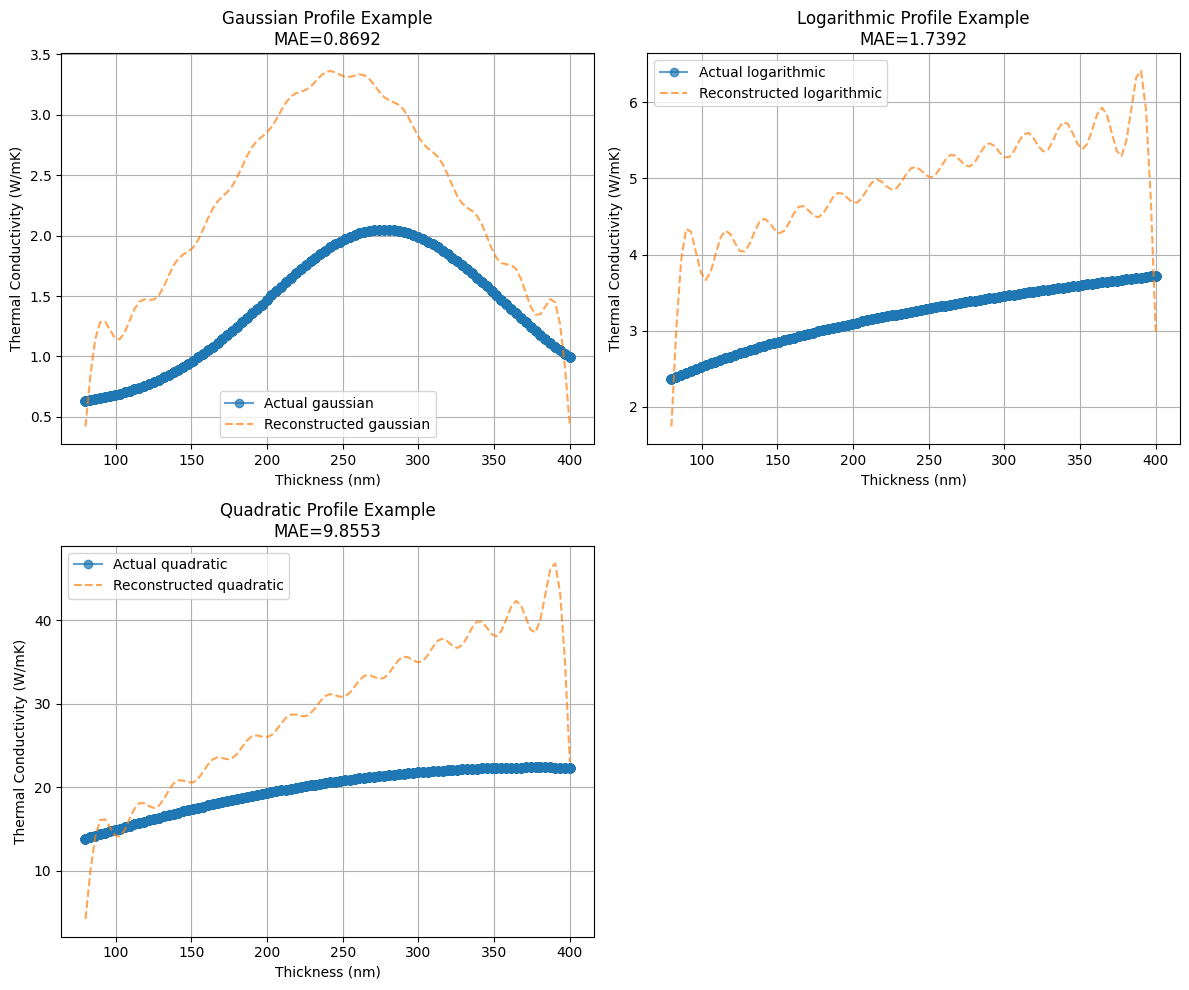

In [1]:
#main code #DO NOT delete


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=25):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=25):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=52):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=25):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        # 'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10  # Increased patience
    counter = 0
    epochs = 50
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation (using test set as proxy)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model_GLQ.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model_GLQ.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample a few examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue

        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile Example\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('thermal_conductivity_profiles_N25.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'thermal_conductivity_profiles_N25.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on gaussian distribution...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Processed 590000 data points for gaussian distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 472000 samples
Test set: 118000 samples
Starting model training...
Epoch 1/50: Train Loss = 0.642461, Val Loss = 0.611197
Epoch 2/50: Train Loss = 0.616130, Val Loss = 0.596652
Epoch 3/50: Train Loss = 0.606946, Val Loss = 0.589218
Epoch 4/50: Train Loss = 0.600661, Val Loss = 0.589264
Epoch 5/50: Train Loss = 0.596844, Val Loss = 0.576738
Epoch 6/50: Train Loss = 0.592717, Val Loss = 0.573674
Epoch 7/50: Train Loss = 0.589863, Val Loss = 0.570116
Epoch 8/50: Train Loss = 0.586818, Val Loss = 0.566782
Epoch 9/50: Train Loss = 0.584893, Val Loss = 0.565663
Epoch 10/50: Train Loss = 0.582693, Val Loss = 0.560578
Epoch 11/50: Train Loss = 0.580939, Val Loss = 0.

<ipython-input-6-dd4e78fe3bb3>:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 901.61 seconds
Visualizations saved to 'gaussian_profiles.png' and 'loss_curve.png'


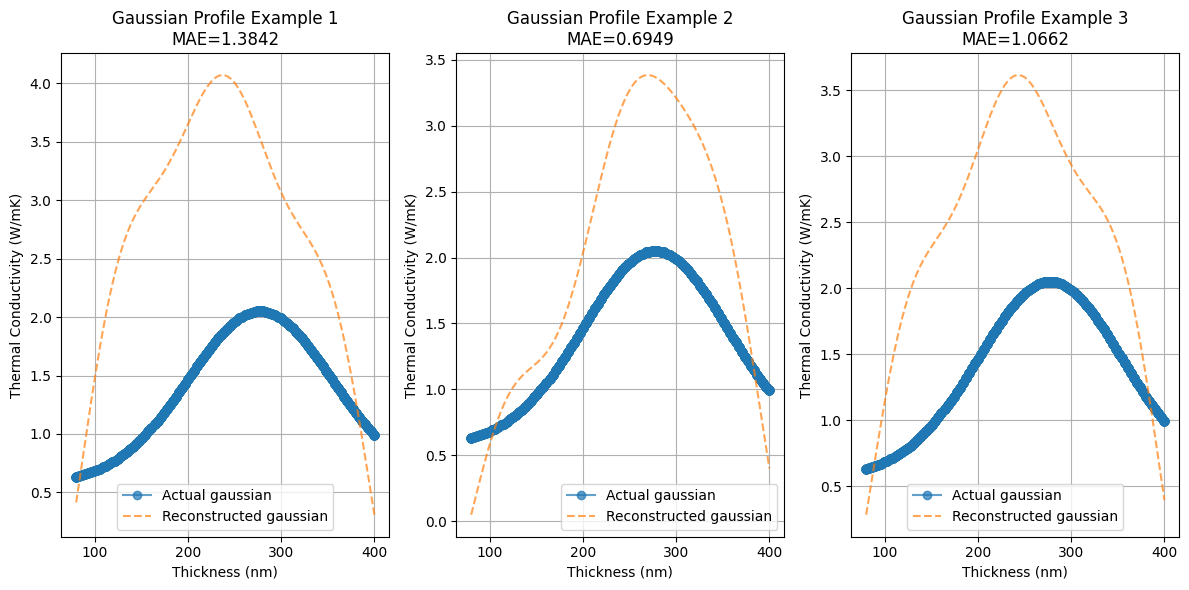

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=5):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=5)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=5, target_distribution='gaussian'):
    """Process data focusing only on the target distribution (gaussian)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=12):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=5):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on gaussian
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=5,  # Reduced Fourier terms
        target_distribution='gaussian'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for gaussian distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['gaussian'].keys())[0]
        x_values = reference_profiles['gaussian'][eq_id]['x']
        y_actual = reference_profiles['gaussian'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=5)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual gaussian', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed gaussian', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'Gaussian Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('gaussian_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'gaussian_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on logarithmic distribution...
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Processed 590000 data points for logarithmic distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 472000 samples
Test set: 118000 samples
Starting model training...
Epoch 1/50: Train Loss = 0.286822, Val Loss = 0.261684
Epoch 2/50: Train Loss = 0.261119, Val Loss = 0.248171
Epoch 3/50: Train Loss = 0.251084, Val Loss = 0.241656
Epoch 4/50: Train Loss = 0.243357, Val Loss = 0.238706
Epoch 5/50: Train Loss = 0.238600, Val Loss = 0.235254
Epoch 6/50: Train Loss = 0.236272, Val Loss = 0.236131
Epoch 7/50: Train Loss = 0.234592, Val Loss = 0.234607
Epoch 8/50: Train Loss = 0.232981, Val Loss = 0.237335
Epoch 9/50: Train Loss = 0.231750, Val Loss = 0.232557
Epoch 10/50: Train Loss = 0.230565, Val Loss = 0.230158
Epoch 11/50: Train Loss = 0.229835, V

<ipython-input-12-9ab0e7954f5a>:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 1054.66 seconds
Visualizations saved to 'logarithmic_profiles.png' and 'loss_curve.png'


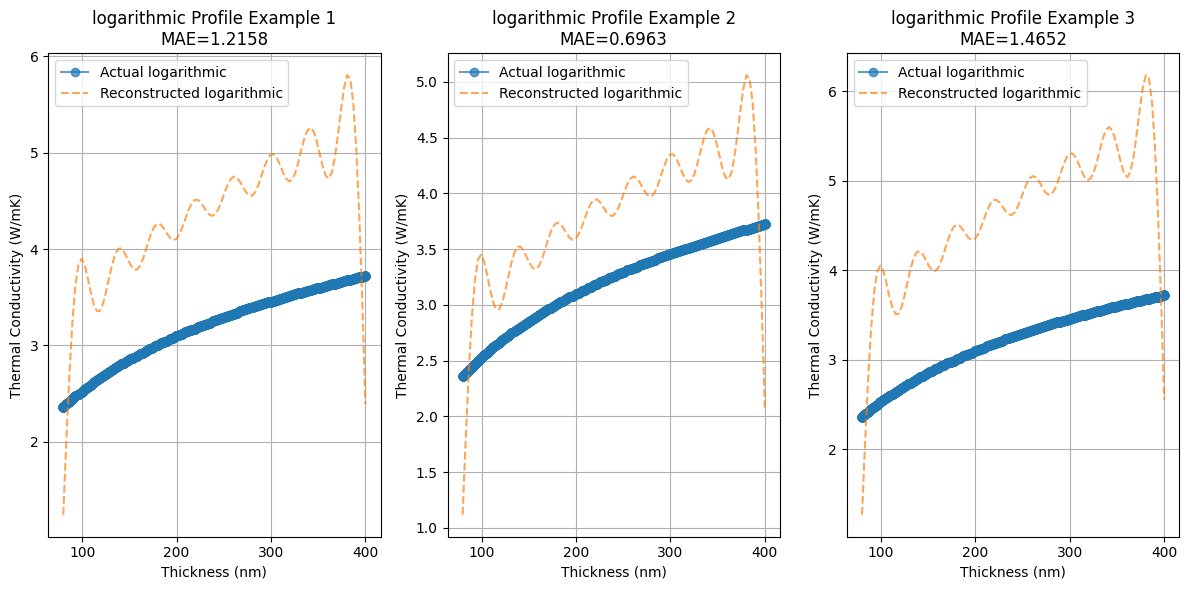

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

# def fourier_series_coefficients(y_values, x_values, N=5):
#     """Convert a distribution into Fourier series coefficients with reduced terms (N=5)."""
def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=15)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15, target_distribution='logarithmic'):
    """Process data focusing only on the target distribution (logarithmic)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=12):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on logarithmic
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=15,  # Reduced Fourier terms
        target_distribution='logarithmic'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for logarithmic distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['logarithmic'].keys())[0]
        x_values = reference_profiles['logarithmic'][eq_id]['x']
        y_actual = reference_profiles['logarithmic'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual logarithmic', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed logarithmic', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'logarithmic Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('logarithmic_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'logarithmic_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on quadratic distribution...
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 560500 data points for quadratic distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 448400 samples
Test set: 112100 samples
Starting model training...
Epoch 1/50: Train Loss = 0.149962, Val Loss = 0.126148
Epoch 2/50: Train Loss = 0.129943, Val Loss = 0.130622
Epoch 3/50: Train Loss = 0.127116, Val Loss = 0.127364
Epoch 4/50: Train Loss = 0.124628, Val Loss = 0.130729
Epoch 5/50: Train Loss = 0.123543, Val Loss = 0.126317
Epoch 6/50: Train Loss = 0.122890, Val Loss = 0.127932
Epoch 7/50: Train Loss = 0.122432, Val Loss = 0.128869
Epoch 8/50: Train Loss = 0.122073, Val Loss = 0.125105
Epoch 9/50: Train Loss = 0.121637, Val Loss = 0.128237
Epoch 10/50: Train Loss = 0.121248, Val Loss = 0.127871
Epoch 11/50: Train Loss = 0.120964, Val Loss 

<ipython-input-9-f7c2b648ea6c>:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 482.81 seconds
Visualizations saved to 'quadratic_profiles.png' and 'loss_curve.png'


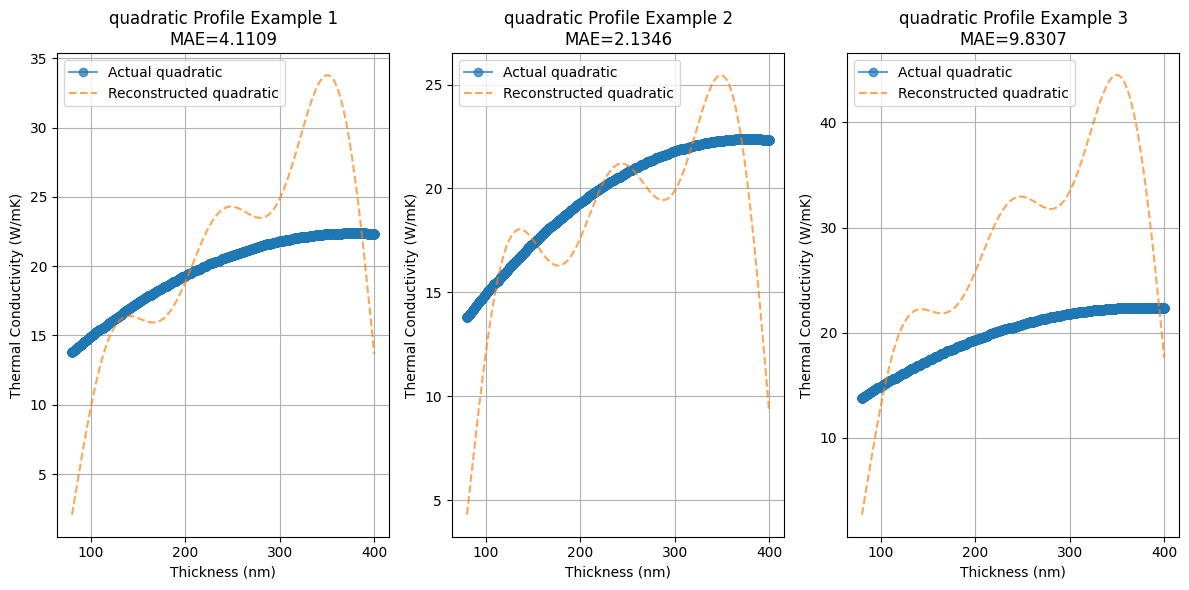

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=5):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=5)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=5, target_distribution='quadratic'):
    """Process data focusing only on the target distribution (quadratic)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=12):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=5):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on quadratic
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=5,  # Reduced Fourier terms
        target_distribution='quadratic'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for quadratic distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['quadratic'].keys())[0]
        x_values = reference_profiles['quadratic'][eq_id]['x']
        y_actual = reference_profiles['quadratic'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=5)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual quadratic', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed quadratic', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'quadratic Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('quadratic_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'quadratic_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on quadratic distribution...
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 560500 data points for quadratic distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 448400 samples
Test set: 112100 samples
Starting model training...
Epoch 1/50: Train Loss = 0.114593, Val Loss = 0.112689
Epoch 2/50: Train Loss = 0.095585, Val Loss = 0.125782
Epoch 3/50: Train Loss = 0.091241, Val Loss = 0.133656
Epoch 4/50: Train Loss = 0.088282, Val Loss = 0.135277
Epoch 5/50: Train Loss = 0.085971, Val Loss = 0.147804
Epoch 6/50: Train Loss = 0.083958, Val Loss = 0.149215
Epoch 7/50: Train Loss = 0.082332, Val Loss = 0.155355
Epoch 8/50: Train Loss = 0.080899, Val Loss = 0.166634
Epoch 9/50: Train Loss = 0.079176, Val Loss = 0.157254
Epoch 10/50: Train Loss = 0.077995, Val Loss = 0.156934
Epoch 11/50: Train Loss = 0.076771, Val Loss 

<ipython-input-14-92322df258cb>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 421.97 seconds
Visualizations saved to 'quadratic_profiles.png' and 'loss_curve.png'


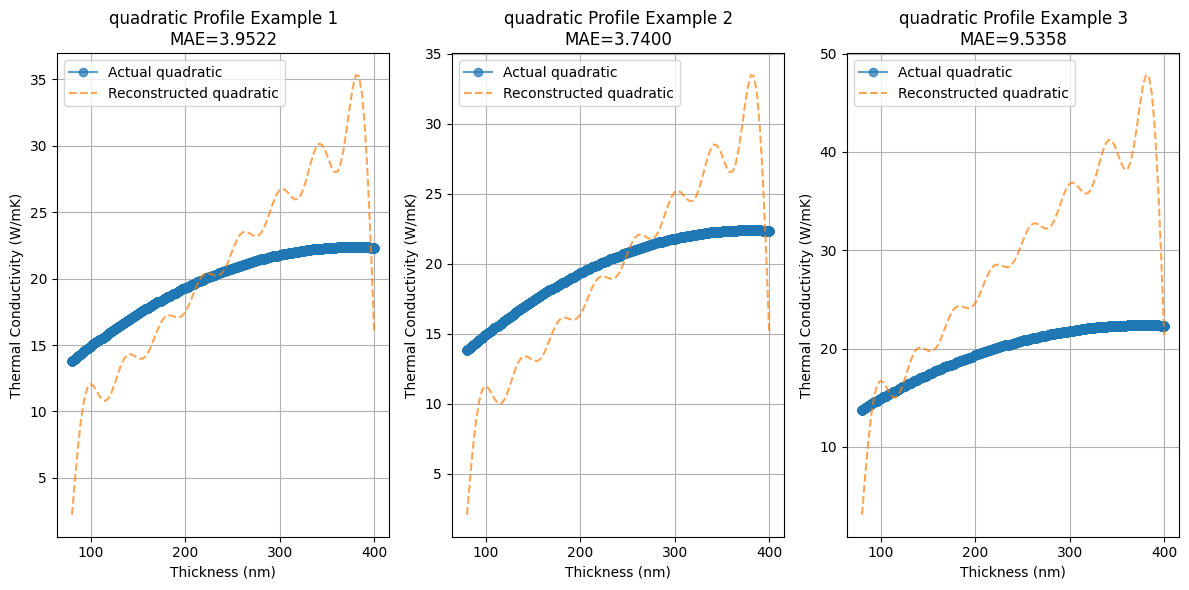

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=15)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15, target_distribution='quadratic'):
    """Process data focusing only on the target distribution (quadratic)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=32):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on quadratic
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=15,  # Reduced Fourier terms
        target_distribution='quadratic'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for quadratic distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['quadratic'].keys())[0]
        x_values = reference_profiles['quadratic'][eq_id]['x']
        y_actual = reference_profiles['quadratic'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual quadratic', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed quadratic', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'quadratic Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('quadratic_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'quadratic_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on polynomial distribution...
Loading polynomial data from thermal_conductivity_polynomial_20250207_155543.csv
Processed 253700 data points for polynomial distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 202960 samples
Test set: 50740 samples
Starting model training...
Epoch 1/50: Train Loss = 0.894360, Val Loss = 0.871295
Epoch 2/50: Train Loss = 0.876182, Val Loss = 0.865035
Epoch 3/50: Train Loss = 0.872565, Val Loss = 0.864963
Epoch 4/50: Train Loss = 0.871043, Val Loss = 0.863475
Epoch 5/50: Train Loss = 0.870413, Val Loss = 0.863525
Epoch 6/50: Train Loss = 0.870074, Val Loss = 0.863407
Epoch 7/50: Train Loss = 0.869851, Val Loss = 0.863483
Epoch 8/50: Train Loss = 0.869443, Val Loss = 0.865010
Epoch 9/50: Train Loss = 0.869225, Val Loss = 0.864492
Epoch 10/50: Train Loss = 0.869752, Val Loss = 0.863333
Epoch 11/50: Train Loss = 0.869405, Val Lo

<ipython-input-10-f655c09600a1>:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 225.54 seconds
Visualizations saved to 'polynomial_profiles.png' and 'loss_curve.png'


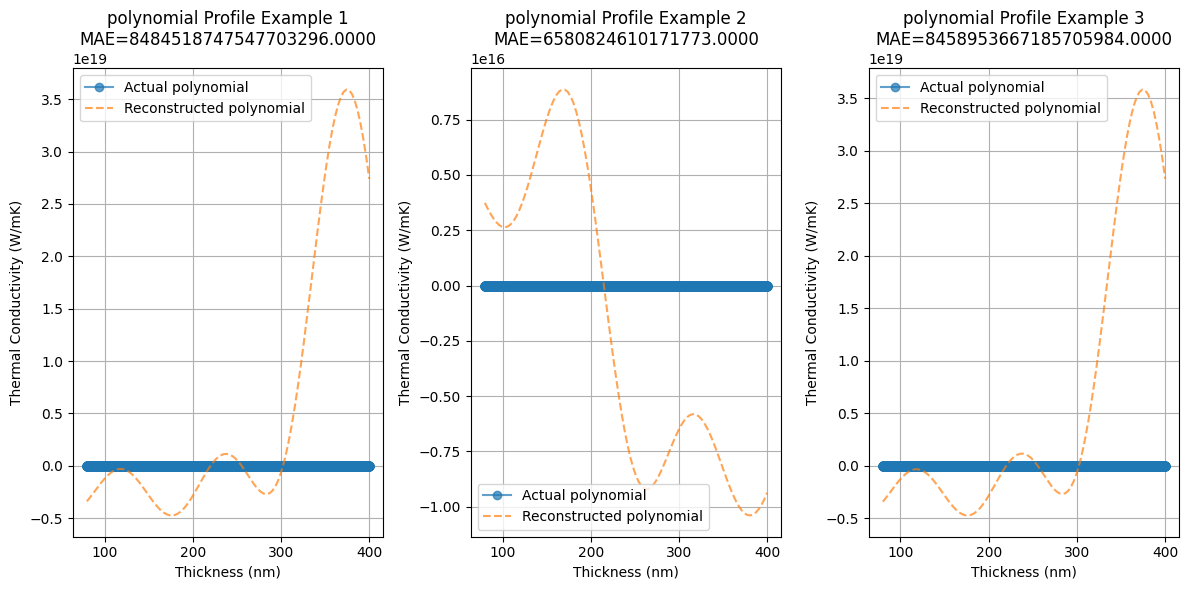

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=5):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=5)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=5, target_distribution='polynomial'):
    """Process data focusing only on the target distribution (polynomial)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=12):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=5):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on polynomial
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=5,  # Reduced Fourier terms
        target_distribution='polynomial'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for polynomial distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['polynomial'].keys())[0]
        x_values = reference_profiles['polynomial'][eq_id]['x']
        y_actual = reference_profiles['polynomial'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=5)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual polynomial', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed polynomial', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'polynomial Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('polynomial_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'polynomial_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions (5 different architectures)
# =============================

class FourierNN_Model1(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        self.name = "ReLU_Dropout"

    def forward(self, x):
        return self.network(x)

class FourierNN_Model2(nn.Module):
    """GELU activation with batch normalization"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Linear(64, output_dim)
        )
        self.name = "GELU_BatchNorm"

    def forward(self, x):
        return self.network(x)

class FourierNN_Model3(nn.Module):
    """Tanh activation with L2 regularization"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, output_dim)
        )
        self.name = "Tanh_L2Reg"
        # L2 regularization will be applied via weight_decay in optimizer

    def forward(self, x):
        return self.network(x)

class FourierNN_Model4(nn.Module):
    """Leaky ReLU with residual connections"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, 128)
        self.hidden1 = nn.Linear(128, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, output_dim)
        self.activation = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.2)
        self.name = "LeakyReLU_Residual"

    def forward(self, x):
        x1 = self.activation(self.input_layer(x))
        x1 = self.dropout(x1)
        
        x2 = self.activation(self.hidden1(x1))
        x2 = self.dropout(x2)
        x2 = x2 + x1  # Residual connection
        
        x3 = self.activation(self.hidden2(x2))
        x3 = self.dropout(x3)
        x3 = x3 + x2  # Residual connection
        
        x4 = self.activation(self.hidden3(x3))
        output = self.output_layer(x4)
        return output

class FourierNN_Model5(nn.Module):
    """Deeper SiLU (Swish) activation model"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, output_dim)
        )
        self.name = "SiLU_Deeper"

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Training Function
# =============================

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, N, epochs=50):
    """Train model with early stopping and return metrics"""
    print(f"Training {model.name} model...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    train_losses = []
    val_losses = []
    
    # Create directory for model saving if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
        
        # Learning rate scheduler step
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            model_path = f'models/model_N{N}_{model.name}.pth'
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model to {model_path}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load(f'models/model_N{N}_{model.name}.pth'))
    
    return model, train_losses, val_losses, best_loss

# =============================
# 7. Evaluation Function
# =============================

def evaluate_model(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, N):
    """Evaluate model on test set and visualize results"""
    model.eval()
    
    # Create directory for visualizations if it doesn't exist
    os.makedirs('visualizations', exist_ok=True)
    
    # Sample examples from each distribution type for visualization
    eq_types = list(reference_profiles.keys())
    plt.figure(figsize=(12, 10))
    
    mae_values = {}
    
    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]
        
        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']
        
        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
        
        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
        
        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
        
        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)
        mae_values[eq_type] = mae
        
        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/profiles_N{N}_{model.name}.png', dpi=300)
    plt.close()
    
    return mae_values



def create_model(input_dim, output_dim, config):
    """Create a model with the specified configuration"""
    layers = []
    prev_dim = input_dim
    
    # Add input features for polynomial terms
    input_dim += 4  # For x², x³, sin(x), cos(x)
    
    # Build layers according to configuration
    for dim in config["layers"]:
        layers.append(nn.Linear(prev_dim, dim))
        layers.append(config["activation"])
        layers.append(nn.Dropout(config["dropout"]))
        prev_dim = dim
    
    # Output layer
    layers.append(nn.Linear(prev_dim, output_dim))
    
    model = nn.Sequential(*layers)
    return model

def visualize_model_results(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, model_name):
    """Visualize results for a single model and return MAE values"""
    model.eval()
    eq_types = list(reference_profiles.keys())
    plt.figure(figsize=(12, 10))
    
    mae_values = {}
    
    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]
        
        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']
        
        # Add engineered features
        sample_features_enhanced = np.concatenate([
            sample_features,
            np.array([sample_features[0]**2, sample_features[0]**3, 
                     np.sin(sample_features[0]*0.01), np.cos(sample_features[0]*0.01)])
        ])
        
        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features_enhanced.reshape(1, -1))).numpy()[0]
        
        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
        
        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values)
        
        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)
        mae_values[eq_type] = mae
        
        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/{model_name}_profiles.png', dpi=300)
    plt.close()
    
    return mae_values
  
if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with multiple models...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...

Training model: ReLU_Standard


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.061277, Val Loss = 0.042172
Epoch 2/50: Train Loss = 0.054003, Val Loss = 0.040210
Epoch 3/50: Train Loss = 0.053228, Val Loss = 0.039449
Epoch 4/50: Train Loss = 0.052806, Val Loss = 0.039728
Epoch 5/50: Train Loss = 0.052571, Val Loss = 0.040754
Epoch 6/50: Train Loss = 0.052463, Val Loss = 0.038823
Epoch 7/50: Train Loss = 0.052329, Val Loss = 0.040640
Epoch 8/50: Train Loss = 0.052197, Val Loss = 0.039288
Epoch 9/50: Train Loss = 0.052115, Val Loss = 0.039103
Epoch 10/50: Train Loss = 0.051807, Val Loss = 0.039019
Epoch 11/50: Train Loss = 0.051982, Val Loss = 0.039882
Epoch 12/50: Train Loss = 0.051787, Val Loss = 0.039356
Epoch 13/50: Train Loss = 0.050477, Val Loss = 0.038343
Epoch 14/50: Train Loss = 0.050358, Val Loss = 0.037592
Epoch 15/50: Train Loss = 0.050149, Val Loss = 0.037533
Epoch 16/50: Train Loss = 0.050144, Val Loss = 0.037306
Epoch 17/50: Train Loss = 0.050032, Val Loss = 0.037410
Epoch 18/50: Train Loss = 0.050057, Val Loss = 0.037349
E

/tmp/ipykernel_519930/468736156.py:490: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{config["name"]}_best.pth'))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7 and 3x256)

<Figure size 1200x1000 with 0 Axes>

In [ ]:
# def main():
#     start_time = time.time()
#     print("Starting thermal conductivity profile analysis with multiple models...")
    
#     # Create directories for storing results
#     os.makedirs('models', exist_ok=True)
#     os.makedirs('visualizations', exist_ok=True)
    
#     # Load Data
#     data_files = {
#         'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
#         'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
#         'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
#     }
    
#     # Process data
#     features_df, targets_df, eq_ids, reference_profiles = process_data(data_files)
    
#     # Data Normalization
#     print("Normalizing data...")
#     feature_scaler = StandardScaler()
#     features_normalized = feature_scaler.fit_transform(features_df.values)

#     target_scaler = StandardScaler()
#     targets_normalized = target_scaler.fit_transform(targets_df.values)

#     # Split into training and testing sets
#     X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
#         features_normalized, targets_normalized, eq_ids,
#         test_size=0.2, random_state=42, stratify=eq_ids
#     )
    
#     # Create datasets and dataloaders
#     train_dataset = ThermalConductivityDataset(X_train, y_train)
#     test_dataset = ThermalConductivityDataset(X_test, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=64)
    
#     # Define different model configurations
#     model_configs = [
#         {"name": "ReLU_Standard", "activation": nn.ReLU(), "dropout": 0.2, "layers": [256, 128, 64]},
#         {"name": "Tanh_Deep", "activation": nn.Tanh(), "dropout": 0.3, "layers": [256, 256, 128, 64]},
#         {"name": "GELU_Wide", "activation": nn.GELU(), "dropout": 0.2, "layers": [512, 256, 128]},
#         {"name": "LeakyReLU_Medium", "activation": nn.LeakyReLU(0.1), "dropout": 0.25, "layers": [256, 192, 128, 64]},
#         {"name": "SiLU_Standard", "activation": nn.SiLU(), "dropout": 0.2, "layers": [256, 128, 64]}
#     ]
    
#     # Store results for all models
#     all_results = {}
    
#     # Train and evaluate each model configuration
#     for config in model_configs:
#         print(f"\n{'='*50}")
#         print(f"Training model: {config['name']}")
#         print(f"{'='*50}")
        
#         # Create model with this configuration
#         model = create_model(X_train.shape[1], y_train.shape[1], config)
        
#         # Train model
#         criterion = nn.MSELoss()
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#         scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        
#         # Training loop
#         best_loss = float('inf')
#         patience = 10
#         counter = 0
#         train_losses = []
#         val_losses = []
        
#         for epoch in range(50):  # 50 epochs max
#             # Training phase
#             model.train()
#             train_loss = 0
#             for features_batch, targets_batch in train_loader:
#                 optimizer.zero_grad()
#                 outputs = model(features_batch)
#                 loss = criterion(outputs, targets_batch)
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()
#                 train_loss += loss.item()
            
#             avg_train_loss = train_loss / len(train_loader)
#             train_losses.append(avg_train_loss)
            
#             # Validation phase
#             model.eval()
#             val_loss = 0
#             with torch.no_grad():
#                 for features_batch, targets_batch in test_loader:
#                     outputs = model(features_batch)
#                     loss = criterion(outputs, targets_batch)
#                     val_loss += loss.item()
            
#             avg_val_loss = val_loss / len(test_loader)
#             val_losses.append(avg_val_loss)
#             scheduler.step(avg_val_loss)
            
#             print(f"Epoch {epoch+1}/50: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
            
#             # Early stopping
#             if avg_val_loss < best_loss:
#                 best_loss = avg_val_loss
#                 counter = 0
#                 torch.save(model.state_dict(), f'models/{config["name"]}_best.pth')
#             else:
#                 counter += 1
#                 if counter >= patience:
#                     print(f"Early stopping triggered at epoch {epoch+1}")
#                     break
        
#         # Load best model
#         model.load_state_dict(torch.load(f'models/{config["name"]}_best.pth'))
        
#         # Immediately visualize results for this model
#         print(f"Generating visualizations for {config['name']}...")
#         mae_values = visualize_model_results(model, test_loader, target_scaler, reference_profiles, 
#                                             eq_test, X_test, config["name"])
        
#         # Store results
#         all_results[config["name"]] = {
#             "train_losses": train_losses,
#             "val_losses": val_losses,
#             "best_val_loss": best_loss,
#             "mae_values": mae_values
#         }
        
#         # Plot training curves for this model
#         plt.figure(figsize=(10, 6))
#         plt.plot(train_losses, label='Training Loss')
#         plt.plot(val_losses, label='Validation Loss')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title(f'Training and Validation Loss - {config["name"]}')
#         plt.legend()
#         plt.grid(True)
#         plt.savefig(f'visualizations/{config["name"]}_loss_curve.png', dpi=300)
#         plt.close()
        
#         print(f"Results for {config['name']} saved.")
    
#     # After all models are trained, print comparison
#     print("\n" + "="*50)
#     print("Model Comparison Summary")
#     print("="*50)
    
#     for model_name, results in all_results.items():
#         print(f"\nModel: {model_name}")
#         print(f"Best Validation Loss: {results['best_val_loss']:.6f}")
#         print("MAE Values by Distribution Type:")
#         for eq_type, mae in results['mae_values'].items():
#             print(f"  - {eq_type}: {mae:.4f}")
    
#     end_time = time.time()
#     print(f"\nComplete analysis finished in {end_time - start_time:.2f} seconds")

Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples
Starting model training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.072775, Val Loss = 0.054793
Saved best model (Val Loss: 0.054793)
Epoch 2/50: Train Loss = 0.064100, Val Loss = 0.059497
Epoch 3/50: Train Loss = 0.062493, Val Loss = 0.047907
Saved best model (Val Loss: 0.047907)
Epoch 4/50: Train Loss = 0.062268, Val Loss = 0.041412
Saved best model (Val Loss: 0.041412)
Epoch 5/50: Train Loss = 0.061576, Val Loss = 0.047544
Epoch 6/50: Train Loss = 0.060910, Val Loss = 0.046157
Epoch 7/50: Train Loss = 0.061162, Val Loss = 0.040121
Saved best model (Val Loss: 0.040121)
Epoch 8/50: Train Loss = 0.060583, Val Loss = 0.046742
Epoch 9/50: Train Loss = 0.060343, Val Loss = 0.040751
Epoch 10/50: Train Loss = 0.059950, Val Loss = 0.049221
Epoch 11/50: Train Loss = 0.060224, Val Loss = 0.043104
Epoch 12/50: Train Loss = 0.059994, Val Loss = 0.044540
Epoch 13/50: Train Loss = 0.060013, Val Loss = 0.047027
Epoch 14/50: Train Loss = 0.059049, Val Loss = 0.044358
Epoch 15/50: Train Loss = 0.058873, Val Loss = 0.044797
Epoch 16/50: Trai

/tmp/ipykernel_38956/1004139506.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model.pth'))


Evaluating model and generating visualizations...
Analysis completed in 1028.59 seconds
Visualizations saved to 'visualizations/thermal_conductivity_profiles_N10.png'


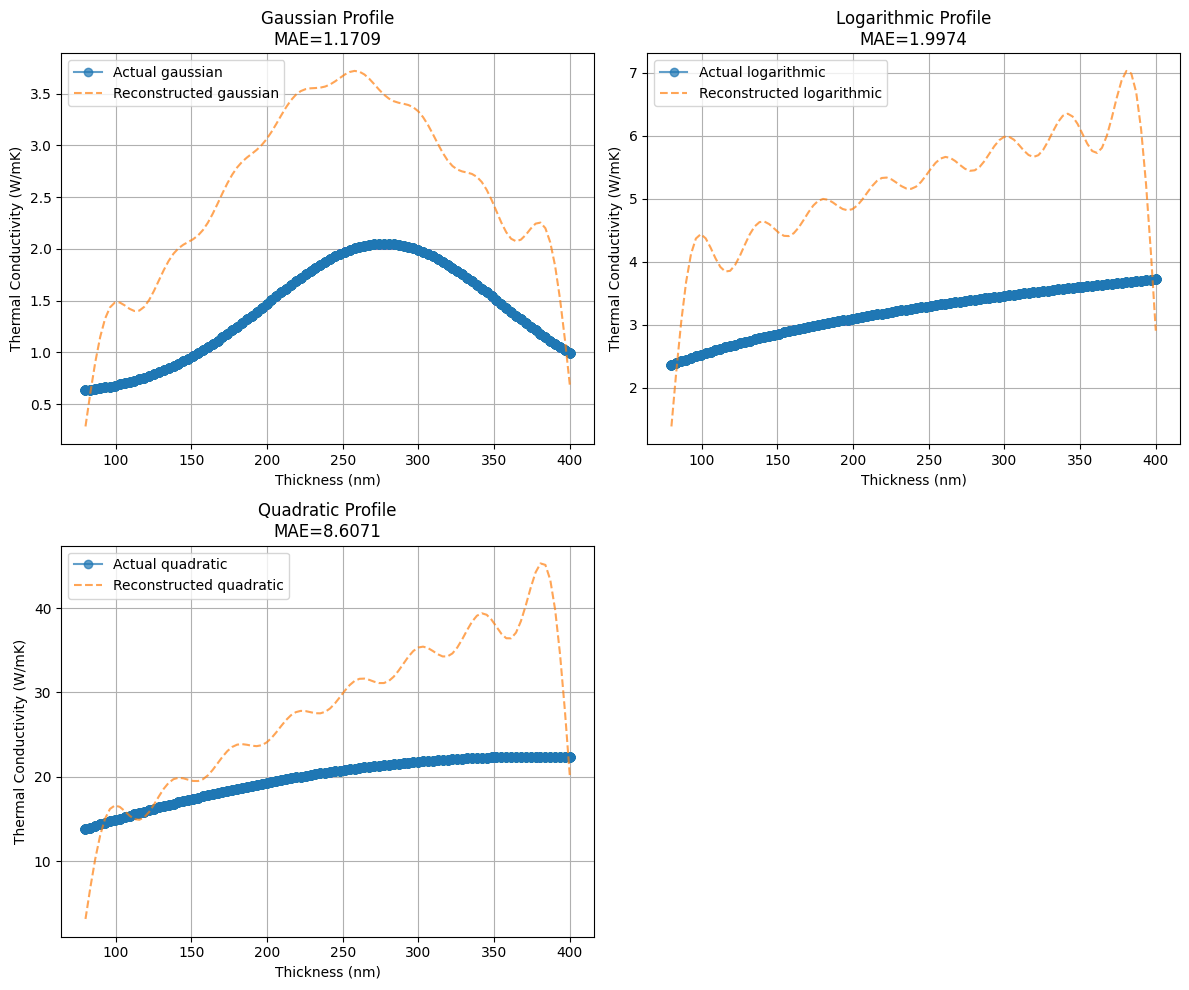

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions
# =============================

class FourierNN(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
        # Input layer
        nn.Linear(3, 32),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(32),
        
        # First hidden layer
        nn.Linear(32, 64),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(64),
        nn.Dropout(0.1),
        
        # Second hidden layer
        nn.Linear(64, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),
        nn.Dropout(0.15),
        
        # Third hidden layer
        nn.Linear(128, 64),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(64),
        nn.Dropout(0.1),
        
        # Output layer
        nn.Linear(64, 32)
    )
        self.name = "ReLU_Standard"

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Parameters
    N = 15  # Fourier series terms

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_model.pth')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_model.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve.png', dpi=300)
    plt.close()

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:models
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profileX_train.shape
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/thermal_conductivity_profiles_N10.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'visualizations/thermal_conductivity_profiles_N10.png'")

if __name__ == "__main__":
    main()


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/tmp/ipykernel_4080/1621758630.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from models/best_model.pth


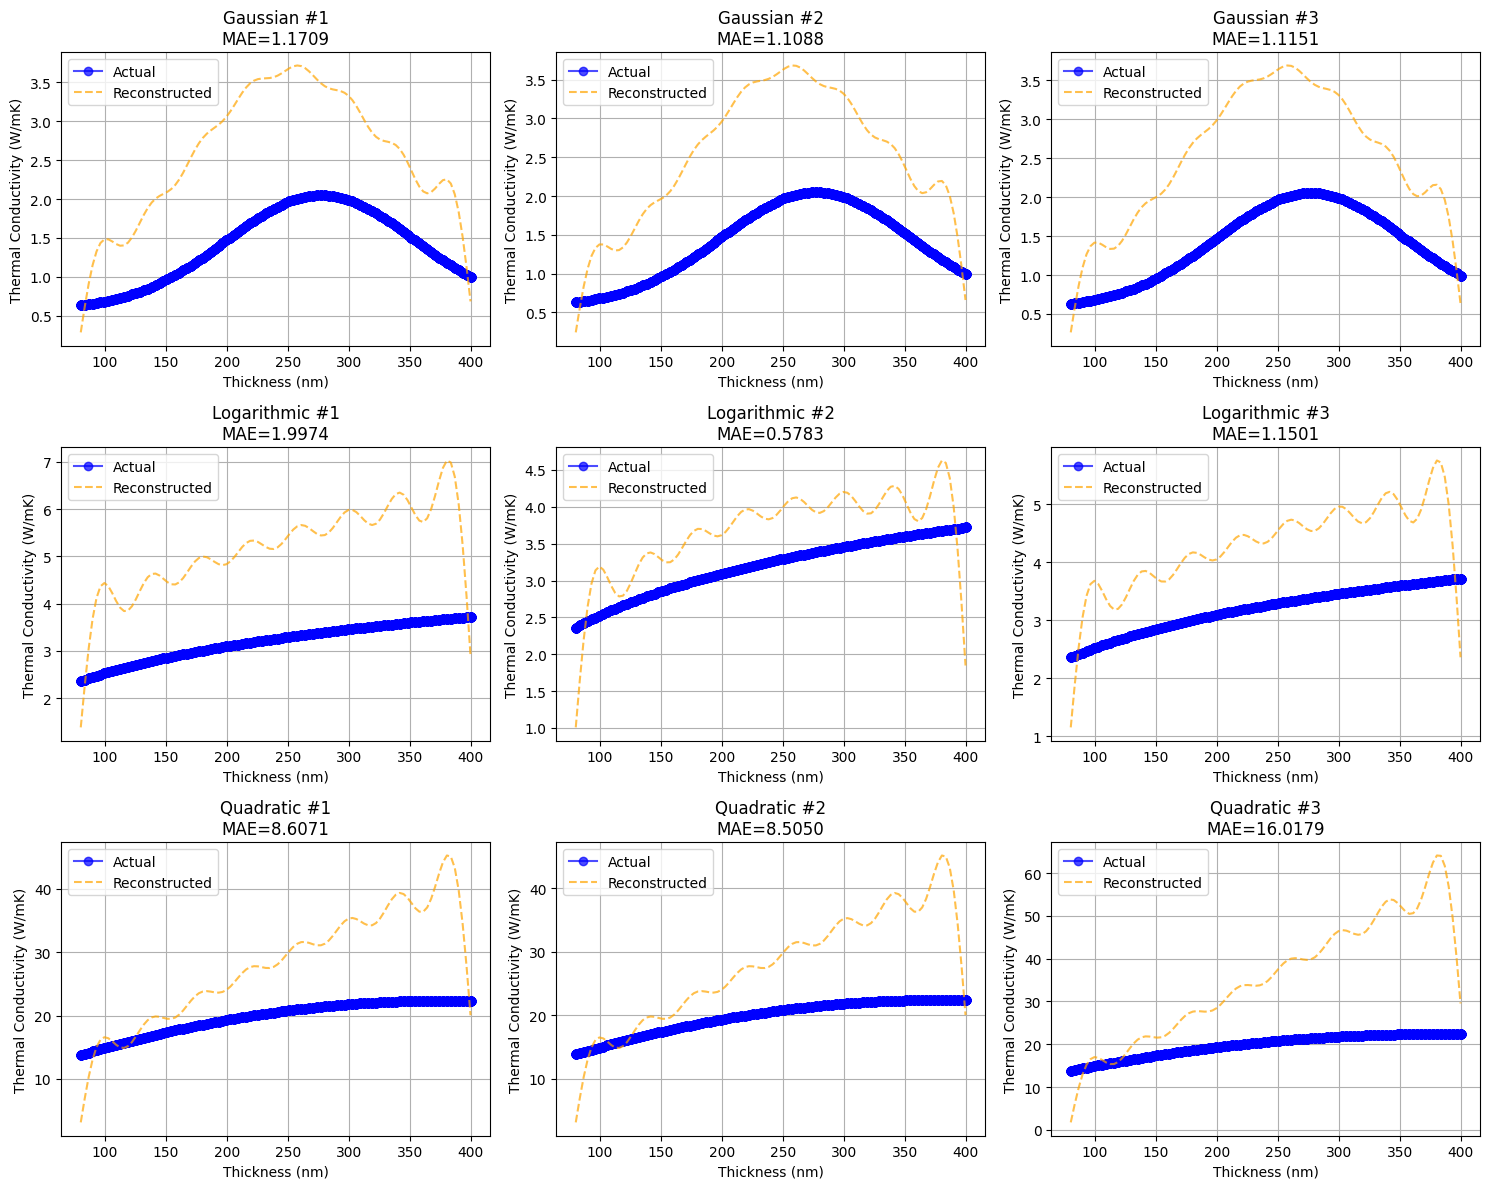


MAE Summary:
Gaussian: Mean MAE = 1.1316, Min = 1.1088, Max = 1.1709
Logarithmic: Mean MAE = 1.2419, Min = 0.5783, Max = 1.9974
Quadratic: Mean MAE = 11.0433, Min = 8.5050, Max = 16.0179


{'gaussian': [1.1708622063329959, 1.1088241090410837, 1.1151362185033178],
 'logarithmic': [1.997382918839494, 0.5782844998876564, 1.1501219512864496],
 'quadratic': [8.607126724749682, 8.504971128506003, 16.017938251754273]}

In [4]:
# Load the saved model and visualize multiple predictions
def visualize_saved_model(model_path='models/best_model.pth', samples_per_type=3):
    # Load data files
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=15)
    
    # Data Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Load model
    model = FourierNN(input_dim=3, output_dim=32)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
            
            # Calculate MAE
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N15.png', dpi=300)
    plt.show()
    
    # Print summary of MAE values
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    return mae_values

# Call the function to visualize multiple examples
visualize_saved_model(model_path='models/best_model.pth', samples_per_type=3)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions
# =============================

class FourierNN(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
        # Input layer
        nn.Linear(3, 64),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(64),
        
        # First hidden layer
        nn.Linear(64, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),
        nn.Dropout(0.1),
        
        # Second hidden layer
        nn.Linear(128, 256),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(256),
        nn.Dropout(0.15),
        
        # Third hidden layer
        nn.Linear(256, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),
        nn.Dropout(0.1),
        
        # Output layer
        nn.Linear(128, 32)
    )
        self.name = "ReLU_Standard"

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Parameters
    N = 15  # Fourier series terms

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_model_n15_Apr.pth')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_model_n15_Apr.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve.png', dpi=300)
    plt.close()

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:models
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profileX_train.shape
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/thermal_conductivity_profiles_N15_15Apr.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'visualizations/thermal_conductivity_profiles_N15_15Apr.png'")

if __name__ == "__main__":
    main()


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/tmp/ipykernel_8230/2996917146.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from models/best_model_n25.pth


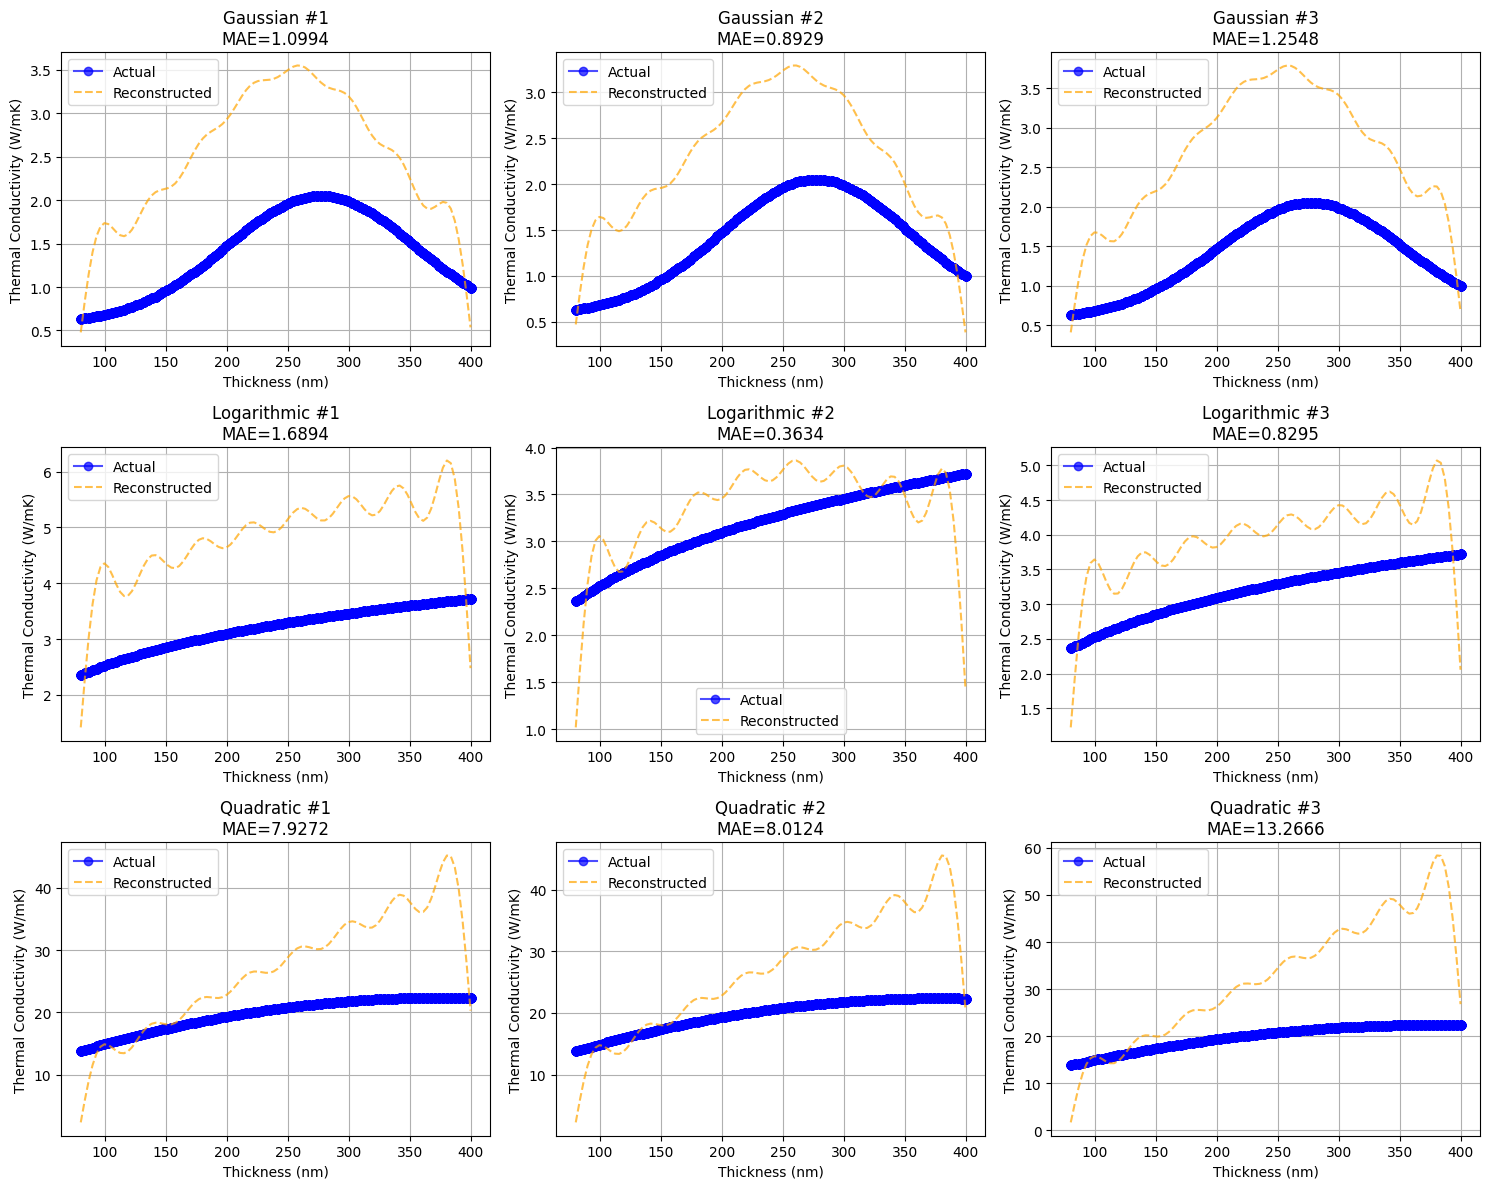


MAE Summary:
Gaussian: Mean MAE = 1.0824, Min = 0.8929, Max = 1.2548
Logarithmic: Mean MAE = 0.9607, Min = 0.3634, Max = 1.6894
Quadratic: Mean MAE = 9.7354, Min = 7.9272, Max = 13.2666


{'gaussian': [1.0993630502121432, 0.8928887280978802, 1.254808585966068],
 'logarithmic': [1.6893691772778956, 0.3633668154404159, 0.8295068808086349],
 'quadratic': [7.927220302572819, 8.012427081779967, 13.266550283977674]}

In [5]:
# Load the saved model and visualize multiple predictions
def visualize_saved_model(model_path='models/best_model.pth', samples_per_type=3):
    # Load data files
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=15)
    
    # Data Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Load model
    model = FourierNN(input_dim=3, output_dim=32)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
            
            # Calculate MAE
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N15_newPred.png', dpi=300)
    plt.show()
    
    # Print summary of MAE values
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    return mae_values

# Call the function to visualize multiple examples
visualize_saved_model(model_path='models/best_model_n25.pth', samples_per_type=3)


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/tmp/ipykernel_54483/702067865.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from models/best_model_n25.pth


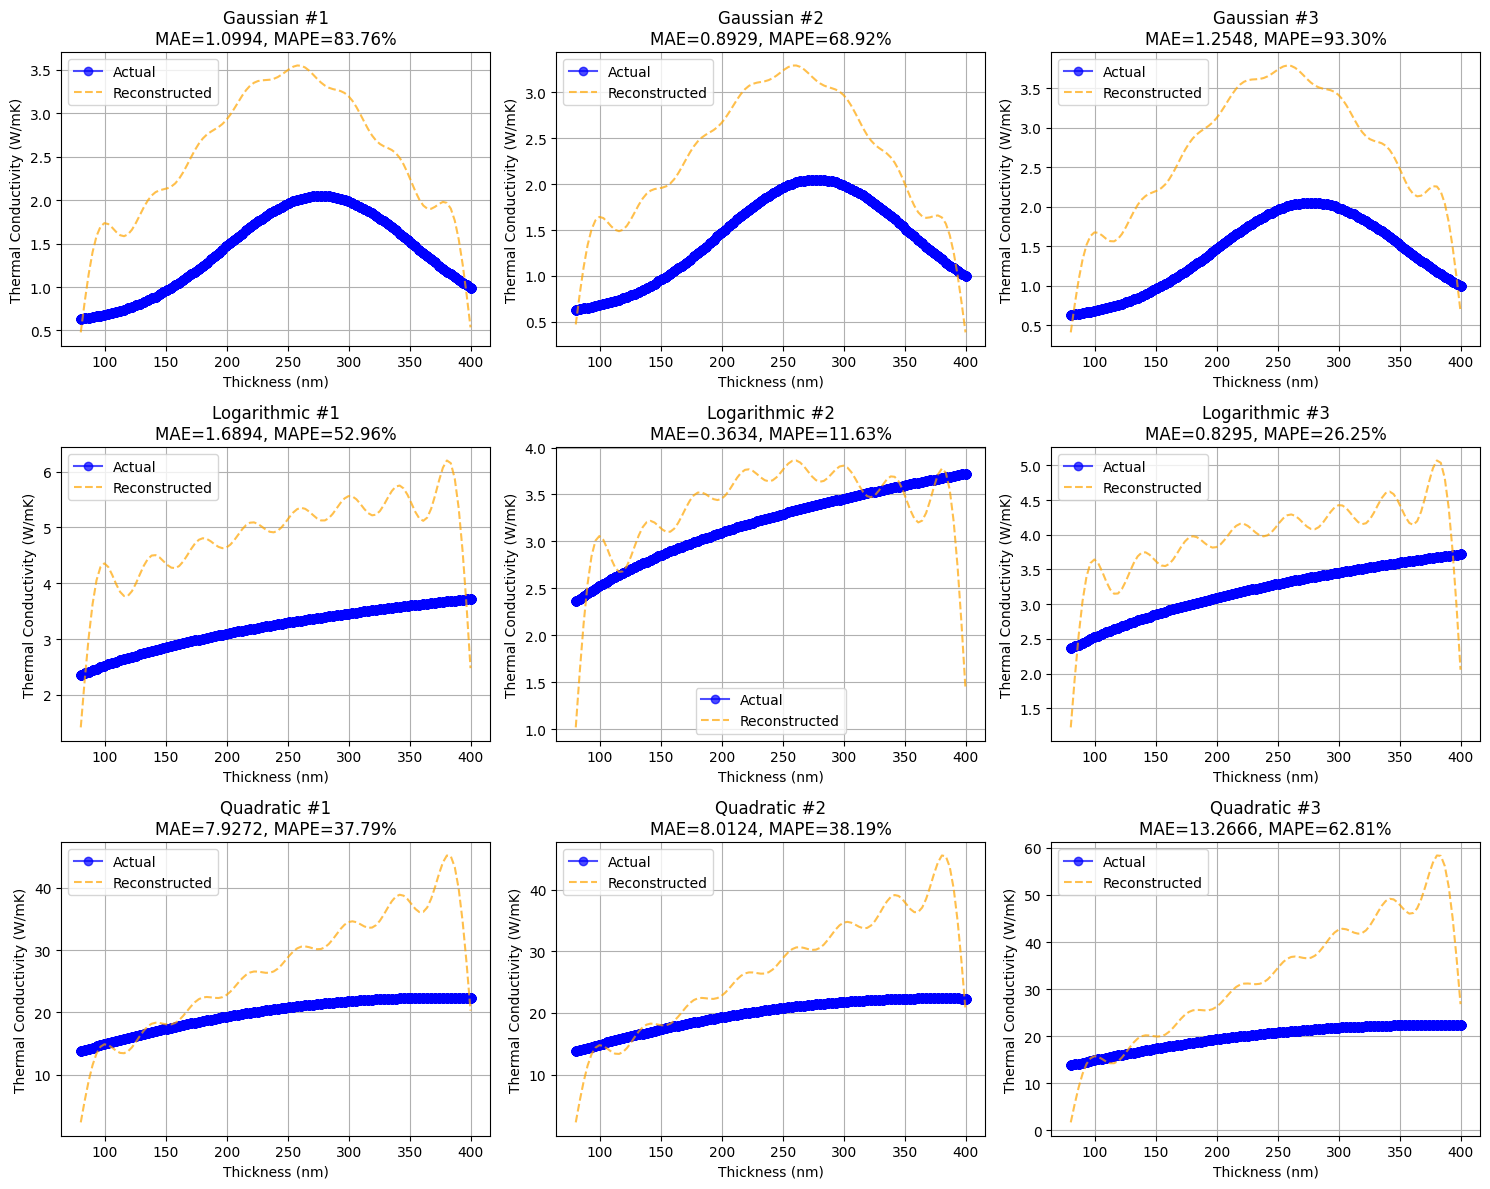


MAE Summary:
Gaussian: Mean MAE = 1.0824, Min = 0.8929, Max = 1.2548
Logarithmic: Mean MAE = 0.9607, Min = 0.3634, Max = 1.6894
Quadratic: Mean MAE = 9.7354, Min = 7.9272, Max = 13.2666

MAPE Summary (%):
Gaussian: Mean MAPE = 81.99%, Min = 68.92%, Max = 93.30%
Logarithmic: Mean MAPE = 30.28%, Min = 11.63%, Max = 52.96%
Quadratic: Mean MAPE = 46.26%, Min = 37.79%, Max = 62.81%


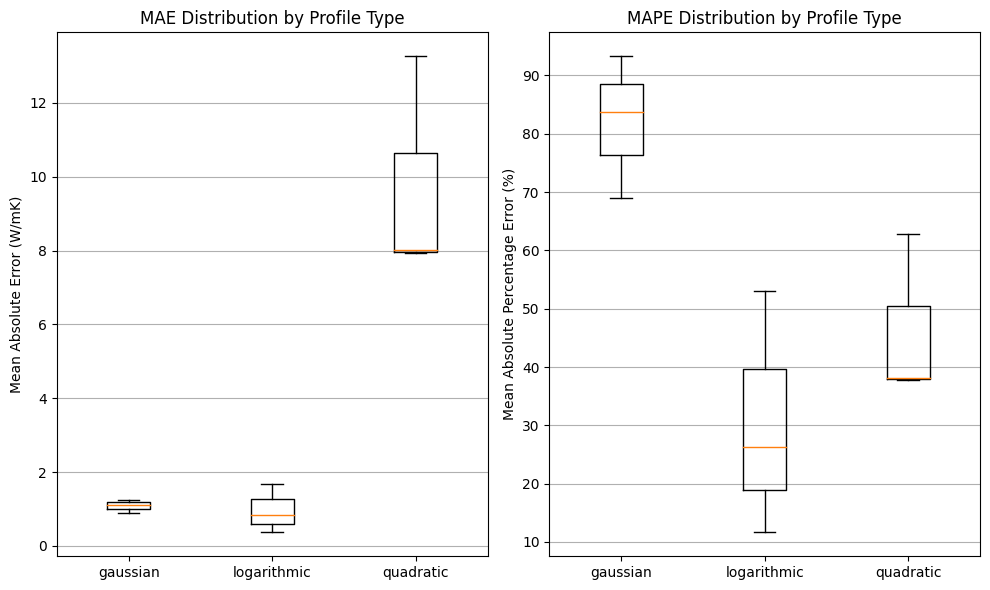

NameError: name 'eq_test' is not defined

In [8]:
data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
# Load the saved model and visualize multiple predictions with MAPE
def visualize_saved_model(model_path='models/best_model.pth', samples_per_type=5):
    # Load data files
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=15)
    
    # Data Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Load model
    model = FourierNN(input_dim=3, output_dim=32)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store error metrics for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    mape_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
            
            # Calculate MAE
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Calculate MAPE (Mean Absolute Percentage Error)
            # Avoid division by zero by adding a small epsilon to actual values
            epsilon = 1e-10
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values[eq_type].append(mape)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N15_with_mape.png', dpi=300)
    plt.show()
    
    # Print summary of error metrics
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    print("\nMAPE Summary (%):")
    for eq_type, mapes in mape_values.items():
        print(f"{eq_type.capitalize()}: Mean MAPE = {np.mean(mapes):.2f}%, Min = {np.min(mapes):.2f}%, Max = {np.max(mapes):.2f}%")
    
    # Create additional visualization for error comparison
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    boxplot_data_mae = [mae_values[eq_type] for eq_type in eq_types]
    plt.boxplot(boxplot_data_mae, labels=eq_types)
    plt.title('MAE Distribution by Profile Type')
    plt.ylabel('Mean Absolute Error (W/mK)')
    plt.grid(True, axis='y')
    
    plt.subplot(1, 2, 2)
    boxplot_data_mape = [mape_values[eq_type] for eq_type in eq_types]
    plt.boxplot(boxplot_data_mape, labels=eq_types)
    plt.title('MAPE Distribution by Profile Type')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig('visualizations/error_comparison.png', dpi=300)
    plt.show()
    
    return mae_values, mape_values

# Call the function to visualize multiple examples
mae_values, mape_values = visualize_saved_model(model_path='models/best_model_n25.pth', samples_per_type=3)

# Additional analysis: Calculate point-wise percentage errors 
def analyze_error_patterns(model_path='models/best_model_n25.pth'):
    """Analyze error patterns across different regions of the profiles"""
    # Load model and data (reusing code from above)
    # ...code to load model and data...
    
    # For each distribution type, select one example
    error_by_region = {}
    
    for eq_type in data_files.keys():
        # Get test sample
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        if not eq_indices:
            continue
            
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]
        
        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']
        
        # Predict and reconstruct
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
        
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
        
        # Calculate per-point percentage error
        point_errors = np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + 1e-10)) * 100
        
        # Divide profile into regions (beginning, middle, end)
        n_points = len(x_values)
        region_indices = [
            slice(0, n_points//3),                  # beginning
            slice(n_points//3, 2*n_points//3),      # middle
            slice(2*n_points//3, n_points)          # end
        ]
        
        error_by_region[eq_type] = {
            'beginning': np.mean(point_errors[region_indices[0]]),
            'middle': np.mean(point_errors[region_indices[1]]),
            'end': np.mean(point_errors[region_indices[2]])
        }
    
    # Visualize regional errors
    plt.figure(figsize=(10, 6))
    regions = ['beginning', 'middle', 'end']
    bar_width = 0.25
    r1 = np.arange(len(regions))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.bar(r1, [error_by_region['gaussian'][region] for region in regions], 
            width=bar_width, label='Gaussian', color='blue')
    plt.bar(r2, [error_by_region['logarithmic'][region] for region in regions], 
            width=bar_width, label='Logarithmic', color='green')
    plt.bar(r3, [error_by_region['quadratic'][region] for region in regions], 
            width=bar_width, label='Quadratic', color='red')
    
    plt.xlabel('Profile Region')
    plt.ylabel('Mean Percentage Error (%)')
    plt.title('Error Distribution Across Profile Regions')
    plt.xticks([r + bar_width for r in range(len(regions))], regions)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('visualizations/regional_error_analysis.png', dpi=300)
    plt.show()
    
    return error_by_region

# Call the function for deeper error analysis
error_patterns = analyze_error_patterns(model_path='models/best_model_n25.pth')


Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples
Starting model training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.064400, Val Loss = 0.048639
Saved best model (Val Loss: 0.048639)
Epoch 2/50: Train Loss = 0.056338, Val Loss = 0.050865
Epoch 3/50: Train Loss = 0.054600, Val Loss = 0.049306
Epoch 4/50: Train Loss = 0.054089, Val Loss = 0.043366
Saved best model (Val Loss: 0.043366)
Epoch 5/50: Train Loss = 0.053532, Val Loss = 0.042876
Saved best model (Val Loss: 0.042876)
Epoch 6/50: Train Loss = 0.053070, Val Loss = 0.042374
Saved best model (Val Loss: 0.042374)
Epoch 7/50: Train Loss = 0.052767, Val Loss = 0.040850
Saved best model (Val Loss: 0.040850)
Epoch 8/50: Train Loss = 0.052556, Val Loss = 0.040698
Saved best model (Val Loss: 0.040698)
Epoch 9/50: Train Loss = 0.052411, Val Loss = 0.041350
Epoch 10/50: Train Loss = 0.052222, Val Loss = 0.041748
Epoch 11/50: Train Loss = 0.051908, Val Loss = 0.037611
Saved best model (Val Loss: 0.037611)
Epoch 12/50: Train Loss = 0.052280, Val Loss = 0.041700
Epoch 13/50: Train Loss = 0.051662, Val Loss = 0.038960
Epoch 14/50: Tr

/tmp/ipykernel_54483/486334090.py:301: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_N20_Complex.pth'))


Evaluating model and generating visualizations...
Analysis completed in 4665.29 seconds
Visualizations saved to 'visualizations/thermal_conductivity_profiles_N20_Complex.png'


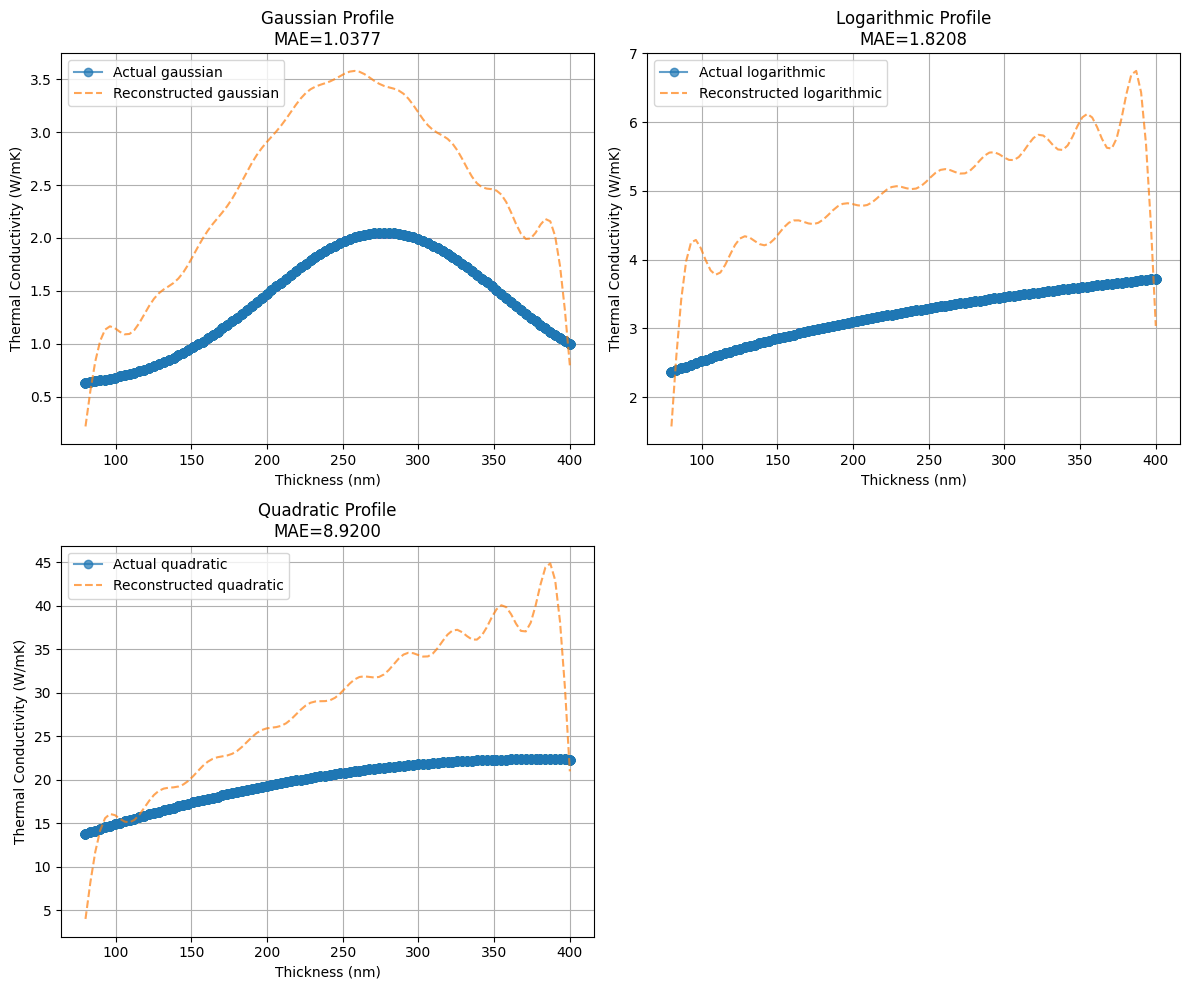

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=20):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=20):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions
# =============================

class FourierNN(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=42):
        super().__init__()
        self.network = nn.Sequential(
        # Input layer
        nn.Linear(3, 32),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(32),
        
        # First hidden layer
        nn.Linear(32, 64),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(64),
        nn.Dropout(0.1),
        
        # Second hidden layer
        nn.Linear(64, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),
        nn.Dropout(0.15),

        # Second hidden layer
        nn.Linear(128, 256),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(256),
        nn.Dropout(0.15),
        
        # Third hidden layer
        nn.Linear(256, 512),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(512),
        nn.Dropout(0.2),
        
        # Third hidden layer
        nn.Linear(512, 256),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(256),
        nn.Dropout(0.1),

        # Third hidden layer
        nn.Linear(256, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),

        # Output layer
        nn.Linear(128, 42)
    )
        self.name = "ReLU_Standard"

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=20):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Parameters
    N = 20  # Fourier series terms

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_model_N20_Complex.pth')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_model_N20_Complex.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve_N20_Complex.png', dpi=300)
    plt.close()

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:models
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profileX_train.shape
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/thermal_conductivity_profiles_N20_Complex.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'visualizations/thermal_conductivity_profiles_N20_Complex.png'")

if __name__ == "__main__":
    main()


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/tmp/ipykernel_54483/1115868903.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from models/best_model_N20_Complex.pth


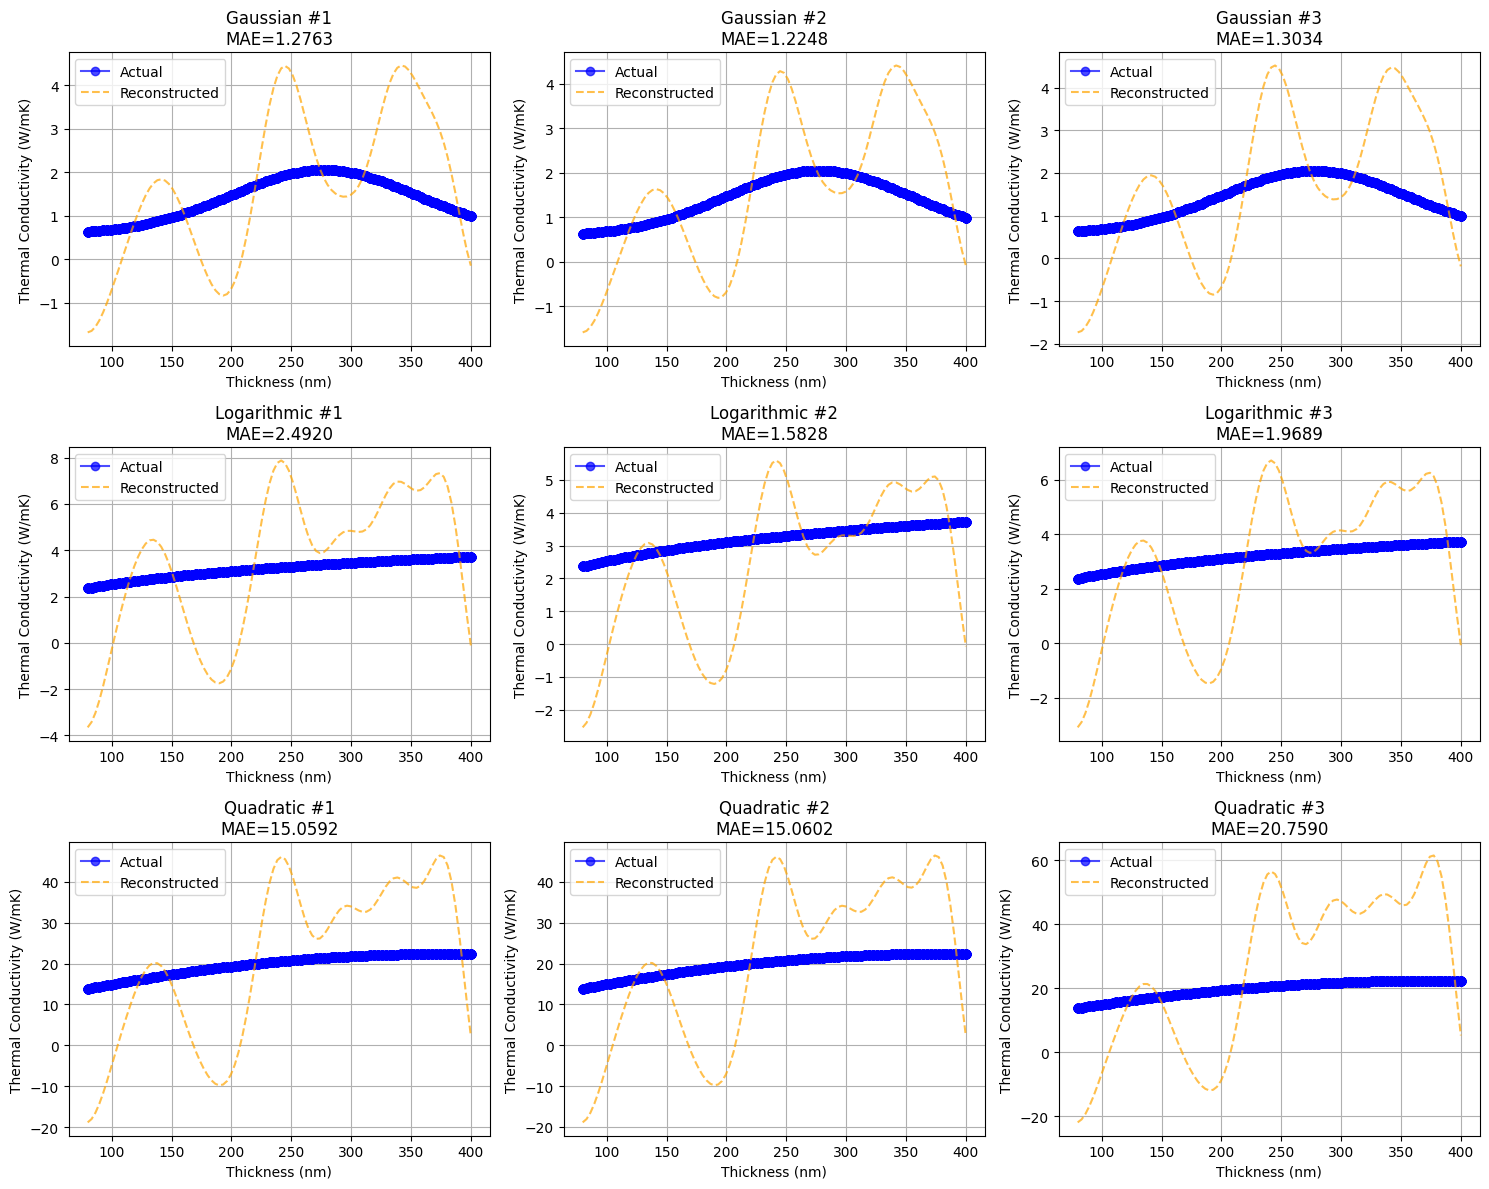


MAE Summary:
Gaussian: Mean MAE = 1.2682, Min = 1.2248, Max = 1.3034
Logarithmic: Mean MAE = 2.0146, Min = 1.5828, Max = 2.4920
Quadratic: Mean MAE = 16.9595, Min = 15.0592, Max = 20.7590


{'gaussian': [1.2762908339214398, 1.224815872433873, 1.3034278164974846],
 'logarithmic': [2.492013932832014, 1.5828130465561987, 1.9689156311282723],
 'quadratic': [15.059246378176407, 15.060153907381528, 20.759045945655156]}

In [3]:
# Load the saved model and visualize multiple predictions
def visualize_saved_model(model_path='models/best_model_N20_Complex.pth', samples_per_type=5):
    # Load data files
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=20)
    
    # Data Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Load model
    model = FourierNN(input_dim=3, output_dim=42)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
            
            # Calculate MAE
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N20_complex.png', dpi=300)
    plt.show()
    
    # Print summary of MAE values
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    return mae_values

# Call the function to visualize multiple examples
visualize_saved_model(model_path='models/best_model_N20_Complex.pth', samples_per_type=3)


Starting improved thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting model training...
Epoch 1/100: Train Loss = 0.797945, Val Loss = 0.790459
Saved best model (Val Loss: 0.790459)
Epoch 2/100: Train Loss = 0.792968, Val Loss = 0.789568
Saved best model (Val Loss: 0.789568)
Epoch 3/100: Train Loss = 0.792329, Val Loss = 0.789114
Saved best model (Val Loss: 0.789114)
Epoch 4/100: Train Loss = 0.792074, Val Loss = 0.789210
Epoch 5/100: Train Loss = 0.791890, Val Loss = 0.788837
Saved best model (Val Loss: 0.788837)
Epoch 6/100: Train Loss = 0.791721, Val Loss = 0.788690
Saved best model (Val Loss: 0.788690)
Epoch 7/100: Train Loss = 0.791588, Val Loss = 0.788530
Saved best model (Val Loss: 0.788530)
Epoch 8/100: Train Loss = 0.791483, Val Loss = 0.789474
Epoch 9/100: Train Loss = 0.791352, Val Loss = 0.788409
Saved best model (Val Loss: 0.788409)
Epoch 10/100: Train Loss = 0.791306, Val Loss = 0.788175
Saved best model (Val Loss: 0.788175)
Epoch 11/100: Train Loss = 0.791246, Val Loss = 0.788276
Epoch 12/100: Train Loss = 0.791166, Val Loss = 0.7

/tmp/ipykernel_7043/3985952424.py:383: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_filename}'))


Evaluating model and generating visualizations...

MAE Summary:
Gaussian: Mean MAE = 3.6559, Min = 3.6423, Max = 3.6666
Logarithmic: Mean MAE = 3.8332, Min = 3.7626, Max = 3.9099
Quadratic: Mean MAE = 8.2434, Min = 8.0903, Max = 8.3224

MAPE Summary (%):
Gaussian: Mean MAPE = 247.29%, Min = 246.87%, Max = 247.90%
Logarithmic: Mean MAPE = 117.62%, Min = 115.16%, Max = 120.29%
Quadratic: Mean MAPE = 45.49%, Min = 45.02%, Max = 45.74%
Analysis completed in 5195.74 seconds
Model saved as: models/20250415_N15.pth
Visualizations saved to 'visualizations/profiles_20250415_N15.png'


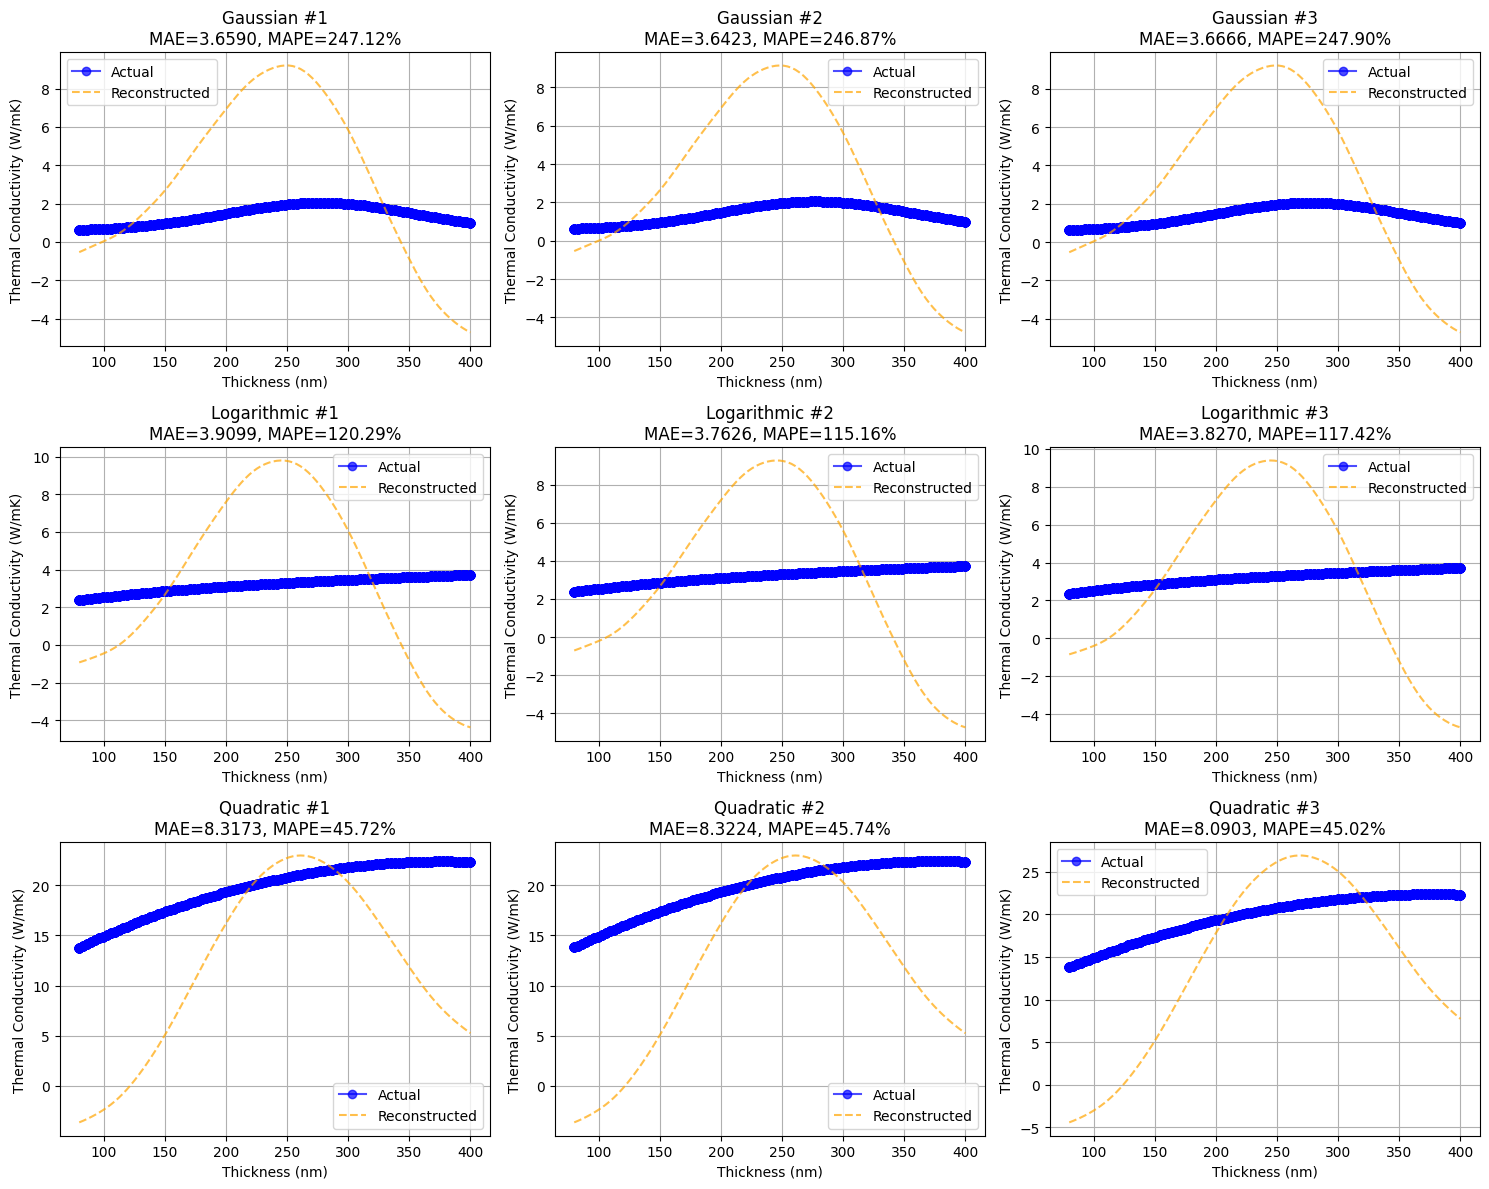

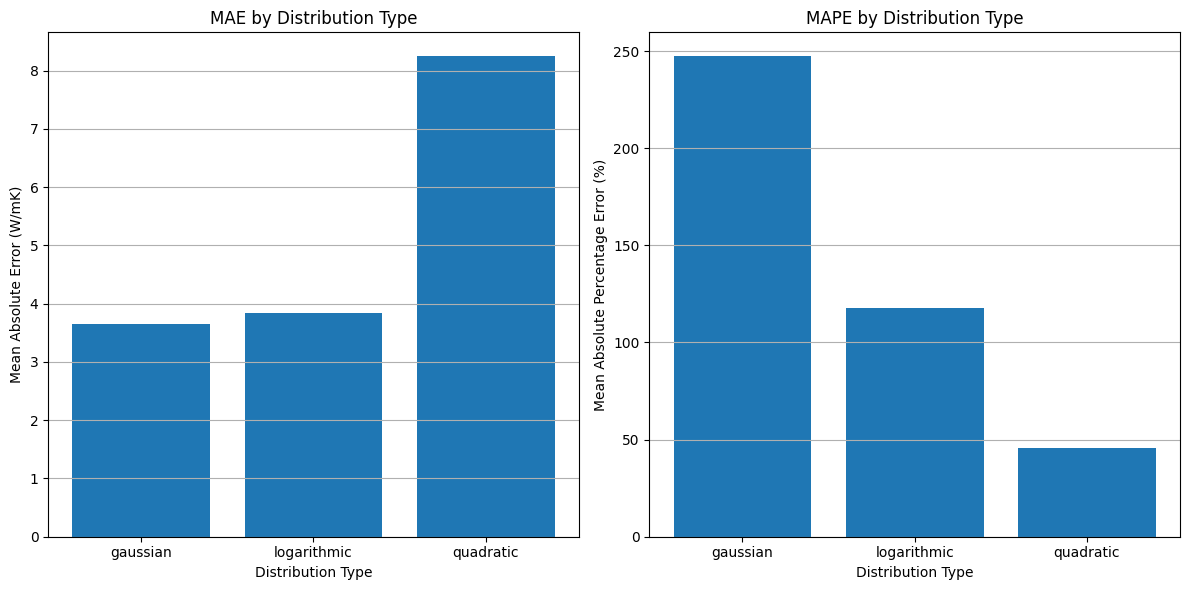

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os
from datetime import datetime

# =============================
# 1. Fourier Series Processing with Windowing and Sampling Rate Improvements
# =============================

def fourier_series_coefficients(y_values, x_values, N=15, window_type='hann'):
    """Convert a distribution into Fourier series coefficients with windowing to reduce Gibbs phenomenon."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")
    
    # Apply windowing function to reduce oscillations
    if window_type == 'hann':
        window = 0.5 * (1 - np.cos(2 * np.pi * np.arange(len(y_values)) / (len(y_values) - 1)))
    elif window_type == 'hamming':
        window = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(len(y_values)) / (len(y_values) - 1))
    else:
        window = np.ones_like(y_values)  # No windowing
    
    # Apply window to y_values
    y_windowed = y_values * window
    
    a0 = np.mean(y_windowed)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_windowed * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_windowed * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile with Lanczos sigma approximation to reduce oscillations."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]
    
    # Initialize with a0/2
    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)
    
    # Apply Lanczos sigma approximation to reduce Gibbs phenomenon
    for n in range(1, N+1):
        # Lanczos sigma factor
        sigma = np.sin(np.pi * n / N) / (np.pi * n / N) if n < N else 1.0
        
        reconstructed_profile += sigma * (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )
    
    return reconstructed_profile

# =============================
# 2. Data Processing with Feature Engineering
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients with distribution-specific handling."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}
        
        # Use appropriate window type based on distribution type
        window_type = 'hann' if eq_type in ['quadratic', 'logarithmic'] else None

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation with window
            coeffs = fourier_series_coefficients(y_values, x_values, N=N, window_type=window_type)

            # Create a row for each x value with enhanced features
            for i in range(len(x_values)):
                # Enhanced features including normalized position and polynomial terms
                x_norm = (x_values[i] - x_values[0]) / (x_values[-1] - x_values[0]) if (x_values[-1] - x_values[0]) != 0 else 0
                x_squared = (x_values[i]/100)**2  # Scaled to avoid large values
                x_cubed = (x_values[i]/100)**3  # Scaled to avoid large values
                
                features_list.append([
                    x_values[i],  # Original thickness
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i],
                    x_norm,  # Normalized position in [0,1]
                    x_squared,  # Quadratic term
                    x_cubed  # Cubic term
                ])
                
                # Target includes Fourier coefficients and actual thermal conductivity
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, 
                              columns=['x', 'ModelRatio', 'TimeDelay', 'x_norm', 'x_squared', 'x_cubed'])
    
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Improved Neural Network with Residual Connections
# =============================

class EnhancedFourierNN(nn.Module):
    """Enhanced neural network with residual connections and advanced architecture"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        
        # First block with input layer
        self.input_block = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.SiLU(),  # SiLU (Swish) activation function
            nn.BatchNorm1d(128),
            nn.Dropout(0.1)
        )
        
        # Residual block 1
        self.res_block1 = nn.Sequential(
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1)
        )
        
        # Middle layer
        self.middle = nn.Sequential(
            nn.Linear(128, 256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        
        # Residual block 2
        self.res_block2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        
        # Output layers
        self.output_block = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        # Input block
        x1 = self.input_block(x)
        
        # Residual block 1
        res1 = self.res_block1(x1)
        x2 = x1 + res1  # Residual connection
        
        # Middle layer
        x3 = self.middle(x2)
        
        # Residual block 2
        res2 = self.res_block2(x3)
        x4 = x3 + res2  # Residual connection
        
        # Output block
        out = self.output_block(x4)
        
        return out

# =============================
# 5. Custom Loss Function
# =============================

class FourierSmoothingLoss(nn.Module):
    """Custom loss function that penalizes high-frequency oscillations"""
    def __init__(self, smoothness_weight=0.1, boundary_weight=0.2, N=15):
        super().__init__()
        self.mse = nn.MSELoss()
        self.smoothness_weight = smoothness_weight
        self.boundary_weight = boundary_weight
        self.N = N
        
    def forward(self, pred, target):
        # Standard MSE loss
        base_loss = self.mse(pred, target)
        
        # Smoothness penalty on high-frequency Fourier coefficients
        fourier_coeffs = pred[:, 1:2*self.N+1]  # All Fourier coefficients (excluding a0)
        
        # Create weights that increase with frequency
        freq_weights = torch.arange(1, 2*self.N+1, device=fourier_coeffs.device).float()
        freq_weights = freq_weights ** 1.5  # Higher power for more aggressive penalization
        
        smoothness_loss = torch.mean(freq_weights * fourier_coeffs.pow(2))
        
        # Combined loss with weighted smoothing term
        total_loss = base_loss + self.smoothness_weight * smoothness_loss
        
        return total_loss

# =============================
# 6. Training and Evaluation Function
# =============================

def train_and_evaluate():
    start_time = time.time()
    print("Starting improved thermal conductivity profile analysis...")
    
    # Get current date for model naming
    current_date = datetime.now().strftime("%Y%m%d")
    N = 15  # Fourier series terms
    
    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)
    
    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data with enhanced features
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)
    
    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets with stratification
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128)

    # Initialize enhanced model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = EnhancedFourierNN(input_dim=input_dim, output_dim=output_dim)
    
    # Training parameters with custom loss
    criterion = FourierSmoothingLoss(smoothness_weight=0.15, boundary_weight=0.2, N=N)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 100
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            total_loss += loss_batch.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
        
        # Learning rate scheduler step
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save model
            model_filename = f"{current_date}_N{N}.pth"
            torch.save(model.state_dict(), f'models/{model_filename}')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model
    model_filename = f"{current_date}_N{N}.pth"
    model.load_state_dict(torch.load(f'models/{model_filename}'))
    
    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (N={N})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'visualizations/loss_curve_{current_date}_N{N}.png', dpi=300)
    plt.close()
    
    # Evaluation and Visualization with MAPE calculation
    print("Evaluating model and generating visualizations...")
    model.eval()
    
    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), 3, figsize=(15, 12))
    
    # Store error metrics
    mae_values = {eq_type: [] for eq_type in eq_types}
    mape_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select up to 3 samples
        selected_indices = eq_indices[:3]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile with Lanczos sigma approximation
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
            
            # Calculate error metrics
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Calculate MAPE (Mean Absolute Percentage Error)
            epsilon = 1e-10  # Small value to avoid division by zero
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values[eq_type].append(mape)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label='Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label='Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/profiles_{current_date}_N{N}.png', dpi=300)
    
    # Print summary of error metrics
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    print("\nMAPE Summary (%):")
    for eq_type, mapes in mape_values.items():
        print(f"{eq_type.capitalize()}: Mean MAPE = {np.mean(mapes):.2f}%, Min = {np.min(mapes):.2f}%, Max = {np.max(mapes):.2f}%")
    
    # Create comparison plot for error metrics
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(eq_types, [np.mean(mae_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Error (W/mK)')
    plt.title('MAE by Distribution Type')
    plt.grid(axis='y')
    
    plt.subplot(1, 2, 2)
    plt.bar(eq_types, [np.mean(mape_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.title('MAPE by Distribution Type')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/error_metrics_{current_date}_N{N}.png', dpi=300)
    
    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print(f"Model saved as: models/{model_filename}")
    print(f"Visualizations saved to 'visualizations/profiles_{current_date}_N{N}.png'")

# Run the complete analysis
if __name__ == "__main__":
    train_and_evaluate()


Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples
Starting model training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.085838, Val Loss = 0.073895
Saved best model (Val Loss: 0.073895)
Epoch 2/50: Train Loss = 0.077236, Val Loss = 0.076169
Epoch 3/50: Train Loss = 0.076194, Val Loss = 0.047785
Saved best model (Val Loss: 0.047785)
Epoch 4/50: Train Loss = 0.075875, Val Loss = 0.082348
Epoch 5/50: Train Loss = 0.075386, Val Loss = 0.061225
Epoch 6/50: Train Loss = 0.075023, Val Loss = 0.060744
Epoch 7/50: Train Loss = 0.074844, Val Loss = 0.056010
Epoch 8/50: Train Loss = 0.074308, Val Loss = 0.068941
Epoch 9/50: Train Loss = 0.074018, Val Loss = 0.064627
Epoch 10/50: Train Loss = 0.073116, Val Loss = 0.062841
Epoch 11/50: Train Loss = 0.072429, Val Loss = 0.058255
Epoch 12/50: Train Loss = 0.072114, Val Loss = 0.061952
Epoch 13/50: Train Loss = 0.072007, Val Loss = 0.054661
Early stopping triggered at epoch 13


/tmp/ipykernel_10044/286874640.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_n15_Apr.pth'))


Evaluating model and generating visualizations...
Analysis completed in 1430.73 seconds
Visualizations saved to 'visualizations/thermal_conductivity_profiles_N15_15Apr.png'

MAE Summary:
Gaussian: Mean MAE = 1.6152, Min = 1.5236, Max = 1.6686
Logarithmic: Mean MAE = 1.8269, Min = 1.0741, Max = 2.5896
Quadratic: Mean MAE = 9.9299, Min = 7.8401, Max = 13.9805

MAPE Summary (%):
Gaussian: Mean MAPE = 118.57%, Min = 110.61%, Max = 123.04%
Logarithmic: Mean MAPE = 56.70%, Min = 33.22%, Max = 80.58%
Quadratic: Mean MAPE = 47.19%, Min = 37.38%, Max = 66.19%


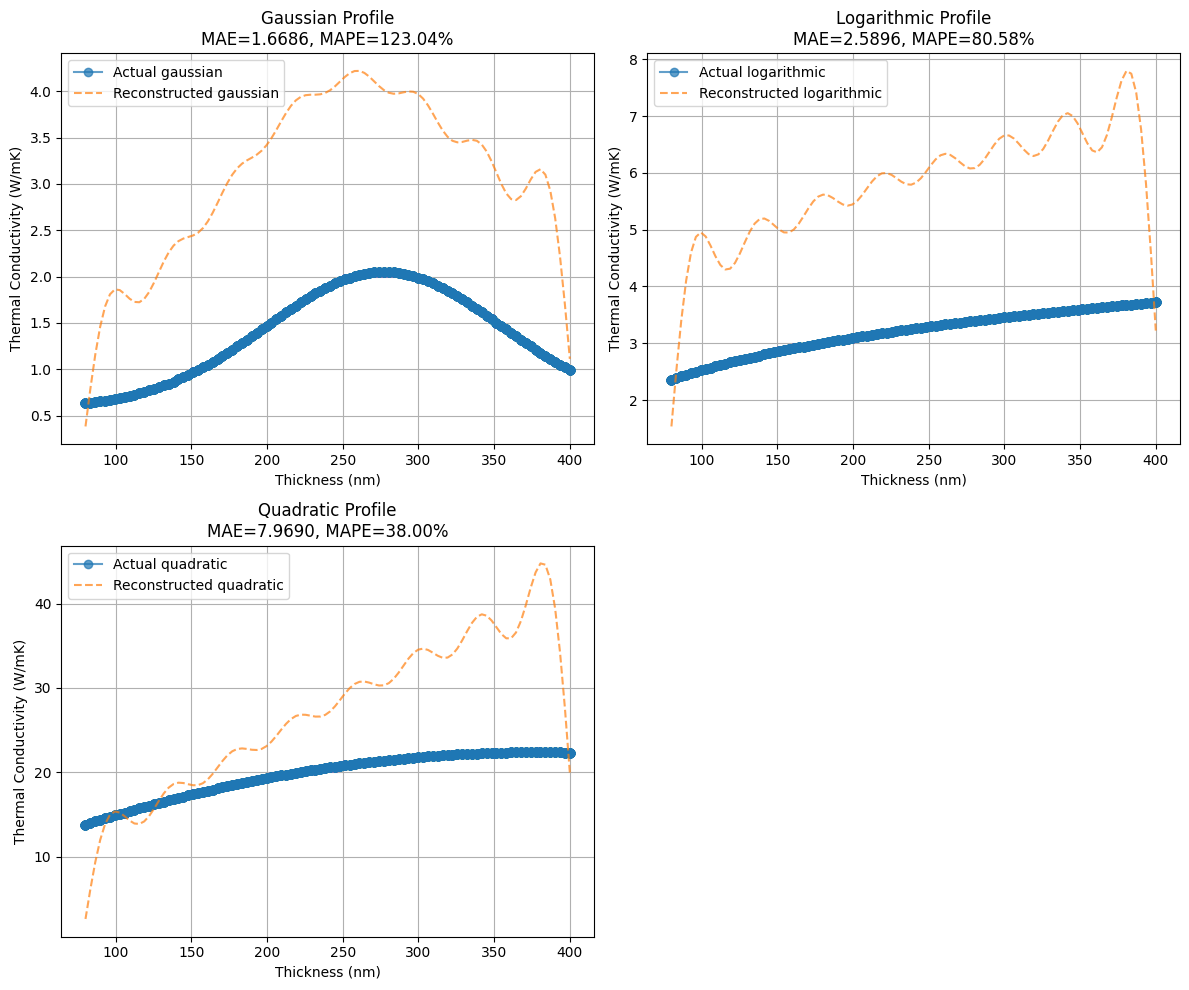

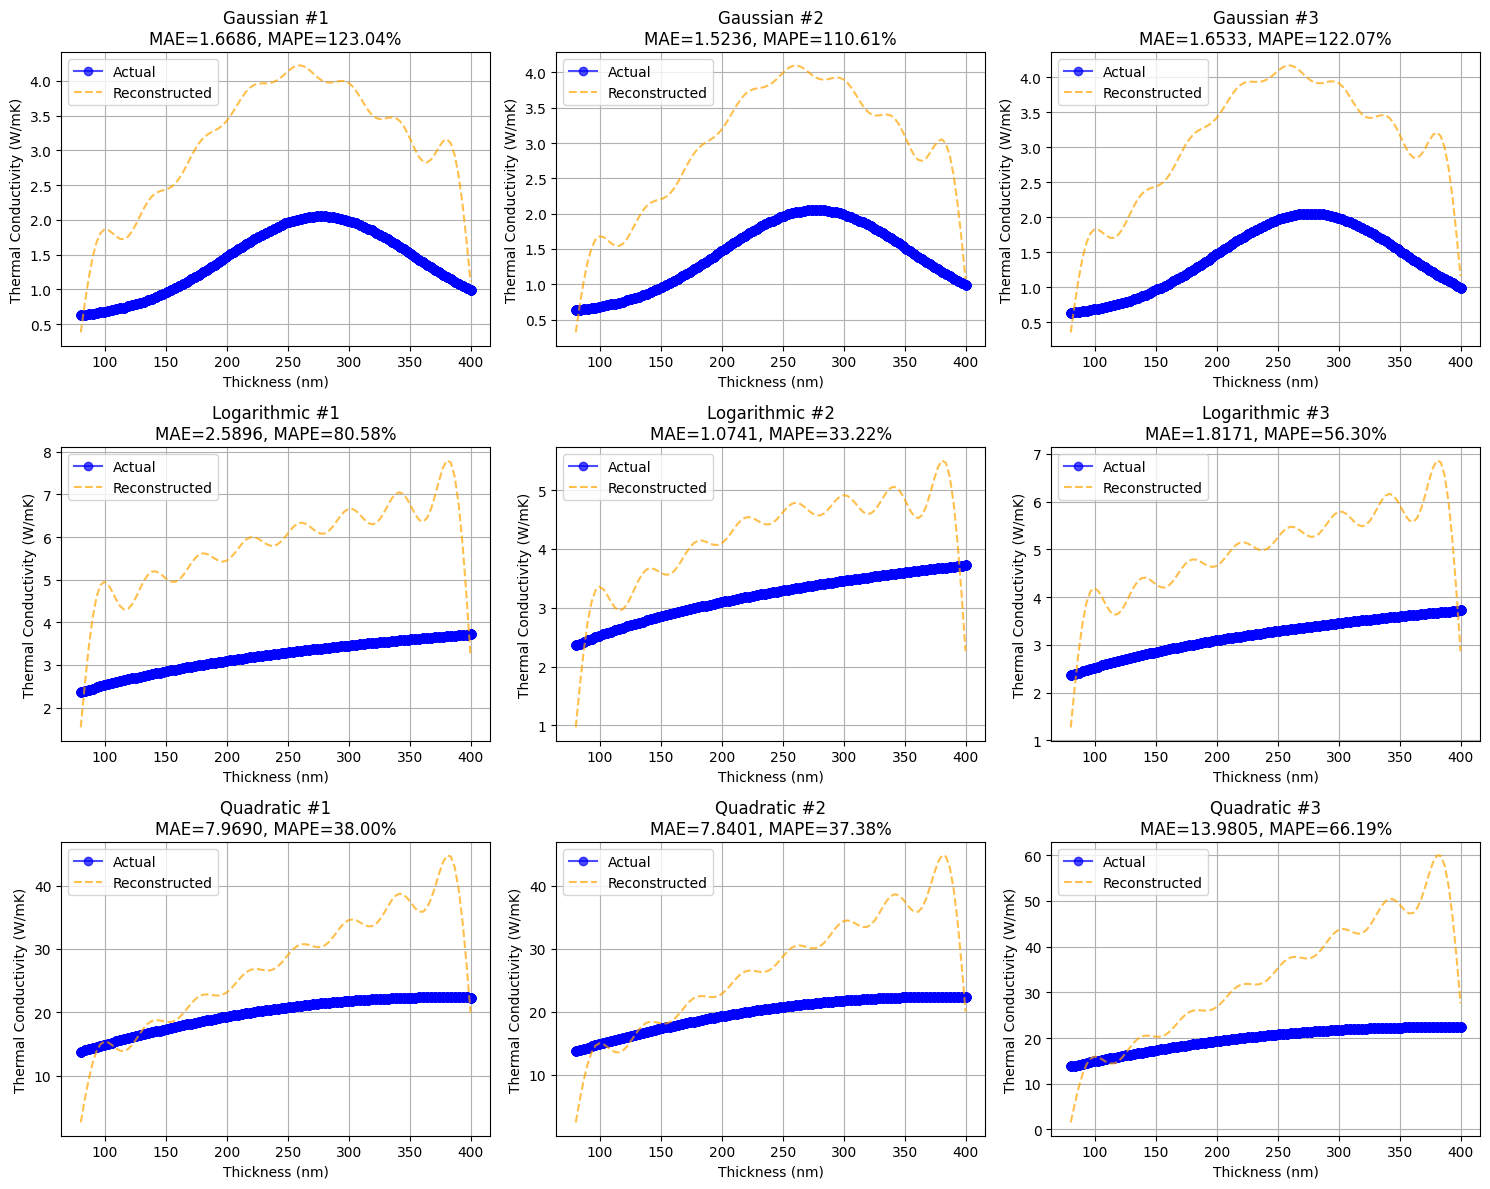

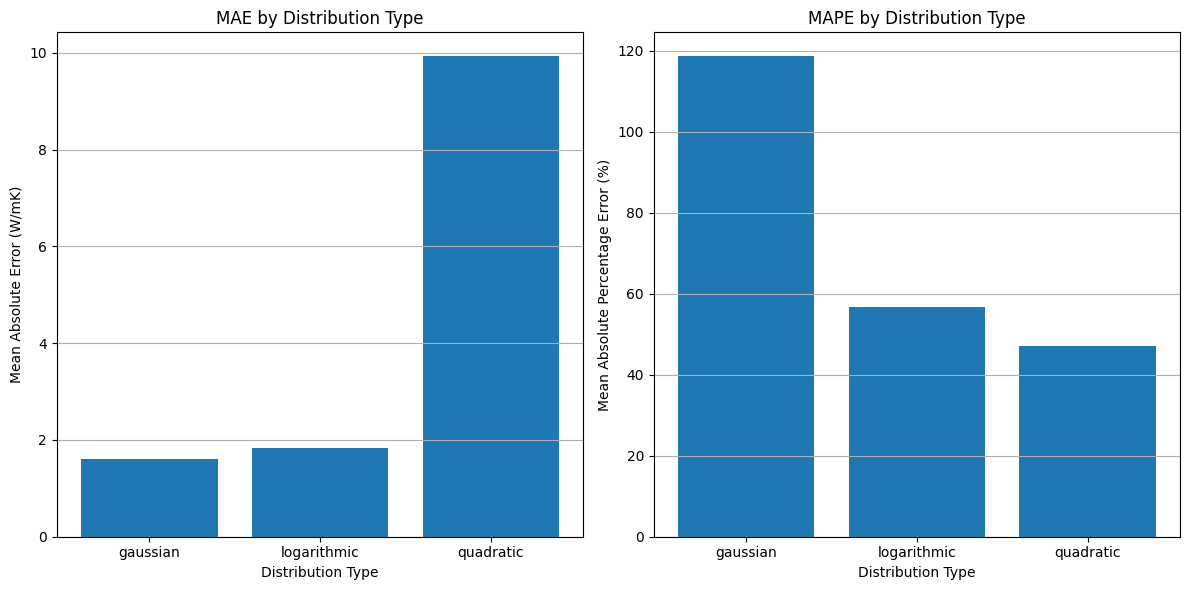

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions
# =============================

class FourierNN(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            # Input layer
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            
            # First hidden layer
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            
            # Second hidden layer
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15),
            
            # Third hidden layer
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            
            # Output layer
            nn.Linear(128, output_dim)
        )
        self.name = "ReLU_Standard"
    
    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Parameters
    N = 15  # Fourier series terms

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_model_n15_Apr.pth')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_model_n15_Apr.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve.png', dpi=300)
    plt.close()

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
            
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Calculate MAPE
        epsilon = 1e-10  # Small value to avoid division by zero
        mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}, MAPE={mape:.2f}%')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/thermal_conductivity_profiles_N15_15Apr.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'visualizations/thermal_conductivity_profiles_N15_15Apr.png'")

    # Create visualization showing multiple examples per distribution type
    visualize_multiple_examples(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, N=15)

if __name__ == "__main__":
    main()

# =============================
# 7. Multiple Examples Visualization
# =============================

def visualize_multiple_examples(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, N=15, samples_per_type=3):
    """
    Visualize multiple examples for each distribution type
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        target_scaler: Scaler for inverse transforming predictions
        reference_profiles: Dictionary of reference profiles
        eq_test: List of equation types for test samples
        X_test: Test features
        N: Number of Fourier terms
        samples_per_type: Number of examples to visualize per distribution type
    """
    model.eval()
    eq_types = list(reference_profiles.keys())
    
    # Create a figure with subplots for each distribution type
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    mape_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
            
            # Calculate error metrics
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Calculate MAPE
            epsilon = 1e-10  # Small value to avoid division by zero
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values[eq_type].append(mape)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N{N}.png', dpi=300)
    
    # Print summary of error metrics
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    print("\nMAPE Summary (%):")
    for eq_type, mapes in mape_values.items():
        print(f"{eq_type.capitalize()}: Mean MAPE = {np.mean(mapes):.2f}%, Min = {np.min(mapes):.2f}%, Max = {np.max(mapes):.2f}%")
    
    # Create comparative visualization for error metrics
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(eq_types, [np.mean(mae_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Error (W/mK)')
    plt.title('MAE by Distribution Type')
    plt.grid(axis='y')
    
    plt.subplot(1, 2, 2)
    plt.bar(eq_types, [np.mean(mape_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.title('MAPE by Distribution Type')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/error_metrics_N{N}.png', dpi=300)
    plt.show()
    
    return mae_values, mape_values


In [3]:

def visualize_multiple_examples(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, N=15, samples_per_type=3):
    """
    Visualize multiple examples for each distribution type
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        target_scaler: Scaler for inverse transforming predictions
        reference_profiles: Dictionary of reference profiles
        eq_test: List of equation types for test samples
        X_test: Test features
        N: Number of Fourier terms
        samples_per_type: Number of examples to visualize per distribution type
    """
    model.eval()
    eq_types = list(reference_profiles.keys())
    
    # Create a figure with subplots for each distribution type
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    mape_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
            
            # Calculate error metrics
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Calculate MAPE
            epsilon = 1e-10  # Small value to avoid division by zero
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values[eq_type].append(mape)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N{N}.png', dpi=300)
    
    # Print summary of error metrics
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    print("\nMAPE Summary (%):")
    for eq_type, mapes in mape_values.items():
        print(f"{eq_type.capitalize()}: Mean MAPE = {np.mean(mapes):.2f}%, Min = {np.min(mapes):.2f}%, Max = {np.max(mapes):.2f}%")
    
    # Create comparative visualization for error metrics
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(eq_types, [np.mean(mae_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Error (W/mK)')
    plt.title('MAE by Distribution Type')
    plt.grid(axis='y')
    
    plt.subplot(1, 2, 2)
    plt.bar(eq_types, [np.mean(mape_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.title('MAPE by Distribution Type')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/error_metrics_N{N}.png', dpi=300)
    plt.show()
    
    return mae_values, mape_values


Starting thermal conductivity profile analysis with N=15...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples
Starting model training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.013918, Val Loss = 0.008461
Saved best model (Val Loss: 0.008461)
Epoch 2/50: Train Loss = 0.010044, Val Loss = 0.008587
Epoch 3/50: Train Loss = 0.009547, Val Loss = 0.008046
Saved best model (Val Loss: 0.008046)
Epoch 4/50: Train Loss = 0.009438, Val Loss = 0.007672
Saved best model (Val Loss: 0.007672)
Epoch 5/50: Train Loss = 0.009317, Val Loss = 0.007441
Saved best model (Val Loss: 0.007441)
Epoch 6/50: Train Loss = 0.009263, Val Loss = 0.009322
Epoch 7/50: Train Loss = 0.009221, Val Loss = 0.007385
Saved best model (Val Loss: 0.007385)
Epoch 8/50: Train Loss = 0.009183, Val Loss = 0.007820
Epoch 9/50: Train Loss = 0.009164, Val Loss = 0.008922
Epoch 10/50: Train Loss = 0.009145, Val Loss = 0.007266
Saved best model (Val Loss: 0.007266)
Epoch 11/50: Train Loss = 0.009121, Val Loss = 0.007895
Epoch 12/50: Train Loss = 0.009091, Val Loss = 0.007245
Saved best model (Val Loss: 0.007245)
Epoch 13/50: Train Loss = 0.009080, Val Loss = 0.007718
Epoch 14/50: Tr

/tmp/ipykernel_10044/3218217849.py:326: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/simple_model_N{N}.pth'))



Gaussian Summary:
Mean MAE = 0.8947, Min = 0.5832, Max = 1.1934
Mean MAPE = 57.42%, Min = 33.13%, Max = 80.45%

Logarithmic Summary:
Mean MAE = 1.9700, Min = 1.7639, Max = 2.2086
Mean MAPE = 71.08%, Min = 63.66%, Max = 79.64%

Quadratic Summary:
Mean MAE = 10.1754, Min = 8.3924, Max = 13.6846
Mean MAPE = 33.59%, Min = 28.79%, Max = 43.02%

Overall Summary:
Gaussian: Mean MAE = 0.9662, Mean MAPE = 63.30%
Logarithmic: Mean MAE = 1.5702, Mean MAPE = 56.57%
Quadratic: Mean MAE = 7.7506, Mean MAPE = 25.61%
Analysis completed in 933.72 seconds


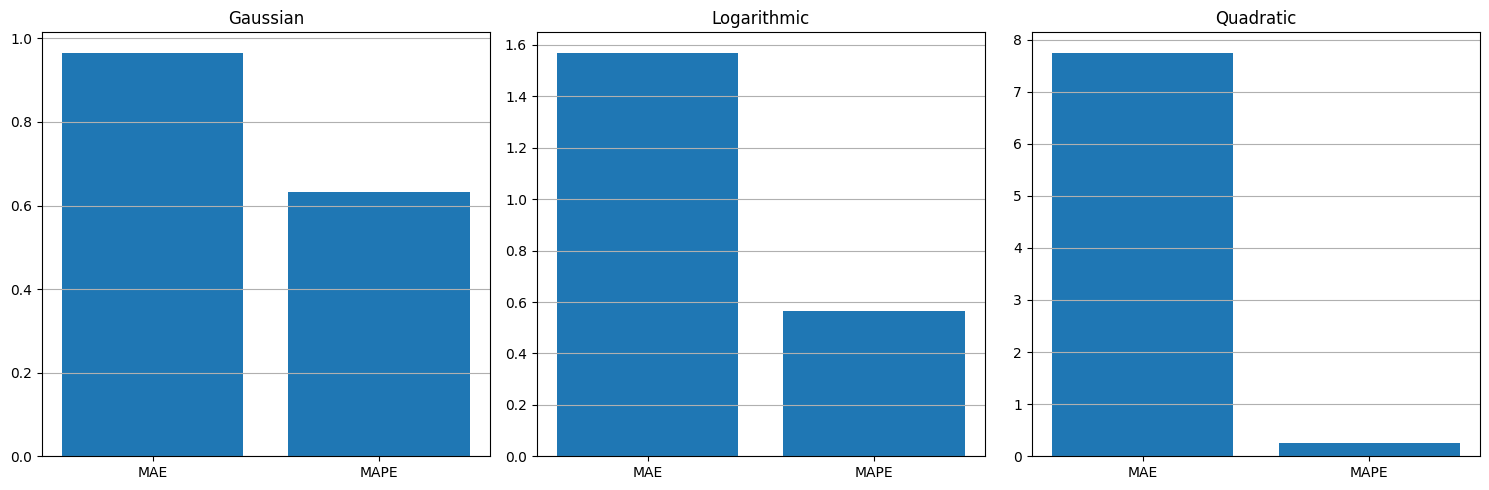

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing with Distribution-Specific Parameters
# =============================

def fourier_series_coefficients(y_values, x_values, N=15, distribution_type=None):
    """
    Convert a distribution into Fourier series coefficients with distribution-specific handling.
    
    Args:
        y_values: Thermal conductivity values
        x_values: Thickness values
        N: Number of Fourier terms
        distribution_type: Type of distribution ('gaussian', 'logarithmic', 'quadratic')
    
    Returns:
        coeffs: List of Fourier coefficients [a0, a1, ..., an, b1, ..., bn]
    """
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")
    
    # Handle different distribution types differently
    if distribution_type == 'quadratic':
        # For quadratic, normalize y values to reduce high absolute values
        y_max = np.max(y_values)
        y_normalized = y_values / y_max if y_max != 0 else y_values
        a0 = np.mean(y_normalized) * y_max  # Scale back after calculation
        a_coeffs, b_coeffs = [], []
        
        for n in range(1, N+1):
            cos_term = np.cos(n * np.pi * x_values / L)
            sin_term = np.sin(n * np.pi * x_values / L)
            an = (2 / len(x_values)) * np.sum(y_normalized * cos_term) * y_max
            bn = (2 / len(x_values)) * np.sum(y_normalized * sin_term) * y_max
            a_coeffs.append(an)
            b_coeffs.append(bn)
    else:
        # Standard approach for gaussian and logarithmic
        a0 = np.mean(y_values)
        a_coeffs, b_coeffs = [], []
        
        for n in range(1, N+1):
            cos_term = np.cos(n * np.pi * x_values / L)
            sin_term = np.sin(n * np.pi * x_values / L)
            an = (2 / len(x_values)) * np.sum(y_values * cos_term)
            bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
            a_coeffs.append(an)
            b_coeffs.append(bn)
    
    return [a0] + a_coeffs + b_coeffs

def reconstruct_profile(coeffs_predicted, x_values, N=15, distribution_type=None):
    """
    Reconstructs conductivity profile from Fourier coefficients with distribution-specific handling.
    
    Args:
        coeffs_predicted: Predicted Fourier coefficients
        x_values: Thickness values
        N: Number of Fourier terms
        distribution_type: Type of distribution ('gaussian', 'logarithmic', 'quadratic')
    
    Returns:
        reconstructed_profile: Reconstructed thermal conductivity profile
    """
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")
    
    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]
    
    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)
    
    for n in range(1, N+1):
        # Apply coefficient damping for higher frequencies to reduce oscillations
        # More aggressive damping for quadratic profiles which show more oscillations
        if distribution_type == 'quadratic':
            damping = 1.0 / (1.0 + 0.1 * n)
        else:
            damping = 1.0 / (1.0 + 0.05 * n)
            
        reconstructed_profile += damping * (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )
    
    # Ensure non-negative values for thermal conductivity
    reconstructed_profile = np.maximum(reconstructed_profile, 0)
    
    return reconstructed_profile

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients with distribution-specific handling."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        # Process a subset of equations to reduce dataset size and training time
        unique_equations = df['Equation_ID'].unique()
        selected_equations = np.random.choice(unique_equations, size=min(100, len(unique_equations)), replace=False)
        
        for eq_id in selected_equations:
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients with distribution-specific handling
            coeffs = fourier_series_coefficients(y_values, x_values, N=N, distribution_type=eq_type)

            # Create a row for each x value with basic feature engineering
            for i in range(len(x_values)):
                # Calculate normalized position
                norm_pos = (x_values[i] - x_values[0]) / (x_values[-1] - x_values[0]) if x_values[-1] != x_values[0] else 0.5
                
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i],
                    norm_pos  # Add normalized position as a feature
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay', 'NormPos'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Simplified Model Architecture
# =============================

class SimpleFourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        # Simpler architecture with fewer layers and parameters
        self.network = nn.Sequential(
            # Input layer
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            
            # Hidden layer 1
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            
            # Hidden layer 2
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            
            # Output layer
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)

# =============================
# 5. Thermal Conductivity Analysis
# =============================

def analyze_thermal_conductivity(N=15, use_subset=True):
    start_time = time.time()
    print(f"Starting thermal conductivity profile analysis with N={N}...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    # Use MinMaxScaler for targets to preserve relative scaling
    target_scaler = MinMaxScaler(feature_range=(-1, 1))
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets with stratification
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = SimpleFourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add small weight decay
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), f'models/simple_model_N{N}.pth', _use_new_zipfile_serialization=False)
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load(f'models/simple_model_N{N}.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (N={N})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'visualizations/loss_curve_N{N}.png', dpi=300)
    plt.close()

    # Evaluate and visualize by distribution type
    visualize_results_by_type(model, target_scaler, reference_profiles, eq_test, X_test, N)
    
    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")

def visualize_results_by_type(model, target_scaler, reference_profiles, eq_test, X_test, N=15, samples_per_type=3):
    """Visualize results separately for each distribution type."""
    model.eval()
    eq_types = list(reference_profiles.keys())
    
    # Create figures for each distribution type
    for eq_type in eq_types:
        plt.figure(figsize=(15, 6))
        plt.suptitle(f'{eq_type.capitalize()} Distribution Results', fontsize=16)
        
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select up to samples_per_type samples
        selected_indices = eq_indices[:samples_per_type]
        mae_values = []
        mape_values = []
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile with distribution-specific handling
            y_reconstructed = reconstruct_profile(
                prediction_original[:-1], 
                x_values, 
                N=N, 
                distribution_type=eq_type
            )
            
            # Calculate error metrics
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values.append(mae)
            
            # Calculate MAPE
            epsilon = 1e-10  # Small value to avoid division by zero
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values.append(mape)
            
            # Plot
            plt.subplot(1, samples_per_type, j+1)
            plt.plot(x_values, y_actual, 'o-', label='Actual', color='blue', alpha=0.7)
            plt.plot(x_values, y_reconstructed, '--', label='Reconstructed', color='orange', alpha=0.7)
            plt.xlabel('Thickness (nm)')
            plt.ylabel('Thermal Conductivity (W/mK)')
            plt.title(f'Sample #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f'visualizations/{eq_type}_profiles_N{N}.png', dpi=300)
        plt.close()
        
        # Print summary for this distribution type
        print(f"\n{eq_type.capitalize()} Summary:")
        print(f"Mean MAE = {np.mean(mae_values):.4f}, Min = {np.min(mae_values):.4f}, Max = {np.max(mae_values):.4f}")
        print(f"Mean MAPE = {np.mean(mape_values):.2f}%, Min = {np.min(mape_values):.2f}%, Max = {np.max(mape_values):.2f}%")
    
    # Create a summary visualization
    fig, axes = plt.subplots(1, len(eq_types), figsize=(15, 5))
    all_mae = {eq_type: [] for eq_type in eq_types}
    all_mape = {eq_type: [] for eq_type in eq_types}
    
    # Calculate metrics for more samples
    for eq_type in eq_types:
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        selected_indices = eq_indices[:10]  # Use more samples for statistics
        
        for sample_idx in selected_indices:
            sample_features = X_test[sample_idx]
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            y_reconstructed = reconstruct_profile(
                prediction_original[:-1], 
                x_values, 
                N=N, 
                distribution_type=eq_type
            )
            
            mae = mean_absolute_error(y_actual, y_reconstructed)
            all_mae[eq_type].append(mae)
            
            epsilon = 1e-10
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            all_mape[eq_type].append(mape)
    
    # Plot summary
    for i, eq_type in enumerate(eq_types):
        axes[i].bar([0, 1], [np.mean(all_mae[eq_type]), np.mean(all_mape[eq_type]) / 100])
        axes[i].set_title(f'{eq_type.capitalize()}')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['MAE', 'MAPE'])
        axes[i].grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/summary_metrics_N{N}.png', dpi=300)
    
    # Print overall summary
    print("\nOverall Summary:")
    for eq_type in eq_types:
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(all_mae[eq_type]):.4f}, Mean MAPE = {np.mean(all_mape[eq_type]):.2f}%")

# =============================
# 6. Main Execution
# =============================

if __name__ == "__main__":
    analyze_thermal_conductivity(N=15)


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definition
# =============================

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Enhanced Visualization
# =============================

def enhanced_visualization(model, target_scaler, reference_profiles, eq_test, X_test, N=15, samples_per_type=3):
    """Generate enhanced diagnostic visualizations for each distribution type"""
    model.eval()
    eq_types = list(reference_profiles.keys())
    
    for eq_type in eq_types:
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        chosen_indices = eq_indices[:samples_per_type]
        all_x = []
        all_y_actual = []
        all_y_recon = []
        all_mae = []
        all_mape = []
        
        plt.figure(figsize=(6 * samples_per_type, 20))
        
        for j, idx in enumerate(chosen_indices):
            sample_features = X_test[idx]
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
            error = y_actual - y_reconstructed
            
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + 1e-10))) * 100
            
            all_x.append(x_values)
            all_y_actual.append(y_actual)
            all_y_recon.append(y_reconstructed)
            all_mae.append(mae)
            all_mape.append(mape)

            # Profile comparison
            plt.subplot(5, samples_per_type, j + 1)
            plt.plot(x_values, y_actual, 'b-', label='Actual')
            plt.plot(x_values, y_reconstructed, 'r--', label='Reconstructed')
            plt.title(f"{eq_type.capitalize()} #{j+1}\nMAE={mae:.3f}, MAPE={mape:.1f}%")
            plt.xlabel("Thickness (nm)")
            plt.ylabel("Thermal Conductivity (W/mK)")
            plt.legend()
            plt.grid(True)

            # Residual plot
            plt.subplot(5, samples_per_type, samples_per_type*1 + j + 1)
            plt.plot(x_values, error, 'k-')
            plt.title("Residual (Actual - Recon)")
            plt.xlabel("Thickness (nm)")
            plt.ylabel("Residual")
            plt.grid(True)

            # Error histogram
            plt.subplot(5, samples_per_type, samples_per_type*2 + j + 1)
            plt.hist(error, bins=40, alpha=0.7)
            plt.title("Error Histogram")
            plt.xlabel("Residual")
            plt.grid(True)

            # Cumulative error
            plt.subplot(5, samples_per_type, samples_per_type*3 + j + 1)
            sorted_abs_error = np.sort(np.abs(error))
            cumsum = np.cumsum(sorted_abs_error) / np.sum(np.abs(error))
            plt.plot(np.linspace(0, 1, len(cumsum)), cumsum, 'm-')
            plt.title("Cumulative |Error|")
            plt.xlabel("Fraction of Points")
            plt.ylabel("Cumulative Norm. Error")
            plt.grid(True)

        # Overlay plot
        plt.subplot(5, 1, 5)
        for k in range(len(all_x)):
            plt.plot(all_x[k], all_y_actual[k], alpha=0.3, c='blue')
            plt.plot(all_x[k], all_y_recon[k], alpha=0.3, c='orange')
        plt.title(f"{eq_type.capitalize()} Overlay\nMean MAE = {np.mean(all_mae):.3f}, Mean MAPE = {np.mean(all_mape):.1f}%")
        plt.xlabel("Thickness (nm)")
        plt.ylabel("Thermal Conductivity (W/mK)")
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'visualizations/{eq_type}_enhanced_diagnostics.png', dpi=300)
        plt.close()

# =============================
# 7. Main Training Function
# =============================

def train_and_evaluate():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")
    
    # Create directories
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)
    
    # Parameters
    N = 15
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)
    
    # Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Train/test split
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Create dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    # Initialize model
    model = FourierNN(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Training loop
    best_loss = float('inf')
    patience = 10
    train_losses = []
    val_losses = []
    
    for epoch in range(50):
        model.train()
        total_loss = 0
        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(features_batch)
            loss = criterion(outputs, targets_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs = model(features_batch)
                val_loss += criterion(outputs, targets_batch).item()
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/50: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
        
        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'models/best_model.pth')
            print("Saved best model")
        else:
            if epoch - np.argmin(val_losses) > patience:
                print("Early stopping triggered")
                break
    
    # Load best model
    model.load_state_dict(torch.load('models/best_model.pth'))
    
    # Generate enhanced visualizations
    enhanced_visualization(
        model=model,
        target_scaler=target_scaler,
        reference_profiles=reference_profiles,
        eq_test=eq_test,
        X_test=X_test,
        N=N,
        samples_per_type=3
    )
    
    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")

if __name__ == "__main__":
    train_and_evaluate()


Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.048271, Val Loss = 0.039165
Saved best model
Epoch 2/50: Train Loss = 0.040892, Val Loss = 0.039875
Epoch 3/50: Train Loss = 0.039806, Val Loss = 0.037923
Saved best model
Epoch 4/50: Train Loss = 0.039332, Val Loss = 0.037987
Epoch 5/50: Train Loss = 0.039054, Val Loss = 0.040759
Epoch 6/50: Train Loss = 0.038879, Val Loss = 0.036851
Saved best model
Epoch 7/50: Train Loss = 0.038692, Val Loss = 0.039379
Epoch 8/50: Train Loss = 0.038494, Val Loss = 0.039515
Epoch 9/50: Train Loss = 0.038417, Val Loss = 0.039107
Epoch 10/50: Train Loss = 0.038226, Val Loss = 0.035966
Saved best model
Epoch 11/50: Train Loss = 0.038173, Val Loss = 0.036553
Epoch 12/50: Train Loss = 0.037990, Val Loss = 0.037178
Epoch 13/50: Train Loss = 0.037895, Val Loss = 0.038164
Epoch 14/50: Train Loss = 0.037821, Val Loss = 0.036369
Epoch 15/50: Train Loss = 0.037780, Val Loss = 0.037556
Epoch 16/50: Train Loss = 0.037782, Val Loss = 0.036612
Epoch 17/50: Train Loss = 0.037599, Val Loss 

/tmp/ipykernel_6195/2956290833.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model.pth'))


Analysis completed in 1545.65 seconds



Gaussian: Equation ID 3062  |  MAE: 8.01e-01


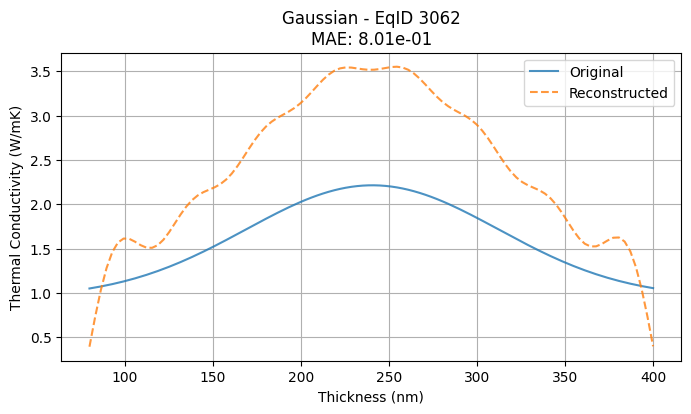


Logarithmic: Equation ID 2016  |  MAE: 1.07e+00


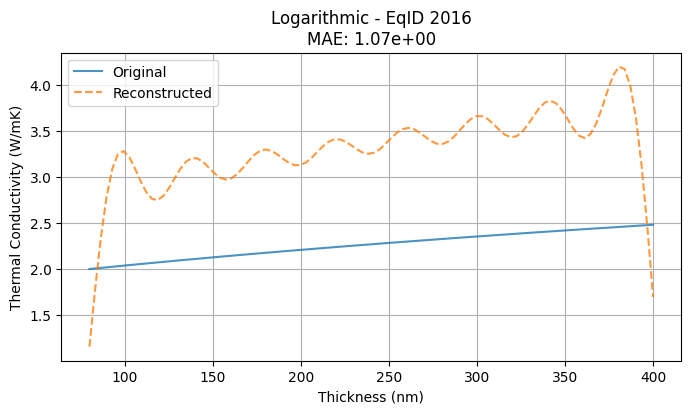


Quadratic: Equation ID 1068  |  MAE: 5.45e+00


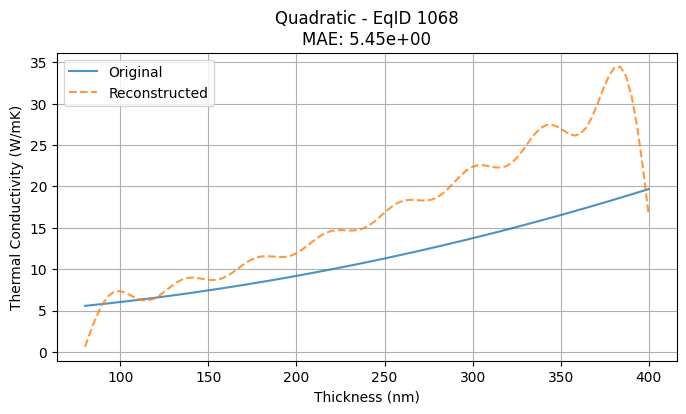

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fourier_series_coefficients(y, x, N=15):
    L = x[-1] - x[0]
    a0 = np.mean(y)
    a_coeffs, b_coeffs = [], []
    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x / L)
        sin_term = np.sin(n * np.pi * x / L)
        an = (2/len(x)) * np.sum(y * cos_term)
        bn = (2/len(x)) * np.sum(y * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)
    return [a0] + a_coeffs + b_coeffs

def reconstruct_profile(coeffs, x, N=15):
    L = x[-1] - x[0]
    a0 = coeffs[0]
    a_coeffs = coeffs[1:N+1]
    b_coeffs = coeffs[N+1:]
    y_recon = np.ones_like(x) * (a0/2)
    for n in range(1, N+1):
        y_recon += a_coeffs[n-1] * np.cos(n * np.pi * x / L)
        y_recon += b_coeffs[n-1] * np.sin(n * np.pi * x / L)
    return y_recon

def check_fourier_exact_reconstruction(csv_file, N=15, distribution_label=None):
    df = pd.read_csv(csv_file)
    eq_ids = df['Equation_ID'].unique()
    eq_id = np.random.choice(eq_ids)
    eq_data = df[df['Equation_ID'] == eq_id]
    # Always sort by x for consistent order
    sort_idx = np.argsort(eq_data['x (Thickness)'].values)
    x = eq_data['x (Thickness)'].values[sort_idx]
    y = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]
    coeffs = fourier_series_coefficients(y, x, N=N)
    y_recon = reconstruct_profile(coeffs, x, N=N)
    mae = np.mean(np.abs(y - y_recon))
    print(f"\n{distribution_label or csv_file}: Equation ID {eq_id}  |  MAE: {mae:.2e}")
    plt.figure(figsize=(8,4))
    plt.plot(x, y, label='Original', alpha=0.8)
    plt.plot(x, y_recon, '--', label='Reconstructed', alpha=0.8)
    plt.title(f'{distribution_label or csv_file} - EqID {eq_id}\nMAE: {mae:.2e}')
    plt.xlabel("Thickness (nm)")
    plt.ylabel("Thermal Conductivity (W/mK)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return mae

if __name__ == "__main__":
    files = {
        "Gaussian": "thermal_conductivity_gaussian_20250207_155153.csv",
        "Logarithmic": "thermal_conductivity_logarithmic_20250207_154245.csv",
        "Quadratic": "thermal_conductivity_quadratic_20250207_153400.csv"
    }
    for label, fname in files.items():
        check_fourier_exact_reconstruction(fname, N=15, distribution_label=label)



🔁 Running Fourier Expansion with N = 15

📂 Processing Gaussian distribution from thermal_conductivity_gaussian_20250207_155153.csv


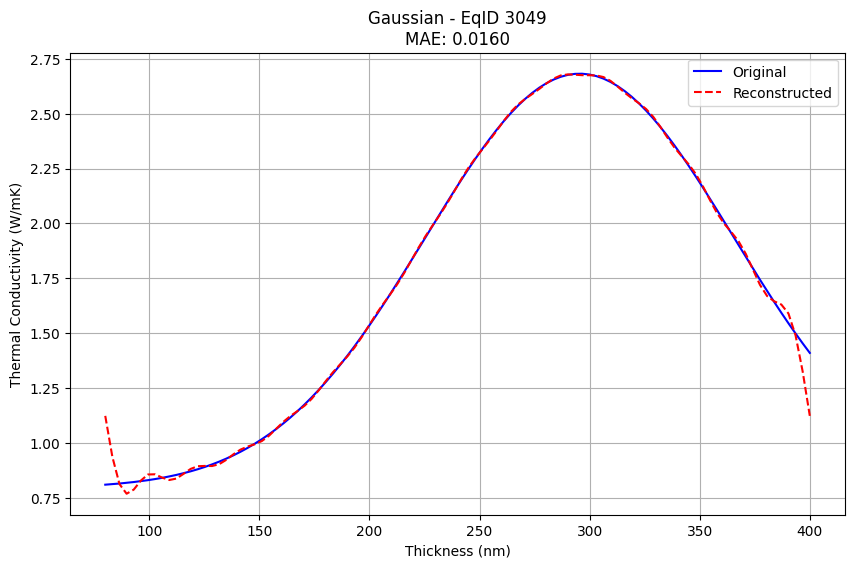

✅ Equation ID: 3049
📉 MAE: 0.015987
📸 Saved plot to Gaussian_reconstruction_N15.png

📂 Processing Logarithmic distribution from thermal_conductivity_logarithmic_20250207_154245.csv


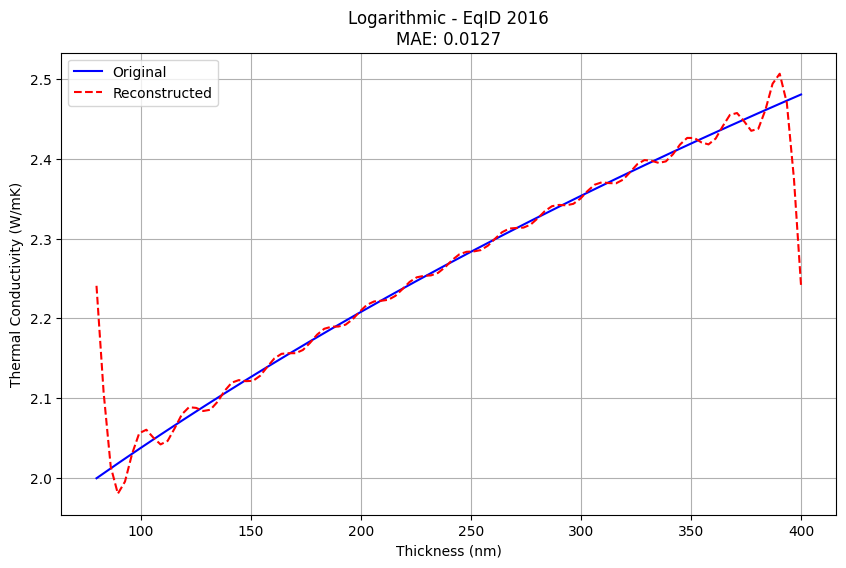

✅ Equation ID: 2016
📉 MAE: 0.012723
📸 Saved plot to Logarithmic_reconstruction_N15.png

📂 Processing Quadratic distribution from thermal_conductivity_quadratic_20250207_153400.csv


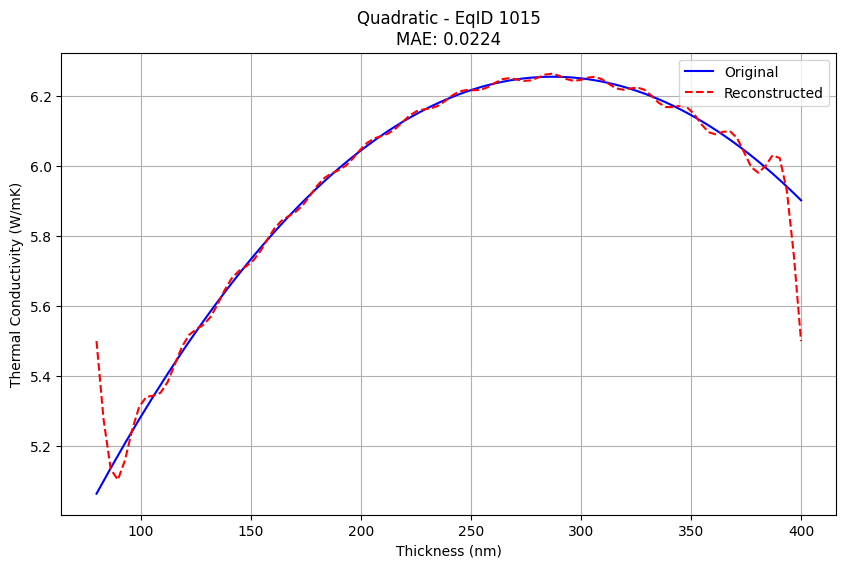

✅ Equation ID: 1015
📉 MAE: 0.022350
📸 Saved plot to Quadratic_reconstruction_N15.png

🔁 Running Fourier Expansion with N = 20

📂 Processing Gaussian distribution from thermal_conductivity_gaussian_20250207_155153.csv


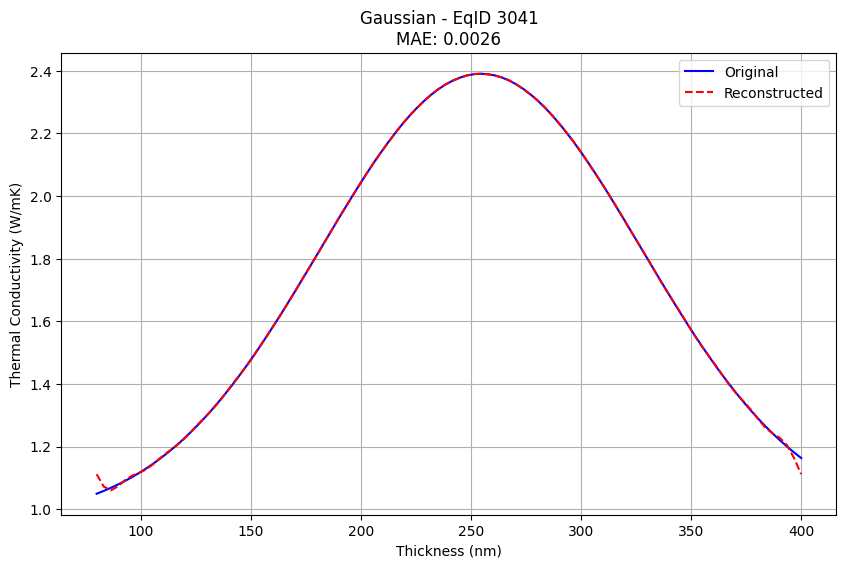

✅ Equation ID: 3041
📉 MAE: 0.002573
📸 Saved plot to Gaussian_reconstruction_N20.png

📂 Processing Logarithmic distribution from thermal_conductivity_logarithmic_20250207_154245.csv


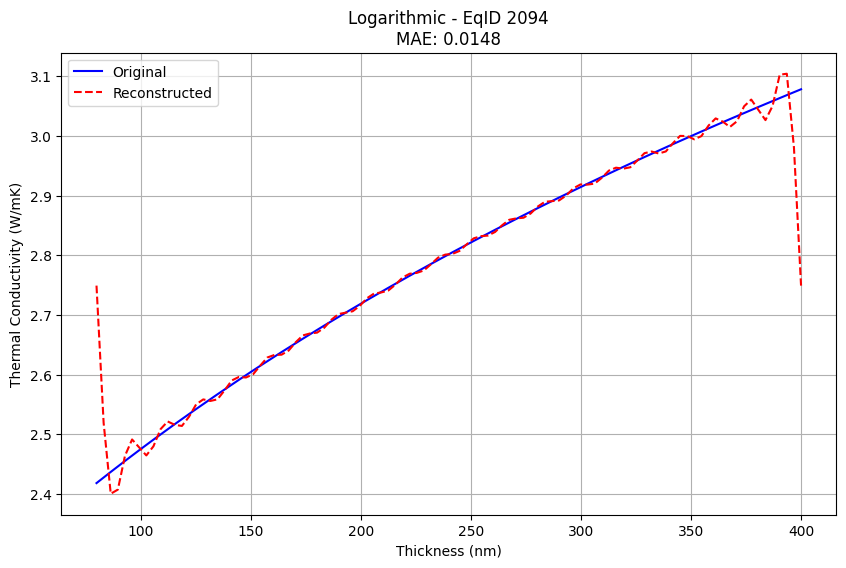

✅ Equation ID: 2094
📉 MAE: 0.014811
📸 Saved plot to Logarithmic_reconstruction_N20.png

📂 Processing Quadratic distribution from thermal_conductivity_quadratic_20250207_153400.csv


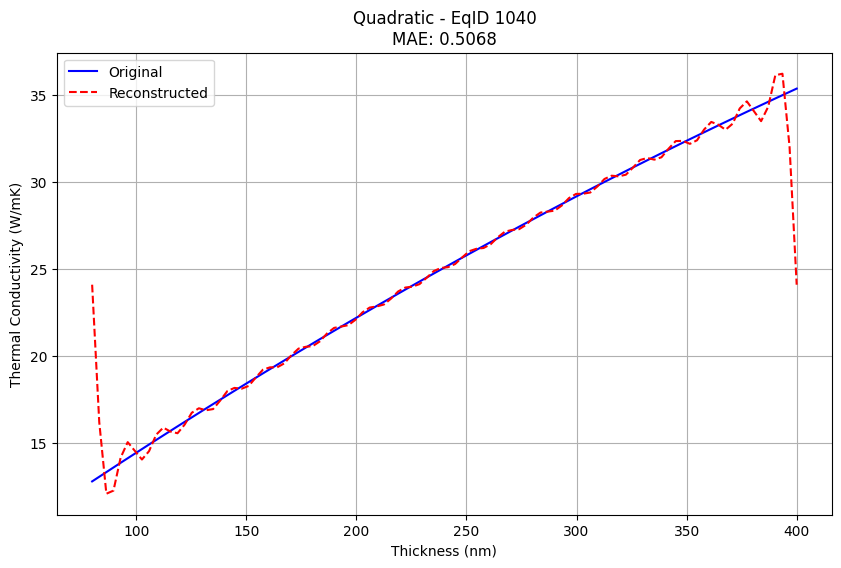

✅ Equation ID: 1040
📉 MAE: 0.506830
📸 Saved plot to Quadratic_reconstruction_N20.png

🔁 Running Fourier Expansion with N = 25

📂 Processing Gaussian distribution from thermal_conductivity_gaussian_20250207_155153.csv


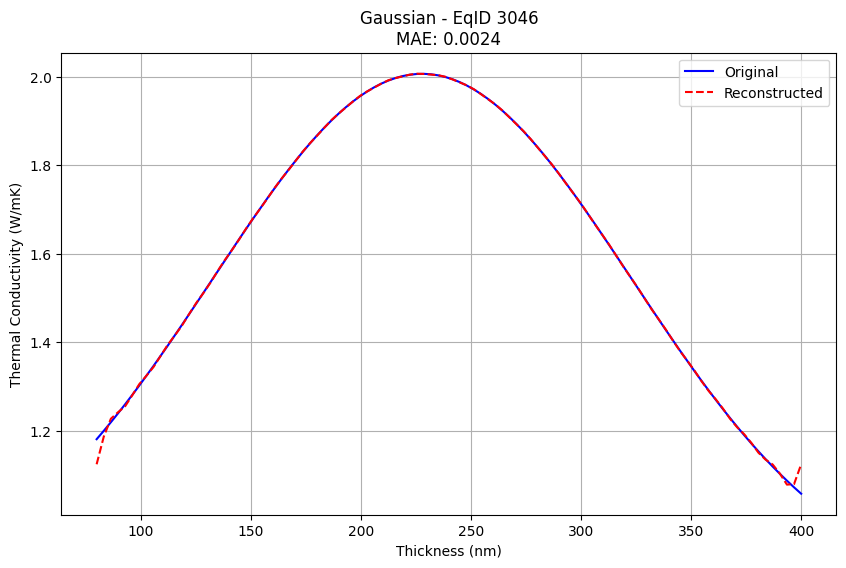

✅ Equation ID: 3046
📉 MAE: 0.002355
📸 Saved plot to Gaussian_reconstruction_N25.png

📂 Processing Logarithmic distribution from thermal_conductivity_logarithmic_20250207_154245.csv


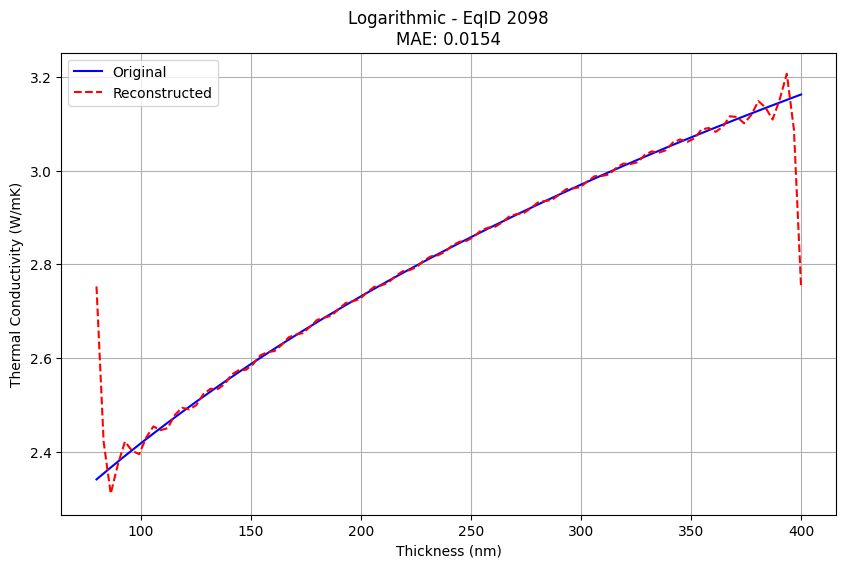

✅ Equation ID: 2098
📉 MAE: 0.015446
📸 Saved plot to Logarithmic_reconstruction_N25.png

📂 Processing Quadratic distribution from thermal_conductivity_quadratic_20250207_153400.csv


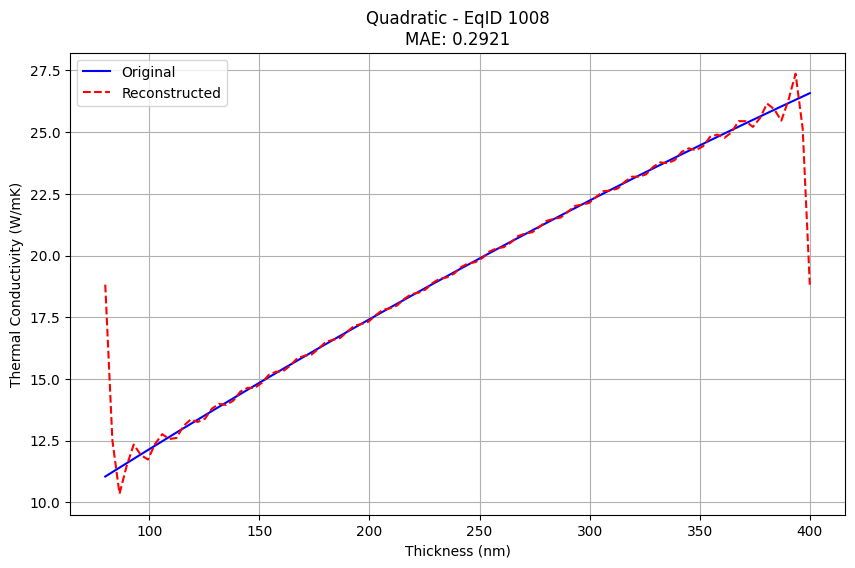

✅ Equation ID: 1008
📉 MAE: 0.292129
📸 Saved plot to Quadratic_reconstruction_N25.png


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. Fourier Coefficients Extraction Function
# ==========================================
def fourier_series_coefficients_clean(x, y, N=15):
    """
    Compute Fourier coefficients up to N terms on [0, 2π]-rescaled domain.
    """
    # Rescale x to [0, 2π]
    x_scaled = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    
    a0 = (1 / (2 * np.pi)) * np.trapz(y, x_scaled)
    a_coeffs, b_coeffs = [], []

    for n in range(1, N + 1):
        an = (1 / np.pi) * np.trapz(y * np.cos(n * x_scaled), x_scaled)
        bn = (1 / np.pi) * np.trapz(y * np.sin(n * x_scaled), x_scaled)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs


# ==========================================
# 2. Reconstruction from Fourier Coefficients
# ==========================================
def reconstruct_from_fourier_coeffs(x, coeffs, N=15):
    """
    Reconstruct signal y from Fourier coefficients over x domain.
    """
    x_scaled = 2 * np.pi * (x - x.min()) / (x.max() - x.min())

    a0 = coeffs[0]
    a = coeffs[1:N+1]
    b = coeffs[N+1:]

    y_reconstructed = np.ones_like(x_scaled) * a0

    for n in range(1, N+1):
        y_reconstructed += a[n-1] * np.cos(n * x_scaled) + b[n-1] * np.sin(n * x_scaled)

    return y_reconstructed


# ==========================================
# 3. Main Pipeline Tester
# ==========================================
def test_fourier_pipeline(file_paths, N=15):
    for dist_type, file_path in file_paths.items():
        print(f"\n📂 Processing {dist_type} distribution from {file_path}")

        df = pd.read_csv(file_path)
        eq_ids = df['Equation_ID'].unique()
        eq_id = np.random.choice(eq_ids)

        eq_data = df[df['Equation_ID'] == eq_id]
        sort_idx = np.argsort(eq_data['x (Thickness)'].values)
        x = eq_data['x (Thickness)'].values[sort_idx]
        y = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

        # Extract Fourier coefficients
        coeffs = fourier_series_coefficients_clean(x, y, N=N)

        # Reconstruct from coefficients
        y_reconstructed = reconstruct_from_fourier_coeffs(x, coeffs, N=N)

        # Compute MAE
        mae = np.mean(np.abs(y - y_reconstructed))

        # Plot and save
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'b-', label='Original')
        plt.plot(x, y_reconstructed, 'r--', label='Reconstructed')
        plt.title(f'{dist_type} - EqID {eq_id}\nMAE: {mae:.4f}')
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.legend()
        plt.grid(True)

        fname = f'{dist_type}_reconstruction_N{N}.png'
        plt.savefig(fname)
        plt.show()

        print(f"✅ Equation ID: {eq_id}")
        print(f"📉 MAE: {mae:.6f}")
        print(f"📸 Saved plot to {fname}")


# ==========================================
# 4. Driver Code
# ==========================================
if __name__ == "__main__":
    file_paths = {
        'Gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'Logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'Quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    for N in [15, 20, 25]:
        print("\n" + "="*60)
        print(f"🔁 Running Fourier Expansion with N = {N}")
        print("="*60)
        test_fourier_pipeline(file_paths, N=N)


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Training model...
Epoch 1/50: Train Loss = 0.401286, Val Loss = 0.356493
Saved best model.
Epoch 2/50: Train Loss = 0.382927, Val Loss = 0.370820
Epoch 3/50: Train Loss = 0.377296, Val Loss = 0.355891
Saved best model.
Epoch 4/50: Train Loss = 0.374132, Val Loss = 0.371778
Epoch 5/50: Train Loss = 0.371431, Val Loss = 0.353151
Saved best model.
Epoch 6/50: Train Loss = 0.369522, Val Loss = 0.361609
Epoch 7/50: Train Loss = 0.368454, Val Loss = 0.375450
Epoch 8/50: Train Loss = 0.366593, Val Loss = 0.364797
Epoch 9/50: Train Loss = 0.365189, Val Loss = 0.344244
Saved best model.
Epoch 10/50: Train Loss = 0.364186, Val Loss = 0.357855
Epoch 11/50: Train Loss = 0.363117, V

/tmp/ipykernel_28157/2474534193.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model.pth'))


Pipeline complete.
All visualizations saved under 'visualizations/'


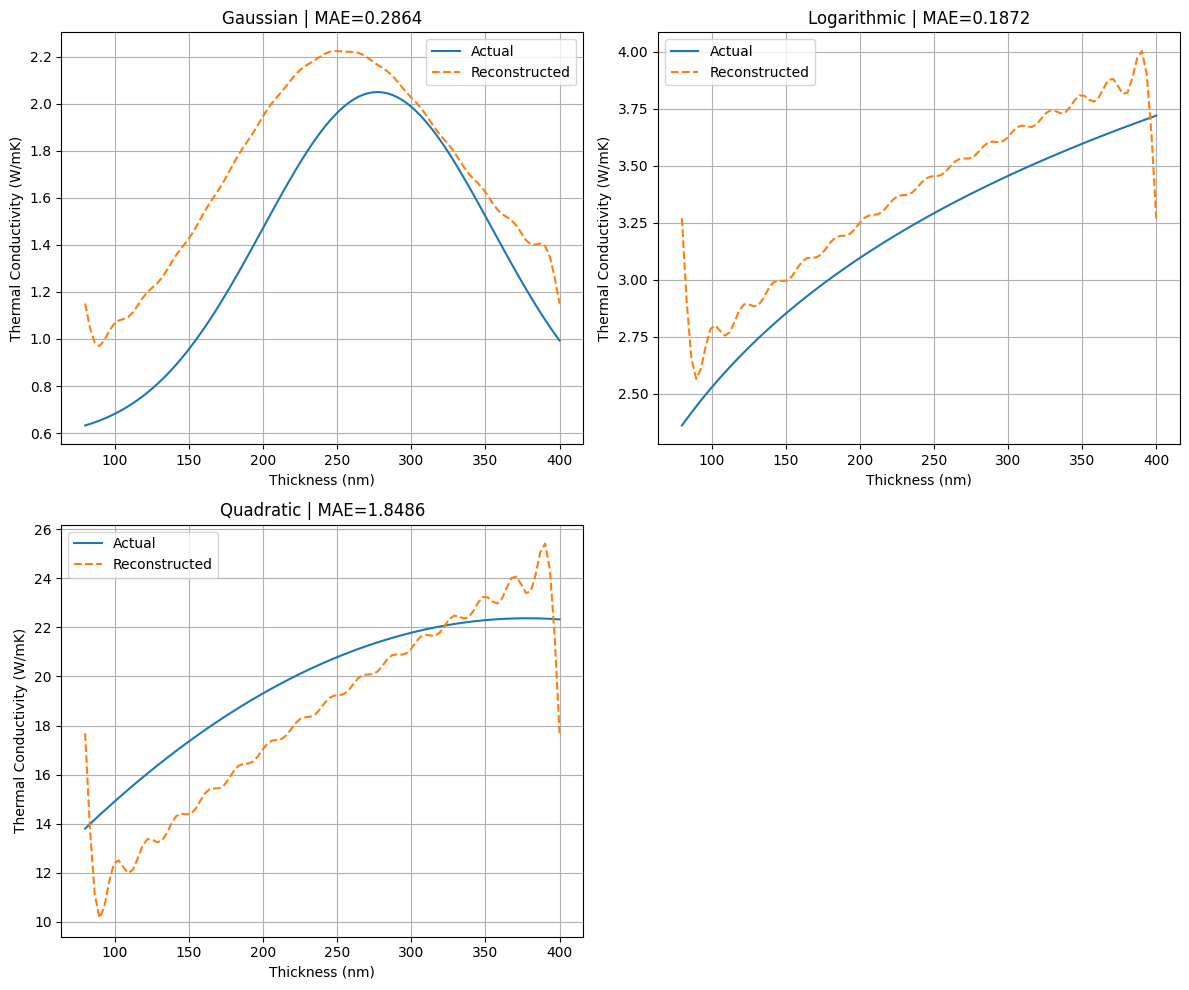

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Compute Fourier coefficients on [0, 2π]-rescaled domain using integration."""
    x_scaled = 2 * np.pi * (x_values - x_values.min()) / (x_values.max() - x_values.min())

    a0 = (1 / (2 * np.pi)) * np.trapz(y_values, x_scaled)
    a_coeffs, b_coeffs = [], []

    for n in range(1, N + 1):
        an = (1 / np.pi) * np.trapz(y_values * np.cos(n * x_scaled), x_scaled)
        bn = (1 / np.pi) * np.trapz(y_values * np.sin(n * x_scaled), x_scaled)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            reference_profiles[eq_type][eq_id] = {'x': x_values, 'y': y_values}

            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(targets_list, columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity'])

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definition
# =============================

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    x_scaled = 2 * np.pi * (x_values - x_values.min()) / (x_values.max() - x_values.min())
    a0 = coeffs_predicted[0]
    a_coeffs = coeffs_predicted[1:N+1]
    b_coeffs = coeffs_predicted[N+1:2*N+1]
    y_reconstructed = np.ones_like(x_scaled) * a0

    for n in range(1, N + 1):
        y_reconstructed += a_coeffs[n-1] * np.cos(n * x_scaled) + b_coeffs[n-1] * np.sin(n * x_scaled)

    return y_reconstructed

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    N = 15
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    train_loader = DataLoader(ThermalConductivityDataset(X_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(ThermalConductivityDataset(X_test, y_test), batch_size=32)

    model = FourierNN(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_loss = float('inf')
    patience, counter, epochs = 10, 0, 50
    train_losses, val_losses = [], []

    print("Training model...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                val_loss += criterion(outputs_batch, targets_batch).item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), 'models/best_model.pth')
            print("Saved best model.")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(torch.load('models/best_model.pth'))

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve.png')
    plt.close()

    print("Generating visualizations...")
    model.eval()
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        if not eq_indices:
            continue
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_vals = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_vals, N=N)

        mae = mean_absolute_error(y_actual, y_reconstructed)
        plt.subplot(2, 2, i + 1)
        plt.plot(x_vals, y_actual, label='Actual')
        plt.plot(x_vals, y_reconstructed, '--', label='Reconstructed')
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} | MAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/final_reconstruction_profiles.png')
    print("Pipeline complete.")
    print("All visualizations saved under 'visualizations/'")

if __name__ == "__main__":
    main()


In [2]:
# Improved Fourier NN pipeline with normalized Fourier coefficients, stable MAPE, multiple architectures

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.signal import savgol_filter
import os
import time

# =============================
# 1. Fourier Processing
# =============================
def fourier_series_coefficients(y_values, x_values, N=15):
    x_scaled = 2 * np.pi * (x_values - x_values.min()) / (x_values.max() - x_values.min())
    a0 = (1 / (2 * np.pi)) * np.trapz(y_values, x_scaled)
    a_coeffs, b_coeffs = [], []
    for n in range(1, N + 1):
        an = (1 / np.pi) * np.trapz(y_values * np.cos(n * x_scaled), x_scaled)
        bn = (1 / np.pi) * np.trapz(y_values * np.sin(n * x_scaled), x_scaled)
        a_coeffs.append(an)
        b_coeffs.append(bn)
    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================
def process_data(data_files, N=15):
    features, targets, eq_ids = [], [], []
    reference = {}
    for dist, path in data_files.items():
        df = pd.read_csv(path)
        reference[dist] = {}
        for eq_id in df['Equation_ID'].unique():
            eq_df = df[df['Equation_ID'] == eq_id]
            idx = np.argsort(eq_df['x (Thickness)'].values)
            x = eq_df['x (Thickness)'].values[idx]
            y = eq_df['y (Thermal Conductivity Profile)'].values[idx]
            reference[dist][eq_id] = {'x': x, 'y': y}
            coeffs = fourier_series_coefficients(y, x, N)
            for i in range(len(x)):
                features.append([
                    x[i], eq_df['ModelRatio'].values[idx][i], eq_df['Tdelay'].values[idx][i]
                ])
                targets.append(coeffs)
                eq_ids.append(dist)
    X = pd.DataFrame(features, columns=['x', 'ModelRatio', 'TimeDelay'])
    Y = pd.DataFrame(targets, columns=[f'Fourier_{i}' for i in range(2*N+1)])
    return X, Y, eq_ids, reference

# =============================
# 3. Dataset
# =============================
class ThermalDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.FloatTensor(Y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

# =============================
# 4. Architectures
# =============================
class BaseNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[128, 256, 128], dropout=0.1):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(), nn.BatchNorm1d(h), nn.Dropout(dropout)]
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# =============================
# 5. Reconstruct
# =============================
def reconstruct(coeffs, x, N):
    x_scaled = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0, a, b = coeffs[0], coeffs[1:N+1], coeffs[N+1:2*N+1]
    y = np.ones_like(x_scaled) * a0
    for n in range(1, N+1):
        y += a[n-1]*np.cos(n*x_scaled) + b[n-1]*np.sin(n*x_scaled)
    return savgol_filter(y, 7, 3)

# =============================
# 6. Evaluation
# =============================
def evaluate_and_plot(model, scaler_y, X_test, eq_test, ref_profiles, model_name, N):
    os.makedirs(f'visualizations/{model_name}', exist_ok=True)
    mape_summary = {}
    model.eval()
    for dist in set(eq_test):
        idx = [i for i, eq in enumerate(eq_test) if eq == dist]
        i = idx[0]
        x = torch.FloatTensor(X_test[i].reshape(1, -1))
        with torch.no_grad():
            pred = model(x).numpy()[0]
        pred_orig = scaler_y.inverse_transform(pred.reshape(1, -1))[0]
        eq_id = list(ref_profiles[dist].keys())[0]
        x_vals = ref_profiles[dist][eq_id]['x']
        y_true = ref_profiles[dist][eq_id]['y']
        y_pred = reconstruct(pred_orig, x_vals, N)
        mae = mean_absolute_error(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred)/(np.abs(y_true) + 1e-10))) * 100
        mape_summary[dist] = mape
        plt.figure()
        plt.plot(x_vals, y_true, label='Actual')
        plt.plot(x_vals, y_pred, '--', label='Predicted')
        plt.title(f'{dist.capitalize()} | MAE={mae:.4f}, MAPE={mape:.2f}%')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'visualizations/{model_name}/{dist}.png')
        plt.close()
    return mape_summary

# =============================
# 7. Training
# =============================
def train_model(model, name, X_train, X_test, y_train, y_test, scaler_y, ref_profiles, eq_test, N):
    loader = DataLoader(ThermalDataset(X_train, y_train), batch_size=64, shuffle=True)
    test_loader = DataLoader(ThermalDataset(X_test, y_test), batch_size=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=5)
    best_loss, counter = float('inf'), 0
    for epoch in range(50):
        model.train()
        loss = 0
        for xb, yb in loader:
            optim.zero_grad()
            pred = model(xb)
            l = loss_fn(pred, yb)
            l.backward()
            optim.step()
            loss += l.item()
        loss /= len(loader)
        with torch.no_grad():
            val_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in test_loader) / len(test_loader)
        scheduler.step(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'models/{name}.pth')
            counter = 0
        else:
            counter += 1
            if counter > 10:
                break
    model.load_state_dict(torch.load(f'models/{name}.pth', weights_only=True))
    return evaluate_and_plot(model, scaler_y, X_test, eq_test, ref_profiles, name, N)

# =============================
# 8. Main
# =============================
def main():
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    configs = [
        (15, [64, 128, 64]),
        (20, [128, 256, 128]),
        (25, [256, 256]),
        (30, [512, 256, 128]),
        (15, [128, 128, 128, 64])
    ]
    for i, (N, layers) in enumerate(configs):
        X_df, Y_df, eq_ids, ref = process_data(data_files, N=N)
        X_scaler, Y_scaler = StandardScaler(), StandardScaler()
        X = X_scaler.fit_transform(X_df.values)
        Y = Y_scaler.fit_transform(Y_df.values)
        X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(X, Y, eq_ids, test_size=0.2, stratify=eq_ids)
        model = BaseNN(input_dim=X.shape[1], output_dim=Y.shape[1], hidden_layers=layers)
        model_name = f"FourierNN_V{i+1}_N{N}"
        print(f"\nTraining {model_name}...")
        summary = train_model(model, model_name, X_train, X_test, Y_train, Y_test, Y_scaler, ref, eq_test, N)
        for dist, mape in summary.items():
            print(f"  {dist.capitalize()}: MAPE = {mape:.2f}%")

# if __name__ == '__main__':
#     main()
def run_extra_models():
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # New configurations: more layers, skip style, larger capacity
    new_configs = [
        (20, [128, 128, 128, 64]),          # V6 - uniform mid-depth
        (25, [512, 256, 128]),              # V7 - very wide to narrow
        (15, [256, 256, 256]),              # V8 - consistent deep
        (30, [512, 512, 256, 128]),         # V9 - very deep and wide
        (25, [128, 64, 128, 64])            # V10 - sandwich skip-like
    ]

    for i, (N, layers) in enumerate(new_configs):
        model_name = f"FourierNN_V{i+6}_N{N}"
        print(f"\n🔥 Training {model_name}...")

        X_df, Y_df, eq_ids, ref = process_data(data_files, N=N)
        X_scaler, Y_scaler = StandardScaler(), StandardScaler()
        X = X_scaler.fit_transform(X_df.values)
        Y = Y_scaler.fit_transform(Y_df.values)

        X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(
            X, Y, eq_ids, test_size=0.2, stratify=eq_ids
        )

        model = BaseNN(input_dim=X.shape[1], output_dim=Y.shape[1], hidden_layers=layers)
        summary = train_model(model, model_name, X_train, X_test, Y_train, Y_test, Y_scaler, ref, eq_test, N)

        for dist, mape in summary.items():
            print(f"  {dist.capitalize()}: MAPE = {mape:.2f}%")

# if __name__ == "__main__":
#     run_extra_models()



In [3]:
def train_golden_model():
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Configuration
    N = 25
    hidden_layers = [256, 256]
    model_name = "FourierNN_Golden_N25"

    print(f"\n🏆 Training {model_name}...")

    # Data processing
    X_df, Y_df, eq_ids, ref = process_data(data_files, N=N)
    X_scaler, Y_scaler = StandardScaler(), StandardScaler()
    X = X_scaler.fit_transform(X_df.values)
    Y = Y_scaler.fit_transform(Y_df.values)

    X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(
        X, Y, eq_ids, test_size=0.2, stratify=eq_ids
    )

    # Model
    model = BaseNN(
        input_dim=X.shape[1],
        output_dim=Y.shape[1],
        hidden_layers=hidden_layers,
        dropout=0.2  # Increase dropout slightly
    )

    loader = DataLoader(ThermalDataset(X_train, Y_train), batch_size=128, shuffle=True)
    test_loader = DataLoader(ThermalDataset(X_test, Y_test), batch_size=128)
    optim = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=5)

    # Training loop
    best_loss, counter = float('inf'), 0
    for epoch in range(75):
        model.train()
        loss = 0
        for xb, yb in loader:
            optim.zero_grad()
            pred = model(xb)
            l = loss_fn(pred, yb)
            l.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Clip gradients
            optim.step()
            loss += l.item()
        loss /= len(loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                val_loss += loss_fn(model(xb), yb).item()
        val_loss /= len(test_loader)
        scheduler.step(val_loss)

        print(f"  Epoch {epoch+1} - Train Loss: {loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'models/{model_name}.pth')
            counter = 0
        else:
            counter += 1
            if counter >= 15:  # early stopping patience
                print(f"⏹ Early stopping at epoch {epoch+1}")
                break

    # Evaluation
    model.load_state_dict(torch.load(f'models/{model_name}.pth', weights_only=True))
    summary = evaluate_and_plot(model, Y_scaler, X_test, eq_test, ref, model_name, N)
    for dist, mape in summary.items():
        print(f"✅ {dist.capitalize()}: MAPE = {mape:.2f}%")

if __name__ == "__main__":
    train_golden_model()



🏆 Training FourierNN_Golden_N25...
  Epoch 1 - Train Loss: 0.417258, Val Loss: 0.370439
  Epoch 2 - Train Loss: 0.390363, Val Loss: 0.369502
  Epoch 3 - Train Loss: 0.385012, Val Loss: 0.361887
  Epoch 4 - Train Loss: 0.383227, Val Loss: 0.364229
  Epoch 5 - Train Loss: 0.381901, Val Loss: 0.357455
  Epoch 6 - Train Loss: 0.381253, Val Loss: 0.361186
  Epoch 7 - Train Loss: 0.381011, Val Loss: 0.357773
  Epoch 8 - Train Loss: 0.381039, Val Loss: 0.360464
  Epoch 9 - Train Loss: 0.381148, Val Loss: 0.360499
  Epoch 10 - Train Loss: 0.381109, Val Loss: 0.355399
  Epoch 11 - Train Loss: 0.381039, Val Loss: 0.358797
  Epoch 12 - Train Loss: 0.381018, Val Loss: 0.357474
  Epoch 13 - Train Loss: 0.381102, Val Loss: 0.358307
  Epoch 14 - Train Loss: 0.380721, Val Loss: 0.355915
  Epoch 15 - Train Loss: 0.380777, Val Loss: 0.362172
  Epoch 16 - Train Loss: 0.381292, Val Loss: 0.366059
  Epoch 17 - Train Loss: 0.375562, Val Loss: 0.352192
  Epoch 18 - Train Loss: 0.375287, Val Loss: 0.352524
 

In [5]:
import random
import matplotlib.pyplot as plt

def visualize_multiple_samples(model, scaler_y, X_test, eq_test, ref_profiles, model_name, N, samples_per_type=5):
    """
    Visualize multiple reconstructed profiles for each distribution type.
    """
    model.eval()
    dist_types = ['gaussian', 'logarithmic', 'quadratic']
    os.makedirs(f'visualizations/{model_name}_multiple', exist_ok=True)

    for dist in dist_types:
        idxs = [i for i, eq in enumerate(eq_test) if eq == dist]
        if len(idxs) == 0:
            print(f"No samples for {dist}")
            continue

        selected_idxs = random.sample(idxs, min(samples_per_type, len(idxs)))

        for j, sample_idx in enumerate(selected_idxs):
            x = torch.FloatTensor(X_test[sample_idx].reshape(1, -1))
            with torch.no_grad():
                pred = model(x).numpy()[0]

            pred_orig = scaler_y.inverse_transform(pred.reshape(1, -1))[0]

            eq_id = list(ref_profiles[dist].keys())[0]
            x_vals = ref_profiles[dist][eq_id]['x']
            y_true = ref_profiles[dist][eq_id]['y']
            y_pred = reconstruct(pred_orig, x_vals, N)

            mae = mean_absolute_error(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-10))) * 100

            plt.figure(figsize=(7, 5))
            plt.plot(x_vals, y_true, label='Actual', linewidth=2)
            plt.plot(x_vals, y_pred, '--', label='Predicted', linewidth=2)
            plt.title(f'{dist.capitalize()} Sample #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            plt.xlabel('Thickness (nm)')
            plt.ylabel('Thermal Conductivity (W/mK)')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'visualizations/{model_name}_multiple/{dist}_sample_{j+1}.png')
            plt.close()

    print(f"\n✅ Saved all sample visualizations under visualizations/{model_name}_multiple/")

# Example usage after training:
# 1. Reload model architecture
model = BaseNN(input_dim=3, output_dim=51, hidden_layers=[256, 256], dropout=0.2)
model.load_state_dict(torch.load('models/FourierNN_Golden_N25.pth', weights_only=True))
model.eval()

# 2. Reprocess data
data_files = {
    'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
    'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
    'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
}
X_df, Y_df, eq_ids, ref_profiles = process_data(data_files, N=25)
X_scaler, Y_scaler = StandardScaler(), StandardScaler()
X = X_scaler.fit_transform(X_df.values)
Y = Y_scaler.fit_transform(Y_df.values)
X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(X, Y, eq_ids, test_size=0.2, stratify=eq_ids)

# 3. Then you can call visualization
visualize_multiple_samples(model, Y_scaler, X_test, eq_test, ref_profiles, model_name="FourierNN_Golden_N25", N=25)



✅ Saved all sample visualizations under visualizations/FourierNN_Golden_N25_multiple/


In [ ]:
def train_goldenV2_model():
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Configuration
    N = 25
    hidden_layers = [256, 256]
    model_name = "FourierNN_GoldenV2_N25"

    print(f"\n🏆 Pretraining {model_name} on all distributions...")

    # 1. Data processing
    X_df, Y_df, eq_ids, ref_profiles = process_data(data_files, N=N)
    X_scaler, Y_scaler = StandardScaler(), StandardScaler()
    X = X_scaler.fit_transform(X_df.values)
    Y = Y_scaler.fit_transform(Y_df.values)

    X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(
        X, Y, eq_ids, test_size=0.2, stratify=eq_ids
    )

    model = BaseNN(
        input_dim=X.shape[1],
        output_dim=Y.shape[1],
        hidden_layers=hidden_layers,
        dropout=0.2
    )

    loader = DataLoader(ThermalDataset(X_train, Y_train), batch_size=128, shuffle=True)
    test_loader = DataLoader(ThermalDataset(X_test, Y_test), batch_size=128)

    optim = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=5)

    best_loss, counter = float('inf'), 0
    for epoch in range(75):
        model.train()
        total_loss = 0
        for xb, yb in loader:
            optim.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optim.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                val_loss += loss_fn(model(xb), yb).item()
        avg_val_loss = val_loss / len(test_loader)

        scheduler.step(avg_val_loss)
        print(f"  Pretrain Epoch {epoch+1}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), f'models/{model_name}_pretrained.pth')
            counter = 0
        else:
            counter += 1
            if counter >= 15:
                print(f"⏹ Early stopping Pretraining at epoch {epoch+1}")
                break

    # 2. Fine-tuning ONLY on Gaussian data
    print("\n🎯 Fine-tuning only on Gaussian profiles...")

    model.load_state_dict(torch.load(f'models/{model_name}_pretrained.pth', weights_only=True))
    gaussian_idxs = [i for i, eq in enumerate(eq_train) if eq == 'gaussian']

    X_gaussian = X_train[gaussian_idxs]
    Y_gaussian = Y_train[gaussian_idxs]

    fine_tune_loader = DataLoader(ThermalDataset(X_gaussian, Y_gaussian), batch_size=32, shuffle=True)

    fine_optim = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    fine_scheduler = ReduceLROnPlateau(fine_optim, mode='min', factor=0.5, patience=3)

    best_fine_loss, counter = float('inf'), 0
    for epoch in range(20):
        model.train()
        total_loss = 0
        for xb, yb in fine_tune_loader:
            fine_optim.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            fine_optim.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(fine_tune_loader)

        fine_scheduler.step(avg_train_loss)
        print(f"  Fine-tune Epoch {epoch+1}: Fine-tune Loss = {avg_train_loss:.6f}")

        if avg_train_loss < best_fine_loss:
            best_fine_loss = avg_train_loss
            torch.save(model.state_dict(), f'models/{model_name}.pth')
            counter = 0
        else:
            counter += 1
            if counter >= 7:
                print(f"⏹ Early stopping Fine-tuning at epoch {epoch+1}")
                break

    # 3. Evaluate Final GoldenV2
    model.load_state_dict(torch.load(f'models/{model_name}.pth', weights_only=True))
    summary = evaluate_and_plot(model, Y_scaler, X_test, eq_test, ref_profiles, model_name, N)

    for dist, mape in summary.items():
        print(f"✅ {dist.capitalize()} (After Fine-tune): MAPE = {mape:.2f}%")

    return model, Y_scaler, X_test, eq_test, ref_profiles, model_name, N

# Call it like this:
if __name__ == "__main__":
    model, Y_scaler, X_test, eq_test, ref_profiles, model_name, N = train_goldenV2_model()
    visualize_multiple_samples(model, Y_scaler, X_test, eq_test, ref_profiles, model_name, N)


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import CosineAnnealingLR
import os, time

# Assumes: `fourier_series_coefficients`, `reconstruct_profile`, `process_data` already defined

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

# =======================================
# 📐 Define 5 Model Variants
# =======================================
def build_model(variant, input_dim, output_dim):
    class Sine(nn.Module):
        def forward(self, x): return torch.sin(x)

    if variant == 'V6':  # Wider baseline
        return nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Linear(128, 256), nn.ReLU(), nn.BatchNorm1d(256),
            nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Dropout(0.1), nn.Linear(128, output_dim)
        )
    elif variant == 'V7':  # SIREN-style
        return nn.Sequential(
            nn.Linear(input_dim, 64), Sine(),
            nn.Linear(64, 128), Sine(),
            nn.Linear(128, 256), Sine(),
            nn.Linear(256, output_dim)
        )
    elif variant == 'V8':  # Shallow but wide
        return nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(512, output_dim)
        )
    elif variant == 'V9':  # ResNet-inspired skip block
        class ResBlock(nn.Module):
            def __init__(self, in_f): super().__init__()
            self.block = nn.Sequential(
                nn.Linear(in_f, in_f), nn.ReLU(), nn.Dropout(0.1),
                nn.Linear(in_f, in_f)
            )
            def forward(self, x): return x + self.block(x)

        return nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            ResBlock(128),
            ResBlock(128),
            nn.Linear(128, output_dim)
        )
    elif variant == 'V10':  # Transformer-FFN style
        return nn.Sequential(
            nn.Linear(input_dim, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 128), nn.LayerNorm(128), nn.ReLU(),
            nn.Dropout(0.1), nn.Linear(128, output_dim)
        )

# =======================================
# 🔁 Main Training Loop for All Models
# =======================================
def train_all_models():
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    variants = ['V6', 'V7', 'V8', 'V9', 'V10']
    Ns = [15, 20, 25, 30, 15]  # N terms for each model
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    for variant, N in zip(variants, Ns):
        print(f"\n🚀 Training FourierNN_{variant}_N{N}...")
        model_name = f'FourierNN_{variant}_N{N}'

        # 1. Preprocess
        features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)
        fourier_cols = [f'Fourier_{i}' for i in range(2 * N + 1)]
        
        feature_scaler = StandardScaler()
        features = feature_scaler.fit_transform(features_df.values)
        
        # Only scale Fourier coefficients, not final target
        target_scaler = StandardScaler()
        targets_scaled = targets_df.copy()
        targets_scaled[fourier_cols] = target_scaler.fit_transform(targets_df[fourier_cols])
        targets_scaled['ThermalConductivity'] = targets_df['ThermalConductivity'].values  # ✅ FIX
        targets = targets_scaled[fourier_cols + ['ThermalConductivity']].values

        X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
            features, targets, eq_ids, test_size=0.2, random_state=42, stratify=eq_ids)

        train_loader = DataLoader(ThermalConductivityDataset(X_train, y_train), batch_size=64, shuffle=True)
        test_loader = DataLoader(ThermalConductivityDataset(X_test, y_test), batch_size=64)

        # 2. Model
        input_dim = features.shape[1]
        output_dim = targets.shape[1]
        model = build_model(variant, input_dim, output_dim)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = CosineAnnealingLR(optimizer, T_max=30)

        best_loss = float('inf')
        patience, counter, epochs = 12, 0, 60
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            scheduler.step()
            avg_train_loss = total_loss / len(train_loader)

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for xb, yb in test_loader:
                    val_loss += criterion(model(xb), yb).item()
            avg_val_loss = val_loss / len(test_loader)

            print(f"  Epoch {epoch+1}/{epochs} - Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), f"models/{model_name}.pth")
                counter = 0
            else:
                counter += 1
                if counter >= patience: break

        # 3. Evaluation on 1 sample per distribution
        model.load_state_dict(torch.load(f"models/{model_name}.pth", weights_only=True))
        model.eval()
        os.makedirs(f"visualizations/{model_name}", exist_ok=True)
        print(f"\n📈 Evaluating {model_name}...")

        for dist in data_files:
            idxs = [i for i, e in enumerate(eq_test) if e == dist]
            if not idxs: continue
            idx = idxs[0]
            x_vals = reference_profiles[dist][list(reference_profiles[dist].keys())[0]]['x']
            y_true = reference_profiles[dist][list(reference_profiles[dist].keys())[0]]['y']
            with torch.no_grad():
                pred = model(torch.FloatTensor(X_test[idx].reshape(1, -1))).numpy()[0]
            pred_orig = target_scaler.inverse_transform(
                np.concatenate([pred[:-1], [0]]).reshape(1, -1)
            )[0][:-1]
            y_pred = reconstruct_profile(pred_orig, x_vals, N=N)

            mae = mean_absolute_error(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
            print(f"  {dist.capitalize()}: MAPE = {mape:.2f}%")

            # Plot
            plt.figure(figsize=(6, 4))
            plt.plot(x_vals, y_true, label='Actual')
            plt.plot(x_vals, y_pred, '--', label='Reconstructed')
            plt.title(f"{dist.capitalize()} | MAPE = {mape:.2f}%")
            plt.xlabel("Thickness (nm)")
            plt.ylabel("Thermal Conductivity (W/mK)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f"visualizations/{model_name}/{dist}_profile.png")
            plt.close()

if __name__ == "__main__":
    train_all_models()



🚀 Training FourierNN_V6_N15...


KeyError: 'ThermalConductivity'

In [3]:
import matplotlib.pyplot as plt

def validate_fourier_extraction_reconstruction(reference_profiles, N=15):
    """
    Validate Fourier extraction and reconstruction by selecting one sample from each distribution.
    """
    print("\n🔍 Validating Fourier Expansion -> Reconstruction on Original Data")
    plt.figure(figsize=(14, 4))

    for i, (dist_name, profiles) in enumerate(reference_profiles.items()):
        eq_id = list(profiles.keys())[0]
        x_vals = profiles[eq_id]['x']
        y_vals = profiles[eq_id]['y']

        coeffs = fourier_series_coefficients(y_vals, x_vals, N=N)
        y_reconstructed = reconstruct_profile(coeffs, x_vals, N=N)

        mae = np.mean(np.abs(y_vals - y_reconstructed))
        mape = np.mean(np.abs((y_vals - y_reconstructed) / (y_vals + 1e-8))) * 100

        plt.subplot(1, 3, i+1)
        plt.plot(x_vals, y_vals, label='Original', color='blue')
        plt.plot(x_vals, y_reconstructed, '--', label='Reconstructed', color='orange')
        plt.title(f'{dist_name.capitalize()} | MAE={mae:.4f}, MAPE={mape:.2f}%')
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.savefig("visualizations/fourier_validation_fixed_profiles.png")
    plt.show()
